# Library

In [1]:
import logging
import requests
from bs4 import BeautifulSoup
from urllib.error import HTTPError

import http.client as httplib  # or http.client if you're on Python 3 # httplib
httplib._MAXHEADERS = 10000
# ChunkedEncodingError

import time
import datetime
from datetime import datetime, timedelta

import re

import json

import warnings
warnings.simplefilter(action='ignore')

import pandas as pd
import numpy as np
import sys

import random 
from random import sample

In [139]:
# pathes
art_project_path = '/content/drive/MyDrive/Art/Art_Project'
art_project_path_backups = '/content/drive/MyDrive/Art/Art_Project/parsing_backups'
art_project_path_tests = '/content/drive/MyDrive/Art/Art_Project/parsing_tests'

url_add = 'https://www.artsy.net'

# files
cat_dict = '/artsy_genom_cat_dict.txt'
gen_dict = '/artsy_genom_gen_dict.txt'
artwork_dict = '/artsy_genom_artwork_dict.txt'
artist_dict = '/artsy_genom_artist_dict.txt'
temp_data = '/artsy_temp_data.csv'
temp_data_add_up = '/artsy_temp_data_add_up.csv'

# id length
cat_id_len = 2
gen_id_len = 5
artist_id_len = 5

# for addition and updating
recently_added_pref = '?sort=-published_at'
recently_updated_pref = '?sort=-partner_updated_at'

# Functions

## Openings and savings

In [3]:
# 1. Save json dict
def save_dict(tree_dict, file, folder):
  if folder=='live':
    with open(art_project_path + file, 'w') as outfile:
      json.dump(tree_dict, outfile)
  elif folder=='backup':
    with open(art_project_path_backups + file, 'w') as outfile:
      json.dump(tree_dict, outfile)

# 2. Open json dict
def open_dict(file, folder):
  if folder=='live':
    with open(art_project_path + file, 'rb') as infile:
      tree_dict = json.load(infile)
  elif folder=='backup':
    with open(art_project_path_backups + file, 'rb') as infile:
      tree_dict = json.load(infile)
  return tree_dict

# 3. Open file.csv
def open_file_csv(file, folder): # folder: live, backup or test
  if folder=='live':
    df = pd.read_csv(art_project_path + file)
  elif folder=='backup':
    df = pd.read_csv(art_project_path_backups + file)
  elif folder=='test':
    df = pd.read_csv(art_project_path_tests + file)
  return df

# 4. Save df to csv file
def save_df_file(df, file, folder): # folder: live, backup or test
  if folder=='live':
    df.to_csv(art_project_path + file, index=False)
  elif folder=='backup':
    df.to_csv(art_project_path_backups + file, index=False)
  elif folder=='test':
    df.to_csv(art_project_path_tests + file, index=False)


## Parsing

### get_page

In [4]:
# 5. get_page
logging.basicConfig(level=logging.DEBUG, format="%(message)s")

def get_page(url, session):
  #response = requests.get(url, headers={'User-Agent': 'Chrome/97.0.4692.71'})
  try:
    response = session.get(url, headers={'User-Agent': 'Chrome/97.0.4692.71'})
  except: # requests.exceptions.ChunkedEncodingError:
    print('Error: ' + str(url) + '-> resession')
    time.sleep(0.5)
    session = requests.Session()
    response = session.get(url, headers={'User-Agent': 'Chrome/97.0.4692.71'})

  try:
    response.raise_for_status()
    bs_page = BeautifulSoup(response.text, 'html.parser')
    return bs_page

  except requests.exceptions.HTTPError: # for correction
    pass
    print('HTTPError: ' + str(url))
    
  #bs_page = BeautifulSoup(response.text, 'html.parser')
  #return bs_page

### get next pages links list

In [5]:
# 6. get next pages links list
def get_next_page_list(url, page):
  try:
    last_page_data = page.find('main').find_all('nav', class_='Box-sc-15se88d-0 Text-sc-18gcpao-0 ibHUpM gzwvJD')[0].find_all('a')[-2]
    last_page = last_page_data.get_text()
    page_link = last_page_data.get('href')[:-len(last_page)]
    next_page_link_list_new = [url + page_link + str(p) for p in range(2, int(last_page)+1)]
  except:
    next_page_link_list_new = []

  return next_page_link_list_new

# 6.1 get next pages links list
def get_next_page_list_add_up(url, page):
  try:
    last_page_data = page.find('main').find_all('nav', class_='Box-sc-15se88d-0 Text-sc-18gcpao-0 ibHUpM gzwvJD')[0].find_all('a')[-2]
    last_page = last_page_data.get_text()
    last_page_link = last_page_data.get('href')
    next_page_link_list_new = [url + last_page_link.split('&')[0][:-len(last_page)] + str(p) + '&' + last_page_link.split('&')[1] for p in range(2, int(last_page)+1)]
  except:
    next_page_link_list_new = []

  return next_page_link_list_new

In [6]:
# https://www.artsy.net/gene/inlay
# https://www.artsy.net/gene/inlay?page=2
# https://www.artsy.net/gene/inlay?sort=-published_at
# https://www.artsy.net/gene/inlay?page=2&sort=-published_at

### get data from pages

In [7]:
# 7. get data from pages
def get_page_data(page):
  code_block = page.find('main').find_all('div', class_='ArtworkGrid-sc-1jsqquq-0 djwrUe')
  try:
    object_block = code_block[0].find_all('div', relay='[object Object]')
  
    # for the beggining into a DataFrame
    artsy_id_list = [obj.get('data-id') for obj in object_block]
    imgage_list = [obj.find_all('a')[0].find('img').get('src') for obj in object_block]
    artist_list = [obj.find_all('a')[1].find_all('div')[0].get_text() for obj in object_block]
  
    gallery_list = []
    for obj in object_block:
      try:
        gallery_list.append(obj.find_all('a')[1].find('div', class_='Box-sc-15se88d-0 Text-sc-18gcpao-0 caIGcn hENCPo').get_text())
      except:
        gallery_list.append(np.nan)
  
    price_list = []
    for obj in object_block:
      try:
        price_list.append(obj.find_all('a')[1].find('div', class_='Box-sc-15se88d-0 Text-sc-18gcpao-0 eXbAnU jkuGdd').get_text())
      except:
        price_list.append(np.nan)
  
    # can be no year info !!!
    name_list = []
    year_list = []
    for obj in object_block:
      text = obj.find_all('a')[1].find('div', class_='Box-sc-15se88d-0 Text-sc-18gcpao-0 caIGcn kySEpG').get_text()
      name = obj.find_all('a')[1].find('div', class_='Box-sc-15se88d-0 Text-sc-18gcpao-0 caIGcn kySEpG').find('i').get_text()
      year = text.replace(name, '').replace(', ', '')
      if len(year)==0:
        year = np.nan
      name_list.append(name)
      year_list.append(year)

    df_data_new = pd.DataFrame({'artsy_id': artsy_id_list,
                                'name': name_list, 
                                'link': imgage_list, 
                                'year': year_list,
                                'artist': artist_list,
                                'gallery': gallery_list,
                                'price': price_list
                                })
  except:
    df_data_new = pd.DataFrame({'artsy_id': np.nan,
                                'name': np.nan, 
                                'link': np.nan, 
                                'year': np.nan,
                                'artist': np.nan,
                                'gallery': np.nan,
                                'price': np.nan
                                }, index=[0])
  
  return df_data_new

### get category data into df - aggregator

In [8]:
# Function aggregator
# 8. Get the all category data into DataFrame
def get_df_data(df_input, genes_links_list, genes_ids_list, cat):
  start_time = time.time()
  print(datetime.now().time())
  df_output = df_input.copy()
  df_output = df_output[0:0]

  for link in genes_links_list:
    session = requests.Session()
    total_link = url_add + link
    print('Parsing of gene', genes_ids_list[genes_links_list.index(link)], total_link, 'has started')
    # 5. get_page
    gene_page = get_page(total_link, session)
    #           get_page(url, session) -> 
    # -> bs_page
    
    # 6. get next pages links list
    next_page_link_list = get_next_page_list(url_add, gene_page)
    #                     get_next_page_list(url, page) -> 
    # -> next_page_link_list_new
    print(len(next_page_link_list)+1, 'pages for parsing')

    # 7. get data from pages
    df_data = get_page_data(gene_page)
    #         get_page_data(page) -> 
    # -> df_data_new
    df_data['gene_id'] = genes_ids_list[genes_links_list.index(link)]
    df_data['category_id'] = cat
    df_data['parsing_date'] = datetime.now().date().strftime('%Y-%m-%d')
    df_data['updating_date'] = datetime.now().date().strftime('%Y-%m-%d')

    df_output = pd.concat([df_output, df_data])

    # Get data from next pages
    if len(next_page_link_list) > 0:
      for page_link in next_page_link_list:
        # 5. get_page
        gene_page = get_page(page_link, session)
        #           get_page(url, session) -> 
        # -> bs_page

        # 7. get data from pages
        df_data = get_page_data(gene_page)
        #         get_page_data(page) -> 
        # -> df_data_new
        df_data['gene_id'] = genes_ids_list[genes_links_list.index(link)]
        df_data['category_id'] = cat
        df_data['parsing_date'] = datetime.now().date().strftime('%Y-%m-%d')
        df_data['updating_date'] = datetime.now().date().strftime('%Y-%m-%d')

        df_output = pd.concat([df_output, df_data])
      
    print('Parsing of gene', genes_ids_list[genes_links_list.index(link)], total_link, 'has finished')
    print((time.time() - start_time), 'seconds have passed')
    print(datetime.now().time())
    print('')
    time.sleep(0.5)

  return df_output

In [9]:
# Function aggregator
# 8.1 Get the first pages category data into DataFrame
def get_df_data_add_up(df_input, genes_links_list, genes_ids_list, genes_cat_list, g_c):
  start_time = time.time()
  print(datetime.now().time())
  df_output = df_input.copy()
  #df_output['pages_count'] = np.nan # only for the first time !!!!
  #df_output['second_page_link'] = np.nan # only for the first time !!!!
  df_output = df_output[0:0]

  session = requests.Session()
  l_c = 0
  for link in genes_links_list:
    #session = requests.Session()
    total_link = url_add + link
    print('Parsing of gene', genes_ids_list[genes_links_list.index(link)], total_link, 'has started')
    # 5. get_page
    gene_page = get_page(total_link, session)
    #           get_page(url, session) -> 
    # -> bs_page
    
    try:
      # 6.1 get next pages links list
      next_page_link_list = get_next_page_list_add_up(url_add, gene_page)
      #                     get_next_page_list_add_up(url, page) -> 
      # -> next_page_link_list_new
    except: 
      next_page_link_list = []
    
    print(len(next_page_link_list)+1, 'pages for parsing')

    try:
      # 7. get data from pages
      df_data = get_page_data(gene_page)
      #         get_page_data(page) -> 
      # -> df_data_new
    except:
      df_data = pd.DataFrame({'artsy_id': np.nan,
                              'name': np.nan, 
                              'link': np.nan, 
                              'year': np.nan,
                              'artist': np.nan,
                              'gallery': np.nan,
                              'price': np.nan
                              }, index=[0])
      
    df_data['gene_id'] = genes_ids_list[genes_links_list.index(link)]
    df_data['category_id'] = genes_cat_list[genes_links_list.index(link)] # cat !!!!!!!!!
    df_data['parsing_date'] = datetime.now().date().strftime('%Y-%m-%d')
    df_data['updating_date'] = datetime.now().date().strftime('%Y-%m-%d')
    df_data['pages_count'] = len(next_page_link_list)+1
    if len(next_page_link_list) > 0:
      df_data['second_page_link'] = next_page_link_list[0]
    else:
      df_data['second_page_link'] = np.nan

    df_output = pd.concat([df_output, df_data])
      
    print('Parsing of gene', genes_ids_list[genes_links_list.index(link)], total_link, 'has finished')
    print((time.time() - start_time), 'seconds have passed')
    print(datetime.now().time())
    print('')
    l_c += 1
    g_c += 1
    if l_c == 10:
      session = requests.Session()
      l_c = 0
    time.sleep(0.5)

  return df_output, g_c

### correct image link

In [10]:
# 9. correct image link
def img_link_corr(img):
  parts = img.split('.jpg')[0].replace('?', '/').replace('%2F', '/').split('/')
  img_new = parts[0] + '//' + parts[5] + '/' + parts[6] + '/' + parts[7]  + '.jpg'
  return img_new

### filtering

In [11]:
# 10. Filtering
def get_cat_id(cat):
  return cat

def gene_links_samples(gen_key):
  cat_id = get_cat_id(cat)
  return genes_dict[gen_key]['category_id'] == cat_id

# Genes dict

In [12]:
url = 'https://www.artsy.net/categories'

In [13]:
response = requests.get(url, headers={'User-Agent': 'Chrome/97.0.4692.71'})
genome_page = BeautifulSoup(response.text, 'html.parser')
genome_page.title.string

Starting new HTTPS connection (1): www.artsy.net:443
https://www.artsy.net:443 "GET /categories HTTP/1.1" 200 None


'Artsy — Discover, Buy, and Sell Fine Art'

## categories_dict

In [ ]:
# !!!!! For the first time !!!!!
confirmation = input('Confirm the categories_dict re/seting (y/n)')
if confirmation == 'y':
  categories_dict = {} # !!!!!!!!!
  print('categories_dict has been re/set {}'.format(datetime.now().strftime('%Y-%m-%d %H:%M')))
  print("dictionary's length is - {}".format(len(categories_dict)))
else:
  print('nothing has happened')

Confirm the categories_dict re/seting (y/n)y
categories_dict has been re/set 2022-03-30 06:01
dictionary's length is - 0


In [14]:
# !!!!! All next times !!!!!
confirmation = input('Confirm the categories_dict opening (y/n)')
if confirmation == 'y':
  categories_dict = open_dict(cat_dict, 'live') # 2. Open json dict
  print('categories_dict has been opened {}'.format(datetime.now().strftime('%Y-%m-%d %H:%M')))
  print("dictionary's length is - {}".format(len(categories_dict)))
else:
  print('nothing has happened')

Confirm the categories_dict opening (y/n)y
categories_dict has been opened 2022-05-16 03:50
dictionary's length is - 16


In [15]:
categories_dict['artistic_disciplines']

{'genes_id': ['01001', '01002', '01003', '01004', '01005', '01006', '01007'],
 'id': '01',
 'link': 'jump--artistic-disciplines',
 'name': 'Artistic Disciplines',
 'parsing_date': '2022-03-30',
 'updating_date': '2022-03-30'}

In [16]:
categories_block = genome_page.find('div', class_='sticky-inner-wrapper').find_all('div', class_='Box-sc-15se88d-0 Flex-cw39ct-0 elJsUD')

#categories_dict = {'artistic_disciplines': {'id': '02', 'name': 'Artistic Disciplines', 'link': 'jump--artistic-disciplines'}}
id = len(categories_dict) + 1
for cat in categories_block:
  key = cat.find('a').get('href').replace('#jump--', '').replace('-', '_')
  if key not in categories_dict.keys():
    categories_dict.update({key: {'id': str(id) if len(str(id))>1 else '0'+str(id), 'name': cat.get_text(), 'link': cat.find('a').get('href').replace('#', ''), 'genes_id': [], 'parsing_date': datetime.now().date().strftime('%Y-%m-%d'), 'updating_date': datetime.now().date().strftime('%Y-%m-%d')}})
    #categories_dict[key] = {'id': str(id) if len(str(id))>1 else '0'+str(id), 'name': cat.get_text(), 'link': cat.find('a').get('href').replace('#', ''), 'genes_id': [], 'parsing_date': datetime.now().date().strftime('%Y-%m-%d'), 'updating_date': datetime.now().date().strftime('%Y-%m-%d')}
    id += 1
    print('New key has been added - {}'.format(key))
  else:
    if categories_dict[key]['link'] != cat.find('a').get('href').replace('#', '') or categories_dict[key]['name'] != cat.get_text():
      print('an Old name - {}\nor an Old link - {}'.format(categories_dict[key]['name'], categories_dict[key]['link']))
      categories_dict[key].update({'link': cat.find('a').get('href').replace('#', '')})
      categories_dict[key].update({'name': cat.get_text()})
      categories_dict[key].update({'updating_date': datetime.now().date().strftime('%Y-%m-%d')})
      print('has been updated with \na New name - {}\nor a New link - {}'.format(categories_dict[key]['name'], categories_dict[key]['link']))
      print('')

In [17]:
len(categories_dict)

16

In [18]:
categories_dict['artistic_disciplines']

{'genes_id': ['01001', '01002', '01003', '01004', '01005', '01006', '01007'],
 'id': '01',
 'link': 'jump--artistic-disciplines',
 'name': 'Artistic Disciplines',
 'parsing_date': '2022-03-30',
 'updating_date': '2022-03-30'}

In [ ]:
confirmation = input('Confirm the categories_dict saving (y/n)')
if confirmation == 'y':
  save_dict(categories_dict, cat_dict) # 1. Save json dict
  print('categories_dict has been saved {}'.format(datetime.now().strftime('%Y-%m-%d %H:%M')))
  print("dictionary's length is - {}".format(len(categories_dict)))
else:
  print('nothing has happened')

Confirm the categories_dict saving (y/n)y
categories_dict has been saved 2022-03-30 06:02
dictionary's length is - 16


## genes_dict

In [ ]:
# !!!!! For the first time !!!!!
confirmation = input('Confirm the genes_dict re/seting (y/n)')
if confirmation == 'y':
  genes_dict = {} # !!!!!!!!!!!!
  print('genes_dict has been re/set {}'.format(datetime.now().strftime('%Y-%m-%d %H:%M')))
  print("dictionary's length is - {}".format(len(genes_dict)))
else:
  print('nothing has happened')

Confirm the genes_dict re/seting (y/n)y
genes_dict was re/set


In [19]:
# !!!!! All next times !!!!!
confirmation = input('Confirm the genes_dict opening (y/n)')
if confirmation == 'y':
  genes_dict = open_dict(gen_dict, 'live') # 2. Open json dict
  print('genes_dict has been opened {}'.format(datetime.now().strftime('%Y-%m-%d %H:%M')))
  print("dictionary's length is - {}".format(len(genes_dict)))
else:
  print('nothing has happened')

Confirm the genes_dict opening (y/n)y
genes_dict has been opened 2022-05-16 03:51
dictionary's length is - 1033


In [20]:
# !!!!! All next times !!!!!
# Determining the count of genes in the category for creating an id (using () instead of [] is also possible)
count_list = [sum([1 for v in genes_dict.values() if v['category_id']==value['id']]) for value in categories_dict.values()]
id_len = len(str(max(count_list)))
print(id_len)
print(count_list)

3
[7, 213, 252, 26, 75, 176, 20, 68, 39, 22, 69, 27, 6, 7, 19, 7]


In [21]:
genes_dict['bad_painting']

{'artist_id': ['25055', '21189'],
 'artsy_id': ['553be2df7261692b035d0400',
  '553a8ea872616909c03a0000',
  '54f0c97a7261693fa3ea1400',
  '54f0c97c726169731f9f1400',
  '553a8e737261697635630000',
  '553a8e61726169623a4f0000'],
 'category_id': '03',
 'id': '03001',
 'link': '/gene/bad-painting',
 'name': '"Bad Painting"',
 'parsing_date': '2022-03-29',
 'updating_date': '2022-03-29'}

In [22]:
#genes_dict = {'architecture_1': {'id': '0201', 'name': 'Architecture', 'link': '/gene/architecture-1', 'category_id': '02'}}
# !!! working link is 'https://www.artsy.net' + link !!!
for value in categories_dict.values():
  category = genome_page.find('div', id=value['link']).find('h2').text
  if category == value['name']:
    id = sum([1 for v in genes_dict.values() if v['category_id'] == value['id']]) + 1
    #id = count+1
    gens_block = genome_page.find('div', id=value['link']).find_all('a')
    for a in gens_block:
      gen_key = a.get('href').replace('/gene/', '').replace('-', '_')
      if gen_key not in genes_dict.keys():
        genes_dict.update({gen_key: {'id': value['id']+('0'*(id_len-len(str(id)))+str(id)), 'name': a.get_text(), 'link': a.get('href'), 'category_id': value['id'], 'artsy_id': [], 'artist_id': [], 'parsing_date': datetime.now().date().strftime('%Y-%m-%d'), 'updating_date': datetime.now().date().strftime('%Y-%m-%d')}})
        id += 1
        print('New key has been added - {}'.format(gen_key)) # !!! Not for the first time
      else:
        if genes_dict[gen_key]['link'] != a.get('href') or genes_dict[gen_key]['name'] != a.get_text():
          print('an Old name - {}\nor an Old link - {}'.format(genes_dict[gen_key]['name'], genes_dict[gen_key]['link']))
          genes_dict[gen_key].update({'link': a.get('href')})
          genes_dict[gen_key].update({'name': a.get_text()})
          genes_dict[gen_key].update({'updating_date': datetime.now().date().strftime('%Y-%m-%d')})
          print('has been updated with \na New name - {}\nor a New link - {}'.format(genes_dict[gen_key]['name'], genes_dict[gen_key]['link']))
          print('')
  else:
    print("Category name doesn't match")

In [23]:
len(genes_dict)

1033

In [24]:
genes_dict['bad_painting']

{'artist_id': ['25055', '21189'],
 'artsy_id': ['553be2df7261692b035d0400',
  '553a8ea872616909c03a0000',
  '54f0c97a7261693fa3ea1400',
  '54f0c97c726169731f9f1400',
  '553a8e737261697635630000',
  '553a8e61726169623a4f0000'],
 'category_id': '03',
 'id': '03001',
 'link': '/gene/bad-painting',
 'name': '"Bad Painting"',
 'parsing_date': '2022-03-29',
 'updating_date': '2022-03-29'}

In [ ]:
filtered_dict = {k: v for k, v in categories_dict.items() if v['id'] == genes_dict['nft']['category_id']}
print('New gene in category:', list(filtered_dict.keys())[0])
print('')
genes_dict['nft']

New gene in category: medium_and_techniques



{'artist_id': [],
 'artsy_id': [],
 'category_id': '06',
 'id': '06176',
 'link': '/gene/nft',
 'name': 'NFT',
 'parsing_date': '2022-04-20',
 'updating_date': '2022-04-20'}

In [ ]:
print(url_add + genes_dict['nft']['link'])

https://www.artsy.net/gene/nft


In [ ]:
confirmation = input('Confirm the genes_dict saving (y/n)')
if confirmation == 'y':
  save_dict(genes_dict, gen_dict, 'live') # 1. Save json dict
  print('genes_dict was saved {}'.format(datetime.now().strftime('%Y-%m-%d %H:%M')))
  print("dictionary's length is - {}".format(len(genes_dict)))
else:
  print('nothing has happened')

Confirm the genes_dict saving (y/n)y
genes_dict was saved 2022-04-20 07:24
dictionary's length is - 1033


### addition/updating lists of genes' id into the categories_dict

In [ ]:
# Dict of genes' id for the categories_dict
#cat_gen_id_dict = {}
#for value in categories_dict.values():
#  gen_id_list = [v['id'] for v in genes_dict.values() if v['category_id'] == value['id']]
#  cat_gen_id_dict.update({value['id']: gen_id_list})

#len(cat_gen_id_dict)

16

In [ ]:
#cat_gen_id_dict['01']

['01001', '01002', '01003', '01004', '01005', '01006', '01007']

In [ ]:
#for k, v in categories_dict.items():
#  for key, value in cat_gen_id_dict.items():
#    if v['id'] == key and categories_dict[k]['genes_id'] != value:
#      categories_dict[k].update({'genes_id': value})
#      categories_dict[k].update({'updating_date': datetime.now().date().strftime('%Y-%m-%d')})

#len(categories_dict)

16

In [ ]:
for key, value in categories_dict.items():
  gen_id_list = [v['id'] for v in genes_dict.values() if v['category_id'] == value['id']]
  if categories_dict[key]['genes_id'] != gen_id_list:
      categories_dict[key].update({'genes_id': gen_id_list})
      categories_dict[key].update({'updating_date': datetime.now().date().strftime('%Y-%m-%d')})
      print('Category', key, 'has been updated')

len(categories_dict)

Category {'id': '06', 'name': 'Medium and Techniques', 'link': 'jump--medium-and-techniques', 'genes_id': ['06001', '06002', '06003', '06004', '06005', '06006', '06007', '06008', '06009', '06010', '06011', '06012', '06013', '06014', '06015', '06016', '06017', '06018', '06019', '06020', '06021', '06022', '06023', '06024', '06025', '06026', '06027', '06028', '06029', '06030', '06031', '06032', '06033', '06034', '06035', '06036', '06037', '06038', '06039', '06040', '06041', '06042', '06043', '06044', '06045', '06046', '06047', '06048', '06049', '06050', '06051', '06052', '06053', '06054', '06055', '06056', '06057', '06058', '06059', '06060', '06061', '06062', '06063', '06064', '06065', '06066', '06067', '06068', '06069', '06070', '06071', '06072', '06073', '06074', '06075', '06076', '06077', '06078', '06079', '06080', '06081', '06082', '06083', '06084', '06085', '06086', '06087', '06088', '06089', '06090', '06091', '06092', '06093', '06094', '06095', '06096', '06097', '06098', '06099', '0

16

In [ ]:
categories_dict['artistic_disciplines']

{'genes_id': ['01001', '01002', '01003', '01004', '01005', '01006', '01007'],
 'id': '01',
 'link': 'jump--artistic-disciplines',
 'name': 'Artistic Disciplines',
 'parsing_date': '2022-03-30',
 'updating_date': '2022-03-30'}

In [ ]:
confirmation = input('Confirm the categories_dict saving (y/n)')
if confirmation == 'y':
  save_dict(categories_dict, cat_dict, 'live') # 1. Save json dict
  print('categories_dict has been saved {}'.format(datetime.now().strftime('%Y-%m-%d %H:%M')))
  print("dictionary's length is - {}".format(len(categories_dict)))
else:
  print('nothing has happened')

Confirm the categories_dict saving (y/n)y
categories_dict has been saved 2022-04-20 07:38
dictionary's length is - 16


# Artworks and Artists dicts

## Filtering

The fastest and simplest way to collect data is to go through the genes_dict and read data from a tape of objects like from a news feed. On a tape they have:
- artist's name - to the artists_dict !!!
- artwork name - to the artworks_dict
- artwork year - to the artworks_dict
- Galleries and Institutions name - to the galleries_dict !!!
- price - to the artworks_dict
- image link - to the artworks_dict

That's anough for me.

In parallel I'm going to collect artists_dict and galleries_dict.

Artwork can belong to different genes, but I don't need this repetition in the artworks_dict. So I can't create a composed id for it (like gene id). Artwork id should be end-to-end.

Seems like I should choose the most comprehensive category, collect its database, and then add to it only new information.

But how much artworks are in Artsy database? Via their API I collected around 26 000 once.

In [12]:
categories_dict = open_dict(cat_dict, 'live') # 2. Open json dict
print("dictionary's length is - {}".format(len(categories_dict)))

dictionary's length is - 16


In [ ]:
def by_value(item):
  return len(item[1]['genes_id'])

for k, v in sorted(categories_dict.items(), key=by_value, reverse=True):
  print(k, '->', 'id', v['id'], '->', 'genes count' , len(v['genes_id']))

styles_and_movements -> id 03 -> genes count 252
subject_matter -> id 02 -> genes count 213
medium_and_techniques -> id 06 -> genes count 175
visual_qualities -> id 05 -> genes count 75
cultural_and_religious_styles -> id 11 -> genes count 69
geographic_regions -> id 08 -> genes count 68
materials -> id 09 -> genes count 39
furniture_and_lighting -> id 12 -> genes count 27
design_movements -> id 04 -> genes count 26
design_concepts_and_techniques -> id 10 -> genes count 22
time_periods -> id 07 -> genes count 20
tableware_vessels_and_objects -> id 15 -> genes count 19
artistic_disciplines -> id 01 -> genes count 7
jewelry_and_fashion_object_types -> id 14 -> genes count 7
antiquities_artifacts_and_religious_objects -> id 16 -> genes count 7
textiles -> id 13 -> genes count 6


03 styles_and_movements looks like the the most comprehensive category.
Next will be:
- subject_matter -> 02
- medium_and_techniques -> 06

In [13]:
genes_dict = open_dict(gen_dict, 'live') # 2. Open json dict
print("dictionary's length is - {}".format(len(genes_dict)))

dictionary's length is - 1033


## Data collecting

### Parsing

#### First collection

In [ ]:
# for first collection !!!!!!!!!!
cat = '09'
filtered_dict = {k: v for k, v in genes_dict.items() if v['category_id'] == cat}
genes_links_list = [v['link'] for v in filtered_dict.values()]
genes_ids_list = [v['id'] for v in filtered_dict.values()]
print(len(genes_links_list))
print(len(genes_ids_list))

39
39


In [ ]:
# NEW GENE !!!
cat = '06'
genes_links_list = [genes_dict['nft']['link']]
genes_ids_list = [genes_dict['nft']['id']]
print(len(genes_links_list))
print(len(genes_ids_list))

1
1


In [ ]:
len(genes_ids_list_er)

2

In [ ]:
# too many genes -> let's collect by 50 at a time
backup_names = []

In [ ]:
df_temp_data_old = open_file_csv(temp_data, 'live') # 3. Open file.csv
try:
  # 8. Get the all category data into DataFrame    !!!!! [:] or _er         !!!!! [:] or _er 
  df_temp_data_new = get_df_data(df_temp_data_old, genes_links_list, genes_ids_list, cat)
  #                  get_df_data(df_input, genes_links_list, genes_ids_list, cat) ->
  # -> df_output
except SystemExit:
  pass

save_df_file(df_temp_data_new, temp_data, 'live') # 4. Save df to csv file

new_name_csv = temp_data.replace('.csv', '') + '_' + str(datetime.now()) + '.csv'
backup_names.append(new_name_csv)
save_df_file(df_temp_data_new, new_name_csv, 'backup') # 4. Save df to csv file

Starting new HTTPS connection (1): www.artsy.net:443


08:37:53.808458
Parsing of gene 06176 https://www.artsy.net/gene/nft has started


https://www.artsy.net:443 "GET /gene/nft HTTP/1.1" 200 None


9 pages for parsing


https://www.artsy.net:443 "GET /gene/nft?page=2 HTTP/1.1" 200 None
https://www.artsy.net:443 "GET /gene/nft?page=3 HTTP/1.1" 200 None
https://www.artsy.net:443 "GET /gene/nft?page=4 HTTP/1.1" 200 None
https://www.artsy.net:443 "GET /gene/nft?page=5 HTTP/1.1" 200 None
https://www.artsy.net:443 "GET /gene/nft?page=6 HTTP/1.1" 200 None
https://www.artsy.net:443 "GET /gene/nft?page=7 HTTP/1.1" 200 None
https://www.artsy.net:443 "GET /gene/nft?page=8 HTTP/1.1" 200 None
https://www.artsy.net:443 "GET /gene/nft?page=9 HTTP/1.1" 200 None


Parsing of gene 06176 https://www.artsy.net/gene/nft has finished
16.782116651535034 seconds have passed
08:38:10.590718



Saving blocks of 50 genes' data in separate files in beckup folder. Then we'll join them together and check if some pages have been missed during the parsing.

In [ ]:
backup_names

['/artsy_temp_data_2022-04-20 08:38:11.107399.csv']

##### Primary parsing checking

Checking the completeness of the data

In [ ]:
# cat 06 NEW GENE
#backup_names = ['/artsy_temp_data_2022-04-09 06:44:32.738152.csv']
backup_names

['/artsy_temp_data_2022-04-20 08:38:11.107399.csv']

In [ ]:
df_cat_dat = open_file_csv(backup_names[0], 'backup') # 3. Open file.csv
for name in backup_names[1:]:
  df_cat_dat_part = open_file_csv(name, 'backup') # 3. Open file.csv
  df_cat_dat = pd.concat([df_cat_dat, df_cat_dat_part])

In [ ]:
# or
df_cat_dat = open_file_csv(backup_names[0], 'backup') # 3. Open file.csv

In [ ]:
df_cat_dat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 263 entries, 0 to 262
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   artsy_id       263 non-null    object
 1   name           263 non-null    object
 2   link           263 non-null    object
 3   year           257 non-null    object
 4   artist         263 non-null    object
 5   gallery        263 non-null    object
 6   price          263 non-null    object
 7   gene_id        263 non-null    int64 
 8   category_id    263 non-null    int64 
 9   parsing_date   263 non-null    object
 10  updating_date  263 non-null    object
dtypes: int64(2), object(9)
memory usage: 22.7+ KB


In [ ]:
df_cat_dat['category_id'].unique()

array([6])

In [ ]:
# !!!!!!!!!!!!!!!!

In [ ]:
df_cat_dat_nan = df_cat_dat.loc[df_cat_dat['category_id'].isna()==True]
df_cat_dat_nan.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 2611 to 4705
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   artsy_id       2 non-null      object 
 1   name           2 non-null      object 
 2   link           0 non-null      object 
 3   year           0 non-null      object 
 4   artist         0 non-null      object 
 5   gallery        0 non-null      object 
 6   price          0 non-null      object 
 7   gene_id        0 non-null      float64
 8   category_id    0 non-null      object 
 9   parsing_date   0 non-null      object 
 10  updating_date  0 non-null      object 
dtypes: float64(1), object(10)
memory usage: 192.0+ bytes


In [ ]:
df_cat_dat_nan

,artsy_id,name,link,year,artist,gallery,price,gene_id,category_id,parsing_date,updating_date
2611,61698fb5299f47000de9a839,‘Ero’ chairs by Starck for Kartell,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4705,61698fb5299f47000de9a839,‘Ero’ chairs by Starck for Kartell,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
artsy_id_list = df_cat_dat_nan['artsy_id'].tolist()
name_list = df_cat_dat_nan['name'].tolist()

In [ ]:
df_cat_dat_date = df_cat_dat.loc[df_cat_dat['category_id']=='2022-04-19']
df_cat_dat_date.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 2612 to 4706
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   artsy_id       2 non-null      object 
 1   name           2 non-null      object 
 2   link           2 non-null      object 
 3   year           2 non-null      object 
 4   artist         2 non-null      object 
 5   gallery        2 non-null      object 
 6   price          2 non-null      object 
 7   gene_id        2 non-null      float64
 8   category_id    2 non-null      object 
 9   parsing_date   2 non-null      object 
 10  updating_date  0 non-null      object 
dtypes: float64(1), object(10)
memory usage: 192.0+ bytes


In [ ]:
df_cat_dat_date

,artsy_id,name,link,year,artist,gallery,price,gene_id,category_id,parsing_date,updating_date
2612,(Italy),https://d7hftxdivxxvm.cloudfront.net?resize_to...,Circa 2000,Philippe Starck‘Ero’ chairs by Starck for Kart...,Eclectica Contemporary,Price on request,12005,12.0,2022-04-19,2022-04-19,NaN
4706,(Italy),https://d7hftxdivxxvm.cloudfront.net?resize_to...,Circa 2000,Philippe Starck‘Ero’ chairs by Starck for Kart...,Eclectica Contemporary,Price on request,12017,12.0,2022-04-19,2022-04-19,NaN


In [ ]:
imgage_list = df_cat_dat_date['name'].tolist()
year_list = df_cat_dat_date['link'].tolist()
artist_list = df_cat_dat_date['year'].tolist()
gallery_list = df_cat_dat_date['artist'].tolist()
price_list = df_cat_dat_date['gallery'].tolist()
gene_list = df_cat_dat_date['price'].tolist()
cat_list = df_cat_dat_date['gene_id'].tolist()
parsing_list = df_cat_dat_date['parsing_date'].tolist()

In [ ]:
df_data_new = pd.DataFrame({'artsy_id': artsy_id_list,
                            'name': name_list, 
                            'link': imgage_list, 
                            'year': year_list,
                            'artist': artist_list,
                            'gallery': gallery_list,
                            'price': price_list,
                            'gene_id': gene_list,
                            'category_id': cat_list,
                            'parsing_date': parsing_list,
                            'updating_date': parsing_list,
                            })
df_data_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   artsy_id       2 non-null      object 
 1   name           2 non-null      object 
 2   link           2 non-null      object 
 3   year           2 non-null      object 
 4   artist         2 non-null      object 
 5   gallery        2 non-null      object 
 6   price          2 non-null      object 
 7   gene_id        2 non-null      object 
 8   category_id    2 non-null      float64
 9   parsing_date   2 non-null      object 
 10  updating_date  2 non-null      object 
dtypes: float64(1), object(10)
memory usage: 304.0+ bytes


In [ ]:
df_data_new['category_id'].unique()

array([12.])

In [ ]:
df_cat_dat_12 = df_cat_dat.loc[df_cat_dat['category_id']=='12']
df_cat_dat_12.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23348 entries, 0 to 13960
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   artsy_id       23345 non-null  object 
 1   name           23345 non-null  object 
 2   link           23345 non-null  object 
 3   year           22845 non-null  object 
 4   artist         23345 non-null  object 
 5   gallery        23091 non-null  object 
 6   price          23345 non-null  object 
 7   gene_id        23348 non-null  float64
 8   category_id    23348 non-null  object 
 9   parsing_date   23348 non-null  object 
 10  updating_date  23348 non-null  object 
dtypes: float64(1), object(10)
memory usage: 2.1+ MB


In [ ]:
df_cat_dat_12['category_id'].unique()

array(['12'], dtype=object)

In [ ]:
df_cat_dat = df_cat_dat_12.copy()
df_cat_dat = pd.concat([df_cat_dat, df_data_new])
df_cat_dat = df_cat_dat.reset_index().drop(['index'], axis=1)
df_cat_dat['category_id'] = 12

df_cat_dat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23350 entries, 0 to 23349
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   artsy_id       23347 non-null  object
 1   name           23347 non-null  object
 2   link           23347 non-null  object
 3   year           22847 non-null  object
 4   artist         23347 non-null  object
 5   gallery        23093 non-null  object
 6   price          23347 non-null  object
 7   gene_id        23350 non-null  object
 8   category_id    23350 non-null  int64 
 9   parsing_date   23350 non-null  object
 10  updating_date  23350 non-null  object
dtypes: int64(1), object(10)
memory usage: 2.0+ MB


In [ ]:
df_cat_dat['category_id'].unique()

array([12])

In [ ]:
# !!!!!!!!

In [ ]:
df_cat_dat['category_id'] = df_cat_dat['category_id'].dropna().apply(lambda x: str(x) if len(str(x))==cat_id_len else ('0'*(cat_id_len-len(str(x)))+str(x)))
df_cat_dat['gene_id'] = df_cat_dat['gene_id'].dropna().apply(lambda x: str(x) if len(str(x))==gen_id_len else ('0'*(gen_id_len-len(str(x)))+str(x)))

#df_cat_dat['category_id'] = df_cat_dat['category_id'].dropna().apply(lambda x: str(int(float(x))) if len(str(int(float(x))))==cat_id_len else ('0'*(cat_id_len-len(str(int(float(x)))))+str(int(float(x)))))
#df_cat_dat['gene_id'] = df_cat_dat['gene_id'].dropna().apply(lambda x: str(int(float(x))) if len(str(int(float(x))))==gen_id_len else ('0'*(gen_id_len-len(str(int(float(x)))))+str(int(float(x)))))

In [ ]:
df_cat_dat.loc[df_cat_dat['artsy_id'].isna()==True]

,artsy_id,name,link,year,artist,gallery,price,gene_id,category_id,parsing_date,updating_date


In [ ]:
df_cat_dat.loc[df_cat_dat['gene_id']=='12011'].head()

,artsy_id,name,link,year,artist,gallery,price,gene_id,category_id,parsing_date,updating_date
5611,624d61a5e25714000c32bde3,Spanish 18th Century Refectory Dining Table,https://d7hftxdivxxvm.cloudfront.net?resize_to...,1700-1750,Unknown ArtistSpanish 18th Century Refectory D...,AVANTIQUES,"US$4,500",12011,12,2022-04-19,2022-04-19
5612,5eb1d70b3e52a6000df08763,"""Cloud"" CenterTable",https://d7hftxdivxxvm.cloudfront.net?resize_to...,2020,"Jacques Jarrige""Cloud"" CenterTable, 2020Valeri...",Valerie Goodman Gallery,"US$27,000",12011,12,2022-04-19,2022-04-19
5613,59da74309c18db249fcdbccd,"Lacquered desk table ""Luca""",https://d7hftxdivxxvm.cloudfront.net?resize_to...,2017,"Jacques JarrigeLacquered desk table ""Luca"", 20...",Valerie Goodman Gallery,"US$23,750",12011,12,2022-04-19,2022-04-19
5614,5bae2d5b1f74731ca8eac04a,Oval dining table with leaves,https://d7hftxdivxxvm.cloudfront.net?resize_to...,1952,"Hans J. WegnerOval dining table with leaves, 1...",Dansk Møbelkunst Gallery,Price on request,12011,12,2022-04-19,2022-04-19
5615,620258c734e7fc000b5e722f,Lovö dining table,https://d7hftxdivxxvm.cloudfront.net?resize_to...,1930,"Axel Einar HjorthLovö dining table, 1930Gokela...",Gokelaere & Robinson,"€14,000",12011,12,2022-04-19,2022-04-19


Getting list of genes with missing pages parsing and lounch parsing of these genes (not pages !!!) again.

In [ ]:
genes_ids_list_er = [str(g_id) for g_id in df_cat_dat.loc[df_cat_dat['artsy_id'].isna()==True]['gene_id']]
genes_ids_list_er = list(set(genes_ids_list_er))
genes_ids_list_er

['12014', '12011']

In [ ]:
genes_links_list_er = [genes_links_list[genes_ids_list.index(g_id)] for g_id in genes_ids_list_er]
genes_links_list_er

['/gene/lighting', '/gene/dining-table']

In [ ]:
df_cat_dat = df_cat_dat.dropna(subset=['artsy_id'], axis=0)

It would be better for faster errors' parsing if I got the page number info...

!!! One item can belong not only to different categoryes but also to different genes into one category. That's very important for joining with reparsed data !!!

In [ ]:
print(df_cat_dat['artsy_id'].count())
print(df_cat_dat['artsy_id'].nunique())

110253
73696


In [ ]:
print(df_cat_dat.groupby(['gene_id', 'artsy_id'])['artsy_id'].count().max())
print(df_cat_dat.groupby(['gene_id', 'artsy_id'])['artsy_id'].nunique().max())

2
1


In [ ]:
gene_artsy_groupped = df_cat_dat.groupby(['gene_id', 'artsy_id'])['artsy_id'].agg(['count']).reset_index()
gene_artsy_groupped.loc[gene_artsy_groupped['count']>1]

,gene_id,artsy_id,count
4309,06007,540f40cd7261692d6d550000,2
18541,06021,5ae9db4a9c18db166e639c7e,2
20019,06021,606d59a4b58b09000e0f0fed,2
20209,06021,60e05ea715fca20013f5854a,2
20657,06021,61c0ee1e845711000bf8163c,2
...,...,...,...
247062,06174,5f172c2dea92a20011267465,2
250018,06175,618bea8b5180b7000e0faba9,2
250139,06175,61ba11e097ec3a000b017724,2
251094,06175,623b41fed562fe000c49e3ba,2


In [ ]:
df_cat_dat.loc[df_cat_dat['artsy_id']=='6248b64fa3259b000c24e910']

,artsy_id,name,link,year,artist,gallery,price,gene_id,category_id,parsing_date,updating_date
39366,6248b64fa3259b000c24e910,Time Is Movin’,https://d7hftxdivxxvm.cloudfront.net?resize_to...,2021,"Mitsuyo OkadaTime Is Movin’, 2021Space 776US$290",Space 776,US$290,06175,06,2022-04-06,2022-04-06
39369,6248b64fa3259b000c24e910,Time Is Movin’,https://d7hftxdivxxvm.cloudfront.net?resize_to...,2021,"Mitsuyo OkadaTime Is Movin’, 2021Space 776US$290",Space 776,US$290,06175,06,2022-04-06,2022-04-06


In [ ]:
for link in df_cat_dat.loc[df_cat_dat['artsy_id']=='4d8b93484eb68a1b2c00125b']['link']:
  print(link)

https://d7hftxdivxxvm.cloudfront.net?resize_to=fit&src=https%3A%2F%2Fd32dm0rphc51dk.cloudfront.net%2F8NpaJhOeMqPmSGH2IdLcWw%2Flarge.jpg&width=445&height=353&quality=80
https://d7hftxdivxxvm.cloudfront.net?resize_to=fit&src=https%3A%2F%2Fd32dm0rphc51dk.cloudfront.net%2F8NpaJhOeMqPmSGH2IdLcWw%2Flarge.jpg&width=445&height=353&quality=80
https://d7hftxdivxxvm.cloudfront.net?resize_to=fit&src=https%3A%2F%2Fd32dm0rphc51dk.cloudfront.net%2F8NpaJhOeMqPmSGH2IdLcWw%2Flarge.jpg&width=445&height=353&quality=80
https://d7hftxdivxxvm.cloudfront.net?resize_to=fit&src=https%3A%2F%2Fd32dm0rphc51dk.cloudfront.net%2F8NpaJhOeMqPmSGH2IdLcWw%2Flarge.jpg&width=445&height=353&quality=80
https://d7hftxdivxxvm.cloudfront.net?resize_to=fit&src=https%3A%2F%2Fd32dm0rphc51dk.cloudfront.net%2F8NpaJhOeMqPmSGH2IdLcWw%2Flarge.jpg&width=445&height=353&quality=80
https://d7hftxdivxxvm.cloudfront.net?resize_to=fit&src=https%3A%2F%2Fd32dm0rphc51dk.cloudfront.net%2F8NpaJhOeMqPmSGH2IdLcWw%2Flarge.jpg&width=445&height=353&qua

There can be item duplicates inside one gene items' list also. Delete them.

##### Errors' parsing checking

Checking the completeness of a new data after collecting error genes

In [ ]:
# !!!!!!!!!!!!!!!!!

In [ ]:
# cat 09
backup_names = ['/artsy_temp_data_2022-04-18 15:58:00.276252.csv',
                '/artsy_temp_data_2022-04-18 16:07:15.086943.csv']

In [ ]:
df_temp_data_new = open_file_csv(backup_names[0], 'backup') # 3. Open file.csv
for name in backup_names[1:]:
  df_temp_data_new_part = open_file_csv(name, 'backup') # 3. Open file.csv
  df_temp_data_new = pd.concat([df_temp_data_new, df_temp_data_new_part])

#df_temp_data_new = df_temp_data_new.dropna(subset=['artsy_id'], axis=0) # !!!
df_temp_data_new.drop_duplicates(subset = ['gene_id', 'artsy_id'], keep = 'first', inplace = True)
df_temp_data_new = df_temp_data_new.reset_index().drop(['index'], axis=1) # !!!


In [ ]:
df_temp_data_new['category_id'] = df_temp_data_new['category_id'].dropna().apply(lambda x: str(x) if len(str(x))==cat_id_len else ('0'*(cat_id_len-len(str(x)))+str(x)))
df_temp_data_new['gene_id'] = df_temp_data_new['gene_id'].dropna().apply(lambda x: str(x) if len(str(x))==gen_id_len else ('0'*(gen_id_len-len(str(x)))+str(x)))

In [ ]:
# !!!!!!!!!!!!!

In [ ]:
df_temp_data_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2373 entries, 0 to 7
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   artsy_id       2373 non-null   object
 1   name           2373 non-null   object
 2   link           2373 non-null   object
 3   year           2315 non-null   object
 4   artist         2373 non-null   object
 5   gallery        2357 non-null   object
 6   price          2373 non-null   object
 7   gene_id        2373 non-null   object
 8   category_id    2373 non-null   object
 9   parsing_date   2373 non-null   object
 10  updating_date  2373 non-null   object
dtypes: object(11)
memory usage: 222.5+ KB


Everything is correct in case of empty df. -> Mergening

In [ ]:
df_temp_data_new.loc[df_temp_data_new['artsy_id'].isna()==True]

,artsy_id,name,link,year,artist,gallery,price,gene_id,category_id,parsing_date,updating_date


In [ ]:
df_temp_data_new.loc[df_temp_data_new['gene_id']=='04016'].head()

,artsy_id,name,link,year,artist,gallery,price,gene_id,category_id,parsing_date,updating_date
0,6234540a64caba000b7d3d9e,Osvaldo Borsani & Eugenio Gerli for Tecno Oval...,https://d7hftxdivxxvm.cloudfront.net?resize_to...,1968,"Osvaldo Borsani, Eugenio GerliOsvaldo Borsani ...",MORENTZ,"US$6,450",04016,04,2022-04-19,2022-04-19
1,623b0890478704000b678259,Desk,https://d7hftxdivxxvm.cloudfront.net?resize_to...,ca. 1960,"Marco ZanusoDesk , ca. 1960Gokelaere & Robinso...",Gokelaere & Robinson,"€25,000",04016,04,2022-04-19,2022-04-19
2,545a72c57261692cdfe90100,"""Nitor,"" Bronze Candlestick",https://d7hftxdivxxvm.cloudfront.net?resize_to...,2014,"Aldus""Nitor,"" Bronze Candlestick, 2014Maison G...",Maison Gerard,"US$6,200",04016,04,2022-04-19,2022-04-19
3,5592bc6e7261693ebf00003d,Try Tray,https://d7hftxdivxxvm.cloudfront.net?resize_to...,1995,"Gaetano PesceTry Tray, 1995The Modern ArchiveU...",The Modern Archive,US$595,04016,04,2022-04-19,2022-04-19
4,53eac6aa7261691149ef0000,Octopus Chandelier,https://d7hftxdivxxvm.cloudfront.net?resize_to...,2014,"Achille SalvagniOctopus Chandelier, 2014Maison...",Maison Gerard,"US$147,500",04016,04,2022-04-19,2022-04-19


In [ ]:
print(url_add + genes_links_list[15])
print(genes_ids_list[15])

https://www.artsy.net/gene/italian-furniture-and-design
04016


In [ ]:
genes_ids_list_er = [genes_ids_list[15]]
genes_links_list_er = [genes_links_list[15]]

In [ ]:
# or

In [ ]:
genes_ids_list_er = [g_id for g_id in df_temp_data_new.loc[df_temp_data_new['artsy_id'].isna()==True]['gene_id']]
genes_ids_list_er = list(set(genes_ids_list_er))
genes_ids_list_er

['09039', '09031']

In [ ]:
genes_links_list_er = [genes_links_list[genes_ids_list.index(g_id)] for g_id in genes_ids_list_er]
genes_links_list_er

['/gene/wood', '/gene/stone']

In [ ]:
df_temp_data_new = df_temp_data_new.dropna(subset=['artsy_id'], axis=0)

In [ ]:
save_df_file(df_temp_data_new, new_name_csv, 'backup') # 4. Save df to csv file

##### Merging of all the data

In [ ]:
# cat 10
df_cat_dat_total = pd.concat([df_cat_dat, df_temp_data_new])
df_cat_dat_total.drop_duplicates(subset = ['gene_id', 'artsy_id'], keep = 'first', inplace = True)
df_cat_dat_total = df_cat_dat_total.reset_index().drop(['index'], axis=1) # !!!

In [ ]:
# OR
df_cat_dat_total = df_cat_dat.copy()

In [ ]:
df_cat_dat_total.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29336 entries, 0 to 29335
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   artsy_id          29336 non-null  object 
 1   name              29336 non-null  object 
 2   link              29336 non-null  object 
 3   year              28085 non-null  object 
 4   artist            29336 non-null  object 
 5   gallery           29330 non-null  object 
 6   price             29336 non-null  object 
 7   gene_id           29336 non-null  int64  
 8   category_id       29336 non-null  int64  
 9   parsing_date      29336 non-null  object 
 10  updating_date     29336 non-null  object 
 11  pages_count       29336 non-null  float64
 12  second_page_link  28197 non-null  object 
dtypes: float64(1), int64(2), object(10)
memory usage: 2.9+ MB


Genes checking: sometimes there may be a problem (like with cat 03)

In [ ]:
print(len(genes_ids_list))
df_cat_dat_total['gene_id'].dropna().nunique()

1


1

In [ ]:
save_df_file(df_cat_dat_total, '/artsy_temp_data_new_gene.csv', 'backup') # 4. Save df to csv file
#df_cat_dat_total = open_file_csv('/artsy_temp_data_09.csv', 'backup') # 3. Open file.csv

In [ ]:
# !!! cat 10 !!!
check_gene_id = df_cat_dat_total['gene_id'].dropna().unique().tolist()
len(check_gene_id)

27

In [ ]:
genes_ids_list_er = list(set(genes_ids_list) - set(check_gene_id))
genes_ids_list_er

['10021',
 '10008',
 '10001',
 '10013',
 '10006',
 '10017',
 '10020',
 '10004',
 '10009',
 '10003',
 '10014',
 '10015',
 '10012',
 '10016',
 '10005',
 '10010',
 '10011',
 '10018',
 '10002',
 '10007',
 '10022',
 '10019']

In [ ]:
genes_links_list_er = [genes_links_list[genes_ids_list.index(g_id)] for g_id in genes_ids_list_er]
for link in genes_links_list_er:
  print(url_add + link)

https://www.artsy.net/gene/whimsical-design
https://www.artsy.net/gene/handcrafted-furniture-and-design
https://www.artsy.net/gene/cad-computer-aided-design
https://www.artsy.net/gene/modular-design
https://www.artsy.net/gene/engineering-slash-construction-and-design
https://www.artsy.net/gene/restrained-forms
https://www.artsy.net/gene/timber-frame-construction
https://www.artsy.net/gene/design-by-artists
https://www.artsy.net/gene/iconic-works-of-design
https://www.artsy.net/gene/design-by-architects
https://www.artsy.net/gene/non-functional-design
https://www.artsy.net/gene/reinforced-concrete-construction
https://www.artsy.net/gene/masonry-construction
https://www.artsy.net/gene/religious-building
https://www.artsy.net/gene/emerging-design
https://www.artsy.net/gene/industrial-and-product-design
https://www.artsy.net/gene/jewelry-by-painters-and-sculptors
https://www.artsy.net/gene/steel-slash-iron-frame-construction
https://www.artsy.net/gene/childrens-furniture-and-design
https:/

Pages of these genes are empty, so everything's allright.

#### Addition and Updating

In [35]:
# for addition or updating !!!!!!!!!!!

def get_lists(cat, prefix):

  filtered_dict = {k: v for k, v in genes_dict.items() if v['category_id'] == cat}
  genes_links_list = [v['link']+prefix for v in filtered_dict.values()]
  genes_ids_list = [v['id'] for v in filtered_dict.values()]
  genes_cat_list = [cat for gene in genes_ids_list]
  print("Lists' length:", len(genes_links_list), len(genes_ids_list), len(genes_cat_list))
  print('')

  return genes_links_list, genes_ids_list, genes_cat_list


def get_files_w_data(genes_links_list, genes_ids_list, genes_cat_list, g_c):
  
  df_temp_data_old = open_file_csv(temp_data_add_up, 'live') # 3. Open file.csv
  #  8.1 Get the first pages category data into DataFrame
  #try:                                   #                     !!!!!!!               !!!!!!      !!!!!!
  df_temp_data_new, gene_count = get_df_data_add_up(df_temp_data_old, genes_links_list, genes_ids_list, genes_cat_list, g_c)
    #                              get_df_data_add_up(df_input, genes_links_list, genes_ids_list, genes_cat_list, g_c) ->
    # -> df_output
  #except SystemExit:
  #  pass
  #  print('SystemExit !!!!!')

  save_df_file(df_temp_data_new, temp_data_add_up, 'live') # 4. Save df to csv file

  new_name_csv = temp_data_add_up.replace('.csv', '') + '_' + str(datetime.now()) + '.csv'
  #new_names.append(new_name_csv)
  save_df_file(df_temp_data_new, new_name_csv, 'backup') # 4. Save df to csv file
  print(gene_count, 'genes have been collected')
  print('')

  #if gene_count != len(genes_links_list):
  #  get_files_w_data(genes_links_list[gene_count-1:], genes_ids_list[gene_count-1:], genes_cat_list[gene_count-1:], gene_count)

  return new_name_csv

In [17]:
#prefix = recently_added_pref

In [28]:
prefix = recently_added_pref
#prefix = recently_updated_pref
backup_names = []

print("Dictionary's length is - {}".format(len(categories_dict)))
cat_id_list = [v['id'] for v in categories_dict.values()]
print("List's length is - {}".format(len(cat_id_list)))
print('')

for cat in cat_id_list:
  g_c = 0
  #new_names = []
  lists = get_lists(cat, prefix)
  new_name_csv = get_files_w_data(lists[0], lists[1], lists[2], g_c) # new_names
  #              get_files_w_data(genes_links_list, genes_ids_list, genes_cat_list) ->
  # -> backup_names
  backup_names.append(new_name_csv)

print(len(backup_names))
backup_names

Dictionary's length is - 16
List's length is - 16

Lists' length: 7 7 7



Starting new HTTPS connection (1): www.artsy.net:443


03:51:56.354688
Parsing of gene 01001 https://www.artsy.net/gene/architecture-1?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/architecture-1?sort=-published_at HTTP/1.1" 200 None


22 pages for parsing
Parsing of gene 01001 https://www.artsy.net/gene/architecture-1?sort=-published_at has finished
2.245750904083252 seconds have passed
03:51:58.600836

Parsing of gene 01002 https://www.artsy.net/gene/design?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/design?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 01002 https://www.artsy.net/gene/design?sort=-published_at has finished
5.3551344871521 seconds have passed
03:52:01.711063

Parsing of gene 01003 https://www.artsy.net/gene/fashion-design-and-wearable-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/fashion-design-and-wearable-art?sort=-published_at HTTP/1.1" 200 None


93 pages for parsing
Parsing of gene 01003 https://www.artsy.net/gene/fashion-design-and-wearable-art?sort=-published_at has finished
7.7472381591796875 seconds have passed
03:52:04.102835

Parsing of gene 01004 https://www.artsy.net/gene/graphic-design?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/graphic-design?sort=-published_at HTTP/1.1" 200 None


6 pages for parsing
Parsing of gene 01004 https://www.artsy.net/gene/graphic-design?sort=-published_at has finished
10.132269859313965 seconds have passed
03:52:06.487040

Parsing of gene 01005 https://www.artsy.net/gene/jewelry?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/jewelry?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 01005 https://www.artsy.net/gene/jewelry?sort=-published_at has finished
13.247045993804932 seconds have passed
03:52:09.602633

Parsing of gene 01006 https://www.artsy.net/gene/music?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/music?sort=-published_at HTTP/1.1" 200 None


2 pages for parsing
Parsing of gene 01006 https://www.artsy.net/gene/music?sort=-published_at has finished
15.639906406402588 seconds have passed
03:52:11.995466

Parsing of gene 01007 https://www.artsy.net/gene/written-word?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/written-word?sort=-published_at HTTP/1.1" 200 None


3 pages for parsing
Parsing of gene 01007 https://www.artsy.net/gene/written-word?sort=-published_at has finished
18.717320203781128 seconds have passed
03:52:15.072058



Starting new HTTPS connection (1): www.artsy.net:443


7 genes have been collected

Lists' length: 213 213 213

03:52:15.602955
Parsing of gene 02001 https://www.artsy.net/gene/abstract-landscape?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/abstract-landscape?sort=-published_at HTTP/1.1" 200 None


75 pages for parsing
Parsing of gene 02001 https://www.artsy.net/gene/abstract-landscape?sort=-published_at has finished
2.2389650344848633 seconds have passed
03:52:17.842322

Parsing of gene 02002 https://www.artsy.net/gene/adolescence-1?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/adolescence-1?sort=-published_at HTTP/1.1" 200 None


22 pages for parsing
Parsing of gene 02002 https://www.artsy.net/gene/adolescence-1?sort=-published_at has finished
5.185852766036987 seconds have passed
03:52:20.790053

Parsing of gene 02003 https://www.artsy.net/gene/advertising-and-brands?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/advertising-and-brands?sort=-published_at HTTP/1.1" 200 None


34 pages for parsing
Parsing of gene 02003 https://www.artsy.net/gene/advertising-and-brands?sort=-published_at has finished
7.88690972328186 seconds have passed
03:52:23.490263

Parsing of gene 02004 https://www.artsy.net/gene/african-diaspora?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/african-diaspora?sort=-published_at HTTP/1.1" 200 None


5 pages for parsing
Parsing of gene 02004 https://www.artsy.net/gene/african-diaspora?sort=-published_at has finished
10.21031928062439 seconds have passed
03:52:25.813331

Parsing of gene 02005 https://www.artsy.net/gene/allegory?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/allegory?sort=-published_at HTTP/1.1" 200 None


17 pages for parsing
Parsing of gene 02005 https://www.artsy.net/gene/allegory?sort=-published_at has finished
12.811443328857422 seconds have passed
03:52:28.415281

Parsing of gene 02006 https://www.artsy.net/gene/alter-egos-and-avatars?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/alter-egos-and-avatars?sort=-published_at HTTP/1.1" 200 None


10 pages for parsing
Parsing of gene 02006 https://www.artsy.net/gene/alter-egos-and-avatars?sort=-published_at has finished
15.5093355178833 seconds have passed
03:52:31.112326

Parsing of gene 02007 https://www.artsy.net/gene/americana?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/americana?sort=-published_at HTTP/1.1" 200 None


60 pages for parsing
Parsing of gene 02007 https://www.artsy.net/gene/americana?sort=-published_at has finished
18.49328303337097 seconds have passed
03:52:34.096288

Parsing of gene 02008 https://www.artsy.net/gene/anatomy?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/anatomy?sort=-published_at HTTP/1.1" 200 None


5 pages for parsing
Parsing of gene 02008 https://www.artsy.net/gene/anatomy?sort=-published_at has finished
21.817345142364502 seconds have passed
03:52:37.420355

Parsing of gene 02009 https://www.artsy.net/gene/animal-portrait?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/animal-portrait?sort=-published_at HTTP/1.1" 200 None


26 pages for parsing
Parsing of gene 02009 https://www.artsy.net/gene/animal-portrait?sort=-published_at has finished
24.658609628677368 seconds have passed
03:52:40.261622

Parsing of gene 02010 https://www.artsy.net/gene/animals?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/animals?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 02010 https://www.artsy.net/gene/animals?sort=-published_at has finished
26.99097204208374 seconds have passed
03:52:42.594161



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 02011 https://www.artsy.net/gene/anthropomorphism?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/anthropomorphism?sort=-published_at HTTP/1.1" 200 None


25 pages for parsing
Parsing of gene 02011 https://www.artsy.net/gene/anthropomorphism?sort=-published_at has finished
29.955665588378906 seconds have passed
03:52:45.558959

Parsing of gene 02012 https://www.artsy.net/gene/antiquity-as-subject?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/antiquity-as-subject?sort=-published_at HTTP/1.1" 200 None


21 pages for parsing
Parsing of gene 02012 https://www.artsy.net/gene/antiquity-as-subject?sort=-published_at has finished
32.3219940662384 seconds have passed
03:52:47.925353

Parsing of gene 02013 https://www.artsy.net/gene/architectures-effects?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/architectures-effects?sort=-published_at HTTP/1.1" 200 None


41 pages for parsing
Parsing of gene 02013 https://www.artsy.net/gene/architectures-effects?sort=-published_at has finished
35.21769428253174 seconds have passed
03:52:50.821850

Parsing of gene 02014 https://www.artsy.net/gene/arrivals-slash-departures?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/arrivals-slash-departures?sort=-published_at HTTP/1.1" 200 None


6 pages for parsing
Parsing of gene 02014 https://www.artsy.net/gene/arrivals-slash-departures?sort=-published_at has finished
38.691866397857666 seconds have passed
03:52:54.295533

Parsing of gene 02015 https://www.artsy.net/gene/artist-as-ethnographer?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/artist-as-ethnographer?sort=-published_at HTTP/1.1" 200 None


37 pages for parsing
Parsing of gene 02015 https://www.artsy.net/gene/artist-as-ethnographer?sort=-published_at has finished
42.64830923080444 seconds have passed
03:52:58.251304

Parsing of gene 02016 https://www.artsy.net/gene/atmospheric-landscapes?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/atmospheric-landscapes?sort=-published_at HTTP/1.1" 200 None


51 pages for parsing
Parsing of gene 02016 https://www.artsy.net/gene/atmospheric-landscapes?sort=-published_at has finished
45.52136039733887 seconds have passed
03:53:01.124682

Parsing of gene 02017 https://www.artsy.net/gene/attenuated-figure?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/attenuated-figure?sort=-published_at HTTP/1.1" 200 None


13 pages for parsing
Parsing of gene 02017 https://www.artsy.net/gene/attenuated-figure?sort=-published_at has finished
48.96762752532959 seconds have passed
03:53:04.570996

Parsing of gene 02018 https://www.artsy.net/gene/bars-and-restaurants?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/bars-and-restaurants?sort=-published_at HTTP/1.1" 200 None


9 pages for parsing
Parsing of gene 02018 https://www.artsy.net/gene/bars-and-restaurants?sort=-published_at has finished
51.99625825881958 seconds have passed
03:53:07.599252

Parsing of gene 02019 https://www.artsy.net/gene/bathers?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/bathers?sort=-published_at HTTP/1.1" 200 None


15 pages for parsing
Parsing of gene 02019 https://www.artsy.net/gene/bathers?sort=-published_at has finished
54.346787452697754 seconds have passed
03:53:09.949786

Parsing of gene 02020 https://www.artsy.net/gene/bedrooms-and-bathrooms?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/bedrooms-and-bathrooms?sort=-published_at HTTP/1.1" 200 None


20 pages for parsing
Parsing of gene 02020 https://www.artsy.net/gene/bedrooms-and-bathrooms?sort=-published_at has finished
58.548142433166504 seconds have passed
03:53:14.152017



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 02021 https://www.artsy.net/gene/bible-story?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/bible-story?sort=-published_at HTTP/1.1" 200 None


33 pages for parsing
Parsing of gene 02021 https://www.artsy.net/gene/bible-story?sort=-published_at has finished
61.863879680633545 seconds have passed
03:53:17.467741

Parsing of gene 02022 https://www.artsy.net/gene/body-parts?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/body-parts?sort=-published_at HTTP/1.1" 200 None


61 pages for parsing
Parsing of gene 02022 https://www.artsy.net/gene/body-parts?sort=-published_at has finished
64.88538217544556 seconds have passed
03:53:20.489672

Parsing of gene 02023 https://www.artsy.net/gene/caricatures-and-parody?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/caricatures-and-parody?sort=-published_at HTTP/1.1" 200 None


14 pages for parsing
Parsing of gene 02023 https://www.artsy.net/gene/caricatures-and-parody?sort=-published_at has finished
67.32406401634216 seconds have passed
03:53:22.927058

Parsing of gene 02024 https://www.artsy.net/gene/celebrity?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/celebrity?sort=-published_at HTTP/1.1" 200 None


79 pages for parsing
Parsing of gene 02024 https://www.artsy.net/gene/celebrity?sort=-published_at has finished
70.85571193695068 seconds have passed
03:53:26.459091

Parsing of gene 02025 https://www.artsy.net/gene/censorship?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/censorship?sort=-published_at HTTP/1.1" 200 None


3 pages for parsing
Parsing of gene 02025 https://www.artsy.net/gene/censorship?sort=-published_at has finished
73.51140356063843 seconds have passed
03:53:29.114400

Parsing of gene 02026 https://www.artsy.net/gene/childhood?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/childhood?sort=-published_at HTTP/1.1" 200 None


61 pages for parsing
Parsing of gene 02026 https://www.artsy.net/gene/childhood?sort=-published_at has finished
76.04468035697937 seconds have passed
03:53:31.647683

Parsing of gene 02027 https://www.artsy.net/gene/circus-slash-carnival?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/circus-slash-carnival?sort=-published_at HTTP/1.1" 200 None


9 pages for parsing
Parsing of gene 02027 https://www.artsy.net/gene/circus-slash-carnival?sort=-published_at has finished
79.02869844436646 seconds have passed
03:53:34.631706

Parsing of gene 02028 https://www.artsy.net/gene/city-scenes?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/city-scenes?sort=-published_at HTTP/1.1" 200 None


87 pages for parsing
Parsing of gene 02028 https://www.artsy.net/gene/city-scenes?sort=-published_at has finished
82.66717386245728 seconds have passed
03:53:38.270203

Parsing of gene 02029 https://www.artsy.net/gene/cityscapes?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/cityscapes?sort=-published_at HTTP/1.1" 200 None


55 pages for parsing
Parsing of gene 02029 https://www.artsy.net/gene/cityscapes?sort=-published_at has finished
85.573002576828 seconds have passed
03:53:41.176017

Parsing of gene 02030 https://www.artsy.net/gene/cityscapes-and-city-scenes?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/cityscapes-and-city-scenes?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 02030 https://www.artsy.net/gene/cityscapes-and-city-scenes?sort=-published_at has finished
88.80325222015381 seconds have passed
03:53:44.406927



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 02031 https://www.artsy.net/gene/classical-figure?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/classical-figure?sort=-published_at HTTP/1.1" 200 None


33 pages for parsing
Parsing of gene 02031 https://www.artsy.net/gene/classical-figure?sort=-published_at has finished
92.58176302909851 seconds have passed
03:53:48.185071

Parsing of gene 02032 https://www.artsy.net/gene/classical-mythology?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/classical-mythology?sort=-published_at HTTP/1.1" 200 None


30 pages for parsing
Parsing of gene 02032 https://www.artsy.net/gene/classical-mythology?sort=-published_at has finished
95.80491042137146 seconds have passed
03:53:51.408625

Parsing of gene 02033 https://www.artsy.net/gene/collective-history?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/collective-history?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 02033 https://www.artsy.net/gene/collective-history?sort=-published_at has finished
98.02470660209656 seconds have passed
03:53:53.628056

Parsing of gene 02034 https://www.artsy.net/gene/conflict?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/conflict?sort=-published_at HTTP/1.1" 200 None


59 pages for parsing
Parsing of gene 02034 https://www.artsy.net/gene/conflict?sort=-published_at has finished
100.91653347015381 seconds have passed
03:53:56.519582

Parsing of gene 02035 https://www.artsy.net/gene/consumerism?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/consumerism?sort=-published_at HTTP/1.1" 200 None


42 pages for parsing
Parsing of gene 02035 https://www.artsy.net/gene/consumerism?sort=-published_at has finished
103.97288680076599 seconds have passed
03:53:59.575925

Parsing of gene 02036 https://www.artsy.net/gene/contrapposto?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contrapposto?sort=-published_at HTTP/1.1" 200 None


3 pages for parsing
Parsing of gene 02036 https://www.artsy.net/gene/contrapposto?sort=-published_at has finished
106.45057368278503 seconds have passed
03:54:02.053578

Parsing of gene 02037 https://www.artsy.net/gene/crime?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/crime?sort=-published_at HTTP/1.1" 200 None


6 pages for parsing
Parsing of gene 02037 https://www.artsy.net/gene/crime?sort=-published_at has finished
109.4389100074768 seconds have passed
03:54:05.041946

Parsing of gene 02038 https://www.artsy.net/gene/cross-cultural-dialogue?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/cross-cultural-dialogue?sort=-published_at HTTP/1.1" 200 None


81 pages for parsing
Parsing of gene 02038 https://www.artsy.net/gene/cross-cultural-dialogue?sort=-published_at has finished
112.45701193809509 seconds have passed
03:54:08.060016

Parsing of gene 02039 https://www.artsy.net/gene/crowds?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/crowds?sort=-published_at HTTP/1.1" 200 None


62 pages for parsing
Parsing of gene 02039 https://www.artsy.net/gene/crowds?sort=-published_at has finished
115.37275958061218 seconds have passed
03:54:10.976116

Parsing of gene 02040 https://www.artsy.net/gene/cultural-commentary?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/cultural-commentary?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 02040 https://www.artsy.net/gene/cultural-commentary?sort=-published_at has finished
117.28759288787842 seconds have passed
03:54:12.891486



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 02041 https://www.artsy.net/gene/decay?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/decay?sort=-published_at HTTP/1.1" 200 None


56 pages for parsing
Parsing of gene 02041 https://www.artsy.net/gene/decay?sort=-published_at has finished
119.92088341712952 seconds have passed
03:54:15.524239

Parsing of gene 02042 https://www.artsy.net/gene/deep-time?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/deep-time?sort=-published_at HTTP/1.1" 200 None


15 pages for parsing
Parsing of gene 02042 https://www.artsy.net/gene/deep-time?sort=-published_at has finished
123.0896532535553 seconds have passed
03:54:18.692956

Parsing of gene 02043 https://www.artsy.net/gene/deities-and-holy-figures?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/deities-and-holy-figures?sort=-published_at HTTP/1.1" 200 None


60 pages for parsing
Parsing of gene 02043 https://www.artsy.net/gene/deities-and-holy-figures?sort=-published_at has finished
126.42305445671082 seconds have passed
03:54:22.026056

Parsing of gene 02044 https://www.artsy.net/gene/delegated-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/delegated-art?sort=-published_at HTTP/1.1" 200 None


7 pages for parsing
Parsing of gene 02044 https://www.artsy.net/gene/delegated-art?sort=-published_at has finished
128.7474114894867 seconds have passed
03:54:24.350406

Parsing of gene 02045 https://www.artsy.net/gene/diaristic?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/diaristic?sort=-published_at HTTP/1.1" 200 None


29 pages for parsing
Parsing of gene 02045 https://www.artsy.net/gene/diaristic?sort=-published_at has finished
131.5722427368164 seconds have passed
03:54:27.175239

Parsing of gene 02046 https://www.artsy.net/gene/digital-culture?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/digital-culture?sort=-published_at HTTP/1.1" 200 None


44 pages for parsing
Parsing of gene 02046 https://www.artsy.net/gene/digital-culture?sort=-published_at has finished
134.15450501441956 seconds have passed
03:54:29.757949

Parsing of gene 02047 https://www.artsy.net/gene/disaster?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/disaster?sort=-published_at HTTP/1.1" 200 None


16 pages for parsing
Parsing of gene 02047 https://www.artsy.net/gene/disaster?sort=-published_at has finished
136.6810519695282 seconds have passed
03:54:32.284062

Parsing of gene 02048 https://www.artsy.net/gene/dreams-slash-altered-states-of-consciousness?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/dreams-slash-altered-states-of-consciousness?sort=-published_at HTTP/1.1" 200 None


23 pages for parsing
Parsing of gene 02048 https://www.artsy.net/gene/dreams-slash-altered-states-of-consciousness?sort=-published_at has finished
139.49886798858643 seconds have passed
03:54:35.101865

Parsing of gene 02049 https://www.artsy.net/gene/engaged-with-byzantine-and-medieval-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/engaged-with-byzantine-and-medieval-art?sort=-published_at HTTP/1.1" 200 None


3 pages for parsing
Parsing of gene 02049 https://www.artsy.net/gene/engaged-with-byzantine-and-medieval-art?sort=-published_at has finished
142.36540937423706 seconds have passed
03:54:37.968776

Parsing of gene 02050 https://www.artsy.net/gene/engaged-with-communist-visual-culture?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/engaged-with-communist-visual-culture?sort=-published_at HTTP/1.1" 200 None


6 pages for parsing
Parsing of gene 02050 https://www.artsy.net/gene/engaged-with-communist-visual-culture?sort=-published_at has finished
145.18316102027893 seconds have passed
03:54:40.786165



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 02051 https://www.artsy.net/gene/engaged-with-european-old-masters?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/engaged-with-european-old-masters?sort=-published_at HTTP/1.1" 200 None


20 pages for parsing
Parsing of gene 02051 https://www.artsy.net/gene/engaged-with-european-old-masters?sort=-published_at has finished
147.72943568229675 seconds have passed
03:54:43.332434

Parsing of gene 02052 https://www.artsy.net/gene/engaged-with-pre-columbian-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/engaged-with-pre-columbian-art?sort=-published_at HTTP/1.1" 200 None


3 pages for parsing
Parsing of gene 02052 https://www.artsy.net/gene/engaged-with-pre-columbian-art?sort=-published_at has finished
150.10972666740417 seconds have passed
03:54:45.712730

Parsing of gene 02053 https://www.artsy.net/gene/engaged-with-traditional-african-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/engaged-with-traditional-african-art?sort=-published_at HTTP/1.1" 200 None


5 pages for parsing
Parsing of gene 02053 https://www.artsy.net/gene/engaged-with-traditional-african-art?sort=-published_at has finished
153.0887794494629 seconds have passed
03:54:48.691792

Parsing of gene 02054 https://www.artsy.net/gene/engaged-with-traditional-chinese-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/engaged-with-traditional-chinese-art?sort=-published_at HTTP/1.1" 200 None


31 pages for parsing
Parsing of gene 02054 https://www.artsy.net/gene/engaged-with-traditional-chinese-art?sort=-published_at has finished
155.87328505516052 seconds have passed
03:54:51.476609

Parsing of gene 02055 https://www.artsy.net/gene/engaged-with-traditional-islamic-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/engaged-with-traditional-islamic-art?sort=-published_at HTTP/1.1" 200 None


7 pages for parsing
Parsing of gene 02055 https://www.artsy.net/gene/engaged-with-traditional-islamic-art?sort=-published_at has finished
158.91807627677917 seconds have passed
03:54:54.521405

Parsing of gene 02056 https://www.artsy.net/gene/engaged-with-traditional-japanese-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/engaged-with-traditional-japanese-art?sort=-published_at HTTP/1.1" 200 None


21 pages for parsing
Parsing of gene 02056 https://www.artsy.net/gene/engaged-with-traditional-japanese-art?sort=-published_at has finished
161.19986844062805 seconds have passed
03:54:56.802875

Parsing of gene 02057 https://www.artsy.net/gene/engaged-with-traditional-korean-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/engaged-with-traditional-korean-art?sort=-published_at HTTP/1.1" 200 None


6 pages for parsing
Parsing of gene 02057 https://www.artsy.net/gene/engaged-with-traditional-korean-art?sort=-published_at has finished
164.13567972183228 seconds have passed
03:54:59.739328

Parsing of gene 02058 https://www.artsy.net/gene/engagement-with-mass-media?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/engagement-with-mass-media?sort=-published_at HTTP/1.1" 200 None


52 pages for parsing
Parsing of gene 02058 https://www.artsy.net/gene/engagement-with-mass-media?sort=-published_at has finished
166.65747261047363 seconds have passed
03:55:02.260470

Parsing of gene 02059 https://www.artsy.net/gene/equestrian?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/equestrian?sort=-published_at HTTP/1.1" 200 None


13 pages for parsing
Parsing of gene 02059 https://www.artsy.net/gene/equestrian?sort=-published_at has finished
169.05576372146606 seconds have passed
03:55:04.659286

Parsing of gene 02060 https://www.artsy.net/gene/erotic?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/erotic?sort=-published_at HTTP/1.1" 200 None


65 pages for parsing
Parsing of gene 02060 https://www.artsy.net/gene/erotic?sort=-published_at has finished
171.8777904510498 seconds have passed
03:55:07.480802



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 02061 https://www.artsy.net/gene/eye-contact?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/eye-contact?sort=-published_at HTTP/1.1" 200 None


91 pages for parsing
Parsing of gene 02061 https://www.artsy.net/gene/eye-contact?sort=-published_at has finished
174.20370149612427 seconds have passed
03:55:09.807039

Parsing of gene 02062 https://www.artsy.net/gene/face?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/face?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 02062 https://www.artsy.net/gene/face?sort=-published_at has finished
177.45444583892822 seconds have passed
03:55:13.057434

Parsing of gene 02063 https://www.artsy.net/gene/failure?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/failure?sort=-published_at HTTP/1.1" 200 None


9 pages for parsing
Parsing of gene 02063 https://www.artsy.net/gene/failure?sort=-published_at has finished
179.88131594657898 seconds have passed
03:55:15.484626

Parsing of gene 02064 https://www.artsy.net/gene/family?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/family?sort=-published_at HTTP/1.1" 200 None


32 pages for parsing
Parsing of gene 02064 https://www.artsy.net/gene/family?sort=-published_at has finished
183.01908612251282 seconds have passed
03:55:18.622081

Parsing of gene 02065 https://www.artsy.net/gene/femininity?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/femininity?sort=-published_at HTTP/1.1" 200 None


39 pages for parsing
Parsing of gene 02065 https://www.artsy.net/gene/femininity?sort=-published_at has finished
187.21784496307373 seconds have passed
03:55:22.821040

Parsing of gene 02066 https://www.artsy.net/gene/fertility-slash-pregnancy-slash-birth?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/fertility-slash-pregnancy-slash-birth?sort=-published_at HTTP/1.1" 200 None


7 pages for parsing
Parsing of gene 02066 https://www.artsy.net/gene/fertility-slash-pregnancy-slash-birth?sort=-published_at has finished
189.9260323047638 seconds have passed
03:55:25.529615

Parsing of gene 02067 https://www.artsy.net/gene/figure-studies?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/figure-studies?sort=-published_at HTTP/1.1" 200 None


11 pages for parsing
Parsing of gene 02067 https://www.artsy.net/gene/figure-studies?sort=-published_at has finished
192.88122391700745 seconds have passed
03:55:28.485104

Parsing of gene 02068 https://www.artsy.net/gene/figure-from-the-back-ruckenfigur?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/figure-from-the-back-ruckenfigur?sort=-published_at HTTP/1.1" 200 None


12 pages for parsing
Parsing of gene 02068 https://www.artsy.net/gene/figure-from-the-back-ruckenfigur?sort=-published_at has finished
195.5615589618683 seconds have passed
03:55:31.164576

Parsing of gene 02069 https://www.artsy.net/gene/figures-in-nature?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/figures-in-nature?sort=-published_at HTTP/1.1" 200 None


80 pages for parsing
Parsing of gene 02069 https://www.artsy.net/gene/figures-in-nature?sort=-published_at has finished
198.35378122329712 seconds have passed
03:55:33.956794

Parsing of gene 02070 https://www.artsy.net/gene/figures-of-the-art-world?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/figures-of-the-art-world?sort=-published_at HTTP/1.1" 200 None


25 pages for parsing
Parsing of gene 02070 https://www.artsy.net/gene/figures-of-the-art-world?sort=-published_at has finished
202.14677572250366 seconds have passed
03:55:37.749793



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 02071 https://www.artsy.net/gene/flora?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/flora?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 02071 https://www.artsy.net/gene/flora?sort=-published_at has finished
204.9915726184845 seconds have passed
03:55:40.595408

Parsing of gene 02072 https://www.artsy.net/gene/focus-on-the-social-margins?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/focus-on-the-social-margins?sort=-published_at HTTP/1.1" 200 None


54 pages for parsing
Parsing of gene 02072 https://www.artsy.net/gene/focus-on-the-social-margins?sort=-published_at has finished
208.99232959747314 seconds have passed
03:55:44.595350

Parsing of gene 02073 https://www.artsy.net/gene/food?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/food?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 02073 https://www.artsy.net/gene/food?sort=-published_at has finished
212.06288409233093 seconds have passed
03:55:47.666232

Parsing of gene 02074 https://www.artsy.net/gene/gender?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/gender?sort=-published_at HTTP/1.1" 200 None


70 pages for parsing
Parsing of gene 02074 https://www.artsy.net/gene/gender?sort=-published_at has finished
214.81888103485107 seconds have passed
03:55:50.421878

Parsing of gene 02075 https://www.artsy.net/gene/glamour?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/glamour?sort=-published_at HTTP/1.1" 200 None


49 pages for parsing
Parsing of gene 02075 https://www.artsy.net/gene/glamour?sort=-published_at has finished
217.14038014411926 seconds have passed
03:55:52.743408

Parsing of gene 02076 https://www.artsy.net/gene/globalization?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/globalization?sort=-published_at HTTP/1.1" 200 None


28 pages for parsing
Parsing of gene 02076 https://www.artsy.net/gene/globalization?sort=-published_at has finished
220.49313735961914 seconds have passed
03:55:56.096878

Parsing of gene 02077 https://www.artsy.net/gene/grotesque?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/grotesque?sort=-published_at HTTP/1.1" 200 None


47 pages for parsing
Parsing of gene 02077 https://www.artsy.net/gene/grotesque?sort=-published_at has finished
222.88287901878357 seconds have passed
03:55:58.486245

Parsing of gene 02078 https://www.artsy.net/gene/group-portrait?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/group-portrait?sort=-published_at HTTP/1.1" 200 None


84 pages for parsing
Parsing of gene 02078 https://www.artsy.net/gene/group-portrait?sort=-published_at has finished
225.5019030570984 seconds have passed
03:56:01.105277

Parsing of gene 02079 https://www.artsy.net/gene/group-of-objects?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/group-of-objects?sort=-published_at HTTP/1.1" 200 None


25 pages for parsing
Parsing of gene 02079 https://www.artsy.net/gene/group-of-objects?sort=-published_at has finished
227.9986228942871 seconds have passed
03:56:03.601922

Parsing of gene 02080 https://www.artsy.net/gene/group-of-portraits?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/group-of-portraits?sort=-published_at HTTP/1.1" 200 None


12 pages for parsing
Parsing of gene 02080 https://www.artsy.net/gene/group-of-portraits?sort=-published_at has finished
230.47979021072388 seconds have passed
03:56:06.084320



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 02081 https://www.artsy.net/gene/haze?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/haze?sort=-published_at HTTP/1.1" 200 None


55 pages for parsing
Parsing of gene 02081 https://www.artsy.net/gene/haze?sort=-published_at has finished
233.04447722434998 seconds have passed
03:56:08.648016

Parsing of gene 02082 https://www.artsy.net/gene/hugs-and-kisses?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/hugs-and-kisses?sort=-published_at HTTP/1.1" 200 None


13 pages for parsing
Parsing of gene 02082 https://www.artsy.net/gene/hugs-and-kisses?sort=-published_at has finished
235.88884782791138 seconds have passed
03:56:11.491856

Parsing of gene 02083 https://www.artsy.net/gene/human-figure?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/human-figure?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 02083 https://www.artsy.net/gene/human-figure?sort=-published_at has finished
238.32080745697021 seconds have passed
03:56:13.923808

Parsing of gene 02084 https://www.artsy.net/gene/humor?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/humor?sort=-published_at HTTP/1.1" 200 None


98 pages for parsing
Parsing of gene 02084 https://www.artsy.net/gene/humor?sort=-published_at has finished
241.21490454673767 seconds have passed
03:56:16.818291

Parsing of gene 02085 https://www.artsy.net/gene/hybrids-and-imaginary-creatures?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/hybrids-and-imaginary-creatures?sort=-published_at HTTP/1.1" 200 None


55 pages for parsing
Parsing of gene 02085 https://www.artsy.net/gene/hybrids-and-imaginary-creatures?sort=-published_at has finished
243.60980415344238 seconds have passed
03:56:19.213150

Parsing of gene 02086 https://www.artsy.net/gene/implied-narrative?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/implied-narrative?sort=-published_at HTTP/1.1" 200 None


62 pages for parsing
Parsing of gene 02086 https://www.artsy.net/gene/implied-narrative?sort=-published_at has finished
246.2115194797516 seconds have passed
03:56:21.814804

Parsing of gene 02087 https://www.artsy.net/gene/improbable-physics?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/improbable-physics?sort=-published_at HTTP/1.1" 200 None


13 pages for parsing
Parsing of gene 02087 https://www.artsy.net/gene/improbable-physics?sort=-published_at has finished
248.3025357723236 seconds have passed
03:56:23.905544

Parsing of gene 02088 https://www.artsy.net/gene/individual-portrait?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/individual-portrait?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 02088 https://www.artsy.net/gene/individual-portrait?sort=-published_at has finished
252.05219197273254 seconds have passed
03:56:27.655850

Parsing of gene 02089 https://www.artsy.net/gene/industry?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/industry?sort=-published_at HTTP/1.1" 200 None


24 pages for parsing
Parsing of gene 02089 https://www.artsy.net/gene/industry?sort=-published_at has finished
254.72906589508057 seconds have passed
03:56:30.332416

Parsing of gene 02090 https://www.artsy.net/gene/infographics-and-diagrams?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/infographics-and-diagrams?sort=-published_at HTTP/1.1" 200 None


8 pages for parsing
Parsing of gene 02090 https://www.artsy.net/gene/infographics-and-diagrams?sort=-published_at has finished
256.90069913864136 seconds have passed
03:56:32.503713



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 02091 https://www.artsy.net/gene/institutional-critique?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/institutional-critique?sort=-published_at HTTP/1.1" 200 None


19 pages for parsing
Parsing of gene 02091 https://www.artsy.net/gene/institutional-critique?sort=-published_at has finished
259.87349462509155 seconds have passed
03:56:35.476499

Parsing of gene 02092 https://www.artsy.net/gene/interiors?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/interiors?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 02092 https://www.artsy.net/gene/interiors?sort=-published_at has finished
262.394246339798 seconds have passed
03:56:37.997560

Parsing of gene 02093 https://www.artsy.net/gene/interlaced-bodies?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/interlaced-bodies?sort=-published_at HTTP/1.1" 200 None


11 pages for parsing
Parsing of gene 02093 https://www.artsy.net/gene/interlaced-bodies?sort=-published_at has finished
264.6046245098114 seconds have passed
03:56:40.207958

Parsing of gene 02094 https://www.artsy.net/gene/intersectionality?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/intersectionality?sort=-published_at HTTP/1.1" 200 None


4 pages for parsing
Parsing of gene 02094 https://www.artsy.net/gene/intersectionality?sort=-published_at has finished
267.38254141807556 seconds have passed
03:56:42.985549

Parsing of gene 02095 https://www.artsy.net/gene/isolation-slash-alienation?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/isolation-slash-alienation?sort=-published_at HTTP/1.1" 200 None


65 pages for parsing
Parsing of gene 02095 https://www.artsy.net/gene/isolation-slash-alienation?sort=-published_at has finished
269.55489015579224 seconds have passed
03:56:45.158274

Parsing of gene 02096 https://www.artsy.net/gene/kawaii?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/kawaii?sort=-published_at HTTP/1.1" 200 None


6 pages for parsing
Parsing of gene 02096 https://www.artsy.net/gene/kawaii?sort=-published_at has finished
272.1587600708008 seconds have passed
03:56:47.762118

Parsing of gene 02097 https://www.artsy.net/gene/kitsch?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/kitsch?sort=-published_at HTTP/1.1" 200 None


17 pages for parsing
Parsing of gene 02097 https://www.artsy.net/gene/kitsch?sort=-published_at has finished
274.8596646785736 seconds have passed
03:56:50.462964

Parsing of gene 02098 https://www.artsy.net/gene/landscape-and-nature-photography?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/landscape-and-nature-photography?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 02098 https://www.artsy.net/gene/landscape-and-nature-photography?sort=-published_at has finished
277.4592123031616 seconds have passed
03:56:53.062446

Parsing of gene 02099 https://www.artsy.net/gene/landscapes?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/landscapes?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 02099 https://www.artsy.net/gene/landscapes?sort=-published_at has finished
280.20245242118835 seconds have passed
03:56:55.806392

Parsing of gene 02100 https://www.artsy.net/gene/language?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/language?sort=-published_at HTTP/1.1" 200 None


44 pages for parsing
Parsing of gene 02100 https://www.artsy.net/gene/language?sort=-published_at has finished
283.09844064712524 seconds have passed
03:56:58.701791



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 02101 https://www.artsy.net/gene/leisure?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/leisure?sort=-published_at HTTP/1.1" 200 None


40 pages for parsing
Parsing of gene 02101 https://www.artsy.net/gene/leisure?sort=-published_at has finished
285.8236496448517 seconds have passed
03:57:01.426992

Parsing of gene 02102 https://www.artsy.net/gene/light-as-subject?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/light-as-subject?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 02102 https://www.artsy.net/gene/light-as-subject?sort=-published_at has finished
288.35712242126465 seconds have passed
03:57:03.960116

Parsing of gene 02103 https://www.artsy.net/gene/line-form-and-color?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/line-form-and-color?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 02103 https://www.artsy.net/gene/line-form-and-color?sort=-published_at has finished
291.44526743888855 seconds have passed
03:57:07.048589

Parsing of gene 02104 https://www.artsy.net/gene/love?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/love?sort=-published_at HTTP/1.1" 200 None


28 pages for parsing
Parsing of gene 02104 https://www.artsy.net/gene/love?sort=-published_at has finished
293.8608384132385 seconds have passed
03:57:09.464803

Parsing of gene 02105 https://www.artsy.net/gene/machines?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/machines?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 02105 https://www.artsy.net/gene/machines?sort=-published_at has finished
296.36950039863586 seconds have passed
03:57:11.972812

Parsing of gene 02106 https://www.artsy.net/gene/madonna-and-child?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/madonna-and-child?sort=-published_at HTTP/1.1" 200 None


12 pages for parsing
Parsing of gene 02106 https://www.artsy.net/gene/madonna-and-child?sort=-published_at has finished
298.7313334941864 seconds have passed
03:57:14.334322

Parsing of gene 02107 https://www.artsy.net/gene/manga?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/manga?sort=-published_at HTTP/1.1" 200 None


5 pages for parsing
Parsing of gene 02107 https://www.artsy.net/gene/manga?sort=-published_at has finished
301.117258310318 seconds have passed
03:57:16.720253

Parsing of gene 02108 https://www.artsy.net/gene/maps-slash-networks?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/maps-slash-networks?sort=-published_at HTTP/1.1" 200 None


26 pages for parsing
Parsing of gene 02108 https://www.artsy.net/gene/maps-slash-networks?sort=-published_at has finished
303.4298412799835 seconds have passed
03:57:19.033372

Parsing of gene 02109 https://www.artsy.net/gene/masculinity?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/masculinity?sort=-published_at HTTP/1.1" 200 None


8 pages for parsing
Parsing of gene 02109 https://www.artsy.net/gene/masculinity?sort=-published_at has finished
305.92793345451355 seconds have passed
03:57:21.531980

Parsing of gene 02110 https://www.artsy.net/gene/math?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/math?sort=-published_at HTTP/1.1" 200 None


21 pages for parsing
Parsing of gene 02110 https://www.artsy.net/gene/math?sort=-published_at has finished
308.28727865219116 seconds have passed
03:57:23.890277



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 02111 https://www.artsy.net/gene/medical-slash-health?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/medical-slash-health?sort=-published_at HTTP/1.1" 200 None


16 pages for parsing
Parsing of gene 02111 https://www.artsy.net/gene/medical-slash-health?sort=-published_at has finished
312.6701853275299 seconds have passed
03:57:28.273196

Parsing of gene 02112 https://www.artsy.net/gene/migration?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/migration?sort=-published_at HTTP/1.1" 200 None


11 pages for parsing
Parsing of gene 02112 https://www.artsy.net/gene/migration?sort=-published_at has finished
316.69476342201233 seconds have passed
03:57:32.299026

Parsing of gene 02113 https://www.artsy.net/gene/modes-of-transportation?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/modes-of-transportation?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 02113 https://www.artsy.net/gene/modes-of-transportation?sort=-published_at has finished
319.6930241584778 seconds have passed
03:57:35.296435

Parsing of gene 02114 https://www.artsy.net/gene/mortality?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/mortality?sort=-published_at HTTP/1.1" 200 None


72 pages for parsing
Parsing of gene 02114 https://www.artsy.net/gene/mortality?sort=-published_at has finished
324.20182514190674 seconds have passed
03:57:39.804823

Parsing of gene 02115 https://www.artsy.net/gene/mourning-and-commemoration?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/mourning-and-commemoration?sort=-published_at HTTP/1.1" 200 None


9 pages for parsing
Parsing of gene 02115 https://www.artsy.net/gene/mourning-and-commemoration?sort=-published_at has finished
326.8763303756714 seconds have passed
03:57:42.479619

Parsing of gene 02116 https://www.artsy.net/gene/movement?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/movement?sort=-published_at HTTP/1.1" 200 None


75 pages for parsing
Parsing of gene 02116 https://www.artsy.net/gene/movement?sort=-published_at has finished
329.9243507385254 seconds have passed
03:57:45.527352

Parsing of gene 02117 https://www.artsy.net/gene/mutated-bodies?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/mutated-bodies?sort=-published_at HTTP/1.1" 200 None


26 pages for parsing
Parsing of gene 02117 https://www.artsy.net/gene/mutated-bodies?sort=-published_at has finished
332.2191264629364 seconds have passed
03:57:47.822954

Parsing of gene 02118 https://www.artsy.net/gene/mysticism-shamanism-and-the-occult?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/mysticism-shamanism-and-the-occult?sort=-published_at HTTP/1.1" 200 None


21 pages for parsing
Parsing of gene 02118 https://www.artsy.net/gene/mysticism-shamanism-and-the-occult?sort=-published_at has finished
334.6820967197418 seconds have passed
03:57:50.285083

Parsing of gene 02119 https://www.artsy.net/gene/mythology-and-religion?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/mythology-and-religion?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 02119 https://www.artsy.net/gene/mythology-and-religion?sort=-published_at has finished
337.2817256450653 seconds have passed
03:57:52.884719

Parsing of gene 02120 https://www.artsy.net/gene/narrative?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/narrative?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 02120 https://www.artsy.net/gene/narrative?sort=-published_at has finished
339.8520505428314 seconds have passed
03:57:55.455054



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 02121 https://www.artsy.net/gene/natural-history?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/natural-history?sort=-published_at HTTP/1.1" 200 None


9 pages for parsing
Parsing of gene 02121 https://www.artsy.net/gene/natural-history?sort=-published_at has finished
342.65308260917664 seconds have passed
03:57:58.256417

Parsing of gene 02122 https://www.artsy.net/gene/nature?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/nature?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 02122 https://www.artsy.net/gene/nature?sort=-published_at has finished
345.5685954093933 seconds have passed
03:58:01.172287

Parsing of gene 02123 https://www.artsy.net/gene/nautical?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/nautical?sort=-published_at HTTP/1.1" 200 None


21 pages for parsing
Parsing of gene 02123 https://www.artsy.net/gene/nautical?sort=-published_at has finished
348.14870023727417 seconds have passed
03:58:03.751716

Parsing of gene 02124 https://www.artsy.net/gene/nostalgia?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/nostalgia?sort=-published_at HTTP/1.1" 200 None


66 pages for parsing
Parsing of gene 02124 https://www.artsy.net/gene/nostalgia?sort=-published_at has finished
352.15698647499084 seconds have passed
03:58:07.760006

Parsing of gene 02125 https://www.artsy.net/gene/nude?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/nude?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 02125 https://www.artsy.net/gene/nude?sort=-published_at has finished
355.03706431388855 seconds have passed
03:58:10.640448

Parsing of gene 02126 https://www.artsy.net/gene/obsolescence?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/obsolescence?sort=-published_at HTTP/1.1" 200 None


21 pages for parsing
Parsing of gene 02126 https://www.artsy.net/gene/obsolescence?sort=-published_at has finished
357.4899311065674 seconds have passed
03:58:13.093039

Parsing of gene 02127 https://www.artsy.net/gene/outer-space?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/outer-space?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 02127 https://www.artsy.net/gene/outer-space?sort=-published_at has finished
360.1206383705139 seconds have passed
03:58:15.723943

Parsing of gene 02128 https://www.artsy.net/gene/parties-and-celebrations?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/parties-and-celebrations?sort=-published_at HTTP/1.1" 200 None


14 pages for parsing
Parsing of gene 02128 https://www.artsy.net/gene/parties-and-celebrations?sort=-published_at has finished
362.5729069709778 seconds have passed
03:58:18.175894

Parsing of gene 02129 https://www.artsy.net/gene/people-at-home?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/people-at-home?sort=-published_at HTTP/1.1" 200 None


25 pages for parsing
Parsing of gene 02129 https://www.artsy.net/gene/people-at-home?sort=-published_at has finished
365.72168493270874 seconds have passed
03:58:21.325033

Parsing of gene 02130 https://www.artsy.net/gene/performing-arts?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/performing-arts?sort=-published_at HTTP/1.1" 200 None


28 pages for parsing
Parsing of gene 02130 https://www.artsy.net/gene/performing-arts?sort=-published_at has finished
368.15273785591125 seconds have passed
03:58:23.756895



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 02131 https://www.artsy.net/gene/personal-histories?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/personal-histories?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 02131 https://www.artsy.net/gene/personal-histories?sort=-published_at has finished
371.2243609428406 seconds have passed
03:58:26.827873

Parsing of gene 02132 https://www.artsy.net/gene/personal-writing-systems?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/personal-writing-systems?sort=-published_at HTTP/1.1" 200 None


16 pages for parsing
Parsing of gene 02132 https://www.artsy.net/gene/personal-writing-systems?sort=-published_at has finished
373.6834909915924 seconds have passed
03:58:29.288327

Parsing of gene 02133 https://www.artsy.net/gene/personification?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/personification?sort=-published_at HTTP/1.1" 200 None


9 pages for parsing
Parsing of gene 02133 https://www.artsy.net/gene/personification?sort=-published_at has finished
375.9944610595703 seconds have passed
03:58:31.597473

Parsing of gene 02134 https://www.artsy.net/gene/political?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/political?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 02134 https://www.artsy.net/gene/political?sort=-published_at has finished
378.4777445793152 seconds have passed
03:58:34.080759

Parsing of gene 02135 https://www.artsy.net/gene/political-events?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/political-events?sort=-published_at HTTP/1.1" 200 None


6 pages for parsing
Parsing of gene 02135 https://www.artsy.net/gene/political-events?sort=-published_at has finished
380.931556224823 seconds have passed
03:58:36.534869

Parsing of gene 02136 https://www.artsy.net/gene/political-figures?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/political-figures?sort=-published_at HTTP/1.1" 200 None


17 pages for parsing
Parsing of gene 02136 https://www.artsy.net/gene/political-figures?sort=-published_at has finished
383.79905915260315 seconds have passed
03:58:39.402063

Parsing of gene 02137 https://www.artsy.net/gene/popular-culture?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/popular-culture?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 02137 https://www.artsy.net/gene/popular-culture?sort=-published_at has finished
386.29484391212463 seconds have passed
03:58:41.898641

Parsing of gene 02138 https://www.artsy.net/gene/portrait?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/portrait?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 02138 https://www.artsy.net/gene/portrait?sort=-published_at has finished
388.63174390792847 seconds have passed
03:58:44.234732

Parsing of gene 02139 https://www.artsy.net/gene/portraits-without-a-face?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/portraits-without-a-face?sort=-published_at HTTP/1.1" 200 None


14 pages for parsing
Parsing of gene 02139 https://www.artsy.net/gene/portraits-without-a-face?sort=-published_at has finished
390.90275835990906 seconds have passed
03:58:46.506682

Parsing of gene 02140 https://www.artsy.net/gene/provocative?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/provocative?sort=-published_at HTTP/1.1" 200 None


70 pages for parsing
Parsing of gene 02140 https://www.artsy.net/gene/provocative?sort=-published_at has finished
393.6095039844513 seconds have passed
03:58:49.212500



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 02141 https://www.artsy.net/gene/psychoanalysis?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/psychoanalysis?sort=-published_at HTTP/1.1" 200 None


21 pages for parsing
Parsing of gene 02141 https://www.artsy.net/gene/psychoanalysis?sort=-published_at has finished
396.0882363319397 seconds have passed
03:58:51.692056

Parsing of gene 02142 https://www.artsy.net/gene/racial-and-ethnic-identity?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/racial-and-ethnic-identity?sort=-published_at HTTP/1.1" 200 None


43 pages for parsing
Parsing of gene 02142 https://www.artsy.net/gene/racial-and-ethnic-identity?sort=-published_at has finished
398.70859813690186 seconds have passed
03:58:54.312518

Parsing of gene 02143 https://www.artsy.net/gene/references-to-art-history?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/references-to-art-history?sort=-published_at HTTP/1.1" 200 None


79 pages for parsing
Parsing of gene 02143 https://www.artsy.net/gene/references-to-art-history?sort=-published_at has finished
401.6313257217407 seconds have passed
03:58:57.235233

Parsing of gene 02144 https://www.artsy.net/gene/reflections?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/reflections?sort=-published_at HTTP/1.1" 200 None


48 pages for parsing
Parsing of gene 02144 https://www.artsy.net/gene/reflections?sort=-published_at has finished
404.32873129844666 seconds have passed
03:58:59.931746

Parsing of gene 02145 https://www.artsy.net/gene/related-to-fashion?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/related-to-fashion?sort=-published_at HTTP/1.1" 200 None


68 pages for parsing
Parsing of gene 02145 https://www.artsy.net/gene/related-to-fashion?sort=-published_at has finished
407.0503807067871 seconds have passed
03:59:02.653379

Parsing of gene 02146 https://www.artsy.net/gene/related-to-film?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/related-to-film?sort=-published_at HTTP/1.1" 200 None


31 pages for parsing
Parsing of gene 02146 https://www.artsy.net/gene/related-to-film?sort=-published_at has finished
410.88807249069214 seconds have passed
03:59:06.491080

Parsing of gene 02147 https://www.artsy.net/gene/related-to-games?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/related-to-games?sort=-published_at HTTP/1.1" 200 None


11 pages for parsing
Parsing of gene 02147 https://www.artsy.net/gene/related-to-games?sort=-published_at has finished
413.2755124568939 seconds have passed
03:59:08.878514

Parsing of gene 02148 https://www.artsy.net/gene/related-to-hip-hop?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/related-to-hip-hop?sort=-published_at HTTP/1.1" 200 None


2 pages for parsing
Parsing of gene 02148 https://www.artsy.net/gene/related-to-hip-hop?sort=-published_at has finished
415.3806793689728 seconds have passed
03:59:10.983680

Parsing of gene 02149 https://www.artsy.net/gene/related-to-literature?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/related-to-literature?sort=-published_at HTTP/1.1" 200 None


47 pages for parsing
Parsing of gene 02149 https://www.artsy.net/gene/related-to-literature?sort=-published_at has finished
418.5303387641907 seconds have passed
03:59:14.134002

Parsing of gene 02150 https://www.artsy.net/gene/related-to-music?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/related-to-music?sort=-published_at HTTP/1.1" 200 None


63 pages for parsing
Parsing of gene 02150 https://www.artsy.net/gene/related-to-music?sort=-published_at has finished
421.1247823238373 seconds have passed
03:59:16.728132



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 02151 https://www.artsy.net/gene/related-to-punk?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/related-to-punk?sort=-published_at HTTP/1.1" 200 None


4 pages for parsing
Parsing of gene 02151 https://www.artsy.net/gene/related-to-punk?sort=-published_at has finished
423.7285838127136 seconds have passed
03:59:19.331580

Parsing of gene 02152 https://www.artsy.net/gene/related-to-religion?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/related-to-religion?sort=-published_at HTTP/1.1" 200 None


72 pages for parsing
Parsing of gene 02152 https://www.artsy.net/gene/related-to-religion?sort=-published_at has finished
427.1330451965332 seconds have passed
03:59:22.736055

Parsing of gene 02153 https://www.artsy.net/gene/related-to-toys?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/related-to-toys?sort=-published_at HTTP/1.1" 200 None


39 pages for parsing
Parsing of gene 02153 https://www.artsy.net/gene/related-to-toys?sort=-published_at has finished
429.6569459438324 seconds have passed
03:59:25.260590

Parsing of gene 02154 https://www.artsy.net/gene/representations-of-architecture?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/representations-of-architecture?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 02154 https://www.artsy.net/gene/representations-of-architecture?sort=-published_at has finished
431.6008143424988 seconds have passed
03:59:27.203810

Parsing of gene 02155 https://www.artsy.net/gene/representations-of-everyday-objects?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/representations-of-everyday-objects?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 02155 https://www.artsy.net/gene/representations-of-everyday-objects?sort=-published_at has finished
434.0818119049072 seconds have passed
03:59:29.684834

Parsing of gene 02156 https://www.artsy.net/gene/royal-slash-court-commission?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/royal-slash-court-commission?sort=-published_at HTTP/1.1" 200 None


19 pages for parsing
Parsing of gene 02156 https://www.artsy.net/gene/royal-slash-court-commission?sort=-published_at has finished
436.7724494934082 seconds have passed
03:59:32.375469

Parsing of gene 02157 https://www.artsy.net/gene/royalty-and-aristocracy?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/royalty-and-aristocracy?sort=-published_at HTTP/1.1" 200 None


25 pages for parsing
Parsing of gene 02157 https://www.artsy.net/gene/royalty-and-aristocracy?sort=-published_at has finished
439.54271125793457 seconds have passed
03:59:35.147340

Parsing of gene 02158 https://www.artsy.net/gene/rural-life?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/rural-life?sort=-published_at HTTP/1.1" 200 None


57 pages for parsing
Parsing of gene 02158 https://www.artsy.net/gene/rural-life?sort=-published_at has finished
442.24602913856506 seconds have passed
03:59:37.850053

Parsing of gene 02159 https://www.artsy.net/gene/saints?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/saints?sort=-published_at HTTP/1.1" 200 None


21 pages for parsing
Parsing of gene 02159 https://www.artsy.net/gene/saints?sort=-published_at has finished
444.5548303127289 seconds have passed
03:59:40.158160

Parsing of gene 02160 https://www.artsy.net/gene/scenes-of-everyday-life?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/scenes-of-everyday-life?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 02160 https://www.artsy.net/gene/scenes-of-everyday-life?sort=-published_at has finished
447.3858730792999 seconds have passed
03:59:42.989222



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 02161 https://www.artsy.net/gene/science?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/science?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 02161 https://www.artsy.net/gene/science?sort=-published_at has finished
450.2784330844879 seconds have passed
03:59:45.882354

Parsing of gene 02162 https://www.artsy.net/gene/science-fiction?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/science-fiction?sort=-published_at HTTP/1.1" 200 None


8 pages for parsing
Parsing of gene 02162 https://www.artsy.net/gene/science-fiction?sort=-published_at has finished
452.60041546821594 seconds have passed
03:59:48.203423

Parsing of gene 02163 https://www.artsy.net/gene/seduction-and-courtship?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/seduction-and-courtship?sort=-published_at HTTP/1.1" 200 None


5 pages for parsing
Parsing of gene 02163 https://www.artsy.net/gene/seduction-and-courtship?sort=-published_at has finished
455.0284242630005 seconds have passed
03:59:50.632982

Parsing of gene 02164 https://www.artsy.net/gene/self-as-subject?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/self-as-subject?sort=-published_at HTTP/1.1" 200 None


41 pages for parsing
Parsing of gene 02164 https://www.artsy.net/gene/self-as-subject?sort=-published_at has finished
458.4540112018585 seconds have passed
03:59:54.057871

Parsing of gene 02165 https://www.artsy.net/gene/self-portrait?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/self-portrait?sort=-published_at HTTP/1.1" 200 None


42 pages for parsing
Parsing of gene 02165 https://www.artsy.net/gene/self-portrait?sort=-published_at has finished
460.84766364097595 seconds have passed
03:59:56.450659

Parsing of gene 02166 https://www.artsy.net/gene/sex?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/sex?sort=-published_at HTTP/1.1" 200 None


7 pages for parsing
Parsing of gene 02166 https://www.artsy.net/gene/sex?sort=-published_at has finished
463.55668330192566 seconds have passed
03:59:59.159685

Parsing of gene 02167 https://www.artsy.net/gene/sexual-identity?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/sexual-identity?sort=-published_at HTTP/1.1" 200 None


18 pages for parsing
Parsing of gene 02167 https://www.artsy.net/gene/sexual-identity?sort=-published_at has finished
466.40420746803284 seconds have passed
04:00:02.007224

Parsing of gene 02168 https://www.artsy.net/gene/shadows?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/shadows?sort=-published_at HTTP/1.1" 200 None


64 pages for parsing
Parsing of gene 02168 https://www.artsy.net/gene/shadows?sort=-published_at has finished
468.98845195770264 seconds have passed
04:00:04.591466

Parsing of gene 02169 https://www.artsy.net/gene/silhouettes?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/silhouettes?sort=-published_at HTTP/1.1" 200 None


28 pages for parsing
Parsing of gene 02169 https://www.artsy.net/gene/silhouettes?sort=-published_at has finished
471.64446806907654 seconds have passed
04:00:07.247471

Parsing of gene 02170 https://www.artsy.net/gene/skyscapes?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/skyscapes?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 02170 https://www.artsy.net/gene/skyscapes?sort=-published_at has finished
474.20230174064636 seconds have passed
04:00:09.806004



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 02171 https://www.artsy.net/gene/southern-gothic?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/southern-gothic?sort=-published_at HTTP/1.1" 200 None


5 pages for parsing
Parsing of gene 02171 https://www.artsy.net/gene/southern-gothic?sort=-published_at has finished
476.48263454437256 seconds have passed
04:00:12.086518

Parsing of gene 02172 https://www.artsy.net/gene/spaces-of-the-art-world?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/spaces-of-the-art-world?sort=-published_at HTTP/1.1" 200 None


13 pages for parsing
Parsing of gene 02172 https://www.artsy.net/gene/spaces-of-the-art-world?sort=-published_at has finished
478.4581506252289 seconds have passed
04:00:14.062434

Parsing of gene 02173 https://www.artsy.net/gene/sports-slash-athletics?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/sports-slash-athletics?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 02173 https://www.artsy.net/gene/sports-slash-athletics?sort=-published_at has finished
480.65079855918884 seconds have passed
04:00:16.254140

Parsing of gene 02174 https://www.artsy.net/gene/still-life?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/still-life?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 02174 https://www.artsy.net/gene/still-life?sort=-published_at has finished
482.99463748931885 seconds have passed
04:00:18.598404

Parsing of gene 02175 https://www.artsy.net/gene/stolen-moments?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/stolen-moments?sort=-published_at HTTP/1.1" 200 None


47 pages for parsing
Parsing of gene 02175 https://www.artsy.net/gene/stolen-moments?sort=-published_at has finished
485.1527087688446 seconds have passed
04:00:20.755712

Parsing of gene 02176 https://www.artsy.net/gene/suburbia?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/suburbia?sort=-published_at HTTP/1.1" 200 None


13 pages for parsing
Parsing of gene 02176 https://www.artsy.net/gene/suburbia?sort=-published_at has finished
489.0193202495575 seconds have passed
04:00:24.623581

Parsing of gene 02177 https://www.artsy.net/gene/surveillance?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/surveillance?sort=-published_at HTTP/1.1" 200 None


10 pages for parsing
Parsing of gene 02177 https://www.artsy.net/gene/surveillance?sort=-published_at has finished
491.4931356906891 seconds have passed
04:00:27.096719

Parsing of gene 02178 https://www.artsy.net/gene/symbolic-composition?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/symbolic-composition?sort=-published_at HTTP/1.1" 200 None


70 pages for parsing
Parsing of gene 02178 https://www.artsy.net/gene/symbolic-composition?sort=-published_at has finished
494.1611077785492 seconds have passed
04:00:29.764454

Parsing of gene 02179 https://www.artsy.net/gene/talismanic?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/talismanic?sort=-published_at HTTP/1.1" 200 None


3 pages for parsing
Parsing of gene 02179 https://www.artsy.net/gene/talismanic?sort=-published_at has finished
496.8577184677124 seconds have passed
04:00:32.461554

Parsing of gene 02180 https://www.artsy.net/gene/technology?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/technology?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 02180 https://www.artsy.net/gene/technology?sort=-published_at has finished
499.15609073638916 seconds have passed
04:00:34.759403



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 02181 https://www.artsy.net/gene/text?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/text?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 02181 https://www.artsy.net/gene/text?sort=-published_at has finished
501.3470597267151 seconds have passed
04:00:36.950066

Parsing of gene 02182 https://www.artsy.net/gene/the-abject?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/the-abject?sort=-published_at HTTP/1.1" 200 None


14 pages for parsing
Parsing of gene 02182 https://www.artsy.net/gene/the-abject?sort=-published_at has finished
503.4609456062317 seconds have passed
04:00:39.063932

Parsing of gene 02183 https://www.artsy.net/gene/the-afterlife?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/the-afterlife?sort=-published_at HTTP/1.1" 200 None


3 pages for parsing
Parsing of gene 02183 https://www.artsy.net/gene/the-afterlife?sort=-published_at has finished
505.76179575920105 seconds have passed
04:00:41.364811

Parsing of gene 02184 https://www.artsy.net/gene/the-american-west?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/the-american-west?sort=-published_at HTTP/1.1" 200 None


23 pages for parsing
Parsing of gene 02184 https://www.artsy.net/gene/the-american-west?sort=-published_at has finished
508.2085711956024 seconds have passed
04:00:43.811875

Parsing of gene 02185 https://www.artsy.net/gene/the-art-market?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/the-art-market?sort=-published_at HTTP/1.1" 200 None


5 pages for parsing
Parsing of gene 02185 https://www.artsy.net/gene/the-art-market?sort=-published_at has finished
511.14419531822205 seconds have passed
04:00:46.747504

Parsing of gene 02186 https://www.artsy.net/gene/the-artists-studio?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/the-artists-studio?sort=-published_at HTTP/1.1" 200 None


12 pages for parsing
Parsing of gene 02186 https://www.artsy.net/gene/the-artists-studio?sort=-published_at has finished
514.6891341209412 seconds have passed
04:00:50.292447

Parsing of gene 02187 https://www.artsy.net/gene/the-body?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/the-body?sort=-published_at HTTP/1.1" 200 None


57 pages for parsing
Parsing of gene 02187 https://www.artsy.net/gene/the-body?sort=-published_at has finished
517.0203511714935 seconds have passed
04:00:52.623623

Parsing of gene 02188 https://www.artsy.net/gene/the-city?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/the-city?sort=-published_at HTTP/1.1" 200 None


41 pages for parsing
Parsing of gene 02188 https://www.artsy.net/gene/the-city?sort=-published_at has finished
520.3384764194489 seconds have passed
04:00:55.941491

Parsing of gene 02189 https://www.artsy.net/gene/the-domestic-and-domesticity?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/the-domestic-and-domesticity?sort=-published_at HTTP/1.1" 200 None


12 pages for parsing
Parsing of gene 02189 https://www.artsy.net/gene/the-domestic-and-domesticity?sort=-published_at has finished
523.8463108539581 seconds have passed
04:00:59.449327

Parsing of gene 02190 https://www.artsy.net/gene/the-elements?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/the-elements?sort=-published_at HTTP/1.1" 200 None


9 pages for parsing
Parsing of gene 02190 https://www.artsy.net/gene/the-elements?sort=-published_at has finished
526.4719505310059 seconds have passed
04:01:02.075643



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 02191 https://www.artsy.net/gene/the-environment?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/the-environment?sort=-published_at HTTP/1.1" 200 None


73 pages for parsing
Parsing of gene 02191 https://www.artsy.net/gene/the-environment?sort=-published_at has finished
529.0157947540283 seconds have passed
04:01:04.619139

Parsing of gene 02192 https://www.artsy.net/gene/the-fantastic?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/the-fantastic?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 02192 https://www.artsy.net/gene/the-fantastic?sort=-published_at has finished
532.2210028171539 seconds have passed
04:01:07.824906

Parsing of gene 02193 https://www.artsy.net/gene/the-mundane?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/the-mundane?sort=-published_at HTTP/1.1" 200 None


30 pages for parsing
Parsing of gene 02193 https://www.artsy.net/gene/the-mundane?sort=-published_at has finished
534.2757921218872 seconds have passed
04:01:09.878812

Parsing of gene 02194 https://www.artsy.net/gene/the-seasons?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/the-seasons?sort=-published_at HTTP/1.1" 200 None


30 pages for parsing
Parsing of gene 02194 https://www.artsy.net/gene/the-seasons?sort=-published_at has finished
537.4161171913147 seconds have passed
04:01:13.019122

Parsing of gene 02195 https://www.artsy.net/gene/the-senses?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/the-senses?sort=-published_at HTTP/1.1" 200 None


4 pages for parsing
Parsing of gene 02195 https://www.artsy.net/gene/the-senses?sort=-published_at has finished
541.1936860084534 seconds have passed
04:01:16.797250

Parsing of gene 02196 https://www.artsy.net/gene/the-sublime?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/the-sublime?sort=-published_at HTTP/1.1" 200 None


30 pages for parsing
Parsing of gene 02196 https://www.artsy.net/gene/the-sublime?sort=-published_at has finished
544.282755613327 seconds have passed
04:01:19.885751

Parsing of gene 02197 https://www.artsy.net/gene/time?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/time?sort=-published_at HTTP/1.1" 200 None


65 pages for parsing
Parsing of gene 02197 https://www.artsy.net/gene/time?sort=-published_at has finished
546.6858975887299 seconds have passed
04:01:22.289299

Parsing of gene 02198 https://www.artsy.net/gene/times-of-day?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/times-of-day?sort=-published_at HTTP/1.1" 200 None


37 pages for parsing
Parsing of gene 02198 https://www.artsy.net/gene/times-of-day?sort=-published_at has finished
549.7412190437317 seconds have passed
04:01:25.344216

Parsing of gene 02199 https://www.artsy.net/gene/traces-indexes-and-implied-presence?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/traces-indexes-and-implied-presence?sort=-published_at HTTP/1.1" 200 None


21 pages for parsing
Parsing of gene 02199 https://www.artsy.net/gene/traces-indexes-and-implied-presence?sort=-published_at has finished
552.9237337112427 seconds have passed
04:01:28.527087

Parsing of gene 02200 https://www.artsy.net/gene/trauma-and-struggle?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/trauma-and-struggle?sort=-published_at HTTP/1.1" 200 None


37 pages for parsing
Parsing of gene 02200 https://www.artsy.net/gene/trauma-and-struggle?sort=-published_at has finished
556.2766680717468 seconds have passed
04:01:31.879948



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 02201 https://www.artsy.net/gene/travel-slash-tourism?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/travel-slash-tourism?sort=-published_at HTTP/1.1" 200 None


91 pages for parsing
Parsing of gene 02201 https://www.artsy.net/gene/travel-slash-tourism?sort=-published_at has finished
558.5608751773834 seconds have passed
04:01:34.164789

Parsing of gene 02202 https://www.artsy.net/gene/unsettling-1?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/unsettling-1?sort=-published_at HTTP/1.1" 200 None


80 pages for parsing
Parsing of gene 02202 https://www.artsy.net/gene/unsettling-1?sort=-published_at has finished
561.0651414394379 seconds have passed
04:01:36.668166

Parsing of gene 02203 https://www.artsy.net/gene/urbanization?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/urbanization?sort=-published_at HTTP/1.1" 200 None


30 pages for parsing
Parsing of gene 02203 https://www.artsy.net/gene/urbanization?sort=-published_at has finished
563.4361944198608 seconds have passed
04:01:39.039521

Parsing of gene 02204 https://www.artsy.net/gene/utopia?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/utopia?sort=-published_at HTTP/1.1" 200 None


15 pages for parsing
Parsing of gene 02204 https://www.artsy.net/gene/utopia?sort=-published_at has finished
566.2232611179352 seconds have passed
04:01:41.826280

Parsing of gene 02205 https://www.artsy.net/gene/vacant-and-vacated-spaces?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/vacant-and-vacated-spaces?sort=-published_at HTTP/1.1" 200 None


54 pages for parsing
Parsing of gene 02205 https://www.artsy.net/gene/vacant-and-vacated-spaces?sort=-published_at has finished
569.1910338401794 seconds have passed
04:01:44.794582

Parsing of gene 02206 https://www.artsy.net/gene/violence?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/violence?sort=-published_at HTTP/1.1" 200 None


34 pages for parsing
Parsing of gene 02206 https://www.artsy.net/gene/violence?sort=-published_at has finished
571.5774312019348 seconds have passed
04:01:47.180792

Parsing of gene 02207 https://www.artsy.net/gene/virtue-and-vice?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/virtue-and-vice?sort=-published_at HTTP/1.1" 200 None


8 pages for parsing
Parsing of gene 02207 https://www.artsy.net/gene/virtue-and-vice?sort=-published_at has finished
573.8014850616455 seconds have passed
04:01:49.404775

Parsing of gene 02208 https://www.artsy.net/gene/visual-perception?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/visual-perception?sort=-published_at HTTP/1.1" 200 None


87 pages for parsing
Parsing of gene 02208 https://www.artsy.net/gene/visual-perception?sort=-published_at has finished
576.2298865318298 seconds have passed
04:01:51.833253

Parsing of gene 02209 https://www.artsy.net/gene/war-and-military?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/war-and-military?sort=-published_at HTTP/1.1" 200 None


46 pages for parsing
Parsing of gene 02209 https://www.artsy.net/gene/war-and-military?sort=-published_at has finished
578.3705577850342 seconds have passed
04:01:53.973565

Parsing of gene 02210 https://www.artsy.net/gene/water?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/water?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 02210 https://www.artsy.net/gene/water?sort=-published_at has finished
580.9992067813873 seconds have passed
04:01:56.602518



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 02211 https://www.artsy.net/gene/waterscapes?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/waterscapes?sort=-published_at HTTP/1.1" 200 None


92 pages for parsing
Parsing of gene 02211 https://www.artsy.net/gene/waterscapes?sort=-published_at has finished
584.099109172821 seconds have passed
04:01:59.702122

Parsing of gene 02212 https://www.artsy.net/gene/work-and-workers?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/work-and-workers?sort=-published_at HTTP/1.1" 200 None


30 pages for parsing
Parsing of gene 02212 https://www.artsy.net/gene/work-and-workers?sort=-published_at has finished
586.8189640045166 seconds have passed
04:02:02.421951

Parsing of gene 02213 https://www.artsy.net/gene/zoomorphism?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/zoomorphism?sort=-published_at HTTP/1.1" 200 None


3 pages for parsing
Parsing of gene 02213 https://www.artsy.net/gene/zoomorphism?sort=-published_at has finished
589.0827856063843 seconds have passed
04:02:04.685789



Starting new HTTPS connection (1): www.artsy.net:443


213 genes have been collected

Lists' length: 252 252 252

04:02:05.445378
Parsing of gene 03001 https://www.artsy.net/gene/bad-painting?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/bad-painting?sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03001 https://www.artsy.net/gene/bad-painting?sort=-published_at has finished
1.5989878177642822 seconds have passed
04:02:07.044760

Parsing of gene 03002 https://www.artsy.net/gene/85-new-wave?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/85-new-wave?sort=-published_at HTTP/1.1" 200 None


5 pages for parsing
Parsing of gene 03002 https://www.artsy.net/gene/85-new-wave?sort=-published_at has finished
3.6095187664031982 seconds have passed
04:02:09.055066

Parsing of gene 03003 https://www.artsy.net/gene/19th-century-american-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/19th-century-american-art?sort=-published_at HTTP/1.1" 200 None


43 pages for parsing
Parsing of gene 03003 https://www.artsy.net/gene/19th-century-american-art?sort=-published_at has finished
6.308810234069824 seconds have passed
04:02:11.754563

Parsing of gene 03004 https://www.artsy.net/gene/19th-century-american-paintings-and-works-on-paper?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/19th-century-american-paintings-and-works-on-paper?sort=-published_at HTTP/1.1" 200 None


72 pages for parsing
Parsing of gene 03004 https://www.artsy.net/gene/19th-century-american-paintings-and-works-on-paper?sort=-published_at has finished
11.201723098754883 seconds have passed
04:02:16.647964

Parsing of gene 03005 https://www.artsy.net/gene/19th-century-french-academy?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/19th-century-french-academy?sort=-published_at HTTP/1.1" 200 None


3 pages for parsing
Parsing of gene 03005 https://www.artsy.net/gene/19th-century-french-academy?sort=-published_at has finished
13.273476123809814 seconds have passed
04:02:18.718900

Parsing of gene 03006 https://www.artsy.net/gene/19th-century-german-realism?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/19th-century-german-realism?sort=-published_at HTTP/1.1" 200 None


3 pages for parsing
Parsing of gene 03006 https://www.artsy.net/gene/19th-century-german-realism?sort=-published_at has finished
15.523756504058838 seconds have passed
04:02:20.969503

Parsing of gene 03007 https://www.artsy.net/gene/20th-century-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/20th-century-art?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 03007 https://www.artsy.net/gene/20th-century-art?sort=-published_at has finished
18.58596706390381 seconds have passed
04:02:24.031443

Parsing of gene 03008 https://www.artsy.net/gene/abstract-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/abstract-art?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 03008 https://www.artsy.net/gene/abstract-art?sort=-published_at has finished
21.3007550239563 seconds have passed
04:02:26.746652

Parsing of gene 03009 https://www.artsy.net/gene/abstract-expressionism?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/abstract-expressionism?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 03009 https://www.artsy.net/gene/abstract-expressionism?sort=-published_at has finished
24.336646795272827 seconds have passed
04:02:29.782272

Parsing of gene 03010 https://www.artsy.net/gene/abstract-painting?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/abstract-painting?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 03010 https://www.artsy.net/gene/abstract-painting?sort=-published_at has finished
27.335021257400513 seconds have passed
04:02:32.780918



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 03011 https://www.artsy.net/gene/abstract-photography?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/abstract-photography?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 03011 https://www.artsy.net/gene/abstract-photography?sort=-published_at has finished
30.204482555389404 seconds have passed
04:02:35.650117

Parsing of gene 03012 https://www.artsy.net/gene/abstract-sculpture?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/abstract-sculpture?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 03012 https://www.artsy.net/gene/abstract-sculpture?sort=-published_at has finished
32.58409833908081 seconds have passed
04:02:38.030875

Parsing of gene 03013 https://www.artsy.net/gene/abstract-versus-figurative-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/abstract-versus-figurative-art?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 03013 https://www.artsy.net/gene/abstract-versus-figurative-art?sort=-published_at has finished
35.297910928726196 seconds have passed
04:02:40.743855

Parsing of gene 03014 https://www.artsy.net/gene/abstraction-creation?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/abstraction-creation?sort=-published_at HTTP/1.1" 200 None


2 pages for parsing
Parsing of gene 03014 https://www.artsy.net/gene/abstraction-creation?sort=-published_at has finished
37.72028112411499 seconds have passed
04:02:43.166905

Parsing of gene 03015 https://www.artsy.net/gene/action-painting?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/action-painting?sort=-published_at HTTP/1.1" 200 None


6 pages for parsing
Parsing of gene 03015 https://www.artsy.net/gene/action-painting?sort=-published_at has finished
39.813467264175415 seconds have passed
04:02:45.258894

Parsing of gene 03016 https://www.artsy.net/gene/afrofuturism?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/afrofuturism?sort=-published_at HTTP/1.1" 200 None


2 pages for parsing
Parsing of gene 03016 https://www.artsy.net/gene/afrofuturism?sort=-published_at has finished
42.19351887702942 seconds have passed
04:02:47.638936

Parsing of gene 03017 https://www.artsy.net/gene/american-impressionism?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/american-impressionism?sort=-published_at HTTP/1.1" 200 None


10 pages for parsing
Parsing of gene 03017 https://www.artsy.net/gene/american-impressionism?sort=-published_at has finished
44.35094141960144 seconds have passed
04:02:49.796373

Parsing of gene 03018 https://www.artsy.net/gene/american-modernism?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/american-modernism?sort=-published_at HTTP/1.1" 200 None


40 pages for parsing
Parsing of gene 03018 https://www.artsy.net/gene/american-modernism?sort=-published_at has finished
47.00854277610779 seconds have passed
04:02:52.454317

Parsing of gene 03019 https://www.artsy.net/gene/american-prints-1880-1950?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/american-prints-1880-1950?sort=-published_at HTTP/1.1" 200 None


12 pages for parsing
Parsing of gene 03019 https://www.artsy.net/gene/american-prints-1880-1950?sort=-published_at has finished
49.73012709617615 seconds have passed
04:02:55.175550

Parsing of gene 03020 https://www.artsy.net/gene/american-realism?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/american-realism?sort=-published_at HTTP/1.1" 200 None


6 pages for parsing
Parsing of gene 03020 https://www.artsy.net/gene/american-realism?sort=-published_at has finished
52.55443334579468 seconds have passed
04:02:57.999840



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 03021 https://www.artsy.net/gene/american-regionalism?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/american-regionalism?sort=-published_at HTTP/1.1" 200 None


2 pages for parsing
Parsing of gene 03021 https://www.artsy.net/gene/american-regionalism?sort=-published_at has finished
54.99927020072937 seconds have passed
04:03:00.444694

Parsing of gene 03022 https://www.artsy.net/gene/american-sculpture-1830-1950?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/american-sculpture-1830-1950?sort=-published_at HTTP/1.1" 200 None


7 pages for parsing
Parsing of gene 03022 https://www.artsy.net/gene/american-sculpture-1830-1950?sort=-published_at has finished
58.019447565078735 seconds have passed
04:03:03.465248

Parsing of gene 03023 https://www.artsy.net/gene/american-tonalism?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/american-tonalism?sort=-published_at HTTP/1.1" 200 None


16 pages for parsing
Parsing of gene 03023 https://www.artsy.net/gene/american-tonalism?sort=-published_at has finished
60.89666795730591 seconds have passed
04:03:06.342088

Parsing of gene 03024 https://www.artsy.net/gene/american-works-on-paper-1880-1950?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/american-works-on-paper-1880-1950?sort=-published_at HTTP/1.1" 200 None


24 pages for parsing
Parsing of gene 03024 https://www.artsy.net/gene/american-works-on-paper-1880-1950?sort=-published_at has finished
63.64650559425354 seconds have passed
04:03:09.092281

Parsing of gene 03025 https://www.artsy.net/gene/art-brut?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/art-brut?sort=-published_at HTTP/1.1" 200 None


2 pages for parsing
Parsing of gene 03025 https://www.artsy.net/gene/art-brut?sort=-published_at has finished
67.94804120063782 seconds have passed
04:03:13.393458

Parsing of gene 03026 https://www.artsy.net/gene/art-deco?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/art-deco?sort=-published_at HTTP/1.1" 200 None


51 pages for parsing
Parsing of gene 03026 https://www.artsy.net/gene/art-deco?sort=-published_at has finished
70.61696791648865 seconds have passed
04:03:16.062707

Parsing of gene 03027 https://www.artsy.net/gene/art-informel?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/art-informel?sort=-published_at HTTP/1.1" 200 None


7 pages for parsing
Parsing of gene 03027 https://www.artsy.net/gene/art-informel?sort=-published_at has finished
73.30469465255737 seconds have passed
04:03:18.750414

Parsing of gene 03028 https://www.artsy.net/gene/art-nouveau?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/art-nouveau?sort=-published_at HTTP/1.1" 200 None


33 pages for parsing
Parsing of gene 03028 https://www.artsy.net/gene/art-nouveau?sort=-published_at has finished
76.17143130302429 seconds have passed
04:03:21.617201

Parsing of gene 03029 https://www.artsy.net/gene/arte-povera?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/arte-povera?sort=-published_at HTTP/1.1" 200 None


28 pages for parsing
Parsing of gene 03029 https://www.artsy.net/gene/arte-povera?sort=-published_at has finished
80.27070713043213 seconds have passed
04:03:25.716133

Parsing of gene 03030 https://www.artsy.net/gene/ashcan-school?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/ashcan-school?sort=-published_at HTTP/1.1" 200 None


3 pages for parsing
Parsing of gene 03030 https://www.artsy.net/gene/ashcan-school?sort=-published_at has finished
82.16246247291565 seconds have passed
04:03:27.607886



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 03031 https://www.artsy.net/gene/barbizon-school?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/barbizon-school?sort=-published_at HTTP/1.1" 200 None


4 pages for parsing
Parsing of gene 03031 https://www.artsy.net/gene/barbizon-school?sort=-published_at has finished
84.54115772247314 seconds have passed
04:03:29.986886

Parsing of gene 03032 https://www.artsy.net/gene/baroque?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/baroque?sort=-published_at HTTP/1.1" 200 None


38 pages for parsing
Parsing of gene 03032 https://www.artsy.net/gene/baroque?sort=-published_at has finished
87.60198283195496 seconds have passed
04:03:33.047411

Parsing of gene 03033 https://www.artsy.net/gene/bauhaus?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/bauhaus?sort=-published_at HTTP/1.1" 200 None


57 pages for parsing
Parsing of gene 03033 https://www.artsy.net/gene/bauhaus?sort=-published_at has finished
89.74485731124878 seconds have passed
04:03:35.191136

Parsing of gene 03034 https://www.artsy.net/gene/bay-area-figurative-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/bay-area-figurative-art?sort=-published_at HTTP/1.1" 200 None


4 pages for parsing
Parsing of gene 03034 https://www.artsy.net/gene/bay-area-figurative-art?sort=-published_at has finished
92.41288018226624 seconds have passed
04:03:37.859191

Parsing of gene 03035 https://www.artsy.net/gene/beijing-east-village?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/beijing-east-village?sort=-published_at HTTP/1.1" 200 None


3 pages for parsing
Parsing of gene 03035 https://www.artsy.net/gene/beijing-east-village?sort=-published_at has finished
94.4757604598999 seconds have passed
04:03:39.921199

Parsing of gene 03036 https://www.artsy.net/gene/bengal-school-of-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/bengal-school-of-art?sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03036 https://www.artsy.net/gene/bengal-school-of-art?sort=-published_at has finished
96.6394989490509 seconds have passed
04:03:42.084928

Parsing of gene 03037 https://www.artsy.net/gene/black-arts-movement?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/black-arts-movement?sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03037 https://www.artsy.net/gene/black-arts-movement?sort=-published_at has finished
98.7019419670105 seconds have passed
04:03:44.148017

Parsing of gene 03038 https://www.artsy.net/gene/black-mountain-college?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/black-mountain-college?sort=-published_at HTTP/1.1" 200 None


23 pages for parsing
Parsing of gene 03038 https://www.artsy.net/gene/black-mountain-college?sort=-published_at has finished
100.90368103981018 seconds have passed
04:03:46.349928

Parsing of gene 03039 https://www.artsy.net/gene/body-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/body-art?sort=-published_at HTTP/1.1" 200 None


2 pages for parsing
Parsing of gene 03039 https://www.artsy.net/gene/body-art?sort=-published_at has finished
102.99654293060303 seconds have passed
04:03:48.441952

Parsing of gene 03040 https://www.artsy.net/gene/calarts?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/calarts?sort=-published_at HTTP/1.1" 200 None


7 pages for parsing
Parsing of gene 03040 https://www.artsy.net/gene/calarts?sort=-published_at has finished
105.4341824054718 seconds have passed
04:03:50.879896



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 03041 https://www.artsy.net/gene/capitalist-realism?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/capitalist-realism?sort=-published_at HTTP/1.1" 200 None


3 pages for parsing
Parsing of gene 03041 https://www.artsy.net/gene/capitalist-realism?sort=-published_at has finished
108.10403442382812 seconds have passed
04:03:53.549469

Parsing of gene 03042 https://www.artsy.net/gene/chicago-imagists?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/chicago-imagists?sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03042 https://www.artsy.net/gene/chicago-imagists?sort=-published_at has finished
109.39631962776184 seconds have passed
04:03:54.841741

Parsing of gene 03043 https://www.artsy.net/gene/chicano-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/chicano-art?sort=-published_at HTTP/1.1" 200 None


2 pages for parsing
Parsing of gene 03043 https://www.artsy.net/gene/chicano-art?sort=-published_at has finished
112.6666328907013 seconds have passed
04:03:58.112073

Parsing of gene 03044 https://www.artsy.net/gene/cluj-school?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/cluj-school?sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03044 https://www.artsy.net/gene/cluj-school?sort=-published_at has finished
114.66150188446045 seconds have passed
04:04:00.107253

Parsing of gene 03045 https://www.artsy.net/gene/cobra?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/cobra?sort=-published_at HTTP/1.1" 200 None


2 pages for parsing
Parsing of gene 03045 https://www.artsy.net/gene/cobra?sort=-published_at has finished
117.10043954849243 seconds have passed
04:04:02.546212

Parsing of gene 03046 https://www.artsy.net/gene/colab?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/colab?sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03046 https://www.artsy.net/gene/colab?sort=-published_at has finished
119.14323925971985 seconds have passed
04:04:04.588962

Parsing of gene 03047 https://www.artsy.net/gene/collaborations-and-collectives?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/collaborations-and-collectives?sort=-published_at HTTP/1.1" 200 None


48 pages for parsing
Parsing of gene 03047 https://www.artsy.net/gene/collaborations-and-collectives?sort=-published_at has finished
121.72366738319397 seconds have passed
04:04:07.169409

Parsing of gene 03048 https://www.artsy.net/gene/color-field-painting?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/color-field-painting?sort=-published_at HTTP/1.1" 200 None


11 pages for parsing
Parsing of gene 03048 https://www.artsy.net/gene/color-field-painting?sort=-published_at has finished
124.04419493675232 seconds have passed
04:04:09.489998

Parsing of gene 03049 https://www.artsy.net/gene/conceptual-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/conceptual-art?sort=-published_at HTTP/1.1" 200 None


87 pages for parsing
Parsing of gene 03049 https://www.artsy.net/gene/conceptual-art?sort=-published_at has finished
127.05765557289124 seconds have passed
04:04:12.504574

Parsing of gene 03050 https://www.artsy.net/gene/conceptual-art-and-contemporary-conceptualism?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/conceptual-art-and-contemporary-conceptualism?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 03050 https://www.artsy.net/gene/conceptual-art-and-contemporary-conceptualism?sort=-published_at has finished
129.63747358322144 seconds have passed
04:04:15.082888



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 03051 https://www.artsy.net/gene/concrete-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/concrete-art?sort=-published_at HTTP/1.1" 200 None


10 pages for parsing
Parsing of gene 03051 https://www.artsy.net/gene/concrete-art?sort=-published_at has finished
132.58396887779236 seconds have passed
04:04:18.030885

Parsing of gene 03052 https://www.artsy.net/gene/constructivism?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/constructivism?sort=-published_at HTTP/1.1" 200 None


9 pages for parsing
Parsing of gene 03052 https://www.artsy.net/gene/constructivism?sort=-published_at has finished
135.07872653007507 seconds have passed
04:04:20.524868

Parsing of gene 03053 https://www.artsy.net/gene/contemporary-academic-realism?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-academic-realism?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 03053 https://www.artsy.net/gene/contemporary-academic-realism?sort=-published_at has finished
137.92406249046326 seconds have passed
04:04:23.369492

Parsing of gene 03054 https://www.artsy.net/gene/contemporary-african-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-african-art?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 03054 https://www.artsy.net/gene/contemporary-african-art?sort=-published_at has finished
140.63328003883362 seconds have passed
04:04:26.080170

Parsing of gene 03055 https://www.artsy.net/gene/contemporary-archaeological?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-archaeological?sort=-published_at HTTP/1.1" 200 None


14 pages for parsing
Parsing of gene 03055 https://www.artsy.net/gene/contemporary-archaeological?sort=-published_at has finished
143.21269297599792 seconds have passed
04:04:28.658116

Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-art?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?sort=-published_at has finished
146.90577387809753 seconds have passed
04:04:32.351206

Parsing of gene 03057 https://www.artsy.net/gene/contemporary-asian-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-asian-art?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 03057 https://www.artsy.net/gene/contemporary-asian-art?sort=-published_at has finished
149.7455816268921 seconds have passed
04:04:35.191019

Parsing of gene 03058 https://www.artsy.net/gene/contemporary-british-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-british-art?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 03058 https://www.artsy.net/gene/contemporary-british-art?sort=-published_at has finished
155.53484106063843 seconds have passed
04:04:40.980245

Parsing of gene 03059 https://www.artsy.net/gene/contemporary-canadian-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-canadian-art?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 03059 https://www.artsy.net/gene/contemporary-canadian-art?sort=-published_at has finished
158.20004153251648 seconds have passed
04:04:43.645463

Parsing of gene 03060 https://www.artsy.net/gene/contemporary-ceramics?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-ceramics?sort=-published_at HTTP/1.1" 200 None


56 pages for parsing
Parsing of gene 03060 https://www.artsy.net/gene/contemporary-ceramics?sort=-published_at has finished
160.77523756027222 seconds have passed
04:04:46.222158



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 03061 https://www.artsy.net/gene/contemporary-chinese-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-chinese-art?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 03061 https://www.artsy.net/gene/contemporary-chinese-art?sort=-published_at has finished
163.31463623046875 seconds have passed
04:04:48.760726

Parsing of gene 03062 https://www.artsy.net/gene/contemporary-color-fields?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-color-fields?sort=-published_at HTTP/1.1" 200 None


56 pages for parsing
Parsing of gene 03062 https://www.artsy.net/gene/contemporary-color-fields?sort=-published_at has finished
165.8243007659912 seconds have passed
04:04:51.270061

Parsing of gene 03063 https://www.artsy.net/gene/contemporary-conceptualism?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-conceptualism?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 03063 https://www.artsy.net/gene/contemporary-conceptualism?sort=-published_at has finished
168.25550270080566 seconds have passed
04:04:53.700932

Parsing of gene 03064 https://www.artsy.net/gene/contemporary-diy?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-diy?sort=-published_at HTTP/1.1" 200 None


20 pages for parsing
Parsing of gene 03064 https://www.artsy.net/gene/contemporary-diy?sort=-published_at has finished
170.46468997001648 seconds have passed
04:04:55.911010

Parsing of gene 03065 https://www.artsy.net/gene/contemporary-fact-versus-fiction?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-fact-versus-fiction?sort=-published_at HTTP/1.1" 200 None


37 pages for parsing
Parsing of gene 03065 https://www.artsy.net/gene/contemporary-fact-versus-fiction?sort=-published_at has finished
172.73260068893433 seconds have passed
04:04:58.178046

Parsing of gene 03066 https://www.artsy.net/gene/contemporary-fauvist?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-fauvist?sort=-published_at HTTP/1.1" 200 None


14 pages for parsing
Parsing of gene 03066 https://www.artsy.net/gene/contemporary-fauvist?sort=-published_at has finished
174.86160802841187 seconds have passed
04:05:00.307340

Parsing of gene 03067 https://www.artsy.net/gene/contemporary-faux-naif?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-faux-naif?sort=-published_at HTTP/1.1" 200 None


44 pages for parsing
Parsing of gene 03067 https://www.artsy.net/gene/contemporary-faux-naif?sort=-published_at has finished
177.3029568195343 seconds have passed
04:05:02.748704

Parsing of gene 03068 https://www.artsy.net/gene/contemporary-feminist?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-feminist?sort=-published_at HTTP/1.1" 200 None


39 pages for parsing
Parsing of gene 03068 https://www.artsy.net/gene/contemporary-feminist?sort=-published_at has finished
180.08668112754822 seconds have passed
04:05:05.532109

Parsing of gene 03069 https://www.artsy.net/gene/contemporary-figurative-drawing?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-figurative-drawing?sort=-published_at HTTP/1.1" 200 None


49 pages for parsing
Parsing of gene 03069 https://www.artsy.net/gene/contemporary-figurative-drawing?sort=-published_at has finished
182.16773676872253 seconds have passed
04:05:07.613169

Parsing of gene 03070 https://www.artsy.net/gene/contemporary-figurative-painting?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-figurative-painting?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 03070 https://www.artsy.net/gene/contemporary-figurative-painting?sort=-published_at has finished
184.63746786117554 seconds have passed
04:05:10.082892



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 03071 https://www.artsy.net/gene/contemporary-gestural-abstraction?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-gestural-abstraction?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 03071 https://www.artsy.net/gene/contemporary-gestural-abstraction?sort=-published_at has finished
186.80753207206726 seconds have passed
04:05:12.254156

Parsing of gene 03072 https://www.artsy.net/gene/contemporary-glass?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-glass?sort=-published_at HTTP/1.1" 200 None


9 pages for parsing
Parsing of gene 03072 https://www.artsy.net/gene/contemporary-glass?sort=-published_at has finished
189.3177878856659 seconds have passed
04:05:14.763208

Parsing of gene 03073 https://www.artsy.net/gene/contemporary-gothic?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-gothic?sort=-published_at HTTP/1.1" 200 None


17 pages for parsing
Parsing of gene 03073 https://www.artsy.net/gene/contemporary-gothic?sort=-published_at has finished
191.59326148033142 seconds have passed
04:05:17.039015

Parsing of gene 03074 https://www.artsy.net/gene/contemporary-graphic-realism?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-graphic-realism?sort=-published_at HTTP/1.1" 200 None


46 pages for parsing
Parsing of gene 03074 https://www.artsy.net/gene/contemporary-graphic-realism?sort=-published_at has finished
194.1301305294037 seconds have passed
04:05:19.575563

Parsing of gene 03075 https://www.artsy.net/gene/contemporary-grotesque?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-grotesque?sort=-published_at HTTP/1.1" 200 None


33 pages for parsing
Parsing of gene 03075 https://www.artsy.net/gene/contemporary-grotesque?sort=-published_at has finished
196.1844367980957 seconds have passed
04:05:21.630359

Parsing of gene 03076 https://www.artsy.net/gene/contemporary-impressionist?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-impressionist?sort=-published_at HTTP/1.1" 200 None


31 pages for parsing
Parsing of gene 03076 https://www.artsy.net/gene/contemporary-impressionist?sort=-published_at has finished
198.33154463768005 seconds have passed
04:05:23.777832

Parsing of gene 03077 https://www.artsy.net/gene/contemporary-indian-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-indian-art?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 03077 https://www.artsy.net/gene/contemporary-indian-art?sort=-published_at has finished
201.18688249588013 seconds have passed
04:05:26.632310

Parsing of gene 03078 https://www.artsy.net/gene/contemporary-latin-american-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-latin-american-art?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 03078 https://www.artsy.net/gene/contemporary-latin-american-art?sort=-published_at has finished
204.05152821540833 seconds have passed
04:05:29.497791

Parsing of gene 03079 https://www.artsy.net/gene/contemporary-middle-eastern-and-north-african-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-middle-eastern-and-north-african-art?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 03079 https://www.artsy.net/gene/contemporary-middle-eastern-and-north-african-art?sort=-published_at has finished
207.9256730079651 seconds have passed
04:05:33.371415

Parsing of gene 03080 https://www.artsy.net/gene/contemporary-minimalist?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-minimalist?sort=-published_at HTTP/1.1" 200 None


27 pages for parsing
Parsing of gene 03080 https://www.artsy.net/gene/contemporary-minimalist?sort=-published_at has finished
210.59905433654785 seconds have passed
04:05:36.044478



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 03081 https://www.artsy.net/gene/contemporary-modernist-type-photography-1?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-modernist-type-photography-1?sort=-published_at HTTP/1.1" 200 None


33 pages for parsing
Parsing of gene 03081 https://www.artsy.net/gene/contemporary-modernist-type-photography-1?sort=-published_at has finished
213.04822897911072 seconds have passed
04:05:38.493658

Parsing of gene 03082 https://www.artsy.net/gene/contemporary-op-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-op-art?sort=-published_at HTTP/1.1" 200 None


14 pages for parsing
Parsing of gene 03082 https://www.artsy.net/gene/contemporary-op-art?sort=-published_at has finished
215.96597838401794 seconds have passed
04:05:41.411399

Parsing of gene 03083 https://www.artsy.net/gene/contemporary-participation?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-participation?sort=-published_at HTTP/1.1" 200 None


20 pages for parsing
Parsing of gene 03083 https://www.artsy.net/gene/contemporary-participation?sort=-published_at has finished
218.635812997818 seconds have passed
04:05:44.082739

Parsing of gene 03084 https://www.artsy.net/gene/contemporary-photography?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-photography?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 03084 https://www.artsy.net/gene/contemporary-photography?sort=-published_at has finished
220.97434782981873 seconds have passed
04:05:46.419774

Parsing of gene 03085 https://www.artsy.net/gene/contemporary-pop?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-pop?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 03085 https://www.artsy.net/gene/contemporary-pop?sort=-published_at has finished
224.5547046661377 seconds have passed
04:05:50.000147

Parsing of gene 03086 https://www.artsy.net/gene/contemporary-portrait-painting?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-portrait-painting?sort=-published_at HTTP/1.1" 200 None


61 pages for parsing
Parsing of gene 03086 https://www.artsy.net/gene/contemporary-portrait-painting?sort=-published_at has finished
226.97404289245605 seconds have passed
04:05:52.419465

Parsing of gene 03087 https://www.artsy.net/gene/contemporary-portrait-photography?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-portrait-photography?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 03087 https://www.artsy.net/gene/contemporary-portrait-photography?sort=-published_at has finished
230.02496123313904 seconds have passed
04:05:55.470681

Parsing of gene 03088 https://www.artsy.net/gene/contemporary-re-creations-1?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-re-creations-1?sort=-published_at HTTP/1.1" 200 None


20 pages for parsing
Parsing of gene 03088 https://www.artsy.net/gene/contemporary-re-creations-1?sort=-published_at has finished
232.59676504135132 seconds have passed
04:05:58.042195

Parsing of gene 03089 https://www.artsy.net/gene/contemporary-realist-portrait-photography?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-realist-portrait-photography?sort=-published_at HTTP/1.1" 200 None


8 pages for parsing
Parsing of gene 03089 https://www.artsy.net/gene/contemporary-realist-portrait-photography?sort=-published_at has finished
234.9150993824005 seconds have passed
04:06:00.360830

Parsing of gene 03090 https://www.artsy.net/gene/contemporary-scandinavian-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-scandinavian-art?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 03090 https://www.artsy.net/gene/contemporary-scandinavian-art?sort=-published_at has finished
238.1254186630249 seconds have passed
04:06:03.571705



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 03091 https://www.artsy.net/gene/contemporary-surrealistic?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-surrealistic?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 03091 https://www.artsy.net/gene/contemporary-surrealistic?sort=-published_at has finished
240.65436792373657 seconds have passed
04:06:06.099804

Parsing of gene 03092 https://www.artsy.net/gene/contemporary-traces-of-memory-1?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-traces-of-memory-1?sort=-published_at HTTP/1.1" 200 None


47 pages for parsing
Parsing of gene 03092 https://www.artsy.net/gene/contemporary-traces-of-memory-1?sort=-published_at has finished
243.41718125343323 seconds have passed
04:06:08.863616

Parsing of gene 03093 https://www.artsy.net/gene/contemporary-turkish-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-turkish-art?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 03093 https://www.artsy.net/gene/contemporary-turkish-art?sort=-published_at has finished
246.33126425743103 seconds have passed
04:06:11.778534

Parsing of gene 03094 https://www.artsy.net/gene/contemporary-use-of-textiles-1?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-use-of-textiles-1?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 03094 https://www.artsy.net/gene/contemporary-use-of-textiles-1?sort=-published_at has finished
248.694349527359 seconds have passed
04:06:14.139766

Parsing of gene 03095 https://www.artsy.net/gene/contemporary-vintage-photography?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-vintage-photography?sort=-published_at HTTP/1.1" 200 None


26 pages for parsing
Parsing of gene 03095 https://www.artsy.net/gene/contemporary-vintage-photography?sort=-published_at has finished
250.8323290348053 seconds have passed
04:06:16.277770

Parsing of gene 03096 https://www.artsy.net/gene/cubism?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/cubism?sort=-published_at HTTP/1.1" 200 None


6 pages for parsing
Parsing of gene 03096 https://www.artsy.net/gene/cubism?sort=-published_at has finished
253.01376295089722 seconds have passed
04:06:18.460317

Parsing of gene 03097 https://www.artsy.net/gene/cynical-realism?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/cynical-realism?sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03097 https://www.artsy.net/gene/cynical-realism?sort=-published_at has finished
255.07551264762878 seconds have passed
04:06:20.521063

Parsing of gene 03098 https://www.artsy.net/gene/dada?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/dada?sort=-published_at HTTP/1.1" 200 None


8 pages for parsing
Parsing of gene 03098 https://www.artsy.net/gene/dada?sort=-published_at has finished
257.86476731300354 seconds have passed
04:06:23.310183

Parsing of gene 03099 https://www.artsy.net/gene/dansaekhwa?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/dansaekhwa?sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03099 https://www.artsy.net/gene/dansaekhwa?sort=-published_at has finished
259.50045013427734 seconds have passed
04:06:24.945873

Parsing of gene 03100 https://www.artsy.net/gene/danube-school?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/danube-school?sort=-published_at HTTP/1.1" 200 None


3 pages for parsing
Parsing of gene 03100 https://www.artsy.net/gene/danube-school?sort=-published_at has finished
261.46671175956726 seconds have passed
04:06:26.912147



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 03101 https://www.artsy.net/gene/dau-al-set?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/dau-al-set?sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03101 https://www.artsy.net/gene/dau-al-set?sort=-published_at has finished
263.90008425712585 seconds have passed
04:06:29.345807

Parsing of gene 03102 https://www.artsy.net/gene/de-stijl?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/de-stijl?sort=-published_at HTTP/1.1" 200 None


2 pages for parsing
Parsing of gene 03102 https://www.artsy.net/gene/de-stijl?sort=-published_at has finished
266.688184261322 seconds have passed
04:06:32.133621

Parsing of gene 03103 https://www.artsy.net/gene/deconstructivism?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/deconstructivism?sort=-published_at HTTP/1.1" 200 None


2 pages for parsing
Parsing of gene 03103 https://www.artsy.net/gene/deconstructivism?sort=-published_at has finished
269.6435420513153 seconds have passed
04:06:35.088980

Parsing of gene 03104 https://www.artsy.net/gene/deutscher-werkbund?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/deutscher-werkbund?sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03104 https://www.artsy.net/gene/deutscher-werkbund?sort=-published_at has finished
272.3889856338501 seconds have passed
04:06:37.834424

Parsing of gene 03105 https://www.artsy.net/gene/die-brucke?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/die-brucke?sort=-published_at HTTP/1.1" 200 None


3 pages for parsing
Parsing of gene 03105 https://www.artsy.net/gene/die-brucke?sort=-published_at has finished
274.5812454223633 seconds have passed
04:06:40.026681

Parsing of gene 03106 https://www.artsy.net/gene/documentary-film?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/documentary-film?sort=-published_at HTTP/1.1" 200 None


11 pages for parsing
Parsing of gene 03106 https://www.artsy.net/gene/documentary-film?sort=-published_at has finished
277.25580525398254 seconds have passed
04:06:42.701515

Parsing of gene 03107 https://www.artsy.net/gene/documentary-travel-photography?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/documentary-travel-photography?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 03107 https://www.artsy.net/gene/documentary-travel-photography?sort=-published_at has finished
279.7932598590851 seconds have passed
04:06:45.238683

Parsing of gene 03108 https://www.artsy.net/gene/dusseldorf-school-of-photography?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/dusseldorf-school-of-photography?sort=-published_at HTTP/1.1" 200 None


4 pages for parsing
Parsing of gene 03108 https://www.artsy.net/gene/dusseldorf-school-of-photography?sort=-published_at has finished
282.3720293045044 seconds have passed
04:06:47.817745

Parsing of gene 03109 https://www.artsy.net/gene/dutch-and-flemish?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/dutch-and-flemish?sort=-published_at HTTP/1.1" 200 None


23 pages for parsing
Parsing of gene 03109 https://www.artsy.net/gene/dutch-and-flemish?sort=-published_at has finished
285.484459400177 seconds have passed
04:06:50.930232

Parsing of gene 03110 https://www.artsy.net/gene/early-computer-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/early-computer-art?sort=-published_at HTTP/1.1" 200 None


2 pages for parsing
Parsing of gene 03110 https://www.artsy.net/gene/early-computer-art?sort=-published_at has finished
287.7903685569763 seconds have passed
04:06:53.236302



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 03111 https://www.artsy.net/gene/early-renaissance?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/early-renaissance?sort=-published_at HTTP/1.1" 200 None


9 pages for parsing
Parsing of gene 03111 https://www.artsy.net/gene/early-renaissance?sort=-published_at has finished
289.92844581604004 seconds have passed
04:06:55.373873

Parsing of gene 03112 https://www.artsy.net/gene/east-village-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/east-village-art?sort=-published_at HTTP/1.1" 200 None


12 pages for parsing
Parsing of gene 03112 https://www.artsy.net/gene/east-village-art?sort=-published_at has finished
293.2475564479828 seconds have passed
04:06:58.693166

Parsing of gene 03113 https://www.artsy.net/gene/emerging-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/emerging-art?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 03113 https://www.artsy.net/gene/emerging-art?sort=-published_at has finished
296.07569575309753 seconds have passed
04:07:01.521457

Parsing of gene 03114 https://www.artsy.net/gene/expressionism?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/expressionism?sort=-published_at HTTP/1.1" 200 None


3 pages for parsing
Parsing of gene 03114 https://www.artsy.net/gene/expressionism?sort=-published_at has finished
299.5690152645111 seconds have passed
04:07:05.014734

Parsing of gene 03115 https://www.artsy.net/gene/fashion-photography?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/fashion-photography?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 03115 https://www.artsy.net/gene/fashion-photography?sort=-published_at has finished
302.3618206977844 seconds have passed
04:07:07.807960

Parsing of gene 03116 https://www.artsy.net/gene/fauvism?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/fauvism?sort=-published_at HTTP/1.1" 200 None


34 pages for parsing
Parsing of gene 03116 https://www.artsy.net/gene/fauvism?sort=-published_at has finished
306.6194951534271 seconds have passed
04:07:12.065621

Parsing of gene 03117 https://www.artsy.net/gene/faux-naif?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/faux-naif?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 03117 https://www.artsy.net/gene/faux-naif?sort=-published_at has finished
309.61613845825195 seconds have passed
04:07:15.061588

Parsing of gene 03118 https://www.artsy.net/gene/feminist-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/feminist-art?sort=-published_at HTTP/1.1" 200 None


56 pages for parsing
Parsing of gene 03118 https://www.artsy.net/gene/feminist-art?sort=-published_at has finished
312.2698860168457 seconds have passed
04:07:17.715317

Parsing of gene 03119 https://www.artsy.net/gene/feminist-art-and-contemporary-feminist?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/feminist-art-and-contemporary-feminist?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 03119 https://www.artsy.net/gene/feminist-art-and-contemporary-feminist?sort=-published_at has finished
315.14239263534546 seconds have passed
04:07:20.588744

Parsing of gene 03120 https://www.artsy.net/gene/figurative-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/figurative-art?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 03120 https://www.artsy.net/gene/figurative-art?sort=-published_at has finished
317.59454250335693 seconds have passed
04:07:23.040331



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 03121 https://www.artsy.net/gene/figurative-painting?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/figurative-painting?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 03121 https://www.artsy.net/gene/figurative-painting?sort=-published_at has finished
320.2384603023529 seconds have passed
04:07:25.684229

Parsing of gene 03122 https://www.artsy.net/gene/figurative-sculpture?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/figurative-sculpture?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 03122 https://www.artsy.net/gene/figurative-sculpture?sort=-published_at has finished
322.7626864910126 seconds have passed
04:07:28.208439

Parsing of gene 03123 https://www.artsy.net/gene/fluxus?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/fluxus?sort=-published_at HTTP/1.1" 200 None


3 pages for parsing
Parsing of gene 03123 https://www.artsy.net/gene/fluxus?sort=-published_at has finished
325.7034556865692 seconds have passed
04:07:31.149217

Parsing of gene 03124 https://www.artsy.net/gene/folk-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/folk-art?sort=-published_at HTTP/1.1" 200 None


9 pages for parsing
Parsing of gene 03124 https://www.artsy.net/gene/folk-art?sort=-published_at has finished
328.33744955062866 seconds have passed
04:07:33.782871

Parsing of gene 03125 https://www.artsy.net/gene/funk-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/funk-art?sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03125 https://www.artsy.net/gene/funk-art?sort=-published_at has finished
330.4401798248291 seconds have passed
04:07:35.885954

Parsing of gene 03126 https://www.artsy.net/gene/futurism?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/futurism?sort=-published_at HTTP/1.1" 200 None


2 pages for parsing
Parsing of gene 03126 https://www.artsy.net/gene/futurism?sort=-published_at has finished
333.30715322494507 seconds have passed
04:07:38.752574

Parsing of gene 03127 https://www.artsy.net/gene/geometric-abstraction?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/geometric-abstraction?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 03127 https://www.artsy.net/gene/geometric-abstraction?sort=-published_at has finished
335.96915888786316 seconds have passed
04:07:41.414580

Parsing of gene 03128 https://www.artsy.net/gene/german-expressionism?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/german-expressionism?sort=-published_at HTTP/1.1" 200 None


36 pages for parsing
Parsing of gene 03128 https://www.artsy.net/gene/german-expressionism?sort=-published_at has finished
338.4711272716522 seconds have passed
04:07:43.916562

Parsing of gene 03129 https://www.artsy.net/gene/gestural-abstraction?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/gestural-abstraction?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 03129 https://www.artsy.net/gene/gestural-abstraction?sort=-published_at has finished
341.2232463359833 seconds have passed
04:07:46.668683

Parsing of gene 03130 https://www.artsy.net/gene/gothic-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/gothic-art?sort=-published_at HTTP/1.1" 200 None


3 pages for parsing
Parsing of gene 03130 https://www.artsy.net/gene/gothic-art?sort=-published_at has finished
344.6117548942566 seconds have passed
04:07:50.057508



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 03131 https://www.artsy.net/gene/graffiti-and-street-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/graffiti-and-street-art?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 03131 https://www.artsy.net/gene/graffiti-and-street-art?sort=-published_at has finished
347.46548867225647 seconds have passed
04:07:52.910898

Parsing of gene 03132 https://www.artsy.net/gene/grand-manner?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/grand-manner?sort=-published_at HTTP/1.1" 200 None


6 pages for parsing
Parsing of gene 03132 https://www.artsy.net/gene/grand-manner?sort=-published_at has finished
349.5185067653656 seconds have passed
04:07:54.963935

Parsing of gene 03133 https://www.artsy.net/gene/group-material?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/group-material?sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03133 https://www.artsy.net/gene/group-material?sort=-published_at has finished
351.2809317111969 seconds have passed
04:07:56.726354

Parsing of gene 03134 https://www.artsy.net/gene/group-zero?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/group-zero?sort=-published_at HTTP/1.1" 200 None


3 pages for parsing
Parsing of gene 03134 https://www.artsy.net/gene/group-zero?sort=-published_at has finished
353.9038419723511 seconds have passed
04:07:59.350419

Parsing of gene 03135 https://www.artsy.net/gene/group-f-slash-64?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/group-f-slash-64?sort=-published_at HTTP/1.1" 200 None


3 pages for parsing
Parsing of gene 03135 https://www.artsy.net/gene/group-f-slash-64?sort=-published_at has finished
356.20357942581177 seconds have passed
04:08:01.649020

Parsing of gene 03136 https://www.artsy.net/gene/gutai?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/gutai?sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03136 https://www.artsy.net/gene/gutai?sort=-published_at has finished
359.1110591888428 seconds have passed
04:08:04.556778

Parsing of gene 03137 https://www.artsy.net/gene/happenings?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/happenings?sort=-published_at HTTP/1.1" 200 None


3 pages for parsing
Parsing of gene 03137 https://www.artsy.net/gene/happenings?sort=-published_at has finished
361.20147013664246 seconds have passed
04:08:06.647250

Parsing of gene 03138 https://www.artsy.net/gene/harlem-renaissance?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/harlem-renaissance?sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03138 https://www.artsy.net/gene/harlem-renaissance?sort=-published_at has finished
364.4231045246124 seconds have passed
04:08:09.868540

Parsing of gene 03139 https://www.artsy.net/gene/helsinki-school-of-photography?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/helsinki-school-of-photography?sort=-published_at HTTP/1.1" 200 None


16 pages for parsing
Parsing of gene 03139 https://www.artsy.net/gene/helsinki-school-of-photography?sort=-published_at has finished
366.7051453590393 seconds have passed
04:08:12.150581

Parsing of gene 03140 https://www.artsy.net/gene/high-renaissance?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/high-renaissance?sort=-published_at HTTP/1.1" 200 None


11 pages for parsing
Parsing of gene 03140 https://www.artsy.net/gene/high-renaissance?sort=-published_at has finished
369.0898542404175 seconds have passed
04:08:14.535280



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 03141 https://www.artsy.net/gene/hudson-river-school?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/hudson-river-school?sort=-published_at HTTP/1.1" 200 None


6 pages for parsing
Parsing of gene 03141 https://www.artsy.net/gene/hudson-river-school?sort=-published_at has finished
371.2539608478546 seconds have passed
04:08:16.699388

Parsing of gene 03142 https://www.artsy.net/gene/hyperrealism-and-photorealism?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/hyperrealism-and-photorealism?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 03142 https://www.artsy.net/gene/hyperrealism-and-photorealism?sort=-published_at has finished
374.13854932785034 seconds have passed
04:08:19.584011

Parsing of gene 03143 https://www.artsy.net/gene/iconic-works-of-art-history?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/iconic-works-of-art-history?sort=-published_at HTTP/1.1" 200 None


18 pages for parsing
Parsing of gene 03143 https://www.artsy.net/gene/iconic-works-of-art-history?sort=-published_at has finished
376.8786096572876 seconds have passed
04:08:22.324359

Parsing of gene 03144 https://www.artsy.net/gene/identity-politics-1?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/identity-politics-1?sort=-published_at HTTP/1.1" 200 None


19 pages for parsing
Parsing of gene 03144 https://www.artsy.net/gene/identity-politics-1?sort=-published_at has finished
378.9175555706024 seconds have passed
04:08:24.363011

Parsing of gene 03145 https://www.artsy.net/gene/impressionism?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/impressionism?sort=-published_at HTTP/1.1" 200 None


34 pages for parsing
Parsing of gene 03145 https://www.artsy.net/gene/impressionism?sort=-published_at has finished
381.17073011398315 seconds have passed
04:08:26.617145

Parsing of gene 03146 https://www.artsy.net/gene/impressionism-and-contemporary-impressionist?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/impressionism-and-contemporary-impressionist?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 03146 https://www.artsy.net/gene/impressionism-and-contemporary-impressionist?sort=-published_at has finished
384.44250321388245 seconds have passed
04:08:29.888578

Parsing of gene 03147 https://www.artsy.net/gene/japanese-erotic-prints?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/japanese-erotic-prints?sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03147 https://www.artsy.net/gene/japanese-erotic-prints?sort=-published_at has finished
386.8732168674469 seconds have passed
04:08:32.319175

Parsing of gene 03148 https://www.artsy.net/gene/japanese-photography?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/japanese-photography?sort=-published_at HTTP/1.1" 200 None


24 pages for parsing
Parsing of gene 03148 https://www.artsy.net/gene/japanese-photography?sort=-published_at has finished
389.41924834251404 seconds have passed
04:08:34.864680

Parsing of gene 03149 https://www.artsy.net/gene/japonisme?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/japonisme?sort=-published_at HTTP/1.1" 200 None


10 pages for parsing
Parsing of gene 03149 https://www.artsy.net/gene/japonisme?sort=-published_at has finished
391.827020406723 seconds have passed
04:08:37.272456

Parsing of gene 03150 https://www.artsy.net/gene/kano-school?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/kano-school?sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03150 https://www.artsy.net/gene/kano-school?sort=-published_at has finished
393.67114996910095 seconds have passed
04:08:39.116886



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 03151 https://www.artsy.net/gene/land-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/land-art?sort=-published_at HTTP/1.1" 200 None


16 pages for parsing
Parsing of gene 03151 https://www.artsy.net/gene/land-art?sort=-published_at has finished
396.62047934532166 seconds have passed
04:08:42.066258

Parsing of gene 03152 https://www.artsy.net/gene/landscape-photography?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/landscape-photography?sort=-published_at HTTP/1.1" 200 None


97 pages for parsing
Parsing of gene 03152 https://www.artsy.net/gene/landscape-photography?sort=-published_at has finished
399.3881764411926 seconds have passed
04:08:44.833996

Parsing of gene 03153 https://www.artsy.net/gene/light-and-space-movement?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/light-and-space-movement?sort=-published_at HTTP/1.1" 200 None


20 pages for parsing
Parsing of gene 03153 https://www.artsy.net/gene/light-and-space-movement?sort=-published_at has finished
402.0651776790619 seconds have passed
04:08:47.510614

Parsing of gene 03154 https://www.artsy.net/gene/luminism?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/luminism?sort=-published_at HTTP/1.1" 200 None


2 pages for parsing
Parsing of gene 03154 https://www.artsy.net/gene/luminism?sort=-published_at has finished
404.28089451789856 seconds have passed
04:08:49.726306

Parsing of gene 03155 https://www.artsy.net/gene/mannerism?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/mannerism?sort=-published_at HTTP/1.1" 200 None


9 pages for parsing
Parsing of gene 03155 https://www.artsy.net/gene/mannerism?sort=-published_at has finished
406.715469121933 seconds have passed
04:08:52.161235

Parsing of gene 03156 https://www.artsy.net/gene/medieval-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/medieval-art?sort=-published_at HTTP/1.1" 200 None


6 pages for parsing
Parsing of gene 03156 https://www.artsy.net/gene/medieval-art?sort=-published_at has finished
408.7216877937317 seconds have passed
04:08:54.167798

Parsing of gene 03157 https://www.artsy.net/gene/mexican-muralism?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/mexican-muralism?sort=-published_at HTTP/1.1" 200 None


2 pages for parsing
Parsing of gene 03157 https://www.artsy.net/gene/mexican-muralism?sort=-published_at has finished
410.9244775772095 seconds have passed
04:08:56.371928

Parsing of gene 03158 https://www.artsy.net/gene/minimalism?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/minimalism?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 03158 https://www.artsy.net/gene/minimalism?sort=-published_at has finished
413.26624822616577 seconds have passed
04:08:58.711674

Parsing of gene 03159 https://www.artsy.net/gene/minimalism-and-contemporary-minimalist?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/minimalism-and-contemporary-minimalist?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 03159 https://www.artsy.net/gene/minimalism-and-contemporary-minimalist?sort=-published_at has finished
415.870805978775 seconds have passed
04:09:01.316243

Parsing of gene 03160 https://www.artsy.net/gene/modern-jewelry?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/modern-jewelry?sort=-published_at HTTP/1.1" 200 None


3 pages for parsing
Parsing of gene 03160 https://www.artsy.net/gene/modern-jewelry?sort=-published_at has finished
418.40031719207764 seconds have passed
04:09:03.846717



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 03161 https://www.artsy.net/gene/modern-photography?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/modern-photography?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 03161 https://www.artsy.net/gene/modern-photography?sort=-published_at has finished
421.5687167644501 seconds have passed
04:09:07.015653

Parsing of gene 03162 https://www.artsy.net/gene/modern-and-impressionist-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/modern-and-impressionist-art?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 03162 https://www.artsy.net/gene/modern-and-impressionist-art?sort=-published_at has finished
423.89946031570435 seconds have passed
04:09:09.344879

Parsing of gene 03163 https://www.artsy.net/gene/modern-and-impressionist-prints?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/modern-and-impressionist-prints?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 03163 https://www.artsy.net/gene/modern-and-impressionist-prints?sort=-published_at has finished
426.09743309020996 seconds have passed
04:09:11.543197

Parsing of gene 03164 https://www.artsy.net/gene/mono-ha?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/mono-ha?sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03164 https://www.artsy.net/gene/mono-ha?sort=-published_at has finished
427.687371969223 seconds have passed
04:09:13.133999

Parsing of gene 03165 https://www.artsy.net/gene/nabis?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/nabis?sort=-published_at HTTP/1.1" 200 None


6 pages for parsing
Parsing of gene 03165 https://www.artsy.net/gene/nabis?sort=-published_at has finished
429.6676845550537 seconds have passed
04:09:15.113100

Parsing of gene 03166 https://www.artsy.net/gene/neo-conceptualism?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/neo-conceptualism?sort=-published_at HTTP/1.1" 200 None


4 pages for parsing
Parsing of gene 03166 https://www.artsy.net/gene/neo-conceptualism?sort=-published_at has finished
431.9278688430786 seconds have passed
04:09:17.373301

Parsing of gene 03167 https://www.artsy.net/gene/neo-concrete-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/neo-concrete-art?sort=-published_at HTTP/1.1" 200 None


3 pages for parsing
Parsing of gene 03167 https://www.artsy.net/gene/neo-concrete-art?sort=-published_at has finished
434.1652021408081 seconds have passed
04:09:19.610623

Parsing of gene 03168 https://www.artsy.net/gene/neo-dada?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/neo-dada?sort=-published_at HTTP/1.1" 200 None


14 pages for parsing
Parsing of gene 03168 https://www.artsy.net/gene/neo-dada?sort=-published_at has finished
436.4599087238312 seconds have passed
04:09:21.906174

Parsing of gene 03169 https://www.artsy.net/gene/neo-expressionism?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/neo-expressionism?sort=-published_at HTTP/1.1" 200 None


11 pages for parsing
Parsing of gene 03169 https://www.artsy.net/gene/neo-expressionism?sort=-published_at has finished
438.67949962615967 seconds have passed
04:09:24.124925

Parsing of gene 03170 https://www.artsy.net/gene/neo-geo?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/neo-geo?sort=-published_at HTTP/1.1" 200 None


4 pages for parsing
Parsing of gene 03170 https://www.artsy.net/gene/neo-geo?sort=-published_at has finished
441.91038179397583 seconds have passed
04:09:27.355805



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 03171 https://www.artsy.net/gene/neo-impressionism?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/neo-impressionism?sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03171 https://www.artsy.net/gene/neo-impressionism?sort=-published_at has finished
443.9330384731293 seconds have passed
04:09:29.378763

Parsing of gene 03172 https://www.artsy.net/gene/neo-plasticism?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/neo-plasticism?sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03172 https://www.artsy.net/gene/neo-plasticism?sort=-published_at has finished
446.40289187431335 seconds have passed
04:09:31.849173

Parsing of gene 03173 https://www.artsy.net/gene/neoclassicism?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/neoclassicism?sort=-published_at HTTP/1.1" 200 None


22 pages for parsing
Parsing of gene 03173 https://www.artsy.net/gene/neoclassicism?sort=-published_at has finished
448.4489803314209 seconds have passed
04:09:33.894407

Parsing of gene 03174 https://www.artsy.net/gene/net-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/net-art?sort=-published_at HTTP/1.1" 200 None


2 pages for parsing
Parsing of gene 03174 https://www.artsy.net/gene/net-art?sort=-published_at has finished
450.92847084999084 seconds have passed
04:09:36.373898

Parsing of gene 03175 https://www.artsy.net/gene/neue-sachlichkeit?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/neue-sachlichkeit?sort=-published_at HTTP/1.1" 200 None


2 pages for parsing
Parsing of gene 03175 https://www.artsy.net/gene/neue-sachlichkeit?sort=-published_at has finished
453.3161528110504 seconds have passed
04:09:38.762734

Parsing of gene 03176 https://www.artsy.net/gene/new-american-color-photography?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/new-american-color-photography?sort=-published_at HTTP/1.1" 200 None


26 pages for parsing
Parsing of gene 03176 https://www.artsy.net/gene/new-american-color-photography?sort=-published_at has finished
455.7417371273041 seconds have passed
04:09:41.187154

Parsing of gene 03177 https://www.artsy.net/gene/new-american-documentary-photography?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/new-american-documentary-photography?sort=-published_at HTTP/1.1" 200 None


4 pages for parsing
Parsing of gene 03177 https://www.artsy.net/gene/new-american-documentary-photography?sort=-published_at has finished
457.91438460350037 seconds have passed
04:09:43.359809

Parsing of gene 03178 https://www.artsy.net/gene/new-british-sculpture?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/new-british-sculpture?sort=-published_at HTTP/1.1" 200 None


4 pages for parsing
Parsing of gene 03178 https://www.artsy.net/gene/new-british-sculpture?sort=-published_at has finished
460.4026288986206 seconds have passed
04:09:45.848062

Parsing of gene 03179 https://www.artsy.net/gene/new-leipzig-school?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/new-leipzig-school?sort=-published_at HTTP/1.1" 200 None


2 pages for parsing
Parsing of gene 03179 https://www.artsy.net/gene/new-leipzig-school?sort=-published_at has finished
462.6225507259369 seconds have passed
04:09:48.069190

Parsing of gene 03180 https://www.artsy.net/gene/new-topographics?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/new-topographics?sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03180 https://www.artsy.net/gene/new-topographics?sort=-published_at has finished
464.9712083339691 seconds have passed
04:09:50.417419



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 03181 https://www.artsy.net/gene/new-york-school?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/new-york-school?sort=-published_at HTTP/1.1" 200 None


30 pages for parsing
Parsing of gene 03181 https://www.artsy.net/gene/new-york-school?sort=-published_at has finished
467.3304455280304 seconds have passed
04:09:52.776224

Parsing of gene 03182 https://www.artsy.net/gene/nineteenth-century-french-realism?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/nineteenth-century-french-realism?sort=-published_at HTTP/1.1" 200 None


15 pages for parsing
Parsing of gene 03182 https://www.artsy.net/gene/nineteenth-century-french-realism?sort=-published_at has finished
469.2049615383148 seconds have passed
04:09:54.651346

Parsing of gene 03183 https://www.artsy.net/gene/northern-renaissance?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/northern-renaissance?sort=-published_at HTTP/1.1" 200 None


26 pages for parsing
Parsing of gene 03183 https://www.artsy.net/gene/northern-renaissance?sort=-published_at has finished
470.97836208343506 seconds have passed
04:09:56.424712

Parsing of gene 03184 https://www.artsy.net/gene/nouveau-realisme?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/nouveau-realisme?sort=-published_at HTTP/1.1" 200 None


2 pages for parsing
Parsing of gene 03184 https://www.artsy.net/gene/nouveau-realisme?sort=-published_at has finished
475.04785537719727 seconds have passed
04:10:00.493596

Parsing of gene 03185 https://www.artsy.net/gene/nul-group?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/nul-group?sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03185 https://www.artsy.net/gene/nul-group?sort=-published_at has finished
477.1054701805115 seconds have passed
04:10:02.551240

Parsing of gene 03186 https://www.artsy.net/gene/old-master-drawings-and-prints?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/old-master-drawings-and-prints?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 03186 https://www.artsy.net/gene/old-master-drawings-and-prints?sort=-published_at has finished
479.4483370780945 seconds have passed
04:10:04.894075

Parsing of gene 03187 https://www.artsy.net/gene/old-master-influenced-fantasy?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/old-master-influenced-fantasy?sort=-published_at HTTP/1.1" 200 None


13 pages for parsing
Parsing of gene 03187 https://www.artsy.net/gene/old-master-influenced-fantasy?sort=-published_at has finished
482.25462555885315 seconds have passed
04:10:07.700689

Parsing of gene 03188 https://www.artsy.net/gene/old-masters?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/old-masters?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 03188 https://www.artsy.net/gene/old-masters?sort=-published_at has finished
484.729549407959 seconds have passed
04:10:10.174987

Parsing of gene 03189 https://www.artsy.net/gene/op-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/op-art?sort=-published_at HTTP/1.1" 200 None


79 pages for parsing
Parsing of gene 03189 https://www.artsy.net/gene/op-art?sort=-published_at has finished
487.2597532272339 seconds have passed
04:10:12.705181

Parsing of gene 03190 https://www.artsy.net/gene/orientalism?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/orientalism?sort=-published_at HTTP/1.1" 200 None


7 pages for parsing
Parsing of gene 03190 https://www.artsy.net/gene/orientalism?sort=-published_at has finished
490.79250502586365 seconds have passed
04:10:16.237924



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 03191 https://www.artsy.net/gene/orphism?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/orphism?sort=-published_at HTTP/1.1" 200 None


3 pages for parsing
Parsing of gene 03191 https://www.artsy.net/gene/orphism?sort=-published_at has finished
492.8009922504425 seconds have passed
04:10:18.246733

Parsing of gene 03192 https://www.artsy.net/gene/pattern-and-decoration-movement?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/pattern-and-decoration-movement?sort=-published_at HTTP/1.1" 200 None


4 pages for parsing
Parsing of gene 03192 https://www.artsy.net/gene/pattern-and-decoration-movement?sort=-published_at has finished
495.2016725540161 seconds have passed
04:10:20.647108

Parsing of gene 03193 https://www.artsy.net/gene/pictorialism?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/pictorialism?sort=-published_at HTTP/1.1" 200 None


4 pages for parsing
Parsing of gene 03193 https://www.artsy.net/gene/pictorialism?sort=-published_at has finished
497.2319302558899 seconds have passed
04:10:22.677351

Parsing of gene 03194 https://www.artsy.net/gene/pittura-metafisica?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/pittura-metafisica?sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03194 https://www.artsy.net/gene/pittura-metafisica?sort=-published_at has finished
499.40647172927856 seconds have passed
04:10:24.851906

Parsing of gene 03195 https://www.artsy.net/gene/pointillism?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/pointillism?sort=-published_at HTTP/1.1" 200 None


2 pages for parsing
Parsing of gene 03195 https://www.artsy.net/gene/pointillism?sort=-published_at has finished
502.0986924171448 seconds have passed
04:10:27.544462

Parsing of gene 03196 https://www.artsy.net/gene/political-minimalism?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/political-minimalism?sort=-published_at HTTP/1.1" 200 None


15 pages for parsing
Parsing of gene 03196 https://www.artsy.net/gene/political-minimalism?sort=-published_at has finished
505.2801547050476 seconds have passed
04:10:30.725577

Parsing of gene 03197 https://www.artsy.net/gene/political-pop?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/political-pop?sort=-published_at HTTP/1.1" 200 None


2 pages for parsing
Parsing of gene 03197 https://www.artsy.net/gene/political-pop?sort=-published_at has finished
508.40739917755127 seconds have passed
04:10:33.853658

Parsing of gene 03198 https://www.artsy.net/gene/pop-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/pop-art?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 03198 https://www.artsy.net/gene/pop-art?sort=-published_at has finished
511.20043754577637 seconds have passed
04:10:36.646196

Parsing of gene 03199 https://www.artsy.net/gene/pop-and-contemporary-pop?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/pop-and-contemporary-pop?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 03199 https://www.artsy.net/gene/pop-and-contemporary-pop?sort=-published_at has finished
513.6263720989227 seconds have passed
04:10:39.072133

Parsing of gene 03200 https://www.artsy.net/gene/post-70s-ego-generation?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/post-70s-ego-generation?sort=-published_at HTTP/1.1" 200 None


13 pages for parsing
Parsing of gene 03200 https://www.artsy.net/gene/post-70s-ego-generation?sort=-published_at has finished
516.101065158844 seconds have passed
04:10:41.546505



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 03201 https://www.artsy.net/gene/post-impressionism?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/post-impressionism?sort=-published_at HTTP/1.1" 200 None


24 pages for parsing
Parsing of gene 03201 https://www.artsy.net/gene/post-impressionism?sort=-published_at has finished
518.4295237064362 seconds have passed
04:10:43.875287

Parsing of gene 03202 https://www.artsy.net/gene/post-internet-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/post-internet-art?sort=-published_at HTTP/1.1" 200 None


69 pages for parsing
Parsing of gene 03202 https://www.artsy.net/gene/post-internet-art?sort=-published_at has finished
520.8428750038147 seconds have passed
04:10:46.288285

Parsing of gene 03203 https://www.artsy.net/gene/post-painterly-abstraction?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/post-painterly-abstraction?sort=-published_at HTTP/1.1" 200 None


13 pages for parsing
Parsing of gene 03203 https://www.artsy.net/gene/post-painterly-abstraction?sort=-published_at has finished
523.2320604324341 seconds have passed
04:10:48.677496

Parsing of gene 03204 https://www.artsy.net/gene/post-war-american-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/post-war-american-art?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 03204 https://www.artsy.net/gene/post-war-american-art?sort=-published_at has finished
525.4078848361969 seconds have passed
04:10:50.853314

Parsing of gene 03205 https://www.artsy.net/gene/post-war-european-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/post-war-european-art?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 03205 https://www.artsy.net/gene/post-war-european-art?sort=-published_at has finished
527.7003607749939 seconds have passed
04:10:53.146142

Parsing of gene 03206 https://www.artsy.net/gene/post-world-war-i-european-classicism?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/post-world-war-i-european-classicism?sort=-published_at HTTP/1.1" 200 None


5 pages for parsing
Parsing of gene 03206 https://www.artsy.net/gene/post-world-war-i-european-classicism?sort=-published_at has finished
529.9558095932007 seconds have passed
04:10:55.401548

Parsing of gene 03207 https://www.artsy.net/gene/post-world-war-ii-school-of-paris?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/post-world-war-ii-school-of-paris?sort=-published_at HTTP/1.1" 200 None


4 pages for parsing
Parsing of gene 03207 https://www.artsy.net/gene/post-world-war-ii-school-of-paris?sort=-published_at has finished
533.4460108280182 seconds have passed
04:10:58.891742

Parsing of gene 03208 https://www.artsy.net/gene/postminimalism?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/postminimalism?sort=-published_at HTTP/1.1" 200 None


8 pages for parsing
Parsing of gene 03208 https://www.artsy.net/gene/postminimalism?sort=-published_at has finished
535.8474705219269 seconds have passed
04:11:01.293784

Parsing of gene 03209 https://www.artsy.net/gene/pre-raphaelites?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/pre-raphaelites?sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03209 https://www.artsy.net/gene/pre-raphaelites?sort=-published_at has finished
538.0196731090546 seconds have passed
04:11:03.465087

Parsing of gene 03210 https://www.artsy.net/gene/pre-world-war-ii-school-of-paris?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/pre-world-war-ii-school-of-paris?sort=-published_at HTTP/1.1" 200 None


12 pages for parsing
Parsing of gene 03210 https://www.artsy.net/gene/pre-world-war-ii-school-of-paris?sort=-published_at has finished
540.2210490703583 seconds have passed
04:11:05.666771



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 03211 https://www.artsy.net/gene/precisionism?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/precisionism?sort=-published_at HTTP/1.1" 200 None


2 pages for parsing
Parsing of gene 03211 https://www.artsy.net/gene/precisionism?sort=-published_at has finished
542.3862555027008 seconds have passed
04:11:07.831674

Parsing of gene 03212 https://www.artsy.net/gene/process-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/process-art?sort=-published_at HTTP/1.1" 200 None


4 pages for parsing
Parsing of gene 03212 https://www.artsy.net/gene/process-art?sort=-published_at has finished
544.6425294876099 seconds have passed
04:11:10.087963

Parsing of gene 03213 https://www.artsy.net/gene/progressive-artists-movement?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/progressive-artists-movement?sort=-published_at HTTP/1.1" 200 None


4 pages for parsing
Parsing of gene 03213 https://www.artsy.net/gene/progressive-artists-movement?sort=-published_at has finished
547.2248301506042 seconds have passed
04:11:12.670281

Parsing of gene 03214 https://www.artsy.net/gene/purism?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/purism?sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03214 https://www.artsy.net/gene/purism?sort=-published_at has finished
549.2515113353729 seconds have passed
04:11:14.697273

Parsing of gene 03215 https://www.artsy.net/gene/relational-aesthetics?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/relational-aesthetics?sort=-published_at HTTP/1.1" 200 None


6 pages for parsing
Parsing of gene 03215 https://www.artsy.net/gene/relational-aesthetics?sort=-published_at has finished
551.608335018158 seconds have passed
04:11:17.054636

Parsing of gene 03216 https://www.artsy.net/gene/renaissance?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/renaissance?sort=-published_at HTTP/1.1" 200 None


50 pages for parsing
Parsing of gene 03216 https://www.artsy.net/gene/renaissance?sort=-published_at has finished
555.4614546298981 seconds have passed
04:11:20.907739

Parsing of gene 03217 https://www.artsy.net/gene/rinpa-school?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/rinpa-school?sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03217 https://www.artsy.net/gene/rinpa-school?sort=-published_at has finished
557.9645612239838 seconds have passed
04:11:23.410014

Parsing of gene 03218 https://www.artsy.net/gene/rococo-art-and-design?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/rococo-art-and-design?sort=-published_at HTTP/1.1" 200 None


15 pages for parsing
Parsing of gene 03218 https://www.artsy.net/gene/rococo-art-and-design?sort=-published_at has finished
560.3908879756927 seconds have passed
04:11:25.836296

Parsing of gene 03219 https://www.artsy.net/gene/romanticism?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/romanticism?sort=-published_at HTTP/1.1" 200 None


22 pages for parsing
Parsing of gene 03219 https://www.artsy.net/gene/romanticism?sort=-published_at has finished
562.6953299045563 seconds have passed
04:11:28.140760

Parsing of gene 03220 https://www.artsy.net/gene/school-of-london?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/school-of-london?sort=-published_at HTTP/1.1" 200 None


5 pages for parsing
Parsing of gene 03220 https://www.artsy.net/gene/school-of-london?sort=-published_at has finished
564.9131572246552 seconds have passed
04:11:30.358592



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 03221 https://www.artsy.net/gene/outsider-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/outsider-art?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 03221 https://www.artsy.net/gene/outsider-art?sort=-published_at has finished
567.844021320343 seconds have passed
04:11:33.289458

Parsing of gene 03222 https://www.artsy.net/gene/shin-hanga?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/shin-hanga?sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03222 https://www.artsy.net/gene/shin-hanga?sort=-published_at has finished
570.2791333198547 seconds have passed
04:11:35.725436

Parsing of gene 03223 https://www.artsy.net/gene/social-action?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/social-action?sort=-published_at HTTP/1.1" 200 None


21 pages for parsing
Parsing of gene 03223 https://www.artsy.net/gene/social-action?sort=-published_at has finished
574.0582120418549 seconds have passed
04:11:39.504558

Parsing of gene 03224 https://www.artsy.net/gene/social-realism?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/social-realism?sort=-published_at HTTP/1.1" 200 None


2 pages for parsing
Parsing of gene 03224 https://www.artsy.net/gene/social-realism?sort=-published_at has finished
576.4258661270142 seconds have passed
04:11:41.871593

Parsing of gene 03225 https://www.artsy.net/gene/socialist-realism?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/socialist-realism?sort=-published_at HTTP/1.1" 200 None


3 pages for parsing
Parsing of gene 03225 https://www.artsy.net/gene/socialist-realism?sort=-published_at has finished
579.3126842975616 seconds have passed
04:11:44.758123

Parsing of gene 03226 https://www.artsy.net/gene/soviet-nonconformist-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/soviet-nonconformist-art?sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03226 https://www.artsy.net/gene/soviet-nonconformist-art?sort=-published_at has finished
582.096230506897 seconds have passed
04:11:47.542576

Parsing of gene 03227 https://www.artsy.net/gene/spatialism?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/spatialism?sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03227 https://www.artsy.net/gene/spatialism?sort=-published_at has finished
584.9977488517761 seconds have passed
04:11:50.443479

Parsing of gene 03228 https://www.artsy.net/gene/spiral-group?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/spiral-group?sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03228 https://www.artsy.net/gene/spiral-group?sort=-published_at has finished
587.0792138576508 seconds have passed
04:11:52.525516

Parsing of gene 03229 https://www.artsy.net/gene/street-photography?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/street-photography?sort=-published_at HTTP/1.1" 200 None


24 pages for parsing
Parsing of gene 03229 https://www.artsy.net/gene/street-photography?sort=-published_at has finished
589.9225351810455 seconds have passed
04:11:55.367950

Parsing of gene 03230 https://www.artsy.net/gene/studio-museum-in-harlem-artist-in-residence-air-program?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/studio-museum-in-harlem-artist-in-residence-air-program?sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03230 https://www.artsy.net/gene/studio-museum-in-harlem-artist-in-residence-air-program?sort=-published_at has finished
592.4484906196594 seconds have passed
04:11:57.894681



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 03231 https://www.artsy.net/gene/suprematism?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/suprematism?sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03231 https://www.artsy.net/gene/suprematism?sort=-published_at has finished
595.0513622760773 seconds have passed
04:12:00.496781

Parsing of gene 03232 https://www.artsy.net/gene/surrealism?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/surrealism?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 03232 https://www.artsy.net/gene/surrealism?sort=-published_at has finished
598.763533115387 seconds have passed
04:12:04.209691

Parsing of gene 03233 https://www.artsy.net/gene/symbolism?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/symbolism?sort=-published_at HTTP/1.1" 200 None


15 pages for parsing
Parsing of gene 03233 https://www.artsy.net/gene/symbolism?sort=-published_at has finished
600.9116926193237 seconds have passed
04:12:06.357118

Parsing of gene 03234 https://www.artsy.net/gene/synchromism?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/synchromism?sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03234 https://www.artsy.net/gene/synchromism?sort=-published_at has finished
603.8715143203735 seconds have passed
04:12:09.316939

Parsing of gene 03235 https://www.artsy.net/gene/the-aesthetic-movement?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/the-aesthetic-movement?sort=-published_at HTTP/1.1" 200 None


3 pages for parsing
Parsing of gene 03235 https://www.artsy.net/gene/the-aesthetic-movement?sort=-published_at has finished
608.3911628723145 seconds have passed
04:12:13.836602

Parsing of gene 03236 https://www.artsy.net/gene/the-anthropocene?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/the-anthropocene?sort=-published_at HTTP/1.1" 200 None


5 pages for parsing
Parsing of gene 03236 https://www.artsy.net/gene/the-anthropocene?sort=-published_at has finished
610.901526927948 seconds have passed
04:12:16.346944

Parsing of gene 03237 https://www.artsy.net/gene/the-blue-rider?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/the-blue-rider?sort=-published_at HTTP/1.1" 200 None


4 pages for parsing
Parsing of gene 03237 https://www.artsy.net/gene/the-blue-rider?sort=-published_at has finished
613.7057735919952 seconds have passed
04:12:19.153022

Parsing of gene 03238 https://www.artsy.net/gene/the-new-fauves?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/the-new-fauves?sort=-published_at HTTP/1.1" 200 None


2 pages for parsing
Parsing of gene 03238 https://www.artsy.net/gene/the-new-fauves?sort=-published_at has finished
615.9572620391846 seconds have passed
04:12:21.402685

Parsing of gene 03239 https://www.artsy.net/gene/the-pictures-generation?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/the-pictures-generation?sort=-published_at HTTP/1.1" 200 None


8 pages for parsing
Parsing of gene 03239 https://www.artsy.net/gene/the-pictures-generation?sort=-published_at has finished
619.2367582321167 seconds have passed
04:12:24.683034

Parsing of gene 03240 https://www.artsy.net/gene/the-stars-art-group-xing-xing?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/the-stars-art-group-xing-xing?sort=-published_at HTTP/1.1" 200 None


2 pages for parsing
Parsing of gene 03240 https://www.artsy.net/gene/the-stars-art-group-xing-xing?sort=-published_at has finished
621.5909750461578 seconds have passed
04:12:27.037240



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 03241 https://www.artsy.net/gene/traditional-arts-of-africa-oceania-and-the-americas?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/traditional-arts-of-africa-oceania-and-the-americas?sort=-published_at HTTP/1.1" 200 None


71 pages for parsing
Parsing of gene 03241 https://www.artsy.net/gene/traditional-arts-of-africa-oceania-and-the-americas?sort=-published_at has finished
624.4530966281891 seconds have passed
04:12:29.898895

Parsing of gene 03242 https://www.artsy.net/gene/transavanguardia?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/transavanguardia?sort=-published_at HTTP/1.1" 200 None


2 pages for parsing
Parsing of gene 03242 https://www.artsy.net/gene/transavanguardia?sort=-published_at has finished
627.145754814148 seconds have passed
04:12:32.591195

Parsing of gene 03243 https://www.artsy.net/gene/ukiyo-e?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/ukiyo-e?sort=-published_at HTTP/1.1" 200 None


81 pages for parsing
Parsing of gene 03243 https://www.artsy.net/gene/ukiyo-e?sort=-published_at has finished
630.0322229862213 seconds have passed
04:12:35.478046

Parsing of gene 03244 https://www.artsy.net/gene/venetian-school?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/venetian-school?sort=-published_at HTTP/1.1" 200 None


9 pages for parsing
Parsing of gene 03244 https://www.artsy.net/gene/venetian-school?sort=-published_at has finished
632.4145283699036 seconds have passed
04:12:37.860928

Parsing of gene 03245 https://www.artsy.net/gene/vienna-secession?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/vienna-secession?sort=-published_at HTTP/1.1" 200 None


4 pages for parsing
Parsing of gene 03245 https://www.artsy.net/gene/vienna-secession?sort=-published_at has finished
635.0928573608398 seconds have passed
04:12:40.538619

Parsing of gene 03246 https://www.artsy.net/gene/viennese-actionism?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/viennese-actionism?sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03246 https://www.artsy.net/gene/viennese-actionism?sort=-published_at has finished
636.713143825531 seconds have passed
04:12:42.158938

Parsing of gene 03247 https://www.artsy.net/gene/washington-color-school?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/washington-color-school?sort=-published_at HTTP/1.1" 200 None


2 pages for parsing
Parsing of gene 03247 https://www.artsy.net/gene/washington-color-school?sort=-published_at has finished
639.0745203495026 seconds have passed
04:12:44.520989

Parsing of gene 03248 https://www.artsy.net/gene/women-artists?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/women-artists?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 03248 https://www.artsy.net/gene/women-artists?sort=-published_at has finished
641.6626574993134 seconds have passed
04:12:47.108505

Parsing of gene 03249 https://www.artsy.net/gene/works-progress-administration-wpa?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/works-progress-administration-wpa?sort=-published_at HTTP/1.1" 200 None


3 pages for parsing
Parsing of gene 03249 https://www.artsy.net/gene/works-progress-administration-wpa?sort=-published_at has finished
643.9166972637177 seconds have passed
04:12:49.362119

Parsing of gene 03250 https://www.artsy.net/gene/yale-university-school-of-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/yale-university-school-of-art?sort=-published_at HTTP/1.1" 200 None


19 pages for parsing
Parsing of gene 03250 https://www.artsy.net/gene/yale-university-school-of-art?sort=-published_at has finished
646.2070953845978 seconds have passed
04:12:51.652514



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 03251 https://www.artsy.net/gene/young-british-artists-ybas?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/young-british-artists-ybas?sort=-published_at HTTP/1.1" 200 None


88 pages for parsing
Parsing of gene 03251 https://www.artsy.net/gene/young-british-artists-ybas?sort=-published_at has finished
650.2751061916351 seconds have passed
04:12:55.720521

Parsing of gene 03252 https://www.artsy.net/gene/zaire-school-of-popular-painting?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/zaire-school-of-popular-painting?sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03252 https://www.artsy.net/gene/zaire-school-of-popular-painting?sort=-published_at has finished
653.024160861969 seconds have passed
04:12:58.469891



Starting new HTTPS connection (1): www.artsy.net:443


252 genes have been collected

Lists' length: 26 26 26

04:12:59.230288
Parsing of gene 04001 https://www.artsy.net/gene/20th-century-furniture-and-design?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/20th-century-furniture-and-design?sort=-published_at HTTP/1.1" 200 None


48 pages for parsing
Parsing of gene 04001 https://www.artsy.net/gene/20th-century-furniture-and-design?sort=-published_at has finished
6.380926609039307 seconds have passed
04:13:05.611256

Parsing of gene 04002 https://www.artsy.net/gene/american-furniture-and-design?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/american-furniture-and-design?sort=-published_at HTTP/1.1" 200 None


42 pages for parsing
Parsing of gene 04002 https://www.artsy.net/gene/american-furniture-and-design?sort=-published_at has finished
9.83679747581482 seconds have passed
04:13:09.067121

Parsing of gene 04003 https://www.artsy.net/gene/american-mid-century-design?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/american-mid-century-design?sort=-published_at HTTP/1.1" 200 None


19 pages for parsing
Parsing of gene 04003 https://www.artsy.net/gene/american-mid-century-design?sort=-published_at has finished
13.058589935302734 seconds have passed
04:13:12.288961

Parsing of gene 04004 https://www.artsy.net/gene/american-studio-craft-movement?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/american-studio-craft-movement?sort=-published_at HTTP/1.1" 200 None


22 pages for parsing
Parsing of gene 04004 https://www.artsy.net/gene/american-studio-craft-movement?sort=-published_at has finished
15.937493324279785 seconds have passed
04:13:15.168168

Parsing of gene 04005 https://www.artsy.net/gene/art-deco-furniture-and-design?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/art-deco-furniture-and-design?sort=-published_at HTTP/1.1" 200 None


59 pages for parsing
Parsing of gene 04005 https://www.artsy.net/gene/art-deco-furniture-and-design?sort=-published_at has finished
20.100390434265137 seconds have passed
04:13:19.331064

Parsing of gene 04006 https://www.artsy.net/gene/art-nouveau-furniture-and-design?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/art-nouveau-furniture-and-design?sort=-published_at HTTP/1.1" 200 None


46 pages for parsing
Parsing of gene 04006 https://www.artsy.net/gene/art-nouveau-furniture-and-design?sort=-published_at has finished
22.68880796432495 seconds have passed
04:13:21.919363

Parsing of gene 04007 https://www.artsy.net/gene/arts-and-crafts-movement?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/arts-and-crafts-movement?sort=-published_at HTTP/1.1" 200 None


2 pages for parsing
Parsing of gene 04007 https://www.artsy.net/gene/arts-and-crafts-movement?sort=-published_at has finished
24.73332667350769 seconds have passed
04:13:23.964523

Parsing of gene 04008 https://www.artsy.net/gene/brazilian-furniture-and-design?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/brazilian-furniture-and-design?sort=-published_at HTTP/1.1" 200 None


2 pages for parsing
Parsing of gene 04008 https://www.artsy.net/gene/brazilian-furniture-and-design?sort=-published_at has finished
27.809239149093628 seconds have passed
04:13:27.041060

Parsing of gene 04009 https://www.artsy.net/gene/british-furniture-and-design?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/british-furniture-and-design?sort=-published_at HTTP/1.1" 200 None


9 pages for parsing
Parsing of gene 04009 https://www.artsy.net/gene/british-furniture-and-design?sort=-published_at has finished
29.819792985916138 seconds have passed
04:13:29.050450

Parsing of gene 04010 https://www.artsy.net/gene/brutalism?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/brutalism?sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 04010 https://www.artsy.net/gene/brutalism?sort=-published_at has finished
31.768905639648438 seconds have passed
04:13:30.999550



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 04011 https://www.artsy.net/gene/contemporary-furniture-and-design?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-furniture-and-design?sort=-published_at HTTP/1.1" 200 None


90 pages for parsing
Parsing of gene 04011 https://www.artsy.net/gene/contemporary-furniture-and-design?sort=-published_at has finished
33.985758781433105 seconds have passed
04:13:33.217579

Parsing of gene 04012 https://www.artsy.net/gene/danish-furniture-and-design?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/danish-furniture-and-design?sort=-published_at HTTP/1.1" 200 None


6 pages for parsing
Parsing of gene 04012 https://www.artsy.net/gene/danish-furniture-and-design?sort=-published_at has finished
36.37543773651123 seconds have passed
04:13:35.606773

Parsing of gene 04013 https://www.artsy.net/gene/dutch-furniture-and-design?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/dutch-furniture-and-design?sort=-published_at HTTP/1.1" 200 None


4 pages for parsing
Parsing of gene 04013 https://www.artsy.net/gene/dutch-furniture-and-design?sort=-published_at has finished
39.526591777801514 seconds have passed
04:13:38.756914

Parsing of gene 04014 https://www.artsy.net/gene/french-furniture-and-design?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/french-furniture-and-design?sort=-published_at HTTP/1.1" 200 None


32 pages for parsing
Parsing of gene 04014 https://www.artsy.net/gene/french-furniture-and-design?sort=-published_at has finished
42.26475977897644 seconds have passed
04:13:41.496259

Parsing of gene 04015 https://www.artsy.net/gene/international-style?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/international-style?sort=-published_at HTTP/1.1" 200 None


2 pages for parsing
Parsing of gene 04015 https://www.artsy.net/gene/international-style?sort=-published_at has finished
44.46114492416382 seconds have passed
04:13:43.691470

Parsing of gene 04016 https://www.artsy.net/gene/italian-furniture-and-design?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/italian-furniture-and-design?sort=-published_at HTTP/1.1" 200 None


38 pages for parsing
Parsing of gene 04016 https://www.artsy.net/gene/italian-furniture-and-design?sort=-published_at has finished
47.80897545814514 seconds have passed
04:13:47.040482

Parsing of gene 04017 https://www.artsy.net/gene/memphis-design?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/memphis-design?sort=-published_at HTTP/1.1" 200 None


29 pages for parsing
Parsing of gene 04017 https://www.artsy.net/gene/memphis-design?sort=-published_at has finished
51.04379940032959 seconds have passed
04:13:50.274135

Parsing of gene 04018 https://www.artsy.net/gene/mid-century-modern-design?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/mid-century-modern-design?sort=-published_at HTTP/1.1" 200 None


2 pages for parsing
Parsing of gene 04018 https://www.artsy.net/gene/mid-century-modern-design?sort=-published_at has finished
54.79819941520691 seconds have passed
04:13:54.028534

Parsing of gene 04019 https://www.artsy.net/gene/modern-design?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/modern-design?sort=-published_at HTTP/1.1" 200 None


32 pages for parsing
Parsing of gene 04019 https://www.artsy.net/gene/modern-design?sort=-published_at has finished
57.29444432258606 seconds have passed
04:13:56.525119

Parsing of gene 04020 https://www.artsy.net/gene/modern-and-contemporary-design?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/modern-and-contemporary-design?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 04020 https://www.artsy.net/gene/modern-and-contemporary-design?sort=-published_at has finished
61.82132387161255 seconds have passed
04:14:01.051996



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 04021 https://www.artsy.net/gene/modern-and-contemporary-fashion-design?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/modern-and-contemporary-fashion-design?sort=-published_at HTTP/1.1" 200 None


8 pages for parsing
Parsing of gene 04021 https://www.artsy.net/gene/modern-and-contemporary-fashion-design?sort=-published_at has finished
64.9585108757019 seconds have passed
04:14:04.189223

Parsing of gene 04022 https://www.artsy.net/gene/post-war-french-design?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/post-war-french-design?sort=-published_at HTTP/1.1" 200 None


33 pages for parsing
Parsing of gene 04022 https://www.artsy.net/gene/post-war-french-design?sort=-published_at has finished
67.67733073234558 seconds have passed
04:14:06.907658

Parsing of gene 04023 https://www.artsy.net/gene/postmodern-architecture-and-design?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/postmodern-architecture-and-design?sort=-published_at HTTP/1.1" 200 None


4 pages for parsing
Parsing of gene 04023 https://www.artsy.net/gene/postmodern-architecture-and-design?sort=-published_at has finished
70.35618090629578 seconds have passed
04:14:09.586521

Parsing of gene 04024 https://www.artsy.net/gene/scandinavian-furniture-and-design?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/scandinavian-furniture-and-design?sort=-published_at HTTP/1.1" 200 None


48 pages for parsing
Parsing of gene 04024 https://www.artsy.net/gene/scandinavian-furniture-and-design?sort=-published_at has finished
73.72708582878113 seconds have passed
04:14:12.957423

Parsing of gene 04025 https://www.artsy.net/gene/union-des-artistes-modernes?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/union-des-artistes-modernes?sort=-published_at HTTP/1.1" 200 None


5 pages for parsing
Parsing of gene 04025 https://www.artsy.net/gene/union-des-artistes-modernes?sort=-published_at has finished
75.82839226722717 seconds have passed
04:14:15.058739

Parsing of gene 04026 https://www.artsy.net/gene/wiener-werkstatte?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/wiener-werkstatte?sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 04026 https://www.artsy.net/gene/wiener-werkstatte?sort=-published_at has finished
77.86907315254211 seconds have passed
04:14:17.099405



Starting new HTTPS connection (1): www.artsy.net:443


26 genes have been collected

Lists' length: 75 75 75

04:14:17.648913
Parsing of gene 05001 https://www.artsy.net/gene/abstract-illusionism?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/abstract-illusionism?sort=-published_at HTTP/1.1" 200 None


7 pages for parsing
Parsing of gene 05001 https://www.artsy.net/gene/abstract-illusionism?sort=-published_at has finished
2.8071353435516357 seconds have passed
04:14:20.456091

Parsing of gene 05002 https://www.artsy.net/gene/allover-composition?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/allover-composition?sort=-published_at HTTP/1.1" 200 None


65 pages for parsing
Parsing of gene 05002 https://www.artsy.net/gene/allover-composition?sort=-published_at has finished
5.347906589508057 seconds have passed
04:14:22.996867

Parsing of gene 05003 https://www.artsy.net/gene/angular?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/angular?sort=-published_at HTTP/1.1" 200 None


46 pages for parsing
Parsing of gene 05003 https://www.artsy.net/gene/angular?sort=-published_at has finished
8.61535358428955 seconds have passed
04:14:26.264621

Parsing of gene 05004 https://www.artsy.net/gene/arabesque-slash-scroll?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/arabesque-slash-scroll?sort=-published_at HTTP/1.1" 200 None


14 pages for parsing
Parsing of gene 05004 https://www.artsy.net/gene/arabesque-slash-scroll?sort=-published_at has finished
10.967358827590942 seconds have passed
04:14:28.617948

Parsing of gene 05005 https://www.artsy.net/gene/asymmetrical?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/asymmetrical?sort=-published_at HTTP/1.1" 200 None


8 pages for parsing
Parsing of gene 05005 https://www.artsy.net/gene/asymmetrical?sort=-published_at has finished
13.21884036064148 seconds have passed
04:14:30.868140

Parsing of gene 05006 https://www.artsy.net/gene/balance?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/balance?sort=-published_at HTTP/1.1" 200 None


7 pages for parsing
Parsing of gene 05006 https://www.artsy.net/gene/balance?sort=-published_at has finished
15.548626184463501 seconds have passed
04:14:33.197925

Parsing of gene 05007 https://www.artsy.net/gene/biomorphic?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/biomorphic?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 05007 https://www.artsy.net/gene/biomorphic?sort=-published_at has finished
18.581836700439453 seconds have passed
04:14:36.231150

Parsing of gene 05008 https://www.artsy.net/gene/black-and-white?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/black-and-white?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 05008 https://www.artsy.net/gene/black-and-white?sort=-published_at has finished
21.43992257118225 seconds have passed
04:14:39.089228

Parsing of gene 05009 https://www.artsy.net/gene/blown-off-roof-perspective?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/blown-off-roof-perspective?sort=-published_at HTTP/1.1" 200 None


3 pages for parsing
Parsing of gene 05009 https://www.artsy.net/gene/blown-off-roof-perspective?sort=-published_at has finished
24.127310276031494 seconds have passed
04:14:41.776268

Parsing of gene 05010 https://www.artsy.net/gene/blurred?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/blurred?sort=-published_at HTTP/1.1" 200 None


82 pages for parsing
Parsing of gene 05010 https://www.artsy.net/gene/blurred?sort=-published_at has finished
27.25511908531189 seconds have passed
04:14:44.904411



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/bright-and-vivid-colors?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?sort=-published_at has finished
29.814452171325684 seconds have passed
04:14:47.464704

Parsing of gene 05012 https://www.artsy.net/gene/bulbous?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/bulbous?sort=-published_at HTTP/1.1" 200 None


22 pages for parsing
Parsing of gene 05012 https://www.artsy.net/gene/bulbous?sort=-published_at has finished
32.12698268890381 seconds have passed
04:14:49.776763

Parsing of gene 05013 https://www.artsy.net/gene/calligraphic?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/calligraphic?sort=-published_at HTTP/1.1" 200 None


38 pages for parsing
Parsing of gene 05013 https://www.artsy.net/gene/calligraphic?sort=-published_at has finished
34.57398557662964 seconds have passed
04:14:52.222921

Parsing of gene 05014 https://www.artsy.net/gene/color-gradient?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/color-gradient?sort=-published_at HTTP/1.1" 200 None


41 pages for parsing
Parsing of gene 05014 https://www.artsy.net/gene/color-gradient?sort=-published_at has finished
37.602471590042114 seconds have passed
04:14:55.251740

Parsing of gene 05015 https://www.artsy.net/gene/columns-and-totems?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/columns-and-totems?sort=-published_at HTTP/1.1" 200 None


88 pages for parsing
Parsing of gene 05015 https://www.artsy.net/gene/columns-and-totems?sort=-published_at has finished
40.12617230415344 seconds have passed
04:14:57.775136

Parsing of gene 05016 https://www.artsy.net/gene/contour-line?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contour-line?sort=-published_at HTTP/1.1" 200 None


35 pages for parsing
Parsing of gene 05016 https://www.artsy.net/gene/contour-line?sort=-published_at has finished
43.09533143043518 seconds have passed
04:15:00.744290

Parsing of gene 05017 https://www.artsy.net/gene/cracked?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/cracked?sort=-published_at HTTP/1.1" 200 None


5 pages for parsing
Parsing of gene 05017 https://www.artsy.net/gene/cracked?sort=-published_at has finished
46.05988955497742 seconds have passed
04:15:03.708862

Parsing of gene 05018 https://www.artsy.net/gene/creased-crinkled-wrinkled?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/creased-crinkled-wrinkled?sort=-published_at HTTP/1.1" 200 None


26 pages for parsing
Parsing of gene 05018 https://www.artsy.net/gene/creased-crinkled-wrinkled?sort=-published_at has finished
49.15995454788208 seconds have passed
04:15:06.809750

Parsing of gene 05019 https://www.artsy.net/gene/crystalline-and-geological-forms?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/crystalline-and-geological-forms?sort=-published_at HTTP/1.1" 200 None


4 pages for parsing
Parsing of gene 05019 https://www.artsy.net/gene/crystalline-and-geological-forms?sort=-published_at has finished
52.647650957107544 seconds have passed
04:15:10.296608

Parsing of gene 05020 https://www.artsy.net/gene/curvilinear-forms?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/curvilinear-forms?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 05020 https://www.artsy.net/gene/curvilinear-forms?sort=-published_at has finished
54.475969552993774 seconds have passed
04:15:12.125523



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 05021 https://www.artsy.net/gene/dark-colors?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/dark-colors?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 05021 https://www.artsy.net/gene/dark-colors?sort=-published_at has finished
57.33478760719299 seconds have passed
04:15:14.984037

Parsing of gene 05022 https://www.artsy.net/gene/dense-composition?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/dense-composition?sort=-published_at HTTP/1.1" 200 None


90 pages for parsing
Parsing of gene 05022 https://www.artsy.net/gene/dense-composition?sort=-published_at has finished
61.51331281661987 seconds have passed
04:15:19.162263

Parsing of gene 05023 https://www.artsy.net/gene/divisionist?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/divisionist?sort=-published_at HTTP/1.1" 200 None


8 pages for parsing
Parsing of gene 05023 https://www.artsy.net/gene/divisionist?sort=-published_at has finished
63.959222078323364 seconds have passed
04:15:21.610894

Parsing of gene 05024 https://www.artsy.net/gene/dotted?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/dotted?sort=-published_at HTTP/1.1" 200 None


53 pages for parsing
Parsing of gene 05024 https://www.artsy.net/gene/dotted?sort=-published_at has finished
66.76776432991028 seconds have passed
04:15:24.417434

Parsing of gene 05025 https://www.artsy.net/gene/dynamism?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/dynamism?sort=-published_at HTTP/1.1" 200 None


61 pages for parsing
Parsing of gene 05025 https://www.artsy.net/gene/dynamism?sort=-published_at has finished
69.56011939048767 seconds have passed
04:15:27.209436

Parsing of gene 05026 https://www.artsy.net/gene/earth-tones?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/earth-tones?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 05026 https://www.artsy.net/gene/earth-tones?sort=-published_at has finished
72.22617697715759 seconds have passed
04:15:29.875942

Parsing of gene 05027 https://www.artsy.net/gene/emphasis-on-linear-perspective?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/emphasis-on-linear-perspective?sort=-published_at HTTP/1.1" 200 None


26 pages for parsing
Parsing of gene 05027 https://www.artsy.net/gene/emphasis-on-linear-perspective?sort=-published_at has finished
76.27968645095825 seconds have passed
04:15:33.929783

Parsing of gene 05028 https://www.artsy.net/gene/extreme-angle?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/extreme-angle?sort=-published_at HTTP/1.1" 200 None


30 pages for parsing
Parsing of gene 05028 https://www.artsy.net/gene/extreme-angle?sort=-published_at has finished
79.04016971588135 seconds have passed
04:15:36.689134

Parsing of gene 05029 https://www.artsy.net/gene/flatness?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/flatness?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 05029 https://www.artsy.net/gene/flatness?sort=-published_at has finished
82.03689479827881 seconds have passed
04:15:39.686224

Parsing of gene 05030 https://www.artsy.net/gene/fractal-like-slash-kaleidoscopic?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/fractal-like-slash-kaleidoscopic?sort=-published_at HTTP/1.1" 200 None


16 pages for parsing
Parsing of gene 05030 https://www.artsy.net/gene/fractal-like-slash-kaleidoscopic?sort=-published_at has finished
85.54393100738525 seconds have passed
04:15:43.193250



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 05031 https://www.artsy.net/gene/fragmented-geometry?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/fragmented-geometry?sort=-published_at HTTP/1.1" 200 None


39 pages for parsing
Parsing of gene 05031 https://www.artsy.net/gene/fragmented-geometry?sort=-published_at has finished
88.83593654632568 seconds have passed
04:15:46.484899

Parsing of gene 05032 https://www.artsy.net/gene/geometric?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/geometric?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 05032 https://www.artsy.net/gene/geometric?sort=-published_at has finished
91.91993284225464 seconds have passed
04:15:49.569234

Parsing of gene 05033 https://www.artsy.net/gene/glittery?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/glittery?sort=-published_at HTTP/1.1" 200 None


9 pages for parsing
Parsing of gene 05033 https://www.artsy.net/gene/glittery?sort=-published_at has finished
94.77274966239929 seconds have passed
04:15:52.422156

Parsing of gene 05034 https://www.artsy.net/gene/grid?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/grid?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 05034 https://www.artsy.net/gene/grid?sort=-published_at has finished
97.23837900161743 seconds have passed
04:15:54.887667

Parsing of gene 05035 https://www.artsy.net/gene/hard-edged-1?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/hard-edged-1?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 05035 https://www.artsy.net/gene/hard-edged-1?sort=-published_at has finished
99.56298756599426 seconds have passed
04:15:57.212291

Parsing of gene 05036 https://www.artsy.net/gene/highly-detailed?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/highly-detailed?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 05036 https://www.artsy.net/gene/highly-detailed?sort=-published_at has finished
102.53866910934448 seconds have passed
04:16:00.187929

Parsing of gene 05037 https://www.artsy.net/gene/highly-ornamented?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/highly-ornamented?sort=-published_at HTTP/1.1" 200 None


21 pages for parsing
Parsing of gene 05037 https://www.artsy.net/gene/highly-ornamented?sort=-published_at has finished
105.0883207321167 seconds have passed
04:16:02.738182

Parsing of gene 05038 https://www.artsy.net/gene/iridescence-slash-opalescence?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/iridescence-slash-opalescence?sort=-published_at HTTP/1.1" 200 None


7 pages for parsing
Parsing of gene 05038 https://www.artsy.net/gene/iridescence-slash-opalescence?sort=-published_at has finished
107.50474047660828 seconds have passed
04:16:05.153711

Parsing of gene 05039 https://www.artsy.net/gene/irregular-curvilinear-forms?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/irregular-curvilinear-forms?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 05039 https://www.artsy.net/gene/irregular-curvilinear-forms?sort=-published_at has finished
112.86799192428589 seconds have passed
04:16:10.516934

Parsing of gene 05040 https://www.artsy.net/gene/irregular-linear-forms?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/irregular-linear-forms?sort=-published_at HTTP/1.1" 200 None


98 pages for parsing
Parsing of gene 05040 https://www.artsy.net/gene/irregular-linear-forms?sort=-published_at has finished
115.61899209022522 seconds have passed
04:16:13.268799



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 05041 https://www.artsy.net/gene/layered-images?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/layered-images?sort=-published_at HTTP/1.1" 200 None


98 pages for parsing
Parsing of gene 05041 https://www.artsy.net/gene/layered-images?sort=-published_at has finished
118.37377142906189 seconds have passed
04:16:16.023080

Parsing of gene 05042 https://www.artsy.net/gene/linear-forms?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/linear-forms?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 05042 https://www.artsy.net/gene/linear-forms?sort=-published_at has finished
121.29189991950989 seconds have passed
04:16:18.941216

Parsing of gene 05043 https://www.artsy.net/gene/marbleized?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/marbleized?sort=-published_at HTTP/1.1" 200 None


6 pages for parsing
Parsing of gene 05043 https://www.artsy.net/gene/marbleized?sort=-published_at has finished
124.1999671459198 seconds have passed
04:16:21.849236

Parsing of gene 05044 https://www.artsy.net/gene/metallic?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/metallic?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 05044 https://www.artsy.net/gene/metallic?sort=-published_at has finished
127.04747343063354 seconds have passed
04:16:24.696435

Parsing of gene 05045 https://www.artsy.net/gene/mimicking-ruined-materials?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/mimicking-ruined-materials?sort=-published_at HTTP/1.1" 200 None


8 pages for parsing
Parsing of gene 05045 https://www.artsy.net/gene/mimicking-ruined-materials?sort=-published_at has finished
129.80722332000732 seconds have passed
04:16:27.458626

Parsing of gene 05046 https://www.artsy.net/gene/mirrored?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/mirrored?sort=-published_at HTTP/1.1" 200 None


15 pages for parsing
Parsing of gene 05046 https://www.artsy.net/gene/mirrored?sort=-published_at has finished
132.47551488876343 seconds have passed
04:16:30.125423

Parsing of gene 05047 https://www.artsy.net/gene/molecular-1?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/molecular-1?sort=-published_at HTTP/1.1" 200 None


24 pages for parsing
Parsing of gene 05047 https://www.artsy.net/gene/molecular-1?sort=-published_at has finished
136.4830780029297 seconds have passed
04:16:34.133598

Parsing of gene 05048 https://www.artsy.net/gene/mr-doodle-pop-heart-collection?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/mr-doodle-pop-heart-collection?sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05048 https://www.artsy.net/gene/mr-doodle-pop-heart-collection?sort=-published_at has finished
139.72689175605774 seconds have passed
04:16:37.376203

Parsing of gene 05049 https://www.artsy.net/gene/pastel-colors?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/pastel-colors?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 05049 https://www.artsy.net/gene/pastel-colors?sort=-published_at has finished
142.32701659202576 seconds have passed
04:16:39.976725

Parsing of gene 05050 https://www.artsy.net/gene/patinated-and-oxidized?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/patinated-and-oxidized?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 05050 https://www.artsy.net/gene/patinated-and-oxidized?sort=-published_at has finished
146.02979469299316 seconds have passed
04:16:43.678757



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 05051 https://www.artsy.net/gene/patterns?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/patterns?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 05051 https://www.artsy.net/gene/patterns?sort=-published_at has finished
148.9036865234375 seconds have passed
04:16:46.552948

Parsing of gene 05052 https://www.artsy.net/gene/piles-slash-stacks?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/piles-slash-stacks?sort=-published_at HTTP/1.1" 200 None


17 pages for parsing
Parsing of gene 05052 https://www.artsy.net/gene/piles-slash-stacks?sort=-published_at has finished
151.82095336914062 seconds have passed
04:16:49.470268

Parsing of gene 05053 https://www.artsy.net/gene/pixelated?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/pixelated?sort=-published_at HTTP/1.1" 200 None


13 pages for parsing
Parsing of gene 05053 https://www.artsy.net/gene/pixelated?sort=-published_at has finished
154.618793964386 seconds have passed
04:16:52.267767

Parsing of gene 05054 https://www.artsy.net/gene/primary-abstraction?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/primary-abstraction?sort=-published_at HTTP/1.1" 200 None


75 pages for parsing
Parsing of gene 05054 https://www.artsy.net/gene/primary-abstraction?sort=-published_at has finished
157.29845261573792 seconds have passed
04:16:54.948114

Parsing of gene 05055 https://www.artsy.net/gene/primary-colors?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/primary-colors?sort=-published_at HTTP/1.1" 200 None


24 pages for parsing
Parsing of gene 05055 https://www.artsy.net/gene/primary-colors?sort=-published_at has finished
161.14902305603027 seconds have passed
04:16:58.798827

Parsing of gene 05056 https://www.artsy.net/gene/psychedelic?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/psychedelic?sort=-published_at HTTP/1.1" 200 None


26 pages for parsing
Parsing of gene 05056 https://www.artsy.net/gene/psychedelic?sort=-published_at has finished
164.27561450004578 seconds have passed
04:17:01.924581

Parsing of gene 05057 https://www.artsy.net/gene/radiating-lines?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/radiating-lines?sort=-published_at HTTP/1.1" 200 None


24 pages for parsing
Parsing of gene 05057 https://www.artsy.net/gene/radiating-lines?sort=-published_at has finished
166.45818853378296 seconds have passed
04:17:04.107466

Parsing of gene 05058 https://www.artsy.net/gene/raw-versus-finished?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/raw-versus-finished?sort=-published_at HTTP/1.1" 200 None


12 pages for parsing
Parsing of gene 05058 https://www.artsy.net/gene/raw-versus-finished?sort=-published_at has finished
169.2399022579193 seconds have passed
04:17:06.889207

Parsing of gene 05059 https://www.artsy.net/gene/rough?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/rough?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 05059 https://www.artsy.net/gene/rough?sort=-published_at has finished
171.57486367225647 seconds have passed
04:17:09.224552

Parsing of gene 05060 https://www.artsy.net/gene/scattered-composition?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/scattered-composition?sort=-published_at HTTP/1.1" 200 None


25 pages for parsing
Parsing of gene 05060 https://www.artsy.net/gene/scattered-composition?sort=-published_at has finished
174.0557780265808 seconds have passed
04:17:11.704734



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 05061 https://www.artsy.net/gene/sharp-slash-prickly?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/sharp-slash-prickly?sort=-published_at HTTP/1.1" 200 None


6 pages for parsing
Parsing of gene 05061 https://www.artsy.net/gene/sharp-slash-prickly?sort=-published_at has finished
176.56464195251465 seconds have passed
04:17:14.213906

Parsing of gene 05062 https://www.artsy.net/gene/shiny-slash-glossy?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/shiny-slash-glossy?sort=-published_at HTTP/1.1" 200 None


31 pages for parsing
Parsing of gene 05062 https://www.artsy.net/gene/shiny-slash-glossy?sort=-published_at has finished
178.99920988082886 seconds have passed
04:17:16.648180

Parsing of gene 05063 https://www.artsy.net/gene/single-object?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/single-object?sort=-published_at HTTP/1.1" 200 None


47 pages for parsing
Parsing of gene 05063 https://www.artsy.net/gene/single-object?sort=-published_at has finished
182.20296168327332 seconds have passed
04:17:19.851916

Parsing of gene 05064 https://www.artsy.net/gene/slender?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/slender?sort=-published_at HTTP/1.1" 200 None


13 pages for parsing
Parsing of gene 05064 https://www.artsy.net/gene/slender?sort=-published_at has finished
184.6955509185791 seconds have passed
04:17:22.344524

Parsing of gene 05065 https://www.artsy.net/gene/slumped-slash-draped?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/slumped-slash-draped?sort=-published_at HTTP/1.1" 200 None


6 pages for parsing
Parsing of gene 05065 https://www.artsy.net/gene/slumped-slash-draped?sort=-published_at has finished
187.04691004753113 seconds have passed
04:17:24.695862

Parsing of gene 05066 https://www.artsy.net/gene/smooth-surface?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/smooth-surface?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 05066 https://www.artsy.net/gene/smooth-surface?sort=-published_at has finished
189.88199996948242 seconds have passed
04:17:27.530964

Parsing of gene 05067 https://www.artsy.net/gene/sparse?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/sparse?sort=-published_at HTTP/1.1" 200 None


85 pages for parsing
Parsing of gene 05067 https://www.artsy.net/gene/sparse?sort=-published_at has finished
192.94377064704895 seconds have passed
04:17:30.592729

Parsing of gene 05068 https://www.artsy.net/gene/stained-glass-effect?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/stained-glass-effect?sort=-published_at HTTP/1.1" 200 None


17 pages for parsing
Parsing of gene 05068 https://www.artsy.net/gene/stained-glass-effect?sort=-published_at has finished
195.58565998077393 seconds have passed
04:17:33.234965

Parsing of gene 05069 https://www.artsy.net/gene/striped?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/striped?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 05069 https://www.artsy.net/gene/striped?sort=-published_at has finished
198.6909532546997 seconds have passed
04:17:36.340965

Parsing of gene 05070 https://www.artsy.net/gene/symmetrical?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/symmetrical?sort=-published_at HTTP/1.1" 200 None


41 pages for parsing
Parsing of gene 05070 https://www.artsy.net/gene/symmetrical?sort=-published_at has finished
201.51199984550476 seconds have passed
04:17:39.160950



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 05071 https://www.artsy.net/gene/tangled-forms?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/tangled-forms?sort=-published_at HTTP/1.1" 200 None


51 pages for parsing
Parsing of gene 05071 https://www.artsy.net/gene/tangled-forms?sort=-published_at has finished
204.40520191192627 seconds have passed
04:17:42.054146

Parsing of gene 05072 https://www.artsy.net/gene/transparent-slash-translucent-medium?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/transparent-slash-translucent-medium?sort=-published_at HTTP/1.1" 200 None


34 pages for parsing
Parsing of gene 05072 https://www.artsy.net/gene/transparent-slash-translucent-medium?sort=-published_at has finished
207.41328191757202 seconds have passed
04:17:45.062240

Parsing of gene 05073 https://www.artsy.net/gene/viscous-forms?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/viscous-forms?sort=-published_at HTTP/1.1" 200 None


23 pages for parsing
Parsing of gene 05073 https://www.artsy.net/gene/viscous-forms?sort=-published_at has finished
210.4085819721222 seconds have passed
04:17:48.058495

Parsing of gene 05074 https://www.artsy.net/gene/woven-slash-perforated?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/woven-slash-perforated?sort=-published_at HTTP/1.1" 200 None


13 pages for parsing
Parsing of gene 05074 https://www.artsy.net/gene/woven-slash-perforated?sort=-published_at has finished
213.20517659187317 seconds have passed
04:17:50.854793

Parsing of gene 05075 https://www.artsy.net/gene/wrapped?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/wrapped?sort=-published_at HTTP/1.1" 200 None


4 pages for parsing
Parsing of gene 05075 https://www.artsy.net/gene/wrapped?sort=-published_at has finished
215.45549964904785 seconds have passed
04:17:53.104473



Starting new HTTPS connection (1): www.artsy.net:443


75 genes have been collected

Lists' length: 176 176 176

04:17:53.697611
Parsing of gene 06001 https://www.artsy.net/gene/aerial-view?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/aerial-view?sort=-published_at HTTP/1.1" 200 None


24 pages for parsing
Parsing of gene 06001 https://www.artsy.net/gene/aerial-view?sort=-published_at has finished
2.4099693298339844 seconds have passed
04:17:56.107612

Parsing of gene 06002 https://www.artsy.net/gene/album-folio-and-fan-formats?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/album-folio-and-fan-formats?sort=-published_at HTTP/1.1" 200 None


2 pages for parsing
Parsing of gene 06002 https://www.artsy.net/gene/album-folio-and-fan-formats?sort=-published_at has finished
5.290485620498657 seconds have passed
04:17:58.988147

Parsing of gene 06003 https://www.artsy.net/gene/altarpiece?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/altarpiece?sort=-published_at HTTP/1.1" 200 None


2 pages for parsing
Parsing of gene 06003 https://www.artsy.net/gene/altarpiece?sort=-published_at has finished
7.810195446014404 seconds have passed
04:18:01.507839

Parsing of gene 06004 https://www.artsy.net/gene/altered-and-substituted-canvases?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/altered-and-substituted-canvases?sort=-published_at HTTP/1.1" 200 None


40 pages for parsing
Parsing of gene 06004 https://www.artsy.net/gene/altered-and-substituted-canvases?sort=-published_at has finished
10.38892674446106 seconds have passed
04:18:04.086910

Parsing of gene 06005 https://www.artsy.net/gene/analogue-filmmaking?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/analogue-filmmaking?sort=-published_at HTTP/1.1" 200 None


2 pages for parsing
Parsing of gene 06005 https://www.artsy.net/gene/analogue-filmmaking?sort=-published_at has finished
13.346186399459839 seconds have passed
04:18:07.044033

Parsing of gene 06006 https://www.artsy.net/gene/animation?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/animation?sort=-published_at HTTP/1.1" 200 None


38 pages for parsing
Parsing of gene 06006 https://www.artsy.net/gene/animation?sort=-published_at has finished
16.293519973754883 seconds have passed
04:18:09.991190

Parsing of gene 06007 https://www.artsy.net/gene/appropriation?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/appropriation?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 06007 https://www.artsy.net/gene/appropriation?sort=-published_at has finished
18.82747793197632 seconds have passed
04:18:12.525211

Parsing of gene 06008 https://www.artsy.net/gene/arabic-slash-farsi-calligraphy?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/arabic-slash-farsi-calligraphy?sort=-published_at HTTP/1.1" 200 None


4 pages for parsing
Parsing of gene 06008 https://www.artsy.net/gene/arabic-slash-farsi-calligraphy?sort=-published_at has finished
21.54360055923462 seconds have passed
04:18:15.241263

Parsing of gene 06009 https://www.artsy.net/gene/archaeological-object?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/archaeological-object?sort=-published_at HTTP/1.1" 200 None


17 pages for parsing
Parsing of gene 06009 https://www.artsy.net/gene/archaeological-object?sort=-published_at has finished
25.84257411956787 seconds have passed
04:18:19.540232

Parsing of gene 06010 https://www.artsy.net/gene/art-that-plays-with-scale?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/art-that-plays-with-scale?sort=-published_at HTTP/1.1" 200 None


35 pages for parsing
Parsing of gene 06010 https://www.artsy.net/gene/art-that-plays-with-scale?sort=-published_at has finished
28.539709091186523 seconds have passed
04:18:22.237676



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 06011 https://www.artsy.net/gene/artists-frame?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/artists-frame?sort=-published_at HTTP/1.1" 200 None


15 pages for parsing
Parsing of gene 06011 https://www.artsy.net/gene/artists-frame?sort=-published_at has finished
31.0564923286438 seconds have passed
04:18:24.754149

Parsing of gene 06012 https://www.artsy.net/gene/artists-books?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/artists-books?sort=-published_at HTTP/1.1" 200 None


74 pages for parsing
Parsing of gene 06012 https://www.artsy.net/gene/artists-books?sort=-published_at has finished
34.17244362831116 seconds have passed
04:18:27.870085

Parsing of gene 06013 https://www.artsy.net/gene/automatism?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/automatism?sort=-published_at HTTP/1.1" 200 None


23 pages for parsing
Parsing of gene 06013 https://www.artsy.net/gene/automatism?sort=-published_at has finished
36.90333080291748 seconds have passed
04:18:30.601351

Parsing of gene 06014 https://www.artsy.net/gene/bentwood?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/bentwood?sort=-published_at HTTP/1.1" 200 None


25 pages for parsing
Parsing of gene 06014 https://www.artsy.net/gene/bentwood?sort=-published_at has finished
39.58694505691528 seconds have passed
04:18:33.284928

Parsing of gene 06015 https://www.artsy.net/gene/black-and-white-photography?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/black-and-white-photography?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 06015 https://www.artsy.net/gene/black-and-white-photography?sort=-published_at has finished
42.44410967826843 seconds have passed
04:18:36.141771

Parsing of gene 06016 https://www.artsy.net/gene/body-casts-slash-body-prints?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/body-casts-slash-body-prints?sort=-published_at HTTP/1.1" 200 None


2 pages for parsing
Parsing of gene 06016 https://www.artsy.net/gene/body-casts-slash-body-prints?sort=-published_at has finished
45.12475943565369 seconds have passed
04:18:38.824273

Parsing of gene 06017 https://www.artsy.net/gene/books-and-portfolios?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/books-and-portfolios?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 06017 https://www.artsy.net/gene/books-and-portfolios?sort=-published_at has finished
47.72249436378479 seconds have passed
04:18:41.420489

Parsing of gene 06018 https://www.artsy.net/gene/burned-slash-charred?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/burned-slash-charred?sort=-published_at HTTP/1.1" 200 None


9 pages for parsing
Parsing of gene 06018 https://www.artsy.net/gene/burned-slash-charred?sort=-published_at has finished
50.61516857147217 seconds have passed
04:18:44.313164

Parsing of gene 06019 https://www.artsy.net/gene/camera-obscura?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/camera-obscura?sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06019 https://www.artsy.net/gene/camera-obscura?sort=-published_at has finished
53.47850298881531 seconds have passed
04:18:47.176167

Parsing of gene 06020 https://www.artsy.net/gene/caravaggesque?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/caravaggesque?sort=-published_at HTTP/1.1" 200 None


4 pages for parsing
Parsing of gene 06020 https://www.artsy.net/gene/caravaggesque?sort=-published_at has finished
55.85682034492493 seconds have passed
04:18:49.555374



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 06021 https://www.artsy.net/gene/carving?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/carving?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 06021 https://www.artsy.net/gene/carving?sort=-published_at has finished
59.06197714805603 seconds have passed
04:18:52.759931

Parsing of gene 06022 https://www.artsy.net/gene/chance?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/chance?sort=-published_at HTTP/1.1" 200 None


28 pages for parsing
Parsing of gene 06022 https://www.artsy.net/gene/chance?sort=-published_at has finished
61.51245331764221 seconds have passed
04:18:55.210101

Parsing of gene 06023 https://www.artsy.net/gene/chiaroscuro?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/chiaroscuro?sort=-published_at HTTP/1.1" 200 None


46 pages for parsing
Parsing of gene 06023 https://www.artsy.net/gene/chiaroscuro?sort=-published_at has finished
63.978928327560425 seconds have passed
04:18:57.676905

Parsing of gene 06024 https://www.artsy.net/gene/cinematic?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/cinematic?sort=-published_at HTTP/1.1" 200 None


52 pages for parsing
Parsing of gene 06024 https://www.artsy.net/gene/cinematic?sort=-published_at has finished
66.5178632736206 seconds have passed
04:19:00.215820

Parsing of gene 06025 https://www.artsy.net/gene/close-up?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/close-up?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 06025 https://www.artsy.net/gene/close-up?sort=-published_at has finished
68.70840954780579 seconds have passed
04:19:02.406066

Parsing of gene 06026 https://www.artsy.net/gene/collage?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/collage?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 06026 https://www.artsy.net/gene/collage?sort=-published_at has finished
71.27853083610535 seconds have passed
04:19:04.977669

Parsing of gene 06027 https://www.artsy.net/gene/collecting-and-modes-of-display?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/collecting-and-modes-of-display?sort=-published_at HTTP/1.1" 200 None


34 pages for parsing
Parsing of gene 06027 https://www.artsy.net/gene/collecting-and-modes-of-display?sort=-published_at has finished
74.01864647865295 seconds have passed
04:19:07.716298

Parsing of gene 06028 https://www.artsy.net/gene/color-photography?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/color-photography?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 06028 https://www.artsy.net/gene/color-photography?sort=-published_at has finished
76.53531837463379 seconds have passed
04:19:10.232990

Parsing of gene 06029 https://www.artsy.net/gene/color-theory?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/color-theory?sort=-published_at HTTP/1.1" 200 None


57 pages for parsing
Parsing of gene 06029 https://www.artsy.net/gene/color-theory?sort=-published_at has finished
79.38717794418335 seconds have passed
04:19:13.084835

Parsing of gene 06030 https://www.artsy.net/gene/comic-slash-cartoon?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/comic-slash-cartoon?sort=-published_at HTTP/1.1" 200 None


70 pages for parsing
Parsing of gene 06030 https://www.artsy.net/gene/comic-slash-cartoon?sort=-published_at has finished
82.60843205451965 seconds have passed
04:19:16.306088



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 06031 https://www.artsy.net/gene/computer-aided-manufacturing?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/computer-aided-manufacturing?sort=-published_at HTTP/1.1" 200 None


4 pages for parsing
Parsing of gene 06031 https://www.artsy.net/gene/computer-aided-manufacturing?sort=-published_at has finished
85.18255543708801 seconds have passed
04:19:18.880508

Parsing of gene 06032 https://www.artsy.net/gene/copies-and-emulations?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/copies-and-emulations?sort=-published_at HTTP/1.1" 200 None


4 pages for parsing
Parsing of gene 06032 https://www.artsy.net/gene/copies-and-emulations?sort=-published_at has finished
87.76579403877258 seconds have passed
04:19:21.463739

Parsing of gene 06033 https://www.artsy.net/gene/cut-slash-ripped?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/cut-slash-ripped?sort=-published_at HTTP/1.1" 200 None


21 pages for parsing
Parsing of gene 06033 https://www.artsy.net/gene/cut-slash-ripped?sort=-published_at has finished
90.08488154411316 seconds have passed
04:19:23.782543

Parsing of gene 06034 https://www.artsy.net/gene/dance?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/dance?sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06034 https://www.artsy.net/gene/dance?sort=-published_at has finished
94.13656830787659 seconds have passed
04:19:27.834232

Parsing of gene 06035 https://www.artsy.net/gene/delicate-materials?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/delicate-materials?sort=-published_at HTTP/1.1" 200 None


5 pages for parsing
Parsing of gene 06035 https://www.artsy.net/gene/delicate-materials?sort=-published_at has finished
97.1139235496521 seconds have passed
04:19:30.812747

Parsing of gene 06036 https://www.artsy.net/gene/densely-textured-or-haptic-surface?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/densely-textured-or-haptic-surface?sort=-published_at HTTP/1.1" 200 None


12 pages for parsing
Parsing of gene 06036 https://www.artsy.net/gene/densely-textured-or-haptic-surface?sort=-published_at has finished
99.66881036758423 seconds have passed
04:19:33.367297

Parsing of gene 06037 https://www.artsy.net/gene/design-slash-architecture-study?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/design-slash-architecture-study?sort=-published_at HTTP/1.1" 200 None


6 pages for parsing
Parsing of gene 06037 https://www.artsy.net/gene/design-slash-architecture-study?sort=-published_at has finished
102.48867535591125 seconds have passed
04:19:36.186347

Parsing of gene 06038 https://www.artsy.net/gene/digital-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/digital-art?sort=-published_at HTTP/1.1" 200 None


85 pages for parsing
Parsing of gene 06038 https://www.artsy.net/gene/digital-art?sort=-published_at has finished
105.1888587474823 seconds have passed
04:19:38.887163

Parsing of gene 06039 https://www.artsy.net/gene/digital-painting-and-drawing?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/digital-painting-and-drawing?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 06039 https://www.artsy.net/gene/digital-painting-and-drawing?sort=-published_at has finished
107.54855489730835 seconds have passed
04:19:41.246207

Parsing of gene 06040 https://www.artsy.net/gene/digital-print?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/digital-print?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 06040 https://www.artsy.net/gene/digital-print?sort=-published_at has finished
109.7284586429596 seconds have passed
04:19:43.426991



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 06041 https://www.artsy.net/gene/digital-as-manual?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/digital-as-manual?sort=-published_at HTTP/1.1" 200 None


11 pages for parsing
Parsing of gene 06041 https://www.artsy.net/gene/digital-as-manual?sort=-published_at has finished
112.69917941093445 seconds have passed
04:19:46.397019

Parsing of gene 06042 https://www.artsy.net/gene/digitally-manipulated?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/digitally-manipulated?sort=-published_at HTTP/1.1" 200 None


11 pages for parsing
Parsing of gene 06042 https://www.artsy.net/gene/digitally-manipulated?sort=-published_at has finished
115.94829559326172 seconds have passed
04:19:49.645962

Parsing of gene 06043 https://www.artsy.net/gene/divinatory-objects-talismans-and-amulets?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/divinatory-objects-talismans-and-amulets?sort=-published_at HTTP/1.1" 200 None


4 pages for parsing
Parsing of gene 06043 https://www.artsy.net/gene/divinatory-objects-talismans-and-amulets?sort=-published_at has finished
118.43017911911011 seconds have passed
04:19:52.127834

Parsing of gene 06044 https://www.artsy.net/gene/documentary-photography?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/documentary-photography?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 06044 https://www.artsy.net/gene/documentary-photography?sort=-published_at has finished
122.76414775848389 seconds have passed
04:19:56.461805

Parsing of gene 06045 https://www.artsy.net/gene/drawing?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/drawing?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 06045 https://www.artsy.net/gene/drawing?sort=-published_at has finished
124.52687931060791 seconds have passed
04:19:58.224883

Parsing of gene 06046 https://www.artsy.net/gene/east-asian-calligraphy?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/east-asian-calligraphy?sort=-published_at HTTP/1.1" 200 None


9 pages for parsing
Parsing of gene 06046 https://www.artsy.net/gene/east-asian-calligraphy?sort=-published_at has finished
126.81577968597412 seconds have passed
04:20:00.514155

Parsing of gene 06047 https://www.artsy.net/gene/east-asian-ink-and-wash-painting?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/east-asian-ink-and-wash-painting?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 06047 https://www.artsy.net/gene/east-asian-ink-and-wash-painting?sort=-published_at has finished
129.09179711341858 seconds have passed
04:20:02.789486

Parsing of gene 06048 https://www.artsy.net/gene/embossed-paper?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/embossed-paper?sort=-published_at HTTP/1.1" 200 None


49 pages for parsing
Parsing of gene 06048 https://www.artsy.net/gene/embossed-paper?sort=-published_at has finished
131.6925060749054 seconds have passed
04:20:05.391010

Parsing of gene 06049 https://www.artsy.net/gene/en-plein-air?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/en-plein-air?sort=-published_at HTTP/1.1" 200 None


24 pages for parsing
Parsing of gene 06049 https://www.artsy.net/gene/en-plein-air?sort=-published_at has finished
134.22064661979675 seconds have passed
04:20:07.918606

Parsing of gene 06050 https://www.artsy.net/gene/encaustic?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/encaustic?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 06050 https://www.artsy.net/gene/encaustic?sort=-published_at has finished
136.30920577049255 seconds have passed
04:20:10.007734



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 06051 https://www.artsy.net/gene/endurance-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/endurance-art?sort=-published_at HTTP/1.1" 200 None


4 pages for parsing
Parsing of gene 06051 https://www.artsy.net/gene/endurance-art?sort=-published_at has finished
140.2971453666687 seconds have passed
04:20:13.995282

Parsing of gene 06052 https://www.artsy.net/gene/ephemera?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/ephemera?sort=-published_at HTTP/1.1" 200 None


11 pages for parsing
Parsing of gene 06052 https://www.artsy.net/gene/ephemera?sort=-published_at has finished
142.67192578315735 seconds have passed
04:20:16.370083

Parsing of gene 06053 https://www.artsy.net/gene/erased-and-obscured?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/erased-and-obscured?sort=-published_at HTTP/1.1" 200 None


44 pages for parsing
Parsing of gene 06053 https://www.artsy.net/gene/erased-and-obscured?sort=-published_at has finished
144.99346470832825 seconds have passed
04:20:18.691126

Parsing of gene 06054 https://www.artsy.net/gene/etching-slash-engraving?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/etching-slash-engraving?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 06054 https://www.artsy.net/gene/etching-slash-engraving?sort=-published_at has finished
147.3970673084259 seconds have passed
04:20:21.094722

Parsing of gene 06055 https://www.artsy.net/gene/extruded-design?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/extruded-design?sort=-published_at HTTP/1.1" 200 None


2 pages for parsing
Parsing of gene 06055 https://www.artsy.net/gene/extruded-design?sort=-published_at has finished
150.17914962768555 seconds have passed
04:20:23.876797

Parsing of gene 06056 https://www.artsy.net/gene/film-slash-video?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/film-slash-video?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 06056 https://www.artsy.net/gene/film-slash-video?sort=-published_at has finished
152.82965779304504 seconds have passed
04:20:26.527612

Parsing of gene 06057 https://www.artsy.net/gene/focus-on-materials?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/focus-on-materials?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 06057 https://www.artsy.net/gene/focus-on-materials?sort=-published_at has finished
155.45134091377258 seconds have passed
04:20:29.149023

Parsing of gene 06058 https://www.artsy.net/gene/folded-planes?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/folded-planes?sort=-published_at HTTP/1.1" 200 None


14 pages for parsing
Parsing of gene 06058 https://www.artsy.net/gene/folded-planes?sort=-published_at has finished
157.95505023002625 seconds have passed
04:20:31.652726

Parsing of gene 06059 https://www.artsy.net/gene/found-footage-and-found-video?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/found-footage-and-found-video?sort=-published_at HTTP/1.1" 200 None


7 pages for parsing
Parsing of gene 06059 https://www.artsy.net/gene/found-footage-and-found-video?sort=-published_at has finished
160.52524590492249 seconds have passed
04:20:34.222894

Parsing of gene 06060 https://www.artsy.net/gene/fresco?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/fresco?sort=-published_at HTTP/1.1" 200 None


3 pages for parsing
Parsing of gene 06060 https://www.artsy.net/gene/fresco?sort=-published_at has finished
163.68495440483093 seconds have passed
04:20:37.382912



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 06061 https://www.artsy.net/gene/frontal-perspective?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/frontal-perspective?sort=-published_at HTTP/1.1" 200 None


7 pages for parsing
Parsing of gene 06061 https://www.artsy.net/gene/frontal-perspective?sort=-published_at has finished
166.29050850868225 seconds have passed
04:20:39.988163

Parsing of gene 06062 https://www.artsy.net/gene/generative-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/generative-art?sort=-published_at HTTP/1.1" 200 None


25 pages for parsing
Parsing of gene 06062 https://www.artsy.net/gene/generative-art?sort=-published_at has finished
169.12851095199585 seconds have passed
04:20:42.826164

Parsing of gene 06063 https://www.artsy.net/gene/gestural?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/gestural?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 06063 https://www.artsy.net/gene/gestural?sort=-published_at has finished
171.48240637779236 seconds have passed
04:20:45.180086

Parsing of gene 06064 https://www.artsy.net/gene/glass-and-ceramics?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/glass-and-ceramics?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 06064 https://www.artsy.net/gene/glass-and-ceramics?sort=-published_at has finished
173.68810105323792 seconds have passed
04:20:47.387010

Parsing of gene 06065 https://www.artsy.net/gene/glitch-aesthetic?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/glitch-aesthetic?sort=-published_at HTTP/1.1" 200 None


14 pages for parsing
Parsing of gene 06065 https://www.artsy.net/gene/glitch-aesthetic?sort=-published_at has finished
180.60054969787598 seconds have passed
04:20:54.298221

Parsing of gene 06066 https://www.artsy.net/gene/gold-leaf-and-gilding?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/gold-leaf-and-gilding?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 06066 https://www.artsy.net/gene/gold-leaf-and-gilding?sort=-published_at has finished
183.13743805885315 seconds have passed
04:20:56.835805

Parsing of gene 06067 https://www.artsy.net/gene/handscroll?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/handscroll?sort=-published_at HTTP/1.1" 200 None


2 pages for parsing
Parsing of gene 06067 https://www.artsy.net/gene/handscroll?sort=-published_at has finished
186.14834308624268 seconds have passed
04:20:59.846026

Parsing of gene 06068 https://www.artsy.net/gene/hanging-scroll?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/hanging-scroll?sort=-published_at HTTP/1.1" 200 None


4 pages for parsing
Parsing of gene 06068 https://www.artsy.net/gene/hanging-scroll?sort=-published_at has finished
188.62122178077698 seconds have passed
04:21:02.318881

Parsing of gene 06069 https://www.artsy.net/gene/hatching?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/hatching?sort=-published_at HTTP/1.1" 200 None


75 pages for parsing
Parsing of gene 06069 https://www.artsy.net/gene/hatching?sort=-published_at has finished
191.366557598114 seconds have passed
04:21:05.065908

Parsing of gene 06070 https://www.artsy.net/gene/history-painting?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/history-painting?sort=-published_at HTTP/1.1" 200 None


5 pages for parsing
Parsing of gene 06070 https://www.artsy.net/gene/history-painting?sort=-published_at has finished
193.4978415966034 seconds have passed
04:21:07.195476



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 06071 https://www.artsy.net/gene/hyperrealism?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/hyperrealism?sort=-published_at HTTP/1.1" 200 None


56 pages for parsing
Parsing of gene 06071 https://www.artsy.net/gene/hyperrealism?sort=-published_at has finished
195.9725832939148 seconds have passed
04:21:09.670259

Parsing of gene 06072 https://www.artsy.net/gene/illustration?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/illustration?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 06072 https://www.artsy.net/gene/illustration?sort=-published_at has finished
198.81692361831665 seconds have passed
04:21:12.514586

Parsing of gene 06073 https://www.artsy.net/gene/imitated-material?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/imitated-material?sort=-published_at HTTP/1.1" 200 None


22 pages for parsing
Parsing of gene 06073 https://www.artsy.net/gene/imitated-material?sort=-published_at has finished
201.0794394016266 seconds have passed
04:21:14.777110

Parsing of gene 06074 https://www.artsy.net/gene/immersive?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/immersive?sort=-published_at HTTP/1.1" 200 None


15 pages for parsing
Parsing of gene 06074 https://www.artsy.net/gene/immersive?sort=-published_at has finished
203.5522747039795 seconds have passed
04:21:17.249930

Parsing of gene 06075 https://www.artsy.net/gene/impasto?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/impasto?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 06075 https://www.artsy.net/gene/impasto?sort=-published_at has finished
206.31207489967346 seconds have passed
04:21:20.009727

Parsing of gene 06076 https://www.artsy.net/gene/installation?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/installation?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 06076 https://www.artsy.net/gene/installation?sort=-published_at has finished
209.83457231521606 seconds have passed
04:21:23.532443

Parsing of gene 06077 https://www.artsy.net/gene/intaglio?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/intaglio?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 06077 https://www.artsy.net/gene/intaglio?sort=-published_at has finished
212.38414072990417 seconds have passed
04:21:26.082141

Parsing of gene 06078 https://www.artsy.net/gene/intentionally-exposed-canvas?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/intentionally-exposed-canvas?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 06078 https://www.artsy.net/gene/intentionally-exposed-canvas?sort=-published_at has finished
214.73574352264404 seconds have passed
04:21:28.433709

Parsing of gene 06079 https://www.artsy.net/gene/interactive?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/interactive?sort=-published_at HTTP/1.1" 200 None


41 pages for parsing
Parsing of gene 06079 https://www.artsy.net/gene/interactive?sort=-published_at has finished
217.0726556777954 seconds have passed
04:21:30.770317

Parsing of gene 06080 https://www.artsy.net/gene/intricately-sculpted?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/intricately-sculpted?sort=-published_at HTTP/1.1" 200 None


21 pages for parsing
Parsing of gene 06080 https://www.artsy.net/gene/intricately-sculpted?sort=-published_at has finished
219.46892976760864 seconds have passed
04:21:33.166634



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 06081 https://www.artsy.net/gene/kinetic-sculpture?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/kinetic-sculpture?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 06081 https://www.artsy.net/gene/kinetic-sculpture?sort=-published_at has finished
221.82294416427612 seconds have passed
04:21:35.521498

Parsing of gene 06082 https://www.artsy.net/gene/large-brushstrokes-slash-loose-brushwork?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/large-brushstrokes-slash-loose-brushwork?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 06082 https://www.artsy.net/gene/large-brushstrokes-slash-loose-brushwork?sort=-published_at has finished
224.3408076763153 seconds have passed
04:21:38.038456

Parsing of gene 06083 https://www.artsy.net/gene/large-scale-painting?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/large-scale-painting?sort=-published_at HTTP/1.1" 200 None


28 pages for parsing
Parsing of gene 06083 https://www.artsy.net/gene/large-scale-painting?sort=-published_at has finished
227.2532501220703 seconds have passed
04:21:40.951838

Parsing of gene 06084 https://www.artsy.net/gene/large-scale-photography?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/large-scale-photography?sort=-published_at HTTP/1.1" 200 None


61 pages for parsing
Parsing of gene 06084 https://www.artsy.net/gene/large-scale-photography?sort=-published_at has finished
230.24106168746948 seconds have passed
04:21:43.940221

Parsing of gene 06085 https://www.artsy.net/gene/large-scale-sculpture?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/large-scale-sculpture?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 06085 https://www.artsy.net/gene/large-scale-sculpture?sort=-published_at has finished
232.32259893417358 seconds have passed
04:21:46.020475

Parsing of gene 06086 https://www.artsy.net/gene/light-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/light-art?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 06086 https://www.artsy.net/gene/light-art?sort=-published_at has finished
234.35334157943726 seconds have passed
04:21:48.051017

Parsing of gene 06087 https://www.artsy.net/gene/lightbox?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/lightbox?sort=-published_at HTTP/1.1" 200 None


5 pages for parsing
Parsing of gene 06087 https://www.artsy.net/gene/lightbox?sort=-published_at has finished
237.40162205696106 seconds have passed
04:21:51.099636

Parsing of gene 06088 https://www.artsy.net/gene/lithograph-1?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/lithograph-1?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 06088 https://www.artsy.net/gene/lithograph-1?sort=-published_at has finished
239.82864451408386 seconds have passed
04:21:53.526314

Parsing of gene 06089 https://www.artsy.net/gene/long-distance-and-deep-distance?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/long-distance-and-deep-distance?sort=-published_at HTTP/1.1" 200 None


11 pages for parsing
Parsing of gene 06089 https://www.artsy.net/gene/long-distance-and-deep-distance?sort=-published_at has finished
242.47631859779358 seconds have passed
04:21:56.174316

Parsing of gene 06090 https://www.artsy.net/gene/long-exposure?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/long-exposure?sort=-published_at HTTP/1.1" 200 None


13 pages for parsing
Parsing of gene 06090 https://www.artsy.net/gene/long-exposure?sort=-published_at has finished
244.5676257610321 seconds have passed
04:21:58.265589



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 06091 https://www.artsy.net/gene/mail-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/mail-art?sort=-published_at HTTP/1.1" 200 None


2 pages for parsing
Parsing of gene 06091 https://www.artsy.net/gene/mail-art?sort=-published_at has finished
248.19718980789185 seconds have passed
04:22:01.895228

Parsing of gene 06092 https://www.artsy.net/gene/manipulated-photography?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/manipulated-photography?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 06092 https://www.artsy.net/gene/manipulated-photography?sort=-published_at has finished
250.60181736946106 seconds have passed
04:22:04.299774

Parsing of gene 06093 https://www.artsy.net/gene/manuscript?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/manuscript?sort=-published_at HTTP/1.1" 200 None


10 pages for parsing
Parsing of gene 06093 https://www.artsy.net/gene/manuscript?sort=-published_at has finished
252.70057034492493 seconds have passed
04:22:06.398229

Parsing of gene 06094 https://www.artsy.net/gene/maquette?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/maquette?sort=-published_at HTTP/1.1" 200 None


7 pages for parsing
Parsing of gene 06094 https://www.artsy.net/gene/maquette?sort=-published_at has finished
255.14961338043213 seconds have passed
04:22:08.847273

Parsing of gene 06095 https://www.artsy.net/gene/mediated-view?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/mediated-view?sort=-published_at HTTP/1.1" 200 None


23 pages for parsing
Parsing of gene 06095 https://www.artsy.net/gene/mediated-view?sort=-published_at has finished
257.6799156665802 seconds have passed
04:22:11.377567

Parsing of gene 06096 https://www.artsy.net/gene/miniature-and-small-scale-paintings?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/miniature-and-small-scale-paintings?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 06096 https://www.artsy.net/gene/miniature-and-small-scale-paintings?sort=-published_at has finished
260.2617962360382 seconds have passed
04:22:13.960290

Parsing of gene 06097 https://www.artsy.net/gene/mixed-media?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/mixed-media?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 06097 https://www.artsy.net/gene/mixed-media?sort=-published_at has finished
262.7265772819519 seconds have passed
04:22:16.425000

Parsing of gene 06098 https://www.artsy.net/gene/monochrome-painting?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/monochrome-painting?sort=-published_at HTTP/1.1" 200 None


17 pages for parsing
Parsing of gene 06098 https://www.artsy.net/gene/monochrome-painting?sort=-published_at has finished
265.2149302959442 seconds have passed
04:22:18.912950

Parsing of gene 06099 https://www.artsy.net/gene/monotype-slash-monoprint?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/monotype-slash-monoprint?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 06099 https://www.artsy.net/gene/monotype-slash-monoprint?sort=-published_at has finished
267.9785575866699 seconds have passed
04:22:21.676545

Parsing of gene 06100 https://www.artsy.net/gene/multiple-exposure?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/multiple-exposure?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 06100 https://www.artsy.net/gene/multiple-exposure?sort=-published_at has finished
270.3159921169281 seconds have passed
04:22:24.013939



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 06101 https://www.artsy.net/gene/multiple-screens?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/multiple-screens?sort=-published_at HTTP/1.1" 200 None


5 pages for parsing
Parsing of gene 06101 https://www.artsy.net/gene/multiple-screens?sort=-published_at has finished
272.68484807014465 seconds have passed
04:22:26.382828

Parsing of gene 06102 https://www.artsy.net/gene/multiple-styles?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/multiple-styles?sort=-published_at HTTP/1.1" 200 None


31 pages for parsing
Parsing of gene 06102 https://www.artsy.net/gene/multiple-styles?sort=-published_at has finished
275.6561563014984 seconds have passed
04:22:29.353806

Parsing of gene 06103 https://www.artsy.net/gene/murals-and-wall-drawings?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/murals-and-wall-drawings?sort=-published_at HTTP/1.1" 200 None


8 pages for parsing
Parsing of gene 06103 https://www.artsy.net/gene/murals-and-wall-drawings?sort=-published_at has finished
279.0302801132202 seconds have passed
04:22:32.728582

Parsing of gene 06104 https://www.artsy.net/gene/negative-image?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/negative-image?sort=-published_at HTTP/1.1" 200 None


9 pages for parsing
Parsing of gene 06104 https://www.artsy.net/gene/negative-image?sort=-published_at has finished
280.97915840148926 seconds have passed
04:22:34.677170

Parsing of gene 06105 https://www.artsy.net/gene/oil-painting?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/oil-painting?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 06105 https://www.artsy.net/gene/oil-painting?sort=-published_at has finished
283.26602578163147 seconds have passed
04:22:36.965086

Parsing of gene 06106 https://www.artsy.net/gene/oil-on-copper?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/oil-on-copper?sort=-published_at HTTP/1.1" 200 None


2 pages for parsing
Parsing of gene 06106 https://www.artsy.net/gene/oil-on-copper?sort=-published_at has finished
285.3895511627197 seconds have passed
04:22:39.087519

Parsing of gene 06107 https://www.artsy.net/gene/oil-on-panel?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/oil-on-panel?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 06107 https://www.artsy.net/gene/oil-on-panel?sort=-published_at has finished
288.3197944164276 seconds have passed
04:22:42.017467

Parsing of gene 06108 https://www.artsy.net/gene/open-form?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/open-form?sort=-published_at HTTP/1.1" 200 None


46 pages for parsing
Parsing of gene 06108 https://www.artsy.net/gene/open-form?sort=-published_at has finished
291.1589813232422 seconds have passed
04:22:44.856634

Parsing of gene 06109 https://www.artsy.net/gene/organic-material?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/organic-material?sort=-published_at HTTP/1.1" 200 None


35 pages for parsing
Parsing of gene 06109 https://www.artsy.net/gene/organic-material?sort=-published_at has finished
293.9118468761444 seconds have passed
04:22:47.609489

Parsing of gene 06110 https://www.artsy.net/gene/outdoor-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/outdoor-art?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 06110 https://www.artsy.net/gene/outdoor-art?sort=-published_at has finished
296.78977060317993 seconds have passed
04:22:50.487424



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 06111 https://www.artsy.net/gene/painting?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/painting?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 06111 https://www.artsy.net/gene/painting?sort=-published_at has finished
299.40659856796265 seconds have passed
04:22:53.105447

Parsing of gene 06112 https://www.artsy.net/gene/painting-and-writing-tools?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/painting-and-writing-tools?sort=-published_at HTTP/1.1" 200 None


2 pages for parsing
Parsing of gene 06112 https://www.artsy.net/gene/painting-and-writing-tools?sort=-published_at has finished
301.56093549728394 seconds have passed
04:22:55.258897

Parsing of gene 06113 https://www.artsy.net/gene/panorama?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/panorama?sort=-published_at HTTP/1.1" 200 None


5 pages for parsing
Parsing of gene 06113 https://www.artsy.net/gene/panorama?sort=-published_at has finished
303.9701495170593 seconds have passed
04:22:57.667812

Parsing of gene 06114 https://www.artsy.net/gene/paper-cut-outs?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/paper-cut-outs?sort=-published_at HTTP/1.1" 200 None


15 pages for parsing
Parsing of gene 06114 https://www.artsy.net/gene/paper-cut-outs?sort=-published_at has finished
306.5939939022064 seconds have passed
04:23:00.291650

Parsing of gene 06115 https://www.artsy.net/gene/passage?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/passage?sort=-published_at HTTP/1.1" 200 None


7 pages for parsing
Parsing of gene 06115 https://www.artsy.net/gene/passage?sort=-published_at has finished
310.9942617416382 seconds have passed
04:23:04.691913

Parsing of gene 06116 https://www.artsy.net/gene/pastel?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/pastel?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 06116 https://www.artsy.net/gene/pastel?sort=-published_at has finished
313.0218267440796 seconds have passed
04:23:06.720199

Parsing of gene 06117 https://www.artsy.net/gene/performance-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/performance-art?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 06117 https://www.artsy.net/gene/performance-art?sort=-published_at has finished
316.97180008888245 seconds have passed
04:23:10.669457

Parsing of gene 06118 https://www.artsy.net/gene/photogram?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/photogram?sort=-published_at HTTP/1.1" 200 None


88 pages for parsing
Parsing of gene 06118 https://www.artsy.net/gene/photogram?sort=-published_at has finished
319.43105483055115 seconds have passed
04:23:13.129686

Parsing of gene 06119 https://www.artsy.net/gene/photograph-as-material?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/photograph-as-material?sort=-published_at HTTP/1.1" 200 None


12 pages for parsing
Parsing of gene 06119 https://www.artsy.net/gene/photograph-as-material?sort=-published_at has finished
322.5685296058655 seconds have passed
04:23:16.266177

Parsing of gene 06120 https://www.artsy.net/gene/photographic-source?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/photographic-source?sort=-published_at HTTP/1.1" 200 None


80 pages for parsing
Parsing of gene 06120 https://www.artsy.net/gene/photographic-source?sort=-published_at has finished
324.8650176525116 seconds have passed
04:23:18.563032



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 06121 https://www.artsy.net/gene/photographs-of-surfaces?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/photographs-of-surfaces?sort=-published_at HTTP/1.1" 200 None


21 pages for parsing
Parsing of gene 06121 https://www.artsy.net/gene/photographs-of-surfaces?sort=-published_at has finished
327.387175321579 seconds have passed
04:23:21.085183

Parsing of gene 06122 https://www.artsy.net/gene/photography?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/photography?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 06122 https://www.artsy.net/gene/photography?sort=-published_at has finished
329.495968580246 seconds have passed
04:23:23.193643

Parsing of gene 06123 https://www.artsy.net/gene/photojournalism?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/photojournalism?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 06123 https://www.artsy.net/gene/photojournalism?sort=-published_at has finished
331.8081204891205 seconds have passed
04:23:25.506115

Parsing of gene 06124 https://www.artsy.net/gene/photomontage?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/photomontage?sort=-published_at HTTP/1.1" 200 None


16 pages for parsing
Parsing of gene 06124 https://www.artsy.net/gene/photomontage?sort=-published_at has finished
335.9356904029846 seconds have passed
04:23:29.635232

Parsing of gene 06125 https://www.artsy.net/gene/photorealistic?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/photorealistic?sort=-published_at HTTP/1.1" 200 None


51 pages for parsing
Parsing of gene 06125 https://www.artsy.net/gene/photorealistic?sort=-published_at has finished
339.11740708351135 seconds have passed
04:23:32.815066

Parsing of gene 06126 https://www.artsy.net/gene/picassoesque?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/picassoesque?sort=-published_at HTTP/1.1" 200 None


8 pages for parsing
Parsing of gene 06126 https://www.artsy.net/gene/picassoesque?sort=-published_at has finished
342.2058596611023 seconds have passed
04:23:35.903533

Parsing of gene 06127 https://www.artsy.net/gene/polychrome-sculpture?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/polychrome-sculpture?sort=-published_at HTTP/1.1" 200 None


25 pages for parsing
Parsing of gene 06127 https://www.artsy.net/gene/polychrome-sculpture?sort=-published_at has finished
345.53818225860596 seconds have passed
04:23:39.236155

Parsing of gene 06128 https://www.artsy.net/gene/poster?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/poster?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 06128 https://www.artsy.net/gene/poster?sort=-published_at has finished
348.9041574001312 seconds have passed
04:23:42.602160

Parsing of gene 06129 https://www.artsy.net/gene/poured?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/poured?sort=-published_at HTTP/1.1" 200 None


8 pages for parsing
Parsing of gene 06129 https://www.artsy.net/gene/poured?sort=-published_at has finished
351.3088376522064 seconds have passed
04:23:45.006508

Parsing of gene 06130 https://www.artsy.net/gene/printed-matter?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/printed-matter?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 06130 https://www.artsy.net/gene/printed-matter?sort=-published_at has finished
353.733815908432 seconds have passed
04:23:47.431784



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 06131 https://www.artsy.net/gene/prints?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/prints?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 06131 https://www.artsy.net/gene/prints?sort=-published_at has finished
356.87279891967773 seconds have passed
04:23:50.571693

Parsing of gene 06132 https://www.artsy.net/gene/process-oriented?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/process-oriented?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 06132 https://www.artsy.net/gene/process-oriented?sort=-published_at has finished
359.2696924209595 seconds have passed
04:23:52.967341

Parsing of gene 06133 https://www.artsy.net/gene/projection?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/projection?sort=-published_at HTTP/1.1" 200 None


10 pages for parsing
Parsing of gene 06133 https://www.artsy.net/gene/projection?sort=-published_at has finished
362.2691648006439 seconds have passed
04:23:55.966813

Parsing of gene 06134 https://www.artsy.net/gene/pulled-scraped-and-scratched?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/pulled-scraped-and-scratched?sort=-published_at HTTP/1.1" 200 None


25 pages for parsing
Parsing of gene 06134 https://www.artsy.net/gene/pulled-scraped-and-scratched?sort=-published_at has finished
364.40468525886536 seconds have passed
04:23:58.102356

Parsing of gene 06135 https://www.artsy.net/gene/recycled?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/recycled?sort=-published_at HTTP/1.1" 200 None


32 pages for parsing
Parsing of gene 06135 https://www.artsy.net/gene/recycled?sort=-published_at has finished
366.47456645965576 seconds have passed
04:24:00.172532

Parsing of gene 06136 https://www.artsy.net/gene/reduced-scale-architecture?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/reduced-scale-architecture?sort=-published_at HTTP/1.1" 200 None


2 pages for parsing
Parsing of gene 06136 https://www.artsy.net/gene/reduced-scale-architecture?sort=-published_at has finished
368.7697868347168 seconds have passed
04:24:02.467745

Parsing of gene 06137 https://www.artsy.net/gene/relief?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/relief?sort=-published_at HTTP/1.1" 200 None


26 pages for parsing
Parsing of gene 06137 https://www.artsy.net/gene/relief?sort=-published_at has finished
371.8639500141144 seconds have passed
04:24:05.561924

Parsing of gene 06138 https://www.artsy.net/gene/rembrandtesque?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/rembrandtesque?sort=-published_at HTTP/1.1" 200 None


5 pages for parsing
Parsing of gene 06138 https://www.artsy.net/gene/rembrandtesque?sort=-published_at has finished
373.8185143470764 seconds have passed
04:24:07.517149

Parsing of gene 06139 https://www.artsy.net/gene/repetition?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/repetition?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 06139 https://www.artsy.net/gene/repetition?sort=-published_at has finished
375.9644229412079 seconds have passed
04:24:09.662580

Parsing of gene 06140 https://www.artsy.net/gene/research-as-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/research-as-art?sort=-published_at HTTP/1.1" 200 None


20 pages for parsing
Parsing of gene 06140 https://www.artsy.net/gene/research-as-art?sort=-published_at has finished
378.0832870006561 seconds have passed
04:24:11.782050



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 06141 https://www.artsy.net/gene/restored-and-repurposed?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/restored-and-repurposed?sort=-published_at HTTP/1.1" 200 None


2 pages for parsing
Parsing of gene 06141 https://www.artsy.net/gene/restored-and-repurposed?sort=-published_at has finished
380.1711392402649 seconds have passed
04:24:13.868804

Parsing of gene 06142 https://www.artsy.net/gene/screen-format?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/screen-format?sort=-published_at HTTP/1.1" 200 None


2 pages for parsing
Parsing of gene 06142 https://www.artsy.net/gene/screen-format?sort=-published_at has finished
382.25621366500854 seconds have passed
04:24:15.953887

Parsing of gene 06143 https://www.artsy.net/gene/sculptural-use-of-paint?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/sculptural-use-of-paint?sort=-published_at HTTP/1.1" 200 None


11 pages for parsing
Parsing of gene 06143 https://www.artsy.net/gene/sculptural-use-of-paint?sort=-published_at has finished
384.32478618621826 seconds have passed
04:24:18.022468

Parsing of gene 06144 https://www.artsy.net/gene/sculpture?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/sculpture?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 06144 https://www.artsy.net/gene/sculpture?sort=-published_at has finished
387.8501145839691 seconds have passed
04:24:21.548509

Parsing of gene 06145 https://www.artsy.net/gene/sculpture-based-photography?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/sculpture-based-photography?sort=-published_at HTTP/1.1" 200 None


31 pages for parsing
Parsing of gene 06145 https://www.artsy.net/gene/sculpture-based-photography?sort=-published_at has finished
393.98610520362854 seconds have passed
04:24:27.683774

Parsing of gene 06146 https://www.artsy.net/gene/sfumato?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/sfumato?sort=-published_at HTTP/1.1" 200 None


8 pages for parsing
Parsing of gene 06146 https://www.artsy.net/gene/sfumato?sort=-published_at has finished
396.23130989074707 seconds have passed
04:24:29.929828

Parsing of gene 06147 https://www.artsy.net/gene/shallow-depth-of-field?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/shallow-depth-of-field?sort=-published_at HTTP/1.1" 200 None


17 pages for parsing
Parsing of gene 06147 https://www.artsy.net/gene/shallow-depth-of-field?sort=-published_at has finished
399.06410455703735 seconds have passed
04:24:32.761809

Parsing of gene 06148 https://www.artsy.net/gene/silkscreen-1?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/silkscreen-1?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 06148 https://www.artsy.net/gene/silkscreen-1?sort=-published_at has finished
401.4374074935913 seconds have passed
04:24:35.135080

Parsing of gene 06149 https://www.artsy.net/gene/site-specific-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/site-specific-art?sort=-published_at HTTP/1.1" 200 None


14 pages for parsing
Parsing of gene 06149 https://www.artsy.net/gene/site-specific-art?sort=-published_at has finished
403.6053731441498 seconds have passed
04:24:37.303345

Parsing of gene 06150 https://www.artsy.net/gene/snapshot-aesthetic?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/snapshot-aesthetic?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 06150 https://www.artsy.net/gene/snapshot-aesthetic?sort=-published_at has finished
406.2191023826599 seconds have passed
04:24:39.916770



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 06151 https://www.artsy.net/gene/soft-sculpture?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/soft-sculpture?sort=-published_at HTTP/1.1" 200 None


8 pages for parsing
Parsing of gene 06151 https://www.artsy.net/gene/soft-sculpture?sort=-published_at has finished
408.71912002563477 seconds have passed
04:24:42.417622

Parsing of gene 06152 https://www.artsy.net/gene/sound-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/sound-art?sort=-published_at HTTP/1.1" 200 None


28 pages for parsing
Parsing of gene 06152 https://www.artsy.net/gene/sound-art?sort=-published_at has finished
410.9743435382843 seconds have passed
04:24:44.672007

Parsing of gene 06153 https://www.artsy.net/gene/splattered-slash-dripped?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/splattered-slash-dripped?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 06153 https://www.artsy.net/gene/splattered-slash-dripped?sort=-published_at has finished
413.27183389663696 seconds have passed
04:24:46.969790

Parsing of gene 06154 https://www.artsy.net/gene/spray-paint?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/spray-paint?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 06154 https://www.artsy.net/gene/spray-paint?sort=-published_at has finished
415.66521406173706 seconds have passed
04:24:49.363221

Parsing of gene 06155 https://www.artsy.net/gene/staged-photography?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/staged-photography?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 06155 https://www.artsy.net/gene/staged-photography?sort=-published_at has finished
418.6054058074951 seconds have passed
04:24:52.303066

Parsing of gene 06156 https://www.artsy.net/gene/stains-slash-washes?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/stains-slash-washes?sort=-published_at HTTP/1.1" 200 None


71 pages for parsing
Parsing of gene 06156 https://www.artsy.net/gene/stains-slash-washes?sort=-published_at has finished
420.9944577217102 seconds have passed
04:24:54.692949

Parsing of gene 06157 https://www.artsy.net/gene/study?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/study?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 06157 https://www.artsy.net/gene/study?sort=-published_at has finished
424.0457351207733 seconds have passed
04:24:57.743394

Parsing of gene 06158 https://www.artsy.net/gene/suspended-slash-hanging?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/suspended-slash-hanging?sort=-published_at HTTP/1.1" 200 None


15 pages for parsing
Parsing of gene 06158 https://www.artsy.net/gene/suspended-slash-hanging?sort=-published_at has finished
426.00145387649536 seconds have passed
04:24:59.699122

Parsing of gene 06159 https://www.artsy.net/gene/tempera?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/tempera?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 06159 https://www.artsy.net/gene/tempera?sort=-published_at has finished
428.5349006652832 seconds have passed
04:25:02.233090

Parsing of gene 06160 https://www.artsy.net/gene/time-lapse-photography-and-film?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/time-lapse-photography-and-film?sort=-published_at HTTP/1.1" 200 None


14 pages for parsing
Parsing of gene 06160 https://www.artsy.net/gene/time-lapse-photography-and-film?sort=-published_at has finished
430.93804264068604 seconds have passed
04:25:04.635722



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 06161 https://www.artsy.net/gene/tondo?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/tondo?sort=-published_at HTTP/1.1" 200 None


10 pages for parsing
Parsing of gene 06161 https://www.artsy.net/gene/tondo?sort=-published_at has finished
433.4841339588165 seconds have passed
04:25:07.182134

Parsing of gene 06162 https://www.artsy.net/gene/topographic-photography?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/topographic-photography?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 06162 https://www.artsy.net/gene/topographic-photography?sort=-published_at has finished
436.2187559604645 seconds have passed
04:25:09.916410

Parsing of gene 06163 https://www.artsy.net/gene/traditional-photographic-techniques?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/traditional-photographic-techniques?sort=-published_at HTTP/1.1" 200 None


41 pages for parsing
Parsing of gene 06163 https://www.artsy.net/gene/traditional-photographic-techniques?sort=-published_at has finished
440.4703257083893 seconds have passed
04:25:14.168341

Parsing of gene 06164 https://www.artsy.net/gene/traditional-scroll-painting?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/traditional-scroll-painting?sort=-published_at HTTP/1.1" 200 None


3 pages for parsing
Parsing of gene 06164 https://www.artsy.net/gene/traditional-scroll-painting?sort=-published_at has finished
443.1100289821625 seconds have passed
04:25:16.808433

Parsing of gene 06165 https://www.artsy.net/gene/transfer?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/transfer?sort=-published_at HTTP/1.1" 200 None


7 pages for parsing
Parsing of gene 06165 https://www.artsy.net/gene/transfer?sort=-published_at has finished
445.4132926464081 seconds have passed
04:25:19.112438

Parsing of gene 06166 https://www.artsy.net/gene/trompe-loeil?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/trompe-loeil?sort=-published_at HTTP/1.1" 200 None


19 pages for parsing
Parsing of gene 06166 https://www.artsy.net/gene/trompe-loeil?sort=-published_at has finished
447.7917892932892 seconds have passed
04:25:21.489741

Parsing of gene 06167 https://www.artsy.net/gene/typography?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/typography?sort=-published_at HTTP/1.1" 200 None


29 pages for parsing
Parsing of gene 06167 https://www.artsy.net/gene/typography?sort=-published_at has finished
450.7282292842865 seconds have passed
04:25:24.426227

Parsing of gene 06168 https://www.artsy.net/gene/typologies?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/typologies?sort=-published_at HTTP/1.1" 200 None


37 pages for parsing
Parsing of gene 06168 https://www.artsy.net/gene/typologies?sort=-published_at has finished
453.27149081230164 seconds have passed
04:25:26.969148

Parsing of gene 06169 https://www.artsy.net/gene/use-of-traditional-techniques?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/use-of-traditional-techniques?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 06169 https://www.artsy.net/gene/use-of-traditional-techniques?sort=-published_at has finished
455.500253200531 seconds have passed
04:25:29.198604

Parsing of gene 06170 https://www.artsy.net/gene/virtual-and-augmented-reality?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/virtual-and-augmented-reality?sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06170 https://www.artsy.net/gene/virtual-and-augmented-reality?sort=-published_at has finished
457.27023553848267 seconds have passed
04:25:30.967892



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 06171 https://www.artsy.net/gene/wall-sculpture-and-installation?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/wall-sculpture-and-installation?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 06171 https://www.artsy.net/gene/wall-sculpture-and-installation?sort=-published_at has finished
460.6845631599426 seconds have passed
04:25:34.383082

Parsing of gene 06172 https://www.artsy.net/gene/watercolor?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/watercolor?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 06172 https://www.artsy.net/gene/watercolor?sort=-published_at has finished
463.46247386932373 seconds have passed
04:25:37.160124

Parsing of gene 06173 https://www.artsy.net/gene/website?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/website?sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06173 https://www.artsy.net/gene/website?sort=-published_at has finished
465.91525530815125 seconds have passed
04:25:39.613281

Parsing of gene 06174 https://www.artsy.net/gene/woodcut-and-linocut?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/woodcut-and-linocut?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 06174 https://www.artsy.net/gene/woodcut-and-linocut?sort=-published_at has finished
468.10642862319946 seconds have passed
04:25:41.804082

Parsing of gene 06175 https://www.artsy.net/gene/work-on-paper?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/work-on-paper?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 06175 https://www.artsy.net/gene/work-on-paper?sort=-published_at has finished
470.69038486480713 seconds have passed
04:25:44.389066

Parsing of gene 06176 https://www.artsy.net/gene/nft?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/nft?sort=-published_at HTTP/1.1" 200 None


9 pages for parsing
Parsing of gene 06176 https://www.artsy.net/gene/nft?sort=-published_at has finished
474.23991656303406 seconds have passed
04:25:47.937574



Starting new HTTPS connection (1): www.artsy.net:443


176 genes have been collected

Lists' length: 20 20 20

04:25:48.642654
Parsing of gene 07001 https://www.artsy.net/gene/1000-1400-ce?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1000-1400-ce?sort=-published_at HTTP/1.1" 200 None


32 pages for parsing
Parsing of gene 07001 https://www.artsy.net/gene/1000-1400-ce?sort=-published_at has finished
2.5535833835601807 seconds have passed
04:25:51.196284

Parsing of gene 07002 https://www.artsy.net/gene/15th-century?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/15th-century?sort=-published_at HTTP/1.1" 200 None


71 pages for parsing
Parsing of gene 07002 https://www.artsy.net/gene/15th-century?sort=-published_at has finished
4.911888599395752 seconds have passed
04:25:53.554596

Parsing of gene 07003 https://www.artsy.net/gene/16th-century?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/16th-century?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 07003 https://www.artsy.net/gene/16th-century?sort=-published_at has finished
7.710791826248169 seconds have passed
04:25:56.353488

Parsing of gene 07004 https://www.artsy.net/gene/17th-century?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/17th-century?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 07004 https://www.artsy.net/gene/17th-century?sort=-published_at has finished
11.207073450088501 seconds have passed
04:25:59.849778

Parsing of gene 07005 https://www.artsy.net/gene/18th-century?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/18th-century?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 07005 https://www.artsy.net/gene/18th-century?sort=-published_at has finished
17.653985500335693 seconds have passed
04:26:06.297625

Parsing of gene 07006 https://www.artsy.net/gene/1900-1917?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1900-1917?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 07006 https://www.artsy.net/gene/1900-1917?sort=-published_at has finished
20.25664496421814 seconds have passed
04:26:08.900233

Parsing of gene 07007 https://www.artsy.net/gene/1918-1939-interwar?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1918-1939-interwar?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 07007 https://www.artsy.net/gene/1918-1939-interwar?sort=-published_at has finished
22.189473628997803 seconds have passed
04:26:10.832736

Parsing of gene 07008 https://www.artsy.net/gene/1940s-1950s?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1940s-1950s?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 07008 https://www.artsy.net/gene/1940s-1950s?sort=-published_at has finished
25.42819857597351 seconds have passed
04:26:14.071259

Parsing of gene 07009 https://www.artsy.net/gene/19th-century?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/19th-century?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 07009 https://www.artsy.net/gene/19th-century?sort=-published_at has finished
33.28552865982056 seconds have passed
04:26:21.928537

Parsing of gene 07010 https://www.artsy.net/gene/21st-century?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/21st-century?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 07010 https://www.artsy.net/gene/21st-century?sort=-published_at has finished
36.41783094406128 seconds have passed
04:26:25.060834



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 07011 https://www.artsy.net/gene/500-1000-ce?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/500-1000-ce?sort=-published_at HTTP/1.1" 200 None


5 pages for parsing
Parsing of gene 07011 https://www.artsy.net/gene/500-1000-ce?sort=-published_at has finished
39.7676727771759 seconds have passed
04:26:28.410766

Parsing of gene 07012 https://www.artsy.net/gene/ancient-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/ancient-art?sort=-published_at HTTP/1.1" 200 None


37 pages for parsing
Parsing of gene 07012 https://www.artsy.net/gene/ancient-art?sort=-published_at has finished
42.58181643486023 seconds have passed
04:26:31.225346

Parsing of gene 07013 https://www.artsy.net/gene/1960s?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1960s?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 07013 https://www.artsy.net/gene/1960s?sort=-published_at has finished
45.36089253425598 seconds have passed
04:26:34.003605

Parsing of gene 07014 https://www.artsy.net/gene/1970s?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1970s?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 07014 https://www.artsy.net/gene/1970s?sort=-published_at has finished
48.23937129974365 seconds have passed
04:26:36.882072

Parsing of gene 07015 https://www.artsy.net/gene/1980s?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1980s?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 07015 https://www.artsy.net/gene/1980s?sort=-published_at has finished
51.903300046920776 seconds have passed
04:26:40.546010

Parsing of gene 07016 https://www.artsy.net/gene/1990s?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1990s?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 07016 https://www.artsy.net/gene/1990s?sort=-published_at has finished
54.6819748878479 seconds have passed
04:26:43.325014

Parsing of gene 07017 https://www.artsy.net/gene/1970-present?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1970-present?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?sort=-published_at has finished
57.113810539245605 seconds have passed
04:26:45.757411

Parsing of gene 07018 https://www.artsy.net/gene/late-19th-century?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/late-19th-century?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 07018 https://www.artsy.net/gene/late-19th-century?sort=-published_at has finished
59.407692432403564 seconds have passed
04:26:48.050401

Parsing of gene 07019 https://www.artsy.net/gene/1860-1969?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1860-1969?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 07019 https://www.artsy.net/gene/1860-1969?sort=-published_at has finished
61.80072832107544 seconds have passed
04:26:50.443432

Parsing of gene 07020 https://www.artsy.net/gene/prehistoric-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/prehistoric-art?sort=-published_at HTTP/1.1" 200 None


2 pages for parsing
Parsing of gene 07020 https://www.artsy.net/gene/prehistoric-art?sort=-published_at has finished
63.846152782440186 seconds have passed
04:26:52.489224



Starting new HTTPS connection (1): www.artsy.net:443


20 genes have been collected

Lists' length: 68 68 68

04:26:53.033084
Parsing of gene 08001 https://www.artsy.net/gene/africa?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/africa?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 08001 https://www.artsy.net/gene/africa?sort=-published_at has finished
2.837765693664551 seconds have passed
04:26:55.870912

Parsing of gene 08002 https://www.artsy.net/gene/united-states?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/united-states?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 08002 https://www.artsy.net/gene/united-states?sort=-published_at has finished
4.979907274246216 seconds have passed
04:26:58.013035

Parsing of gene 08003 https://www.artsy.net/gene/andes-region-bolivia-colombia-ecuador-peru-venezuela?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/andes-region-bolivia-colombia-ecuador-peru-venezuela?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 08003 https://www.artsy.net/gene/andes-region-bolivia-colombia-ecuador-peru-venezuela?sort=-published_at has finished
7.609650135040283 seconds have passed
04:27:00.643608

Parsing of gene 08004 https://www.artsy.net/gene/latin-america-and-the-caribbean?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/latin-america-and-the-caribbean?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 08004 https://www.artsy.net/gene/latin-america-and-the-caribbean?sort=-published_at has finished
10.261788606643677 seconds have passed
04:27:03.294913

Parsing of gene 08005 https://www.artsy.net/gene/asian-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/asian-art?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 08005 https://www.artsy.net/gene/asian-art?sort=-published_at has finished
12.55528998374939 seconds have passed
04:27:05.588787

Parsing of gene 08006 https://www.artsy.net/gene/australia-and-new-zealand?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/australia-and-new-zealand?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 08006 https://www.artsy.net/gene/australia-and-new-zealand?sort=-published_at has finished
15.059459924697876 seconds have passed
04:27:08.092604

Parsing of gene 08007 https://www.artsy.net/gene/austria?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/austria?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 08007 https://www.artsy.net/gene/austria?sort=-published_at has finished
18.165836572647095 seconds have passed
04:27:11.198964

Parsing of gene 08008 https://www.artsy.net/gene/beijing-artists?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/beijing-artists?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 08008 https://www.artsy.net/gene/beijing-artists?sort=-published_at has finished
20.777087450027466 seconds have passed
04:27:13.810577

Parsing of gene 08009 https://www.artsy.net/gene/belgium?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/belgium?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 08009 https://www.artsy.net/gene/belgium?sort=-published_at has finished
23.01254439353943 seconds have passed
04:27:16.045686

Parsing of gene 08010 https://www.artsy.net/gene/berlin-artists?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/berlin-artists?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 08010 https://www.artsy.net/gene/berlin-artists?sort=-published_at has finished
27.80284595489502 seconds have passed
04:27:20.835991



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 08011 https://www.artsy.net/gene/brazil?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/brazil?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 08011 https://www.artsy.net/gene/brazil?sort=-published_at has finished
30.361717700958252 seconds have passed
04:27:23.395225

Parsing of gene 08012 https://www.artsy.net/gene/united-kingdom-and-ireland?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/united-kingdom-and-ireland?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 08012 https://www.artsy.net/gene/united-kingdom-and-ireland?sort=-published_at has finished
32.62673807144165 seconds have passed
04:27:25.659865

Parsing of gene 08013 https://www.artsy.net/gene/brooklyn-artists?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/brooklyn-artists?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 08013 https://www.artsy.net/gene/brooklyn-artists?sort=-published_at has finished
35.065205574035645 seconds have passed
04:27:28.098334

Parsing of gene 08014 https://www.artsy.net/gene/california-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/california-art?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 08014 https://www.artsy.net/gene/california-art?sort=-published_at has finished
37.08605599403381 seconds have passed
04:27:30.119483

Parsing of gene 08015 https://www.artsy.net/gene/canada?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/canada?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 08015 https://www.artsy.net/gene/canada?sort=-published_at has finished
40.56499171257019 seconds have passed
04:27:33.598129

Parsing of gene 08016 https://www.artsy.net/gene/caribbean?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/caribbean?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 08016 https://www.artsy.net/gene/caribbean?sort=-published_at has finished
43.57937479019165 seconds have passed
04:27:36.612812

Parsing of gene 08017 https://www.artsy.net/gene/caucasus?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/caucasus?sort=-published_at HTTP/1.1" 200 None


35 pages for parsing
Parsing of gene 08017 https://www.artsy.net/gene/caucasus?sort=-published_at has finished
45.77580213546753 seconds have passed
04:27:38.809596

Parsing of gene 08018 https://www.artsy.net/gene/central-america-1?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/central-america-1?sort=-published_at HTTP/1.1" 200 None


67 pages for parsing
Parsing of gene 08018 https://www.artsy.net/gene/central-america-1?sort=-published_at has finished
48.01684641838074 seconds have passed
04:27:41.050816

Parsing of gene 08019 https://www.artsy.net/gene/central-asia?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/central-asia?sort=-published_at HTTP/1.1" 200 None


17 pages for parsing
Parsing of gene 08019 https://www.artsy.net/gene/central-asia?sort=-published_at has finished
50.77278208732605 seconds have passed
04:27:43.805910

Parsing of gene 08020 https://www.artsy.net/gene/china?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/china?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 08020 https://www.artsy.net/gene/china?sort=-published_at has finished
52.644981145858765 seconds have passed
04:27:45.678956



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 08021 https://www.artsy.net/gene/cuba?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/cuba?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 08021 https://www.artsy.net/gene/cuba?sort=-published_at has finished
55.2992103099823 seconds have passed
04:27:48.332354

Parsing of gene 08022 https://www.artsy.net/gene/the-netherlands?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/the-netherlands?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 08022 https://www.artsy.net/gene/the-netherlands?sort=-published_at has finished
57.540809869766235 seconds have passed
04:27:50.574075

Parsing of gene 08023 https://www.artsy.net/gene/eastern-africa?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/eastern-africa?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 08023 https://www.artsy.net/gene/eastern-africa?sort=-published_at has finished
65.11479330062866 seconds have passed
04:27:58.147932

Parsing of gene 08024 https://www.artsy.net/gene/eastern-europe?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/eastern-europe?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 08024 https://www.artsy.net/gene/eastern-europe?sort=-published_at has finished
67.70861196517944 seconds have passed
04:28:00.743589

Parsing of gene 08025 https://www.artsy.net/gene/east-germany?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/east-germany?sort=-published_at HTTP/1.1" 200 None


64 pages for parsing
Parsing of gene 08025 https://www.artsy.net/gene/east-germany?sort=-published_at has finished
71.63284873962402 seconds have passed
04:28:04.666340

Parsing of gene 08026 https://www.artsy.net/gene/eastern-mediterranean?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/eastern-mediterranean?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 08026 https://www.artsy.net/gene/eastern-mediterranean?sort=-published_at has finished
74.04821157455444 seconds have passed
04:28:07.081696

Parsing of gene 08027 https://www.artsy.net/gene/egypt?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/egypt?sort=-published_at HTTP/1.1" 200 None


58 pages for parsing
Parsing of gene 08027 https://www.artsy.net/gene/egypt?sort=-published_at has finished
76.50097489356995 seconds have passed
04:28:09.534101

Parsing of gene 08028 https://www.artsy.net/gene/flanders-and-luxembourg?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/flanders-and-luxembourg?sort=-published_at HTTP/1.1" 200 None


10 pages for parsing
Parsing of gene 08028 https://www.artsy.net/gene/flanders-and-luxembourg?sort=-published_at has finished
79.07921123504639 seconds have passed
04:28:12.112675

Parsing of gene 08029 https://www.artsy.net/gene/france?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/france?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 08029 https://www.artsy.net/gene/france?sort=-published_at has finished
81.62810015678406 seconds have passed
04:28:14.661226

Parsing of gene 08030 https://www.artsy.net/gene/french-guiana-guyana-and-suriname?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/french-guiana-guyana-and-suriname?sort=-published_at HTTP/1.1" 200 None


8 pages for parsing
Parsing of gene 08030 https://www.artsy.net/gene/french-guiana-guyana-and-suriname?sort=-published_at has finished
84.48808026313782 seconds have passed
04:28:17.521507



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 08031 https://www.artsy.net/gene/germany?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/germany?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 08031 https://www.artsy.net/gene/germany?sort=-published_at has finished
87.78938102722168 seconds have passed
04:28:20.822515

Parsing of gene 08032 https://www.artsy.net/gene/greece?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/greece?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 08032 https://www.artsy.net/gene/greece?sort=-published_at has finished
90.31978154182434 seconds have passed
04:28:23.352903

Parsing of gene 08033 https://www.artsy.net/gene/hong-kong?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/hong-kong?sort=-published_at HTTP/1.1" 200 None


52 pages for parsing
Parsing of gene 08033 https://www.artsy.net/gene/hong-kong?sort=-published_at has finished
93.26068592071533 seconds have passed
04:28:26.294676

Parsing of gene 08034 https://www.artsy.net/gene/india?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/india?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 08034 https://www.artsy.net/gene/india?sort=-published_at has finished
95.79763913154602 seconds have passed
04:28:28.831606

Parsing of gene 08035 https://www.artsy.net/gene/iran?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/iran?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 08035 https://www.artsy.net/gene/iran?sort=-published_at has finished
98.1907091140747 seconds have passed
04:28:31.223838

Parsing of gene 08036 https://www.artsy.net/gene/iraq?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/iraq?sort=-published_at HTTP/1.1" 200 None


31 pages for parsing
Parsing of gene 08036 https://www.artsy.net/gene/iraq?sort=-published_at has finished
100.31641674041748 seconds have passed
04:28:33.349548

Parsing of gene 08037 https://www.artsy.net/gene/israel?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/israel?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 08037 https://www.artsy.net/gene/israel?sort=-published_at has finished
102.75825214385986 seconds have passed
04:28:35.791381

Parsing of gene 08038 https://www.artsy.net/gene/italy?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/italy?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 08038 https://www.artsy.net/gene/italy?sort=-published_at has finished
105.84651851654053 seconds have passed
04:28:38.879647

Parsing of gene 08039 https://www.artsy.net/gene/japan?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/japan?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 08039 https://www.artsy.net/gene/japan?sort=-published_at has finished
108.10537576675415 seconds have passed
04:28:41.138588

Parsing of gene 08040 https://www.artsy.net/gene/korea?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/korea?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 08040 https://www.artsy.net/gene/korea?sort=-published_at has finished
110.33650875091553 seconds have passed
04:28:43.370783



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 08041 https://www.artsy.net/gene/latin-american-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/latin-american-art?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 08041 https://www.artsy.net/gene/latin-american-art?sort=-published_at has finished
113.13069915771484 seconds have passed
04:28:46.164046

Parsing of gene 08042 https://www.artsy.net/gene/lebanon-syria-jordan-and-palestine?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/lebanon-syria-jordan-and-palestine?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 08042 https://www.artsy.net/gene/lebanon-syria-jordan-and-palestine?sort=-published_at has finished
115.676748752594 seconds have passed
04:28:48.710245

Parsing of gene 08043 https://www.artsy.net/gene/london-artists?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/london-artists?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 08043 https://www.artsy.net/gene/london-artists?sort=-published_at has finished
118.18903136253357 seconds have passed
04:28:51.223648

Parsing of gene 08044 https://www.artsy.net/gene/los-angeles-artists?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/los-angeles-artists?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 08044 https://www.artsy.net/gene/los-angeles-artists?sort=-published_at has finished
120.2930166721344 seconds have passed
04:28:53.326153

Parsing of gene 08045 https://www.artsy.net/gene/melanesia-micronesia-and-polynesia?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/melanesia-micronesia-and-polynesia?sort=-published_at HTTP/1.1" 200 None


16 pages for parsing
Parsing of gene 08045 https://www.artsy.net/gene/melanesia-micronesia-and-polynesia?sort=-published_at has finished
122.80339097976685 seconds have passed
04:28:55.836534

Parsing of gene 08046 https://www.artsy.net/gene/mexico?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/mexico?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 08046 https://www.artsy.net/gene/mexico?sort=-published_at has finished
125.23773145675659 seconds have passed
04:28:58.271715

Parsing of gene 08047 https://www.artsy.net/gene/middle-africa?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/middle-africa?sort=-published_at HTTP/1.1" 200 None


93 pages for parsing
Parsing of gene 08047 https://www.artsy.net/gene/middle-africa?sort=-published_at has finished
127.55910325050354 seconds have passed
04:29:00.592225

Parsing of gene 08048 https://www.artsy.net/gene/middle-east-and-north-africa?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/middle-east-and-north-africa?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 08048 https://www.artsy.net/gene/middle-east-and-north-africa?sort=-published_at has finished
130.892982006073 seconds have passed
04:29:03.926104

Parsing of gene 08049 https://www.artsy.net/gene/new-york-artists?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/new-york-artists?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 08049 https://www.artsy.net/gene/new-york-artists?sort=-published_at has finished
133.21631503105164 seconds have passed
04:29:06.249437

Parsing of gene 08050 https://www.artsy.net/gene/northern-africa?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/northern-africa?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 08050 https://www.artsy.net/gene/northern-africa?sort=-published_at has finished
136.00096535682678 seconds have passed
04:29:09.034097



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 08051 https://www.artsy.net/gene/pakistan?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/pakistan?sort=-published_at HTTP/1.1" 200 None


52 pages for parsing
Parsing of gene 08051 https://www.artsy.net/gene/pakistan?sort=-published_at has finished
138.61885738372803 seconds have passed
04:29:11.652024

Parsing of gene 08052 https://www.artsy.net/gene/paris-artists?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/paris-artists?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 08052 https://www.artsy.net/gene/paris-artists?sort=-published_at has finished
141.47765398025513 seconds have passed
04:29:14.510773

Parsing of gene 08053 https://www.artsy.net/gene/portugal?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/portugal?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 08053 https://www.artsy.net/gene/portugal?sort=-published_at has finished
144.61664128303528 seconds have passed
04:29:17.649766

Parsing of gene 08054 https://www.artsy.net/gene/russia?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/russia?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 08054 https://www.artsy.net/gene/russia?sort=-published_at has finished
149.3070774078369 seconds have passed
04:29:22.340204

Parsing of gene 08055 https://www.artsy.net/gene/san-francisco-artists?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/san-francisco-artists?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 08055 https://www.artsy.net/gene/san-francisco-artists?sort=-published_at has finished
151.96324372291565 seconds have passed
04:29:24.997099

Parsing of gene 08056 https://www.artsy.net/gene/scandinavia?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/scandinavia?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 08056 https://www.artsy.net/gene/scandinavia?sort=-published_at has finished
154.54876136779785 seconds have passed
04:29:27.581884

Parsing of gene 08057 https://www.artsy.net/gene/south-africa?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/south-africa?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 08057 https://www.artsy.net/gene/south-africa?sort=-published_at has finished
156.94335317611694 seconds have passed
04:29:29.976471

Parsing of gene 08058 https://www.artsy.net/gene/south-asia?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/south-asia?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 08058 https://www.artsy.net/gene/south-asia?sort=-published_at has finished
160.46140885353088 seconds have passed
04:29:33.494530

Parsing of gene 08059 https://www.artsy.net/gene/southeast-asia?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/southeast-asia?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 08059 https://www.artsy.net/gene/southeast-asia?sort=-published_at has finished
163.279700756073 seconds have passed
04:29:36.312858

Parsing of gene 08060 https://www.artsy.net/gene/southeast-europe?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/southeast-europe?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 08060 https://www.artsy.net/gene/southeast-europe?sort=-published_at has finished
165.9092197418213 seconds have passed
04:29:38.942353



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 08061 https://www.artsy.net/gene/southern-cone-argentina-chile-paraguay-uruguay?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/southern-cone-argentina-chile-paraguay-uruguay?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 08061 https://www.artsy.net/gene/southern-cone-argentina-chile-paraguay-uruguay?sort=-published_at has finished
169.85508179664612 seconds have passed
04:29:42.888527

Parsing of gene 08062 https://www.artsy.net/gene/spain?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/spain?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 08062 https://www.artsy.net/gene/spain?sort=-published_at has finished
172.10264086723328 seconds have passed
04:29:45.135767

Parsing of gene 08063 https://www.artsy.net/gene/switzerland?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/switzerland?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 08063 https://www.artsy.net/gene/switzerland?sort=-published_at has finished
174.53053069114685 seconds have passed
04:29:47.563658

Parsing of gene 08064 https://www.artsy.net/gene/taiwan?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/taiwan?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 08064 https://www.artsy.net/gene/taiwan?sort=-published_at has finished
177.9071385860443 seconds have passed
04:29:50.940643

Parsing of gene 08065 https://www.artsy.net/gene/tibet?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/tibet?sort=-published_at HTTP/1.1" 200 None


8 pages for parsing
Parsing of gene 08065 https://www.artsy.net/gene/tibet?sort=-published_at has finished
179.6707100868225 seconds have passed
04:29:52.704190

Parsing of gene 08066 https://www.artsy.net/gene/tokyo-artists?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/tokyo-artists?sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08066 https://www.artsy.net/gene/tokyo-artists?sort=-published_at has finished
181.1130702495575 seconds have passed
04:29:54.146195

Parsing of gene 08067 https://www.artsy.net/gene/turkey?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/turkey?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 08067 https://www.artsy.net/gene/turkey?sort=-published_at has finished
183.73768997192383 seconds have passed
04:29:56.772334

Parsing of gene 08068 https://www.artsy.net/gene/western-africa?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/western-africa?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 08068 https://www.artsy.net/gene/western-africa?sort=-published_at has finished
185.84416246414185 seconds have passed
04:29:58.878479



Starting new HTTPS connection (1): www.artsy.net:443


68 genes have been collected

Lists' length: 39 39 39

04:29:59.474790
Parsing of gene 09001 https://www.artsy.net/gene/aluminum?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/aluminum?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 09001 https://www.artsy.net/gene/aluminum?sort=-published_at has finished
2.2871406078338623 seconds have passed
04:30:01.762033

Parsing of gene 09002 https://www.artsy.net/gene/assemblage?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/assemblage?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 09002 https://www.artsy.net/gene/assemblage?sort=-published_at has finished
5.8881285190582275 seconds have passed
04:30:05.363319

Parsing of gene 09003 https://www.artsy.net/gene/bone?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/bone?sort=-published_at HTTP/1.1" 200 None


2 pages for parsing
Parsing of gene 09003 https://www.artsy.net/gene/bone?sort=-published_at has finished
8.909719705581665 seconds have passed
04:30:08.384866

Parsing of gene 09004 https://www.artsy.net/gene/brass?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/brass?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 09004 https://www.artsy.net/gene/brass?sort=-published_at has finished
11.82352614402771 seconds have passed
04:30:11.298736

Parsing of gene 09005 https://www.artsy.net/gene/bronze?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/bronze?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 09005 https://www.artsy.net/gene/bronze?sort=-published_at has finished
14.794553756713867 seconds have passed
04:30:14.269396

Parsing of gene 09006 https://www.artsy.net/gene/cardboard?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/cardboard?sort=-published_at HTTP/1.1" 200 None


7 pages for parsing
Parsing of gene 09006 https://www.artsy.net/gene/cardboard?sort=-published_at has finished
16.81754469871521 seconds have passed
04:30:16.293216

Parsing of gene 09007 https://www.artsy.net/gene/ceramic?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/ceramic?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 09007 https://www.artsy.net/gene/ceramic?sort=-published_at has finished
20.165278673171997 seconds have passed
04:30:19.640112

Parsing of gene 09008 https://www.artsy.net/gene/chalk?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/chalk?sort=-published_at HTTP/1.1" 200 None


12 pages for parsing
Parsing of gene 09008 https://www.artsy.net/gene/chalk?sort=-published_at has finished
22.132678270339966 seconds have passed
04:30:21.607510

Parsing of gene 09009 https://www.artsy.net/gene/chrome-plated?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/chrome-plated?sort=-published_at HTTP/1.1" 200 None


11 pages for parsing
Parsing of gene 09009 https://www.artsy.net/gene/chrome-plated?sort=-published_at has finished
25.785720825195312 seconds have passed
04:30:25.260857

Parsing of gene 09010 https://www.artsy.net/gene/concrete?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/concrete?sort=-published_at HTTP/1.1" 200 None


91 pages for parsing
Parsing of gene 09010 https://www.artsy.net/gene/concrete?sort=-published_at has finished
28.929097414016724 seconds have passed
04:30:28.403917



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 09011 https://www.artsy.net/gene/enamel?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/enamel?sort=-published_at HTTP/1.1" 200 None


14 pages for parsing
Parsing of gene 09011 https://www.artsy.net/gene/enamel?sort=-published_at has finished
31.72878646850586 seconds have passed
04:30:31.203951

Parsing of gene 09012 https://www.artsy.net/gene/found-objects?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/found-objects?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 09012 https://www.artsy.net/gene/found-objects?sort=-published_at has finished
34.274492263793945 seconds have passed
04:30:33.749671

Parsing of gene 09013 https://www.artsy.net/gene/gemstone?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/gemstone?sort=-published_at HTTP/1.1" 200 None


23 pages for parsing
Parsing of gene 09013 https://www.artsy.net/gene/gemstone?sort=-published_at has finished
36.965893030166626 seconds have passed
04:30:36.440706

Parsing of gene 09014 https://www.artsy.net/gene/glass-as-material?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/glass-as-material?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 09014 https://www.artsy.net/gene/glass-as-material?sort=-published_at has finished
40.459848165512085 seconds have passed
04:30:39.935007

Parsing of gene 09015 https://www.artsy.net/gene/gold?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/gold?sort=-published_at HTTP/1.1" 200 None


36 pages for parsing
Parsing of gene 09015 https://www.artsy.net/gene/gold?sort=-published_at has finished
43.35172367095947 seconds have passed
04:30:42.826567

Parsing of gene 09016 https://www.artsy.net/gene/inlay?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/inlay?sort=-published_at HTTP/1.1" 200 None


9 pages for parsing
Parsing of gene 09016 https://www.artsy.net/gene/inlay?sort=-published_at has finished
46.1125693321228 seconds have passed
04:30:45.587729

Parsing of gene 09017 https://www.artsy.net/gene/ivory?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/ivory?sort=-published_at HTTP/1.1" 200 None


3 pages for parsing
Parsing of gene 09017 https://www.artsy.net/gene/ivory?sort=-published_at has finished
48.64145064353943 seconds have passed
04:30:48.117645

Parsing of gene 09018 https://www.artsy.net/gene/leather-slash-hide?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/leather-slash-hide?sort=-published_at HTTP/1.1" 200 None


41 pages for parsing
Parsing of gene 09018 https://www.artsy.net/gene/leather-slash-hide?sort=-published_at has finished
51.45654821395874 seconds have passed
04:30:50.931676

Parsing of gene 09019 https://www.artsy.net/gene/marble?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/marble?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 09019 https://www.artsy.net/gene/marble?sort=-published_at has finished
54.08269906044006 seconds have passed
04:30:53.557945

Parsing of gene 09020 https://www.artsy.net/gene/metal?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/metal?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 09020 https://www.artsy.net/gene/metal?sort=-published_at has finished
56.28556418418884 seconds have passed
04:30:55.761814



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 09021 https://www.artsy.net/gene/mosaics?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/mosaics?sort=-published_at HTTP/1.1" 200 None


4 pages for parsing
Parsing of gene 09021 https://www.artsy.net/gene/mosaics?sort=-published_at has finished
59.68964862823486 seconds have passed
04:30:59.164786

Parsing of gene 09022 https://www.artsy.net/gene/natural-fibers?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/natural-fibers?sort=-published_at HTTP/1.1" 200 None


8 pages for parsing
Parsing of gene 09022 https://www.artsy.net/gene/natural-fibers?sort=-published_at has finished
62.43017649650574 seconds have passed
04:31:01.905041

Parsing of gene 09023 https://www.artsy.net/gene/neon-and-fluorescent-light?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/neon-and-fluorescent-light?sort=-published_at HTTP/1.1" 200 None


93 pages for parsing
Parsing of gene 09023 https://www.artsy.net/gene/neon-and-fluorescent-light?sort=-published_at has finished
65.33184099197388 seconds have passed
04:31:04.807628

Parsing of gene 09024 https://www.artsy.net/gene/plaster?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/plaster?sort=-published_at HTTP/1.1" 200 None


58 pages for parsing
Parsing of gene 09024 https://www.artsy.net/gene/plaster?sort=-published_at has finished
68.11397576332092 seconds have passed
04:31:07.588801

Parsing of gene 09025 https://www.artsy.net/gene/plastic?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/plastic?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 09025 https://www.artsy.net/gene/plastic?sort=-published_at has finished
70.86953973770142 seconds have passed
04:31:10.344375

Parsing of gene 09026 https://www.artsy.net/gene/porcelain?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/porcelain?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 09026 https://www.artsy.net/gene/porcelain?sort=-published_at has finished
72.98106122016907 seconds have passed
04:31:12.455894

Parsing of gene 09027 https://www.artsy.net/gene/resin?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/resin?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 09027 https://www.artsy.net/gene/resin?sort=-published_at has finished
75.71480417251587 seconds have passed
04:31:15.189953

Parsing of gene 09028 https://www.artsy.net/gene/silver?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/silver?sort=-published_at HTTP/1.1" 200 None


38 pages for parsing
Parsing of gene 09028 https://www.artsy.net/gene/silver?sort=-published_at has finished
77.8710527420044 seconds have passed
04:31:17.345885

Parsing of gene 09029 https://www.artsy.net/gene/stained-glass?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/stained-glass?sort=-published_at HTTP/1.1" 200 None


3 pages for parsing
Parsing of gene 09029 https://www.artsy.net/gene/stained-glass?sort=-published_at has finished
81.38964939117432 seconds have passed
04:31:20.865639

Parsing of gene 09030 https://www.artsy.net/gene/steel?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/steel?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 09030 https://www.artsy.net/gene/steel?sort=-published_at has finished
83.54615521430969 seconds have passed
04:31:23.021347



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 09031 https://www.artsy.net/gene/stone?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/stone?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 09031 https://www.artsy.net/gene/stone?sort=-published_at has finished
85.92908883094788 seconds have passed
04:31:25.404774

Parsing of gene 09032 https://www.artsy.net/gene/taxidermy?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/taxidermy?sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 09032 https://www.artsy.net/gene/taxidermy?sort=-published_at has finished
88.39654755592346 seconds have passed
04:31:27.871390

Parsing of gene 09033 https://www.artsy.net/gene/terracotta?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/terracotta?sort=-published_at HTTP/1.1" 200 None


6 pages for parsing
Parsing of gene 09033 https://www.artsy.net/gene/terracotta?sort=-published_at has finished
91.16884875297546 seconds have passed
04:31:30.643682

Parsing of gene 09034 https://www.artsy.net/gene/use-of-common-materials?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/use-of-common-materials?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 09034 https://www.artsy.net/gene/use-of-common-materials?sort=-published_at has finished
93.58898401260376 seconds have passed
04:31:33.064162

Parsing of gene 09035 https://www.artsy.net/gene/use-of-ephemeral-materials?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/use-of-ephemeral-materials?sort=-published_at HTTP/1.1" 200 None


9 pages for parsing
Parsing of gene 09035 https://www.artsy.net/gene/use-of-ephemeral-materials?sort=-published_at has finished
96.36514163017273 seconds have passed
04:31:35.841186

Parsing of gene 09036 https://www.artsy.net/gene/use-of-paper?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/use-of-paper?sort=-published_at HTTP/1.1" 200 None


15 pages for parsing
Parsing of gene 09036 https://www.artsy.net/gene/use-of-paper?sort=-published_at has finished
99.42775464057922 seconds have passed
04:31:38.903507

Parsing of gene 09037 https://www.artsy.net/gene/use-of-precious-materials?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/use-of-precious-materials?sort=-published_at HTTP/1.1" 200 None


52 pages for parsing
Parsing of gene 09037 https://www.artsy.net/gene/use-of-precious-materials?sort=-published_at has finished
101.91667819023132 seconds have passed
04:31:41.392208

Parsing of gene 09038 https://www.artsy.net/gene/use-of-vintage-imagery?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/use-of-vintage-imagery?sort=-published_at HTTP/1.1" 200 None


22 pages for parsing
Parsing of gene 09038 https://www.artsy.net/gene/use-of-vintage-imagery?sort=-published_at has finished
104.65985178947449 seconds have passed
04:31:44.134671

Parsing of gene 09039 https://www.artsy.net/gene/wood?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/wood?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 09039 https://www.artsy.net/gene/wood?sort=-published_at has finished
107.63856387138367 seconds have passed
04:31:47.113701



Starting new HTTPS connection (1): www.artsy.net:443


39 genes have been collected

Lists' length: 22 22 22

04:31:47.673586
Parsing of gene 10001 https://www.artsy.net/gene/cad-computer-aided-design?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/cad-computer-aided-design?sort=-published_at HTTP/1.1" 200 None


21 pages for parsing
Parsing of gene 10001 https://www.artsy.net/gene/cad-computer-aided-design?sort=-published_at has finished
2.0765323638916016 seconds have passed
04:31:49.750859

Parsing of gene 10002 https://www.artsy.net/gene/childrens-furniture-and-design?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/childrens-furniture-and-design?sort=-published_at HTTP/1.1" 200 None


4 pages for parsing
Parsing of gene 10002 https://www.artsy.net/gene/childrens-furniture-and-design?sort=-published_at has finished
6.113151788711548 seconds have passed
04:31:53.787117

Parsing of gene 10003 https://www.artsy.net/gene/design-by-architects?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/design-by-architects?sort=-published_at HTTP/1.1" 200 None


10 pages for parsing
Parsing of gene 10003 https://www.artsy.net/gene/design-by-architects?sort=-published_at has finished
8.96041464805603 seconds have passed
04:31:56.634612

Parsing of gene 10004 https://www.artsy.net/gene/design-by-artists?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/design-by-artists?sort=-published_at HTTP/1.1" 200 None


9 pages for parsing
Parsing of gene 10004 https://www.artsy.net/gene/design-by-artists?sort=-published_at has finished
11.05126142501831 seconds have passed
04:31:58.724890

Parsing of gene 10005 https://www.artsy.net/gene/emerging-design?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/emerging-design?sort=-published_at HTTP/1.1" 200 None


94 pages for parsing
Parsing of gene 10005 https://www.artsy.net/gene/emerging-design?sort=-published_at has finished
13.66135549545288 seconds have passed
04:32:01.335846

Parsing of gene 10006 https://www.artsy.net/gene/engineering-slash-construction-and-design?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/engineering-slash-construction-and-design?sort=-published_at HTTP/1.1" 200 None


9 pages for parsing
Parsing of gene 10006 https://www.artsy.net/gene/engineering-slash-construction-and-design?sort=-published_at has finished
16.601850032806396 seconds have passed
04:32:04.276652

Parsing of gene 10007 https://www.artsy.net/gene/focus-on-joints-slash-connections?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/focus-on-joints-slash-connections?sort=-published_at HTTP/1.1" 200 None


6 pages for parsing
Parsing of gene 10007 https://www.artsy.net/gene/focus-on-joints-slash-connections?sort=-published_at has finished
19.185504913330078 seconds have passed
04:32:06.859144

Parsing of gene 10008 https://www.artsy.net/gene/handcrafted-furniture-and-design?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/handcrafted-furniture-and-design?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 10008 https://www.artsy.net/gene/handcrafted-furniture-and-design?sort=-published_at has finished
21.6779203414917 seconds have passed
04:32:09.351556

Parsing of gene 10009 https://www.artsy.net/gene/iconic-works-of-design?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/iconic-works-of-design?sort=-published_at HTTP/1.1" 200 None


2 pages for parsing
Parsing of gene 10009 https://www.artsy.net/gene/iconic-works-of-design?sort=-published_at has finished
24.221266269683838 seconds have passed
04:32:11.895257

Parsing of gene 10010 https://www.artsy.net/gene/industrial-and-product-design?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/industrial-and-product-design?sort=-published_at HTTP/1.1" 200 None


6 pages for parsing
Parsing of gene 10010 https://www.artsy.net/gene/industrial-and-product-design?sort=-published_at has finished
26.516016006469727 seconds have passed
04:32:14.189638



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 10011 https://www.artsy.net/gene/jewelry-by-painters-and-sculptors?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/jewelry-by-painters-and-sculptors?sort=-published_at HTTP/1.1" 200 None


3 pages for parsing
Parsing of gene 10011 https://www.artsy.net/gene/jewelry-by-painters-and-sculptors?sort=-published_at has finished
29.083110094070435 seconds have passed
04:32:16.757072

Parsing of gene 10012 https://www.artsy.net/gene/masonry-construction?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/masonry-construction?sort=-published_at HTTP/1.1" 200 None


5 pages for parsing
Parsing of gene 10012 https://www.artsy.net/gene/masonry-construction?sort=-published_at has finished
31.16062831878662 seconds have passed
04:32:18.834574

Parsing of gene 10013 https://www.artsy.net/gene/modular-design?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/modular-design?sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 10013 https://www.artsy.net/gene/modular-design?sort=-published_at has finished
33.46644854545593 seconds have passed
04:32:21.140929

Parsing of gene 10014 https://www.artsy.net/gene/non-functional-design?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/non-functional-design?sort=-published_at HTTP/1.1" 200 None


8 pages for parsing
Parsing of gene 10014 https://www.artsy.net/gene/non-functional-design?sort=-published_at has finished
35.66786551475525 seconds have passed
04:32:23.341823

Parsing of gene 10015 https://www.artsy.net/gene/reinforced-concrete-construction?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/reinforced-concrete-construction?sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 10015 https://www.artsy.net/gene/reinforced-concrete-construction?sort=-published_at has finished
37.25831437110901 seconds have passed
04:32:24.932063

Parsing of gene 10016 https://www.artsy.net/gene/religious-building?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/religious-building?sort=-published_at HTTP/1.1" 200 None


3 pages for parsing
Parsing of gene 10016 https://www.artsy.net/gene/religious-building?sort=-published_at has finished
39.84792900085449 seconds have passed
04:32:27.521558

Parsing of gene 10017 https://www.artsy.net/gene/restrained-forms?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/restrained-forms?sort=-published_at HTTP/1.1" 200 None


20 pages for parsing
Parsing of gene 10017 https://www.artsy.net/gene/restrained-forms?sort=-published_at has finished
41.94960904121399 seconds have passed
04:32:29.623241

Parsing of gene 10018 https://www.artsy.net/gene/steel-slash-iron-frame-construction?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/steel-slash-iron-frame-construction?sort=-published_at HTTP/1.1" 200 None


2 pages for parsing
Parsing of gene 10018 https://www.artsy.net/gene/steel-slash-iron-frame-construction?sort=-published_at has finished
44.15811514854431 seconds have passed
04:32:31.833932

Parsing of gene 10019 https://www.artsy.net/gene/sustainable-design?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/sustainable-design?sort=-published_at HTTP/1.1" 200 None


49 pages for parsing
Parsing of gene 10019 https://www.artsy.net/gene/sustainable-design?sort=-published_at has finished
46.90717792510986 seconds have passed
04:32:34.580794

Parsing of gene 10020 https://www.artsy.net/gene/timber-frame-construction?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/timber-frame-construction?sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 10020 https://www.artsy.net/gene/timber-frame-construction?sort=-published_at has finished
48.95301175117493 seconds have passed
04:32:36.626664



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 10021 https://www.artsy.net/gene/whimsical-design?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/whimsical-design?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 10021 https://www.artsy.net/gene/whimsical-design?sort=-published_at has finished
51.46623969078064 seconds have passed
04:32:39.139868

Parsing of gene 10022 https://www.artsy.net/gene/women-designers?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/women-designers?sort=-published_at HTTP/1.1" 200 None


77 pages for parsing
Parsing of gene 10022 https://www.artsy.net/gene/women-designers?sort=-published_at has finished
54.264246702194214 seconds have passed
04:32:41.938062



Starting new HTTPS connection (1): www.artsy.net:443


22 genes have been collected

Lists' length: 69 69 69

04:32:42.480320
Parsing of gene 11001 https://www.artsy.net/gene/aboriginal-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/aboriginal-art?sort=-published_at HTTP/1.1" 200 None


43 pages for parsing
Parsing of gene 11001 https://www.artsy.net/gene/aboriginal-art?sort=-published_at has finished
3.718048572540283 seconds have passed
04:32:46.200925

Parsing of gene 11002 https://www.artsy.net/gene/ancient-egypt?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/ancient-egypt?sort=-published_at HTTP/1.1" 200 None


9 pages for parsing
Parsing of gene 11002 https://www.artsy.net/gene/ancient-egypt?sort=-published_at has finished
5.694833278656006 seconds have passed
04:32:48.175200

Parsing of gene 11003 https://www.artsy.net/gene/art-of-burma?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/art-of-burma?sort=-published_at HTTP/1.1" 200 None


4 pages for parsing
Parsing of gene 11003 https://www.artsy.net/gene/art-of-burma?sort=-published_at has finished
8.017544269561768 seconds have passed
04:32:50.497922

Parsing of gene 11004 https://www.artsy.net/gene/art-of-tonga?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/art-of-tonga?sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 11004 https://www.artsy.net/gene/art-of-tonga?sort=-published_at has finished
9.579516649246216 seconds have passed
04:32:52.060227

Parsing of gene 11005 https://www.artsy.net/gene/art-of-the-congo?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/art-of-the-congo?sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 11005 https://www.artsy.net/gene/art-of-the-congo?sort=-published_at has finished
11.228130578994751 seconds have passed
04:32:53.708798

Parsing of gene 11006 https://www.artsy.net/gene/art-of-the-ivory-coast?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/art-of-the-ivory-coast?sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 11006 https://www.artsy.net/gene/art-of-the-ivory-coast?sort=-published_at has finished
13.235051155090332 seconds have passed
04:32:55.715424

Parsing of gene 11007 https://www.artsy.net/gene/art-of-the-upper-paleolithic?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/art-of-the-upper-paleolithic?sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 11007 https://www.artsy.net/gene/art-of-the-upper-paleolithic?sort=-published_at has finished
14.80012059211731 seconds have passed
04:32:57.281016

Parsing of gene 11008 https://www.artsy.net/gene/asante-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/asante-art?sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 11008 https://www.artsy.net/gene/asante-art?sort=-published_at has finished
16.271036624908447 seconds have passed
04:32:58.751719

Parsing of gene 11009 https://www.artsy.net/gene/aztec-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/aztec-art?sort=-published_at HTTP/1.1" 200 None


5 pages for parsing
Parsing of gene 11009 https://www.artsy.net/gene/aztec-art?sort=-published_at has finished
18.615580558776855 seconds have passed
04:33:01.096101

Parsing of gene 11010 https://www.artsy.net/gene/bamileke-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/bamileke-art?sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 11010 https://www.artsy.net/gene/bamileke-art?sort=-published_at has finished
20.528135299682617 seconds have passed
04:33:03.008490



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 11011 https://www.artsy.net/gene/benin-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/benin-art?sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 11011 https://www.artsy.net/gene/benin-art?sort=-published_at has finished
22.38021421432495 seconds have passed
04:33:04.860885

Parsing of gene 11012 https://www.artsy.net/gene/buddhist-art-and-architecture?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/buddhist-art-and-architecture?sort=-published_at HTTP/1.1" 200 None


8 pages for parsing
Parsing of gene 11012 https://www.artsy.net/gene/buddhist-art-and-architecture?sort=-published_at has finished
24.405394792556763 seconds have passed
04:33:06.886641

Parsing of gene 11013 https://www.artsy.net/gene/byzantine-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/byzantine-art?sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 11013 https://www.artsy.net/gene/byzantine-art?sort=-published_at has finished
27.158526182174683 seconds have passed
04:33:09.638905

Parsing of gene 11014 https://www.artsy.net/gene/cambodian-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/cambodian-art?sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 11014 https://www.artsy.net/gene/cambodian-art?sort=-published_at has finished
29.081225156784058 seconds have passed
04:33:11.561592

Parsing of gene 11015 https://www.artsy.net/gene/celtic-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/celtic-art?sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 11015 https://www.artsy.net/gene/celtic-art?sort=-published_at has finished
30.444863080978394 seconds have passed
04:33:12.926051

Parsing of gene 11016 https://www.artsy.net/gene/cheyenne-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/cheyenne-art?sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 11016 https://www.artsy.net/gene/cheyenne-art?sort=-published_at has finished
31.917248487472534 seconds have passed
04:33:14.397613

Parsing of gene 11017 https://www.artsy.net/gene/christian-art-and-architecture?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/christian-art-and-architecture?sort=-published_at HTTP/1.1" 200 None


45 pages for parsing
Parsing of gene 11017 https://www.artsy.net/gene/christian-art-and-architecture?sort=-published_at has finished
34.139827728271484 seconds have passed
04:33:16.620488

Parsing of gene 11018 https://www.artsy.net/gene/early-medieval-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/early-medieval-art?sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 11018 https://www.artsy.net/gene/early-medieval-art?sort=-published_at has finished
36.065441608428955 seconds have passed
04:33:18.546532

Parsing of gene 11019 https://www.artsy.net/gene/eastern-zhou-dynasty?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/eastern-zhou-dynasty?sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 11019 https://www.artsy.net/gene/eastern-zhou-dynasty?sort=-published_at has finished
37.635599851608276 seconds have passed
04:33:20.116799

Parsing of gene 11020 https://www.artsy.net/gene/edo-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/edo-art?sort=-published_at HTTP/1.1" 200 None


56 pages for parsing
Parsing of gene 11020 https://www.artsy.net/gene/edo-art?sort=-published_at has finished
41.450817584991455 seconds have passed
04:33:23.931880



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 11021 https://www.artsy.net/gene/etruscan-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/etruscan-art?sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 11021 https://www.artsy.net/gene/etruscan-art?sort=-published_at has finished
43.493048667907715 seconds have passed
04:33:25.973706

Parsing of gene 11022 https://www.artsy.net/gene/greek-art-and-architecture?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/greek-art-and-architecture?sort=-published_at HTTP/1.1" 200 None


8 pages for parsing
Parsing of gene 11022 https://www.artsy.net/gene/greek-art-and-architecture?sort=-published_at has finished
45.45472574234009 seconds have passed
04:33:27.935085

Parsing of gene 11023 https://www.artsy.net/gene/greek-and-roman-art-and-architecture?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/greek-and-roman-art-and-architecture?sort=-published_at HTTP/1.1" 200 None


15 pages for parsing
Parsing of gene 11023 https://www.artsy.net/gene/greek-and-roman-art-and-architecture?sort=-published_at has finished
47.42976474761963 seconds have passed
04:33:29.910815

Parsing of gene 11024 https://www.artsy.net/gene/guatemalan-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/guatemalan-art?sort=-published_at HTTP/1.1" 200 None


7 pages for parsing
Parsing of gene 11024 https://www.artsy.net/gene/guatemalan-art?sort=-published_at has finished
50.0252730846405 seconds have passed
04:33:32.506027

Parsing of gene 11025 https://www.artsy.net/gene/han-dynasty?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/han-dynasty?sort=-published_at HTTP/1.1" 200 None


2 pages for parsing
Parsing of gene 11025 https://www.artsy.net/gene/han-dynasty?sort=-published_at has finished
52.10241079330444 seconds have passed
04:33:34.582789

Parsing of gene 11026 https://www.artsy.net/gene/heian-period?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/heian-period?sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 11026 https://www.artsy.net/gene/heian-period?sort=-published_at has finished
54.31987142562866 seconds have passed
04:33:36.800747

Parsing of gene 11027 https://www.artsy.net/gene/hellenistic-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/hellenistic-art?sort=-published_at HTTP/1.1" 200 None


2 pages for parsing
Parsing of gene 11027 https://www.artsy.net/gene/hellenistic-art?sort=-published_at has finished
56.255258083343506 seconds have passed
04:33:38.735615

Parsing of gene 11028 https://www.artsy.net/gene/himalayan-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/himalayan-art?sort=-published_at HTTP/1.1" 200 None


4 pages for parsing
Parsing of gene 11028 https://www.artsy.net/gene/himalayan-art?sort=-published_at has finished
58.45094299316406 seconds have passed
04:33:40.932170

Parsing of gene 11029 https://www.artsy.net/gene/hindu-art-and-architecture?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/hindu-art-and-architecture?sort=-published_at HTTP/1.1" 200 None


2 pages for parsing
Parsing of gene 11029 https://www.artsy.net/gene/hindu-art-and-architecture?sort=-published_at has finished
60.96725916862488 seconds have passed
04:33:43.448333

Parsing of gene 11030 https://www.artsy.net/gene/hopi-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/hopi-art?sort=-published_at HTTP/1.1" 200 None


5 pages for parsing
Parsing of gene 11030 https://www.artsy.net/gene/hopi-art?sort=-published_at has finished
63.38253664970398 seconds have passed
04:33:45.863249



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 11031 https://www.artsy.net/gene/iban-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/iban-art?sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 11031 https://www.artsy.net/gene/iban-art?sort=-published_at has finished
64.91774678230286 seconds have passed
04:33:47.398124

Parsing of gene 11032 https://www.artsy.net/gene/igbo-ibo-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/igbo-ibo-art?sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 11032 https://www.artsy.net/gene/igbo-ibo-art?sort=-published_at has finished
68.21895813941956 seconds have passed
04:33:50.699355

Parsing of gene 11033 https://www.artsy.net/gene/indonesian-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/indonesian-art?sort=-published_at HTTP/1.1" 200 None


15 pages for parsing
Parsing of gene 11033 https://www.artsy.net/gene/indonesian-art?sort=-published_at has finished
70.43654489517212 seconds have passed
04:33:52.916919

Parsing of gene 11034 https://www.artsy.net/gene/islamic-art-and-architecture?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/islamic-art-and-architecture?sort=-published_at HTTP/1.1" 200 None


3 pages for parsing
Parsing of gene 11034 https://www.artsy.net/gene/islamic-art-and-architecture?sort=-published_at has finished
72.5275616645813 seconds have passed
04:33:55.008763

Parsing of gene 11035 https://www.artsy.net/gene/kushan-empire?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/kushan-empire?sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 11035 https://www.artsy.net/gene/kushan-empire?sort=-published_at has finished
75.99287223815918 seconds have passed
04:33:58.474000

Parsing of gene 11036 https://www.artsy.net/gene/maranao-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/maranao-art?sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 11036 https://www.artsy.net/gene/maranao-art?sort=-published_at has finished
77.75434970855713 seconds have passed
04:34:00.235085

Parsing of gene 11037 https://www.artsy.net/gene/mayan-art-and-architecture?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/mayan-art-and-architecture?sort=-published_at HTTP/1.1" 200 None


6 pages for parsing
Parsing of gene 11037 https://www.artsy.net/gene/mayan-art-and-architecture?sort=-published_at has finished
80.81886196136475 seconds have passed
04:34:03.299220

Parsing of gene 11038 https://www.artsy.net/gene/mbole-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/mbole-art?sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 11038 https://www.artsy.net/gene/mbole-art?sort=-published_at has finished
82.82380533218384 seconds have passed
04:34:05.304835

Parsing of gene 11039 https://www.artsy.net/gene/meiji-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/meiji-art?sort=-published_at HTTP/1.1" 200 None


10 pages for parsing
Parsing of gene 11039 https://www.artsy.net/gene/meiji-art?sort=-published_at has finished
85.2649142742157 seconds have passed
04:34:07.746458

Parsing of gene 11040 https://www.artsy.net/gene/mende-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/mende-art?sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 11040 https://www.artsy.net/gene/mende-art?sort=-published_at has finished
86.93776440620422 seconds have passed
04:34:09.418444



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 11041 https://www.artsy.net/gene/mesopotamian-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/mesopotamian-art?sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 11041 https://www.artsy.net/gene/mesopotamian-art?sort=-published_at has finished
89.27184319496155 seconds have passed
04:34:11.752214

Parsing of gene 11042 https://www.artsy.net/gene/ming-dynasty?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/ming-dynasty?sort=-published_at HTTP/1.1" 200 None


2 pages for parsing
Parsing of gene 11042 https://www.artsy.net/gene/ming-dynasty?sort=-published_at has finished
92.00669264793396 seconds have passed
04:34:14.487094

Parsing of gene 11043 https://www.artsy.net/gene/minoan-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/minoan-art?sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 11043 https://www.artsy.net/gene/minoan-art?sort=-published_at has finished
93.8913962841034 seconds have passed
04:34:16.371775

Parsing of gene 11044 https://www.artsy.net/gene/moche-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/moche-art?sort=-published_at HTTP/1.1" 200 None


5 pages for parsing
Parsing of gene 11044 https://www.artsy.net/gene/moche-art?sort=-published_at has finished
97.04461598396301 seconds have passed
04:34:19.524988

Parsing of gene 11045 https://www.artsy.net/gene/mughal-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/mughal-art?sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 11045 https://www.artsy.net/gene/mughal-art?sort=-published_at has finished
99.36349749565125 seconds have passed
04:34:21.843864

Parsing of gene 11046 https://www.artsy.net/gene/mycenaean-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/mycenaean-art?sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 11046 https://www.artsy.net/gene/mycenaean-art?sort=-published_at has finished
103.71030974388123 seconds have passed
04:34:26.190689

Parsing of gene 11047 https://www.artsy.net/gene/native-american-first-nations-and-alaska-native-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/native-american-first-nations-and-alaska-native-art?sort=-published_at HTTP/1.1" 200 None


45 pages for parsing
Parsing of gene 11047 https://www.artsy.net/gene/native-american-first-nations-and-alaska-native-art?sort=-published_at has finished
106.7120635509491 seconds have passed
04:34:29.192419

Parsing of gene 11048 https://www.artsy.net/gene/northern-and-southern-dynasties?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/northern-and-southern-dynasties?sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 11048 https://www.artsy.net/gene/northern-and-southern-dynasties?sort=-published_at has finished
108.59619069099426 seconds have passed
04:34:31.076570

Parsing of gene 11049 https://www.artsy.net/gene/oku-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/oku-art?sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 11049 https://www.artsy.net/gene/oku-art?sort=-published_at has finished
110.5080213546753 seconds have passed
04:34:32.988402

Parsing of gene 11050 https://www.artsy.net/gene/ottoman-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/ottoman-art?sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 11050 https://www.artsy.net/gene/ottoman-art?sort=-published_at has finished
112.27583837509155 seconds have passed
04:34:34.756511



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 11051 https://www.artsy.net/gene/papua-new-guinea-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/papua-new-guinea-art?sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 11051 https://www.artsy.net/gene/papua-new-guinea-art?sort=-published_at has finished
114.54546785354614 seconds have passed
04:34:37.026680

Parsing of gene 11052 https://www.artsy.net/gene/phoenician-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/phoenician-art?sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 11052 https://www.artsy.net/gene/phoenician-art?sort=-published_at has finished
116.34104299545288 seconds have passed
04:34:38.821403

Parsing of gene 11053 https://www.artsy.net/gene/pre-columbian-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/pre-columbian-art?sort=-published_at HTTP/1.1" 200 None


8 pages for parsing
Parsing of gene 11053 https://www.artsy.net/gene/pre-columbian-art?sort=-published_at has finished
118.57311701774597 seconds have passed
04:34:41.054564

Parsing of gene 11054 https://www.artsy.net/gene/qing-dynasty?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/qing-dynasty?sort=-published_at HTTP/1.1" 200 None


3 pages for parsing
Parsing of gene 11054 https://www.artsy.net/gene/qing-dynasty?sort=-published_at has finished
120.7847306728363 seconds have passed
04:34:43.265091

Parsing of gene 11055 https://www.artsy.net/gene/roman-art-and-architecture?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/roman-art-and-architecture?sort=-published_at HTTP/1.1" 200 None


13 pages for parsing
Parsing of gene 11055 https://www.artsy.net/gene/roman-art-and-architecture?sort=-published_at has finished
122.86896204948425 seconds have passed
04:34:45.350156

Parsing of gene 11056 https://www.artsy.net/gene/romanesque-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/romanesque-art?sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 11056 https://www.artsy.net/gene/romanesque-art?sort=-published_at has finished
124.85942935943604 seconds have passed
04:34:47.340950

Parsing of gene 11057 https://www.artsy.net/gene/shang-dynasty?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/shang-dynasty?sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 11057 https://www.artsy.net/gene/shang-dynasty?sort=-published_at has finished
126.64700388908386 seconds have passed
04:34:49.127383

Parsing of gene 11058 https://www.artsy.net/gene/song-dynasty?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/song-dynasty?sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 11058 https://www.artsy.net/gene/song-dynasty?sort=-published_at has finished
128.92431950569153 seconds have passed
04:34:51.404682

Parsing of gene 11059 https://www.artsy.net/gene/sui-dynasty?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/sui-dynasty?sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 11059 https://www.artsy.net/gene/sui-dynasty?sort=-published_at has finished
131.38610339164734 seconds have passed
04:34:53.866462

Parsing of gene 11060 https://www.artsy.net/gene/tang-dynasty?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/tang-dynasty?sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 11060 https://www.artsy.net/gene/tang-dynasty?sort=-published_at has finished
133.8102788925171 seconds have passed
04:34:56.291503



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 11061 https://www.artsy.net/gene/thai-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/thai-art?sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 11061 https://www.artsy.net/gene/thai-art?sort=-published_at has finished
135.78113722801208 seconds have passed
04:34:58.261510

Parsing of gene 11062 https://www.artsy.net/gene/traditional-african-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/traditional-african-art?sort=-published_at HTTP/1.1" 200 None


7 pages for parsing
Parsing of gene 11062 https://www.artsy.net/gene/traditional-african-art?sort=-published_at has finished
139.87555289268494 seconds have passed
04:35:02.355912

Parsing of gene 11063 https://www.artsy.net/gene/traditional-oceanic-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/traditional-oceanic-art?sort=-published_at HTTP/1.1" 200 None


2 pages for parsing
Parsing of gene 11063 https://www.artsy.net/gene/traditional-oceanic-art?sort=-published_at has finished
142.20273971557617 seconds have passed
04:35:04.683099

Parsing of gene 11064 https://www.artsy.net/gene/western-zhou-dynasty?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/western-zhou-dynasty?sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 11064 https://www.artsy.net/gene/western-zhou-dynasty?sort=-published_at has finished
143.98695755004883 seconds have passed
04:35:06.467317

Parsing of gene 11065 https://www.artsy.net/gene/yaka-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/yaka-art?sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 11065 https://www.artsy.net/gene/yaka-art?sort=-published_at has finished
145.4120454788208 seconds have passed
04:35:07.892734

Parsing of gene 11066 https://www.artsy.net/gene/yombe-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/yombe-art?sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 11066 https://www.artsy.net/gene/yombe-art?sort=-published_at has finished
147.0945267677307 seconds have passed
04:35:09.575238

Parsing of gene 11067 https://www.artsy.net/gene/yoruba-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/yoruba-art?sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 11067 https://www.artsy.net/gene/yoruba-art?sort=-published_at has finished
148.81314206123352 seconds have passed
04:35:11.293834

Parsing of gene 11068 https://www.artsy.net/gene/yuan-dynasty?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/yuan-dynasty?sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 11068 https://www.artsy.net/gene/yuan-dynasty?sort=-published_at has finished
150.39851903915405 seconds have passed
04:35:12.879218

Parsing of gene 11069 https://www.artsy.net/gene/yupik-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/yupik-art?sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 11069 https://www.artsy.net/gene/yupik-art?sort=-published_at has finished
152.08785700798035 seconds have passed
04:35:14.568647



Starting new HTTPS connection (1): www.artsy.net:443


69 genes have been collected

Lists' length: 27 27 27

04:35:15.133256
Parsing of gene 12001 https://www.artsy.net/gene/armchair?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/armchair?sort=-published_at HTTP/1.1" 200 None


28 pages for parsing
Parsing of gene 12001 https://www.artsy.net/gene/armchair?sort=-published_at has finished
2.2975592613220215 seconds have passed
04:35:17.431235

Parsing of gene 12002 https://www.artsy.net/gene/bed?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/bed?sort=-published_at HTTP/1.1" 200 None


3 pages for parsing
Parsing of gene 12002 https://www.artsy.net/gene/bed?sort=-published_at has finished
5.469317197799683 seconds have passed
04:35:20.603330

Parsing of gene 12003 https://www.artsy.net/gene/bench?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/bench?sort=-published_at HTTP/1.1" 200 None


15 pages for parsing
Parsing of gene 12003 https://www.artsy.net/gene/bench?sort=-published_at has finished
7.673224210739136 seconds have passed
04:35:22.806516

Parsing of gene 12004 https://www.artsy.net/gene/ceiling-light?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/ceiling-light?sort=-published_at HTTP/1.1" 200 None


15 pages for parsing
Parsing of gene 12004 https://www.artsy.net/gene/ceiling-light?sort=-published_at has finished
10.435043811798096 seconds have passed
04:35:25.568343

Parsing of gene 12005 https://www.artsy.net/gene/chair?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/chair?sort=-published_at HTTP/1.1" 200 None


69 pages for parsing
Parsing of gene 12005 https://www.artsy.net/gene/chair?sort=-published_at has finished
13.115487813949585 seconds have passed
04:35:28.248792

Parsing of gene 12006 https://www.artsy.net/gene/chaise-lounge?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/chaise-lounge?sort=-published_at HTTP/1.1" 200 None


6 pages for parsing
Parsing of gene 12006 https://www.artsy.net/gene/chaise-lounge?sort=-published_at has finished
15.684524297714233 seconds have passed
04:35:30.817839

Parsing of gene 12007 https://www.artsy.net/gene/chandelier?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/chandelier?sort=-published_at HTTP/1.1" 200 None


7 pages for parsing
Parsing of gene 12007 https://www.artsy.net/gene/chandelier?sort=-published_at has finished
18.37173843383789 seconds have passed
04:35:33.505853

Parsing of gene 12008 https://www.artsy.net/gene/coffee-table?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/coffee-table?sort=-published_at HTTP/1.1" 200 None


26 pages for parsing
Parsing of gene 12008 https://www.artsy.net/gene/coffee-table?sort=-published_at has finished
20.84417700767517 seconds have passed
04:35:35.977481

Parsing of gene 12009 https://www.artsy.net/gene/console?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/console?sort=-published_at HTTP/1.1" 200 None


13 pages for parsing
Parsing of gene 12009 https://www.artsy.net/gene/console?sort=-published_at has finished
23.1595618724823 seconds have passed
04:35:38.293213

Parsing of gene 12010 https://www.artsy.net/gene/desk?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/desk?sort=-published_at HTTP/1.1" 200 None


12 pages for parsing
Parsing of gene 12010 https://www.artsy.net/gene/desk?sort=-published_at has finished
26.41921305656433 seconds have passed
04:35:41.552811



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 12011 https://www.artsy.net/gene/dining-table?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/dining-table?sort=-published_at HTTP/1.1" 200 None


11 pages for parsing
Parsing of gene 12011 https://www.artsy.net/gene/dining-table?sort=-published_at has finished
29.609782695770264 seconds have passed
04:35:44.743753

Parsing of gene 12012 https://www.artsy.net/gene/floor-lamp?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/floor-lamp?sort=-published_at HTTP/1.1" 200 None


17 pages for parsing
Parsing of gene 12012 https://www.artsy.net/gene/floor-lamp?sort=-published_at has finished
32.34288024902344 seconds have passed
04:35:47.476211

Parsing of gene 12013 https://www.artsy.net/gene/furniture?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/furniture?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 12013 https://www.artsy.net/gene/furniture?sort=-published_at has finished
36.06755542755127 seconds have passed
04:35:51.200865

Parsing of gene 12014 https://www.artsy.net/gene/lighting?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/lighting?sort=-published_at HTTP/1.1" 200 None


70 pages for parsing
Parsing of gene 12014 https://www.artsy.net/gene/lighting?sort=-published_at has finished
40.726513147354126 seconds have passed
04:35:55.859829

Parsing of gene 12015 https://www.artsy.net/gene/mirror?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/mirror?sort=-published_at HTTP/1.1" 200 None


26 pages for parsing
Parsing of gene 12015 https://www.artsy.net/gene/mirror?sort=-published_at has finished
42.94202756881714 seconds have passed
04:35:58.075330

Parsing of gene 12016 https://www.artsy.net/gene/sconce?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/sconce?sort=-published_at HTTP/1.1" 200 None


10 pages for parsing
Parsing of gene 12016 https://www.artsy.net/gene/sconce?sort=-published_at has finished
45.70174527168274 seconds have passed
04:36:00.835050

Parsing of gene 12017 https://www.artsy.net/gene/seating?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/seating?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 12017 https://www.artsy.net/gene/seating?sort=-published_at has finished
48.91838836669922 seconds have passed
04:36:04.052033

Parsing of gene 12018 https://www.artsy.net/gene/shelving?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/shelving?sort=-published_at HTTP/1.1" 200 None


12 pages for parsing
Parsing of gene 12018 https://www.artsy.net/gene/shelving?sort=-published_at has finished
52.0576491355896 seconds have passed
04:36:07.191333

Parsing of gene 12019 https://www.artsy.net/gene/side-chair?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/side-chair?sort=-published_at HTTP/1.1" 200 None


14 pages for parsing
Parsing of gene 12019 https://www.artsy.net/gene/side-chair?sort=-published_at has finished
55.111082792282104 seconds have passed
04:36:10.244391

Parsing of gene 12020 https://www.artsy.net/gene/side-table?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/side-table?sort=-published_at HTTP/1.1" 200 None


37 pages for parsing
Parsing of gene 12020 https://www.artsy.net/gene/side-table?sort=-published_at has finished
57.97200274467468 seconds have passed
04:36:13.105622



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 12021 https://www.artsy.net/gene/sideboard?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/sideboard?sort=-published_at HTTP/1.1" 200 None


10 pages for parsing
Parsing of gene 12021 https://www.artsy.net/gene/sideboard?sort=-published_at has finished
62.01347351074219 seconds have passed
04:36:17.147127

Parsing of gene 12022 https://www.artsy.net/gene/sofa?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/sofa?sort=-published_at HTTP/1.1" 200 None


13 pages for parsing
Parsing of gene 12022 https://www.artsy.net/gene/sofa?sort=-published_at has finished
65.02493476867676 seconds have passed
04:36:20.158611

Parsing of gene 12023 https://www.artsy.net/gene/stool?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/stool?sort=-published_at HTTP/1.1" 200 None


26 pages for parsing
Parsing of gene 12023 https://www.artsy.net/gene/stool?sort=-published_at has finished
68.61881852149963 seconds have passed
04:36:23.752926

Parsing of gene 12024 https://www.artsy.net/gene/storage?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/storage?sort=-published_at HTTP/1.1" 200 None


32 pages for parsing
Parsing of gene 12024 https://www.artsy.net/gene/storage?sort=-published_at has finished
72.16432046890259 seconds have passed
04:36:27.297927

Parsing of gene 12025 https://www.artsy.net/gene/table?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/table?sort=-published_at HTTP/1.1" 200 None


89 pages for parsing
Parsing of gene 12025 https://www.artsy.net/gene/table?sort=-published_at has finished
74.5809109210968 seconds have passed
04:36:29.714514

Parsing of gene 12026 https://www.artsy.net/gene/table-lamp?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/table-lamp?sort=-published_at HTTP/1.1" 200 None


23 pages for parsing
Parsing of gene 12026 https://www.artsy.net/gene/table-lamp?sort=-published_at has finished
77.88969659805298 seconds have passed
04:36:33.023392

Parsing of gene 12027 https://www.artsy.net/gene/upholstered-furniture?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/upholstered-furniture?sort=-published_at HTTP/1.1" 200 None


17 pages for parsing
Parsing of gene 12027 https://www.artsy.net/gene/upholstered-furniture?sort=-published_at has finished
80.12857007980347 seconds have passed
04:36:35.262849



Starting new HTTPS connection (1): www.artsy.net:443


27 genes have been collected

Lists' length: 6 6 6

04:36:35.833393
Parsing of gene 13001 https://www.artsy.net/gene/embroidery?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/embroidery?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 13001 https://www.artsy.net/gene/embroidery?sort=-published_at has finished
1.830528736114502 seconds have passed
04:36:37.664005

Parsing of gene 13002 https://www.artsy.net/gene/knitted-and-crocheted?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/knitted-and-crocheted?sort=-published_at HTTP/1.1" 200 None


46 pages for parsing
Parsing of gene 13002 https://www.artsy.net/gene/knitted-and-crocheted?sort=-published_at has finished
4.179062843322754 seconds have passed
04:36:40.014012

Parsing of gene 13003 https://www.artsy.net/gene/rug?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/rug?sort=-published_at HTTP/1.1" 200 None


33 pages for parsing
Parsing of gene 13003 https://www.artsy.net/gene/rug?sort=-published_at has finished
9.869261980056763 seconds have passed
04:36:45.703059

Parsing of gene 13004 https://www.artsy.net/gene/tapestry-and-wall-hanging?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/tapestry-and-wall-hanging?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 13004 https://www.artsy.net/gene/tapestry-and-wall-hanging?sort=-published_at has finished
13.06868052482605 seconds have passed
04:36:48.903118

Parsing of gene 13005 https://www.artsy.net/gene/textile-arts?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/textile-arts?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 13005 https://www.artsy.net/gene/textile-arts?sort=-published_at has finished
15.268303632736206 seconds have passed
04:36:51.101741

Parsing of gene 13006 https://www.artsy.net/gene/use-of-fabric?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/use-of-fabric?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 13006 https://www.artsy.net/gene/use-of-fabric?sort=-published_at has finished
18.38303542137146 seconds have passed
04:36:54.216480



Starting new HTTPS connection (1): www.artsy.net:443


6 genes have been collected

Lists' length: 7 7 7

04:36:54.746112
Parsing of gene 14001 https://www.artsy.net/gene/bracelets?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/bracelets?sort=-published_at HTTP/1.1" 200 None


10 pages for parsing
Parsing of gene 14001 https://www.artsy.net/gene/bracelets?sort=-published_at has finished
2.0894787311553955 seconds have passed
04:36:56.835962

Parsing of gene 14002 https://www.artsy.net/gene/brooches?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/brooches?sort=-published_at HTTP/1.1" 200 None


13 pages for parsing
Parsing of gene 14002 https://www.artsy.net/gene/brooches?sort=-published_at has finished
4.753468751907349 seconds have passed
04:36:59.499942

Parsing of gene 14003 https://www.artsy.net/gene/costume-accessory?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/costume-accessory?sort=-published_at HTTP/1.1" 200 None


9 pages for parsing
Parsing of gene 14003 https://www.artsy.net/gene/costume-accessory?sort=-published_at has finished
7.175783157348633 seconds have passed
04:37:01.922795

Parsing of gene 14004 https://www.artsy.net/gene/earrings?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/earrings?sort=-published_at HTTP/1.1" 200 None


12 pages for parsing
Parsing of gene 14004 https://www.artsy.net/gene/earrings?sort=-published_at has finished
9.413331747055054 seconds have passed
04:37:04.159894

Parsing of gene 14005 https://www.artsy.net/gene/necklaces?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/necklaces?sort=-published_at HTTP/1.1" 200 None


33 pages for parsing
Parsing of gene 14005 https://www.artsy.net/gene/necklaces?sort=-published_at has finished
12.034576177597046 seconds have passed
04:37:06.780741

Parsing of gene 14006 https://www.artsy.net/gene/rings?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/rings?sort=-published_at HTTP/1.1" 200 None


13 pages for parsing
Parsing of gene 14006 https://www.artsy.net/gene/rings?sort=-published_at has finished
15.304208755493164 seconds have passed
04:37:10.051870

Parsing of gene 14007 https://www.artsy.net/gene/watches?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/watches?sort=-published_at HTTP/1.1" 200 None


3 pages for parsing
Parsing of gene 14007 https://www.artsy.net/gene/watches?sort=-published_at has finished
18.205665111541748 seconds have passed
04:37:12.951815



Starting new HTTPS connection (1): www.artsy.net:443


7 genes have been collected

Lists' length: 19 19 19

04:37:13.480818
Parsing of gene 15001 https://www.artsy.net/gene/artist-merchandise-and-multiples?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/artist-merchandise-and-multiples?sort=-published_at HTTP/1.1" 200 None


25 pages for parsing
Parsing of gene 15001 https://www.artsy.net/gene/artist-merchandise-and-multiples?sort=-published_at has finished
2.7095870971679688 seconds have passed
04:37:16.191305

Parsing of gene 15002 https://www.artsy.net/gene/bowl?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/bowl?sort=-published_at HTTP/1.1" 200 None


14 pages for parsing
Parsing of gene 15002 https://www.artsy.net/gene/bowl?sort=-published_at has finished
5.8056440353393555 seconds have passed
04:37:19.287012

Parsing of gene 15003 https://www.artsy.net/gene/clock?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/clock?sort=-published_at HTTP/1.1" 200 None


5 pages for parsing
Parsing of gene 15003 https://www.artsy.net/gene/clock?sort=-published_at has finished
8.838515758514404 seconds have passed
04:37:22.319382

Parsing of gene 15004 https://www.artsy.net/gene/container?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/container?sort=-published_at HTTP/1.1" 200 None


16 pages for parsing
Parsing of gene 15004 https://www.artsy.net/gene/container?sort=-published_at has finished
11.169469356536865 seconds have passed
04:37:24.650663

Parsing of gene 15005 https://www.artsy.net/gene/door?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/door?sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 15005 https://www.artsy.net/gene/door?sort=-published_at has finished
12.715425491333008 seconds have passed
04:37:26.196286

Parsing of gene 15006 https://www.artsy.net/gene/flatware?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/flatware?sort=-published_at HTTP/1.1" 200 None


2 pages for parsing
Parsing of gene 15006 https://www.artsy.net/gene/flatware?sort=-published_at has finished
15.10652470588684 seconds have passed
04:37:28.587392

Parsing of gene 15007 https://www.artsy.net/gene/frame?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/frame?sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 15007 https://www.artsy.net/gene/frame?sort=-published_at has finished
18.460590600967407 seconds have passed
04:37:31.941476

Parsing of gene 15008 https://www.artsy.net/gene/glass-objects?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/glass-objects?sort=-published_at HTTP/1.1" 200 None


51 pages for parsing
Parsing of gene 15008 https://www.artsy.net/gene/glass-objects?sort=-published_at has finished
21.23503851890564 seconds have passed
04:37:34.716213

Parsing of gene 15009 https://www.artsy.net/gene/household-objects?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/household-objects?sort=-published_at HTTP/1.1" 200 None


3 pages for parsing
Parsing of gene 15009 https://www.artsy.net/gene/household-objects?sort=-published_at has finished
24.383013248443604 seconds have passed
04:37:37.864261

Parsing of gene 15010 https://www.artsy.net/gene/objets-de-vertu?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/objets-de-vertu?sort=-published_at HTTP/1.1" 200 None


6 pages for parsing
Parsing of gene 15010 https://www.artsy.net/gene/objets-de-vertu?sort=-published_at has finished
27.498703956604004 seconds have passed
04:37:40.979567



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 15011 https://www.artsy.net/gene/plate?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/plate?sort=-published_at HTTP/1.1" 200 None


45 pages for parsing
Parsing of gene 15011 https://www.artsy.net/gene/plate?sort=-published_at has finished
31.221771717071533 seconds have passed
04:37:44.702937

Parsing of gene 15012 https://www.artsy.net/gene/postcard?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/postcard?sort=-published_at HTTP/1.1" 200 None


2 pages for parsing
Parsing of gene 15012 https://www.artsy.net/gene/postcard?sort=-published_at has finished
33.87738013267517 seconds have passed
04:37:47.358241

Parsing of gene 15013 https://www.artsy.net/gene/tableware?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/tableware?sort=-published_at HTTP/1.1" 200 None


57 pages for parsing
Parsing of gene 15013 https://www.artsy.net/gene/tableware?sort=-published_at has finished
36.324949502944946 seconds have passed
04:37:49.806655

Parsing of gene 15014 https://www.artsy.net/gene/tool?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/tool?sort=-published_at HTTP/1.1" 200 None


5 pages for parsing
Parsing of gene 15014 https://www.artsy.net/gene/tool?sort=-published_at has finished
38.879820346832275 seconds have passed
04:37:52.361023

Parsing of gene 15015 https://www.artsy.net/gene/towel?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/towel?sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 15015 https://www.artsy.net/gene/towel?sort=-published_at has finished
40.70390486717224 seconds have passed
04:37:54.184759

Parsing of gene 15016 https://www.artsy.net/gene/tray?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/tray?sort=-published_at HTTP/1.1" 200 None


4 pages for parsing
Parsing of gene 15016 https://www.artsy.net/gene/tray?sort=-published_at has finished
43.75732731819153 seconds have passed
04:37:57.238188

Parsing of gene 15017 https://www.artsy.net/gene/vase?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/vase?sort=-published_at HTTP/1.1" 200 None


31 pages for parsing
Parsing of gene 15017 https://www.artsy.net/gene/vase?sort=-published_at has finished
47.12630271911621 seconds have passed
04:38:00.607159

Parsing of gene 15018 https://www.artsy.net/gene/vessel?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/vessel?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 15018 https://www.artsy.net/gene/vessel?sort=-published_at has finished
49.76162838935852 seconds have passed
04:38:03.242863

Parsing of gene 15019 https://www.artsy.net/gene/wallpaper?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/wallpaper?sort=-published_at HTTP/1.1" 200 None


2 pages for parsing
Parsing of gene 15019 https://www.artsy.net/gene/wallpaper?sort=-published_at has finished
51.966325759887695 seconds have passed
04:38:05.447211



Starting new HTTPS connection (1): www.artsy.net:443


19 genes have been collected

Lists' length: 7 7 7

04:38:05.981066
Parsing of gene 16001 https://www.artsy.net/gene/arms-and-armor?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/arms-and-armor?sort=-published_at HTTP/1.1" 200 None


2 pages for parsing
Parsing of gene 16001 https://www.artsy.net/gene/arms-and-armor?sort=-published_at has finished
1.7423150539398193 seconds have passed
04:38:07.723433

Parsing of gene 16002 https://www.artsy.net/gene/ceremonial-object?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/ceremonial-object?sort=-published_at HTTP/1.1" 200 None


12 pages for parsing
Parsing of gene 16002 https://www.artsy.net/gene/ceremonial-object?sort=-published_at has finished
3.6617958545684814 seconds have passed
04:38:09.643247

Parsing of gene 16003 https://www.artsy.net/gene/funerary-slash-commemorative-object?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/funerary-slash-commemorative-object?sort=-published_at HTTP/1.1" 200 None


6 pages for parsing
Parsing of gene 16003 https://www.artsy.net/gene/funerary-slash-commemorative-object?sort=-published_at has finished
6.287194728851318 seconds have passed
04:38:12.268618

Parsing of gene 16004 https://www.artsy.net/gene/mask?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/mask?sort=-published_at HTTP/1.1" 200 None


4 pages for parsing
Parsing of gene 16004 https://www.artsy.net/gene/mask?sort=-published_at has finished
9.121831178665161 seconds have passed
04:38:15.103078

Parsing of gene 16005 https://www.artsy.net/gene/musical-instrument?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/musical-instrument?sort=-published_at HTTP/1.1" 200 None


2 pages for parsing
Parsing of gene 16005 https://www.artsy.net/gene/musical-instrument?sort=-published_at has finished
17.109781980514526 seconds have passed
04:38:23.091240

Parsing of gene 16006 https://www.artsy.net/gene/reliquary?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/reliquary?sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 16006 https://www.artsy.net/gene/reliquary?sort=-published_at has finished
18.792994022369385 seconds have passed
04:38:24.774113

Parsing of gene 16007 https://www.artsy.net/gene/tablet-slash-stele?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/tablet-slash-stele?sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 16007 https://www.artsy.net/gene/tablet-slash-stele?sort=-published_at has finished
20.90280771255493 seconds have passed
04:38:26.883915

7 genes have been collected

16


['/artsy_temp_data_add_up_2022-05-16 03:52:15.584848.csv',
 '/artsy_temp_data_add_up_2022-05-16 04:02:05.280827.csv',
 '/artsy_temp_data_add_up_2022-05-16 04:12:59.067602.csv',
 '/artsy_temp_data_add_up_2022-05-16 04:14:17.615506.csv',
 '/artsy_temp_data_add_up_2022-05-16 04:17:53.637134.csv',
 '/artsy_temp_data_add_up_2022-05-16 04:25:48.506368.csv',
 '/artsy_temp_data_add_up_2022-05-16 04:26:53.004773.csv',
 '/artsy_temp_data_add_up_2022-05-16 04:29:59.411161.csv',
 '/artsy_temp_data_add_up_2022-05-16 04:31:47.635071.csv',
 '/artsy_temp_data_add_up_2022-05-16 04:32:42.453201.csv',
 '/artsy_temp_data_add_up_2022-05-16 04:35:15.093739.csv',
 '/artsy_temp_data_add_up_2022-05-16 04:36:35.780233.csv',
 '/artsy_temp_data_add_up_2022-05-16 04:36:54.728140.csv',
 '/artsy_temp_data_add_up_2022-05-16 04:37:13.461064.csv',
 '/artsy_temp_data_add_up_2022-05-16 04:38:05.959936.csv',
 '/artsy_temp_data_add_up_2022-05-16 04:38:27.394929.csv']

##### Merging

In [ ]:
backup_names = ['/artsy_temp_data_add_up_2022-05-16 03:52:15.584848.csv',
 '/artsy_temp_data_add_up_2022-05-16 04:02:05.280827.csv',
 '/artsy_temp_data_add_up_2022-05-16 04:12:59.067602.csv',
 '/artsy_temp_data_add_up_2022-05-16 04:14:17.615506.csv',
 '/artsy_temp_data_add_up_2022-05-16 04:17:53.637134.csv',
 '/artsy_temp_data_add_up_2022-05-16 04:25:48.506368.csv',
 '/artsy_temp_data_add_up_2022-05-16 04:26:53.004773.csv',
 '/artsy_temp_data_add_up_2022-05-16 04:29:59.411161.csv',
 '/artsy_temp_data_add_up_2022-05-16 04:31:47.635071.csv',
 '/artsy_temp_data_add_up_2022-05-16 04:32:42.453201.csv',
 '/artsy_temp_data_add_up_2022-05-16 04:35:15.093739.csv',
 '/artsy_temp_data_add_up_2022-05-16 04:36:35.780233.csv',
 '/artsy_temp_data_add_up_2022-05-16 04:36:54.728140.csv',
 '/artsy_temp_data_add_up_2022-05-16 04:37:13.461064.csv',
 '/artsy_temp_data_add_up_2022-05-16 04:38:05.959936.csv',
 '/artsy_temp_data_add_up_2022-05-16 04:38:27.394929.csv']

print(len(backup_names))

16


In [29]:
df_cat_dat = open_file_csv(backup_names[0], 'backup') # 3. Open file.csv
for name in backup_names[1:]:
  df_cat_dat_part = open_file_csv(name, 'backup') # 3. Open file.csv
  df_cat_dat = pd.concat([df_cat_dat, df_cat_dat_part])

df_cat_dat.drop_duplicates(subset = ['gene_id', 'artsy_id'], keep = 'first', inplace = True)
df_cat_dat = df_cat_dat.reset_index().drop(['index'], axis=1)

df_cat_dat['category_id'] = df_cat_dat['category_id'].dropna().apply(lambda x: str(x) if len(str(x))==cat_id_len else ('0'*(cat_id_len-len(str(x)))+str(x)))
df_cat_dat['gene_id'] = df_cat_dat['gene_id'].dropna().apply(lambda x: str(x) if len(str(x))==gen_id_len else ('0'*(gen_id_len-len(str(x)))+str(x)))

In [30]:
df_cat_dat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29336 entries, 0 to 29335
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   artsy_id          29336 non-null  object 
 1   name              29336 non-null  object 
 2   link              29336 non-null  object 
 3   year              28070 non-null  object 
 4   artist            29336 non-null  object 
 5   gallery           29330 non-null  object 
 6   price             29336 non-null  object 
 7   gene_id           29336 non-null  object 
 8   category_id       29336 non-null  object 
 9   parsing_date      29336 non-null  object 
 10  updating_date     29336 non-null  object 
 11  pages_count       29336 non-null  float64
 12  second_page_link  28197 non-null  object 
dtypes: float64(1), object(12)
memory usage: 2.9+ MB


In [31]:
for l in df_cat_dat.sample(5)['second_page_link']:
  print(l)

https://www.artsy.net/gene/the-seasons?page=2&sort=-published_at
https://www.artsy.net/gene/fresco?page=2&sort=-published_at
https://www.artsy.net/gene/documentary-film?page=2&sort=-published_at
https://www.artsy.net/gene/deities-and-holy-figures?page=2&sort=-published_at
https://www.artsy.net/gene/fluxus?page=2&sort=-published_at


In [35]:
genes_ids_total_list = [v['id'] for v in genes_dict.values()]
genes_links_total_list = [v['link']+prefix for v in genes_dict.values()]
genes_cat_total_list = [v['category_id'] for v in genes_dict.values()]
print('Total genes count is', len(genes_ids_total_list))

check_gene_id = df_cat_dat['gene_id'].dropna().unique().tolist()
print('Collected genes count is', len(check_gene_id))

genes_ids_list_er = list(set(genes_ids_total_list) - set(check_gene_id))
print('Error genes count is', len(genes_ids_list_er))
print('')

genes_links_list_er = [genes_links_total_list[genes_ids_total_list.index(g_id)] for g_id in genes_ids_list_er]
genes_cat_list_er = [genes_cat_total_list[genes_ids_total_list.index(g_id)] for g_id in genes_ids_list_er]
print("list's length is", len(genes_links_list_er), len(genes_cat_list_er))
print('')

for link in genes_links_list_er:
  print('Gene id', genes_ids_list_er[genes_links_list_er.index(link)])
  print(url_add + link)

Total genes count is 1033
Collected genes count is 1030
Error genes count is 3

list's length is 3 3

Gene id 03133
https://www.artsy.net/gene/group-material?sort=-published_at
Gene id 08066
https://www.artsy.net/gene/tokyo-artists?sort=-published_at
Gene id 03185
https://www.artsy.net/gene/nul-group?sort=-published_at


Pages of these genes ('03133', '03185', '08066') are empty, so everything's allright.

In [ ]:
# !!!!!!!! if more then these 3 genes

In [ ]:
g_c = 0

new_name_csv = get_files_w_data(genes_links_list_er, genes_ids_list_er, genes_cat_list_er, g_c)
#              get_files_w_data(genes_links_list, genes_ids_list, genes_cat_list) ->
# -> new_name_csv
backup_names.append(new_name_csv)

print(len(backup_names))
backup_names

In [ ]:
# !!!!!!!! if nans in artsy_id

In [36]:
df_cat_dat.loc[df_cat_dat['artsy_id'].isna()==True]

,artsy_id,name,link,year,artist,gallery,price,gene_id,category_id,parsing_date,updating_date,pages_count,second_page_link


In [ ]:
#df_cat_dat.loc[df_cat_dat['gene_id']=='15004'].head()
df_cat_dat.loc[df_cat_dat['gene_id'].isin(df_cat_dat.loc[df_cat_dat['artsy_id'].isna()==True]['gene_id'].unique())]

,artsy_id,name,link,year,artist,gallery,price,gene_id,category_id,parsing_date,updating_date,pages_count,second_page_link
90,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15004,15,2022-05-03,2022-05-03,1.0,NaN
10461,NaN,NaN,NaN,NaN,NaN,NaN,NaN,02046,02,2022-05-03,2022-05-03,1.0,NaN
12472,NaN,NaN,NaN,NaN,NaN,NaN,NaN,02114,02,2022-05-03,2022-05-03,1.0,NaN
12473,NaN,NaN,NaN,NaN,NaN,NaN,NaN,02115,02,2022-05-03,2022-05-03,1.0,NaN
24989,NaN,NaN,NaN,NaN,NaN,NaN,NaN,05020,05,2022-05-03,2022-05-03,1.0,NaN


In [ ]:
genes_ids_list_er = df_cat_dat.loc[df_cat_dat['artsy_id'].isna()==True]['gene_id'].tolist()
genes_links_list_er = [genes_links_total_list[genes_ids_total_list.index(g_id)] for g_id in genes_ids_list_er]
genes_cat_list_er = [genes_cat_total_list[genes_ids_total_list.index(g_id)] for g_id in genes_ids_list_er]
print("list's length is", len(genes_ids_list_er), len(genes_links_list_er), len(genes_cat_list_er))
for link in genes_links_list_er:
  print(url_add + link)

list's length is 5 5 5
https://www.artsy.net/gene/container?sort=-published_at
https://www.artsy.net/gene/digital-culture?sort=-published_at
https://www.artsy.net/gene/mortality?sort=-published_at
https://www.artsy.net/gene/mourning-and-commemoration?sort=-published_at
https://www.artsy.net/gene/curvilinear-forms?sort=-published_at


In [ ]:
df_cat_dat = df_cat_dat.dropna(subset=['artsy_id'], axis=0)

In [ ]:
backup_names = []
g_c = 0

new_name_csv = get_files_w_data(genes_links_list_er, genes_ids_list_er, genes_cat_list_er, g_c)
#              get_files_w_data(genes_links_list, genes_ids_list, genes_cat_list) ->
# -> new_name_csv
backup_names.append(new_name_csv)

print(len(backup_names))
backup_names

Starting new HTTPS connection (1): www.artsy.net:443


07:09:40.326202
Parsing of gene 15004 https://www.artsy.net/gene/container?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/container?sort=-published_at HTTP/1.1" 200 None


16 pages for parsing
Parsing of gene 15004 https://www.artsy.net/gene/container?sort=-published_at has finished
1.2669486999511719 seconds have passed
07:09:41.593194

Parsing of gene 02046 https://www.artsy.net/gene/digital-culture?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/digital-culture?sort=-published_at HTTP/1.1" 200 None


44 pages for parsing
Parsing of gene 02046 https://www.artsy.net/gene/digital-culture?sort=-published_at has finished
5.029933452606201 seconds have passed
07:09:45.356181

Parsing of gene 02114 https://www.artsy.net/gene/mortality?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/mortality?sort=-published_at HTTP/1.1" 200 None


72 pages for parsing
Parsing of gene 02114 https://www.artsy.net/gene/mortality?sort=-published_at has finished
7.3212220668792725 seconds have passed
07:09:47.647484

Parsing of gene 02115 https://www.artsy.net/gene/mourning-and-commemoration?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/mourning-and-commemoration?sort=-published_at HTTP/1.1" 200 None


9 pages for parsing
Parsing of gene 02115 https://www.artsy.net/gene/mourning-and-commemoration?sort=-published_at has finished
9.92363715171814 seconds have passed
07:09:50.250200

Parsing of gene 05020 https://www.artsy.net/gene/curvilinear-forms?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/curvilinear-forms?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 05020 https://www.artsy.net/gene/curvilinear-forms?sort=-published_at has finished
13.023155450820923 seconds have passed
07:09:53.349529

5 genes have been collected

1


['/artsy_temp_data_add_up_2022-05-03 07:09:53.857478.csv']

In [ ]:
df_temp_data_new = open_file_csv(backup_names[0], 'backup') # 3. Open file.csv
df_temp_data_new['category_id'] = df_temp_data_new['category_id'].dropna().apply(lambda x: str(x) if len(str(x))==cat_id_len else ('0'*(cat_id_len-len(str(x)))+str(x)))
df_temp_data_new['gene_id'] = df_temp_data_new['gene_id'].dropna().apply(lambda x: str(x) if len(str(x))==gen_id_len else ('0'*(gen_id_len-len(str(x)))+str(x)))

df_temp_data_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   artsy_id          150 non-null    object 
 1   name              150 non-null    object 
 2   link              150 non-null    object 
 3   year              142 non-null    object 
 4   artist            150 non-null    object 
 5   gallery           150 non-null    object 
 6   price             150 non-null    object 
 7   gene_id           150 non-null    object 
 8   category_id       150 non-null    object 
 9   parsing_date      150 non-null    object 
 10  updating_date     150 non-null    object 
 11  pages_count       150 non-null    float64
 12  second_page_link  150 non-null    object 
dtypes: float64(1), object(12)
memory usage: 15.4+ KB


##### Total

In [ ]:
df_cat_dat_total = pd.concat([df_cat_dat, df_temp_data_new])
df_cat_dat_total.drop_duplicates(subset = ['gene_id', 'artsy_id'], keep = 'first', inplace = True)
df_cat_dat_total = df_cat_dat_total.reset_index().drop(['index'], axis=1)

In [37]:
# OR !!!!!!!!!!
df_cat_dat_total = df_cat_dat.copy()

In [38]:
df_cat_dat_total.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29336 entries, 0 to 29335
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   artsy_id          29336 non-null  object 
 1   name              29336 non-null  object 
 2   link              29336 non-null  object 
 3   year              28070 non-null  object 
 4   artist            29336 non-null  object 
 5   gallery           29330 non-null  object 
 6   price             29336 non-null  object 
 7   gene_id           29336 non-null  object 
 8   category_id       29336 non-null  object 
 9   parsing_date      29336 non-null  object 
 10  updating_date     29336 non-null  object 
 11  pages_count       29336 non-null  float64
 12  second_page_link  28197 non-null  object 
dtypes: float64(1), object(12)
memory usage: 2.9+ MB


In [39]:
df_cat_dat_total.loc[df_cat_dat_total['artsy_id'].isna()==True]

,artsy_id,name,link,year,artist,gallery,price,gene_id,category_id,parsing_date,updating_date,pages_count,second_page_link


In [40]:
print(df_cat_dat_total['category_id'].nunique())
df_cat_dat_total['category_id'].unique()

16


array(['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11',
       '12', '13', '14', '15', '16'], dtype=object)

In [41]:
df_cat_dat_total['artsy_id'].nunique()

17224

In [42]:
add_up_name_csv = temp_data_add_up.replace('.csv', '') + '_' + str(datetime.now()) + '.csv'
print(add_up_name_csv)
save_df_file(df_cat_dat_total, add_up_name_csv, 'backup') # 4. Save df to csv file

/artsy_temp_data_add_up_2022-05-16 04:46:31.469082.csv


In [45]:
artworks_dict = open_dict(artwork_dict, 'live')
print("dictionary's length is: ", len(artworks_dict))

old_id_list = list(artworks_dict.keys()) # list of str
print("ids list's length is: ", len(old_id_list))

dictionary's length is:  497566
ids list's length is:  497566


In [47]:
# New df data

new_id_list = df_cat_dat_total['artsy_id'].unique() # list of str

new_artwork_id = list(set(new_id_list) - set(old_id_list))
cross_artwork_id = list(set(old_id_list) & set(new_id_list))
print('New id count:', len(new_artwork_id))
print('Cross id count:', len(cross_artwork_id))
print('Check the division:', len(new_id_list)==len(new_artwork_id)+len(cross_artwork_id))
print('')

# df only with new artworks
df_cat_dat_new_ids = df_cat_dat_total.loc[df_cat_dat_total['artsy_id'].isin(new_artwork_id)]
print('Unique id count:', df_cat_dat_new_ids['artsy_id'].nunique())

New id count: 2524
Cross id count: 14700
Check the division: True

Unique id count: 2524


In [48]:
df_cat_dat_new_ids.sample(5)

,artsy_id,name,link,year,artist,gallery,price,gene_id,category_id,parsing_date,updating_date,pages_count,second_page_link
22099,6281b4d971cc8b000e287c1f,Study of... (Black and White),https://d7hftxdivxxvm.cloudfront.net?resize_to...,2017,"RETNA Study of... (Black and White), 2017Robin...",Robin Rile Fine Art,Price on request,07010,07,2022-05-16,2022-05-16,100.0,https://www.artsy.net/gene/21st-century?page=2...
22524,627fad49245ff7000c7c807c,Monotipia,https://d7hftxdivxxvm.cloudfront.net?resize_to...,1965,"Mira SchendelMonotipia, 1965Simões de AssisPri...",Simões de Assis,Price on request,08004,08,2022-05-16,2022-05-16,100.0,https://www.artsy.net/gene/latin-america-and-t...
8161,627fc371c1b0c8000bf57d78,Suite Olympic Centennial,https://d7hftxdivxxvm.cloudfront.net?resize_to...,1992,"Toshimitsu ImaiSuite Olympic Centennial, 1992樂...",樂兿居 EAC SPACE,"US$1,500",03057,03,2022-05-16,2022-05-16,100.0,https://www.artsy.net/gene/contemporary-asian-...
8093,627ed9873ceccc000bc43703,Strategy + Tactics Flag,https://d7hftxdivxxvm.cloudfront.net?resize_to...,2022,"Pedro PiresStrategy + Tactics Flag, 2022PRIOR ...",PRIOR Art Space,Price on request,03054,03,2022-05-16,2022-05-16,100.0,https://www.artsy.net/gene/contemporary-africa...
6876,6256e079d330fe000b4af632,1+1=1,https://d7hftxdivxxvm.cloudfront.net?resize_to...,2020,"Rory Blair1+1=1, 2020Grob Gallery£2,500",Grob Gallery,"£2,500",03011,03,2022-05-16,2022-05-16,100.0,https://www.artsy.net/gene/abstract-photograph...


In [49]:
save_df_file(df_cat_dat_new_ids, '/artsy_temp_data_add.csv', 'backup') # 4. Save df to csv file

##### Check for parsing next page

In [50]:
gene_grouped_total = df_cat_dat_total.groupby(['gene_id'])['artsy_id'].agg(['count']).reset_index()
gene_grouped_new = df_cat_dat_new_ids.groupby(['gene_id'])['artsy_id'].agg(['count']).reset_index()

gene_id_list = list(set(df_cat_dat_new_ids['gene_id'].tolist()))
gene_id_dict = {}
for gene in gene_id_list:
  if gene_grouped_new.loc[gene_grouped_new['gene_id']==gene]['count'].values[0] < gene_grouped_total.loc[gene_grouped_total['gene_id']==gene]['count'].values[0]:
    pass
  else:
    gene_id_dict.update({gene: {'pages_count': df_cat_dat_new_ids.loc[df_cat_dat_new_ids['gene_id']==gene]['pages_count'].mean(),
                                'second_page_link': df_cat_dat_new_ids.loc[df_cat_dat_new_ids['gene_id']==gene]['second_page_link'].tolist()[0].replace(url_add, ''),
                                'category_id': df_cat_dat_new_ids.loc[df_cat_dat_new_ids['gene_id']==gene]['category_id'].tolist()[0]
                                }
                         })

print('New ids genes count', len(gene_id_list))
print('Need to check next pages for', len(gene_id_dict), 'genes')

genes_links_list_next = [v['second_page_link'] for v in gene_id_dict.values()]
genes_cat_list_next = [v['category_id'] for v in gene_id_dict.values()]
genes_ids_list_next = list(gene_id_dict.keys())
print("list's length is", len(genes_links_list_next), len(genes_cat_list_next), len(genes_ids_list_next))

New ids genes count 286
Need to check next pages for 148 genes
list's length is 148 148 148


In [51]:
backup_names = []
g_c = 0

new_name_csv = get_files_w_data(genes_links_list_next, genes_ids_list_next, genes_cat_list_next, g_c)
#              get_files_w_data(genes_links_list, genes_ids_list, genes_cat_list) ->
# -> new_name_csv
backup_names.append(new_name_csv)

print(len(backup_names))
backup_names

Starting new HTTPS connection (1): www.artsy.net:443


04:48:41.035505
Parsing of gene 03057 https://www.artsy.net/gene/contemporary-asian-art?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-asian-art?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03057 https://www.artsy.net/gene/contemporary-asian-art?page=2&sort=-published_at has finished
2.123410224914551 seconds have passed
04:48:43.159334

Parsing of gene 06025 https://www.artsy.net/gene/close-up?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/close-up?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06025 https://www.artsy.net/gene/close-up?page=2&sort=-published_at has finished
4.467009544372559 seconds have passed
04:48:45.504086

Parsing of gene 08029 https://www.artsy.net/gene/france?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/france?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08029 https://www.artsy.net/gene/france?page=2&sort=-published_at has finished
6.352384328842163 seconds have passed
04:48:47.387939

Parsing of gene 03221 https://www.artsy.net/gene/outsider-art?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/outsider-art?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03221 https://www.artsy.net/gene/outsider-art?page=2&sort=-published_at has finished
8.689567565917969 seconds have passed
04:48:49.725121

Parsing of gene 06171 https://www.artsy.net/gene/wall-sculpture-and-installation?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/wall-sculpture-and-installation?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06171 https://www.artsy.net/gene/wall-sculpture-and-installation?page=2&sort=-published_at has finished
10.897522926330566 seconds have passed
04:48:51.934128

Parsing of gene 02181 https://www.artsy.net/gene/text?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/text?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02181 https://www.artsy.net/gene/text?page=2&sort=-published_at has finished
19.39825940132141 seconds have passed
04:49:00.433809

Parsing of gene 08015 https://www.artsy.net/gene/canada?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/canada?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08015 https://www.artsy.net/gene/canada?page=2&sort=-published_at has finished
21.736368656158447 seconds have passed
04:49:02.771919

Parsing of gene 03131 https://www.artsy.net/gene/graffiti-and-street-art?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/graffiti-and-street-art?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03131 https://www.artsy.net/gene/graffiti-and-street-art?page=2&sort=-published_at has finished
25.333093881607056 seconds have passed
04:49:06.368662

Parsing of gene 06155 https://www.artsy.net/gene/staged-photography?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/staged-photography?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06155 https://www.artsy.net/gene/staged-photography?page=2&sort=-published_at has finished
27.649425983428955 seconds have passed
04:49:08.685336

Parsing of gene 05044 https://www.artsy.net/gene/metallic?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/metallic?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05044 https://www.artsy.net/gene/metallic?page=2&sort=-published_at has finished
30.54387593269348 seconds have passed
04:49:11.580289



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-art?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=2&sort=-published_at has finished
35.36508083343506 seconds have passed
04:49:16.400647

Parsing of gene 02040 https://www.artsy.net/gene/cultural-commentary?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/cultural-commentary?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02040 https://www.artsy.net/gene/cultural-commentary?page=2&sort=-published_at has finished
37.42074108123779 seconds have passed
04:49:18.456286

Parsing of gene 02010 https://www.artsy.net/gene/animals?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/animals?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02010 https://www.artsy.net/gene/animals?page=2&sort=-published_at has finished
39.40460205078125 seconds have passed
04:49:20.440724

Parsing of gene 08013 https://www.artsy.net/gene/brooklyn-artists?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/brooklyn-artists?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08013 https://www.artsy.net/gene/brooklyn-artists?page=2&sort=-published_at has finished
41.75556421279907 seconds have passed
04:49:22.791998

Parsing of gene 02071 https://www.artsy.net/gene/flora?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/flora?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02071 https://www.artsy.net/gene/flora?page=2&sort=-published_at has finished
44.948848247528076 seconds have passed
04:49:25.985252

Parsing of gene 08037 https://www.artsy.net/gene/israel?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/israel?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08037 https://www.artsy.net/gene/israel?page=2&sort=-published_at has finished
48.50707674026489 seconds have passed
04:49:29.542629

Parsing of gene 06123 https://www.artsy.net/gene/photojournalism?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/photojournalism?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06123 https://www.artsy.net/gene/photojournalism?page=2&sort=-published_at has finished
50.71417498588562 seconds have passed
04:49:31.750098

Parsing of gene 07019 https://www.artsy.net/gene/1860-1969?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1860-1969?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07019 https://www.artsy.net/gene/1860-1969?page=2&sort=-published_at has finished
52.71926164627075 seconds have passed
04:49:33.754831

Parsing of gene 08008 https://www.artsy.net/gene/beijing-artists?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/beijing-artists?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08008 https://www.artsy.net/gene/beijing-artists?page=2&sort=-published_at has finished
54.863572120666504 seconds have passed
04:49:35.899435

Parsing of gene 03205 https://www.artsy.net/gene/post-war-european-art?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/post-war-european-art?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03205 https://www.artsy.net/gene/post-war-european-art?page=2&sort=-published_at has finished
57.31851553916931 seconds have passed
04:49:38.354059



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 08007 https://www.artsy.net/gene/austria?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/austria?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08007 https://www.artsy.net/gene/austria?page=2&sort=-published_at has finished
59.89948582649231 seconds have passed
04:49:40.935849

Parsing of gene 06072 https://www.artsy.net/gene/illustration?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/illustration?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06072 https://www.artsy.net/gene/illustration?page=2&sort=-published_at has finished
62.88191866874695 seconds have passed
04:49:43.917784

Parsing of gene 06153 https://www.artsy.net/gene/splattered-slash-dripped?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/splattered-slash-dripped?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06153 https://www.artsy.net/gene/splattered-slash-dripped?page=2&sort=-published_at has finished
66.18923330307007 seconds have passed
04:49:47.224776

Parsing of gene 08048 https://www.artsy.net/gene/middle-east-and-north-africa?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/middle-east-and-north-africa?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08048 https://www.artsy.net/gene/middle-east-and-north-africa?page=2&sort=-published_at has finished
68.31613898277283 seconds have passed
04:49:49.352028

Parsing of gene 05069 https://www.artsy.net/gene/striped?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/striped?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05069 https://www.artsy.net/gene/striped?page=2&sort=-published_at has finished
70.4875807762146 seconds have passed
04:49:51.523446

Parsing of gene 13001 https://www.artsy.net/gene/embroidery?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/embroidery?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 13001 https://www.artsy.net/gene/embroidery?page=2&sort=-published_at has finished
76.18581366539001 seconds have passed
04:49:57.221677

Parsing of gene 06015 https://www.artsy.net/gene/black-and-white-photography?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/black-and-white-photography?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06015 https://www.artsy.net/gene/black-and-white-photography?page=2&sort=-published_at has finished
78.88569569587708 seconds have passed
04:49:59.921257

Parsing of gene 02125 https://www.artsy.net/gene/nude?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/nude?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02125 https://www.artsy.net/gene/nude?page=2&sort=-published_at has finished
81.79870557785034 seconds have passed
04:50:02.834771

Parsing of gene 08026 https://www.artsy.net/gene/eastern-mediterranean?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/eastern-mediterranean?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08026 https://www.artsy.net/gene/eastern-mediterranean?page=2&sort=-published_at has finished
83.96840405464172 seconds have passed
04:50:05.004001

Parsing of gene 08024 https://www.artsy.net/gene/eastern-europe?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/eastern-europe?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08024 https://www.artsy.net/gene/eastern-europe?page=2&sort=-published_at has finished
86.70905947685242 seconds have passed
04:50:07.745513



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 09005 https://www.artsy.net/gene/bronze?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/bronze?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 09005 https://www.artsy.net/gene/bronze?page=2&sort=-published_at has finished
89.08077311515808 seconds have passed
04:50:10.116854

Parsing of gene 13005 https://www.artsy.net/gene/textile-arts?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/textile-arts?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 13005 https://www.artsy.net/gene/textile-arts?page=2&sort=-published_at has finished
91.47780275344849 seconds have passed
04:50:12.513354

Parsing of gene 05026 https://www.artsy.net/gene/earth-tones?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/earth-tones?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05026 https://www.artsy.net/gene/earth-tones?page=2&sort=-published_at has finished
93.48895263671875 seconds have passed
04:50:14.524509

Parsing of gene 03204 https://www.artsy.net/gene/post-war-american-art?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/post-war-american-art?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03204 https://www.artsy.net/gene/post-war-american-art?page=2&sort=-published_at has finished
96.18881297111511 seconds have passed
04:50:17.224364

Parsing of gene 06045 https://www.artsy.net/gene/drawing?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/drawing?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06045 https://www.artsy.net/gene/drawing?page=2&sort=-published_at has finished
98.16575980186462 seconds have passed
04:50:19.202703

Parsing of gene 07014 https://www.artsy.net/gene/1970s?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1970s?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07014 https://www.artsy.net/gene/1970s?page=2&sort=-published_at has finished
100.41436719894409 seconds have passed
04:50:21.450313

Parsing of gene 06105 https://www.artsy.net/gene/oil-painting?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/oil-painting?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06105 https://www.artsy.net/gene/oil-painting?page=2&sort=-published_at has finished
103.1759045124054 seconds have passed
04:50:24.211464

Parsing of gene 03127 https://www.artsy.net/gene/geometric-abstraction?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/geometric-abstraction?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03127 https://www.artsy.net/gene/geometric-abstraction?page=2&sort=-published_at has finished
105.7530243396759 seconds have passed
04:50:26.788593

Parsing of gene 06075 https://www.artsy.net/gene/impasto?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/impasto?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06075 https://www.artsy.net/gene/impasto?page=2&sort=-published_at has finished
108.75126576423645 seconds have passed
04:50:29.786824

Parsing of gene 03090 https://www.artsy.net/gene/contemporary-scandinavian-art?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-scandinavian-art?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03090 https://www.artsy.net/gene/contemporary-scandinavian-art?page=2&sort=-published_at has finished
111.85614967346191 seconds have passed
04:50:32.891699



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 05007 https://www.artsy.net/gene/biomorphic?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/biomorphic?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05007 https://www.artsy.net/gene/biomorphic?page=2&sort=-published_at has finished
114.12961983680725 seconds have passed
04:50:35.165929

Parsing of gene 05021 https://www.artsy.net/gene/dark-colors?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/dark-colors?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05021 https://www.artsy.net/gene/dark-colors?page=2&sort=-published_at has finished
116.65943574905396 seconds have passed
04:50:37.695702

Parsing of gene 08020 https://www.artsy.net/gene/china?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/china?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08020 https://www.artsy.net/gene/china?page=2&sort=-published_at has finished
118.94632744789124 seconds have passed
04:50:39.982341

Parsing of gene 08040 https://www.artsy.net/gene/korea?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/korea?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08040 https://www.artsy.net/gene/korea?page=2&sort=-published_at has finished
121.3304877281189 seconds have passed
04:50:42.366043

Parsing of gene 06026 https://www.artsy.net/gene/collage?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/collage?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06026 https://www.artsy.net/gene/collage?page=2&sort=-published_at has finished
123.44765496253967 seconds have passed
04:50:44.483242

Parsing of gene 06131 https://www.artsy.net/gene/prints?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/prints?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06131 https://www.artsy.net/gene/prints?page=2&sort=-published_at has finished
125.83360838890076 seconds have passed
04:50:46.869639

Parsing of gene 03058 https://www.artsy.net/gene/contemporary-british-art?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-british-art?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03058 https://www.artsy.net/gene/contemporary-british-art?page=2&sort=-published_at has finished
128.1254951953888 seconds have passed
04:50:49.161038

Parsing of gene 06111 https://www.artsy.net/gene/painting?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/painting?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=2&sort=-published_at has finished
134.11405658721924 seconds have passed
04:50:55.149614

Parsing of gene 09014 https://www.artsy.net/gene/glass-as-material?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/glass-as-material?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 09014 https://www.artsy.net/gene/glass-as-material?page=2&sort=-published_at has finished
137.18897199630737 seconds have passed
04:50:58.225249

Parsing of gene 06116 https://www.artsy.net/gene/pastel?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/pastel?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06116 https://www.artsy.net/gene/pastel?page=2&sort=-published_at has finished
139.28872442245483 seconds have passed
04:51:00.324683



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 06039 https://www.artsy.net/gene/digital-painting-and-drawing?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/digital-painting-and-drawing?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06039 https://www.artsy.net/gene/digital-painting-and-drawing?page=2&sort=-published_at has finished
142.08304238319397 seconds have passed
04:51:03.118592

Parsing of gene 06097 https://www.artsy.net/gene/mixed-media?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/mixed-media?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06097 https://www.artsy.net/gene/mixed-media?page=2&sort=-published_at has finished
144.53160524368286 seconds have passed
04:51:05.567159

Parsing of gene 03008 https://www.artsy.net/gene/abstract-art?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/abstract-art?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03008 https://www.artsy.net/gene/abstract-art?page=2&sort=-published_at has finished
147.3909933567047 seconds have passed
04:51:08.427739

Parsing of gene 08004 https://www.artsy.net/gene/latin-america-and-the-caribbean?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/latin-america-and-the-caribbean?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08004 https://www.artsy.net/gene/latin-america-and-the-caribbean?page=2&sort=-published_at has finished
150.1607527732849 seconds have passed
04:51:11.196626

Parsing of gene 06028 https://www.artsy.net/gene/color-photography?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/color-photography?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06028 https://www.artsy.net/gene/color-photography?page=2&sort=-published_at has finished
152.55375838279724 seconds have passed
04:51:13.589616

Parsing of gene 06040 https://www.artsy.net/gene/digital-print?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/digital-print?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06040 https://www.artsy.net/gene/digital-print?page=2&sort=-published_at has finished
155.38358163833618 seconds have passed
04:51:16.419130

Parsing of gene 13006 https://www.artsy.net/gene/use-of-fabric?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/use-of-fabric?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 13006 https://www.artsy.net/gene/use-of-fabric?page=2&sort=-published_at has finished
157.75576877593994 seconds have passed
04:51:18.791624

Parsing of gene 06172 https://www.artsy.net/gene/watercolor?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/watercolor?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06172 https://www.artsy.net/gene/watercolor?page=2&sort=-published_at has finished
159.81148386001587 seconds have passed
04:51:20.847037

Parsing of gene 02154 https://www.artsy.net/gene/representations-of-architecture?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/representations-of-architecture?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02154 https://www.artsy.net/gene/representations-of-architecture?page=2&sort=-published_at has finished
162.13316106796265 seconds have passed
04:51:23.168732

Parsing of gene 02174 https://www.artsy.net/gene/still-life?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/still-life?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02174 https://www.artsy.net/gene/still-life?page=2&sort=-published_at has finished
164.08587050437927 seconds have passed
04:51:25.121738



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 07015 https://www.artsy.net/gene/1980s?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1980s?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07015 https://www.artsy.net/gene/1980s?page=2&sort=-published_at has finished
166.7345576286316 seconds have passed
04:51:27.770094

Parsing of gene 08022 https://www.artsy.net/gene/the-netherlands?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/the-netherlands?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08022 https://www.artsy.net/gene/the-netherlands?page=2&sort=-published_at has finished
168.93814039230347 seconds have passed
04:51:29.975285

Parsing of gene 02161 https://www.artsy.net/gene/science?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/science?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02161 https://www.artsy.net/gene/science?page=2&sort=-published_at has finished
171.30694484710693 seconds have passed
04:51:32.342813

Parsing of gene 08064 https://www.artsy.net/gene/taiwan?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/taiwan?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08064 https://www.artsy.net/gene/taiwan?page=2&sort=-published_at has finished
173.27626824378967 seconds have passed
04:51:34.312175

Parsing of gene 08012 https://www.artsy.net/gene/united-kingdom-and-ireland?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/united-kingdom-and-ireland?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08012 https://www.artsy.net/gene/united-kingdom-and-ireland?page=2&sort=-published_at has finished
175.75684547424316 seconds have passed
04:51:36.792726

Parsing of gene 03094 https://www.artsy.net/gene/contemporary-use-of-textiles-1?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-use-of-textiles-1?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03094 https://www.artsy.net/gene/contemporary-use-of-textiles-1?page=2&sort=-published_at has finished
178.29378151893616 seconds have passed
04:51:39.329624

Parsing of gene 06154 https://www.artsy.net/gene/spray-paint?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/spray-paint?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06154 https://www.artsy.net/gene/spray-paint?page=2&sort=-published_at has finished
181.8194456100464 seconds have passed
04:51:42.855327

Parsing of gene 06044 https://www.artsy.net/gene/documentary-photography?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/documentary-photography?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06044 https://www.artsy.net/gene/documentary-photography?page=2&sort=-published_at has finished
183.95445322990417 seconds have passed
04:51:44.990326

Parsing of gene 08049 https://www.artsy.net/gene/new-york-artists?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/new-york-artists?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08049 https://www.artsy.net/gene/new-york-artists?page=2&sort=-published_at has finished
186.24700498580933 seconds have passed
04:51:47.282875

Parsing of gene 08014 https://www.artsy.net/gene/california-art?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/california-art?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08014 https://www.artsy.net/gene/california-art?page=2&sort=-published_at has finished
188.26821875572205 seconds have passed
04:51:49.303775



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 05034 https://www.artsy.net/gene/grid?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/grid?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05034 https://www.artsy.net/gene/grid?page=2&sort=-published_at has finished
190.51126551628113 seconds have passed
04:51:51.547158

Parsing of gene 08031 https://www.artsy.net/gene/germany?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/germany?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08031 https://www.artsy.net/gene/germany?page=2&sort=-published_at has finished
192.9941349029541 seconds have passed
04:51:54.030016

Parsing of gene 10008 https://www.artsy.net/gene/handcrafted-furniture-and-design?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/handcrafted-furniture-and-design?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 10008 https://www.artsy.net/gene/handcrafted-furniture-and-design?page=2&sort=-published_at has finished
195.11679553985596 seconds have passed
04:51:56.152341

Parsing of gene 07008 https://www.artsy.net/gene/1940s-1950s?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1940s-1950s?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07008 https://www.artsy.net/gene/1940s-1950s?page=2&sort=-published_at has finished
197.25726509094238 seconds have passed
04:51:58.293171

Parsing of gene 03087 https://www.artsy.net/gene/contemporary-portrait-photography?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-portrait-photography?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03087 https://www.artsy.net/gene/contemporary-portrait-photography?page=2&sort=-published_at has finished
199.86772871017456 seconds have passed
04:52:00.904210

Parsing of gene 07016 https://www.artsy.net/gene/1990s?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1990s?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07016 https://www.artsy.net/gene/1990s?page=2&sort=-published_at has finished
202.446227312088 seconds have passed
04:52:03.481792

Parsing of gene 03059 https://www.artsy.net/gene/contemporary-canadian-art?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-canadian-art?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03059 https://www.artsy.net/gene/contemporary-canadian-art?page=2&sort=-published_at has finished
205.30985689163208 seconds have passed
04:52:06.345425

Parsing of gene 09007 https://www.artsy.net/gene/ceramic?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/ceramic?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 09007 https://www.artsy.net/gene/ceramic?page=2&sort=-published_at has finished
210.99657607078552 seconds have passed
04:52:12.033025

Parsing of gene 06122 https://www.artsy.net/gene/photography?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/photography?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06122 https://www.artsy.net/gene/photography?page=2&sort=-published_at has finished
213.0998294353485 seconds have passed
04:52:14.135383

Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/women-artists?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=2&sort=-published_at has finished
215.86157655715942 seconds have passed
04:52:16.897910



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 08062 https://www.artsy.net/gene/spain?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/spain?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08062 https://www.artsy.net/gene/spain?page=2&sort=-published_at has finished
219.4462525844574 seconds have passed
04:52:20.482155

Parsing of gene 09025 https://www.artsy.net/gene/plastic?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/plastic?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 09025 https://www.artsy.net/gene/plastic?page=2&sort=-published_at has finished
222.3549301624298 seconds have passed
04:52:23.390481

Parsing of gene 13004 https://www.artsy.net/gene/tapestry-and-wall-hanging?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/tapestry-and-wall-hanging?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 13004 https://www.artsy.net/gene/tapestry-and-wall-hanging?page=2&sort=-published_at has finished
224.54085779190063 seconds have passed
04:52:25.576417

Parsing of gene 05049 https://www.artsy.net/gene/pastel-colors?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/pastel-colors?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05049 https://www.artsy.net/gene/pastel-colors?page=2&sort=-published_at has finished
227.6663887500763 seconds have passed
04:52:28.701938

Parsing of gene 06064 https://www.artsy.net/gene/glass-and-ceramics?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/glass-and-ceramics?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06064 https://www.artsy.net/gene/glass-and-ceramics?page=2&sort=-published_at has finished
230.50635695457458 seconds have passed
04:52:31.542835

Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/united-states?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=2&sort=-published_at has finished
233.86544728279114 seconds have passed
04:52:34.902011

Parsing of gene 08063 https://www.artsy.net/gene/switzerland?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/switzerland?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08063 https://www.artsy.net/gene/switzerland?page=2&sort=-published_at has finished
236.22293901443481 seconds have passed
04:52:37.258503

Parsing of gene 05051 https://www.artsy.net/gene/patterns?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/patterns?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05051 https://www.artsy.net/gene/patterns?page=2&sort=-published_at has finished
238.39149975776672 seconds have passed
04:52:39.427378

Parsing of gene 08059 https://www.artsy.net/gene/southeast-asia?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/southeast-asia?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08059 https://www.artsy.net/gene/southeast-asia?page=2&sort=-published_at has finished
242.31841731071472 seconds have passed
04:52:43.353994

Parsing of gene 03079 https://www.artsy.net/gene/contemporary-middle-eastern-and-north-african-art?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-middle-eastern-and-north-african-art?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03079 https://www.artsy.net/gene/contemporary-middle-eastern-and-north-african-art?page=2&sort=-published_at has finished
246.58689832687378 seconds have passed
04:52:47.623121



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 03120 https://www.artsy.net/gene/figurative-art?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/figurative-art?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03120 https://www.artsy.net/gene/figurative-art?page=2&sort=-published_at has finished
250.56055998802185 seconds have passed
04:52:51.596103

Parsing of gene 06144 https://www.artsy.net/gene/sculpture?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/sculpture?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06144 https://www.artsy.net/gene/sculpture?page=2&sort=-published_at has finished
253.3275351524353 seconds have passed
04:52:54.363095

Parsing of gene 02180 https://www.artsy.net/gene/technology?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/technology?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02180 https://www.artsy.net/gene/technology?page=2&sort=-published_at has finished
255.21100759506226 seconds have passed
04:52:56.246855

Parsing of gene 02092 https://www.artsy.net/gene/interiors?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/interiors?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02092 https://www.artsy.net/gene/interiors?page=2&sort=-published_at has finished
257.36745953559875 seconds have passed
04:52:58.403884

Parsing of gene 02138 https://www.artsy.net/gene/portrait?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/portrait?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02138 https://www.artsy.net/gene/portrait?page=2&sort=-published_at has finished
259.69980025291443 seconds have passed
04:53:00.735346

Parsing of gene 08038 https://www.artsy.net/gene/italy?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/italy?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08038 https://www.artsy.net/gene/italy?page=2&sort=-published_at has finished
261.809725522995 seconds have passed
04:53:02.845310

Parsing of gene 05066 https://www.artsy.net/gene/smooth-surface?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/smooth-surface?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05066 https://www.artsy.net/gene/smooth-surface?page=2&sort=-published_at has finished
264.200647354126 seconds have passed
04:53:05.236193

Parsing of gene 06066 https://www.artsy.net/gene/gold-leaf-and-gilding?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/gold-leaf-and-gilding?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06066 https://www.artsy.net/gene/gold-leaf-and-gilding?page=2&sort=-published_at has finished
267.3203547000885 seconds have passed
04:53:08.356278

Parsing of gene 06076 https://www.artsy.net/gene/installation?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/installation?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06076 https://www.artsy.net/gene/installation?page=2&sort=-published_at has finished
269.80405592918396 seconds have passed
04:53:10.839912

Parsing of gene 06107 https://www.artsy.net/gene/oil-on-panel?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/oil-on-panel?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06107 https://www.artsy.net/gene/oil-on-panel?page=2&sort=-published_at has finished
273.6633851528168 seconds have passed
04:53:14.699558



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 08056 https://www.artsy.net/gene/scandinavia?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/scandinavia?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08056 https://www.artsy.net/gene/scandinavia?page=2&sort=-published_at has finished
276.8681240081787 seconds have passed
04:53:17.903996

Parsing of gene 08009 https://www.artsy.net/gene/belgium?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/belgium?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08009 https://www.artsy.net/gene/belgium?page=2&sort=-published_at has finished
279.85176610946655 seconds have passed
04:53:20.887630

Parsing of gene 02119 https://www.artsy.net/gene/mythology-and-religion?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/mythology-and-religion?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02119 https://www.artsy.net/gene/mythology-and-religion?page=2&sort=-published_at has finished
282.20000433921814 seconds have passed
04:53:23.235565

Parsing of gene 08039 https://www.artsy.net/gene/japan?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/japan?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08039 https://www.artsy.net/gene/japan?page=2&sort=-published_at has finished
284.4849350452423 seconds have passed
04:53:25.520792

Parsing of gene 03129 https://www.artsy.net/gene/gestural-abstraction?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/gestural-abstraction?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03129 https://www.artsy.net/gene/gestural-abstraction?page=2&sort=-published_at has finished
286.52142667770386 seconds have passed
04:53:27.557646

Parsing of gene 03011 https://www.artsy.net/gene/abstract-photography?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/abstract-photography?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03011 https://www.artsy.net/gene/abstract-photography?page=2&sort=-published_at has finished
289.0819835662842 seconds have passed
04:53:30.117528

Parsing of gene 02155 https://www.artsy.net/gene/representations-of-everyday-objects?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/representations-of-everyday-objects?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02155 https://www.artsy.net/gene/representations-of-everyday-objects?page=2&sort=-published_at has finished
291.42120003700256 seconds have passed
04:53:32.457028

Parsing of gene 02170 https://www.artsy.net/gene/skyscapes?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/skyscapes?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02170 https://www.artsy.net/gene/skyscapes?page=2&sort=-published_at has finished
294.0625524520874 seconds have passed
04:53:35.098098

Parsing of gene 03159 https://www.artsy.net/gene/minimalism-and-contemporary-minimalist?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/minimalism-and-contemporary-minimalist?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03159 https://www.artsy.net/gene/minimalism-and-contemporary-minimalist?page=2&sort=-published_at has finished
297.0930690765381 seconds have passed
04:53:38.129040

Parsing of gene 06085 https://www.artsy.net/gene/large-scale-sculpture?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/large-scale-sculpture?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06085 https://www.artsy.net/gene/large-scale-sculpture?page=2&sort=-published_at has finished
302.80018162727356 seconds have passed
04:53:43.835747



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 06175 https://www.artsy.net/gene/work-on-paper?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/work-on-paper?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06175 https://www.artsy.net/gene/work-on-paper?page=2&sort=-published_at has finished
305.23014879226685 seconds have passed
04:53:46.265705

Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/bright-and-vivid-colors?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=2&sort=-published_at has finished
308.5515470504761 seconds have passed
04:53:49.587111

Parsing of gene 06047 https://www.artsy.net/gene/east-asian-ink-and-wash-painting?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/east-asian-ink-and-wash-painting?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06047 https://www.artsy.net/gene/east-asian-ink-and-wash-painting?page=2&sort=-published_at has finished
312.25438952445984 seconds have passed
04:53:53.289954

Parsing of gene 01002 https://www.artsy.net/gene/design?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/design?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 01002 https://www.artsy.net/gene/design?page=2&sort=-published_at has finished
314.7439298629761 seconds have passed
04:53:55.781473

Parsing of gene 03054 https://www.artsy.net/gene/contemporary-african-art?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-african-art?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03054 https://www.artsy.net/gene/contemporary-african-art?page=2&sort=-published_at has finished
317.70132279396057 seconds have passed
04:53:58.737228

Parsing of gene 03146 https://www.artsy.net/gene/impressionism-and-contemporary-impressionist?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/impressionism-and-contemporary-impressionist?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03146 https://www.artsy.net/gene/impressionism-and-contemporary-impressionist?page=2&sort=-published_at has finished
320.03060603141785 seconds have passed
04:54:01.066146

Parsing of gene 03199 https://www.artsy.net/gene/pop-and-contemporary-pop?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/pop-and-contemporary-pop?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03199 https://www.artsy.net/gene/pop-and-contemporary-pop?page=2&sort=-published_at has finished
322.0244891643524 seconds have passed
04:54:03.060055

Parsing of gene 08041 https://www.artsy.net/gene/latin-american-art?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/latin-american-art?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08041 https://www.artsy.net/gene/latin-american-art?page=2&sort=-published_at has finished
324.1428804397583 seconds have passed
04:54:05.178434

Parsing of gene 06174 https://www.artsy.net/gene/woodcut-and-linocut?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/woodcut-and-linocut?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06174 https://www.artsy.net/gene/woodcut-and-linocut?page=2&sort=-published_at has finished
326.58135509490967 seconds have passed
04:54:07.616905

Parsing of gene 06021 https://www.artsy.net/gene/carving?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/carving?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06021 https://www.artsy.net/gene/carving?page=2&sort=-published_at has finished
329.4211301803589 seconds have passed
04:54:10.456683



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 06092 https://www.artsy.net/gene/manipulated-photography?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/manipulated-photography?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06092 https://www.artsy.net/gene/manipulated-photography?page=2&sort=-published_at has finished
332.2219078540802 seconds have passed
04:54:13.257464

Parsing of gene 09039 https://www.artsy.net/gene/wood?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/wood?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 09039 https://www.artsy.net/gene/wood?page=2&sort=-published_at has finished
334.6238462924957 seconds have passed
04:54:15.659398

Parsing of gene 08043 https://www.artsy.net/gene/london-artists?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/london-artists?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08043 https://www.artsy.net/gene/london-artists?page=2&sort=-published_at has finished
337.4258065223694 seconds have passed
04:54:18.461354

Parsing of gene 05008 https://www.artsy.net/gene/black-and-white?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/black-and-white?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05008 https://www.artsy.net/gene/black-and-white?page=2&sort=-published_at has finished
339.2744996547699 seconds have passed
04:54:20.311233

Parsing of gene 03053 https://www.artsy.net/gene/contemporary-academic-realism?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-academic-realism?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03053 https://www.artsy.net/gene/contemporary-academic-realism?page=2&sort=-published_at has finished
341.692786693573 seconds have passed
04:54:22.728337

Parsing of gene 03078 https://www.artsy.net/gene/contemporary-latin-american-art?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-latin-american-art?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03078 https://www.artsy.net/gene/contemporary-latin-american-art?page=2&sort=-published_at has finished
344.0562014579773 seconds have passed
04:54:25.091761

Parsing of gene 02083 https://www.artsy.net/gene/human-figure?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/human-figure?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02083 https://www.artsy.net/gene/human-figure?page=2&sort=-published_at has finished
346.24127197265625 seconds have passed
04:54:27.277157

Parsing of gene 03013 https://www.artsy.net/gene/abstract-versus-figurative-art?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/abstract-versus-figurative-art?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03013 https://www.artsy.net/gene/abstract-versus-figurative-art?page=2&sort=-published_at has finished
348.3452045917511 seconds have passed
04:54:29.382337

Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1970-present?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=2&sort=-published_at has finished
351.46573996543884 seconds have passed
04:54:32.501297

Parsing of gene 02030 https://www.artsy.net/gene/cityscapes-and-city-scenes?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/cityscapes-and-city-scenes?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02030 https://www.artsy.net/gene/cityscapes-and-city-scenes?page=2&sort=-published_at has finished
353.8950650691986 seconds have passed
04:54:34.930626



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 06148 https://www.artsy.net/gene/silkscreen-1?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/silkscreen-1?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06148 https://www.artsy.net/gene/silkscreen-1?page=2&sort=-published_at has finished
356.8187999725342 seconds have passed
04:54:37.854640

Parsing of gene 07007 https://www.artsy.net/gene/1918-1939-interwar?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1918-1939-interwar?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07007 https://www.artsy.net/gene/1918-1939-interwar?page=2&sort=-published_at has finished
359.99794125556946 seconds have passed
04:54:41.033485

Parsing of gene 08005 https://www.artsy.net/gene/asian-art?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/asian-art?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08005 https://www.artsy.net/gene/asian-art?page=2&sort=-published_at has finished
362.37853384017944 seconds have passed
04:54:43.414098

Parsing of gene 02073 https://www.artsy.net/gene/food?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/food?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02073 https://www.artsy.net/gene/food?page=2&sort=-published_at has finished
364.6956627368927 seconds have passed
04:54:45.731222

Parsing of gene 03142 https://www.artsy.net/gene/hyperrealism-and-photorealism?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/hyperrealism-and-photorealism?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03142 https://www.artsy.net/gene/hyperrealism-and-photorealism?page=2&sort=-published_at has finished
367.17317247390747 seconds have passed
04:54:48.209630

Parsing of gene 03107 https://www.artsy.net/gene/documentary-travel-photography?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/documentary-travel-photography?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03107 https://www.artsy.net/gene/documentary-travel-photography?page=2&sort=-published_at has finished
370.11027097702026 seconds have passed
04:54:51.146161

Parsing of gene 06054 https://www.artsy.net/gene/etching-slash-engraving?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/etching-slash-engraving?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06054 https://www.artsy.net/gene/etching-slash-engraving?page=2&sort=-published_at has finished
372.14870166778564 seconds have passed
04:54:53.185189

Parsing of gene 07010 https://www.artsy.net/gene/21st-century?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/21st-century?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07010 https://www.artsy.net/gene/21st-century?page=2&sort=-published_at has finished
374.6968388557434 seconds have passed
04:54:55.733604

Parsing of gene 08052 https://www.artsy.net/gene/paris-artists?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/paris-artists?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08052 https://www.artsy.net/gene/paris-artists?page=2&sort=-published_at has finished
378.537873506546 seconds have passed
04:54:59.573803

Parsing of gene 09030 https://www.artsy.net/gene/steel?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/steel?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 09030 https://www.artsy.net/gene/steel?page=2&sort=-published_at has finished
381.23549342155457 seconds have passed
04:55:02.271061



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 09027 https://www.artsy.net/gene/resin?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/resin?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 09027 https://www.artsy.net/gene/resin?page=2&sort=-published_at has finished
384.0666878223419 seconds have passed
04:55:05.102537

Parsing of gene 08010 https://www.artsy.net/gene/berlin-artists?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/berlin-artists?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08010 https://www.artsy.net/gene/berlin-artists?page=2&sort=-published_at has finished
386.65035462379456 seconds have passed
04:55:07.686253

Parsing of gene 03119 https://www.artsy.net/gene/feminist-art-and-contemporary-feminist?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/feminist-art-and-contemporary-feminist?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03119 https://www.artsy.net/gene/feminist-art-and-contemporary-feminist?page=2&sort=-published_at has finished
389.73362612724304 seconds have passed
04:55:10.769186

Parsing of gene 08044 https://www.artsy.net/gene/los-angeles-artists?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/los-angeles-artists?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08044 https://www.artsy.net/gene/los-angeles-artists?page=2&sort=-published_at has finished
391.982958316803 seconds have passed
04:55:13.019236

Parsing of gene 07013 https://www.artsy.net/gene/1960s?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1960s?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07013 https://www.artsy.net/gene/1960s?page=2&sort=-published_at has finished
393.9585852622986 seconds have passed
04:55:14.994437

Parsing of gene 03061 https://www.artsy.net/gene/contemporary-chinese-art?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-chinese-art?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03061 https://www.artsy.net/gene/contemporary-chinese-art?page=2&sort=-published_at has finished
396.78094720840454 seconds have passed
04:55:17.816809

Parsing of gene 06088 https://www.artsy.net/gene/lithograph-1?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/lithograph-1?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06088 https://www.artsy.net/gene/lithograph-1?page=2&sort=-published_at has finished
399.6111783981323 seconds have passed
04:55:20.647076

Parsing of gene 02173 https://www.artsy.net/gene/sports-slash-athletics?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/sports-slash-athletics?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02173 https://www.artsy.net/gene/sports-slash-athletics?page=2&sort=-published_at has finished
402.5197665691376 seconds have passed
04:55:23.555637

148 genes have been collected

1


['/artsy_temp_data_add_up_2022-05-16 04:55:24.108638.csv']

In [ ]:
#backup_names = ['/artsy_temp_data_add_up_2022-05-16 04:55:24.108638.csv']

In [52]:
check_df = open_file_csv(backup_names[0], 'backup') # 3. Open file.csv
check_df['category_id'] = check_df['category_id'].dropna().apply(lambda x: str(x) if len(str(x))==cat_id_len else ('0'*(cat_id_len-len(str(x)))+str(x)))
check_df['gene_id'] = check_df['gene_id'].dropna().apply(lambda x: str(x) if len(str(x))==gen_id_len else ('0'*(gen_id_len-len(str(x)))+str(x)))

print('Need to check next pages for', len(gene_id_dict), 'genes')
print('Next pages for', check_df['gene_id'].nunique(), 'genes have been checked')

Need to check next pages for 148 genes
Next pages for 148 genes have been checked


##### Check for parsing next page (from 3)

In [53]:
gene_id_dict_new = gene_id_dict.copy()
check_dict = {}

for str_num in range(3, 101):
  # while len(gene_id_dict_new) > 0:

  df_temp_data_new = open_file_csv(backup_names[-1], 'backup') # 3. Open file.csv

  df_temp_data_new['category_id'] = df_temp_data_new['category_id'].dropna().apply(lambda x: str(x) if len(str(x))==cat_id_len else ('0'*(cat_id_len-len(str(x)))+str(x)))
  df_temp_data_new['gene_id'] = df_temp_data_new['gene_id'].dropna().apply(lambda x: str(x) if len(str(x))==gen_id_len else ('0'*(gen_id_len-len(str(x)))+str(x)))

  genes_ids_list_check = df_temp_data_new.loc[df_temp_data_new['artsy_id'].isna()==False]['gene_id'].unique().tolist()
  print('Needed to check next pages for', len(gene_id_dict_new), 'genes')
  print("Collected genes' count", len(genes_ids_list_check))
  print('')

  if len(gene_id_dict_new) > len(genes_ids_list_check):
    check_dict.update({str(str_num-1): list(set(gene_id_dict_new) - set(genes_ids_list_check))})

  # New df data

  new_id_list = df_temp_data_new['artsy_id'].unique() # list of str

  new_artwork_id = list(set(new_id_list) - set(old_id_list))
  cross_artwork_id = list(set(old_id_list) & set(new_id_list))
  print('New id count:', len(new_artwork_id))
  print('Cross id count:', len(cross_artwork_id))
  print('Check the division:', len(new_id_list)==len(new_artwork_id)+len(cross_artwork_id))
  print('')

  df_temp_data_new_ids = df_temp_data_new.loc[df_temp_data_new['artsy_id'].isin(new_artwork_id)]

  gene_grouped_total = df_temp_data_new.groupby(['gene_id'])['artsy_id'].agg(['count']).reset_index()
  gene_grouped_new = df_temp_data_new_ids.groupby(['gene_id'])['artsy_id'].agg(['count']).reset_index()

  gene_id_list_new = list(set(df_temp_data_new_ids['gene_id'].tolist()))
  gene_id_dict_new = {}
  for gene in gene_id_list_new:
    if gene_grouped_new.loc[gene_grouped_new['gene_id']==gene]['count'].values[0] < gene_grouped_total.loc[gene_grouped_total['gene_id']==gene]['count'].values[0]:
      pass
    else:
      gene_id_dict_new.update({gene: {'pages_count': gene_id_dict[gene]['pages_count'],
                                      'second_page_link': gene_id_dict[gene]['second_page_link'],
                                      'category_id': df_temp_data_new_ids.loc[df_temp_data_new_ids['gene_id']==gene]['category_id'].tolist()[0]
                                  }
                           })

  print('New ids genes count', len(gene_id_list_new))
  print('Need to check next pages for', len(gene_id_dict_new), 'genes')
  print('')

  
  if len(gene_id_dict_new) == 0:
    break
  #if len(gene_id_dict_new) > 0:
  else:
    genes_links_list_next = [v['second_page_link'].split('&')[0][:-1] + str(str_num) + '&' + v['second_page_link'].split('&')[1] for v in gene_id_dict_new.values()]
    genes_cat_list_next = [v['category_id'] for v in gene_id_dict_new.values()]
    genes_ids_list_next = list(gene_id_dict_new.keys())
    print("list's length is", len(genes_links_list_next), len(genes_cat_list_next), len(genes_ids_list_next))
    print(genes_links_list_next[0])
    print('')
  
    g_c = 0
    new_name_csv = get_files_w_data(genes_links_list_next, genes_ids_list_next, genes_cat_list_next, g_c)
    #              get_files_w_data(genes_links_list, genes_ids_list, genes_cat_list) ->
    # -> new_name_csv
    backup_names.append(new_name_csv)

  print('')

Needed to check next pages for 148 genes
Collected genes' count 148

New id count: 2444
Cross id count: 617
Check the division: True



Starting new HTTPS connection (1): www.artsy.net:443


New ids genes count 147
Need to check next pages for 107 genes

list's length is 107 107 107
/gene/contemporary-asian-art?page=3&sort=-published_at

04:57:17.942446
Parsing of gene 03057 https://www.artsy.net/gene/contemporary-asian-art?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-asian-art?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03057 https://www.artsy.net/gene/contemporary-asian-art?page=3&sort=-published_at has finished
2.2430806159973145 seconds have passed
04:57:20.185584

Parsing of gene 08029 https://www.artsy.net/gene/france?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/france?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08029 https://www.artsy.net/gene/france?page=3&sort=-published_at has finished
5.868350267410278 seconds have passed
04:57:23.811807

Parsing of gene 03221 https://www.artsy.net/gene/outsider-art?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/outsider-art?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03221 https://www.artsy.net/gene/outsider-art?page=3&sort=-published_at has finished
8.015634298324585 seconds have passed
04:57:25.958828

Parsing of gene 06171 https://www.artsy.net/gene/wall-sculpture-and-installation?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/wall-sculpture-and-installation?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06171 https://www.artsy.net/gene/wall-sculpture-and-installation?page=3&sort=-published_at has finished
10.33580207824707 seconds have passed
04:57:28.279803

Parsing of gene 02181 https://www.artsy.net/gene/text?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/text?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02181 https://www.artsy.net/gene/text?page=3&sort=-published_at has finished
12.324820280075073 seconds have passed
04:57:30.268164

Parsing of gene 08015 https://www.artsy.net/gene/canada?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/canada?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08015 https://www.artsy.net/gene/canada?page=3&sort=-published_at has finished
14.430395126342773 seconds have passed
04:57:32.372868

Parsing of gene 03131 https://www.artsy.net/gene/graffiti-and-street-art?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/graffiti-and-street-art?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03131 https://www.artsy.net/gene/graffiti-and-street-art?page=3&sort=-published_at has finished
16.68748927116394 seconds have passed
04:57:34.630882

Parsing of gene 06155 https://www.artsy.net/gene/staged-photography?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/staged-photography?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06155 https://www.artsy.net/gene/staged-photography?page=3&sort=-published_at has finished
18.732552766799927 seconds have passed
04:57:36.675822

Parsing of gene 05044 https://www.artsy.net/gene/metallic?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/metallic?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05044 https://www.artsy.net/gene/metallic?page=3&sort=-published_at has finished
20.958438634872437 seconds have passed
04:57:38.900940

Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-art?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=3&sort=-published_at has finished
23.31059694290161 seconds have passed
04:57:41.253655



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 02040 https://www.artsy.net/gene/cultural-commentary?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/cultural-commentary?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02040 https://www.artsy.net/gene/cultural-commentary?page=3&sort=-published_at has finished
25.545998334884644 seconds have passed
04:57:43.488501

Parsing of gene 02010 https://www.artsy.net/gene/animals?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/animals?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02010 https://www.artsy.net/gene/animals?page=3&sort=-published_at has finished
27.951980352401733 seconds have passed
04:57:45.894461

Parsing of gene 08013 https://www.artsy.net/gene/brooklyn-artists?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/brooklyn-artists?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08013 https://www.artsy.net/gene/brooklyn-artists?page=3&sort=-published_at has finished
30.670999765396118 seconds have passed
04:57:48.614334

Parsing of gene 02071 https://www.artsy.net/gene/flora?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/flora?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02071 https://www.artsy.net/gene/flora?page=3&sort=-published_at has finished
33.11231541633606 seconds have passed
04:57:51.055151

Parsing of gene 07019 https://www.artsy.net/gene/1860-1969?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1860-1969?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07019 https://www.artsy.net/gene/1860-1969?page=3&sort=-published_at has finished
35.202091217041016 seconds have passed
04:57:53.144581

Parsing of gene 03205 https://www.artsy.net/gene/post-war-european-art?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/post-war-european-art?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03205 https://www.artsy.net/gene/post-war-european-art?page=3&sort=-published_at has finished
37.51944708824158 seconds have passed
04:57:55.462079

Parsing of gene 06072 https://www.artsy.net/gene/illustration?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/illustration?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06072 https://www.artsy.net/gene/illustration?page=3&sort=-published_at has finished
39.64956593513489 seconds have passed
04:57:57.592041

Parsing of gene 06153 https://www.artsy.net/gene/splattered-slash-dripped?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/splattered-slash-dripped?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06153 https://www.artsy.net/gene/splattered-slash-dripped?page=3&sort=-published_at has finished
43.743695974349976 seconds have passed
04:58:01.686513

Parsing of gene 05069 https://www.artsy.net/gene/striped?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/striped?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05069 https://www.artsy.net/gene/striped?page=3&sort=-published_at has finished
47.00786638259888 seconds have passed
04:58:04.951543

Parsing of gene 06015 https://www.artsy.net/gene/black-and-white-photography?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/black-and-white-photography?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06015 https://www.artsy.net/gene/black-and-white-photography?page=3&sort=-published_at has finished
49.621826171875 seconds have passed
04:58:07.564622



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 02125 https://www.artsy.net/gene/nude?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/nude?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02125 https://www.artsy.net/gene/nude?page=3&sort=-published_at has finished
52.21342849731445 seconds have passed
04:58:10.156282

Parsing of gene 09005 https://www.artsy.net/gene/bronze?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/bronze?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 09005 https://www.artsy.net/gene/bronze?page=3&sort=-published_at has finished
54.33334016799927 seconds have passed
04:58:12.276145

Parsing of gene 13005 https://www.artsy.net/gene/textile-arts?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/textile-arts?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 13005 https://www.artsy.net/gene/textile-arts?page=3&sort=-published_at has finished
56.4866156578064 seconds have passed
04:58:14.429095

Parsing of gene 05026 https://www.artsy.net/gene/earth-tones?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/earth-tones?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05026 https://www.artsy.net/gene/earth-tones?page=3&sort=-published_at has finished
58.65924310684204 seconds have passed
04:58:16.602093

Parsing of gene 06045 https://www.artsy.net/gene/drawing?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/drawing?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06045 https://www.artsy.net/gene/drawing?page=3&sort=-published_at has finished
63.69513010978699 seconds have passed
04:58:21.637612

Parsing of gene 07014 https://www.artsy.net/gene/1970s?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1970s?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07014 https://www.artsy.net/gene/1970s?page=3&sort=-published_at has finished
67.41717529296875 seconds have passed
04:58:25.359661

Parsing of gene 06105 https://www.artsy.net/gene/oil-painting?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/oil-painting?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06105 https://www.artsy.net/gene/oil-painting?page=3&sort=-published_at has finished
70.1647469997406 seconds have passed
04:58:28.108205

Parsing of gene 03127 https://www.artsy.net/gene/geometric-abstraction?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/geometric-abstraction?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03127 https://www.artsy.net/gene/geometric-abstraction?page=3&sort=-published_at has finished
72.15307283401489 seconds have passed
04:58:30.095856

Parsing of gene 05021 https://www.artsy.net/gene/dark-colors?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/dark-colors?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05021 https://www.artsy.net/gene/dark-colors?page=3&sort=-published_at has finished
74.15459084510803 seconds have passed
04:58:32.097494

Parsing of gene 08020 https://www.artsy.net/gene/china?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/china?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08020 https://www.artsy.net/gene/china?page=3&sort=-published_at has finished
77.20242118835449 seconds have passed
04:58:35.146355



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 08040 https://www.artsy.net/gene/korea?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/korea?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08040 https://www.artsy.net/gene/korea?page=3&sort=-published_at has finished
79.9500880241394 seconds have passed
04:58:37.892869

Parsing of gene 06026 https://www.artsy.net/gene/collage?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/collage?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06026 https://www.artsy.net/gene/collage?page=3&sort=-published_at has finished
82.16829442977905 seconds have passed
04:58:40.110804

Parsing of gene 06131 https://www.artsy.net/gene/prints?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/prints?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06131 https://www.artsy.net/gene/prints?page=3&sort=-published_at has finished
84.56007981300354 seconds have passed
04:58:42.502576

Parsing of gene 03058 https://www.artsy.net/gene/contemporary-british-art?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-british-art?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03058 https://www.artsy.net/gene/contemporary-british-art?page=3&sort=-published_at has finished
87.09624648094177 seconds have passed
04:58:45.039668

Parsing of gene 06111 https://www.artsy.net/gene/painting?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/painting?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=3&sort=-published_at has finished
89.60011696815491 seconds have passed
04:58:47.542607

Parsing of gene 06116 https://www.artsy.net/gene/pastel?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/pastel?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06116 https://www.artsy.net/gene/pastel?page=3&sort=-published_at has finished
92.00669312477112 seconds have passed
04:58:49.949177

Parsing of gene 06097 https://www.artsy.net/gene/mixed-media?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/mixed-media?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06097 https://www.artsy.net/gene/mixed-media?page=3&sort=-published_at has finished
94.31298518180847 seconds have passed
04:58:52.255853

Parsing of gene 03008 https://www.artsy.net/gene/abstract-art?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/abstract-art?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03008 https://www.artsy.net/gene/abstract-art?page=3&sort=-published_at has finished
99.8698890209198 seconds have passed
04:58:57.812390

Parsing of gene 08004 https://www.artsy.net/gene/latin-america-and-the-caribbean?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/latin-america-and-the-caribbean?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08004 https://www.artsy.net/gene/latin-america-and-the-caribbean?page=3&sort=-published_at has finished
102.22788763046265 seconds have passed
04:59:00.171225

Parsing of gene 06028 https://www.artsy.net/gene/color-photography?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/color-photography?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06028 https://www.artsy.net/gene/color-photography?page=3&sort=-published_at has finished
105.021653175354 seconds have passed
04:59:02.964129



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 13006 https://www.artsy.net/gene/use-of-fabric?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/use-of-fabric?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 13006 https://www.artsy.net/gene/use-of-fabric?page=3&sort=-published_at has finished
107.68695330619812 seconds have passed
04:59:05.630456

Parsing of gene 06040 https://www.artsy.net/gene/digital-print?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/digital-print?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06040 https://www.artsy.net/gene/digital-print?page=3&sort=-published_at has finished
109.78170490264893 seconds have passed
04:59:07.724192

Parsing of gene 06172 https://www.artsy.net/gene/watercolor?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/watercolor?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06172 https://www.artsy.net/gene/watercolor?page=3&sort=-published_at has finished
112.42354702949524 seconds have passed
04:59:10.366630

Parsing of gene 02154 https://www.artsy.net/gene/representations-of-architecture?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/representations-of-architecture?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02154 https://www.artsy.net/gene/representations-of-architecture?page=3&sort=-published_at has finished
115.3761613368988 seconds have passed
04:59:13.318653

Parsing of gene 02174 https://www.artsy.net/gene/still-life?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/still-life?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02174 https://www.artsy.net/gene/still-life?page=3&sort=-published_at has finished
117.83887672424316 seconds have passed
04:59:15.781651

Parsing of gene 07015 https://www.artsy.net/gene/1980s?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1980s?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07015 https://www.artsy.net/gene/1980s?page=3&sort=-published_at has finished
119.74862384796143 seconds have passed
04:59:17.691116

Parsing of gene 08022 https://www.artsy.net/gene/the-netherlands?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/the-netherlands?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08022 https://www.artsy.net/gene/the-netherlands?page=3&sort=-published_at has finished
123.103764295578 seconds have passed
04:59:21.046252

Parsing of gene 08012 https://www.artsy.net/gene/united-kingdom-and-ireland?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/united-kingdom-and-ireland?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08012 https://www.artsy.net/gene/united-kingdom-and-ireland?page=3&sort=-published_at has finished
125.96012830734253 seconds have passed
04:59:23.902623

Parsing of gene 03094 https://www.artsy.net/gene/contemporary-use-of-textiles-1?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-use-of-textiles-1?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03094 https://www.artsy.net/gene/contemporary-use-of-textiles-1?page=3&sort=-published_at has finished
128.01934051513672 seconds have passed
04:59:25.961815

Parsing of gene 06154 https://www.artsy.net/gene/spray-paint?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/spray-paint?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06154 https://www.artsy.net/gene/spray-paint?page=3&sort=-published_at has finished
130.4366638660431 seconds have passed
04:59:28.379153



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 06044 https://www.artsy.net/gene/documentary-photography?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/documentary-photography?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06044 https://www.artsy.net/gene/documentary-photography?page=3&sort=-published_at has finished
132.7984344959259 seconds have passed
04:59:30.741049

Parsing of gene 08049 https://www.artsy.net/gene/new-york-artists?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/new-york-artists?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08049 https://www.artsy.net/gene/new-york-artists?page=3&sort=-published_at has finished
135.49874925613403 seconds have passed
04:59:33.441235

Parsing of gene 08014 https://www.artsy.net/gene/california-art?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/california-art?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08014 https://www.artsy.net/gene/california-art?page=3&sort=-published_at has finished
138.39427161216736 seconds have passed
04:59:36.336772

Parsing of gene 08031 https://www.artsy.net/gene/germany?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/germany?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08031 https://www.artsy.net/gene/germany?page=3&sort=-published_at has finished
141.17440557479858 seconds have passed
04:59:39.116903

Parsing of gene 07008 https://www.artsy.net/gene/1940s-1950s?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1940s-1950s?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07008 https://www.artsy.net/gene/1940s-1950s?page=3&sort=-published_at has finished
144.20196771621704 seconds have passed
04:59:42.144806

Parsing of gene 03087 https://www.artsy.net/gene/contemporary-portrait-photography?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-portrait-photography?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03087 https://www.artsy.net/gene/contemporary-portrait-photography?page=3&sort=-published_at has finished
146.56763195991516 seconds have passed
04:59:44.510125

Parsing of gene 07016 https://www.artsy.net/gene/1990s?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1990s?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07016 https://www.artsy.net/gene/1990s?page=3&sort=-published_at has finished
149.3415892124176 seconds have passed
04:59:47.284097

Parsing of gene 03059 https://www.artsy.net/gene/contemporary-canadian-art?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-canadian-art?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03059 https://www.artsy.net/gene/contemporary-canadian-art?page=3&sort=-published_at has finished
151.84769248962402 seconds have passed
04:59:49.790182

Parsing of gene 09007 https://www.artsy.net/gene/ceramic?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/ceramic?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 09007 https://www.artsy.net/gene/ceramic?page=3&sort=-published_at has finished
154.29071021080017 seconds have passed
04:59:52.233211

Parsing of gene 06122 https://www.artsy.net/gene/photography?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/photography?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06122 https://www.artsy.net/gene/photography?page=3&sort=-published_at has finished
156.36519598960876 seconds have passed
04:59:54.309256



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 08062 https://www.artsy.net/gene/spain?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/spain?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08062 https://www.artsy.net/gene/spain?page=3&sort=-published_at has finished
159.45767545700073 seconds have passed
04:59:57.401317

Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/women-artists?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=3&sort=-published_at has finished
161.55548238754272 seconds have passed
04:59:59.498146

Parsing of gene 05049 https://www.artsy.net/gene/pastel-colors?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/pastel-colors?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05049 https://www.artsy.net/gene/pastel-colors?page=3&sort=-published_at has finished
163.5874969959259 seconds have passed
05:00:01.530946

Parsing of gene 06064 https://www.artsy.net/gene/glass-and-ceramics?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/glass-and-ceramics?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06064 https://www.artsy.net/gene/glass-and-ceramics?page=3&sort=-published_at has finished
165.79938769340515 seconds have passed
05:00:03.742229

Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/united-states?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=3&sort=-published_at has finished
168.136620759964 seconds have passed
05:00:06.079113

Parsing of gene 05051 https://www.artsy.net/gene/patterns?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/patterns?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05051 https://www.artsy.net/gene/patterns?page=3&sort=-published_at has finished
172.99145603179932 seconds have passed
05:00:10.934309

Parsing of gene 03120 https://www.artsy.net/gene/figurative-art?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/figurative-art?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03120 https://www.artsy.net/gene/figurative-art?page=3&sort=-published_at has finished
176.48987340927124 seconds have passed
05:00:14.432367

Parsing of gene 06144 https://www.artsy.net/gene/sculpture?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/sculpture?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06144 https://www.artsy.net/gene/sculpture?page=3&sort=-published_at has finished
178.47058582305908 seconds have passed
05:00:16.413089

Parsing of gene 02180 https://www.artsy.net/gene/technology?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/technology?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02180 https://www.artsy.net/gene/technology?page=3&sort=-published_at has finished
181.12221789360046 seconds have passed
05:00:19.064714

Parsing of gene 02092 https://www.artsy.net/gene/interiors?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/interiors?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02092 https://www.artsy.net/gene/interiors?page=3&sort=-published_at has finished
183.8336992263794 seconds have passed
05:00:21.776201



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 02138 https://www.artsy.net/gene/portrait?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/portrait?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02138 https://www.artsy.net/gene/portrait?page=3&sort=-published_at has finished
186.24830555915833 seconds have passed
05:00:24.191956

Parsing of gene 08038 https://www.artsy.net/gene/italy?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/italy?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08038 https://www.artsy.net/gene/italy?page=3&sort=-published_at has finished
189.2974135875702 seconds have passed
05:00:27.240264

Parsing of gene 06076 https://www.artsy.net/gene/installation?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/installation?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06076 https://www.artsy.net/gene/installation?page=3&sort=-published_at has finished
191.36939907073975 seconds have passed
05:00:29.312260

Parsing of gene 06107 https://www.artsy.net/gene/oil-on-panel?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/oil-on-panel?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06107 https://www.artsy.net/gene/oil-on-panel?page=3&sort=-published_at has finished
193.72572565078735 seconds have passed
05:00:31.668538

Parsing of gene 08056 https://www.artsy.net/gene/scandinavia?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/scandinavia?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08056 https://www.artsy.net/gene/scandinavia?page=3&sort=-published_at has finished
195.89575362205505 seconds have passed
05:00:33.838561

Parsing of gene 08009 https://www.artsy.net/gene/belgium?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/belgium?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08009 https://www.artsy.net/gene/belgium?page=3&sort=-published_at has finished
198.2185835838318 seconds have passed
05:00:36.161075

Parsing of gene 02119 https://www.artsy.net/gene/mythology-and-religion?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/mythology-and-religion?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02119 https://www.artsy.net/gene/mythology-and-religion?page=3&sort=-published_at has finished
200.60588383674622 seconds have passed
05:00:38.548683

Parsing of gene 08039 https://www.artsy.net/gene/japan?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/japan?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08039 https://www.artsy.net/gene/japan?page=3&sort=-published_at has finished
202.6561312675476 seconds have passed
05:00:40.598934

Parsing of gene 03129 https://www.artsy.net/gene/gestural-abstraction?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/gestural-abstraction?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03129 https://www.artsy.net/gene/gestural-abstraction?page=3&sort=-published_at has finished
205.01971983909607 seconds have passed
05:00:42.962207

Parsing of gene 02155 https://www.artsy.net/gene/representations-of-everyday-objects?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/representations-of-everyday-objects?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02155 https://www.artsy.net/gene/representations-of-everyday-objects?page=3&sort=-published_at has finished
208.62039589881897 seconds have passed
05:00:46.563775



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 02170 https://www.artsy.net/gene/skyscapes?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/skyscapes?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02170 https://www.artsy.net/gene/skyscapes?page=3&sort=-published_at has finished
211.43413281440735 seconds have passed
05:00:49.376623

Parsing of gene 03159 https://www.artsy.net/gene/minimalism-and-contemporary-minimalist?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/minimalism-and-contemporary-minimalist?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03159 https://www.artsy.net/gene/minimalism-and-contemporary-minimalist?page=3&sort=-published_at has finished
214.21048736572266 seconds have passed
05:00:52.153443

Parsing of gene 06175 https://www.artsy.net/gene/work-on-paper?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/work-on-paper?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06175 https://www.artsy.net/gene/work-on-paper?page=3&sort=-published_at has finished
217.00484251976013 seconds have passed
05:00:54.948322

Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/bright-and-vivid-colors?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=3&sort=-published_at has finished
220.05168199539185 seconds have passed
05:00:57.994795

Parsing of gene 01002 https://www.artsy.net/gene/design?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/design?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 01002 https://www.artsy.net/gene/design?page=3&sort=-published_at has finished
223.0755169391632 seconds have passed
05:01:01.018870

Parsing of gene 03146 https://www.artsy.net/gene/impressionism-and-contemporary-impressionist?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/impressionism-and-contemporary-impressionist?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03146 https://www.artsy.net/gene/impressionism-and-contemporary-impressionist?page=3&sort=-published_at has finished
225.59442782402039 seconds have passed
05:01:03.536933

Parsing of gene 03199 https://www.artsy.net/gene/pop-and-contemporary-pop?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/pop-and-contemporary-pop?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03199 https://www.artsy.net/gene/pop-and-contemporary-pop?page=3&sort=-published_at has finished
228.5360586643219 seconds have passed
05:01:06.479102

Parsing of gene 08041 https://www.artsy.net/gene/latin-american-art?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/latin-american-art?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08041 https://www.artsy.net/gene/latin-american-art?page=3&sort=-published_at has finished
230.73898792266846 seconds have passed
05:01:08.681500

Parsing of gene 09039 https://www.artsy.net/gene/wood?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/wood?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 09039 https://www.artsy.net/gene/wood?page=3&sort=-published_at has finished
233.99323964118958 seconds have passed
05:01:11.936658

Parsing of gene 08043 https://www.artsy.net/gene/london-artists?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/london-artists?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08043 https://www.artsy.net/gene/london-artists?page=3&sort=-published_at has finished
236.2435405254364 seconds have passed
05:01:14.186345



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 05008 https://www.artsy.net/gene/black-and-white?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/black-and-white?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05008 https://www.artsy.net/gene/black-and-white?page=3&sort=-published_at has finished
238.958349943161 seconds have passed
05:01:16.901352

Parsing of gene 03053 https://www.artsy.net/gene/contemporary-academic-realism?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-academic-realism?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03053 https://www.artsy.net/gene/contemporary-academic-realism?page=3&sort=-published_at has finished
242.06436610221863 seconds have passed
05:01:20.007262

Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1970-present?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=3&sort=-published_at has finished
244.15588879585266 seconds have passed
05:01:22.098691

Parsing of gene 02083 https://www.artsy.net/gene/human-figure?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/human-figure?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02083 https://www.artsy.net/gene/human-figure?page=3&sort=-published_at has finished
246.58224034309387 seconds have passed
05:01:24.524750

Parsing of gene 03013 https://www.artsy.net/gene/abstract-versus-figurative-art?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/abstract-versus-figurative-art?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03013 https://www.artsy.net/gene/abstract-versus-figurative-art?page=3&sort=-published_at has finished
250.1503129005432 seconds have passed
05:01:28.093141

Parsing of gene 02030 https://www.artsy.net/gene/cityscapes-and-city-scenes?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/cityscapes-and-city-scenes?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02030 https://www.artsy.net/gene/cityscapes-and-city-scenes?page=3&sort=-published_at has finished
252.66377186775208 seconds have passed
05:01:30.607169

Parsing of gene 06148 https://www.artsy.net/gene/silkscreen-1?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/silkscreen-1?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06148 https://www.artsy.net/gene/silkscreen-1?page=3&sort=-published_at has finished
254.8666958808899 seconds have passed
05:01:32.809196

Parsing of gene 08005 https://www.artsy.net/gene/asian-art?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/asian-art?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08005 https://www.artsy.net/gene/asian-art?page=3&sort=-published_at has finished
257.4666574001312 seconds have passed
05:01:35.409147

Parsing of gene 02073 https://www.artsy.net/gene/food?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/food?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02073 https://www.artsy.net/gene/food?page=3&sort=-published_at has finished
259.86924505233765 seconds have passed
05:01:37.813560

Parsing of gene 03142 https://www.artsy.net/gene/hyperrealism-and-photorealism?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/hyperrealism-and-photorealism?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03142 https://www.artsy.net/gene/hyperrealism-and-photorealism?page=3&sort=-published_at has finished
261.9090139865875 seconds have passed
05:01:39.851521



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 07010 https://www.artsy.net/gene/21st-century?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/21st-century?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07010 https://www.artsy.net/gene/21st-century?page=3&sort=-published_at has finished
264.8622856140137 seconds have passed
05:01:42.805121

Parsing of gene 08052 https://www.artsy.net/gene/paris-artists?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/paris-artists?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08052 https://www.artsy.net/gene/paris-artists?page=3&sort=-published_at has finished
267.0893895626068 seconds have passed
05:01:45.032798

Parsing of gene 09030 https://www.artsy.net/gene/steel?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/steel?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 09030 https://www.artsy.net/gene/steel?page=3&sort=-published_at has finished
269.4025728702545 seconds have passed
05:01:47.345489

Parsing of gene 03119 https://www.artsy.net/gene/feminist-art-and-contemporary-feminist?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/feminist-art-and-contemporary-feminist?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03119 https://www.artsy.net/gene/feminist-art-and-contemporary-feminist?page=3&sort=-published_at has finished
271.8130450248718 seconds have passed
05:01:49.755555

Parsing of gene 08044 https://www.artsy.net/gene/los-angeles-artists?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/los-angeles-artists?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08044 https://www.artsy.net/gene/los-angeles-artists?page=3&sort=-published_at has finished
273.99764132499695 seconds have passed
05:01:51.940802

Parsing of gene 07013 https://www.artsy.net/gene/1960s?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1960s?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07013 https://www.artsy.net/gene/1960s?page=3&sort=-published_at has finished
277.6936948299408 seconds have passed
05:01:55.637176

Parsing of gene 06088 https://www.artsy.net/gene/lithograph-1?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/lithograph-1?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06088 https://www.artsy.net/gene/lithograph-1?page=3&sort=-published_at has finished
279.9010121822357 seconds have passed
05:01:57.843501

107 genes have been collected


Needed to check next pages for 107 genes
Collected genes' count 107

New id count: 2136
Cross id count: 368
Check the division: True



Starting new HTTPS connection (1): www.artsy.net:443


New ids genes count 107
Need to check next pages for 83 genes

list's length is 83 83 83
/gene/contemporary-asian-art?page=4&sort=-published_at

05:01:58.783120
Parsing of gene 03057 https://www.artsy.net/gene/contemporary-asian-art?page=4&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-asian-art?page=4&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03057 https://www.artsy.net/gene/contemporary-asian-art?page=4&sort=-published_at has finished
1.4267995357513428 seconds have passed
05:02:00.211673

Parsing of gene 08029 https://www.artsy.net/gene/france?page=4&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/france?page=4&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08029 https://www.artsy.net/gene/france?page=4&sort=-published_at has finished
3.482804536819458 seconds have passed
05:02:02.265989

Parsing of gene 03221 https://www.artsy.net/gene/outsider-art?page=4&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/outsider-art?page=4&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03221 https://www.artsy.net/gene/outsider-art?page=4&sort=-published_at has finished
5.942666292190552 seconds have passed
05:02:04.726722

Parsing of gene 06171 https://www.artsy.net/gene/wall-sculpture-and-installation?page=4&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/wall-sculpture-and-installation?page=4&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06171 https://www.artsy.net/gene/wall-sculpture-and-installation?page=4&sort=-published_at has finished
8.272873640060425 seconds have passed
05:02:07.056040

Parsing of gene 02181 https://www.artsy.net/gene/text?page=4&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/text?page=4&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02181 https://www.artsy.net/gene/text?page=4&sort=-published_at has finished
11.188385963439941 seconds have passed
05:02:09.972251

Parsing of gene 08015 https://www.artsy.net/gene/canada?page=4&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/canada?page=4&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08015 https://www.artsy.net/gene/canada?page=4&sort=-published_at has finished
14.584684371948242 seconds have passed
05:02:13.368192

Parsing of gene 03131 https://www.artsy.net/gene/graffiti-and-street-art?page=4&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/graffiti-and-street-art?page=4&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03131 https://www.artsy.net/gene/graffiti-and-street-art?page=4&sort=-published_at has finished
17.35669469833374 seconds have passed
05:02:16.140441

Parsing of gene 06155 https://www.artsy.net/gene/staged-photography?page=4&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/staged-photography?page=4&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06155 https://www.artsy.net/gene/staged-photography?page=4&sort=-published_at has finished
22.452362060546875 seconds have passed
05:02:21.235518

Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=4&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-art?page=4&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=4&sort=-published_at has finished
25.047807931900024 seconds have passed
05:02:23.831008

Parsing of gene 02040 https://www.artsy.net/gene/cultural-commentary?page=4&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/cultural-commentary?page=4&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02040 https://www.artsy.net/gene/cultural-commentary?page=4&sort=-published_at has finished
28.030478477478027 seconds have passed
05:02:26.814103



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 02010 https://www.artsy.net/gene/animals?page=4&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/animals?page=4&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02010 https://www.artsy.net/gene/animals?page=4&sort=-published_at has finished
30.30131983757019 seconds have passed
05:02:29.085024

Parsing of gene 08013 https://www.artsy.net/gene/brooklyn-artists?page=4&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/brooklyn-artists?page=4&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08013 https://www.artsy.net/gene/brooklyn-artists?page=4&sort=-published_at has finished
34.10682773590088 seconds have passed
05:02:32.890030

Parsing of gene 02071 https://www.artsy.net/gene/flora?page=4&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/flora?page=4&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02071 https://www.artsy.net/gene/flora?page=4&sort=-published_at has finished
37.09638261795044 seconds have passed
05:02:35.879550

Parsing of gene 07019 https://www.artsy.net/gene/1860-1969?page=4&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1860-1969?page=4&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07019 https://www.artsy.net/gene/1860-1969?page=4&sort=-published_at has finished
39.58355474472046 seconds have passed
05:02:38.366712

Parsing of gene 06072 https://www.artsy.net/gene/illustration?page=4&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/illustration?page=4&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06072 https://www.artsy.net/gene/illustration?page=4&sort=-published_at has finished
41.959821939468384 seconds have passed
05:02:40.743020

Parsing of gene 06015 https://www.artsy.net/gene/black-and-white-photography?page=4&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/black-and-white-photography?page=4&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06015 https://www.artsy.net/gene/black-and-white-photography?page=4&sort=-published_at has finished
45.20406103134155 seconds have passed
05:02:43.987229

Parsing of gene 02125 https://www.artsy.net/gene/nude?page=4&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/nude?page=4&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02125 https://www.artsy.net/gene/nude?page=4&sort=-published_at has finished
48.7312958240509 seconds have passed
05:02:47.516135

Parsing of gene 13005 https://www.artsy.net/gene/textile-arts?page=4&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/textile-arts?page=4&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 13005 https://www.artsy.net/gene/textile-arts?page=4&sort=-published_at has finished
50.86749982833862 seconds have passed
05:02:49.650659

Parsing of gene 05026 https://www.artsy.net/gene/earth-tones?page=4&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/earth-tones?page=4&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05026 https://www.artsy.net/gene/earth-tones?page=4&sort=-published_at has finished
55.21915817260742 seconds have passed
05:02:54.002351

Parsing of gene 06045 https://www.artsy.net/gene/drawing?page=4&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/drawing?page=4&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06045 https://www.artsy.net/gene/drawing?page=4&sort=-published_at has finished
57.44074487686157 seconds have passed
05:02:56.223916



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 07014 https://www.artsy.net/gene/1970s?page=4&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1970s?page=4&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07014 https://www.artsy.net/gene/1970s?page=4&sort=-published_at has finished
60.37384605407715 seconds have passed
05:02:59.157066

Parsing of gene 06105 https://www.artsy.net/gene/oil-painting?page=4&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/oil-painting?page=4&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06105 https://www.artsy.net/gene/oil-painting?page=4&sort=-published_at has finished
62.325286865234375 seconds have passed
05:03:01.108795

Parsing of gene 03127 https://www.artsy.net/gene/geometric-abstraction?page=4&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/geometric-abstraction?page=4&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03127 https://www.artsy.net/gene/geometric-abstraction?page=4&sort=-published_at has finished
64.62517929077148 seconds have passed
05:03:03.408362

Parsing of gene 05021 https://www.artsy.net/gene/dark-colors?page=4&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/dark-colors?page=4&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05021 https://www.artsy.net/gene/dark-colors?page=4&sort=-published_at has finished
66.43273115158081 seconds have passed
05:03:05.215899

Parsing of gene 08020 https://www.artsy.net/gene/china?page=4&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/china?page=4&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08020 https://www.artsy.net/gene/china?page=4&sort=-published_at has finished
68.50054883956909 seconds have passed
05:03:07.283719

Parsing of gene 06131 https://www.artsy.net/gene/prints?page=4&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/prints?page=4&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06131 https://www.artsy.net/gene/prints?page=4&sort=-published_at has finished
71.24573922157288 seconds have passed
05:03:10.029644

Parsing of gene 03058 https://www.artsy.net/gene/contemporary-british-art?page=4&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-british-art?page=4&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03058 https://www.artsy.net/gene/contemporary-british-art?page=4&sort=-published_at has finished
73.41625642776489 seconds have passed
05:03:12.199710

Parsing of gene 06111 https://www.artsy.net/gene/painting?page=4&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/painting?page=4&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=4&sort=-published_at has finished
75.52307963371277 seconds have passed
05:03:14.306251

Parsing of gene 06097 https://www.artsy.net/gene/mixed-media?page=4&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/mixed-media?page=4&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06097 https://www.artsy.net/gene/mixed-media?page=4&sort=-published_at has finished
77.49214124679565 seconds have passed
05:03:16.276192

Parsing of gene 03008 https://www.artsy.net/gene/abstract-art?page=4&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/abstract-art?page=4&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03008 https://www.artsy.net/gene/abstract-art?page=4&sort=-published_at has finished
79.73695635795593 seconds have passed
05:03:18.520431



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 08004 https://www.artsy.net/gene/latin-america-and-the-caribbean?page=4&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/latin-america-and-the-caribbean?page=4&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08004 https://www.artsy.net/gene/latin-america-and-the-caribbean?page=4&sort=-published_at has finished
83.227121591568 seconds have passed
05:03:22.010290

Parsing of gene 06028 https://www.artsy.net/gene/color-photography?page=4&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/color-photography?page=4&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06028 https://www.artsy.net/gene/color-photography?page=4&sort=-published_at has finished
85.64377284049988 seconds have passed
05:03:24.427779

Parsing of gene 06040 https://www.artsy.net/gene/digital-print?page=4&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/digital-print?page=4&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06040 https://www.artsy.net/gene/digital-print?page=4&sort=-published_at has finished
91.39624667167664 seconds have passed
05:03:30.179427

Parsing of gene 06172 https://www.artsy.net/gene/watercolor?page=4&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/watercolor?page=4&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06172 https://www.artsy.net/gene/watercolor?page=4&sort=-published_at has finished
93.82636213302612 seconds have passed
05:03:32.609537

Parsing of gene 02154 https://www.artsy.net/gene/representations-of-architecture?page=4&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/representations-of-architecture?page=4&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02154 https://www.artsy.net/gene/representations-of-architecture?page=4&sort=-published_at has finished
96.44802236557007 seconds have passed
05:03:35.231503

Parsing of gene 02174 https://www.artsy.net/gene/still-life?page=4&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/still-life?page=4&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02174 https://www.artsy.net/gene/still-life?page=4&sort=-published_at has finished
98.81470155715942 seconds have passed
05:03:37.598285

Parsing of gene 07015 https://www.artsy.net/gene/1980s?page=4&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1980s?page=4&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07015 https://www.artsy.net/gene/1980s?page=4&sort=-published_at has finished
101.17808938026428 seconds have passed
05:03:39.961252

Parsing of gene 08012 https://www.artsy.net/gene/united-kingdom-and-ireland?page=4&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/united-kingdom-and-ireland?page=4&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08012 https://www.artsy.net/gene/united-kingdom-and-ireland?page=4&sort=-published_at has finished
104.17543697357178 seconds have passed
05:03:42.958612

Parsing of gene 06154 https://www.artsy.net/gene/spray-paint?page=4&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/spray-paint?page=4&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06154 https://www.artsy.net/gene/spray-paint?page=4&sort=-published_at has finished
106.28710603713989 seconds have passed
05:03:45.070920

Parsing of gene 08049 https://www.artsy.net/gene/new-york-artists?page=4&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/new-york-artists?page=4&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08049 https://www.artsy.net/gene/new-york-artists?page=4&sort=-published_at has finished
109.01239943504333 seconds have passed
05:03:47.795568



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 08014 https://www.artsy.net/gene/california-art?page=4&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/california-art?page=4&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08014 https://www.artsy.net/gene/california-art?page=4&sort=-published_at has finished
112.02336955070496 seconds have passed
05:03:50.806545

Parsing of gene 07016 https://www.artsy.net/gene/1990s?page=4&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1990s?page=4&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07016 https://www.artsy.net/gene/1990s?page=4&sort=-published_at has finished
114.9347472190857 seconds have passed
05:03:53.717908

Parsing of gene 03059 https://www.artsy.net/gene/contemporary-canadian-art?page=4&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-canadian-art?page=4&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03059 https://www.artsy.net/gene/contemporary-canadian-art?page=4&sort=-published_at has finished
119.55116748809814 seconds have passed
05:03:58.335208

Parsing of gene 09007 https://www.artsy.net/gene/ceramic?page=4&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/ceramic?page=4&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 09007 https://www.artsy.net/gene/ceramic?page=4&sort=-published_at has finished
122.06161665916443 seconds have passed
05:04:00.844779

Parsing of gene 06122 https://www.artsy.net/gene/photography?page=4&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/photography?page=4&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06122 https://www.artsy.net/gene/photography?page=4&sort=-published_at has finished
124.68394017219543 seconds have passed
05:04:03.467115

Parsing of gene 08062 https://www.artsy.net/gene/spain?page=4&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/spain?page=4&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08062 https://www.artsy.net/gene/spain?page=4&sort=-published_at has finished
127.5665533542633 seconds have passed
05:04:06.349790

Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=4&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/women-artists?page=4&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=4&sort=-published_at has finished
129.50549745559692 seconds have passed
05:04:08.288672

Parsing of gene 05049 https://www.artsy.net/gene/pastel-colors?page=4&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/pastel-colors?page=4&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05049 https://www.artsy.net/gene/pastel-colors?page=4&sort=-published_at has finished
132.87194275856018 seconds have passed
05:04:11.656228

Parsing of gene 06064 https://www.artsy.net/gene/glass-and-ceramics?page=4&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/glass-and-ceramics?page=4&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06064 https://www.artsy.net/gene/glass-and-ceramics?page=4&sort=-published_at has finished
135.85902404785156 seconds have passed
05:04:14.643569

Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=4&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/united-states?page=4&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=4&sort=-published_at has finished
138.59075832366943 seconds have passed
05:04:17.375489



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 05051 https://www.artsy.net/gene/patterns?page=4&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/patterns?page=4&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05051 https://www.artsy.net/gene/patterns?page=4&sort=-published_at has finished
141.41590023040771 seconds have passed
05:04:20.199372

Parsing of gene 03120 https://www.artsy.net/gene/figurative-art?page=4&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/figurative-art?page=4&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03120 https://www.artsy.net/gene/figurative-art?page=4&sort=-published_at has finished
143.490327835083 seconds have passed
05:04:22.273815

Parsing of gene 06144 https://www.artsy.net/gene/sculpture?page=4&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/sculpture?page=4&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06144 https://www.artsy.net/gene/sculpture?page=4&sort=-published_at has finished
145.5514030456543 seconds have passed
05:04:24.334852

Parsing of gene 02092 https://www.artsy.net/gene/interiors?page=4&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/interiors?page=4&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02092 https://www.artsy.net/gene/interiors?page=4&sort=-published_at has finished
148.00516986846924 seconds have passed
05:04:26.788641

Parsing of gene 02138 https://www.artsy.net/gene/portrait?page=4&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/portrait?page=4&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02138 https://www.artsy.net/gene/portrait?page=4&sort=-published_at has finished
150.21281933784485 seconds have passed
05:04:28.996360

Parsing of gene 08038 https://www.artsy.net/gene/italy?page=4&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/italy?page=4&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08038 https://www.artsy.net/gene/italy?page=4&sort=-published_at has finished
152.63043117523193 seconds have passed
05:04:31.413581

Parsing of gene 06076 https://www.artsy.net/gene/installation?page=4&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/installation?page=4&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06076 https://www.artsy.net/gene/installation?page=4&sort=-published_at has finished
154.78202056884766 seconds have passed
05:04:33.565492

Parsing of gene 02119 https://www.artsy.net/gene/mythology-and-religion?page=4&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/mythology-and-religion?page=4&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02119 https://www.artsy.net/gene/mythology-and-religion?page=4&sort=-published_at has finished
157.4709930419922 seconds have passed
05:04:36.255341

Parsing of gene 08039 https://www.artsy.net/gene/japan?page=4&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/japan?page=4&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08039 https://www.artsy.net/gene/japan?page=4&sort=-published_at has finished
159.86515641212463 seconds have passed
05:04:38.648321

Parsing of gene 03129 https://www.artsy.net/gene/gestural-abstraction?page=4&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/gestural-abstraction?page=4&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03129 https://www.artsy.net/gene/gestural-abstraction?page=4&sort=-published_at has finished
162.6427230834961 seconds have passed
05:04:41.425891



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 02155 https://www.artsy.net/gene/representations-of-everyday-objects?page=4&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/representations-of-everyday-objects?page=4&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02155 https://www.artsy.net/gene/representations-of-everyday-objects?page=4&sort=-published_at has finished
166.7610650062561 seconds have passed
05:04:45.544241

Parsing of gene 02170 https://www.artsy.net/gene/skyscapes?page=4&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/skyscapes?page=4&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02170 https://www.artsy.net/gene/skyscapes?page=4&sort=-published_at has finished
168.98912477493286 seconds have passed
05:04:47.772295

Parsing of gene 03159 https://www.artsy.net/gene/minimalism-and-contemporary-minimalist?page=4&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/minimalism-and-contemporary-minimalist?page=4&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03159 https://www.artsy.net/gene/minimalism-and-contemporary-minimalist?page=4&sort=-published_at has finished
170.758962392807 seconds have passed
05:04:49.542150

Parsing of gene 06175 https://www.artsy.net/gene/work-on-paper?page=4&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/work-on-paper?page=4&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06175 https://www.artsy.net/gene/work-on-paper?page=4&sort=-published_at has finished
172.94804906845093 seconds have passed
05:04:51.731221

Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=4&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/bright-and-vivid-colors?page=4&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=4&sort=-published_at has finished
175.04767227172852 seconds have passed
05:04:53.831693

Parsing of gene 03146 https://www.artsy.net/gene/impressionism-and-contemporary-impressionist?page=4&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/impressionism-and-contemporary-impressionist?page=4&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03146 https://www.artsy.net/gene/impressionism-and-contemporary-impressionist?page=4&sort=-published_at has finished
177.22108793258667 seconds have passed
05:04:56.004256

Parsing of gene 03199 https://www.artsy.net/gene/pop-and-contemporary-pop?page=4&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/pop-and-contemporary-pop?page=4&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03199 https://www.artsy.net/gene/pop-and-contemporary-pop?page=4&sort=-published_at has finished
179.4744427204132 seconds have passed
05:04:58.257937

Parsing of gene 09039 https://www.artsy.net/gene/wood?page=4&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/wood?page=4&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 09039 https://www.artsy.net/gene/wood?page=4&sort=-published_at has finished
181.54298758506775 seconds have passed
05:05:00.326154

Parsing of gene 08043 https://www.artsy.net/gene/london-artists?page=4&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/london-artists?page=4&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08043 https://www.artsy.net/gene/london-artists?page=4&sort=-published_at has finished
184.45536589622498 seconds have passed
05:05:03.238814

Parsing of gene 05008 https://www.artsy.net/gene/black-and-white?page=4&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/black-and-white?page=4&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05008 https://www.artsy.net/gene/black-and-white?page=4&sort=-published_at has finished
186.8382909297943 seconds have passed
05:05:05.621775



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 03053 https://www.artsy.net/gene/contemporary-academic-realism?page=4&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-academic-realism?page=4&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03053 https://www.artsy.net/gene/contemporary-academic-realism?page=4&sort=-published_at has finished
191.0953860282898 seconds have passed
05:05:09.879057

Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=4&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1970-present?page=4&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=4&sort=-published_at has finished
194.01496028900146 seconds have passed
05:05:12.798132

Parsing of gene 02083 https://www.artsy.net/gene/human-figure?page=4&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/human-figure?page=4&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02083 https://www.artsy.net/gene/human-figure?page=4&sort=-published_at has finished
196.2867591381073 seconds have passed
05:05:15.070053

Parsing of gene 03013 https://www.artsy.net/gene/abstract-versus-figurative-art?page=4&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/abstract-versus-figurative-art?page=4&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03013 https://www.artsy.net/gene/abstract-versus-figurative-art?page=4&sort=-published_at has finished
199.38260459899902 seconds have passed
05:05:18.165769

Parsing of gene 02030 https://www.artsy.net/gene/cityscapes-and-city-scenes?page=4&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/cityscapes-and-city-scenes?page=4&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02030 https://www.artsy.net/gene/cityscapes-and-city-scenes?page=4&sort=-published_at has finished
201.94628047943115 seconds have passed
05:05:20.729443

Parsing of gene 06148 https://www.artsy.net/gene/silkscreen-1?page=4&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/silkscreen-1?page=4&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06148 https://www.artsy.net/gene/silkscreen-1?page=4&sort=-published_at has finished
204.01288604736328 seconds have passed
05:05:22.796051

Parsing of gene 08005 https://www.artsy.net/gene/asian-art?page=4&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/asian-art?page=4&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08005 https://www.artsy.net/gene/asian-art?page=4&sort=-published_at has finished
206.55752730369568 seconds have passed
05:05:25.341512

Parsing of gene 02073 https://www.artsy.net/gene/food?page=4&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/food?page=4&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02073 https://www.artsy.net/gene/food?page=4&sort=-published_at has finished
210.00476694107056 seconds have passed
05:05:28.788046

Parsing of gene 07010 https://www.artsy.net/gene/21st-century?page=4&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/21st-century?page=4&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07010 https://www.artsy.net/gene/21st-century?page=4&sort=-published_at has finished
212.2519793510437 seconds have passed
05:05:31.035445

Parsing of gene 08052 https://www.artsy.net/gene/paris-artists?page=4&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/paris-artists?page=4&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08052 https://www.artsy.net/gene/paris-artists?page=4&sort=-published_at has finished
214.45213770866394 seconds have passed
05:05:33.235297



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 08044 https://www.artsy.net/gene/los-angeles-artists?page=4&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/los-angeles-artists?page=4&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08044 https://www.artsy.net/gene/los-angeles-artists?page=4&sort=-published_at has finished
216.61061882972717 seconds have passed
05:05:35.394124

Parsing of gene 03119 https://www.artsy.net/gene/feminist-art-and-contemporary-feminist?page=4&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/feminist-art-and-contemporary-feminist?page=4&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03119 https://www.artsy.net/gene/feminist-art-and-contemporary-feminist?page=4&sort=-published_at has finished
218.66356754302979 seconds have passed
05:05:37.447128

Parsing of gene 06088 https://www.artsy.net/gene/lithograph-1?page=4&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/lithograph-1?page=4&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06088 https://www.artsy.net/gene/lithograph-1?page=4&sort=-published_at has finished
221.21421766281128 seconds have passed
05:05:39.997373

83 genes have been collected


Needed to check next pages for 83 genes
Collected genes' count 83

New id count: 1762
Cross id count: 234
Check the division: True



Starting new HTTPS connection (1): www.artsy.net:443


New ids genes count 83
Need to check next pages for 62 genes

list's length is 62 62 62
/gene/contemporary-asian-art?page=5&sort=-published_at

05:05:40.888822
Parsing of gene 03057 https://www.artsy.net/gene/contemporary-asian-art?page=5&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-asian-art?page=5&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03057 https://www.artsy.net/gene/contemporary-asian-art?page=5&sort=-published_at has finished
2.7047321796417236 seconds have passed
05:05:43.593944

Parsing of gene 08029 https://www.artsy.net/gene/france?page=5&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/france?page=5&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08029 https://www.artsy.net/gene/france?page=5&sort=-published_at has finished
5.588046073913574 seconds have passed
05:05:46.477269

Parsing of gene 06171 https://www.artsy.net/gene/wall-sculpture-and-installation?page=5&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/wall-sculpture-and-installation?page=5&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06171 https://www.artsy.net/gene/wall-sculpture-and-installation?page=5&sort=-published_at has finished
8.347585201263428 seconds have passed
05:05:49.236476

Parsing of gene 02181 https://www.artsy.net/gene/text?page=5&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/text?page=5&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02181 https://www.artsy.net/gene/text?page=5&sort=-published_at has finished
12.213478565216064 seconds have passed
05:05:53.102341

Parsing of gene 08015 https://www.artsy.net/gene/canada?page=5&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/canada?page=5&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08015 https://www.artsy.net/gene/canada?page=5&sort=-published_at has finished
14.381686210632324 seconds have passed
05:05:55.271396

Parsing of gene 03131 https://www.artsy.net/gene/graffiti-and-street-art?page=5&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/graffiti-and-street-art?page=5&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03131 https://www.artsy.net/gene/graffiti-and-street-art?page=5&sort=-published_at has finished
16.823897123336792 seconds have passed
05:05:57.713003

Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=5&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-art?page=5&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=5&sort=-published_at has finished
18.916746854782104 seconds have passed
05:05:59.806474

Parsing of gene 02040 https://www.artsy.net/gene/cultural-commentary?page=5&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/cultural-commentary?page=5&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02040 https://www.artsy.net/gene/cultural-commentary?page=5&sort=-published_at has finished
21.126182556152344 seconds have passed
05:06:02.015502

Parsing of gene 02010 https://www.artsy.net/gene/animals?page=5&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/animals?page=5&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02010 https://www.artsy.net/gene/animals?page=5&sort=-published_at has finished
23.842394828796387 seconds have passed
05:06:04.732735

Parsing of gene 08013 https://www.artsy.net/gene/brooklyn-artists?page=5&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/brooklyn-artists?page=5&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08013 https://www.artsy.net/gene/brooklyn-artists?page=5&sort=-published_at has finished
26.21597194671631 seconds have passed
05:06:07.105163



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 02071 https://www.artsy.net/gene/flora?page=5&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/flora?page=5&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02071 https://www.artsy.net/gene/flora?page=5&sort=-published_at has finished
28.23810362815857 seconds have passed
05:06:09.128026

Parsing of gene 07019 https://www.artsy.net/gene/1860-1969?page=5&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1860-1969?page=5&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07019 https://www.artsy.net/gene/1860-1969?page=5&sort=-published_at has finished
30.7670156955719 seconds have passed
05:06:11.655898

Parsing of gene 02125 https://www.artsy.net/gene/nude?page=5&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/nude?page=5&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02125 https://www.artsy.net/gene/nude?page=5&sort=-published_at has finished
34.23427629470825 seconds have passed
05:06:15.124308

Parsing of gene 05026 https://www.artsy.net/gene/earth-tones?page=5&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/earth-tones?page=5&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05026 https://www.artsy.net/gene/earth-tones?page=5&sort=-published_at has finished
38.108978509902954 seconds have passed
05:06:18.998850

Parsing of gene 06045 https://www.artsy.net/gene/drawing?page=5&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/drawing?page=5&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06045 https://www.artsy.net/gene/drawing?page=5&sort=-published_at has finished
40.42482018470764 seconds have passed
05:06:21.314031

Parsing of gene 07014 https://www.artsy.net/gene/1970s?page=5&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1970s?page=5&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07014 https://www.artsy.net/gene/1970s?page=5&sort=-published_at has finished
42.69172716140747 seconds have passed
05:06:23.580594

Parsing of gene 06105 https://www.artsy.net/gene/oil-painting?page=5&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/oil-painting?page=5&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06105 https://www.artsy.net/gene/oil-painting?page=5&sort=-published_at has finished
44.691856384277344 seconds have passed
05:06:25.582121

Parsing of gene 03127 https://www.artsy.net/gene/geometric-abstraction?page=5&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/geometric-abstraction?page=5&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03127 https://www.artsy.net/gene/geometric-abstraction?page=5&sort=-published_at has finished
46.85423302650452 seconds have passed
05:06:27.743098

Parsing of gene 05021 https://www.artsy.net/gene/dark-colors?page=5&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/dark-colors?page=5&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05021 https://www.artsy.net/gene/dark-colors?page=5&sort=-published_at has finished
48.999541997909546 seconds have passed
05:06:29.888727

Parsing of gene 06131 https://www.artsy.net/gene/prints?page=5&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/prints?page=5&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06131 https://www.artsy.net/gene/prints?page=5&sort=-published_at has finished
52.27195501327515 seconds have passed
05:06:33.160817



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 03058 https://www.artsy.net/gene/contemporary-british-art?page=5&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-british-art?page=5&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03058 https://www.artsy.net/gene/contemporary-british-art?page=5&sort=-published_at has finished
54.78817868232727 seconds have passed
05:06:35.677876

Parsing of gene 06111 https://www.artsy.net/gene/painting?page=5&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/painting?page=5&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=5&sort=-published_at has finished
57.712059020996094 seconds have passed
05:06:38.602116

Parsing of gene 06097 https://www.artsy.net/gene/mixed-media?page=5&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/mixed-media?page=5&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06097 https://www.artsy.net/gene/mixed-media?page=5&sort=-published_at has finished
60.04314208030701 seconds have passed
05:06:40.932031

Parsing of gene 03008 https://www.artsy.net/gene/abstract-art?page=5&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/abstract-art?page=5&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03008 https://www.artsy.net/gene/abstract-art?page=5&sort=-published_at has finished
62.375200271606445 seconds have passed
05:06:43.264897

Parsing of gene 06028 https://www.artsy.net/gene/color-photography?page=5&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/color-photography?page=5&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06028 https://www.artsy.net/gene/color-photography?page=5&sort=-published_at has finished
64.93883347511292 seconds have passed
05:06:45.827693

Parsing of gene 02154 https://www.artsy.net/gene/representations-of-architecture?page=5&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/representations-of-architecture?page=5&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02154 https://www.artsy.net/gene/representations-of-architecture?page=5&sort=-published_at has finished
67.03992986679077 seconds have passed
05:06:47.930008

Parsing of gene 02174 https://www.artsy.net/gene/still-life?page=5&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/still-life?page=5&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02174 https://www.artsy.net/gene/still-life?page=5&sort=-published_at has finished
70.48345136642456 seconds have passed
05:06:51.372626

Parsing of gene 07015 https://www.artsy.net/gene/1980s?page=5&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1980s?page=5&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07015 https://www.artsy.net/gene/1980s?page=5&sort=-published_at has finished
74.71524357795715 seconds have passed
05:06:55.604102

Parsing of gene 08012 https://www.artsy.net/gene/united-kingdom-and-ireland?page=5&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/united-kingdom-and-ireland?page=5&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08012 https://www.artsy.net/gene/united-kingdom-and-ireland?page=5&sort=-published_at has finished
77.53607964515686 seconds have passed
05:06:58.424937

Parsing of gene 06154 https://www.artsy.net/gene/spray-paint?page=5&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/spray-paint?page=5&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06154 https://www.artsy.net/gene/spray-paint?page=5&sort=-published_at has finished
79.52049970626831 seconds have passed
05:07:00.409371



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 08049 https://www.artsy.net/gene/new-york-artists?page=5&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/new-york-artists?page=5&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08049 https://www.artsy.net/gene/new-york-artists?page=5&sort=-published_at has finished
82.48602938652039 seconds have passed
05:07:03.374909

Parsing of gene 08014 https://www.artsy.net/gene/california-art?page=5&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/california-art?page=5&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08014 https://www.artsy.net/gene/california-art?page=5&sort=-published_at has finished
84.7367992401123 seconds have passed
05:07:05.625676

Parsing of gene 06122 https://www.artsy.net/gene/photography?page=5&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/photography?page=5&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06122 https://www.artsy.net/gene/photography?page=5&sort=-published_at has finished
87.62545967102051 seconds have passed
05:07:08.514879

Parsing of gene 08062 https://www.artsy.net/gene/spain?page=5&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/spain?page=5&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08062 https://www.artsy.net/gene/spain?page=5&sort=-published_at has finished
89.97580742835999 seconds have passed
05:07:10.865009

Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=5&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/women-artists?page=5&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=5&sort=-published_at has finished
92.56277799606323 seconds have passed
05:07:13.452022

Parsing of gene 05049 https://www.artsy.net/gene/pastel-colors?page=5&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/pastel-colors?page=5&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05049 https://www.artsy.net/gene/pastel-colors?page=5&sort=-published_at has finished
94.77652025222778 seconds have passed
05:07:15.665381

Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=5&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/united-states?page=5&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=5&sort=-published_at has finished
98.94358897209167 seconds have passed
05:07:19.832455

Parsing of gene 05051 https://www.artsy.net/gene/patterns?page=5&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/patterns?page=5&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05051 https://www.artsy.net/gene/patterns?page=5&sort=-published_at has finished
101.35452961921692 seconds have passed
05:07:22.243409

Parsing of gene 03120 https://www.artsy.net/gene/figurative-art?page=5&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/figurative-art?page=5&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03120 https://www.artsy.net/gene/figurative-art?page=5&sort=-published_at has finished
103.6183295249939 seconds have passed
05:07:24.507192

Parsing of gene 06144 https://www.artsy.net/gene/sculpture?page=5&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/sculpture?page=5&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06144 https://www.artsy.net/gene/sculpture?page=5&sort=-published_at has finished
105.52859783172607 seconds have passed
05:07:26.417790



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 02138 https://www.artsy.net/gene/portrait?page=5&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/portrait?page=5&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02138 https://www.artsy.net/gene/portrait?page=5&sort=-published_at has finished
107.83668422698975 seconds have passed
05:07:28.727038

Parsing of gene 08038 https://www.artsy.net/gene/italy?page=5&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/italy?page=5&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08038 https://www.artsy.net/gene/italy?page=5&sort=-published_at has finished
109.89302635192871 seconds have passed
05:07:30.782238

Parsing of gene 02119 https://www.artsy.net/gene/mythology-and-religion?page=5&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/mythology-and-religion?page=5&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02119 https://www.artsy.net/gene/mythology-and-religion?page=5&sort=-published_at has finished
112.2578330039978 seconds have passed
05:07:33.146705

Parsing of gene 03129 https://www.artsy.net/gene/gestural-abstraction?page=5&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/gestural-abstraction?page=5&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03129 https://www.artsy.net/gene/gestural-abstraction?page=5&sort=-published_at has finished
114.32559728622437 seconds have passed
05:07:35.214463

Parsing of gene 02155 https://www.artsy.net/gene/representations-of-everyday-objects?page=5&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/representations-of-everyday-objects?page=5&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02155 https://www.artsy.net/gene/representations-of-everyday-objects?page=5&sort=-published_at has finished
116.71147060394287 seconds have passed
05:07:37.600349

Parsing of gene 02170 https://www.artsy.net/gene/skyscapes?page=5&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/skyscapes?page=5&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02170 https://www.artsy.net/gene/skyscapes?page=5&sort=-published_at has finished
119.07844853401184 seconds have passed
05:07:39.967630

Parsing of gene 03159 https://www.artsy.net/gene/minimalism-and-contemporary-minimalist?page=5&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/minimalism-and-contemporary-minimalist?page=5&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03159 https://www.artsy.net/gene/minimalism-and-contemporary-minimalist?page=5&sort=-published_at has finished
121.60360789299011 seconds have passed
05:07:42.492779

Parsing of gene 06175 https://www.artsy.net/gene/work-on-paper?page=5&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/work-on-paper?page=5&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06175 https://www.artsy.net/gene/work-on-paper?page=5&sort=-published_at has finished
123.47185134887695 seconds have passed
05:07:44.360723

Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=5&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/bright-and-vivid-colors?page=5&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=5&sort=-published_at has finished
125.8255226612091 seconds have passed
05:07:46.714390

Parsing of gene 03199 https://www.artsy.net/gene/pop-and-contemporary-pop?page=5&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/pop-and-contemporary-pop?page=5&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03199 https://www.artsy.net/gene/pop-and-contemporary-pop?page=5&sort=-published_at has finished
127.94924426078796 seconds have passed
05:07:48.838114



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 08043 https://www.artsy.net/gene/london-artists?page=5&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/london-artists?page=5&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08043 https://www.artsy.net/gene/london-artists?page=5&sort=-published_at has finished
131.41103792190552 seconds have passed
05:07:52.299914

Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=5&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1970-present?page=5&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=5&sort=-published_at has finished
133.9775424003601 seconds have passed
05:07:54.866408

Parsing of gene 02083 https://www.artsy.net/gene/human-figure?page=5&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/human-figure?page=5&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02083 https://www.artsy.net/gene/human-figure?page=5&sort=-published_at has finished
136.4696593284607 seconds have passed
05:07:57.358527

Parsing of gene 03013 https://www.artsy.net/gene/abstract-versus-figurative-art?page=5&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/abstract-versus-figurative-art?page=5&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03013 https://www.artsy.net/gene/abstract-versus-figurative-art?page=5&sort=-published_at has finished
140.78919196128845 seconds have passed
05:08:01.678450

Parsing of gene 02030 https://www.artsy.net/gene/cityscapes-and-city-scenes?page=5&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/cityscapes-and-city-scenes?page=5&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02030 https://www.artsy.net/gene/cityscapes-and-city-scenes?page=5&sort=-published_at has finished
144.05779504776 seconds have passed
05:08:04.947663

Parsing of gene 06148 https://www.artsy.net/gene/silkscreen-1?page=5&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/silkscreen-1?page=5&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06148 https://www.artsy.net/gene/silkscreen-1?page=5&sort=-published_at has finished
147.80143904685974 seconds have passed
05:08:08.690309

Parsing of gene 08005 https://www.artsy.net/gene/asian-art?page=5&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/asian-art?page=5&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08005 https://www.artsy.net/gene/asian-art?page=5&sort=-published_at has finished
150.51533484458923 seconds have passed
05:08:11.404201

Parsing of gene 07010 https://www.artsy.net/gene/21st-century?page=5&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/21st-century?page=5&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07010 https://www.artsy.net/gene/21st-century?page=5&sort=-published_at has finished
152.7695813179016 seconds have passed
05:08:13.658440

Parsing of gene 08052 https://www.artsy.net/gene/paris-artists?page=5&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/paris-artists?page=5&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08052 https://www.artsy.net/gene/paris-artists?page=5&sort=-published_at has finished
155.91428327560425 seconds have passed
05:08:16.804067

Parsing of gene 08044 https://www.artsy.net/gene/los-angeles-artists?page=5&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/los-angeles-artists?page=5&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08044 https://www.artsy.net/gene/los-angeles-artists?page=5&sort=-published_at has finished
158.8693811893463 seconds have passed
05:08:19.758256



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 03119 https://www.artsy.net/gene/feminist-art-and-contemporary-feminist?page=5&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/feminist-art-and-contemporary-feminist?page=5&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03119 https://www.artsy.net/gene/feminist-art-and-contemporary-feminist?page=5&sort=-published_at has finished
162.37124156951904 seconds have passed
05:08:23.260658

Parsing of gene 06088 https://www.artsy.net/gene/lithograph-1?page=5&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/lithograph-1?page=5&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06088 https://www.artsy.net/gene/lithograph-1?page=5&sort=-published_at has finished
165.56043815612793 seconds have passed
05:08:26.449327

62 genes have been collected


Needed to check next pages for 62 genes
Collected genes' count 62

New id count: 1396
Cross id count: 195
Check the division: True



Starting new HTTPS connection (1): www.artsy.net:443


New ids genes count 62
Need to check next pages for 49 genes

list's length is 49 49 49
/gene/drawing?page=6&sort=-published_at

05:08:27.279348
Parsing of gene 06045 https://www.artsy.net/gene/drawing?page=6&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/drawing?page=6&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06045 https://www.artsy.net/gene/drawing?page=6&sort=-published_at has finished
1.5257010459899902 seconds have passed
05:08:28.805421

Parsing of gene 03057 https://www.artsy.net/gene/contemporary-asian-art?page=6&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-asian-art?page=6&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03057 https://www.artsy.net/gene/contemporary-asian-art?page=6&sort=-published_at has finished
5.946615219116211 seconds have passed
05:08:33.226333

Parsing of gene 08029 https://www.artsy.net/gene/france?page=6&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/france?page=6&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08029 https://www.artsy.net/gene/france?page=6&sort=-published_at has finished
8.16523003578186 seconds have passed
05:08:35.444608

Parsing of gene 06105 https://www.artsy.net/gene/oil-painting?page=6&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/oil-painting?page=6&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06105 https://www.artsy.net/gene/oil-painting?page=6&sort=-published_at has finished
12.312419176101685 seconds have passed
05:08:39.592167

Parsing of gene 03127 https://www.artsy.net/gene/geometric-abstraction?page=6&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/geometric-abstraction?page=6&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03127 https://www.artsy.net/gene/geometric-abstraction?page=6&sort=-published_at has finished
14.585929155349731 seconds have passed
05:08:41.865332

Parsing of gene 06175 https://www.artsy.net/gene/work-on-paper?page=6&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/work-on-paper?page=6&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06175 https://www.artsy.net/gene/work-on-paper?page=6&sort=-published_at has finished
16.71001434326172 seconds have passed
05:08:43.989709

Parsing of gene 06171 https://www.artsy.net/gene/wall-sculpture-and-installation?page=6&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/wall-sculpture-and-installation?page=6&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06171 https://www.artsy.net/gene/wall-sculpture-and-installation?page=6&sort=-published_at has finished
20.129129648208618 seconds have passed
05:08:47.409051

Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=6&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/bright-and-vivid-colors?page=6&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=6&sort=-published_at has finished
22.43344736099243 seconds have passed
05:08:49.713211

Parsing of gene 05021 https://www.artsy.net/gene/dark-colors?page=6&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/dark-colors?page=6&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05021 https://www.artsy.net/gene/dark-colors?page=6&sort=-published_at has finished
25.0803062915802 seconds have passed
05:08:52.360036

Parsing of gene 06122 https://www.artsy.net/gene/photography?page=6&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/photography?page=6&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06122 https://www.artsy.net/gene/photography?page=6&sort=-published_at has finished
27.78372025489807 seconds have passed
05:08:55.063439



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 03199 https://www.artsy.net/gene/pop-and-contemporary-pop?page=6&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/pop-and-contemporary-pop?page=6&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03199 https://www.artsy.net/gene/pop-and-contemporary-pop?page=6&sort=-published_at has finished
30.344777822494507 seconds have passed
05:08:57.624180

Parsing of gene 02181 https://www.artsy.net/gene/text?page=6&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/text?page=6&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02181 https://www.artsy.net/gene/text?page=6&sort=-published_at has finished
32.62420463562012 seconds have passed
05:08:59.904466

Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=6&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/women-artists?page=6&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=6&sort=-published_at has finished
35.198811531066895 seconds have passed
05:09:02.478529

Parsing of gene 06131 https://www.artsy.net/gene/prints?page=6&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/prints?page=6&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06131 https://www.artsy.net/gene/prints?page=6&sort=-published_at has finished
37.44117522239685 seconds have passed
05:09:04.720568

Parsing of gene 03131 https://www.artsy.net/gene/graffiti-and-street-art?page=6&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/graffiti-and-street-art?page=6&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03131 https://www.artsy.net/gene/graffiti-and-street-art?page=6&sort=-published_at has finished
41.0806999206543 seconds have passed
05:09:08.360467

Parsing of gene 03058 https://www.artsy.net/gene/contemporary-british-art?page=6&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-british-art?page=6&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03058 https://www.artsy.net/gene/contemporary-british-art?page=6&sort=-published_at has finished
43.325201749801636 seconds have passed
05:09:10.604607

Parsing of gene 06111 https://www.artsy.net/gene/painting?page=6&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/painting?page=6&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=6&sort=-published_at has finished
47.530221462249756 seconds have passed
05:09:14.809619

Parsing of gene 05049 https://www.artsy.net/gene/pastel-colors?page=6&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/pastel-colors?page=6&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05049 https://www.artsy.net/gene/pastel-colors?page=6&sort=-published_at has finished
49.89347696304321 seconds have passed
05:09:17.173609

Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=6&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/united-states?page=6&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=6&sort=-published_at has finished
51.82381534576416 seconds have passed
05:09:19.103203

Parsing of gene 03159 https://www.artsy.net/gene/minimalism-and-contemporary-minimalist?page=6&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/minimalism-and-contemporary-minimalist?page=6&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03159 https://www.artsy.net/gene/minimalism-and-contemporary-minimalist?page=6&sort=-published_at has finished
53.996527433395386 seconds have passed
05:09:21.276262



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 05051 https://www.artsy.net/gene/patterns?page=6&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/patterns?page=6&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05051 https://www.artsy.net/gene/patterns?page=6&sort=-published_at has finished
56.282564640045166 seconds have passed
05:09:23.563091

Parsing of gene 08043 https://www.artsy.net/gene/london-artists?page=6&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/london-artists?page=6&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08043 https://www.artsy.net/gene/london-artists?page=6&sort=-published_at has finished
58.31470727920532 seconds have passed
05:09:25.594120

Parsing of gene 06097 https://www.artsy.net/gene/mixed-media?page=6&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/mixed-media?page=6&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06097 https://www.artsy.net/gene/mixed-media?page=6&sort=-published_at has finished
60.9711651802063 seconds have passed
05:09:28.250548

Parsing of gene 03008 https://www.artsy.net/gene/abstract-art?page=6&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/abstract-art?page=6&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03008 https://www.artsy.net/gene/abstract-art?page=6&sort=-published_at has finished
63.47259712219238 seconds have passed
05:09:30.752013

Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=6&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-art?page=6&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=6&sort=-published_at has finished
65.59714269638062 seconds have passed
05:09:32.876552

Parsing of gene 02040 https://www.artsy.net/gene/cultural-commentary?page=6&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/cultural-commentary?page=6&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02040 https://www.artsy.net/gene/cultural-commentary?page=6&sort=-published_at has finished
69.03869223594666 seconds have passed
05:09:36.318086

Parsing of gene 02010 https://www.artsy.net/gene/animals?page=6&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/animals?page=6&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02010 https://www.artsy.net/gene/animals?page=6&sort=-published_at has finished
72.99880623817444 seconds have passed
05:09:40.278512

Parsing of gene 08013 https://www.artsy.net/gene/brooklyn-artists?page=6&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/brooklyn-artists?page=6&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08013 https://www.artsy.net/gene/brooklyn-artists?page=6&sort=-published_at has finished
75.00059294700623 seconds have passed
05:09:42.280327

Parsing of gene 06028 https://www.artsy.net/gene/color-photography?page=6&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/color-photography?page=6&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06028 https://www.artsy.net/gene/color-photography?page=6&sort=-published_at has finished
77.11959910392761 seconds have passed
05:09:44.399027

Parsing of gene 02071 https://www.artsy.net/gene/flora?page=6&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/flora?page=6&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02071 https://www.artsy.net/gene/flora?page=6&sort=-published_at has finished
79.35177850723267 seconds have passed
05:09:46.631171



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 03120 https://www.artsy.net/gene/figurative-art?page=6&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/figurative-art?page=6&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03120 https://www.artsy.net/gene/figurative-art?page=6&sort=-published_at has finished
81.56281518936157 seconds have passed
05:09:48.842532

Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=6&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1970-present?page=6&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=6&sort=-published_at has finished
83.8452844619751 seconds have passed
05:09:51.125057

Parsing of gene 02174 https://www.artsy.net/gene/still-life?page=6&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/still-life?page=6&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02174 https://www.artsy.net/gene/still-life?page=6&sort=-published_at has finished
86.342200756073 seconds have passed
05:09:53.622297

Parsing of gene 06144 https://www.artsy.net/gene/sculpture?page=6&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/sculpture?page=6&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06144 https://www.artsy.net/gene/sculpture?page=6&sort=-published_at has finished
88.47701287269592 seconds have passed
05:09:55.756414

Parsing of gene 02083 https://www.artsy.net/gene/human-figure?page=6&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/human-figure?page=6&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02083 https://www.artsy.net/gene/human-figure?page=6&sort=-published_at has finished
90.43440365791321 seconds have passed
05:09:57.714136

Parsing of gene 03013 https://www.artsy.net/gene/abstract-versus-figurative-art?page=6&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/abstract-versus-figurative-art?page=6&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03013 https://www.artsy.net/gene/abstract-versus-figurative-art?page=6&sort=-published_at has finished
93.2246024608612 seconds have passed
05:10:00.504017

Parsing of gene 02138 https://www.artsy.net/gene/portrait?page=6&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/portrait?page=6&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02138 https://www.artsy.net/gene/portrait?page=6&sort=-published_at has finished
95.24402570724487 seconds have passed
05:10:02.523734

Parsing of gene 07019 https://www.artsy.net/gene/1860-1969?page=6&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1860-1969?page=6&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07019 https://www.artsy.net/gene/1860-1969?page=6&sort=-published_at has finished
98.10272073745728 seconds have passed
05:10:05.382938

Parsing of gene 08005 https://www.artsy.net/gene/asian-art?page=6&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/asian-art?page=6&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08005 https://www.artsy.net/gene/asian-art?page=6&sort=-published_at has finished
100.4023756980896 seconds have passed
05:10:07.681779

Parsing of gene 08012 https://www.artsy.net/gene/united-kingdom-and-ireland?page=6&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/united-kingdom-and-ireland?page=6&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08012 https://www.artsy.net/gene/united-kingdom-and-ireland?page=6&sort=-published_at has finished
104.22640228271484 seconds have passed
05:10:11.505789



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 07010 https://www.artsy.net/gene/21st-century?page=6&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/21st-century?page=6&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07010 https://www.artsy.net/gene/21st-century?page=6&sort=-published_at has finished
107.39048218727112 seconds have passed
05:10:14.669865

Parsing of gene 08049 https://www.artsy.net/gene/new-york-artists?page=6&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/new-york-artists?page=6&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08049 https://www.artsy.net/gene/new-york-artists?page=6&sort=-published_at has finished
109.86388683319092 seconds have passed
05:10:17.143601

Parsing of gene 08052 https://www.artsy.net/gene/paris-artists?page=6&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/paris-artists?page=6&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08052 https://www.artsy.net/gene/paris-artists?page=6&sort=-published_at has finished
112.0202808380127 seconds have passed
05:10:19.300025

Parsing of gene 08014 https://www.artsy.net/gene/california-art?page=6&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/california-art?page=6&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08014 https://www.artsy.net/gene/california-art?page=6&sort=-published_at has finished
114.31901741027832 seconds have passed
05:10:21.598417

Parsing of gene 08044 https://www.artsy.net/gene/los-angeles-artists?page=6&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/los-angeles-artists?page=6&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08044 https://www.artsy.net/gene/los-angeles-artists?page=6&sort=-published_at has finished
116.34530925750732 seconds have passed
05:10:23.624714

Parsing of gene 03119 https://www.artsy.net/gene/feminist-art-and-contemporary-feminist?page=6&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/feminist-art-and-contemporary-feminist?page=6&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03119 https://www.artsy.net/gene/feminist-art-and-contemporary-feminist?page=6&sort=-published_at has finished
120.10313844680786 seconds have passed
05:10:27.382835

Parsing of gene 03129 https://www.artsy.net/gene/gestural-abstraction?page=6&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/gestural-abstraction?page=6&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03129 https://www.artsy.net/gene/gestural-abstraction?page=6&sort=-published_at has finished
123.35767841339111 seconds have passed
05:10:30.637073

Parsing of gene 02155 https://www.artsy.net/gene/representations-of-everyday-objects?page=6&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/representations-of-everyday-objects?page=6&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02155 https://www.artsy.net/gene/representations-of-everyday-objects?page=6&sort=-published_at has finished
125.26198720932007 seconds have passed
05:10:32.541400

Parsing of gene 05026 https://www.artsy.net/gene/earth-tones?page=6&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/earth-tones?page=6&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05026 https://www.artsy.net/gene/earth-tones?page=6&sort=-published_at has finished
128.07827425003052 seconds have passed
05:10:35.358000

49 genes have been collected


Needed to check next pages for 49 genes
Collected genes' count 49

New id count: 1151
Cross id count: 64
Check the division: True



Starting new HTTPS connection (1): www.artsy.net:443


New ids genes count 49
Need to check next pages for 41 genes

list's length is 41 41 41
/gene/drawing?page=7&sort=-published_at

05:10:36.169624
Parsing of gene 06045 https://www.artsy.net/gene/drawing?page=7&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/drawing?page=7&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06045 https://www.artsy.net/gene/drawing?page=7&sort=-published_at has finished
1.9043614864349365 seconds have passed
05:10:38.074346

Parsing of gene 03057 https://www.artsy.net/gene/contemporary-asian-art?page=7&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-asian-art?page=7&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03057 https://www.artsy.net/gene/contemporary-asian-art?page=7&sort=-published_at has finished
3.878690719604492 seconds have passed
05:10:40.048662

Parsing of gene 06105 https://www.artsy.net/gene/oil-painting?page=7&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/oil-painting?page=7&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06105 https://www.artsy.net/gene/oil-painting?page=7&sort=-published_at has finished
6.3537797927856445 seconds have passed
05:10:42.523801

Parsing of gene 08029 https://www.artsy.net/gene/france?page=7&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/france?page=7&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08029 https://www.artsy.net/gene/france?page=7&sort=-published_at has finished
8.58511471748352 seconds have passed
05:10:44.754783

Parsing of gene 03127 https://www.artsy.net/gene/geometric-abstraction?page=7&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/geometric-abstraction?page=7&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03127 https://www.artsy.net/gene/geometric-abstraction?page=7&sort=-published_at has finished
12.211007833480835 seconds have passed
05:10:48.381065

Parsing of gene 06175 https://www.artsy.net/gene/work-on-paper?page=7&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/work-on-paper?page=7&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06175 https://www.artsy.net/gene/work-on-paper?page=7&sort=-published_at has finished
15.971726417541504 seconds have passed
05:10:52.141405

Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=7&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/bright-and-vivid-colors?page=7&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=7&sort=-published_at has finished
18.585658311843872 seconds have passed
05:10:54.755319

Parsing of gene 05021 https://www.artsy.net/gene/dark-colors?page=7&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/dark-colors?page=7&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05021 https://www.artsy.net/gene/dark-colors?page=7&sort=-published_at has finished
21.57558536529541 seconds have passed
05:10:57.746479

Parsing of gene 06122 https://www.artsy.net/gene/photography?page=7&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/photography?page=7&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06122 https://www.artsy.net/gene/photography?page=7&sort=-published_at has finished
24.03693699836731 seconds have passed
05:11:00.207275

Parsing of gene 03199 https://www.artsy.net/gene/pop-and-contemporary-pop?page=7&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/pop-and-contemporary-pop?page=7&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03199 https://www.artsy.net/gene/pop-and-contemporary-pop?page=7&sort=-published_at has finished
26.538467407226562 seconds have passed
05:11:02.708949



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=7&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/women-artists?page=7&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=7&sort=-published_at has finished
28.81455421447754 seconds have passed
05:11:04.984223

Parsing of gene 06131 https://www.artsy.net/gene/prints?page=7&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/prints?page=7&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06131 https://www.artsy.net/gene/prints?page=7&sort=-published_at has finished
31.136077880859375 seconds have passed
05:11:07.305752

Parsing of gene 03058 https://www.artsy.net/gene/contemporary-british-art?page=7&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-british-art?page=7&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03058 https://www.artsy.net/gene/contemporary-british-art?page=7&sort=-published_at has finished
34.38414192199707 seconds have passed
05:11:10.553795

Parsing of gene 03131 https://www.artsy.net/gene/graffiti-and-street-art?page=7&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/graffiti-and-street-art?page=7&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03131 https://www.artsy.net/gene/graffiti-and-street-art?page=7&sort=-published_at has finished
36.723599672317505 seconds have passed
05:11:12.893934

Parsing of gene 05049 https://www.artsy.net/gene/pastel-colors?page=7&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/pastel-colors?page=7&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05049 https://www.artsy.net/gene/pastel-colors?page=7&sort=-published_at has finished
38.83175730705261 seconds have passed
05:11:15.001442

Parsing of gene 06111 https://www.artsy.net/gene/painting?page=7&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/painting?page=7&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=7&sort=-published_at has finished
41.545774936676025 seconds have passed
05:11:17.716646

Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=7&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/united-states?page=7&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=7&sort=-published_at has finished
44.481281995773315 seconds have passed
05:11:20.650949

Parsing of gene 05051 https://www.artsy.net/gene/patterns?page=7&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/patterns?page=7&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05051 https://www.artsy.net/gene/patterns?page=7&sort=-published_at has finished
48.032259702682495 seconds have passed
05:11:24.202452

Parsing of gene 08043 https://www.artsy.net/gene/london-artists?page=7&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/london-artists?page=7&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08043 https://www.artsy.net/gene/london-artists?page=7&sort=-published_at has finished
50.66727089881897 seconds have passed
05:11:26.837057

Parsing of gene 06097 https://www.artsy.net/gene/mixed-media?page=7&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/mixed-media?page=7&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06097 https://www.artsy.net/gene/mixed-media?page=7&sort=-published_at has finished
53.31875133514404 seconds have passed
05:11:29.488824



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 03008 https://www.artsy.net/gene/abstract-art?page=7&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/abstract-art?page=7&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03008 https://www.artsy.net/gene/abstract-art?page=7&sort=-published_at has finished
55.47072196006775 seconds have passed
05:11:31.640383

Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=7&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-art?page=7&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=7&sort=-published_at has finished
59.090651512145996 seconds have passed
05:11:35.260320

Parsing of gene 02040 https://www.artsy.net/gene/cultural-commentary?page=7&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/cultural-commentary?page=7&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02040 https://www.artsy.net/gene/cultural-commentary?page=7&sort=-published_at has finished
61.5758261680603 seconds have passed
05:11:37.745491

Parsing of gene 02010 https://www.artsy.net/gene/animals?page=7&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/animals?page=7&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02010 https://www.artsy.net/gene/animals?page=7&sort=-published_at has finished
64.53313565254211 seconds have passed
05:11:40.702816

Parsing of gene 02071 https://www.artsy.net/gene/flora?page=7&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/flora?page=7&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02071 https://www.artsy.net/gene/flora?page=7&sort=-published_at has finished
66.9499294757843 seconds have passed
05:11:43.120135

Parsing of gene 03120 https://www.artsy.net/gene/figurative-art?page=7&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/figurative-art?page=7&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03120 https://www.artsy.net/gene/figurative-art?page=7&sort=-published_at has finished
69.40785503387451 seconds have passed
05:11:45.577515

Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=7&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1970-present?page=7&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=7&sort=-published_at has finished
74.42365002632141 seconds have passed
05:11:50.593644

Parsing of gene 06144 https://www.artsy.net/gene/sculpture?page=7&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/sculpture?page=7&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06144 https://www.artsy.net/gene/sculpture?page=7&sort=-published_at has finished
77.72712540626526 seconds have passed
05:11:53.897148

Parsing of gene 02083 https://www.artsy.net/gene/human-figure?page=7&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/human-figure?page=7&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02083 https://www.artsy.net/gene/human-figure?page=7&sort=-published_at has finished
80.54072546958923 seconds have passed
05:11:56.710716

Parsing of gene 03013 https://www.artsy.net/gene/abstract-versus-figurative-art?page=7&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/abstract-versus-figurative-art?page=7&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03013 https://www.artsy.net/gene/abstract-versus-figurative-art?page=7&sort=-published_at has finished
83.33050465583801 seconds have passed
05:11:59.501228



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 02138 https://www.artsy.net/gene/portrait?page=7&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/portrait?page=7&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02138 https://www.artsy.net/gene/portrait?page=7&sort=-published_at has finished
85.70374822616577 seconds have passed
05:12:01.873734

Parsing of gene 07019 https://www.artsy.net/gene/1860-1969?page=7&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1860-1969?page=7&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07019 https://www.artsy.net/gene/1860-1969?page=7&sort=-published_at has finished
88.10001850128174 seconds have passed
05:12:04.269694

Parsing of gene 08005 https://www.artsy.net/gene/asian-art?page=7&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/asian-art?page=7&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08005 https://www.artsy.net/gene/asian-art?page=7&sort=-published_at has finished
90.99232292175293 seconds have passed
05:12:07.161998

Parsing of gene 08012 https://www.artsy.net/gene/united-kingdom-and-ireland?page=7&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/united-kingdom-and-ireland?page=7&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08012 https://www.artsy.net/gene/united-kingdom-and-ireland?page=7&sort=-published_at has finished
93.35262656211853 seconds have passed
05:12:09.522295

Parsing of gene 07010 https://www.artsy.net/gene/21st-century?page=7&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/21st-century?page=7&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07010 https://www.artsy.net/gene/21st-century?page=7&sort=-published_at has finished
96.0233588218689 seconds have passed
05:12:12.193037

Parsing of gene 08052 https://www.artsy.net/gene/paris-artists?page=7&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/paris-artists?page=7&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08052 https://www.artsy.net/gene/paris-artists?page=7&sort=-published_at has finished
98.70401167869568 seconds have passed
05:12:14.873663

Parsing of gene 08049 https://www.artsy.net/gene/new-york-artists?page=7&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/new-york-artists?page=7&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08049 https://www.artsy.net/gene/new-york-artists?page=7&sort=-published_at has finished
100.74155950546265 seconds have passed
05:12:16.912995

Parsing of gene 08014 https://www.artsy.net/gene/california-art?page=7&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/california-art?page=7&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08014 https://www.artsy.net/gene/california-art?page=7&sort=-published_at has finished
109.47766470909119 seconds have passed
05:12:25.648017

Parsing of gene 05026 https://www.artsy.net/gene/earth-tones?page=7&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/earth-tones?page=7&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05026 https://www.artsy.net/gene/earth-tones?page=7&sort=-published_at has finished
112.38443160057068 seconds have passed
05:12:28.554414

Parsing of gene 03119 https://www.artsy.net/gene/feminist-art-and-contemporary-feminist?page=7&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/feminist-art-and-contemporary-feminist?page=7&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03119 https://www.artsy.net/gene/feminist-art-and-contemporary-feminist?page=7&sort=-published_at has finished
114.37424421310425 seconds have passed
05:12:30.543913



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 03159 https://www.artsy.net/gene/minimalism-and-contemporary-minimalist?page=7&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/minimalism-and-contemporary-minimalist?page=7&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03159 https://www.artsy.net/gene/minimalism-and-contemporary-minimalist?page=7&sort=-published_at has finished
116.97829747200012 seconds have passed
05:12:33.148325

41 genes have been collected


Needed to check next pages for 41 genes
Collected genes' count 41

New id count: 1062
Cross id count: 13
Check the division: True



Starting new HTTPS connection (1): www.artsy.net:443


New ids genes count 41
Need to check next pages for 39 genes

list's length is 39 39 39
/gene/drawing?page=8&sort=-published_at

05:12:33.922881
Parsing of gene 06045 https://www.artsy.net/gene/drawing?page=8&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/drawing?page=8&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06045 https://www.artsy.net/gene/drawing?page=8&sort=-published_at has finished
1.8339149951934814 seconds have passed
05:12:35.757439

Parsing of gene 03057 https://www.artsy.net/gene/contemporary-asian-art?page=8&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-asian-art?page=8&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03057 https://www.artsy.net/gene/contemporary-asian-art?page=8&sort=-published_at has finished
3.740668773651123 seconds have passed
05:12:37.663610

Parsing of gene 06105 https://www.artsy.net/gene/oil-painting?page=8&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/oil-painting?page=8&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06105 https://www.artsy.net/gene/oil-painting?page=8&sort=-published_at has finished
7.873993635177612 seconds have passed
05:12:41.796913

Parsing of gene 08029 https://www.artsy.net/gene/france?page=8&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/france?page=8&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08029 https://www.artsy.net/gene/france?page=8&sort=-published_at has finished
12.685458660125732 seconds have passed
05:12:46.608382

Parsing of gene 03127 https://www.artsy.net/gene/geometric-abstraction?page=8&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/geometric-abstraction?page=8&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03127 https://www.artsy.net/gene/geometric-abstraction?page=8&sort=-published_at has finished
15.005513906478882 seconds have passed
05:12:48.928448

Parsing of gene 06175 https://www.artsy.net/gene/work-on-paper?page=8&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/work-on-paper?page=8&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06175 https://www.artsy.net/gene/work-on-paper?page=8&sort=-published_at has finished
17.40648365020752 seconds have passed
05:12:51.329740

Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=8&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/bright-and-vivid-colors?page=8&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=8&sort=-published_at has finished
19.745131969451904 seconds have passed
05:12:53.668073

Parsing of gene 05021 https://www.artsy.net/gene/dark-colors?page=8&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/dark-colors?page=8&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05021 https://www.artsy.net/gene/dark-colors?page=8&sort=-published_at has finished
21.959726095199585 seconds have passed
05:12:55.882838

Parsing of gene 06122 https://www.artsy.net/gene/photography?page=8&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/photography?page=8&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06122 https://www.artsy.net/gene/photography?page=8&sort=-published_at has finished
24.105039358139038 seconds have passed
05:12:58.028345

Parsing of gene 03199 https://www.artsy.net/gene/pop-and-contemporary-pop?page=8&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/pop-and-contemporary-pop?page=8&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03199 https://www.artsy.net/gene/pop-and-contemporary-pop?page=8&sort=-published_at has finished
26.280396461486816 seconds have passed
05:13:00.204060



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=8&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/women-artists?page=8&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=8&sort=-published_at has finished
28.87656259536743 seconds have passed
05:13:02.799512

Parsing of gene 06131 https://www.artsy.net/gene/prints?page=8&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/prints?page=8&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06131 https://www.artsy.net/gene/prints?page=8&sort=-published_at has finished
31.804941415786743 seconds have passed
05:13:05.728750

Parsing of gene 03131 https://www.artsy.net/gene/graffiti-and-street-art?page=8&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/graffiti-and-street-art?page=8&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03131 https://www.artsy.net/gene/graffiti-and-street-art?page=8&sort=-published_at has finished
34.42795920372009 seconds have passed
05:13:08.350891

Parsing of gene 03058 https://www.artsy.net/gene/contemporary-british-art?page=8&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-british-art?page=8&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03058 https://www.artsy.net/gene/contemporary-british-art?page=8&sort=-published_at has finished
37.708940267562866 seconds have passed
05:13:11.632246

Parsing of gene 06111 https://www.artsy.net/gene/painting?page=8&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/painting?page=8&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=8&sort=-published_at has finished
40.1407732963562 seconds have passed
05:13:14.063690

Parsing of gene 05049 https://www.artsy.net/gene/pastel-colors?page=8&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/pastel-colors?page=8&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05049 https://www.artsy.net/gene/pastel-colors?page=8&sort=-published_at has finished
42.81073832511902 seconds have passed
05:13:16.733661

Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=8&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/united-states?page=8&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=8&sort=-published_at has finished
45.76791024208069 seconds have passed
05:13:19.691674

Parsing of gene 03159 https://www.artsy.net/gene/minimalism-and-contemporary-minimalist?page=8&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/minimalism-and-contemporary-minimalist?page=8&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03159 https://www.artsy.net/gene/minimalism-and-contemporary-minimalist?page=8&sort=-published_at has finished
47.93821740150452 seconds have passed
05:13:21.861139

Parsing of gene 05051 https://www.artsy.net/gene/patterns?page=8&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/patterns?page=8&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05051 https://www.artsy.net/gene/patterns?page=8&sort=-published_at has finished
50.379202127456665 seconds have passed
05:13:24.302439

Parsing of gene 08043 https://www.artsy.net/gene/london-artists?page=8&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/london-artists?page=8&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08043 https://www.artsy.net/gene/london-artists?page=8&sort=-published_at has finished
52.82560181617737 seconds have passed
05:13:26.748529



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 06097 https://www.artsy.net/gene/mixed-media?page=8&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/mixed-media?page=8&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06097 https://www.artsy.net/gene/mixed-media?page=8&sort=-published_at has finished
55.8796169757843 seconds have passed
05:13:29.802578

Parsing of gene 03008 https://www.artsy.net/gene/abstract-art?page=8&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/abstract-art?page=8&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03008 https://www.artsy.net/gene/abstract-art?page=8&sort=-published_at has finished
57.90286827087402 seconds have passed
05:13:31.825801

Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=8&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-art?page=8&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=8&sort=-published_at has finished
59.948752641677856 seconds have passed
05:13:33.872049

Parsing of gene 02040 https://www.artsy.net/gene/cultural-commentary?page=8&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/cultural-commentary?page=8&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02040 https://www.artsy.net/gene/cultural-commentary?page=8&sort=-published_at has finished
62.254804372787476 seconds have passed
05:13:36.177729

Parsing of gene 02010 https://www.artsy.net/gene/animals?page=8&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/animals?page=8&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02010 https://www.artsy.net/gene/animals?page=8&sort=-published_at has finished
64.91356921195984 seconds have passed
05:13:38.836508

Parsing of gene 02071 https://www.artsy.net/gene/flora?page=8&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/flora?page=8&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02071 https://www.artsy.net/gene/flora?page=8&sort=-published_at has finished
67.65630435943604 seconds have passed
05:13:41.580444

Parsing of gene 03120 https://www.artsy.net/gene/figurative-art?page=8&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/figurative-art?page=8&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03120 https://www.artsy.net/gene/figurative-art?page=8&sort=-published_at has finished
72.43674993515015 seconds have passed
05:13:46.360874

Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=8&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1970-present?page=8&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=8&sort=-published_at has finished
75.12935757637024 seconds have passed
05:13:49.053708

Parsing of gene 06144 https://www.artsy.net/gene/sculpture?page=8&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/sculpture?page=8&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06144 https://www.artsy.net/gene/sculpture?page=8&sort=-published_at has finished
79.07404589653015 seconds have passed
05:13:52.996988

Parsing of gene 02083 https://www.artsy.net/gene/human-figure?page=8&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/human-figure?page=8&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02083 https://www.artsy.net/gene/human-figure?page=8&sort=-published_at has finished
82.33297061920166 seconds have passed
05:13:56.255899



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 03013 https://www.artsy.net/gene/abstract-versus-figurative-art?page=8&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/abstract-versus-figurative-art?page=8&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03013 https://www.artsy.net/gene/abstract-versus-figurative-art?page=8&sort=-published_at has finished
84.45845437049866 seconds have passed
05:13:58.381703

Parsing of gene 02138 https://www.artsy.net/gene/portrait?page=8&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/portrait?page=8&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02138 https://www.artsy.net/gene/portrait?page=8&sort=-published_at has finished
87.39852809906006 seconds have passed
05:14:01.321774

Parsing of gene 07019 https://www.artsy.net/gene/1860-1969?page=8&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1860-1969?page=8&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07019 https://www.artsy.net/gene/1860-1969?page=8&sort=-published_at has finished
91.19903683662415 seconds have passed
05:14:05.122335

Parsing of gene 08005 https://www.artsy.net/gene/asian-art?page=8&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/asian-art?page=8&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08005 https://www.artsy.net/gene/asian-art?page=8&sort=-published_at has finished
93.94456267356873 seconds have passed
05:14:07.867809

Parsing of gene 08012 https://www.artsy.net/gene/united-kingdom-and-ireland?page=8&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/united-kingdom-and-ireland?page=8&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08012 https://www.artsy.net/gene/united-kingdom-and-ireland?page=8&sort=-published_at has finished
97.30941390991211 seconds have passed
05:14:11.232349

Parsing of gene 07010 https://www.artsy.net/gene/21st-century?page=8&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/21st-century?page=8&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07010 https://www.artsy.net/gene/21st-century?page=8&sort=-published_at has finished
99.6955258846283 seconds have passed
05:14:13.618457

Parsing of gene 08052 https://www.artsy.net/gene/paris-artists?page=8&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/paris-artists?page=8&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08052 https://www.artsy.net/gene/paris-artists?page=8&sort=-published_at has finished
101.8678891658783 seconds have passed
05:14:15.792026

Parsing of gene 08049 https://www.artsy.net/gene/new-york-artists?page=8&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/new-york-artists?page=8&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08049 https://www.artsy.net/gene/new-york-artists?page=8&sort=-published_at has finished
103.91026616096497 seconds have passed
05:14:17.833205

Parsing of gene 05026 https://www.artsy.net/gene/earth-tones?page=8&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/earth-tones?page=8&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05026 https://www.artsy.net/gene/earth-tones?page=8&sort=-published_at has finished
106.52595472335815 seconds have passed
05:14:20.448880

39 genes have been collected


Needed to check next pages for 39 genes
Collected genes' count 39

New id count: 1055
Cross id count: 5
Check the division: True



Starting new HTTPS connection (1): www.artsy.net:443


New ids genes count 39
Need to check next pages for 38 genes

list's length is 38 38 38
/gene/drawing?page=9&sort=-published_at

05:14:21.223965
Parsing of gene 06045 https://www.artsy.net/gene/drawing?page=9&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/drawing?page=9&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06045 https://www.artsy.net/gene/drawing?page=9&sort=-published_at has finished
1.5638647079467773 seconds have passed
05:14:22.788707

Parsing of gene 06105 https://www.artsy.net/gene/oil-painting?page=9&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/oil-painting?page=9&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06105 https://www.artsy.net/gene/oil-painting?page=9&sort=-published_at has finished
3.4325504302978516 seconds have passed
05:14:24.656565

Parsing of gene 08029 https://www.artsy.net/gene/france?page=9&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/france?page=9&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08029 https://www.artsy.net/gene/france?page=9&sort=-published_at has finished
5.925236225128174 seconds have passed
05:14:27.149241

Parsing of gene 03127 https://www.artsy.net/gene/geometric-abstraction?page=9&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/geometric-abstraction?page=9&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03127 https://www.artsy.net/gene/geometric-abstraction?page=9&sort=-published_at has finished
8.470235109329224 seconds have passed
05:14:29.694259

Parsing of gene 06175 https://www.artsy.net/gene/work-on-paper?page=9&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/work-on-paper?page=9&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06175 https://www.artsy.net/gene/work-on-paper?page=9&sort=-published_at has finished
10.86124324798584 seconds have passed
05:14:32.085977

Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=9&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/bright-and-vivid-colors?page=9&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=9&sort=-published_at has finished
14.369696617126465 seconds have passed
05:14:35.594058

Parsing of gene 05021 https://www.artsy.net/gene/dark-colors?page=9&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/dark-colors?page=9&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05021 https://www.artsy.net/gene/dark-colors?page=9&sort=-published_at has finished
16.827566862106323 seconds have passed
05:14:38.051984

Parsing of gene 06122 https://www.artsy.net/gene/photography?page=9&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/photography?page=9&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06122 https://www.artsy.net/gene/photography?page=9&sort=-published_at has finished
21.256646633148193 seconds have passed
05:14:42.480665

Parsing of gene 03199 https://www.artsy.net/gene/pop-and-contemporary-pop?page=9&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/pop-and-contemporary-pop?page=9&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03199 https://www.artsy.net/gene/pop-and-contemporary-pop?page=9&sort=-published_at has finished
23.559476137161255 seconds have passed
05:14:44.783487

Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=9&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/women-artists?page=9&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=9&sort=-published_at has finished
25.680347442626953 seconds have passed
05:14:46.905515



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 06131 https://www.artsy.net/gene/prints?page=9&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/prints?page=9&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06131 https://www.artsy.net/gene/prints?page=9&sort=-published_at has finished
28.145915746688843 seconds have passed
05:14:49.370258

Parsing of gene 03058 https://www.artsy.net/gene/contemporary-british-art?page=9&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-british-art?page=9&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03058 https://www.artsy.net/gene/contemporary-british-art?page=9&sort=-published_at has finished
31.18718910217285 seconds have passed
05:14:52.411209

Parsing of gene 03131 https://www.artsy.net/gene/graffiti-and-street-art?page=9&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/graffiti-and-street-art?page=9&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03131 https://www.artsy.net/gene/graffiti-and-street-art?page=9&sort=-published_at has finished
33.7611563205719 seconds have passed
05:14:54.985429

Parsing of gene 05049 https://www.artsy.net/gene/pastel-colors?page=9&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/pastel-colors?page=9&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05049 https://www.artsy.net/gene/pastel-colors?page=9&sort=-published_at has finished
36.39478635787964 seconds have passed
05:14:57.618787

Parsing of gene 06111 https://www.artsy.net/gene/painting?page=9&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/painting?page=9&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=9&sort=-published_at has finished
38.43671178817749 seconds have passed
05:14:59.660725

Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=9&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/united-states?page=9&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=9&sort=-published_at has finished
40.86176919937134 seconds have passed
05:15:02.086946

Parsing of gene 05051 https://www.artsy.net/gene/patterns?page=9&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/patterns?page=9&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05051 https://www.artsy.net/gene/patterns?page=9&sort=-published_at has finished
43.31372261047363 seconds have passed
05:15:04.537732

Parsing of gene 08043 https://www.artsy.net/gene/london-artists?page=9&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/london-artists?page=9&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08043 https://www.artsy.net/gene/london-artists?page=9&sort=-published_at has finished
46.98408555984497 seconds have passed
05:15:08.209110

Parsing of gene 06097 https://www.artsy.net/gene/mixed-media?page=9&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/mixed-media?page=9&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06097 https://www.artsy.net/gene/mixed-media?page=9&sort=-published_at has finished
49.58709764480591 seconds have passed
05:15:10.811940

Parsing of gene 03008 https://www.artsy.net/gene/abstract-art?page=9&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/abstract-art?page=9&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03008 https://www.artsy.net/gene/abstract-art?page=9&sort=-published_at has finished
51.93863344192505 seconds have passed
05:15:13.163533



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=9&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-art?page=9&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=9&sort=-published_at has finished
56.463449001312256 seconds have passed
05:15:17.687781

Parsing of gene 02040 https://www.artsy.net/gene/cultural-commentary?page=9&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/cultural-commentary?page=9&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02040 https://www.artsy.net/gene/cultural-commentary?page=9&sort=-published_at has finished
58.45338463783264 seconds have passed
05:15:19.677708

Parsing of gene 02010 https://www.artsy.net/gene/animals?page=9&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/animals?page=9&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02010 https://www.artsy.net/gene/animals?page=9&sort=-published_at has finished
60.75687026977539 seconds have passed
05:15:21.981247

Parsing of gene 02071 https://www.artsy.net/gene/flora?page=9&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/flora?page=9&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02071 https://www.artsy.net/gene/flora?page=9&sort=-published_at has finished
62.97619438171387 seconds have passed
05:15:24.200507

Parsing of gene 03120 https://www.artsy.net/gene/figurative-art?page=9&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/figurative-art?page=9&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03120 https://www.artsy.net/gene/figurative-art?page=9&sort=-published_at has finished
65.19698309898376 seconds have passed
05:15:26.422309

Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=9&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1970-present?page=9&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=9&sort=-published_at has finished
67.4904158115387 seconds have passed
05:15:28.714439

Parsing of gene 06144 https://www.artsy.net/gene/sculpture?page=9&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/sculpture?page=9&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06144 https://www.artsy.net/gene/sculpture?page=9&sort=-published_at has finished
69.58293509483337 seconds have passed
05:15:30.807894

Parsing of gene 02083 https://www.artsy.net/gene/human-figure?page=9&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/human-figure?page=9&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02083 https://www.artsy.net/gene/human-figure?page=9&sort=-published_at has finished
71.92892098426819 seconds have passed
05:15:33.152921

Parsing of gene 03013 https://www.artsy.net/gene/abstract-versus-figurative-art?page=9&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/abstract-versus-figurative-art?page=9&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03013 https://www.artsy.net/gene/abstract-versus-figurative-art?page=9&sort=-published_at has finished
74.13344597816467 seconds have passed
05:15:35.357455

Parsing of gene 02138 https://www.artsy.net/gene/portrait?page=9&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/portrait?page=9&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02138 https://www.artsy.net/gene/portrait?page=9&sort=-published_at has finished
76.85257530212402 seconds have passed
05:15:38.076906



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 07019 https://www.artsy.net/gene/1860-1969?page=9&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1860-1969?page=9&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07019 https://www.artsy.net/gene/1860-1969?page=9&sort=-published_at has finished
80.29270124435425 seconds have passed
05:15:41.517064

Parsing of gene 08005 https://www.artsy.net/gene/asian-art?page=9&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/asian-art?page=9&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08005 https://www.artsy.net/gene/asian-art?page=9&sort=-published_at has finished
83.73670387268066 seconds have passed
05:15:44.961057

Parsing of gene 08012 https://www.artsy.net/gene/united-kingdom-and-ireland?page=9&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/united-kingdom-and-ireland?page=9&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08012 https://www.artsy.net/gene/united-kingdom-and-ireland?page=9&sort=-published_at has finished
86.93847274780273 seconds have passed
05:15:48.162805

Parsing of gene 07010 https://www.artsy.net/gene/21st-century?page=9&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/21st-century?page=9&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07010 https://www.artsy.net/gene/21st-century?page=9&sort=-published_at has finished
89.89888572692871 seconds have passed
05:15:51.122895

Parsing of gene 08052 https://www.artsy.net/gene/paris-artists?page=9&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/paris-artists?page=9&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08052 https://www.artsy.net/gene/paris-artists?page=9&sort=-published_at has finished
92.5070526599884 seconds have passed
05:15:53.731062

Parsing of gene 08049 https://www.artsy.net/gene/new-york-artists?page=9&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/new-york-artists?page=9&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08049 https://www.artsy.net/gene/new-york-artists?page=9&sort=-published_at has finished
94.54671931266785 seconds have passed
05:15:55.770743

Parsing of gene 05026 https://www.artsy.net/gene/earth-tones?page=9&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/earth-tones?page=9&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05026 https://www.artsy.net/gene/earth-tones?page=9&sort=-published_at has finished
96.62011051177979 seconds have passed
05:15:57.844450

Parsing of gene 03159 https://www.artsy.net/gene/minimalism-and-contemporary-minimalist?page=9&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/minimalism-and-contemporary-minimalist?page=9&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03159 https://www.artsy.net/gene/minimalism-and-contemporary-minimalist?page=9&sort=-published_at has finished
99.30549955368042 seconds have passed
05:16:00.529503

38 genes have been collected


Needed to check next pages for 38 genes
Collected genes' count 38

New id count: 990
Cross id count: 28
Check the division: True



Starting new HTTPS connection (1): www.artsy.net:443


New ids genes count 38
Need to check next pages for 36 genes

list's length is 36 36 36
/gene/drawing?page=10&sort=-published_at

05:16:01.329553
Parsing of gene 06045 https://www.artsy.net/gene/drawing?page=10&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/drawing?page=10&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06045 https://www.artsy.net/gene/drawing?page=10&sort=-published_at has finished
1.8730885982513428 seconds have passed
05:16:03.203021

Parsing of gene 06175 https://www.artsy.net/gene/work-on-paper?page=10&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/work-on-paper?page=10&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06175 https://www.artsy.net/gene/work-on-paper?page=10&sort=-published_at has finished
4.357160806655884 seconds have passed
05:16:05.686757

Parsing of gene 06105 https://www.artsy.net/gene/oil-painting?page=10&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/oil-painting?page=10&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06105 https://www.artsy.net/gene/oil-painting?page=10&sort=-published_at has finished
7.098341464996338 seconds have passed
05:16:08.427953

Parsing of gene 08029 https://www.artsy.net/gene/france?page=10&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/france?page=10&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08029 https://www.artsy.net/gene/france?page=10&sort=-published_at has finished
10.520684719085693 seconds have passed
05:16:11.851412

Parsing of gene 03127 https://www.artsy.net/gene/geometric-abstraction?page=10&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/geometric-abstraction?page=10&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03127 https://www.artsy.net/gene/geometric-abstraction?page=10&sort=-published_at has finished
14.51944088935852 seconds have passed
05:16:15.849045

Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=10&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/bright-and-vivid-colors?page=10&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=10&sort=-published_at has finished
17.310747385025024 seconds have passed
05:16:18.640353

Parsing of gene 05021 https://www.artsy.net/gene/dark-colors?page=10&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/dark-colors?page=10&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05021 https://www.artsy.net/gene/dark-colors?page=10&sort=-published_at has finished
19.98532509803772 seconds have passed
05:16:21.314921

Parsing of gene 06122 https://www.artsy.net/gene/photography?page=10&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/photography?page=10&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06122 https://www.artsy.net/gene/photography?page=10&sort=-published_at has finished
23.04283332824707 seconds have passed
05:16:24.372436

Parsing of gene 03199 https://www.artsy.net/gene/pop-and-contemporary-pop?page=10&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/pop-and-contemporary-pop?page=10&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03199 https://www.artsy.net/gene/pop-and-contemporary-pop?page=10&sort=-published_at has finished
25.49338126182556 seconds have passed
05:16:26.823345

Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=10&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/women-artists?page=10&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=10&sort=-published_at has finished
28.418074131011963 seconds have passed
05:16:29.747670



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 06131 https://www.artsy.net/gene/prints?page=10&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/prints?page=10&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06131 https://www.artsy.net/gene/prints?page=10&sort=-published_at has finished
30.702784299850464 seconds have passed
05:16:32.032388

Parsing of gene 03131 https://www.artsy.net/gene/graffiti-and-street-art?page=10&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/graffiti-and-street-art?page=10&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03131 https://www.artsy.net/gene/graffiti-and-street-art?page=10&sort=-published_at has finished
32.92392134666443 seconds have passed
05:16:34.253877

Parsing of gene 03058 https://www.artsy.net/gene/contemporary-british-art?page=10&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-british-art?page=10&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03058 https://www.artsy.net/gene/contemporary-british-art?page=10&sort=-published_at has finished
35.84861922264099 seconds have passed
05:16:37.178218

Parsing of gene 06111 https://www.artsy.net/gene/painting?page=10&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/painting?page=10&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=10&sort=-published_at has finished
38.98089838027954 seconds have passed
05:16:40.311343

Parsing of gene 05049 https://www.artsy.net/gene/pastel-colors?page=10&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/pastel-colors?page=10&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05049 https://www.artsy.net/gene/pastel-colors?page=10&sort=-published_at has finished
42.338571310043335 seconds have passed
05:16:43.668184

Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=10&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/united-states?page=10&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=10&sort=-published_at has finished
44.828473806381226 seconds have passed
05:16:46.158069

Parsing of gene 08043 https://www.artsy.net/gene/london-artists?page=10&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/london-artists?page=10&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08043 https://www.artsy.net/gene/london-artists?page=10&sort=-published_at has finished
48.119608879089355 seconds have passed
05:16:49.449506

Parsing of gene 06097 https://www.artsy.net/gene/mixed-media?page=10&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/mixed-media?page=10&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06097 https://www.artsy.net/gene/mixed-media?page=10&sort=-published_at has finished
49.961042642593384 seconds have passed
05:16:51.291476

Parsing of gene 03008 https://www.artsy.net/gene/abstract-art?page=10&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/abstract-art?page=10&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03008 https://www.artsy.net/gene/abstract-art?page=10&sort=-published_at has finished
52.4513475894928 seconds have passed
05:16:53.782167

Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=10&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-art?page=10&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=10&sort=-published_at has finished
54.62059140205383 seconds have passed
05:16:55.951109



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 02040 https://www.artsy.net/gene/cultural-commentary?page=10&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/cultural-commentary?page=10&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02040 https://www.artsy.net/gene/cultural-commentary?page=10&sort=-published_at has finished
58.91481900215149 seconds have passed
05:17:00.244417

Parsing of gene 02010 https://www.artsy.net/gene/animals?page=10&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/animals?page=10&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02010 https://www.artsy.net/gene/animals?page=10&sort=-published_at has finished
62.230799198150635 seconds have passed
05:17:03.560709

Parsing of gene 02071 https://www.artsy.net/gene/flora?page=10&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/flora?page=10&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02071 https://www.artsy.net/gene/flora?page=10&sort=-published_at has finished
64.56230545043945 seconds have passed
05:17:05.892133

Parsing of gene 03120 https://www.artsy.net/gene/figurative-art?page=10&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/figurative-art?page=10&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03120 https://www.artsy.net/gene/figurative-art?page=10&sort=-published_at has finished
66.85623717308044 seconds have passed
05:17:08.186063

Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=10&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1970-present?page=10&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=10&sort=-published_at has finished
71.25106930732727 seconds have passed
05:17:12.580979

Parsing of gene 06144 https://www.artsy.net/gene/sculpture?page=10&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/sculpture?page=10&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06144 https://www.artsy.net/gene/sculpture?page=10&sort=-published_at has finished
73.75451636314392 seconds have passed
05:17:15.084523

Parsing of gene 02083 https://www.artsy.net/gene/human-figure?page=10&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/human-figure?page=10&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02083 https://www.artsy.net/gene/human-figure?page=10&sort=-published_at has finished
76.63249921798706 seconds have passed
05:17:17.962086

Parsing of gene 03013 https://www.artsy.net/gene/abstract-versus-figurative-art?page=10&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/abstract-versus-figurative-art?page=10&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03013 https://www.artsy.net/gene/abstract-versus-figurative-art?page=10&sort=-published_at has finished
80.07305192947388 seconds have passed
05:17:21.402665

Parsing of gene 02138 https://www.artsy.net/gene/portrait?page=10&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/portrait?page=10&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02138 https://www.artsy.net/gene/portrait?page=10&sort=-published_at has finished
82.54639172554016 seconds have passed
05:17:23.876022

Parsing of gene 07019 https://www.artsy.net/gene/1860-1969?page=10&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1860-1969?page=10&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07019 https://www.artsy.net/gene/1860-1969?page=10&sort=-published_at has finished
84.5883400440216 seconds have passed
05:17:25.917935



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 08005 https://www.artsy.net/gene/asian-art?page=10&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/asian-art?page=10&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08005 https://www.artsy.net/gene/asian-art?page=10&sort=-published_at has finished
86.84029912948608 seconds have passed
05:17:28.170254

Parsing of gene 08012 https://www.artsy.net/gene/united-kingdom-and-ireland?page=10&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/united-kingdom-and-ireland?page=10&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08012 https://www.artsy.net/gene/united-kingdom-and-ireland?page=10&sort=-published_at has finished
90.0365583896637 seconds have passed
05:17:31.366156

Parsing of gene 07010 https://www.artsy.net/gene/21st-century?page=10&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/21st-century?page=10&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07010 https://www.artsy.net/gene/21st-century?page=10&sort=-published_at has finished
92.15791606903076 seconds have passed
05:17:33.488747

Parsing of gene 08052 https://www.artsy.net/gene/paris-artists?page=10&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/paris-artists?page=10&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08052 https://www.artsy.net/gene/paris-artists?page=10&sort=-published_at has finished
94.40519714355469 seconds have passed
05:17:35.734790

Parsing of gene 08049 https://www.artsy.net/gene/new-york-artists?page=10&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/new-york-artists?page=10&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08049 https://www.artsy.net/gene/new-york-artists?page=10&sort=-published_at has finished
96.91439008712769 seconds have passed
05:17:38.244037

Parsing of gene 05026 https://www.artsy.net/gene/earth-tones?page=10&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/earth-tones?page=10&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05026 https://www.artsy.net/gene/earth-tones?page=10&sort=-published_at has finished
100.39531350135803 seconds have passed
05:17:41.724924

36 genes have been collected


Needed to check next pages for 36 genes
Collected genes' count 36

New id count: 933
Cross id count: 13
Check the division: True



Starting new HTTPS connection (1): www.artsy.net:443


New ids genes count 36
Need to check next pages for 33 genes

list's length is 33 33 33
/gene/drawing?page=11&sort=-published_at

05:17:42.495001
Parsing of gene 06045 https://www.artsy.net/gene/drawing?page=11&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/drawing?page=11&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06045 https://www.artsy.net/gene/drawing?page=11&sort=-published_at has finished
1.7823307514190674 seconds have passed
05:17:44.277373

Parsing of gene 06105 https://www.artsy.net/gene/oil-painting?page=11&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/oil-painting?page=11&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06105 https://www.artsy.net/gene/oil-painting?page=11&sort=-published_at has finished
4.139588117599487 seconds have passed
05:17:46.634638

Parsing of gene 06175 https://www.artsy.net/gene/work-on-paper?page=11&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/work-on-paper?page=11&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06175 https://www.artsy.net/gene/work-on-paper?page=11&sort=-published_at has finished
6.343777656555176 seconds have passed
05:17:48.838814

Parsing of gene 08029 https://www.artsy.net/gene/france?page=11&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/france?page=11&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08029 https://www.artsy.net/gene/france?page=11&sort=-published_at has finished
8.945468664169312 seconds have passed
05:17:51.440502

Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=11&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/bright-and-vivid-colors?page=11&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=11&sort=-published_at has finished
11.716108083724976 seconds have passed
05:17:54.211155

Parsing of gene 05021 https://www.artsy.net/gene/dark-colors?page=11&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/dark-colors?page=11&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05021 https://www.artsy.net/gene/dark-colors?page=11&sort=-published_at has finished
14.158628702163696 seconds have passed
05:17:56.653665

Parsing of gene 06122 https://www.artsy.net/gene/photography?page=11&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/photography?page=11&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06122 https://www.artsy.net/gene/photography?page=11&sort=-published_at has finished
16.85244059562683 seconds have passed
05:17:59.347810

Parsing of gene 03199 https://www.artsy.net/gene/pop-and-contemporary-pop?page=11&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/pop-and-contemporary-pop?page=11&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03199 https://www.artsy.net/gene/pop-and-contemporary-pop?page=11&sort=-published_at has finished
19.51312565803528 seconds have passed
05:18:02.008171

Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=11&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/women-artists?page=11&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=11&sort=-published_at has finished
21.54039692878723 seconds have passed
05:18:04.035832

Parsing of gene 06131 https://www.artsy.net/gene/prints?page=11&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/prints?page=11&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06131 https://www.artsy.net/gene/prints?page=11&sort=-published_at has finished
25.404521465301514 seconds have passed
05:18:07.899863



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 03058 https://www.artsy.net/gene/contemporary-british-art?page=11&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-british-art?page=11&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03058 https://www.artsy.net/gene/contemporary-british-art?page=11&sort=-published_at has finished
28.46675968170166 seconds have passed
05:18:10.962149

Parsing of gene 05049 https://www.artsy.net/gene/pastel-colors?page=11&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/pastel-colors?page=11&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05049 https://www.artsy.net/gene/pastel-colors?page=11&sort=-published_at has finished
32.388261556625366 seconds have passed
05:18:14.883621

Parsing of gene 06111 https://www.artsy.net/gene/painting?page=11&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/painting?page=11&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=11&sort=-published_at has finished
35.38682222366333 seconds have passed
05:18:17.882583

Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=11&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/united-states?page=11&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=11&sort=-published_at has finished
37.80261826515198 seconds have passed
05:18:20.298694

Parsing of gene 08043 https://www.artsy.net/gene/london-artists?page=11&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/london-artists?page=11&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08043 https://www.artsy.net/gene/london-artists?page=11&sort=-published_at has finished
40.23795795440674 seconds have passed
05:18:22.733847

Parsing of gene 06097 https://www.artsy.net/gene/mixed-media?page=11&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/mixed-media?page=11&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06097 https://www.artsy.net/gene/mixed-media?page=11&sort=-published_at has finished
43.12417769432068 seconds have passed
05:18:25.620453

Parsing of gene 03008 https://www.artsy.net/gene/abstract-art?page=11&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/abstract-art?page=11&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03008 https://www.artsy.net/gene/abstract-art?page=11&sort=-published_at has finished
45.489508628845215 seconds have passed
05:18:27.984559

Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=11&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-art?page=11&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=11&sort=-published_at has finished
48.874436140060425 seconds have passed
05:18:31.369859

Parsing of gene 02040 https://www.artsy.net/gene/cultural-commentary?page=11&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/cultural-commentary?page=11&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02040 https://www.artsy.net/gene/cultural-commentary?page=11&sort=-published_at has finished
50.78754639625549 seconds have passed
05:18:33.283269

Parsing of gene 02010 https://www.artsy.net/gene/animals?page=11&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/animals?page=11&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02010 https://www.artsy.net/gene/animals?page=11&sort=-published_at has finished
53.2352249622345 seconds have passed
05:18:35.731110



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 03120 https://www.artsy.net/gene/figurative-art?page=11&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/figurative-art?page=11&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03120 https://www.artsy.net/gene/figurative-art?page=11&sort=-published_at has finished
56.587260007858276 seconds have passed
05:18:39.082727

Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=11&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1970-present?page=11&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=11&sort=-published_at has finished
58.789111375808716 seconds have passed
05:18:41.284872

Parsing of gene 06144 https://www.artsy.net/gene/sculpture?page=11&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/sculpture?page=11&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06144 https://www.artsy.net/gene/sculpture?page=11&sort=-published_at has finished
60.848872423172 seconds have passed
05:18:43.343933

Parsing of gene 02083 https://www.artsy.net/gene/human-figure?page=11&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/human-figure?page=11&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02083 https://www.artsy.net/gene/human-figure?page=11&sort=-published_at has finished
63.7977237701416 seconds have passed
05:18:46.293709

Parsing of gene 03013 https://www.artsy.net/gene/abstract-versus-figurative-art?page=11&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/abstract-versus-figurative-art?page=11&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03013 https://www.artsy.net/gene/abstract-versus-figurative-art?page=11&sort=-published_at has finished
68.5816159248352 seconds have passed
05:18:51.076980

Parsing of gene 02138 https://www.artsy.net/gene/portrait?page=11&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/portrait?page=11&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02138 https://www.artsy.net/gene/portrait?page=11&sort=-published_at has finished
71.30460977554321 seconds have passed
05:18:53.799957

Parsing of gene 07019 https://www.artsy.net/gene/1860-1969?page=11&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1860-1969?page=11&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07019 https://www.artsy.net/gene/1860-1969?page=11&sort=-published_at has finished
73.52951741218567 seconds have passed
05:18:56.024564

Parsing of gene 08005 https://www.artsy.net/gene/asian-art?page=11&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/asian-art?page=11&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08005 https://www.artsy.net/gene/asian-art?page=11&sort=-published_at has finished
75.93332123756409 seconds have passed
05:18:58.428368

Parsing of gene 08012 https://www.artsy.net/gene/united-kingdom-and-ireland?page=11&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/united-kingdom-and-ireland?page=11&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08012 https://www.artsy.net/gene/united-kingdom-and-ireland?page=11&sort=-published_at has finished
78.8414318561554 seconds have passed
05:19:01.336488

Parsing of gene 07010 https://www.artsy.net/gene/21st-century?page=11&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/21st-century?page=11&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07010 https://www.artsy.net/gene/21st-century?page=11&sort=-published_at has finished
80.9701681137085 seconds have passed
05:19:03.465207



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 08052 https://www.artsy.net/gene/paris-artists?page=11&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/paris-artists?page=11&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08052 https://www.artsy.net/gene/paris-artists?page=11&sort=-published_at has finished
83.46432089805603 seconds have passed
05:19:05.959376

Parsing of gene 08049 https://www.artsy.net/gene/new-york-artists?page=11&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/new-york-artists?page=11&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08049 https://www.artsy.net/gene/new-york-artists?page=11&sort=-published_at has finished
86.26783466339111 seconds have passed
05:19:08.762884

Parsing of gene 05026 https://www.artsy.net/gene/earth-tones?page=11&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/earth-tones?page=11&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05026 https://www.artsy.net/gene/earth-tones?page=11&sort=-published_at has finished
88.97174906730652 seconds have passed
05:19:11.467176

33 genes have been collected


Needed to check next pages for 33 genes
Collected genes' count 33

New id count: 827
Cross id count: 59
Check the division: True



Starting new HTTPS connection (1): www.artsy.net:443


New ids genes count 33
Need to check next pages for 30 genes

list's length is 30 30 30
/gene/drawing?page=12&sort=-published_at

05:19:12.235389
Parsing of gene 06045 https://www.artsy.net/gene/drawing?page=12&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/drawing?page=12&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06045 https://www.artsy.net/gene/drawing?page=12&sort=-published_at has finished
1.935854434967041 seconds have passed
05:19:14.171297

Parsing of gene 06105 https://www.artsy.net/gene/oil-painting?page=12&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/oil-painting?page=12&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06105 https://www.artsy.net/gene/oil-painting?page=12&sort=-published_at has finished
5.232575416564941 seconds have passed
05:19:17.468336

Parsing of gene 08029 https://www.artsy.net/gene/france?page=12&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/france?page=12&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08029 https://www.artsy.net/gene/france?page=12&sort=-published_at has finished
7.906641960144043 seconds have passed
05:19:20.142665

Parsing of gene 06175 https://www.artsy.net/gene/work-on-paper?page=12&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/work-on-paper?page=12&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06175 https://www.artsy.net/gene/work-on-paper?page=12&sort=-published_at has finished
10.231943607330322 seconds have passed
05:19:22.467383

Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=12&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/bright-and-vivid-colors?page=12&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=12&sort=-published_at has finished
13.107971429824829 seconds have passed
05:19:25.343403

Parsing of gene 05021 https://www.artsy.net/gene/dark-colors?page=12&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/dark-colors?page=12&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05021 https://www.artsy.net/gene/dark-colors?page=12&sort=-published_at has finished
15.793384313583374 seconds have passed
05:19:28.029425

Parsing of gene 06122 https://www.artsy.net/gene/photography?page=12&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/photography?page=12&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06122 https://www.artsy.net/gene/photography?page=12&sort=-published_at has finished
18.81112766265869 seconds have passed
05:19:31.046884

Parsing of gene 03199 https://www.artsy.net/gene/pop-and-contemporary-pop?page=12&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/pop-and-contemporary-pop?page=12&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03199 https://www.artsy.net/gene/pop-and-contemporary-pop?page=12&sort=-published_at has finished
22.058956384658813 seconds have passed
05:19:34.294710

Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=12&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/women-artists?page=12&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=12&sort=-published_at has finished
24.151593685150146 seconds have passed
05:19:36.387054

Parsing of gene 06131 https://www.artsy.net/gene/prints?page=12&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/prints?page=12&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06131 https://www.artsy.net/gene/prints?page=12&sort=-published_at has finished
26.860774517059326 seconds have passed
05:19:39.096193



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 03058 https://www.artsy.net/gene/contemporary-british-art?page=12&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-british-art?page=12&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03058 https://www.artsy.net/gene/contemporary-british-art?page=12&sort=-published_at has finished
29.11553120613098 seconds have passed
05:19:41.351500

Parsing of gene 06111 https://www.artsy.net/gene/painting?page=12&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/painting?page=12&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=12&sort=-published_at has finished
31.40543031692505 seconds have passed
05:19:43.640859

Parsing of gene 05049 https://www.artsy.net/gene/pastel-colors?page=12&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/pastel-colors?page=12&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05049 https://www.artsy.net/gene/pastel-colors?page=12&sort=-published_at has finished
34.09416747093201 seconds have passed
05:19:46.329885

Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=12&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/united-states?page=12&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=12&sort=-published_at has finished
36.37232995033264 seconds have passed
05:19:48.608425

Parsing of gene 08043 https://www.artsy.net/gene/london-artists?page=12&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/london-artists?page=12&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08043 https://www.artsy.net/gene/london-artists?page=12&sort=-published_at has finished
39.331239461898804 seconds have passed
05:19:51.567512

Parsing of gene 06097 https://www.artsy.net/gene/mixed-media?page=12&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/mixed-media?page=12&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06097 https://www.artsy.net/gene/mixed-media?page=12&sort=-published_at has finished
42.263062953948975 seconds have passed
05:19:54.498487

Parsing of gene 03008 https://www.artsy.net/gene/abstract-art?page=12&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/abstract-art?page=12&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03008 https://www.artsy.net/gene/abstract-art?page=12&sort=-published_at has finished
46.54790997505188 seconds have passed
05:19:58.783637

Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=12&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-art?page=12&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=12&sort=-published_at has finished
48.431493520736694 seconds have passed
05:20:00.667293

Parsing of gene 02040 https://www.artsy.net/gene/cultural-commentary?page=12&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/cultural-commentary?page=12&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02040 https://www.artsy.net/gene/cultural-commentary?page=12&sort=-published_at has finished
50.69129991531372 seconds have passed
05:20:02.927078

Parsing of gene 03120 https://www.artsy.net/gene/figurative-art?page=12&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/figurative-art?page=12&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03120 https://www.artsy.net/gene/figurative-art?page=12&sort=-published_at has finished
52.644882917404175 seconds have passed
05:20:04.880319



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=12&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1970-present?page=12&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=12&sort=-published_at has finished
55.17023158073425 seconds have passed
05:20:07.405659

Parsing of gene 06144 https://www.artsy.net/gene/sculpture?page=12&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/sculpture?page=12&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06144 https://www.artsy.net/gene/sculpture?page=12&sort=-published_at has finished
57.04611587524414 seconds have passed
05:20:09.282398

Parsing of gene 02083 https://www.artsy.net/gene/human-figure?page=12&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/human-figure?page=12&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02083 https://www.artsy.net/gene/human-figure?page=12&sort=-published_at has finished
59.04724144935608 seconds have passed
05:20:11.283026

Parsing of gene 03013 https://www.artsy.net/gene/abstract-versus-figurative-art?page=12&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/abstract-versus-figurative-art?page=12&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03013 https://www.artsy.net/gene/abstract-versus-figurative-art?page=12&sort=-published_at has finished
61.28948140144348 seconds have passed
05:20:13.524929

Parsing of gene 02138 https://www.artsy.net/gene/portrait?page=12&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/portrait?page=12&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02138 https://www.artsy.net/gene/portrait?page=12&sort=-published_at has finished
64.25865745544434 seconds have passed
05:20:16.494095

Parsing of gene 07019 https://www.artsy.net/gene/1860-1969?page=12&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1860-1969?page=12&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07019 https://www.artsy.net/gene/1860-1969?page=12&sort=-published_at has finished
66.45070886611938 seconds have passed
05:20:18.686838

Parsing of gene 08005 https://www.artsy.net/gene/asian-art?page=12&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/asian-art?page=12&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08005 https://www.artsy.net/gene/asian-art?page=12&sort=-published_at has finished
68.60554146766663 seconds have passed
05:20:20.841321

Parsing of gene 08012 https://www.artsy.net/gene/united-kingdom-and-ireland?page=12&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/united-kingdom-and-ireland?page=12&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08012 https://www.artsy.net/gene/united-kingdom-and-ireland?page=12&sort=-published_at has finished
71.82577323913574 seconds have passed
05:20:24.061221

Parsing of gene 07010 https://www.artsy.net/gene/21st-century?page=12&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/21st-century?page=12&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07010 https://www.artsy.net/gene/21st-century?page=12&sort=-published_at has finished
75.71069312095642 seconds have passed
05:20:27.947347

Parsing of gene 08049 https://www.artsy.net/gene/new-york-artists?page=12&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/new-york-artists?page=12&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08049 https://www.artsy.net/gene/new-york-artists?page=12&sort=-published_at has finished
78.03265285491943 seconds have passed
05:20:30.268110

30 genes have been collected


Needed to check next pages for 30 genes
Collected genes' count 30

New id count: 771
Cross id count: 63
Check the division: True



Starting new HTTPS connection (1): www.artsy.net:443


New ids genes count 30
Need to check next pages for 27 genes

list's length is 27 27 27
/gene/work-on-paper?page=13&sort=-published_at

05:20:31.033361
Parsing of gene 06175 https://www.artsy.net/gene/work-on-paper?page=13&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/work-on-paper?page=13&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06175 https://www.artsy.net/gene/work-on-paper?page=13&sort=-published_at has finished
4.040271997451782 seconds have passed
05:20:35.074011

Parsing of gene 06105 https://www.artsy.net/gene/oil-painting?page=13&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/oil-painting?page=13&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06105 https://www.artsy.net/gene/oil-painting?page=13&sort=-published_at has finished
7.570059299468994 seconds have passed
05:20:38.603480

Parsing of gene 08029 https://www.artsy.net/gene/france?page=13&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/france?page=13&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08029 https://www.artsy.net/gene/france?page=13&sort=-published_at has finished
10.455861568450928 seconds have passed
05:20:41.489612

Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=13&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/bright-and-vivid-colors?page=13&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=13&sort=-published_at has finished
12.798751592636108 seconds have passed
05:20:43.832641

Parsing of gene 05021 https://www.artsy.net/gene/dark-colors?page=13&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/dark-colors?page=13&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05021 https://www.artsy.net/gene/dark-colors?page=13&sort=-published_at has finished
15.097058534622192 seconds have passed
05:20:46.130784

Parsing of gene 06122 https://www.artsy.net/gene/photography?page=13&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/photography?page=13&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06122 https://www.artsy.net/gene/photography?page=13&sort=-published_at has finished
17.818090200424194 seconds have passed
05:20:48.851497

Parsing of gene 03199 https://www.artsy.net/gene/pop-and-contemporary-pop?page=13&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/pop-and-contemporary-pop?page=13&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03199 https://www.artsy.net/gene/pop-and-contemporary-pop?page=13&sort=-published_at has finished
20.801340103149414 seconds have passed
05:20:51.834767

Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=13&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/women-artists?page=13&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=13&sort=-published_at has finished
24.158822774887085 seconds have passed
05:20:55.192539

Parsing of gene 06131 https://www.artsy.net/gene/prints?page=13&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/prints?page=13&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06131 https://www.artsy.net/gene/prints?page=13&sort=-published_at has finished
26.866737127304077 seconds have passed
05:20:57.900888

Parsing of gene 03058 https://www.artsy.net/gene/contemporary-british-art?page=13&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-british-art?page=13&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03058 https://www.artsy.net/gene/contemporary-british-art?page=13&sort=-published_at has finished
29.72835946083069 seconds have passed
05:21:00.761762



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 05049 https://www.artsy.net/gene/pastel-colors?page=13&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/pastel-colors?page=13&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05049 https://www.artsy.net/gene/pastel-colors?page=13&sort=-published_at has finished
31.62369704246521 seconds have passed
05:21:02.657656

Parsing of gene 06111 https://www.artsy.net/gene/painting?page=13&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/painting?page=13&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=13&sort=-published_at has finished
33.93202829360962 seconds have passed
05:21:04.966363

Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=13&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/united-states?page=13&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=13&sort=-published_at has finished
36.48179912567139 seconds have passed
05:21:07.515530

Parsing of gene 08043 https://www.artsy.net/gene/london-artists?page=13&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/london-artists?page=13&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08043 https://www.artsy.net/gene/london-artists?page=13&sort=-published_at has finished
39.754475831985474 seconds have passed
05:21:10.787878

Parsing of gene 06097 https://www.artsy.net/gene/mixed-media?page=13&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/mixed-media?page=13&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06097 https://www.artsy.net/gene/mixed-media?page=13&sort=-published_at has finished
43.593902587890625 seconds have passed
05:21:14.627320

Parsing of gene 03008 https://www.artsy.net/gene/abstract-art?page=13&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/abstract-art?page=13&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03008 https://www.artsy.net/gene/abstract-art?page=13&sort=-published_at has finished
45.936166286468506 seconds have passed
05:21:16.970494

Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=13&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-art?page=13&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=13&sort=-published_at has finished
48.9082932472229 seconds have passed
05:21:19.942105

Parsing of gene 02040 https://www.artsy.net/gene/cultural-commentary?page=13&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/cultural-commentary?page=13&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02040 https://www.artsy.net/gene/cultural-commentary?page=13&sort=-published_at has finished
51.96445894241333 seconds have passed
05:21:22.998725

Parsing of gene 03120 https://www.artsy.net/gene/figurative-art?page=13&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/figurative-art?page=13&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03120 https://www.artsy.net/gene/figurative-art?page=13&sort=-published_at has finished
55.8876690864563 seconds have passed
05:21:26.921072

Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=13&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1970-present?page=13&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=13&sort=-published_at has finished
59.0597198009491 seconds have passed
05:21:30.093958



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 06144 https://www.artsy.net/gene/sculpture?page=13&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/sculpture?page=13&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06144 https://www.artsy.net/gene/sculpture?page=13&sort=-published_at has finished
62.069653272628784 seconds have passed
05:21:33.103878

Parsing of gene 02083 https://www.artsy.net/gene/human-figure?page=13&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/human-figure?page=13&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02083 https://www.artsy.net/gene/human-figure?page=13&sort=-published_at has finished
64.94985842704773 seconds have passed
05:21:35.984554

Parsing of gene 02138 https://www.artsy.net/gene/portrait?page=13&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/portrait?page=13&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02138 https://www.artsy.net/gene/portrait?page=13&sort=-published_at has finished
70.75917077064514 seconds have passed
05:21:41.792566

Parsing of gene 07019 https://www.artsy.net/gene/1860-1969?page=13&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1860-1969?page=13&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07019 https://www.artsy.net/gene/1860-1969?page=13&sort=-published_at has finished
73.33582401275635 seconds have passed
05:21:44.369223

Parsing of gene 08012 https://www.artsy.net/gene/united-kingdom-and-ireland?page=13&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/united-kingdom-and-ireland?page=13&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08012 https://www.artsy.net/gene/united-kingdom-and-ireland?page=13&sort=-published_at has finished
76.21930456161499 seconds have passed
05:21:47.253066

Parsing of gene 07010 https://www.artsy.net/gene/21st-century?page=13&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/21st-century?page=13&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07010 https://www.artsy.net/gene/21st-century?page=13&sort=-published_at has finished
81.96046257019043 seconds have passed
05:21:52.994211

Parsing of gene 08049 https://www.artsy.net/gene/new-york-artists?page=13&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/new-york-artists?page=13&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08049 https://www.artsy.net/gene/new-york-artists?page=13&sort=-published_at has finished
84.4573826789856 seconds have passed
05:21:55.490792

27 genes have been collected


Needed to check next pages for 27 genes
Collected genes' count 27

New id count: 685
Cross id count: 52
Check the division: True



Starting new HTTPS connection (1): www.artsy.net:443


New ids genes count 27
Need to check next pages for 24 genes

list's length is 24 24 24
/gene/oil-painting?page=14&sort=-published_at

05:21:56.256828
Parsing of gene 06105 https://www.artsy.net/gene/oil-painting?page=14&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/oil-painting?page=14&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06105 https://www.artsy.net/gene/oil-painting?page=14&sort=-published_at has finished
2.937849760055542 seconds have passed
05:21:59.194723

Parsing of gene 06175 https://www.artsy.net/gene/work-on-paper?page=14&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/work-on-paper?page=14&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06175 https://www.artsy.net/gene/work-on-paper?page=14&sort=-published_at has finished
5.201135873794556 seconds have passed
05:22:01.458028

Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=14&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/bright-and-vivid-colors?page=14&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=14&sort=-published_at has finished
8.787534713745117 seconds have passed
05:22:05.044416

Parsing of gene 06122 https://www.artsy.net/gene/photography?page=14&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/photography?page=14&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06122 https://www.artsy.net/gene/photography?page=14&sort=-published_at has finished
10.876386642456055 seconds have passed
05:22:07.133256

Parsing of gene 03199 https://www.artsy.net/gene/pop-and-contemporary-pop?page=14&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/pop-and-contemporary-pop?page=14&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03199 https://www.artsy.net/gene/pop-and-contemporary-pop?page=14&sort=-published_at has finished
14.230843544006348 seconds have passed
05:22:10.489297

Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=14&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/women-artists?page=14&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=14&sort=-published_at has finished
16.382161140441895 seconds have passed
05:22:12.639036

Parsing of gene 06131 https://www.artsy.net/gene/prints?page=14&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/prints?page=14&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06131 https://www.artsy.net/gene/prints?page=14&sort=-published_at has finished
20.219360828399658 seconds have passed
05:22:16.476234

Parsing of gene 06111 https://www.artsy.net/gene/painting?page=14&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/painting?page=14&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=14&sort=-published_at has finished
22.477622270584106 seconds have passed
05:22:18.735360

Parsing of gene 05049 https://www.artsy.net/gene/pastel-colors?page=14&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/pastel-colors?page=14&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05049 https://www.artsy.net/gene/pastel-colors?page=14&sort=-published_at has finished
25.13274621963501 seconds have passed
05:22:21.390492

Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=14&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/united-states?page=14&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=14&sort=-published_at has finished
28.113704681396484 seconds have passed
05:22:24.370873



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 08043 https://www.artsy.net/gene/london-artists?page=14&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/london-artists?page=14&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08043 https://www.artsy.net/gene/london-artists?page=14&sort=-published_at has finished
30.770316123962402 seconds have passed
05:22:27.028170

Parsing of gene 06097 https://www.artsy.net/gene/mixed-media?page=14&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/mixed-media?page=14&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06097 https://www.artsy.net/gene/mixed-media?page=14&sort=-published_at has finished
33.601715087890625 seconds have passed
05:22:29.858882

Parsing of gene 03008 https://www.artsy.net/gene/abstract-art?page=14&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/abstract-art?page=14&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03008 https://www.artsy.net/gene/abstract-art?page=14&sort=-published_at has finished
35.774961709976196 seconds have passed
05:22:32.032158

Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=14&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-art?page=14&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=14&sort=-published_at has finished
38.22555947303772 seconds have passed
05:22:34.482442

Parsing of gene 02040 https://www.artsy.net/gene/cultural-commentary?page=14&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/cultural-commentary?page=14&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02040 https://www.artsy.net/gene/cultural-commentary?page=14&sort=-published_at has finished
41.42664098739624 seconds have passed
05:22:37.684361

Parsing of gene 03120 https://www.artsy.net/gene/figurative-art?page=14&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/figurative-art?page=14&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03120 https://www.artsy.net/gene/figurative-art?page=14&sort=-published_at has finished
43.89323878288269 seconds have passed
05:22:40.150739

Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=14&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1970-present?page=14&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=14&sort=-published_at has finished
46.579476833343506 seconds have passed
05:22:42.836660

Parsing of gene 06144 https://www.artsy.net/gene/sculpture?page=14&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/sculpture?page=14&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06144 https://www.artsy.net/gene/sculpture?page=14&sort=-published_at has finished
50.20622110366821 seconds have passed
05:22:46.463087

Parsing of gene 02083 https://www.artsy.net/gene/human-figure?page=14&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/human-figure?page=14&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02083 https://www.artsy.net/gene/human-figure?page=14&sort=-published_at has finished
52.89894151687622 seconds have passed
05:22:49.157092

Parsing of gene 02138 https://www.artsy.net/gene/portrait?page=14&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/portrait?page=14&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02138 https://www.artsy.net/gene/portrait?page=14&sort=-published_at has finished
56.462525844573975 seconds have passed
05:22:52.720064



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 07019 https://www.artsy.net/gene/1860-1969?page=14&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1860-1969?page=14&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07019 https://www.artsy.net/gene/1860-1969?page=14&sort=-published_at has finished
59.736032247543335 seconds have passed
05:22:55.992889

Parsing of gene 08012 https://www.artsy.net/gene/united-kingdom-and-ireland?page=14&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/united-kingdom-and-ireland?page=14&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08012 https://www.artsy.net/gene/united-kingdom-and-ireland?page=14&sort=-published_at has finished
62.418482542037964 seconds have passed
05:22:58.675368

Parsing of gene 07010 https://www.artsy.net/gene/21st-century?page=14&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/21st-century?page=14&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07010 https://www.artsy.net/gene/21st-century?page=14&sort=-published_at has finished
64.45378398895264 seconds have passed
05:23:00.710673

Parsing of gene 08049 https://www.artsy.net/gene/new-york-artists?page=14&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/new-york-artists?page=14&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08049 https://www.artsy.net/gene/new-york-artists?page=14&sort=-published_at has finished
67.21428847312927 seconds have passed
05:23:03.471472

24 genes have been collected


Needed to check next pages for 24 genes
Collected genes' count 24

New id count: 631
Cross id count: 29
Check the division: True



Starting new HTTPS connection (1): www.artsy.net:443


New ids genes count 24
Need to check next pages for 23 genes

list's length is 23 23 23
/gene/work-on-paper?page=15&sort=-published_at

05:23:04.222919
Parsing of gene 06175 https://www.artsy.net/gene/work-on-paper?page=15&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/work-on-paper?page=15&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06175 https://www.artsy.net/gene/work-on-paper?page=15&sort=-published_at has finished
1.7785239219665527 seconds have passed
05:23:06.001790

Parsing of gene 06105 https://www.artsy.net/gene/oil-painting?page=15&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/oil-painting?page=15&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06105 https://www.artsy.net/gene/oil-painting?page=15&sort=-published_at has finished
4.324916362762451 seconds have passed
05:23:08.548289

Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=15&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/bright-and-vivid-colors?page=15&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=15&sort=-published_at has finished
6.498505353927612 seconds have passed
05:23:10.722320

Parsing of gene 06122 https://www.artsy.net/gene/photography?page=15&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/photography?page=15&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06122 https://www.artsy.net/gene/photography?page=15&sort=-published_at has finished
8.79756474494934 seconds have passed
05:23:13.020527

Parsing of gene 03199 https://www.artsy.net/gene/pop-and-contemporary-pop?page=15&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/pop-and-contemporary-pop?page=15&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03199 https://www.artsy.net/gene/pop-and-contemporary-pop?page=15&sort=-published_at has finished
11.32347822189331 seconds have passed
05:23:15.546733

Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=15&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/women-artists?page=15&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=15&sort=-published_at has finished
15.692375421524048 seconds have passed
05:23:19.915335

Parsing of gene 06131 https://www.artsy.net/gene/prints?page=15&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/prints?page=15&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06131 https://www.artsy.net/gene/prints?page=15&sort=-published_at has finished
18.356940269470215 seconds have passed
05:23:22.579909

Parsing of gene 06111 https://www.artsy.net/gene/painting?page=15&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/painting?page=15&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=15&sort=-published_at has finished
20.701723098754883 seconds have passed
05:23:24.925027

Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=15&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/united-states?page=15&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=15&sort=-published_at has finished
23.19402289390564 seconds have passed
05:23:27.417016

Parsing of gene 08043 https://www.artsy.net/gene/london-artists?page=15&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/london-artists?page=15&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08043 https://www.artsy.net/gene/london-artists?page=15&sort=-published_at has finished
25.799517154693604 seconds have passed
05:23:30.023250



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 06097 https://www.artsy.net/gene/mixed-media?page=15&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/mixed-media?page=15&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06097 https://www.artsy.net/gene/mixed-media?page=15&sort=-published_at has finished
31.68907904624939 seconds have passed
05:23:35.912403

Parsing of gene 03008 https://www.artsy.net/gene/abstract-art?page=15&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/abstract-art?page=15&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03008 https://www.artsy.net/gene/abstract-art?page=15&sort=-published_at has finished
34.70378875732422 seconds have passed
05:23:38.926760

Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=15&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-art?page=15&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=15&sort=-published_at has finished
37.099289655685425 seconds have passed
05:23:41.322560

Parsing of gene 02040 https://www.artsy.net/gene/cultural-commentary?page=15&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/cultural-commentary?page=15&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02040 https://www.artsy.net/gene/cultural-commentary?page=15&sort=-published_at has finished
39.05760478973389 seconds have passed
05:23:43.280862

Parsing of gene 03120 https://www.artsy.net/gene/figurative-art?page=15&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/figurative-art?page=15&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03120 https://www.artsy.net/gene/figurative-art?page=15&sort=-published_at has finished
41.1996386051178 seconds have passed
05:23:45.422911

Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=15&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1970-present?page=15&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=15&sort=-published_at has finished
43.74935722351074 seconds have passed
05:23:47.972646

Parsing of gene 06144 https://www.artsy.net/gene/sculpture?page=15&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/sculpture?page=15&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06144 https://www.artsy.net/gene/sculpture?page=15&sort=-published_at has finished
46.11145544052124 seconds have passed
05:23:50.334797

Parsing of gene 02083 https://www.artsy.net/gene/human-figure?page=15&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/human-figure?page=15&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02083 https://www.artsy.net/gene/human-figure?page=15&sort=-published_at has finished
49.23024654388428 seconds have passed
05:23:53.454731

Parsing of gene 02138 https://www.artsy.net/gene/portrait?page=15&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/portrait?page=15&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02138 https://www.artsy.net/gene/portrait?page=15&sort=-published_at has finished
52.38923358917236 seconds have passed
05:23:56.612195

Parsing of gene 07019 https://www.artsy.net/gene/1860-1969?page=15&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1860-1969?page=15&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07019 https://www.artsy.net/gene/1860-1969?page=15&sort=-published_at has finished
55.42369890213013 seconds have passed
05:23:59.646663



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 08012 https://www.artsy.net/gene/united-kingdom-and-ireland?page=15&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/united-kingdom-and-ireland?page=15&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08012 https://www.artsy.net/gene/united-kingdom-and-ireland?page=15&sort=-published_at has finished
57.64657425880432 seconds have passed
05:24:01.869544

Parsing of gene 07010 https://www.artsy.net/gene/21st-century?page=15&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/21st-century?page=15&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07010 https://www.artsy.net/gene/21st-century?page=15&sort=-published_at has finished
60.24101638793945 seconds have passed
05:24:04.464011

Parsing of gene 08049 https://www.artsy.net/gene/new-york-artists?page=15&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/new-york-artists?page=15&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08049 https://www.artsy.net/gene/new-york-artists?page=15&sort=-published_at has finished
63.24082684516907 seconds have passed
05:24:07.464133

23 genes have been collected


Needed to check next pages for 23 genes
Collected genes' count 23

New id count: 639
Cross id count: 5
Check the division: True

New ids genes count 23
Need to check next pages for 22 genes

list's length is 22 22 22
/gene/oil-painting?page=16&sort=-published_at



Starting new HTTPS connection (1): www.artsy.net:443


05:24:08.211289
Parsing of gene 06105 https://www.artsy.net/gene/oil-painting?page=16&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/oil-painting?page=16&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06105 https://www.artsy.net/gene/oil-painting?page=16&sort=-published_at has finished
2.8825912475585938 seconds have passed
05:24:11.095218

Parsing of gene 06175 https://www.artsy.net/gene/work-on-paper?page=16&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/work-on-paper?page=16&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06175 https://www.artsy.net/gene/work-on-paper?page=16&sort=-published_at has finished
5.293793678283691 seconds have passed
05:24:13.505138

Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=16&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/bright-and-vivid-colors?page=16&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=16&sort=-published_at has finished
7.70876932144165 seconds have passed
05:24:15.920102

Parsing of gene 06122 https://www.artsy.net/gene/photography?page=16&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/photography?page=16&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06122 https://www.artsy.net/gene/photography?page=16&sort=-published_at has finished
10.391414880752563 seconds have passed
05:24:18.604804

Parsing of gene 03199 https://www.artsy.net/gene/pop-and-contemporary-pop?page=16&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/pop-and-contemporary-pop?page=16&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03199 https://www.artsy.net/gene/pop-and-contemporary-pop?page=16&sort=-published_at has finished
12.687653303146362 seconds have passed
05:24:20.899008

Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=16&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/women-artists?page=16&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=16&sort=-published_at has finished
15.02678370475769 seconds have passed
05:24:23.238679

Parsing of gene 06131 https://www.artsy.net/gene/prints?page=16&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/prints?page=16&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06131 https://www.artsy.net/gene/prints?page=16&sort=-published_at has finished
17.984779596328735 seconds have passed
05:24:26.196436

Parsing of gene 06111 https://www.artsy.net/gene/painting?page=16&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/painting?page=16&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=16&sort=-published_at has finished
20.009101390838623 seconds have passed
05:24:28.220441

Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=16&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/united-states?page=16&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=16&sort=-published_at has finished
22.55854105949402 seconds have passed
05:24:30.769873

Parsing of gene 06097 https://www.artsy.net/gene/mixed-media?page=16&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/mixed-media?page=16&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06097 https://www.artsy.net/gene/mixed-media?page=16&sort=-published_at has finished
25.258125066757202 seconds have passed
05:24:33.469467



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 03008 https://www.artsy.net/gene/abstract-art?page=16&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/abstract-art?page=16&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03008 https://www.artsy.net/gene/abstract-art?page=16&sort=-published_at has finished
27.997703075408936 seconds have passed
05:24:36.209050

Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=16&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-art?page=16&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=16&sort=-published_at has finished
32.14260458946228 seconds have passed
05:24:40.353929

Parsing of gene 02040 https://www.artsy.net/gene/cultural-commentary?page=16&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/cultural-commentary?page=16&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02040 https://www.artsy.net/gene/cultural-commentary?page=16&sort=-published_at has finished
34.07022261619568 seconds have passed
05:24:42.282739

Parsing of gene 03120 https://www.artsy.net/gene/figurative-art?page=16&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/figurative-art?page=16&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03120 https://www.artsy.net/gene/figurative-art?page=16&sort=-published_at has finished
36.86503887176514 seconds have passed
05:24:45.077527

Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=16&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1970-present?page=16&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=16&sort=-published_at has finished
39.31144595146179 seconds have passed
05:24:47.523192

Parsing of gene 06144 https://www.artsy.net/gene/sculpture?page=16&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/sculpture?page=16&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06144 https://www.artsy.net/gene/sculpture?page=16&sort=-published_at has finished
41.806910276412964 seconds have passed
05:24:50.018238

Parsing of gene 02083 https://www.artsy.net/gene/human-figure?page=16&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/human-figure?page=16&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02083 https://www.artsy.net/gene/human-figure?page=16&sort=-published_at has finished
45.245065689086914 seconds have passed
05:24:53.456723

Parsing of gene 02138 https://www.artsy.net/gene/portrait?page=16&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/portrait?page=16&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02138 https://www.artsy.net/gene/portrait?page=16&sort=-published_at has finished
47.86808729171753 seconds have passed
05:24:56.079442

Parsing of gene 07019 https://www.artsy.net/gene/1860-1969?page=16&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1860-1969?page=16&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07019 https://www.artsy.net/gene/1860-1969?page=16&sort=-published_at has finished
50.39275240898132 seconds have passed
05:24:58.604089

Parsing of gene 08012 https://www.artsy.net/gene/united-kingdom-and-ireland?page=16&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/united-kingdom-and-ireland?page=16&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08012 https://www.artsy.net/gene/united-kingdom-and-ireland?page=16&sort=-published_at has finished
52.612608194351196 seconds have passed
05:25:00.823943



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 07010 https://www.artsy.net/gene/21st-century?page=16&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/21st-century?page=16&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07010 https://www.artsy.net/gene/21st-century?page=16&sort=-published_at has finished
55.339019536972046 seconds have passed
05:25:03.550362

Parsing of gene 08049 https://www.artsy.net/gene/new-york-artists?page=16&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/new-york-artists?page=16&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08049 https://www.artsy.net/gene/new-york-artists?page=16&sort=-published_at has finished
57.441497564315796 seconds have passed
05:25:05.653162

22 genes have been collected


Needed to check next pages for 22 genes
Collected genes' count 22

New id count: 607
Cross id count: 14
Check the division: True

New ids genes count 22
Need to check next pages for 21 genes

list's length is 21 21 21
/gene/work-on-paper?page=17&sort=-published_at



Starting new HTTPS connection (1): www.artsy.net:443


05:25:06.398810
Parsing of gene 06175 https://www.artsy.net/gene/work-on-paper?page=17&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/work-on-paper?page=17&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06175 https://www.artsy.net/gene/work-on-paper?page=17&sort=-published_at has finished
3.9994821548461914 seconds have passed
05:25:10.398350

Parsing of gene 06105 https://www.artsy.net/gene/oil-painting?page=17&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/oil-painting?page=17&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06105 https://www.artsy.net/gene/oil-painting?page=17&sort=-published_at has finished
8.733898639678955 seconds have passed
05:25:15.132742

Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=17&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/bright-and-vivid-colors?page=17&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=17&sort=-published_at has finished
11.677314758300781 seconds have passed
05:25:18.076171

Parsing of gene 06122 https://www.artsy.net/gene/photography?page=17&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/photography?page=17&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06122 https://www.artsy.net/gene/photography?page=17&sort=-published_at has finished
14.40246868133545 seconds have passed
05:25:20.802182

Parsing of gene 03199 https://www.artsy.net/gene/pop-and-contemporary-pop?page=17&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/pop-and-contemporary-pop?page=17&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03199 https://www.artsy.net/gene/pop-and-contemporary-pop?page=17&sort=-published_at has finished
18.89755940437317 seconds have passed
05:25:25.296729

Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=17&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/women-artists?page=17&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=17&sort=-published_at has finished
22.543977975845337 seconds have passed
05:25:28.943025

Parsing of gene 06131 https://www.artsy.net/gene/prints?page=17&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/prints?page=17&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06131 https://www.artsy.net/gene/prints?page=17&sort=-published_at has finished
25.278836727142334 seconds have passed
05:25:31.677691

Parsing of gene 06111 https://www.artsy.net/gene/painting?page=17&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/painting?page=17&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=17&sort=-published_at has finished
27.80066752433777 seconds have passed
05:25:34.199537

Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=17&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/united-states?page=17&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=17&sort=-published_at has finished
30.160933256149292 seconds have passed
05:25:36.559789

Parsing of gene 06097 https://www.artsy.net/gene/mixed-media?page=17&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/mixed-media?page=17&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06097 https://www.artsy.net/gene/mixed-media?page=17&sort=-published_at has finished
33.419604778289795 seconds have passed
05:25:39.818467



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 03008 https://www.artsy.net/gene/abstract-art?page=17&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/abstract-art?page=17&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03008 https://www.artsy.net/gene/abstract-art?page=17&sort=-published_at has finished
36.75520396232605 seconds have passed
05:25:43.154063

Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=17&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-art?page=17&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=17&sort=-published_at has finished
40.054604053497314 seconds have passed
05:25:46.453457

Parsing of gene 02040 https://www.artsy.net/gene/cultural-commentary?page=17&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/cultural-commentary?page=17&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02040 https://www.artsy.net/gene/cultural-commentary?page=17&sort=-published_at has finished
42.574958086013794 seconds have passed
05:25:48.973819

Parsing of gene 03120 https://www.artsy.net/gene/figurative-art?page=17&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/figurative-art?page=17&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03120 https://www.artsy.net/gene/figurative-art?page=17&sort=-published_at has finished
44.89875411987305 seconds have passed
05:25:51.297624

Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=17&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1970-present?page=17&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=17&sort=-published_at has finished
47.615697145462036 seconds have passed
05:25:54.015125

Parsing of gene 06144 https://www.artsy.net/gene/sculpture?page=17&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/sculpture?page=17&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06144 https://www.artsy.net/gene/sculpture?page=17&sort=-published_at has finished
50.49869966506958 seconds have passed
05:25:56.897850

Parsing of gene 02083 https://www.artsy.net/gene/human-figure?page=17&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/human-figure?page=17&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02083 https://www.artsy.net/gene/human-figure?page=17&sort=-published_at has finished
52.63605761528015 seconds have passed
05:25:59.035870

Parsing of gene 02138 https://www.artsy.net/gene/portrait?page=17&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/portrait?page=17&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02138 https://www.artsy.net/gene/portrait?page=17&sort=-published_at has finished
55.50577139854431 seconds have passed
05:26:01.904897

Parsing of gene 07019 https://www.artsy.net/gene/1860-1969?page=17&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1860-1969?page=17&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07019 https://www.artsy.net/gene/1860-1969?page=17&sort=-published_at has finished
57.53090977668762 seconds have passed
05:26:03.931027

Parsing of gene 07010 https://www.artsy.net/gene/21st-century?page=17&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/21st-century?page=17&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07010 https://www.artsy.net/gene/21st-century?page=17&sort=-published_at has finished
59.54902458190918 seconds have passed
05:26:05.948771



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 08049 https://www.artsy.net/gene/new-york-artists?page=17&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/new-york-artists?page=17&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08049 https://www.artsy.net/gene/new-york-artists?page=17&sort=-published_at has finished
62.5058114528656 seconds have passed
05:26:08.904664

21 genes have been collected


Needed to check next pages for 21 genes
Collected genes' count 21

New id count: 581
Cross id count: 16
Check the division: True

New ids genes count 21
Need to check next pages for 20 genes

list's length is 20 20 20
/gene/oil-painting?page=18&sort=-published_at



Starting new HTTPS connection (1): www.artsy.net:443


05:26:09.658340
Parsing of gene 06105 https://www.artsy.net/gene/oil-painting?page=18&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/oil-painting?page=18&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06105 https://www.artsy.net/gene/oil-painting?page=18&sort=-published_at has finished
3.3615942001342773 seconds have passed
05:26:13.020336

Parsing of gene 06175 https://www.artsy.net/gene/work-on-paper?page=18&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/work-on-paper?page=18&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06175 https://www.artsy.net/gene/work-on-paper?page=18&sort=-published_at has finished
5.827517509460449 seconds have passed
05:26:15.487243

Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=18&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/bright-and-vivid-colors?page=18&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=18&sort=-published_at has finished
8.50910496711731 seconds have passed
05:26:18.167868

Parsing of gene 06122 https://www.artsy.net/gene/photography?page=18&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/photography?page=18&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06122 https://www.artsy.net/gene/photography?page=18&sort=-published_at has finished
10.525012493133545 seconds have passed
05:26:20.184263

Parsing of gene 03199 https://www.artsy.net/gene/pop-and-contemporary-pop?page=18&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/pop-and-contemporary-pop?page=18&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03199 https://www.artsy.net/gene/pop-and-contemporary-pop?page=18&sort=-published_at has finished
12.490289688110352 seconds have passed
05:26:22.149005

Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=18&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/women-artists?page=18&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=18&sort=-published_at has finished
14.805505514144897 seconds have passed
05:26:24.464912

Parsing of gene 06131 https://www.artsy.net/gene/prints?page=18&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/prints?page=18&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06131 https://www.artsy.net/gene/prints?page=18&sort=-published_at has finished
17.837992906570435 seconds have passed
05:26:27.496739

Parsing of gene 06111 https://www.artsy.net/gene/painting?page=18&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/painting?page=18&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=18&sort=-published_at has finished
20.252763271331787 seconds have passed
05:26:29.911149

Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=18&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/united-states?page=18&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=18&sort=-published_at has finished
22.30657458305359 seconds have passed
05:26:31.965328

Parsing of gene 06097 https://www.artsy.net/gene/mixed-media?page=18&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/mixed-media?page=18&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06097 https://www.artsy.net/gene/mixed-media?page=18&sort=-published_at has finished
25.609498739242554 seconds have passed
05:26:35.267886



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 03008 https://www.artsy.net/gene/abstract-art?page=18&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/abstract-art?page=18&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03008 https://www.artsy.net/gene/abstract-art?page=18&sort=-published_at has finished
28.462844133377075 seconds have passed
05:26:38.122446

Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=18&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-art?page=18&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=18&sort=-published_at has finished
33.01553750038147 seconds have passed
05:26:42.673927

Parsing of gene 02040 https://www.artsy.net/gene/cultural-commentary?page=18&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/cultural-commentary?page=18&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02040 https://www.artsy.net/gene/cultural-commentary?page=18&sort=-published_at has finished
35.32975149154663 seconds have passed
05:26:44.989172

Parsing of gene 03120 https://www.artsy.net/gene/figurative-art?page=18&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/figurative-art?page=18&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03120 https://www.artsy.net/gene/figurative-art?page=18&sort=-published_at has finished
37.166314363479614 seconds have passed
05:26:46.824706

Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=18&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1970-present?page=18&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=18&sort=-published_at has finished
40.71616339683533 seconds have passed
05:26:50.374551

Parsing of gene 06144 https://www.artsy.net/gene/sculpture?page=18&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/sculpture?page=18&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06144 https://www.artsy.net/gene/sculpture?page=18&sort=-published_at has finished
46.54999876022339 seconds have passed
05:26:56.208396

Parsing of gene 02083 https://www.artsy.net/gene/human-figure?page=18&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/human-figure?page=18&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02083 https://www.artsy.net/gene/human-figure?page=18&sort=-published_at has finished
48.83918309211731 seconds have passed
05:26:58.497867

Parsing of gene 07019 https://www.artsy.net/gene/1860-1969?page=18&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1860-1969?page=18&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07019 https://www.artsy.net/gene/1860-1969?page=18&sort=-published_at has finished
51.31002163887024 seconds have passed
05:27:00.968401

Parsing of gene 07010 https://www.artsy.net/gene/21st-century?page=18&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/21st-century?page=18&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07010 https://www.artsy.net/gene/21st-century?page=18&sort=-published_at has finished
53.62690234184265 seconds have passed
05:27:03.285587

Parsing of gene 08049 https://www.artsy.net/gene/new-york-artists?page=18&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/new-york-artists?page=18&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08049 https://www.artsy.net/gene/new-york-artists?page=18&sort=-published_at has finished
55.973862409591675 seconds have passed
05:27:05.632250

20 genes have been collected


Needed to check next pages for 20 genes
Collected genes' count 20

New id count: 542
Cross id count: 26
Check the division: True

New ids genes count 20
Need to check next pages for 18 genes

list's length is 18 18 18
/gene/work-on-paper?page=19&sort=-published_at



Starting new HTTPS connection (1): www.artsy.net:443


05:27:06.383360
Parsing of gene 06175 https://www.artsy.net/gene/work-on-paper?page=19&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/work-on-paper?page=19&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06175 https://www.artsy.net/gene/work-on-paper?page=19&sort=-published_at has finished
2.0103938579559326 seconds have passed
05:27:08.393812

Parsing of gene 06105 https://www.artsy.net/gene/oil-painting?page=19&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/oil-painting?page=19&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06105 https://www.artsy.net/gene/oil-painting?page=19&sort=-published_at has finished
4.453530788421631 seconds have passed
05:27:10.836936

Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=19&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/bright-and-vivid-colors?page=19&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=19&sort=-published_at has finished
6.850442886352539 seconds have passed
05:27:13.233858

Parsing of gene 06122 https://www.artsy.net/gene/photography?page=19&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/photography?page=19&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06122 https://www.artsy.net/gene/photography?page=19&sort=-published_at has finished
8.86453890800476 seconds have passed
05:27:15.249086

Parsing of gene 03199 https://www.artsy.net/gene/pop-and-contemporary-pop?page=19&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/pop-and-contemporary-pop?page=19&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03199 https://www.artsy.net/gene/pop-and-contemporary-pop?page=19&sort=-published_at has finished
11.293498039245605 seconds have passed
05:27:17.676904

Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=19&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/women-artists?page=19&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=19&sort=-published_at has finished
13.208005428314209 seconds have passed
05:27:19.591417

Parsing of gene 06131 https://www.artsy.net/gene/prints?page=19&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/prints?page=19&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06131 https://www.artsy.net/gene/prints?page=19&sort=-published_at has finished
16.010886669158936 seconds have passed
05:27:22.394295

Parsing of gene 06111 https://www.artsy.net/gene/painting?page=19&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/painting?page=19&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=19&sort=-published_at has finished
17.988681077957153 seconds have passed
05:27:24.372157

Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=19&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/united-states?page=19&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=19&sort=-published_at has finished
20.835546493530273 seconds have passed
05:27:27.218947

Parsing of gene 06097 https://www.artsy.net/gene/mixed-media?page=19&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/mixed-media?page=19&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06097 https://www.artsy.net/gene/mixed-media?page=19&sort=-published_at has finished
26.46348762512207 seconds have passed
05:27:32.847257



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 03008 https://www.artsy.net/gene/abstract-art?page=19&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/abstract-art?page=19&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03008 https://www.artsy.net/gene/abstract-art?page=19&sort=-published_at has finished
29.792850017547607 seconds have passed
05:27:36.176573

Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=19&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-art?page=19&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=19&sort=-published_at has finished
32.881354331970215 seconds have passed
05:27:39.264747

Parsing of gene 03120 https://www.artsy.net/gene/figurative-art?page=19&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/figurative-art?page=19&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03120 https://www.artsy.net/gene/figurative-art?page=19&sort=-published_at has finished
35.26525568962097 seconds have passed
05:27:41.648668

Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=19&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1970-present?page=19&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=19&sort=-published_at has finished
37.56128931045532 seconds have passed
05:27:43.944692

Parsing of gene 06144 https://www.artsy.net/gene/sculpture?page=19&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/sculpture?page=19&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06144 https://www.artsy.net/gene/sculpture?page=19&sort=-published_at has finished
40.283416748046875 seconds have passed
05:27:46.667678

Parsing of gene 02083 https://www.artsy.net/gene/human-figure?page=19&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/human-figure?page=19&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02083 https://www.artsy.net/gene/human-figure?page=19&sort=-published_at has finished
43.67780590057373 seconds have passed
05:27:50.061217

Parsing of gene 07010 https://www.artsy.net/gene/21st-century?page=19&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/21st-century?page=19&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07010 https://www.artsy.net/gene/21st-century?page=19&sort=-published_at has finished
46.68721604347229 seconds have passed
05:27:53.070917

Parsing of gene 08049 https://www.artsy.net/gene/new-york-artists?page=19&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/new-york-artists?page=19&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08049 https://www.artsy.net/gene/new-york-artists?page=19&sort=-published_at has finished
48.97067666053772 seconds have passed
05:27:55.354371

18 genes have been collected


Needed to check next pages for 18 genes
Collected genes' count 18

New id count: 491
Cross id count: 0
Check the division: True

New ids genes count

Starting new HTTPS connection (1): www.artsy.net:443


 18
Need to check next pages for 18 genes

list's length is 18 18 18
/gene/united-states?page=20&sort=-published_at

05:27:56.098385
Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=20&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/united-states?page=20&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=20&sort=-published_at has finished
3.4165093898773193 seconds have passed
05:27:59.515713

Parsing of gene 06105 https://www.artsy.net/gene/oil-painting?page=20&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/oil-painting?page=20&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06105 https://www.artsy.net/gene/oil-painting?page=20&sort=-published_at has finished
6.023260593414307 seconds have passed
05:28:02.121695

Parsing of gene 06175 https://www.artsy.net/gene/work-on-paper?page=20&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/work-on-paper?page=20&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06175 https://www.artsy.net/gene/work-on-paper?page=20&sort=-published_at has finished
8.435988187789917 seconds have passed
05:28:04.534440

Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=20&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1970-present?page=20&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=20&sort=-published_at has finished
11.285625219345093 seconds have passed
05:28:07.384056

Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=20&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/bright-and-vivid-colors?page=20&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=20&sort=-published_at has finished
13.45956802368164 seconds have passed
05:28:09.558011

Parsing of gene 07010 https://www.artsy.net/gene/21st-century?page=20&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/21st-century?page=20&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07010 https://www.artsy.net/gene/21st-century?page=20&sort=-published_at has finished
16.83596968650818 seconds have passed
05:28:12.934417

Parsing of gene 08049 https://www.artsy.net/gene/new-york-artists?page=20&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/new-york-artists?page=20&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08049 https://www.artsy.net/gene/new-york-artists?page=20&sort=-published_at has finished
18.68948721885681 seconds have passed
05:28:14.787939

Parsing of gene 06097 https://www.artsy.net/gene/mixed-media?page=20&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/mixed-media?page=20&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06097 https://www.artsy.net/gene/mixed-media?page=20&sort=-published_at has finished
20.889697074890137 seconds have passed
05:28:16.988134

Parsing of gene 06122 https://www.artsy.net/gene/photography?page=20&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/photography?page=20&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06122 https://www.artsy.net/gene/photography?page=20&sort=-published_at has finished
24.46481728553772 seconds have passed
05:28:20.563246

Parsing of gene 03008 https://www.artsy.net/gene/abstract-art?page=20&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/abstract-art?page=20&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03008 https://www.artsy.net/gene/abstract-art?page=20&sort=-published_at has finished
27.03567886352539 seconds have passed
05:28:23.135279



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=20&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-art?page=20&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=20&sort=-published_at has finished
29.62557101249695 seconds have passed
05:28:25.724033

Parsing of gene 03199 https://www.artsy.net/gene/pop-and-contemporary-pop?page=20&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/pop-and-contemporary-pop?page=20&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03199 https://www.artsy.net/gene/pop-and-contemporary-pop?page=20&sort=-published_at has finished
31.549225330352783 seconds have passed
05:28:27.647963

Parsing of gene 03120 https://www.artsy.net/gene/figurative-art?page=20&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/figurative-art?page=20&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03120 https://www.artsy.net/gene/figurative-art?page=20&sort=-published_at has finished
33.68161702156067 seconds have passed
05:28:29.780057

Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=20&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/women-artists?page=20&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=20&sort=-published_at has finished
38.49323129653931 seconds have passed
05:28:34.592013

Parsing of gene 06131 https://www.artsy.net/gene/prints?page=20&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/prints?page=20&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06131 https://www.artsy.net/gene/prints?page=20&sort=-published_at has finished
41.48564291000366 seconds have passed
05:28:37.584069

Parsing of gene 06144 https://www.artsy.net/gene/sculpture?page=20&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/sculpture?page=20&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06144 https://www.artsy.net/gene/sculpture?page=20&sort=-published_at has finished
43.66610813140869 seconds have passed
05:28:39.764553

Parsing of gene 02083 https://www.artsy.net/gene/human-figure?page=20&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/human-figure?page=20&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02083 https://www.artsy.net/gene/human-figure?page=20&sort=-published_at has finished
45.85276198387146 seconds have passed
05:28:41.952066

Parsing of gene 06111 https://www.artsy.net/gene/painting?page=20&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/painting?page=20&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=20&sort=-published_at has finished
47.68988037109375 seconds have passed
05:28:43.788318

18 genes have been collected


Needed to check next pages for 18 genes
Collected genes' count 18

New id count: 489
Cross id count: 17
Check the division: True

New ids genes count 18
Need to check next pages for 17 genes

list's length is 17 17 17
/gene/united-states?page=21&sort=-published_at

05:28:44.512690
Parsing of gene 08002

Starting new HTTPS connection (1): www.artsy.net:443


 https://www.artsy.net/gene/united-states?page=21&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/united-states?page=21&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=21&sort=-published_at has finished
1.894906997680664 seconds have passed
05:28:46.407697

Parsing of gene 06105 https://www.artsy.net/gene/oil-painting?page=21&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/oil-painting?page=21&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06105 https://www.artsy.net/gene/oil-painting?page=21&sort=-published_at has finished
4.038821697235107 seconds have passed
05:28:48.551607

Parsing of gene 06175 https://www.artsy.net/gene/work-on-paper?page=21&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/work-on-paper?page=21&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06175 https://www.artsy.net/gene/work-on-paper?page=21&sort=-published_at has finished
6.190754175186157 seconds have passed
05:28:50.703489

Parsing of gene 07010 https://www.artsy.net/gene/21st-century?page=21&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/21st-century?page=21&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07010 https://www.artsy.net/gene/21st-century?page=21&sort=-published_at has finished
8.537434339523315 seconds have passed
05:28:53.051010

Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=21&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/bright-and-vivid-colors?page=21&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=21&sort=-published_at has finished
11.737231254577637 seconds have passed
05:28:56.250341

Parsing of gene 08049 https://www.artsy.net/gene/new-york-artists?page=21&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/new-york-artists?page=21&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08049 https://www.artsy.net/gene/new-york-artists?page=21&sort=-published_at has finished
13.742949485778809 seconds have passed
05:28:58.255687

Parsing of gene 06097 https://www.artsy.net/gene/mixed-media?page=21&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/mixed-media?page=21&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06097 https://www.artsy.net/gene/mixed-media?page=21&sort=-published_at has finished
15.687346696853638 seconds have passed
05:29:00.200583

Parsing of gene 03008 https://www.artsy.net/gene/abstract-art?page=21&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/abstract-art?page=21&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03008 https://www.artsy.net/gene/abstract-art?page=21&sort=-published_at has finished
17.692883014678955 seconds have passed
05:29:02.205628

Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=21&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-art?page=21&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=21&sort=-published_at has finished
19.945394277572632 seconds have passed
05:29:04.458438

Parsing of gene 03199 https://www.artsy.net/gene/pop-and-contemporary-pop?page=21&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/pop-and-contemporary-pop?page=21&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03199 https://www.artsy.net/gene/pop-and-contemporary-pop?page=21&sort=-published_at has finished
22.17508554458618 seconds have passed
05:29:06.687811



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 06131 https://www.artsy.net/gene/prints?page=21&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/prints?page=21&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06131 https://www.artsy.net/gene/prints?page=21&sort=-published_at has finished
39.70216155052185 seconds have passed
05:29:24.215564

Parsing of gene 03120 https://www.artsy.net/gene/figurative-art?page=21&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/figurative-art?page=21&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03120 https://www.artsy.net/gene/figurative-art?page=21&sort=-published_at has finished
57.45295310020447 seconds have passed
05:29:41.965695

Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=21&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/women-artists?page=21&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=21&sort=-published_at has finished
59.7875657081604 seconds have passed
05:29:44.300310

Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=21&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1970-present?page=21&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=21&sort=-published_at has finished
61.99044060707092 seconds have passed
05:29:46.503910

Parsing of gene 06144 https://www.artsy.net/gene/sculpture?page=21&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/sculpture?page=21&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06144 https://www.artsy.net/gene/sculpture?page=21&sort=-published_at has finished
65.76374101638794 seconds have passed
05:29:50.277331

Parsing of gene 02083 https://www.artsy.net/gene/human-figure?page=21&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/human-figure?page=21&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02083 https://www.artsy.net/gene/human-figure?page=21&sort=-published_at has finished
67.66624999046326 seconds have passed
05:29:52.179007

Parsing of gene 06111 https://www.artsy.net/gene/painting?page=21&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/painting?page=21&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=21&sort=-published_at has finished
69.53320407867432 seconds have passed
05:29:54.046290

17 genes have been collected


Needed to check next pages for 17 genes
Collected genes' count 17

New id count: 477
Cross id count: 0
Check the division: True

New ids genes count 17
Need to check next pages for 17 genes

list's length is 17 17 17
/gene/united-states?page=22&sort=-published_at



Starting new HTTPS connection (1): www.artsy.net:443


05:29:54.783111
Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=22&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/united-states?page=22&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=22&sort=-published_at has finished
1.6805171966552734 seconds have passed
05:29:56.464020

Parsing of gene 06105 https://www.artsy.net/gene/oil-painting?page=22&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/oil-painting?page=22&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06105 https://www.artsy.net/gene/oil-painting?page=22&sort=-published_at has finished
3.75536847114563 seconds have passed
05:29:58.538513

Parsing of gene 06175 https://www.artsy.net/gene/work-on-paper?page=22&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/work-on-paper?page=22&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06175 https://www.artsy.net/gene/work-on-paper?page=22&sort=-published_at has finished
5.547410488128662 seconds have passed
05:30:00.330562

Parsing of gene 07010 https://www.artsy.net/gene/21st-century?page=22&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/21st-century?page=22&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07010 https://www.artsy.net/gene/21st-century?page=22&sort=-published_at has finished
9.785040855407715 seconds have passed
05:30:04.568206

Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=22&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/bright-and-vivid-colors?page=22&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=22&sort=-published_at has finished
11.993388891220093 seconds have passed
05:30:06.776847

Parsing of gene 08049 https://www.artsy.net/gene/new-york-artists?page=22&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/new-york-artists?page=22&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08049 https://www.artsy.net/gene/new-york-artists?page=22&sort=-published_at has finished
14.689261674880981 seconds have passed
05:30:09.472417

Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=22&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1970-present?page=22&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=22&sort=-published_at has finished
16.849120140075684 seconds have passed
05:30:11.632277

Parsing of gene 06097 https://www.artsy.net/gene/mixed-media?page=22&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/mixed-media?page=22&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06097 https://www.artsy.net/gene/mixed-media?page=22&sort=-published_at has finished
18.879143714904785 seconds have passed
05:30:13.662318

Parsing of gene 03008 https://www.artsy.net/gene/abstract-art?page=22&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/abstract-art?page=22&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03008 https://www.artsy.net/gene/abstract-art?page=22&sort=-published_at has finished
20.90846872329712 seconds have passed
05:30:15.691631

Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=22&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-art?page=22&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=22&sort=-published_at has finished
23.23868727684021 seconds have passed
05:30:18.021822



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 03199 https://www.artsy.net/gene/pop-and-contemporary-pop?page=22&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/pop-and-contemporary-pop?page=22&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03199 https://www.artsy.net/gene/pop-and-contemporary-pop?page=22&sort=-published_at has finished
25.34729027748108 seconds have passed
05:30:20.130734

Parsing of gene 03120 https://www.artsy.net/gene/figurative-art?page=22&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/figurative-art?page=22&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03120 https://www.artsy.net/gene/figurative-art?page=22&sort=-published_at has finished
27.601980686187744 seconds have passed
05:30:22.385460

Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=22&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/women-artists?page=22&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=22&sort=-published_at has finished
29.513252019882202 seconds have passed
05:30:24.297277

Parsing of gene 06131 https://www.artsy.net/gene/prints?page=22&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/prints?page=22&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06131 https://www.artsy.net/gene/prints?page=22&sort=-published_at has finished
31.647814989089966 seconds have passed
05:30:26.431010

Parsing of gene 06144 https://www.artsy.net/gene/sculpture?page=22&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/sculpture?page=22&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06144 https://www.artsy.net/gene/sculpture?page=22&sort=-published_at has finished
33.90808343887329 seconds have passed
05:30:28.691238

Parsing of gene 02083 https://www.artsy.net/gene/human-figure?page=22&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/human-figure?page=22&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02083 https://www.artsy.net/gene/human-figure?page=22&sort=-published_at has finished
36.14571738243103 seconds have passed
05:30:30.930131

Parsing of gene 06111 https://www.artsy.net/gene/painting?page=22&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/painting?page=22&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=22&sort=-published_at has finished
38.53836941719055 seconds have passed
05:30:33.321524

17 genes have been collected


Needed to check next pages for 17 genes
Collected genes' count 17

New id count: 457
Cross id count: 0
Check the division: True

New ids genes count 17
Need to check next pages for 17 genes

list's length is 17 17 17
/gene/united-states?page=23&sort=-published_at



Starting new HTTPS connection (1): www.artsy.net:443


05:30:34.048598
Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=23&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/united-states?page=23&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=23&sort=-published_at has finished
2.461216449737549 seconds have passed
05:30:36.510719

Parsing of gene 06105 https://www.artsy.net/gene/oil-painting?page=23&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/oil-painting?page=23&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06105 https://www.artsy.net/gene/oil-painting?page=23&sort=-published_at has finished
5.35604453086853 seconds have passed
05:30:39.404683

Parsing of gene 06175 https://www.artsy.net/gene/work-on-paper?page=23&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/work-on-paper?page=23&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06175 https://www.artsy.net/gene/work-on-paper?page=23&sort=-published_at has finished
7.417319059371948 seconds have passed
05:30:41.466303

Parsing of gene 07010 https://www.artsy.net/gene/21st-century?page=23&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/21st-century?page=23&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07010 https://www.artsy.net/gene/21st-century?page=23&sort=-published_at has finished
9.778852939605713 seconds have passed
05:30:43.827554

Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=23&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/bright-and-vivid-colors?page=23&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=23&sort=-published_at has finished
11.785146236419678 seconds have passed
05:30:45.833802

Parsing of gene 08049 https://www.artsy.net/gene/new-york-artists?page=23&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/new-york-artists?page=23&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08049 https://www.artsy.net/gene/new-york-artists?page=23&sort=-published_at has finished
13.914927959442139 seconds have passed
05:30:47.964468

Parsing of gene 06097 https://www.artsy.net/gene/mixed-media?page=23&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/mixed-media?page=23&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06097 https://www.artsy.net/gene/mixed-media?page=23&sort=-published_at has finished
16.575512647628784 seconds have passed
05:30:50.625018

Parsing of gene 03008 https://www.artsy.net/gene/abstract-art?page=23&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/abstract-art?page=23&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03008 https://www.artsy.net/gene/abstract-art?page=23&sort=-published_at has finished
18.62816095352173 seconds have passed
05:30:52.676805

Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=23&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-art?page=23&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=23&sort=-published_at has finished
20.754146099090576 seconds have passed
05:30:54.802793

Parsing of gene 06131 https://www.artsy.net/gene/prints?page=23&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/prints?page=23&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06131 https://www.artsy.net/gene/prints?page=23&sort=-published_at has finished
22.732465505599976 seconds have passed
05:30:56.781940



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 03199 https://www.artsy.net/gene/pop-and-contemporary-pop?page=23&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/pop-and-contemporary-pop?page=23&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03199 https://www.artsy.net/gene/pop-and-contemporary-pop?page=23&sort=-published_at has finished
25.143052339553833 seconds have passed
05:30:59.192029

Parsing of gene 03120 https://www.artsy.net/gene/figurative-art?page=23&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/figurative-art?page=23&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03120 https://www.artsy.net/gene/figurative-art?page=23&sort=-published_at has finished
28.81844210624695 seconds have passed
05:31:02.867085

Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=23&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/women-artists?page=23&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=23&sort=-published_at has finished
31.015193223953247 seconds have passed
05:31:05.064157

Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=23&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1970-present?page=23&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=23&sort=-published_at has finished
33.307822704315186 seconds have passed
05:31:07.356466

Parsing of gene 06144 https://www.artsy.net/gene/sculpture?page=23&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/sculpture?page=23&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06144 https://www.artsy.net/gene/sculpture?page=23&sort=-published_at has finished
35.56420588493347 seconds have passed
05:31:09.613714

Parsing of gene 02083 https://www.artsy.net/gene/human-figure?page=23&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/human-figure?page=23&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02083 https://www.artsy.net/gene/human-figure?page=23&sort=-published_at has finished
37.96804904937744 seconds have passed
05:31:12.017068

Parsing of gene 06111 https://www.artsy.net/gene/painting?page=23&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/painting?page=23&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=23&sort=-published_at has finished
40.1803560256958 seconds have passed
05:31:14.229017



Starting new HTTPS connection (1): www.artsy.net:443


17 genes have been collected


Needed to check next pages for 17 genes
Collected genes' count 17

New id count: 409
Cross id count: 39
Check the division: True

New ids genes count 17
Need to check next pages for 14 genes

list's length is 14 14 14
/gene/united-states?page=24&sort=-published_at

05:31:14.952633
Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=24&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/united-states?page=24&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=24&sort=-published_at has finished
3.478754997253418 seconds have passed
05:31:18.432576

Parsing of gene 06105 https://www.artsy.net/gene/oil-painting?page=24&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/oil-painting?page=24&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06105 https://www.artsy.net/gene/oil-painting?page=24&sort=-published_at has finished
6.698350429534912 seconds have passed
05:31:21.651337

Parsing of gene 06175 https://www.artsy.net/gene/work-on-paper?page=24&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/work-on-paper?page=24&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06175 https://www.artsy.net/gene/work-on-paper?page=24&sort=-published_at has finished
8.826919794082642 seconds have passed
05:31:23.780807

Parsing of gene 07010 https://www.artsy.net/gene/21st-century?page=24&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/21st-century?page=24&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07010 https://www.artsy.net/gene/21st-century?page=24&sort=-published_at has finished
11.831777811050415 seconds have passed
05:31:26.784450

Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=24&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/bright-and-vivid-colors?page=24&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=24&sort=-published_at has finished
16.136526823043823 seconds have passed
05:31:31.089196

Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=24&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1970-present?page=24&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=24&sort=-published_at has finished
18.475569248199463 seconds have passed
05:31:33.428251

Parsing of gene 06097 https://www.artsy.net/gene/mixed-media?page=24&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/mixed-media?page=24&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06097 https://www.artsy.net/gene/mixed-media?page=24&sort=-published_at has finished
20.362334728240967 seconds have passed
05:31:35.315023

Parsing of gene 03008 https://www.artsy.net/gene/abstract-art?page=24&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/abstract-art?page=24&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03008 https://www.artsy.net/gene/abstract-art?page=24&sort=-published_at has finished
22.538427591323853 seconds have passed
05:31:37.491124

Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=24&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-art?page=24&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=24&sort=-published_at has finished
24.500694513320923 seconds have passed
05:31:39.453374

Parsing of gene 03120 https://www.artsy.net/gene/figurative-art?page=24&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/figurative-art?page=24&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03120 https://www.artsy.net/gene/figurative-art?page=24&sort=-published_at has finished
27.161630392074585 seconds have passed
05:31:42.115226



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=24&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/women-artists?page=24&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=24&sort=-published_at has finished
31.80791735649109 seconds have passed
05:31:46.760902

Parsing of gene 06144 https://www.artsy.net/gene/sculpture?page=24&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/sculpture?page=24&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06144 https://www.artsy.net/gene/sculpture?page=24&sort=-published_at has finished
35.33979034423828 seconds have passed
05:31:50.292460

Parsing of gene 02083 https://www.artsy.net/gene/human-figure?page=24&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/human-figure?page=24&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02083 https://www.artsy.net/gene/human-figure?page=24&sort=-published_at has finished
37.41389346122742 seconds have passed
05:31:52.366572

Parsing of gene 06111 https://www.artsy.net/gene/painting?page=24&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/painting?page=24&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=24&sort=-published_at has finished
39.407063007354736 seconds have passed
05:31:54.359753



Starting new HTTPS connection (1): www.artsy.net:443


14 genes have been collected


Needed to check next pages for 14 genes
Collected genes' count 14

New id count: 362
Cross id count: 28
Check the division: True

New ids genes count 14
Need to check next pages for 12 genes

list's length is 12 12 12
/gene/united-states?page=25&sort=-published_at

05:31:55.104115
Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=25&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/united-states?page=25&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=25&sort=-published_at has finished
2.311081886291504 seconds have passed
05:31:57.415236

Parsing of gene 06105 https://www.artsy.net/gene/oil-painting?page=25&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/oil-painting?page=25&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06105 https://www.artsy.net/gene/oil-painting?page=25&sort=-published_at has finished
4.990028142929077 seconds have passed
05:32:00.094195

Parsing of gene 07010 https://www.artsy.net/gene/21st-century?page=25&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/21st-century?page=25&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07010 https://www.artsy.net/gene/21st-century?page=25&sort=-published_at has finished
6.893183946609497 seconds have passed
05:32:01.997345

Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=25&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/bright-and-vivid-colors?page=25&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=25&sort=-published_at has finished
9.343977451324463 seconds have passed
05:32:04.448448

Parsing of gene 06097 https://www.artsy.net/gene/mixed-media?page=25&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/mixed-media?page=25&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06097 https://www.artsy.net/gene/mixed-media?page=25&sort=-published_at has finished
12.73069977760315 seconds have passed
05:32:07.836687

Parsing of gene 03008 https://www.artsy.net/gene/abstract-art?page=25&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/abstract-art?page=25&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03008 https://www.artsy.net/gene/abstract-art?page=25&sort=-published_at has finished
20.947279930114746 seconds have passed
05:32:16.052685

Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=25&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-art?page=25&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=25&sort=-published_at has finished
23.18480634689331 seconds have passed
05:32:18.288998

Parsing of gene 03120 https://www.artsy.net/gene/figurative-art?page=25&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/figurative-art?page=25&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03120 https://www.artsy.net/gene/figurative-art?page=25&sort=-published_at has finished
26.179495334625244 seconds have passed
05:32:21.284577

Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=25&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/women-artists?page=25&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=25&sort=-published_at has finished
28.440399885177612 seconds have passed
05:32:23.544940

Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=25&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1970-present?page=25&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=25&sort=-published_at has finished
30.891972064971924 seconds have passed
05:32:25.996141



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 02083 https://www.artsy.net/gene/human-figure?page=25&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/human-figure?page=25&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02083 https://www.artsy.net/gene/human-figure?page=25&sort=-published_at has finished
33.21431255340576 seconds have passed
05:32:28.318797

Parsing of gene 06111 https://www.artsy.net/gene/painting?page=25&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/painting?page=25&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=25&sort=-published_at has finished
35.49335718154907 seconds have passed
05:32:30.597514

12 genes have been collected


Needed to check next pages for 12 genes
Collected genes' count 12

New id count: 336
Cross id count: 0
Check the division: True

New ids genes count 12
Need to check next pages for 12 genes

list's length is 12 12 12
/gene/united-states?page=26&sort=-published_at

05:32:31.318858


Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=26&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/united-states?page=26&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=26&sort=-published_at has finished
2.5920515060424805 seconds have passed
05:32:33.911334

Parsing of gene 06105 https://www.artsy.net/gene/oil-painting?page=26&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/oil-painting?page=26&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06105 https://www.artsy.net/gene/oil-painting?page=26&sort=-published_at has finished
4.988914489746094 seconds have passed
05:32:36.307808

Parsing of gene 07010 https://www.artsy.net/gene/21st-century?page=26&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/21st-century?page=26&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07010 https://www.artsy.net/gene/21st-century?page=26&sort=-published_at has finished
7.24695348739624 seconds have passed
05:32:38.565859

Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=26&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/bright-and-vivid-colors?page=26&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=26&sort=-published_at has finished
10.03322958946228 seconds have passed
05:32:41.352129

Parsing of gene 06097 https://www.artsy.net/gene/mixed-media?page=26&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/mixed-media?page=26&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06097 https://www.artsy.net/gene/mixed-media?page=26&sort=-published_at has finished
12.903190612792969 seconds have passed
05:32:44.222089

Parsing of gene 03008 https://www.artsy.net/gene/abstract-art?page=26&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/abstract-art?page=26&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03008 https://www.artsy.net/gene/abstract-art?page=26&sort=-published_at has finished
16.418090343475342 seconds have passed
05:32:47.737008

Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=26&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-art?page=26&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=26&sort=-published_at has finished
20.84893250465393 seconds have passed
05:32:52.168697

Parsing of gene 03120 https://www.artsy.net/gene/figurative-art?page=26&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/figurative-art?page=26&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03120 https://www.artsy.net/gene/figurative-art?page=26&sort=-published_at has finished
23.29201078414917 seconds have passed
05:32:54.611185

Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=26&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/women-artists?page=26&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=26&sort=-published_at has finished
25.659045934677124 seconds have passed
05:32:56.978912

Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=26&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1970-present?page=26&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=26&sort=-published_at has finished
27.50975275039673 seconds have passed
05:32:58.829551



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 02083 https://www.artsy.net/gene/human-figure?page=26&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/human-figure?page=26&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02083 https://www.artsy.net/gene/human-figure?page=26&sort=-published_at has finished
30.14691925048828 seconds have passed
05:33:01.465826

Parsing of gene 06111 https://www.artsy.net/gene/painting?page=26&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/painting?page=26&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=26&sort=-published_at has finished
32.81591606140137 seconds have passed
05:33:04.134827



Starting new HTTPS connection (1): www.artsy.net:443


12 genes have been collected


Needed to check next pages for 12 genes
Collected genes' count 12

New id count: 314
Cross id count: 20
Check the division: True

New ids genes count 12
Need to check next pages for 11 genes

list's length is 11 11 11
/gene/united-states?page=27&sort=-published_at

05:33:04.841575
Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=27&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/united-states?page=27&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=27&sort=-published_at has finished
1.873499870300293 seconds have passed
05:33:06.715391

Parsing of gene 06105 https://www.artsy.net/gene/oil-painting?page=27&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/oil-painting?page=27&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06105 https://www.artsy.net/gene/oil-painting?page=27&sort=-published_at has finished
6.2181456089019775 seconds have passed
05:33:11.060131

Parsing of gene 07010 https://www.artsy.net/gene/21st-century?page=27&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/21st-century?page=27&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07010 https://www.artsy.net/gene/21st-century?page=27&sort=-published_at has finished
8.809349060058594 seconds have passed
05:33:13.651827

Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=27&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/bright-and-vivid-colors?page=27&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=27&sort=-published_at has finished
11.699969053268433 seconds have passed
05:33:16.541604

Parsing of gene 06097 https://www.artsy.net/gene/mixed-media?page=27&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/mixed-media?page=27&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06097 https://www.artsy.net/gene/mixed-media?page=27&sort=-published_at has finished
14.183197975158691 seconds have passed
05:33:19.024812

Parsing of gene 03008 https://www.artsy.net/gene/abstract-art?page=27&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/abstract-art?page=27&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03008 https://www.artsy.net/gene/abstract-art?page=27&sort=-published_at has finished
17.108068466186523 seconds have passed
05:33:21.949674

Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=27&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-art?page=27&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=27&sort=-published_at has finished
20.131592273712158 seconds have passed
05:33:24.973200

Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=27&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/women-artists?page=27&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=27&sort=-published_at has finished
22.534328937530518 seconds have passed
05:33:27.375995

Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=27&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1970-present?page=27&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=27&sort=-published_at has finished
24.73027515411377 seconds have passed
05:33:29.573361

Parsing of gene 02083 https://www.artsy.net/gene/human-figure?page=27&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/human-figure?page=27&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02083 https://www.artsy.net/gene/human-figure?page=27&sort=-published_at has finished
26.90462636947632 seconds have passed
05:33:31.746245



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 06111 https://www.artsy.net/gene/painting?page=27&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/painting?page=27&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=27&sort=-published_at has finished
29.19932246208191 seconds have passed
05:33:34.040929



Starting new HTTPS connection (1): www.artsy.net:443


11 genes have been collected


Needed to check next pages for 11 genes
Collected genes' count 11

New id count: 304
Cross id count: 0
Check the division: True

New ids genes count 11
Need to check next pages for 11 genes

list's length is 11 11 11
/gene/united-states?page=28&sort=-published_at

05:33:34.737411
Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=28&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/united-states?page=28&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=28&sort=-published_at has finished
2.6698310375213623 seconds have passed
05:33:37.407596

Parsing of gene 06105 https://www.artsy.net/gene/oil-painting?page=28&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/oil-painting?page=28&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06105 https://www.artsy.net/gene/oil-painting?page=28&sort=-published_at has finished
4.594445705413818 seconds have passed
05:33:39.332238

Parsing of gene 07010 https://www.artsy.net/gene/21st-century?page=28&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/21st-century?page=28&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07010 https://www.artsy.net/gene/21st-century?page=28&sort=-published_at has finished
7.026457071304321 seconds have passed
05:33:41.764266

Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=28&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/bright-and-vivid-colors?page=28&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=28&sort=-published_at has finished
9.44049072265625 seconds have passed
05:33:44.178304

Parsing of gene 06097 https://www.artsy.net/gene/mixed-media?page=28&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/mixed-media?page=28&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06097 https://www.artsy.net/gene/mixed-media?page=28&sort=-published_at has finished
11.566556453704834 seconds have passed
05:33:46.304238

Parsing of gene 03008 https://www.artsy.net/gene/abstract-art?page=28&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/abstract-art?page=28&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03008 https://www.artsy.net/gene/abstract-art?page=28&sort=-published_at has finished
13.521761417388916 seconds have passed
05:33:48.259206

Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=28&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-art?page=28&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=28&sort=-published_at has finished
17.285902976989746 seconds have passed
05:33:52.024172

Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=28&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/women-artists?page=28&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=28&sort=-published_at has finished
20.34394359588623 seconds have passed
05:33:55.081425

Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=28&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1970-present?page=28&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=28&sort=-published_at has finished
22.85596537590027 seconds have passed
05:33:57.593425

Parsing of gene 02083 https://www.artsy.net/gene/human-figure?page=28&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/human-figure?page=28&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02083 https://www.artsy.net/gene/human-figure?page=28&sort=-published_at has finished
24.901697874069214 seconds have passed
05:33:59.640020



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 06111 https://www.artsy.net/gene/painting?page=28&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/painting?page=28&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=28&sort=-published_at has finished
26.946125030517578 seconds have passed
05:34:01.683960



Starting new HTTPS connection (1): www.artsy.net:443


11 genes have been collected


Needed to check next pages for 11 genes
Collected genes' count 11

New id count: 307
Cross id count: 0
Check the division: True

New ids genes count 11
Need to check next pages for 11 genes

list's length is 11 11 11
/gene/united-states?page=29&sort=-published_at

05:34:02.396661
Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=29&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/united-states?page=29&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=29&sort=-published_at has finished
2.00266695022583 seconds have passed
05:34:04.399687

Parsing of gene 06105 https://www.artsy.net/gene/oil-painting?page=29&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/oil-painting?page=29&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06105 https://www.artsy.net/gene/oil-painting?page=29&sort=-published_at has finished
5.286795377731323 seconds have passed
05:34:07.684342

Parsing of gene 07010 https://www.artsy.net/gene/21st-century?page=29&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/21st-century?page=29&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07010 https://www.artsy.net/gene/21st-century?page=29&sort=-published_at has finished
8.036983489990234 seconds have passed
05:34:10.434539

Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=29&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/bright-and-vivid-colors?page=29&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=29&sort=-published_at has finished
10.872511625289917 seconds have passed
05:34:13.270795

Parsing of gene 06097 https://www.artsy.net/gene/mixed-media?page=29&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/mixed-media?page=29&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06097 https://www.artsy.net/gene/mixed-media?page=29&sort=-published_at has finished
13.028616905212402 seconds have passed
05:34:15.425637

Parsing of gene 03008 https://www.artsy.net/gene/abstract-art?page=29&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/abstract-art?page=29&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03008 https://www.artsy.net/gene/abstract-art?page=29&sort=-published_at has finished
16.36354374885559 seconds have passed
05:34:18.760251

Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=29&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-art?page=29&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=29&sort=-published_at has finished
19.683115005493164 seconds have passed
05:34:22.079828

Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=29&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/women-artists?page=29&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=29&sort=-published_at has finished
21.56949281692505 seconds have passed
05:34:23.966529

Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=29&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1970-present?page=29&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=29&sort=-published_at has finished
24.429455995559692 seconds have passed
05:34:26.826890

Parsing of gene 02083 https://www.artsy.net/gene/human-figure?page=29&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/human-figure?page=29&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02083 https://www.artsy.net/gene/human-figure?page=29&sort=-published_at has finished
26.748419761657715 seconds have passed
05:34:29.145123



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 06111 https://www.artsy.net/gene/painting?page=29&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/painting?page=29&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=29&sort=-published_at has finished
29.89472794532776 seconds have passed
05:34:32.291431



Starting new HTTPS connection (1): www.artsy.net:443


11 genes have been collected


Needed to check next pages for 11 genes
Collected genes' count 11

New id count: 271
Cross id count: 30
Check the division: True

New ids genes count 11
Need to check next pages for 9 genes

list's length is 9 9 9
/gene/united-states?page=30&sort=-published_at

05:34:33.002834
Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=30&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/united-states?page=30&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=30&sort=-published_at has finished
2.921480178833008 seconds have passed
05:34:35.925117

Parsing of gene 06105 https://www.artsy.net/gene/oil-painting?page=30&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/oil-painting?page=30&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06105 https://www.artsy.net/gene/oil-painting?page=30&sort=-published_at has finished
5.30036473274231 seconds have passed
05:34:38.303577

Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=30&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/bright-and-vivid-colors?page=30&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=30&sort=-published_at has finished
8.528797149658203 seconds have passed
05:34:41.531943

Parsing of gene 03008 https://www.artsy.net/gene/abstract-art?page=30&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/abstract-art?page=30&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03008 https://www.artsy.net/gene/abstract-art?page=30&sort=-published_at has finished
12.159756660461426 seconds have passed
05:34:45.163009

Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=30&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-art?page=30&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=30&sort=-published_at has finished
14.677847623825073 seconds have passed
05:34:47.680728

Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=30&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/women-artists?page=30&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=30&sort=-published_at has finished
17.816177129745483 seconds have passed
05:34:50.819108

Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=30&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1970-present?page=30&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=30&sort=-published_at has finished
20.323127031326294 seconds have passed
05:34:53.326316

Parsing of gene 02083 https://www.artsy.net/gene/human-figure?page=30&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/human-figure?page=30&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02083 https://www.artsy.net/gene/human-figure?page=30&sort=-published_at has finished
22.649091720581055 seconds have passed
05:34:55.652027

Parsing of gene 06111 https://www.artsy.net/gene/painting?page=30&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/painting?page=30&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=30&sort=-published_at has finished
24.907719135284424 seconds have passed
05:34:57.910597



Starting new HTTPS connection (1): www.artsy.net:443


9 genes have been collected


Needed to check next pages for 9 genes
Collected genes' count 9

New id count: 246
Cross id count: 0
Check the division: True

New ids genes count 9
Need to check next pages for 9 genes

list's length is 9 9 9
/gene/united-states?page=31&sort=-published_at

05:34:58.622218
Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=31&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/united-states?page=31&sort=-published_at HTTP/1.1" 522 None


HTTPError: https://www.artsy.net/gene/united-states?page=31&sort=-published_at
1 pages for parsing
Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=31&sort=-published_at has finished
61.576489210128784 seconds have passed
05:36:00.198769

Parsing of gene 06105 https://www.artsy.net/gene/oil-painting?page=31&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/oil-painting?page=31&sort=-published_at HTTP/1.1" 522 None


HTTPError: https://www.artsy.net/gene/oil-painting?page=31&sort=-published_at
1 pages for parsing
Parsing of gene 06105 https://www.artsy.net/gene/oil-painting?page=31&sort=-published_at has finished
62.30901050567627 seconds have passed
05:36:00.931280

Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=31&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/bright-and-vivid-colors?page=31&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=31&sort=-published_at has finished
79.61872816085815 seconds have passed
05:36:18.242174

Parsing of gene 03008 https://www.artsy.net/gene/abstract-art?page=31&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/abstract-art?page=31&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03008 https://www.artsy.net/gene/abstract-art?page=31&sort=-published_at has finished
113.31388688087463 seconds have passed
05:36:51.936151

Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=31&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-art?page=31&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=31&sort=-published_at has finished
115.36992335319519 seconds have passed
05:36:53.992214

Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=31&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/women-artists?page=31&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=31&sort=-published_at has finished
117.63796544075012 seconds have passed
05:36:56.260552

Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=31&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1970-present?page=31&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=31&sort=-published_at has finished
120.18283700942993 seconds have passed
05:36:58.805098

Parsing of gene 02083 https://www.artsy.net/gene/human-figure?page=31&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/human-figure?page=31&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02083 https://www.artsy.net/gene/human-figure?page=31&sort=-published_at has finished
122.34380006790161 seconds have passed
05:37:00.966063

Parsing of gene 06111 https://www.artsy.net/gene/painting?page=31&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/painting?page=31&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=31&sort=-published_at has finished
124.79854583740234 seconds have passed
05:37:03.421682



Starting new HTTPS connection (1): www.artsy.net:443


9 genes have been collected


Needed to check next pages for 9 genes
Collected genes' count 7

New id count: 191
Cross id count: 0
Check the division: True

New ids genes count 9
Need to check next pages for 9 genes

list's length is 9 9 9
/gene/united-states?page=32&sort=-published_at

05:37:04.139177
Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=32&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/united-states?page=32&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=32&sort=-published_at has finished
2.585766077041626 seconds have passed
05:37:06.725347

Parsing of gene 06105 https://www.artsy.net/gene/oil-painting?page=32&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/oil-painting?page=32&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06105 https://www.artsy.net/gene/oil-painting?page=32&sort=-published_at has finished
4.98914909362793 seconds have passed
05:37:09.128379

Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=32&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/bright-and-vivid-colors?page=32&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=32&sort=-published_at has finished
7.725189208984375 seconds have passed
05:37:11.864727

Parsing of gene 03008 https://www.artsy.net/gene/abstract-art?page=32&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/abstract-art?page=32&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03008 https://www.artsy.net/gene/abstract-art?page=32&sort=-published_at has finished
10.735759973526001 seconds have passed
05:37:14.876008

Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=32&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-art?page=32&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=32&sort=-published_at has finished
12.96407437324524 seconds have passed
05:37:17.103612

Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=32&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/women-artists?page=32&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=32&sort=-published_at has finished
15.875165939331055 seconds have passed
05:37:20.014701

Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=32&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1970-present?page=32&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=32&sort=-published_at has finished
17.955579042434692 seconds have passed
05:37:22.094787

Parsing of gene 02083 https://www.artsy.net/gene/human-figure?page=32&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/human-figure?page=32&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02083 https://www.artsy.net/gene/human-figure?page=32&sort=-published_at has finished
20.067031145095825 seconds have passed
05:37:24.206251

Parsing of gene 06111 https://www.artsy.net/gene/painting?page=32&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/painting?page=32&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=32&sort=-published_at has finished
22.3498592376709 seconds have passed
05:37:26.489102



Starting new HTTPS connection (1): www.artsy.net:443


9 genes have been collected


Needed to check next pages for 9 genes
Collected genes' count 9

New id count: 224
Cross id count: 29
Check the division: True

New ids genes count 9
Need to check next pages for 8 genes

list's length is 8 8 8
/gene/united-states?page=33&sort=-published_at

05:37:27.192231
Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=33&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/united-states?page=33&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=33&sort=-published_at has finished
1.5067172050476074 seconds have passed
05:37:28.699363

Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=33&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/bright-and-vivid-colors?page=33&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=33&sort=-published_at has finished
3.5345849990844727 seconds have passed
05:37:30.726852

Parsing of gene 03008 https://www.artsy.net/gene/abstract-art?page=33&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/abstract-art?page=33&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03008 https://www.artsy.net/gene/abstract-art?page=33&sort=-published_at has finished
5.744115829467773 seconds have passed
05:37:32.936697

Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=33&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-art?page=33&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=33&sort=-published_at has finished
7.75642204284668 seconds have passed
05:37:34.948696

Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=33&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/women-artists?page=33&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=33&sort=-published_at has finished
9.900473833084106 seconds have passed
05:37:37.093434

Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=33&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1970-present?page=33&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=33&sort=-published_at has finished
12.36120891571045 seconds have passed
05:37:39.553479

Parsing of gene 02083 https://www.artsy.net/gene/human-figure?page=33&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/human-figure?page=33&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02083 https://www.artsy.net/gene/human-figure?page=33&sort=-published_at has finished
14.634766340255737 seconds have passed
05:37:41.828817

Parsing of gene 06111 https://www.artsy.net/gene/painting?page=33&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/painting?page=33&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=33&sort=-published_at has finished
17.283942699432373 seconds have passed
05:37:44.476233



Starting new HTTPS connection (1): www.artsy.net:443


8 genes have been collected


Needed to check next pages for 8 genes
Collected genes' count 8

New id count: 199
Cross id count: 24
Check the division: True

New ids genes count 8
Need to check next pages for 7 genes

list's length is 7 7 7
/gene/united-states?page=34&sort=-published_at

05:37:45.183063
Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=34&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/united-states?page=34&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=34&sort=-published_at has finished
3.36295747756958 seconds have passed
05:37:48.546372

Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=34&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/bright-and-vivid-colors?page=34&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=34&sort=-published_at has finished
6.401111841201782 seconds have passed
05:37:51.584219

Parsing of gene 03008 https://www.artsy.net/gene/abstract-art?page=34&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/abstract-art?page=34&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03008 https://www.artsy.net/gene/abstract-art?page=34&sort=-published_at has finished
8.540031909942627 seconds have passed
05:37:53.723148

Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=34&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-art?page=34&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=34&sort=-published_at has finished
10.98071837425232 seconds have passed
05:37:56.163828

Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=34&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/women-artists?page=34&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=34&sort=-published_at has finished
13.066892623901367 seconds have passed
05:37:58.251198

Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=34&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1970-present?page=34&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=34&sort=-published_at has finished
16.271719455718994 seconds have passed
05:38:01.454853

Parsing of gene 06111 https://www.artsy.net/gene/painting?page=34&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/painting?page=34&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=34&sort=-published_at has finished
18.245726346969604 seconds have passed
05:38:03.428845



Starting new HTTPS connection (1): www.artsy.net:443


7 genes have been collected


Needed to check next pages for 7 genes
Collected genes' count 7

New id count: 196
Cross id count: 0
Check the division: True

New ids genes count 7
Need to check next pages for 7 genes

list's length is 7 7 7
/gene/united-states?page=35&sort=-published_at

05:38:04.134628
Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=35&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/united-states?page=35&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=35&sort=-published_at has finished
2.726430892944336 seconds have passed
05:38:06.861102

Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=35&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/bright-and-vivid-colors?page=35&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=35&sort=-published_at has finished
5.9030232429504395 seconds have passed
05:38:10.038514

Parsing of gene 03008 https://www.artsy.net/gene/abstract-art?page=35&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/abstract-art?page=35&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03008 https://www.artsy.net/gene/abstract-art?page=35&sort=-published_at has finished
8.192275285720825 seconds have passed
05:38:12.327066

Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=35&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-art?page=35&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=35&sort=-published_at has finished
10.440757989883423 seconds have passed
05:38:14.575442

Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=35&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/women-artists?page=35&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=35&sort=-published_at has finished
12.858531713485718 seconds have passed
05:38:16.993497

Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=35&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1970-present?page=35&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=35&sort=-published_at has finished
14.928228616714478 seconds have passed
05:38:19.063252

Parsing of gene 06111 https://www.artsy.net/gene/painting?page=35&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/painting?page=35&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=35&sort=-published_at has finished
17.13642907142639 seconds have passed
05:38:21.271098



Starting new HTTPS connection (1): www.artsy.net:443


7 genes have been collected


Needed to check next pages for 7 genes
Collected genes' count 7

New id count: 191
Cross id count: 5
Check the division: True

New ids genes count 7
Need to check next pages for 6 genes

list's length is 6 6 6
/gene/bright-and-vivid-colors?page=36&sort=-published_at

05:38:21.972928
Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=36&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/bright-and-vivid-colors?page=36&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=36&sort=-published_at has finished
2.5811567306518555 seconds have passed
05:38:24.554433

Parsing of gene 03008 https://www.artsy.net/gene/abstract-art?page=36&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/abstract-art?page=36&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03008 https://www.artsy.net/gene/abstract-art?page=36&sort=-published_at has finished
4.973405599594116 seconds have passed
05:38:26.946686

Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=36&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-art?page=36&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=36&sort=-published_at has finished
7.187875032424927 seconds have passed
05:38:29.160836

Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=36&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/women-artists?page=36&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=36&sort=-published_at has finished
9.30024790763855 seconds have passed
05:38:31.273219

Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=36&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1970-present?page=36&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=36&sort=-published_at has finished
12.187244892120361 seconds have passed
05:38:34.160592

Parsing of gene 06111 https://www.artsy.net/gene/painting?page=36&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/painting?page=36&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=36&sort=-published_at has finished
14.274720668792725 seconds have passed
05:38:36.247680



Starting new HTTPS connection (1): www.artsy.net:443


6 genes have been collected


Needed to check next pages for 6 genes
Collected genes' count 6

New id count: 165
Cross id count: 0
Check the division: True

New ids genes count 6
Need to check next pages for 6 genes

list's length is 6 6 6
/gene/bright-and-vivid-colors?page=37&sort=-published_at

05:38:36.952195
Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=37&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/bright-and-vivid-colors?page=37&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=37&sort=-published_at has finished
3.0057573318481445 seconds have passed
05:38:39.958334

Parsing of gene 03008 https://www.artsy.net/gene/abstract-art?page=37&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/abstract-art?page=37&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03008 https://www.artsy.net/gene/abstract-art?page=37&sort=-published_at has finished
5.427516937255859 seconds have passed
05:38:42.380264

Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=37&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-art?page=37&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=37&sort=-published_at has finished
7.535629987716675 seconds have passed
05:38:44.488234

Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=37&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/women-artists?page=37&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=37&sort=-published_at has finished
9.954970121383667 seconds have passed
05:38:46.907499

Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=37&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1970-present?page=37&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=37&sort=-published_at has finished
12.004875659942627 seconds have passed
05:38:48.957412

Parsing of gene 06111 https://www.artsy.net/gene/painting?page=37&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/painting?page=37&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=37&sort=-published_at has finished
14.63098406791687 seconds have passed
05:38:51.583228



Starting new HTTPS connection (1): www.artsy.net:443


6 genes have been collected


Needed to check next pages for 6 genes
Collected genes' count 6

New id count: 166
Cross id count: 0
Check the division: True

New ids genes count 6
Need to check next pages for 6 genes

list's length is 6 6 6
/gene/bright-and-vivid-colors?page=38&sort=-published_at

05:38:52.290749
Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=38&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/bright-and-vivid-colors?page=38&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=38&sort=-published_at has finished
2.1123151779174805 seconds have passed
05:38:54.403112

Parsing of gene 03008 https://www.artsy.net/gene/abstract-art?page=38&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/abstract-art?page=38&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03008 https://www.artsy.net/gene/abstract-art?page=38&sort=-published_at has finished
4.27081036567688 seconds have passed
05:38:56.561602

Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=38&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-art?page=38&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=38&sort=-published_at has finished
6.367938280105591 seconds have passed
05:38:58.658753

Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=38&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/women-artists?page=38&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=38&sort=-published_at has finished
8.527870416641235 seconds have passed
05:39:00.818676

Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=38&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1970-present?page=38&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=38&sort=-published_at has finished
12.03486704826355 seconds have passed
05:39:04.325659

Parsing of gene 06111 https://www.artsy.net/gene/painting?page=38&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/painting?page=38&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=38&sort=-published_at has finished
14.13590931892395 seconds have passed
05:39:06.426707



Starting new HTTPS connection (1): www.artsy.net:443


6 genes have been collected


Needed to check next pages for 6 genes
Collected genes' count 6

New id count: 148
Cross id count: 17
Check the division: True

New ids genes count 6
Need to check next pages for 5 genes

list's length is 5 5 5
/gene/bright-and-vivid-colors?page=39&sort=-published_at

05:39:07.144645
Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=39&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/bright-and-vivid-colors?page=39&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=39&sort=-published_at has finished
1.5579912662506104 seconds have passed
05:39:08.703566

Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=39&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-art?page=39&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=39&sort=-published_at has finished
3.581230401992798 seconds have passed
05:39:10.725916

Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=39&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/women-artists?page=39&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=39&sort=-published_at has finished
6.667235851287842 seconds have passed
05:39:13.812646

Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=39&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1970-present?page=39&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=39&sort=-published_at has finished
8.83611798286438 seconds have passed
05:39:15.980832

Parsing of gene 06111 https://www.artsy.net/gene/painting?page=39&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/painting?page=39&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=39&sort=-published_at has finished
10.754930257797241 seconds have passed
05:39:17.900471



Starting new HTTPS connection (1): www.artsy.net:443


5 genes have been collected


Needed to check next pages for 5 genes
Collected genes' count 5

New id count: 140
Cross id count: 0
Check the division: True

New ids genes count 5
Need to check next pages for 5 genes

list's length is 5 5 5
/gene/bright-and-vivid-colors?page=40&sort=-published_at

05:39:18.608023
Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=40&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/bright-and-vivid-colors?page=40&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=40&sort=-published_at has finished
1.6011970043182373 seconds have passed
05:39:20.210097

Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=40&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-art?page=40&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=40&sort=-published_at has finished
3.944772243499756 seconds have passed
05:39:22.552851

Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=40&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/women-artists?page=40&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=40&sort=-published_at has finished
6.0772950649261475 seconds have passed
05:39:24.685681

Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=40&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1970-present?page=40&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=40&sort=-published_at has finished
8.063420534133911 seconds have passed
05:39:26.672324

Parsing of gene 06111 https://www.artsy.net/gene/painting?page=40&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/painting?page=40&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=40&sort=-published_at has finished
10.513027667999268 seconds have passed
05:39:29.121097



Starting new HTTPS connection (1): www.artsy.net:443


5 genes have been collected


Needed to check next pages for 5 genes
Collected genes' count 5

New id count: 139
Cross id count: 0
Check the division: True

New ids genes count 5
Need to check next pages for 5 genes

list's length is 5 5 5
/gene/bright-and-vivid-colors?page=41&sort=-published_at

05:39:29.809563
Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=41&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/bright-and-vivid-colors?page=41&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=41&sort=-published_at has finished
1.862867832183838 seconds have passed
05:39:31.673401

Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=41&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-art?page=41&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=41&sort=-published_at has finished
3.981121063232422 seconds have passed
05:39:33.791604

Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=41&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/women-artists?page=41&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=41&sort=-published_at has finished
6.753472328186035 seconds have passed
05:39:36.563801

Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=41&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1970-present?page=41&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=41&sort=-published_at has finished
8.994816541671753 seconds have passed
05:39:38.804430

Parsing of gene 06111 https://www.artsy.net/gene/painting?page=41&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/painting?page=41&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=41&sort=-published_at has finished
11.070162296295166 seconds have passed
05:39:40.880158



Starting new HTTPS connection (1): www.artsy.net:443


5 genes have been collected


Needed to check next pages for 5 genes
Collected genes' count 5

New id count: 132
Cross id count: 0
Check the division: True

New ids genes count 5
Need to check next pages for 5 genes

list's length is 5 5 5
/gene/bright-and-vivid-colors?page=42&sort=-published_at

05:39:41.577545
Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=42&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/bright-and-vivid-colors?page=42&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=42&sort=-published_at has finished
1.9798181056976318 seconds have passed
05:39:43.557733

Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=42&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-art?page=42&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=42&sort=-published_at has finished
4.1391565799713135 seconds have passed
05:39:45.717639

Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=42&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/women-artists?page=42&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=42&sort=-published_at has finished
5.973097801208496 seconds have passed
05:39:47.551543

Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=42&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1970-present?page=42&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=42&sort=-published_at has finished
8.929994583129883 seconds have passed
05:39:50.508166

Parsing of gene 06111 https://www.artsy.net/gene/painting?page=42&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/painting?page=42&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=42&sort=-published_at has finished
10.840024948120117 seconds have passed
05:39:52.417627



Starting new HTTPS connection (1): www.artsy.net:443


5 genes have been collected


Needed to check next pages for 5 genes
Collected genes' count 5

New id count: 122
Cross id count: 0
Check the division: True

New ids genes count 5
Need to check next pages for 5 genes

list's length is 5 5 5
/gene/bright-and-vivid-colors?page=43&sort=-published_at

05:39:53.126103
Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=43&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/bright-and-vivid-colors?page=43&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=43&sort=-published_at has finished
1.6169672012329102 seconds have passed
05:39:54.744645

Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=43&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-art?page=43&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=43&sort=-published_at has finished
3.7326550483703613 seconds have passed
05:39:56.859708

Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=43&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/women-artists?page=43&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=43&sort=-published_at has finished
5.963810205459595 seconds have passed
05:39:59.090857

Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=43&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1970-present?page=43&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=43&sort=-published_at has finished
8.924204349517822 seconds have passed
05:40:02.050352

Parsing of gene 06111 https://www.artsy.net/gene/painting?page=43&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/painting?page=43&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=43&sort=-published_at has finished
11.13076639175415 seconds have passed
05:40:04.256922



Starting new HTTPS connection (1): www.artsy.net:443


5 genes have been collected


Needed to check next pages for 5 genes
Collected genes' count 5

New id count: 123
Cross id count: 0
Check the division: True

New ids genes count 5
Need to check next pages for 5 genes

list's length is 5 5 5
/gene/bright-and-vivid-colors?page=44&sort=-published_at

05:40:04.966754
Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=44&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/bright-and-vivid-colors?page=44&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=44&sort=-published_at has finished
1.6203632354736328 seconds have passed
05:40:06.587167

Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=44&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-art?page=44&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=44&sort=-published_at has finished
3.6238062381744385 seconds have passed
05:40:08.590613

Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=44&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/women-artists?page=44&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=44&sort=-published_at has finished
5.582077741622925 seconds have passed
05:40:10.548876

Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=44&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1970-present?page=44&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=44&sort=-published_at has finished
7.760400295257568 seconds have passed
05:40:12.727202

Parsing of gene 06111 https://www.artsy.net/gene/painting?page=44&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/painting?page=44&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=44&sort=-published_at has finished
9.706909894943237 seconds have passed
05:40:14.673714



Starting new HTTPS connection (1): www.artsy.net:443


5 genes have been collected


Needed to check next pages for 5 genes
Collected genes' count 5

New id count: 121
Cross id count: 0
Check the division: True

New ids genes count 5
Need to check next pages for 5 genes

list's length is 5 5 5
/gene/bright-and-vivid-colors?page=45&sort=-published_at

05:40:15.378359
Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=45&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/bright-and-vivid-colors?page=45&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=45&sort=-published_at has finished
2.366468906402588 seconds have passed
05:40:17.745227

Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=45&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-art?page=45&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=45&sort=-published_at has finished
4.921388387680054 seconds have passed
05:40:20.300114

Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=45&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/women-artists?page=45&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=45&sort=-published_at has finished
8.478824138641357 seconds have passed
05:40:23.857546

Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=45&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1970-present?page=45&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=45&sort=-published_at has finished
10.715890645980835 seconds have passed
05:40:26.094609

Parsing of gene 06111 https://www.artsy.net/gene/painting?page=45&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/painting?page=45&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=45&sort=-published_at has finished
12.9654700756073 seconds have passed
05:40:28.344238



Starting new HTTPS connection (1): www.artsy.net:443


5 genes have been collected


Needed to check next pages for 5 genes
Collected genes' count 5

New id count: 111
Cross id count: 11
Check the division: True

New ids genes count 5
Need to check next pages for 4 genes

list's length is 4 4 4
/gene/contemporary-art?page=46&sort=-published_at

05:40:29.044127
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=46&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-art?page=46&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=46&sort=-published_at has finished
3.8439536094665527 seconds have passed
05:40:32.888672

Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=46&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/women-artists?page=46&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=46&sort=-published_at has finished
6.680924415588379 seconds have passed
05:40:35.725081

Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=46&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1970-present?page=46&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=46&sort=-published_at has finished
8.886234998703003 seconds have passed
05:40:37.930773

Parsing of gene 06111 https://www.artsy.net/gene/painting?page=46&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/painting?page=46&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=46&sort=-published_at has finished
11.388214349746704 seconds have passed
05:40:40.432379



Starting new HTTPS connection (1): www.artsy.net:443


4 genes have been collected


Needed to check next pages for 4 genes
Collected genes' count 4

New id count: 94
Cross id count: 0
Check the division: True

New ids genes count 4
Need to check next pages for 4 genes

list's length is 4 4 4
/gene/1970-present?page=47&sort=-published_at

05:40:41.142813
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=47&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1970-present?page=47&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=47&sort=-published_at has finished
1.9243133068084717 seconds have passed
05:40:43.067188

Parsing of gene 06111 https://www.artsy.net/gene/painting?page=47&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/painting?page=47&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=47&sort=-published_at has finished
4.258607864379883 seconds have passed
05:40:45.401455

Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=47&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/women-artists?page=47&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=47&sort=-published_at has finished
6.409924268722534 seconds have passed
05:40:47.553138

Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=47&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-art?page=47&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=47&sort=-published_at has finished
8.909733533859253 seconds have passed
05:40:50.053284



Starting new HTTPS connection (1): www.artsy.net:443


4 genes have been collected


Needed to check next pages for 4 genes
Collected genes' count 4

New id count: 96
Cross id count: 0
Check the division: True

New ids genes count 4
Need to check next pages for 4 genes

list's length is 4 4 4
/gene/1970-present?page=48&sort=-published_at

05:40:50.748652
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=48&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1970-present?page=48&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=48&sort=-published_at has finished
2.2006072998046875 seconds have passed
05:40:52.949661

Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=48&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/women-artists?page=48&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=48&sort=-published_at has finished
4.838607311248779 seconds have passed
05:40:55.587633

Parsing of gene 06111 https://www.artsy.net/gene/painting?page=48&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/painting?page=48&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=48&sort=-published_at has finished
7.242944240570068 seconds have passed
05:40:57.992161

Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=48&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-art?page=48&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=48&sort=-published_at has finished
9.69818925857544 seconds have passed
05:41:00.447284



Starting new HTTPS connection (1): www.artsy.net:443


4 genes have been collected


Needed to check next pages for 4 genes
Collected genes' count 4

New id count: 102
Cross id count: 0
Check the division: True

New ids genes count 4
Need to check next pages for 4 genes

list's length is 4 4 4
/gene/1970-present?page=49&sort=-published_at

05:41:01.142878
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=49&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1970-present?page=49&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=49&sort=-published_at has finished
2.537749767303467 seconds have passed
05:41:03.681004

Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=49&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-art?page=49&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=49&sort=-published_at has finished
12.897982358932495 seconds have passed
05:41:14.040951

Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=49&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/women-artists?page=49&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=49&sort=-published_at has finished
15.578474998474121 seconds have passed
05:41:16.721412

Parsing of gene 06111 https://www.artsy.net/gene/painting?page=49&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/painting?page=49&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=49&sort=-published_at has finished
18.501400470733643 seconds have passed
05:41:19.645464



Starting new HTTPS connection (1): www.artsy.net:443


4 genes have been collected


Needed to check next pages for 4 genes
Collected genes' count 4

New id count: 109
Cross id count: 0
Check the division: True

New ids genes count 4
Need to check next pages for 4 genes

list's length is 4 4 4
/gene/1970-present?page=50&sort=-published_at

05:41:20.334679
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=50&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1970-present?page=50&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=50&sort=-published_at has finished
2.833955764770508 seconds have passed
05:41:23.169005

Parsing of gene 06111 https://www.artsy.net/gene/painting?page=50&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/painting?page=50&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=50&sort=-published_at has finished
5.024352788925171 seconds have passed
05:41:25.359392

Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=50&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/women-artists?page=50&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=50&sort=-published_at has finished
7.890495300292969 seconds have passed
05:41:28.225512

Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=50&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-art?page=50&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=50&sort=-published_at has finished
10.687713861465454 seconds have passed
05:41:31.022729



Starting new HTTPS connection (1): www.artsy.net:443


4 genes have been collected


Needed to check next pages for 4 genes
Collected genes' count 4

New id count: 110
Cross id count: 0
Check the division: True

New ids genes count 4
Need to check next pages for 4 genes

list's length is 4 4 4
/gene/1970-present?page=51&sort=-published_at

05:41:31.716467
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=51&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1970-present?page=51&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=51&sort=-published_at has finished
2.3429691791534424 seconds have passed
05:41:34.059494

Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=51&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/women-artists?page=51&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=51&sort=-published_at has finished
4.73685097694397 seconds have passed
05:41:36.453357

Parsing of gene 06111 https://www.artsy.net/gene/painting?page=51&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/painting?page=51&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=51&sort=-published_at has finished
6.990364074707031 seconds have passed
05:41:38.707225

Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=51&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-art?page=51&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=51&sort=-published_at has finished
9.716492891311646 seconds have passed
05:41:41.433325



Starting new HTTPS connection (1): www.artsy.net:443


4 genes have been collected


Needed to check next pages for 4 genes
Collected genes' count 4

New id count: 106
Cross id count: 0
Check the division: True

New ids genes count 4
Need to check next pages for 4 genes

list's length is 4 4 4
/gene/1970-present?page=52&sort=-published_at

05:41:42.129720
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=52&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1970-present?page=52&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=52&sort=-published_at has finished
1.534991979598999 seconds have passed
05:41:43.665116

Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=52&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-art?page=52&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=52&sort=-published_at has finished
4.334337949752808 seconds have passed
05:41:46.464810

Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=52&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/women-artists?page=52&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=52&sort=-published_at has finished
6.536792993545532 seconds have passed
05:41:48.666554

Parsing of gene 06111 https://www.artsy.net/gene/painting?page=52&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/painting?page=52&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=52&sort=-published_at has finished
8.853492021560669 seconds have passed
05:41:50.984126



Starting new HTTPS connection (1): www.artsy.net:443


4 genes have been collected


Needed to check next pages for 4 genes
Collected genes' count 4

New id count: 105
Cross id count: 0
Check the division: True

New ids genes count 4
Need to check next pages for 4 genes

list's length is 4 4 4
/gene/1970-present?page=53&sort=-published_at

05:41:51.702772
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=53&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1970-present?page=53&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=53&sort=-published_at has finished
2.9076766967773438 seconds have passed
05:41:54.610743

Parsing of gene 06111 https://www.artsy.net/gene/painting?page=53&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/painting?page=53&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=53&sort=-published_at has finished
5.033000946044922 seconds have passed
05:41:56.735824

Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=53&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/women-artists?page=53&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=53&sort=-published_at has finished
7.335115671157837 seconds have passed
05:41:59.038787

Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=53&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-art?page=53&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=53&sort=-published_at has finished
9.582184076309204 seconds have passed
05:42:01.285823



Starting new HTTPS connection (1): www.artsy.net:443


4 genes have been collected


Needed to check next pages for 4 genes
Collected genes' count 4

New id count: 101
Cross id count: 0
Check the division: True

New ids genes count 4
Need to check next pages for 4 genes

list's length is 4 4 4
/gene/1970-present?page=54&sort=-published_at

05:42:01.973846
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=54&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1970-present?page=54&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=54&sort=-published_at has finished
1.987196922302246 seconds have passed
05:42:03.961394

Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=54&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/women-artists?page=54&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=54&sort=-published_at has finished
4.296676397323608 seconds have passed
05:42:06.270908

Parsing of gene 06111 https://www.artsy.net/gene/painting?page=54&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/painting?page=54&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=54&sort=-published_at has finished
6.5999674797058105 seconds have passed
05:42:08.574217

Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=54&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-art?page=54&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=54&sort=-published_at has finished
10.432483196258545 seconds have passed
05:42:12.406700



Starting new HTTPS connection (1): www.artsy.net:443


4 genes have been collected


Needed to check next pages for 4 genes
Collected genes' count 4

New id count: 103
Cross id count: 0
Check the division: True

New ids genes count 4
Need to check next pages for 4 genes

list's length is 4 4 4
/gene/1970-present?page=55&sort=-published_at

05:42:13.099518
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=55&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1970-present?page=55&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=55&sort=-published_at has finished
1.959791898727417 seconds have passed
05:42:15.059350

Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=55&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-art?page=55&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=55&sort=-published_at has finished
4.465017795562744 seconds have passed
05:42:17.565279

Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=55&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/women-artists?page=55&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=55&sort=-published_at has finished
6.589318513870239 seconds have passed
05:42:19.690221

Parsing of gene 06111 https://www.artsy.net/gene/painting?page=55&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/painting?page=55&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=55&sort=-published_at has finished
8.828774452209473 seconds have passed
05:42:21.928332



Starting new HTTPS connection (1): www.artsy.net:443


4 genes have been collected


Needed to check next pages for 4 genes
Collected genes' count 4

New id count: 105
Cross id count: 0
Check the division: True

New ids genes count 4
Need to check next pages for 4 genes

list's length is 4 4 4
/gene/1970-present?page=56&sort=-published_at

05:42:22.630215
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=56&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1970-present?page=56&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=56&sort=-published_at has finished
3.0155253410339355 seconds have passed
05:42:25.646135

Parsing of gene 06111 https://www.artsy.net/gene/painting?page=56&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/painting?page=56&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=56&sort=-published_at has finished
5.544449090957642 seconds have passed
05:42:28.174721

Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=56&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/women-artists?page=56&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=56&sort=-published_at has finished
8.42430830001831 seconds have passed
05:42:31.054890

Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=56&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-art?page=56&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=56&sort=-published_at has finished
11.725399017333984 seconds have passed
05:42:34.355947



Starting new HTTPS connection (1): www.artsy.net:443


4 genes have been collected


Needed to check next pages for 4 genes
Collected genes' count 4

New id count: 106
Cross id count: 0
Check the division: True

New ids genes count 4
Need to check next pages for 4 genes

list's length is 4 4 4
/gene/1970-present?page=57&sort=-published_at

05:42:35.045798
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=57&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1970-present?page=57&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=57&sort=-published_at has finished
3.035689115524292 seconds have passed
05:42:38.082022

Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=57&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/women-artists?page=57&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=57&sort=-published_at has finished
5.886379718780518 seconds have passed
05:42:40.932221

Parsing of gene 06111 https://www.artsy.net/gene/painting?page=57&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/painting?page=57&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=57&sort=-published_at has finished
8.326239585876465 seconds have passed
05:42:43.372096

Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=57&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-art?page=57&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=57&sort=-published_at has finished
11.99925184249878 seconds have passed
05:42:47.045085



Starting new HTTPS connection (1): www.artsy.net:443


4 genes have been collected


Needed to check next pages for 4 genes
Collected genes' count 4

New id count: 106
Cross id count: 0
Check the division: True

New ids genes count 4
Need to check next pages for 4 genes

list's length is 4 4 4
/gene/1970-present?page=58&sort=-published_at

05:42:47.728334
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=58&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1970-present?page=58&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=58&sort=-published_at has finished
2.6005609035491943 seconds have passed
05:42:50.329075

Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=58&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-art?page=58&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=58&sort=-published_at has finished
5.956139326095581 seconds have passed
05:42:53.684526

Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=58&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/women-artists?page=58&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=58&sort=-published_at has finished
8.310581922531128 seconds have passed
05:42:56.038954

Parsing of gene 06111 https://www.artsy.net/gene/painting?page=58&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/painting?page=58&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=58&sort=-published_at has finished
10.74413251876831 seconds have passed
05:42:58.472525



Starting new HTTPS connection (1): www.artsy.net:443


4 genes have been collected


Needed to check next pages for 4 genes
Collected genes' count 4

New id count: 108
Cross id count: 0
Check the division: True

New ids genes count 4
Need to check next pages for 4 genes

list's length is 4 4 4
/gene/1970-present?page=59&sort=-published_at

05:42:59.180658
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=59&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1970-present?page=59&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=59&sort=-published_at has finished
2.83127760887146 seconds have passed
05:43:02.012338

Parsing of gene 06111 https://www.artsy.net/gene/painting?page=59&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/painting?page=59&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=59&sort=-published_at has finished
5.318474054336548 seconds have passed
05:43:04.499163

Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=59&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/women-artists?page=59&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=59&sort=-published_at has finished
7.979258060455322 seconds have passed
05:43:07.159951

Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=59&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-art?page=59&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=59&sort=-published_at has finished
11.102065086364746 seconds have passed
05:43:10.282771



Starting new HTTPS connection (1): www.artsy.net:443


4 genes have been collected


Needed to check next pages for 4 genes
Collected genes' count 4

New id count: 99
Cross id count: 12
Check the division: True

New ids genes count 4
Need to check next pages for 3 genes

list's length is 3 3 3
/gene/1970-present?page=60&sort=-published_at

05:43:11.000198
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=60&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1970-present?page=60&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=60&sort=-published_at has finished
3.427828550338745 seconds have passed
05:43:14.430728

Parsing of gene 06111 https://www.artsy.net/gene/painting?page=60&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/painting?page=60&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=60&sort=-published_at has finished
5.546571493148804 seconds have passed
05:43:16.546816

Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=60&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-art?page=60&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=60&sort=-published_at has finished
9.325518608093262 seconds have passed
05:43:20.326099



Starting new HTTPS connection (1): www.artsy.net:443


3 genes have been collected


Needed to check next pages for 3 genes
Collected genes' count 3

New id count: 82
Cross id count: 0
Check the division: True

New ids genes count 3
Need to check next pages for 3 genes

list's length is 3 3 3
/gene/1970-present?page=61&sort=-published_at

05:43:21.028115
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=61&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1970-present?page=61&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=61&sort=-published_at has finished
4.163716554641724 seconds have passed
05:43:25.192229

Parsing of gene 06111 https://www.artsy.net/gene/painting?page=61&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/painting?page=61&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=61&sort=-published_at has finished
7.454083442687988 seconds have passed
05:43:28.482562

Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=61&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-art?page=61&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=61&sort=-published_at has finished
10.092364072799683 seconds have passed
05:43:31.120524



Starting new HTTPS connection (1): www.artsy.net:443


3 genes have been collected


Needed to check next pages for 3 genes
Collected genes' count 3

New id count: 81
Cross id count: 0
Check the division: True

New ids genes count 3
Need to check next pages for 3 genes

list's length is 3 3 3
/gene/1970-present?page=62&sort=-published_at

05:43:31.808816
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=62&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1970-present?page=62&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=62&sort=-published_at has finished
2.8239059448242188 seconds have passed
05:43:34.633553

Parsing of gene 06111 https://www.artsy.net/gene/painting?page=62&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/painting?page=62&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=62&sort=-published_at has finished
5.260464668273926 seconds have passed
05:43:37.069642

Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=62&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-art?page=62&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=62&sort=-published_at has finished
8.711815595626831 seconds have passed
05:43:40.520987



Starting new HTTPS connection (1): www.artsy.net:443


3 genes have been collected


Needed to check next pages for 3 genes
Collected genes' count 3

New id count: 85
Cross id count: 0
Check the division: True

New ids genes count 3
Need to check next pages for 3 genes

list's length is 3 3 3
/gene/1970-present?page=63&sort=-published_at

05:43:41.216023
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=63&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1970-present?page=63&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=63&sort=-published_at has finished
2.8836283683776855 seconds have passed
05:43:44.099700

Parsing of gene 06111 https://www.artsy.net/gene/painting?page=63&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/painting?page=63&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=63&sort=-published_at has finished
4.999067783355713 seconds have passed
05:43:46.215132

Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=63&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-art?page=63&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=63&sort=-published_at has finished
7.363779783248901 seconds have passed
05:43:48.579850



Starting new HTTPS connection (1): www.artsy.net:443


3 genes have been collected


Needed to check next pages for 3 genes
Collected genes' count 3

New id count: 87
Cross id count: 0
Check the division: True

New ids genes count 3
Need to check next pages for 3 genes

list's length is 3 3 3
/gene/1970-present?page=64&sort=-published_at

05:43:49.279295
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=64&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1970-present?page=64&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=64&sort=-published_at has finished
2.1559834480285645 seconds have passed
05:43:51.435290

Parsing of gene 06111 https://www.artsy.net/gene/painting?page=64&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/painting?page=64&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=64&sort=-published_at has finished
5.173213243484497 seconds have passed
05:43:54.452503

Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=64&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-art?page=64&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=64&sort=-published_at has finished
8.599343299865723 seconds have passed
05:43:57.878916



Starting new HTTPS connection (1): www.artsy.net:443


3 genes have been collected


Needed to check next pages for 3 genes
Collected genes' count 3

New id count: 86
Cross id count: 0
Check the division: True

New ids genes count 3
Need to check next pages for 3 genes

list's length is 3 3 3
/gene/1970-present?page=65&sort=-published_at

05:43:58.575951
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=65&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1970-present?page=65&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=65&sort=-published_at has finished
2.4016125202178955 seconds have passed
05:44:00.978140

Parsing of gene 06111 https://www.artsy.net/gene/painting?page=65&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/painting?page=65&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=65&sort=-published_at has finished
4.607982873916626 seconds have passed
05:44:03.184766

Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=65&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-art?page=65&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=65&sort=-published_at has finished
6.9075927734375 seconds have passed
05:44:05.483879



Starting new HTTPS connection (1): www.artsy.net:443


3 genes have been collected


Needed to check next pages for 3 genes
Collected genes' count 3

New id count: 88
Cross id count: 0
Check the division: True

New ids genes count 3
Need to check next pages for 3 genes

list's length is 3 3 3
/gene/1970-present?page=66&sort=-published_at

05:44:06.188895
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=66&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1970-present?page=66&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=66&sort=-published_at has finished
3.0641233921051025 seconds have passed
05:44:09.253057

Parsing of gene 06111 https://www.artsy.net/gene/painting?page=66&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/painting?page=66&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=66&sort=-published_at has finished
5.198775291442871 seconds have passed
05:44:11.387700

Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=66&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-art?page=66&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=66&sort=-published_at has finished
7.2828943729400635 seconds have passed
05:44:13.472035



Starting new HTTPS connection (1): www.artsy.net:443


3 genes have been collected


Needed to check next pages for 3 genes
Collected genes' count 3

New id count: 89
Cross id count: 0
Check the division: True

New ids genes count 3
Need to check next pages for 3 genes

list's length is 3 3 3
/gene/1970-present?page=67&sort=-published_at

05:44:14.159958
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=67&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1970-present?page=67&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=67&sort=-published_at has finished
1.6184847354888916 seconds have passed
05:44:15.778793

Parsing of gene 06111 https://www.artsy.net/gene/painting?page=67&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/painting?page=67&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=67&sort=-published_at has finished
3.4465487003326416 seconds have passed
05:44:17.606551

Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=67&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-art?page=67&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=67&sort=-published_at has finished
5.423949480056763 seconds have passed
05:44:19.585743



Starting new HTTPS connection (1): www.artsy.net:443


3 genes have been collected


Needed to check next pages for 3 genes
Collected genes' count 3

New id count: 90
Cross id count: 0
Check the division: True

New ids genes count 3
Need to check next pages for 3 genes

list's length is 3 3 3
/gene/1970-present?page=68&sort=-published_at

05:44:20.291328
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=68&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1970-present?page=68&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=68&sort=-published_at has finished
1.5703785419464111 seconds have passed
05:44:21.862110

Parsing of gene 06111 https://www.artsy.net/gene/painting?page=68&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/painting?page=68&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=68&sort=-published_at has finished
4.096242904663086 seconds have passed
05:44:24.387610

Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=68&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-art?page=68&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=68&sort=-published_at has finished
6.024689435958862 seconds have passed
05:44:26.316077



Starting new HTTPS connection (1): www.artsy.net:443


3 genes have been collected


Needed to check next pages for 3 genes
Collected genes' count 3

New id count: 90
Cross id count: 0
Check the division: True

New ids genes count 3
Need to check next pages for 3 genes

list's length is 3 3 3
/gene/1970-present?page=69&sort=-published_at

05:44:27.004955
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=69&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1970-present?page=69&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=69&sort=-published_at has finished
1.5361151695251465 seconds have passed
05:44:28.541429

Parsing of gene 06111 https://www.artsy.net/gene/painting?page=69&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/painting?page=69&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=69&sort=-published_at has finished
4.2109363079071045 seconds have passed
05:44:31.216869

Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=69&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-art?page=69&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=69&sort=-published_at has finished
6.5599236488342285 seconds have passed
05:44:33.564941



Starting new HTTPS connection (1): www.artsy.net:443


3 genes have been collected


Needed to check next pages for 3 genes
Collected genes' count 3

New id count: 90
Cross id count: 0
Check the division: True

New ids genes count 3
Need to check next pages for 3 genes

list's length is 3 3 3
/gene/1970-present?page=70&sort=-published_at

05:44:34.265369
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=70&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1970-present?page=70&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=70&sort=-published_at has finished
1.6214869022369385 seconds have passed
05:44:35.886899

Parsing of gene 06111 https://www.artsy.net/gene/painting?page=70&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/painting?page=70&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=70&sort=-published_at has finished
3.5161654949188232 seconds have passed
05:44:37.781587

Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=70&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-art?page=70&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=70&sort=-published_at has finished
5.3721396923065186 seconds have passed
05:44:39.637849



Starting new HTTPS connection (1): www.artsy.net:443


3 genes have been collected


Needed to check next pages for 3 genes
Collected genes' count 3

New id count: 89
Cross id count: 0
Check the division: True

New ids genes count 3
Need to check next pages for 3 genes

list's length is 3 3 3
/gene/1970-present?page=71&sort=-published_at

05:44:40.340125
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=71&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1970-present?page=71&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=71&sort=-published_at has finished
1.9192829132080078 seconds have passed
05:44:42.259450

Parsing of gene 06111 https://www.artsy.net/gene/painting?page=71&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/painting?page=71&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=71&sort=-published_at has finished
4.211123943328857 seconds have passed
05:44:44.551602

Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=71&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-art?page=71&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=71&sort=-published_at has finished
6.246113538742065 seconds have passed
05:44:46.586591



Starting new HTTPS connection (1): www.artsy.net:443


3 genes have been collected


Needed to check next pages for 3 genes
Collected genes' count 3

New id count: 90
Cross id count: 0
Check the division: True

New ids genes count 3
Need to check next pages for 3 genes

list's length is 3 3 3
/gene/1970-present?page=72&sort=-published_at

05:44:47.286592
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=72&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1970-present?page=72&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=72&sort=-published_at has finished
1.729882001876831 seconds have passed
05:44:49.016817

Parsing of gene 06111 https://www.artsy.net/gene/painting?page=72&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/painting?page=72&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=72&sort=-published_at has finished
3.9464938640594482 seconds have passed
05:44:51.233431

Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=72&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-art?page=72&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=72&sort=-published_at has finished
5.9692792892456055 seconds have passed
05:44:53.256233



Starting new HTTPS connection (1): www.artsy.net:443


3 genes have been collected


Needed to check next pages for 3 genes
Collected genes' count 3

New id count: 90
Cross id count: 0
Check the division: True

New ids genes count 3
Need to check next pages for 3 genes

list's length is 3 3 3
/gene/1970-present?page=73&sort=-published_at

05:44:53.940248
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=73&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1970-present?page=73&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=73&sort=-published_at has finished
2.0765886306762695 seconds have passed
05:44:56.017234

Parsing of gene 06111 https://www.artsy.net/gene/painting?page=73&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/painting?page=73&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=73&sort=-published_at has finished
4.191772699356079 seconds have passed
05:44:58.132386

Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=73&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-art?page=73&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=73&sort=-published_at has finished
6.16152811050415 seconds have passed
05:45:00.102505



Starting new HTTPS connection (1): www.artsy.net:443


3 genes have been collected


Needed to check next pages for 3 genes
Collected genes' count 3

New id count: 85
Cross id count: 0
Check the division: True

New ids genes count 3
Need to check next pages for 3 genes

list's length is 3 3 3
/gene/1970-present?page=74&sort=-published_at

05:45:00.792342
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=74&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1970-present?page=74&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=74&sort=-published_at has finished
2.6162607669830322 seconds have passed
05:45:03.408659

Parsing of gene 06111 https://www.artsy.net/gene/painting?page=74&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/painting?page=74&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=74&sort=-published_at has finished
4.8294267654418945 seconds have passed
05:45:05.621826

Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=74&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-art?page=74&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=74&sort=-published_at has finished
6.9591264724731445 seconds have passed
05:45:07.751515



Starting new HTTPS connection (1): www.artsy.net:443


3 genes have been collected


Needed to check next pages for 3 genes
Collected genes' count 3

New id count: 85
Cross id count: 0
Check the division: True

New ids genes count 3
Need to check next pages for 3 genes

list's length is 3 3 3
/gene/1970-present?page=75&sort=-published_at

05:45:08.467917
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=75&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1970-present?page=75&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=75&sort=-published_at has finished
1.6038148403167725 seconds have passed
05:45:10.071778

Parsing of gene 06111 https://www.artsy.net/gene/painting?page=75&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/painting?page=75&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=75&sort=-published_at has finished
3.5899956226348877 seconds have passed
05:45:12.059838

Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=75&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-art?page=75&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=75&sort=-published_at has finished
5.645378589630127 seconds have passed
05:45:14.114185



Starting new HTTPS connection (1): www.artsy.net:443


3 genes have been collected


Needed to check next pages for 3 genes
Collected genes' count 3

New id count: 82
Cross id count: 0
Check the division: True

New ids genes count 3
Need to check next pages for 3 genes

list's length is 3 3 3
/gene/1970-present?page=76&sort=-published_at

05:45:14.804792
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=76&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1970-present?page=76&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=76&sort=-published_at has finished
1.8775339126586914 seconds have passed
05:45:16.682690

Parsing of gene 06111 https://www.artsy.net/gene/painting?page=76&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/painting?page=76&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=76&sort=-published_at has finished
5.0080578327178955 seconds have passed
05:45:19.812907

Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=76&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-art?page=76&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=76&sort=-published_at has finished
7.38001012802124 seconds have passed
05:45:22.184889



Starting new HTTPS connection (1): www.artsy.net:443


3 genes have been collected


Needed to check next pages for 3 genes
Collected genes' count 3

New id count: 80
Cross id count: 0
Check the division: True

New ids genes count 3
Need to check next pages for 3 genes

list's length is 3 3 3
/gene/1970-present?page=77&sort=-published_at

05:45:22.873084
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=77&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1970-present?page=77&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=77&sort=-published_at has finished
1.4827332496643066 seconds have passed
05:45:24.355865

Parsing of gene 06111 https://www.artsy.net/gene/painting?page=77&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/painting?page=77&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=77&sort=-published_at has finished
3.8930084705352783 seconds have passed
05:45:26.766998

Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=77&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-art?page=77&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=77&sort=-published_at has finished
6.297225713729858 seconds have passed
05:45:29.170339



Starting new HTTPS connection (1): www.artsy.net:443


3 genes have been collected


Needed to check next pages for 3 genes
Collected genes' count 3

New id count: 75
Cross id count: 0
Check the division: True

New ids genes count 3
Need to check next pages for 3 genes

list's length is 3 3 3
/gene/1970-present?page=78&sort=-published_at

05:45:29.854244
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=78&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1970-present?page=78&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=78&sort=-published_at has finished
1.4898872375488281 seconds have passed
05:45:31.345037

Parsing of gene 06111 https://www.artsy.net/gene/painting?page=78&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/painting?page=78&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=78&sort=-published_at has finished
3.4645543098449707 seconds have passed
05:45:33.319382

Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=78&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-art?page=78&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=78&sort=-published_at has finished
5.440913915634155 seconds have passed
05:45:35.296102



Starting new HTTPS connection (1): www.artsy.net:443


3 genes have been collected


Needed to check next pages for 3 genes
Collected genes' count 3

New id count: 72
Cross id count: 0
Check the division: True

New ids genes count 3
Need to check next pages for 3 genes

list's length is 3 3 3
/gene/1970-present?page=79&sort=-published_at

05:45:35.999608
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=79&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1970-present?page=79&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=79&sort=-published_at has finished
1.8907763957977295 seconds have passed
05:45:37.890717

Parsing of gene 06111 https://www.artsy.net/gene/painting?page=79&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/painting?page=79&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=79&sort=-published_at has finished
4.0104660987854 seconds have passed
05:45:40.010415

Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=79&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-art?page=79&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=79&sort=-published_at has finished
6.243821620941162 seconds have passed
05:45:42.243776



Starting new HTTPS connection (1): www.artsy.net:443


3 genes have been collected


Needed to check next pages for 3 genes
Collected genes' count 3

New id count: 76
Cross id count: 0
Check the division: True

New ids genes count 3
Need to check next pages for 3 genes

list's length is 3 3 3
/gene/1970-present?page=80&sort=-published_at

05:45:42.929632
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=80&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1970-present?page=80&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=80&sort=-published_at has finished
1.8808510303497314 seconds have passed
05:45:44.810818

Parsing of gene 06111 https://www.artsy.net/gene/painting?page=80&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/painting?page=80&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=80&sort=-published_at has finished
4.038057804107666 seconds have passed
05:45:46.968070

Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=80&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-art?page=80&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=80&sort=-published_at has finished
9.714948415756226 seconds have passed
05:45:52.644640



Starting new HTTPS connection (1): www.artsy.net:443


3 genes have been collected


Needed to check next pages for 3 genes
Collected genes' count 3

New id count: 77
Cross id count: 0
Check the division: True

New ids genes count 3
Need to check next pages for 3 genes

list's length is 3 3 3
/gene/1970-present?page=81&sort=-published_at

05:45:53.334469
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=81&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1970-present?page=81&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=81&sort=-published_at has finished
1.6251087188720703 seconds have passed
05:45:54.959662

Parsing of gene 06111 https://www.artsy.net/gene/painting?page=81&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/painting?page=81&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=81&sort=-published_at has finished
4.0039777755737305 seconds have passed
05:45:57.338806

Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=81&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-art?page=81&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=81&sort=-published_at has finished
6.651170969009399 seconds have passed
05:45:59.986023



Starting new HTTPS connection (1): www.artsy.net:443


3 genes have been collected


Needed to check next pages for 3 genes
Collected genes' count 3

New id count: 76
Cross id count: 0
Check the division: True

New ids genes count 3
Need to check next pages for 3 genes

list's length is 3 3 3
/gene/1970-present?page=82&sort=-published_at

05:46:00.680698
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=82&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1970-present?page=82&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=82&sort=-published_at has finished
1.8466401100158691 seconds have passed
05:46:02.527725

Parsing of gene 06111 https://www.artsy.net/gene/painting?page=82&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/painting?page=82&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=82&sort=-published_at has finished
3.730560302734375 seconds have passed
05:46:04.411631

Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=82&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-art?page=82&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=82&sort=-published_at has finished
6.0635504722595215 seconds have passed
05:46:06.744617



Starting new HTTPS connection (1): www.artsy.net:443


3 genes have been collected


Needed to check next pages for 3 genes
Collected genes' count 3

New id count: 77
Cross id count: 0
Check the division: True

New ids genes count 3
Need to check next pages for 3 genes

list's length is 3 3 3
/gene/1970-present?page=83&sort=-published_at

05:46:07.450794
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=83&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1970-present?page=83&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=83&sort=-published_at has finished
1.680450439453125 seconds have passed
05:46:09.131294

Parsing of gene 06111 https://www.artsy.net/gene/painting?page=83&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/painting?page=83&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=83&sort=-published_at has finished
3.502302646636963 seconds have passed
05:46:10.953487

Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=83&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-art?page=83&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=83&sort=-published_at has finished
5.936448335647583 seconds have passed
05:46:13.388637



Starting new HTTPS connection (1): www.artsy.net:443


3 genes have been collected


Needed to check next pages for 3 genes
Collected genes' count 3

New id count: 77
Cross id count: 0
Check the division: True

New ids genes count 3
Need to check next pages for 3 genes

list's length is 3 3 3
/gene/1970-present?page=84&sort=-published_at

05:46:14.083333
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=84&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1970-present?page=84&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=84&sort=-published_at has finished
1.8243324756622314 seconds have passed
05:46:15.908073

Parsing of gene 06111 https://www.artsy.net/gene/painting?page=84&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/painting?page=84&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=84&sort=-published_at has finished
4.668976068496704 seconds have passed
05:46:18.752337

Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=84&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-art?page=84&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=84&sort=-published_at has finished
7.4202728271484375 seconds have passed
05:46:21.503994



Starting new HTTPS connection (1): www.artsy.net:443


3 genes have been collected


Needed to check next pages for 3 genes
Collected genes' count 3

New id count: 78
Cross id count: 0
Check the division: True

New ids genes count 3
Need to check next pages for 3 genes

list's length is 3 3 3
/gene/1970-present?page=85&sort=-published_at

05:46:22.195589
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=85&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1970-present?page=85&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=85&sort=-published_at has finished
1.7604992389678955 seconds have passed
05:46:23.956440

Parsing of gene 06111 https://www.artsy.net/gene/painting?page=85&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/painting?page=85&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=85&sort=-published_at has finished
3.920088768005371 seconds have passed
05:46:26.116070

Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=85&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-art?page=85&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=85&sort=-published_at has finished
6.477816343307495 seconds have passed
05:46:28.673756



Starting new HTTPS connection (1): www.artsy.net:443


3 genes have been collected


Needed to check next pages for 3 genes
Collected genes' count 3

New id count: 75
Cross id count: 0
Check the division: True

New ids genes count 3
Need to check next pages for 3 genes

list's length is 3 3 3
/gene/1970-present?page=86&sort=-published_at

05:46:29.376266
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=86&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1970-present?page=86&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=86&sort=-published_at has finished
3.3117635250091553 seconds have passed
05:46:32.688647

Parsing of gene 06111 https://www.artsy.net/gene/painting?page=86&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/painting?page=86&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=86&sort=-published_at has finished
6.532532691955566 seconds have passed
05:46:35.910055

Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=86&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-art?page=86&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=86&sort=-published_at has finished
8.429295539855957 seconds have passed
05:46:37.805603



Starting new HTTPS connection (1): www.artsy.net:443


3 genes have been collected


Needed to check next pages for 3 genes
Collected genes' count 3

New id count: 72
Cross id count: 0
Check the division: True

New ids genes count 3
Need to check next pages for 3 genes

list's length is 3 3 3
/gene/1970-present?page=87&sort=-published_at

05:46:38.503911
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=87&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1970-present?page=87&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=87&sort=-published_at has finished
1.590806484222412 seconds have passed
05:46:40.095019

Parsing of gene 06111 https://www.artsy.net/gene/painting?page=87&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/painting?page=87&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=87&sort=-published_at has finished
3.4250991344451904 seconds have passed
05:46:41.929423

Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=87&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-art?page=87&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=87&sort=-published_at has finished
6.122044086456299 seconds have passed
05:46:44.626527



Starting new HTTPS connection (1): www.artsy.net:443


3 genes have been collected


Needed to check next pages for 3 genes
Collected genes' count 3

New id count: 66
Cross id count: 0
Check the division: True

New ids genes count 3
Need to check next pages for 3 genes

list's length is 3 3 3
/gene/1970-present?page=88&sort=-published_at

05:46:45.326676
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=88&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1970-present?page=88&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=88&sort=-published_at has finished
2.878810405731201 seconds have passed
05:46:48.206387

Parsing of gene 06111 https://www.artsy.net/gene/painting?page=88&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/painting?page=88&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=88&sort=-published_at has finished
5.627505779266357 seconds have passed
05:46:50.954547

Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=88&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-art?page=88&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=88&sort=-published_at has finished
8.492256879806519 seconds have passed
05:46:53.819657



Starting new HTTPS connection (1): www.artsy.net:443


3 genes have been collected


Needed to check next pages for 3 genes
Collected genes' count 3

New id count: 79
Cross id count: 0
Check the division: True

New ids genes count 3
Need to check next pages for 3 genes

list's length is 3 3 3
/gene/1970-present?page=89&sort=-published_at

05:46:54.508322
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=89&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1970-present?page=89&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=89&sort=-published_at has finished
2.8914504051208496 seconds have passed
05:46:57.400163

Parsing of gene 06111 https://www.artsy.net/gene/painting?page=89&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/painting?page=89&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=89&sort=-published_at has finished
4.839937448501587 seconds have passed
05:46:59.348616

Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=89&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-art?page=89&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=89&sort=-published_at has finished
8.184746026992798 seconds have passed
05:47:02.693116



Starting new HTTPS connection (1): www.artsy.net:443


3 genes have been collected


Needed to check next pages for 3 genes
Collected genes' count 3

New id count: 66
Cross id count: 12
Check the division: True

New ids genes count 3
Need to check next pages for 2 genes

list's length is 2 2 2
/gene/1970-present?page=90&sort=-published_at

05:47:03.399196
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=90&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1970-present?page=90&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=90&sort=-published_at has finished
3.028427839279175 seconds have passed
05:47:06.427710

Parsing of gene 06111 https://www.artsy.net/gene/painting?page=90&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/painting?page=90&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=90&sort=-published_at has finished
5.49549126625061 seconds have passed
05:47:08.894743



Starting new HTTPS connection (1): www.artsy.net:443


2 genes have been collected


Needed to check next pages for 2 genes
Collected genes' count 2

New id count: 37
Cross id count: 23
Check the division: True

New ids genes count 2
Need to check next pages for 1 genes

list's length is 1 1 1
/gene/painting?page=91&sort=-published_at

05:47:09.585717
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=91&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/painting?page=91&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=91&sort=-published_at has finished
1.6684207916259766 seconds have passed
05:47:11.254184



Starting new HTTPS connection (1): www.artsy.net:443


1 genes have been collected


Needed to check next pages for 1 genes
Collected genes' count 1

New id count: 30
Cross id count: 0
Check the division: True

New ids genes count 1
Need to check next pages for 1 genes

list's length is 1 1 1
/gene/painting?page=92&sort=-published_at

05:47:11.938380
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=92&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/painting?page=92&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=92&sort=-published_at has finished
2.495115041732788 seconds have passed
05:47:14.433537

1 genes have been collected


Needed to check next pages for 1 genes
Collected genes' count 1

New id count: 19
Cross id count: 11
Check the division: True

New ids genes count 1
Need to check next pages for 0 genes



In [54]:
print(len(backup_names))
backup_names

91


['/artsy_temp_data_add_up_2022-05-16 04:55:24.108638.csv',
 '/artsy_temp_data_add_up_2022-05-16 05:01:58.387752.csv',
 '/artsy_temp_data_add_up_2022-05-16 05:05:40.534704.csv',
 '/artsy_temp_data_add_up_2022-05-16 05:08:26.978270.csv',
 '/artsy_temp_data_add_up_2022-05-16 05:10:35.893841.csv',
 '/artsy_temp_data_add_up_2022-05-16 05:12:33.670358.csv',
 '/artsy_temp_data_add_up_2022-05-16 05:14:20.968718.csv',
 '/artsy_temp_data_add_up_2022-05-16 05:16:01.048412.csv',
 '/artsy_temp_data_add_up_2022-05-16 05:17:42.244203.csv',
 '/artsy_temp_data_add_up_2022-05-16 05:19:11.989260.csv',
 '/artsy_temp_data_add_up_2022-05-16 05:20:30.787306.csv',
 '/artsy_temp_data_add_up_2022-05-16 05:21:56.008320.csv',
 '/artsy_temp_data_add_up_2022-05-16 05:23:03.986178.csv',
 '/artsy_temp_data_add_up_2022-05-16 05:24:07.982375.csv',
 '/artsy_temp_data_add_up_2022-05-16 05:25:06.167061.csv',
 '/artsy_temp_data_add_up_2022-05-16 05:26:09.419156.csv',
 '/artsy_temp_data_add_up_2022-05-16 05:27:06.164281.csv

In [20]:
backup_names = ['/artsy_temp_data_add_up_2022-05-16 04:55:24.108638.csv',
 '/artsy_temp_data_add_up_2022-05-16 05:01:58.387752.csv',
 '/artsy_temp_data_add_up_2022-05-16 05:05:40.534704.csv',
 '/artsy_temp_data_add_up_2022-05-16 05:08:26.978270.csv',
 '/artsy_temp_data_add_up_2022-05-16 05:10:35.893841.csv',
 '/artsy_temp_data_add_up_2022-05-16 05:12:33.670358.csv',
 '/artsy_temp_data_add_up_2022-05-16 05:14:20.968718.csv',
 '/artsy_temp_data_add_up_2022-05-16 05:16:01.048412.csv',
 '/artsy_temp_data_add_up_2022-05-16 05:17:42.244203.csv',
 '/artsy_temp_data_add_up_2022-05-16 05:19:11.989260.csv',
 '/artsy_temp_data_add_up_2022-05-16 05:20:30.787306.csv',
 '/artsy_temp_data_add_up_2022-05-16 05:21:56.008320.csv',
 '/artsy_temp_data_add_up_2022-05-16 05:23:03.986178.csv',
 '/artsy_temp_data_add_up_2022-05-16 05:24:07.982375.csv',
 '/artsy_temp_data_add_up_2022-05-16 05:25:06.167061.csv',
 '/artsy_temp_data_add_up_2022-05-16 05:26:09.419156.csv',
 '/artsy_temp_data_add_up_2022-05-16 05:27:06.164281.csv',
 '/artsy_temp_data_add_up_2022-05-16 05:27:55.866761.csv',
 '/artsy_temp_data_add_up_2022-05-16 05:28:44.301090.csv',
 '/artsy_temp_data_add_up_2022-05-16 05:29:54.561415.csv',
 '/artsy_temp_data_add_up_2022-05-16 05:30:33.835163.csv',
 '/artsy_temp_data_add_up_2022-05-16 05:31:14.743821.csv',
 '/artsy_temp_data_add_up_2022-05-16 05:31:54.871012.csv',
 '/artsy_temp_data_add_up_2022-05-16 05:32:31.109793.csv',
 '/artsy_temp_data_add_up_2022-05-16 05:33:04.649173.csv',
 '/artsy_temp_data_add_up_2022-05-16 05:33:34.551740.csv',
 '/artsy_temp_data_add_up_2022-05-16 05:34:02.192924.csv',
 '/artsy_temp_data_add_up_2022-05-16 05:34:32.802965.csv',
 '/artsy_temp_data_add_up_2022-05-16 05:34:58.421500.csv',
 '/artsy_temp_data_add_up_2022-05-16 05:37:03.945715.csv',
 '/artsy_temp_data_add_up_2022-05-16 05:37:27.000962.csv',
 '/artsy_temp_data_add_up_2022-05-16 05:37:44.987706.csv',
 '/artsy_temp_data_add_up_2022-05-16 05:38:03.937948.csv',
 '/artsy_temp_data_add_up_2022-05-16 05:38:21.783268.csv',
 '/artsy_temp_data_add_up_2022-05-16 05:38:36.756064.csv',
 '/artsy_temp_data_add_up_2022-05-16 05:38:52.090794.csv',
 '/artsy_temp_data_add_up_2022-05-16 05:39:06.956209.csv',
 '/artsy_temp_data_add_up_2022-05-16 05:39:18.411055.csv',
 '/artsy_temp_data_add_up_2022-05-16 05:39:29.631278.csv',
 '/artsy_temp_data_add_up_2022-05-16 05:39:41.391156.csv',
 '/artsy_temp_data_add_up_2022-05-16 05:39:52.925987.csv',
 '/artsy_temp_data_add_up_2022-05-16 05:40:04.770200.csv',
 '/artsy_temp_data_add_up_2022-05-16 05:40:15.181027.csv',
 '/artsy_temp_data_add_up_2022-05-16 05:40:28.866808.csv',
 '/artsy_temp_data_add_up_2022-05-16 05:40:40.943296.csv',
 '/artsy_temp_data_add_up_2022-05-16 05:40:50.560046.csv',
 '/artsy_temp_data_add_up_2022-05-16 05:41:00.955917.csv',
 '/artsy_temp_data_add_up_2022-05-16 05:41:20.153761.csv',
 '/artsy_temp_data_add_up_2022-05-16 05:41:31.530721.csv',
 '/artsy_temp_data_add_up_2022-05-16 05:41:41.942367.csv',
 '/artsy_temp_data_add_up_2022-05-16 05:41:51.493614.csv',
 '/artsy_temp_data_add_up_2022-05-16 05:42:01.794098.csv',
 '/artsy_temp_data_add_up_2022-05-16 05:42:12.915923.csv',
 '/artsy_temp_data_add_up_2022-05-16 05:42:22.440362.csv',
 '/artsy_temp_data_add_up_2022-05-16 05:42:34.865280.csv',
 '/artsy_temp_data_add_up_2022-05-16 05:42:47.553137.csv',
 '/artsy_temp_data_add_up_2022-05-16 05:42:58.980938.csv',
 '/artsy_temp_data_add_up_2022-05-16 05:43:10.792898.csv',
 '/artsy_temp_data_add_up_2022-05-16 05:43:20.834991.csv',
 '/artsy_temp_data_add_up_2022-05-16 05:43:31.629092.csv',
 '/artsy_temp_data_add_up_2022-05-16 05:43:41.030584.csv',
 '/artsy_temp_data_add_up_2022-05-16 05:43:49.088702.csv',
 '/artsy_temp_data_add_up_2022-05-16 05:43:58.387590.csv',
 '/artsy_temp_data_add_up_2022-05-16 05:44:05.993656.csv',
 '/artsy_temp_data_add_up_2022-05-16 05:44:13.978041.csv',
 '/artsy_temp_data_add_up_2022-05-16 05:44:20.114617.csv',
 '/artsy_temp_data_add_up_2022-05-16 05:44:26.825428.csv',
 '/artsy_temp_data_add_up_2022-05-16 05:44:34.073746.csv',
 '/artsy_temp_data_add_up_2022-05-16 05:44:40.145837.csv',
 '/artsy_temp_data_add_up_2022-05-16 05:44:47.094931.csv',
 '/artsy_temp_data_add_up_2022-05-16 05:44:53.764549.csv',
 '/artsy_temp_data_add_up_2022-05-16 05:45:00.611879.csv',
 '/artsy_temp_data_add_up_2022-05-16 05:45:08.261192.csv',
 '/artsy_temp_data_add_up_2022-05-16 05:45:14.622877.csv',
 '/artsy_temp_data_add_up_2022-05-16 05:45:22.692521.csv',
 '/artsy_temp_data_add_up_2022-05-16 05:45:29.679636.csv',
 '/artsy_temp_data_add_up_2022-05-16 05:45:35.804541.csv',
 '/artsy_temp_data_add_up_2022-05-16 05:45:42.751056.csv',
 '/artsy_temp_data_add_up_2022-05-16 05:45:53.153893.csv',
 '/artsy_temp_data_add_up_2022-05-16 05:46:00.494003.csv',
 '/artsy_temp_data_add_up_2022-05-16 05:46:07.258582.csv',
 '/artsy_temp_data_add_up_2022-05-16 05:46:13.897543.csv',
 '/artsy_temp_data_add_up_2022-05-16 05:46:22.012906.csv',
 '/artsy_temp_data_add_up_2022-05-16 05:46:29.181373.csv',
 '/artsy_temp_data_add_up_2022-05-16 05:46:38.315016.csv',
 '/artsy_temp_data_add_up_2022-05-16 05:46:45.135690.csv',
 '/artsy_temp_data_add_up_2022-05-16 05:46:54.326807.csv',
 '/artsy_temp_data_add_up_2022-05-16 05:47:03.202058.csv',
 '/artsy_temp_data_add_up_2022-05-16 05:47:09.403664.csv',
 '/artsy_temp_data_add_up_2022-05-16 05:47:11.763256.csv',
 '/artsy_temp_data_add_up_2022-05-16 05:47:14.942806.csv']

In [55]:
len(check_dict)

1

In [56]:
check_dict

{'31': ['08002', '06105']}

##### Merging next pages

In [30]:
df_temp_data_new = open_file_csv(backup_names[0], 'backup') # 3. Open file.csv
for name in backup_names[1:]:
  df_temp_data_new_part = open_file_csv(name, 'backup') # 3. Open file.csv
  df_temp_data_new = pd.concat([df_temp_data_new, df_temp_data_new_part])

df_temp_data_new.drop_duplicates(subset = ['gene_id', 'artsy_id'], keep = 'first', inplace = True)
df_temp_data_new = df_temp_data_new.reset_index().drop(['index'], axis=1)

df_temp_data_new['category_id'] = df_temp_data_new['category_id'].dropna().apply(lambda x: str(x) if len(str(x))==cat_id_len else ('0'*(cat_id_len-len(str(x)))+str(x)))
df_temp_data_new['gene_id'] = df_temp_data_new['gene_id'].dropna().apply(lambda x: str(x) if len(str(x))==gen_id_len else ('0'*(gen_id_len-len(str(x)))+str(x)))

df_temp_data_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36326 entries, 0 to 36325
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   artsy_id          36324 non-null  object 
 1   name              36318 non-null  object 
 2   link              36324 non-null  object 
 3   year              36222 non-null  object 
 4   artist            36324 non-null  object 
 5   gallery           36324 non-null  object 
 6   price             36324 non-null  object 
 7   gene_id           36326 non-null  object 
 8   category_id       36326 non-null  object 
 9   parsing_date      36326 non-null  object 
 10  updating_date     36326 non-null  object 
 11  pages_count       36326 non-null  float64
 12  second_page_link  0 non-null      float64
dtypes: float64(2), object(11)
memory usage: 3.6+ MB


In [31]:
df_temp_data_new.loc[df_temp_data_new['artsy_id'].isna()==True]

,artsy_id,name,link,year,artist,gallery,price,gene_id,category_id,parsing_date,updating_date,pages_count,second_page_link
29096,NaN,NaN,NaN,NaN,NaN,NaN,NaN,08002,08,2022-05-16,2022-05-16,1.0,NaN
29097,NaN,NaN,NaN,NaN,NaN,NaN,NaN,06105,06,2022-05-16,2022-05-16,1.0,NaN


In [32]:
print(df_temp_data_new['category_id'].nunique())
print(df_temp_data_new['gene_id'].nunique())

10
148


In [33]:
df_temp_data_new = df_temp_data_new.dropna(subset=['artsy_id'], axis=0)

In [ ]:
# !!!!!!!!! if check_dict is not empty

In [40]:
backup_names = []
for page, genes in check_dict.items():
  str_num = page
  genes_links_list_next = [gene['link'] + '?page=' + str_num + '&' + prefix[1:] for gene in genes_dict.values() if gene['id'] in check_dict['31']]
  genes_cat_list_next = [gene['category_id'] for gene in genes_dict.values() if gene['id'] in check_dict['31']]
  genes_ids_list_next = [gene['id'] for gene in genes_dict.values() if gene['id'] in check_dict['31']]
  print("list's length is", len(genes_links_list_next), len(genes_cat_list_next), len(genes_ids_list_next))
  print(genes_links_list_next[0])
  print('')

  g_c = 0
  new_name_csv = get_files_w_data(genes_links_list_next, genes_ids_list_next, genes_cat_list_next, g_c)
  #              get_files_w_data(genes_links_list, genes_ids_list, genes_cat_list) ->
  # -> new_name_csv
  backup_names.append(new_name_csv)
print(len(backup_names))
backup_names

Starting new HTTPS connection (1): www.artsy.net:443


list's length is 2 2 2
/gene/oil-painting?page=31&sort=-published_at

10:00:53.127679
Parsing of gene 06105 https://www.artsy.net/gene/oil-painting?page=31&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/oil-painting?page=31&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06105 https://www.artsy.net/gene/oil-painting?page=31&sort=-published_at has finished
0.8811039924621582 seconds have passed
10:00:54.009549

Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=31&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/united-states?page=31&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=31&sort=-published_at has finished
2.328376054763794 seconds have passed
10:00:55.456113

2 genes have been collected

1


['/artsy_temp_data_add_up_2022-05-16 10:00:55.981912.csv']

In [42]:
df_temp_data_new_new = open_file_csv(backup_names[0], 'backup') # 3. Open file.csv

df_temp_data_new_new['category_id'] = df_temp_data_new_new['category_id'].dropna().apply(lambda x: str(x) if len(str(x))==cat_id_len else ('0'*(cat_id_len-len(str(x)))+str(x)))
df_temp_data_new_new['gene_id'] = df_temp_data_new_new['gene_id'].dropna().apply(lambda x: str(x) if len(str(x))==gen_id_len else ('0'*(gen_id_len-len(str(x)))+str(x)))

df_temp_data_new_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59 entries, 0 to 58
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   artsy_id          59 non-null     object 
 1   name              59 non-null     object 
 2   link              59 non-null     object 
 3   year              59 non-null     object 
 4   artist            59 non-null     object 
 5   gallery           59 non-null     object 
 6   price             59 non-null     object 
 7   gene_id           59 non-null     object 
 8   category_id       59 non-null     object 
 9   parsing_date      59 non-null     object 
 10  updating_date     59 non-null     object 
 11  pages_count       59 non-null     float64
 12  second_page_link  0 non-null      float64
dtypes: float64(2), object(11)
memory usage: 6.1+ KB


In [43]:
df_temp_data_new_new.loc[df_temp_data_new_new['artsy_id'].isna()==True]

,artsy_id,name,link,year,artist,gallery,price,gene_id,category_id,parsing_date,updating_date,pages_count,second_page_link


In [44]:
df_temp_data_new = pd.concat([df_temp_data_new, df_temp_data_new_new])

df_temp_data_new.drop_duplicates(subset = ['gene_id', 'artsy_id'], keep = 'first', inplace = True)
df_temp_data_new = df_temp_data_new.reset_index().drop(['index'], axis=1)

df_temp_data_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36338 entries, 0 to 36337
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   artsy_id          36338 non-null  object 
 1   name              36332 non-null  object 
 2   link              36338 non-null  object 
 3   year              36236 non-null  object 
 4   artist            36338 non-null  object 
 5   gallery           36338 non-null  object 
 6   price             36338 non-null  object 
 7   gene_id           36338 non-null  object 
 8   category_id       36338 non-null  object 
 9   parsing_date      36338 non-null  object 
 10  updating_date     36338 non-null  object 
 11  pages_count       36338 non-null  float64
 12  second_page_link  0 non-null      float64
dtypes: float64(2), object(11)
memory usage: 3.6+ MB


In [ ]:
# !!!!!!!!!!!!!! end

In [46]:
# New df data

new_id_list = df_temp_data_new['artsy_id'].unique() # list of str

new_artwork_id = list(set(new_id_list) - set(old_id_list))
cross_artwork_id = list(set(old_id_list) & set(new_id_list))
print('New id count:', len(new_artwork_id))
print('Cross id count:', len(cross_artwork_id))
print('Check the division:', len(new_id_list)==len(new_artwork_id)+len(cross_artwork_id))

New id count: 6059
Cross id count: 1295
Check the division: True


In [47]:
df_temp_data_new_ids = df_temp_data_new.loc[df_temp_data_new['artsy_id'].isin(new_artwork_id)]
df_temp_data_new_ids.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 34073 entries, 0 to 36333
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   artsy_id          34073 non-null  object 
 1   name              34067 non-null  object 
 2   link              34073 non-null  object 
 3   year              33980 non-null  object 
 4   artist            34073 non-null  object 
 5   gallery           34073 non-null  object 
 6   price             34073 non-null  object 
 7   gene_id           34073 non-null  object 
 8   category_id       34073 non-null  object 
 9   parsing_date      34073 non-null  object 
 10  updating_date     34073 non-null  object 
 11  pages_count       34073 non-null  float64
 12  second_page_link  0 non-null      float64
dtypes: float64(2), object(11)
memory usage: 3.6+ MB


In [48]:
save_df_file(df_temp_data_new_ids, '/artsy_temp_data_add_nexts.csv', 'backup') # 4. Save df to csv file

##### Total with next pages

In [49]:
df_cat_dat = open_file_csv('/artsy_temp_data_add.csv', 'backup') # 3. Open file.csv
df_next_data = open_file_csv('/artsy_temp_data_add_nexts.csv', 'backup') # 3. Open file.csv

df_cat_dat_total = pd.concat([df_cat_dat, df_next_data])
df_cat_dat_total.drop_duplicates(subset = ['gene_id', 'artsy_id'], keep = 'first', inplace = True)
df_cat_dat_total = df_cat_dat_total.reset_index().drop(['index'], axis=1)

df_cat_dat_total['category_id'] = df_cat_dat_total['category_id'].dropna().apply(lambda x: str(x) if len(str(x))==cat_id_len else ('0'*(cat_id_len-len(str(x)))+str(x)))
df_cat_dat_total['gene_id'] = df_cat_dat_total['gene_id'].dropna().apply(lambda x: str(x) if len(str(x))==gen_id_len else ('0'*(gen_id_len-len(str(x)))+str(x)))

In [50]:
df_cat_dat_total.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39729 entries, 0 to 39728
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   artsy_id          39729 non-null  object 
 1   name              39723 non-null  object 
 2   link              39729 non-null  object 
 3   year              39603 non-null  object 
 4   artist            39729 non-null  object 
 5   gallery           39729 non-null  object 
 6   price             39729 non-null  object 
 7   gene_id           39729 non-null  object 
 8   category_id       39729 non-null  object 
 9   parsing_date      39729 non-null  object 
 10  updating_date     39729 non-null  object 
 11  pages_count       39729 non-null  float64
 12  second_page_link  5754 non-null   object 
dtypes: float64(1), object(12)
memory usage: 3.9+ MB


In [51]:
df_cat_dat_total['gene_id'].nunique()

286

In [52]:
save_df_file(df_cat_dat_total, '/artsy_temp_data_add.csv', 'backup') # 4. Save df to csv file

## Data studying

In [ ]:
#df_cat_dat_total = open_file_csv('/artsy_temp_data_05.csv', 'backup') # 3. Open file.csv

In [53]:
# Addition and Updating !!!!!!!!!!!!!
df_cat_dat_total = open_file_csv('/artsy_temp_data_add.csv', 'backup') # 3. Open file.csv

In [54]:
df_cat_dat_total.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39729 entries, 0 to 39728
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   artsy_id          39729 non-null  object 
 1   name              39723 non-null  object 
 2   link              39729 non-null  object 
 3   year              39603 non-null  object 
 4   artist            39729 non-null  object 
 5   gallery           39729 non-null  object 
 6   price             39729 non-null  object 
 7   gene_id           39729 non-null  int64  
 8   category_id       39729 non-null  int64  
 9   parsing_date      39729 non-null  object 
 10  updating_date     39729 non-null  object 
 11  pages_count       39729 non-null  float64
 12  second_page_link  5754 non-null   object 
dtypes: float64(1), int64(2), object(10)
memory usage: 3.9+ MB


In [55]:
print(df_cat_dat_total.groupby(['gene_id', 'artsy_id'])['artsy_id'].count().max())
print(df_cat_dat_total.groupby(['gene_id', 'artsy_id'])['artsy_id'].nunique().max())

1
1


Transform id from int into str and link into a working one.

In [56]:
#df_cat_dat_total['category_id'] = df_cat_dat_total['category_id'].dropna().apply(lambda x: str(x) if len(str(x))==cat_id_len else ('0'*(cat_id_len-len(str(x)))+str(x)))
#df_cat_dat_total['gene_id'] = df_cat_dat_total['gene_id'].dropna().apply(lambda x: str(x) if len(str(x))==gen_id_len else ('0'*(gen_id_len-len(str(x)))+str(x)))

df_cat_dat_total['link'] = df_cat_dat_total['link'].dropna().apply(img_link_corr)

df_cat_dat_total.sample(5)

,artsy_id,name,link,year,artist,gallery,price,gene_id,category_id,parsing_date,updating_date,pages_count,second_page_link
19712,627db77d2ad427000e39b737,CND Soldiers,https://d32dm0rphc51dk.cloudfront.net/i5aAHir0...,2005,"Banksy CND Soldiers, 2005Robin Rile Fine ArtPr...",Robin Rile Fine Art,Price on request,8012,8,2022-05-16,2022-05-16,1.0,NaN
38066,627cf21ffc2bba000b57ddf2,Time Capsule,https://d32dm0rphc51dk.cloudfront.net/bDSS96Ne...,2019,"Will TeatherTime Capsule, 2019Red Eight Galler...",Red Eight Gallery,"£12,000",6111,6,2022-05-16,2022-05-16,1.0,NaN
17727,627d77b984024d000c93983c,Yucca #2,https://d32dm0rphc51dk.cloudfront.net/KzgjW5J1...,2022,"Natalie ObermaierYucca #2, 2022Catalyst Contem...",Catalyst Contemporary,"US$1,000",6122,6,2022-05-16,2022-05-16,1.0,NaN
30852,627cc334aedaed000df09527,Sedimental Journey - Inner Garden 5,https://d32dm0rphc51dk.cloudfront.net/rT5Tjg60...,2021,Filip VervaetSedimental Journey - Inner Garden...,Galerie Ron Mandos,Sold,6097,6,2022-05-16,2022-05-16,1.0,NaN
20652,627ea1ea3ceccc000da3759f,La Capresse des Colonies,https://d32dm0rphc51dk.cloudfront.net/JKZbMOYI...,ca. 1860s,Charles-Henri-Joseph CordierLa Capresse des Co...,Bill Hodges Gallery,On hold,6144,6,2022-05-16,2022-05-16,1.0,NaN


In [57]:
for link in df_cat_dat_total['link'].sample(5):
  print(link)

https://d32dm0rphc51dk.cloudfront.net/Fm2emzjKBDByNN8iq3qG2g/large.jpg
https://d32dm0rphc51dk.cloudfront.net/EBr5QsG0p-rAIRXTEmpBKw/large.jpg
https://d32dm0rphc51dk.cloudfront.net/lEhkQyLs9HvRnkrKg9Cgaw/large.jpg
https://d32dm0rphc51dk.cloudfront.net/QNOXDs7QK1dK450_s_WvBg/large.jpg
https://d32dm0rphc51dk.cloudfront.net/EsqrXwibjrgdVkZp8vP-Yg/large.jpg


Count of unique artsy_id and link should be equal. But sometimes they're not (like in cat 03).

In [58]:
print(df_cat_dat_total['artsy_id'].nunique())
print(df_cat_dat_total['link'].nunique())

6162
6162


In [ ]:
# !!! links' problem solving !!!

In [ ]:
artsy_id_link = df_cat_dat_total[['artsy_id', 'link']]
artsy_id_link.drop_duplicates(subset = ['link', 'artsy_id'], keep = 'first', inplace = True)
artsy_id_link.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6710 entries, 0 to 41717
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   artsy_id  6710 non-null   object
 1   link      6710 non-null   object
dtypes: object(2)
memory usage: 157.3+ KB


In [ ]:
artsy_link_groupped = artsy_id_link.groupby(['artsy_id'])['link'].agg(['count']).reset_index()
links_prob_list = artsy_link_groupped.loc[artsy_link_groupped['count']>1]['artsy_id'].tolist()
len(links_prob_list)

3

In [ ]:
links_prob_list

['6279fb198a31ad000cf96b7f',
 '6279fb21cfd402000d8e0ba5',
 '6279fb236bc342000b6880ff']

In [ ]:
inx = 2
df_cat_dat_total.loc[df_cat_dat_total['artsy_id']==links_prob_list[inx]]

,artsy_id,name,link,year,artist,gallery,price,gene_id,category_id,parsing_date,updating_date,pages_count,second_page_link
32951,6279fb236bc342000b6880ff,Winter Field,https://d32dm0rphc51dk.cloudfront.net/7IA_llwJ...,2022,"Ku, Ja-YoungWinter Field, 2022Gallery SimonPri...",Gallery Simon,Price on request,06131,06,2022-05-12,2022-05-12,1.0,NaN
37527,6279fb236bc342000b6880ff,Winter Field,https://d32dm0rphc51dk.cloudfront.net/3xAQfzL2...,2022,"Ku, Ja-YoungWinter Field, 2022Gallery SimonPri...",Gallery Simon,Price on request,03248,03,2022-05-12,2022-05-12,1.0,NaN


In [ ]:
inx_list = df_cat_dat_total.loc[df_cat_dat_total['artsy_id']==links_prob_list[inx]].index.tolist()

link_list = df_cat_dat_total.loc[df_cat_dat_total['artsy_id']==links_prob_list[inx]]['link'].unique()
link_list

array(['https://d32dm0rphc51dk.cloudfront.net/7IA_llwJWMW898i4DIRBIA/large.jpg',
       'https://d32dm0rphc51dk.cloudfront.net/3xAQfzL2jtWM3F7vzTxP0w/large.jpg'],
      dtype=object)

These pictures are the same but shots were done with different light. Replace the last one.

In [ ]:
for i in inx_list:
  df_cat_dat_total.at[i, 'link'] = link_list[1]

#df_cat_dat_total.at[162343, 'link'] = 'https://d32dm0rphc51dk.cloudfront.net/dIHPcpGCPw8QyU-YRGQRMA/large.jpg'

In [ ]:
print(df_cat_dat_total['artsy_id'].nunique())
print(df_cat_dat_total['link'].nunique())

6707
6707


In [ ]:
save_df_file(df_cat_dat_total, '/artsy_temp_data_add.csv', 'backup') # 4. Save df to csv file
#df_cat_dat_total = open_file_csv('/artsy_temp_data_05.csv', 'backup') # 3. Open file.csv

In [ ]:
# !!! links' problem solving !!!

### Artists

We need to create artist id for artworks dict. Artists seem to be ok.

In [ ]:
#df_cat_dat_total = open_file_csv('/artsy_temp_data_05.csv', 'backup') # 3. Open file.csv

In [ ]:
print(df_cat_dat_total['artist'].dropna().nunique())
artists_list = sorted(df_cat_dat_total['artist'].dropna().unique().tolist())
print(len(artists_list))

6485
6485


In [ ]:
artists_list[:10]

['10823, 2022Swinton Gallery€3,650 ',
 '108Diversi Corpi, 2021Swinton Gallery€4,200 ',
 '108SIX HORNS, 2022Swinton Gallery€6,000 ',
 '108Spring Equinox 2022, 2022Swinton Gallery€3,000 ',
 "2méWinter... Avida Dollars , 2022Galerie du trompe l'oeil€1,200 ",
 '59 ClubBikers from the 59 Club , 1960sMuseum of Youth Culture - Museum Editions£695 ',
 "59 ClubBikers from the 59 Club, 1960'sMuseum of Youth Culture - Museum Editions£695 ",
 'A.L. Lummus30.2% of Single Mothers in the U.S. Face Food Insecurity Daily, 2022Priscilla Fowler Fine ArtUS$550 ',
 "A.L. Lummus35%-39% of Women are Victims of 'Revenge Porn' or Image-based Sexual Abuse, 2022Priscilla Fowler Fine ArtUS$800 ",
 'A.R. PenckStandart—Zeit des groSsen Betruges, 1996Rago/Wright/LAMA$20,000 (1 bid)']

In [ ]:
artists_list[-10:]

['Édouard VuillardFleurs sur une console, ca. 1905BAILLY GALLERYPrice on request ',
 'Élisée MacletMontmartre, rue Saint-Vincent, ca. 1950Samhart Gallery€9,000 ',
 'Élisée MacletMoulin de la Galette, ca. 1950Samhart Gallery€8,500 ',
 'Élisée MacletMoulins à Montmartre, ca. 1950Samhart Gallery€9,000 ',
 'Élisée MacletRue à Montmartre avec Moulin de la Galette, ca. 1950Samhart Gallery€8,500 ',
 'Émilie CharmyNature morte avec cerises, 1920Connaught Brown£7,000 ',
 'Øystein AasanModel for model, mistral , 2015Galleria Enrico Astuni€3,500–€4,500 ',
 'Øystein AasanONCE REMOVED (BASIC), In the know , 2021Galleria Enrico Astuni€4,500–€5,500 ',
 '曹吉岡Cao Jigang天际 Skyrim, 2022Bluerider ARTPrice on request ',
 '曹吉岡Cao Jigang蓝色山峰 Blue Mountain, 2022Bluerider ARTPrice on request ']

In [ ]:
artists_list[(len(artists_list)//2):(len(artists_list)//2+10)]

['Kate SamworthHome Before Dark, 2022RJD GalleryUS$3,500 ',
 'Kate SamworthInjured Fawn, 2022RJD GalleryUS$850 ',
 'Kate SamworthSeasonal Change, 2021RJD GalleryUS$750 ',
 'Kate SamworthWashing , 2022RJD GalleryUS$3,500 ',
 'Kate SamworthZephyr, 2021RJD GalleryUS$1,400 ',
 'Katerina BelkinaGreeting the rising star, 2022Galerie Lilja Zakirova€4,000 ',
 'Katerina BelkinaOffering.From the fairy tale: The Seven Ravens, (Brothers Grimm), 2019Galerie Lilja Zakirova€1,250–€8,300 ',
 'Katerina BelkinaShedding Stars. The Star Talers, (Brothers Grimm), 2019Galerie Lilja Zakirova€1,250–€14,300 ',
 'Katharina Arndtcloudy today #1, 2021Bode Projects€4,400 ',
 'Katharina Arndtcloudy today #2, 2021Bode Projects€4,400 ']

Not ok actually. If it become important, I'll do somthing with it. -> It became. Look 'artists name revision' block

In [ ]:
#decoding_table = (
#'\x00'     #  0x00 -> NULL
#'\x01'     #  0x01 -> START OF HEADING
#'\x02'     #  0x02 -> START OF TEXT
#'\x03'     #  0x03 -> END OF TEXT
#'\x04'     #  0x04 -> END OF TRANSMISSION
#'\x05'     #  0x05 -> ENQUIRY
#'\x06'     #  0x06 -> ACKNOWLEDGE
#'\x07'     #  0x07 -> BELL
#'\x08'     #  0x08 -> BACKSPACE
#'\t'       #  0x09 -> HORIZONTAL TABULATION
#'\n'       #  0x0A -> LINE FEED
#'\x0b'     #  0x0B -> VERTICAL TABULATION
#'\x0c'     #  0x0C -> FORM FEED
#'\r'       #  0x0D -> CARRIAGE RETURN
#'\x0e'     #  0x0E -> SHIFT OUT
#'\x0f'     #  0x0F -> SHIFT IN
#'\x10'     #  0x10 -> DATA LINK ESCAPE
#'\x11'     #  0x11 -> DE
#add the character code here
#'\u200b' #add this in the file and save it.

### Galleries

We also need to create gallery id for artworks dict.

In [ ]:
print(df_cat_dat_total['gallery'].nunique())
gallery_list = sorted(df_cat_dat_total['gallery'].dropna().unique().tolist())
print(len(gallery_list))

4104
4104


In [ ]:
gallery_list[:10]

[' "A Brush with Reality: Calligraphic Paintings by Lobsang Choephel" at Tibet House US, New York (2015)',
 ' "Disguise: Masks and Global African Art" at Seattle Art Museum, Seattle (2015)',
 '"2015 Wolfgang Hahn Prize: Michael Krebber and R. H. Quaytman" at Museum Ludwig, Cologne (2015)',
 '"21er Raum: Iman Issa - Material" at 21er Haus, Vienna',
 '"4 REAL & TRUE 2. Wim Wenders. Landscapes. Photographs." at Museum Kunstpalast, Düsseldorf (2015)',
 '"A Beautiful Lie – Eckersberg" at Statens Museum for Kunst, Copenhagen ',
 '"A New Dynasty – Created in China"  Venue: ARoS Aarhus Museum of Art, Aarhus ',
 '"Abstract/Object" at Art Institute of Chicago, Chicago',
 '"Accrochage 3: Pop & Music/Sound" at Fondation Louis Vuitton, Paris',
 '"Adventures of the Black Square: Abstract Art and Society 1915-2015" at Whitechapel Gallery, London (2015)']

In [ ]:
gallery_list[-10:]

['°CLAIRbyKahn Galerie',
 'ÆRENA Galleries and Gardens',
 'Österreichische Galerie Belvedere, Vienna',
 '“Clifford Ross: Landscape Seen & Imagined” at MASS MoCA, North Adams (2015)',
 '“Collectionism and Modernity. Two Case Studies: The Im Obersteg and Rudolf Staechelin Collections” at the Museo Reina Sofía, Madrid',
 '“Created by a Hand with but a Chisel Armed…” Sculpture in St Petersburg’s Palaces in the 19th Century at The State Hermitage Museum, 2016',
 '“L’image volée” at Fondazione Prada, Milan (2016)',
 '√K Contemporary',
 '首都藝術中心 Capital Art Center',
 '鳩ノ森美術 / HATONOMORI ART']

Seems like in some cases there's a exhibition name in a gellery name box. Let's try to divide them.

In [ ]:
exhib_list = []
gal_list = []

for g in gallery_list:
  try:
    gal = g.split(' at ')[-1]
    gal_list.append(gal)
    exhib_list.append(g.replace(' at ' + gal, ''))
  except:
    gal_list.append(g)

gal_list = sorted(list(set(gal_list)))
print(len(gal_list))
exhib_list = sorted(list(set(exhib_list)))
print(len(exhib_list))

5256
5360


In [ ]:
gal_list[:10]

[' Museum Ludwig, Cologne',
 '"A New Dynasty – Created in China"  Venue: ARoS Aarhus Museum of Art, Aarhus ',
 '"Anselm Kiefer"at Centre Pompidou, Paris',
 '"Barbie"at Musée des Arts Décoratifs, Paris',
 '"Chen Zhen: Without going to New York and Paris, life could be internationalized"  Venue: Rockbund Art Museum, Shanghai',
 '"Inhuman"at Fridericianum, Kassel, Germany',
 '"Joaquín Torres-García: The Arcadian Modern"at the Museum of Modern Art, New York',
 '"Landscapes of Belgium" Musée d\'Ixelles, Brussels (2015)',
 '"Philippe Parreno: Anywhere, Anywhere, Out Of The World", Palais de Tokyo, Paris (2013)',
 '"This Art is Your Art" Competition: The White House Historical Association, Artsy, and the Robert Rauschenberg Foundation']

The data is not clear and this info is not critical, leave it as it is, won't do gallery id.

### Artworks

In [ ]:
#df_cat_dat_total = open_file_csv('/artsy_temp_data_05.csv', 'backup') # 3. Open file.csv

In [ ]:
# Addition and Updating !!!!!!!!!!!!!
#df_cat_dat_total = open_file_csv('/artsy_temp_data_add.csv', 'backup') # 3. Open file.csv

In [ ]:
#df_cat_dat_total.columns

Index(['artsy_id', 'name', 'link', 'year', 'artist', 'gallery', 'price',
       'gene_id', 'category_id', 'parsing_date', 'updating_date'],
      dtype='object')

In [ ]:
# Addition and Updating !!!!!!!!!!!!!
df_cat_dat_total.columns

Index(['artsy_id', 'name', 'link', 'year', 'artist', 'gallery', 'price',
       'gene_id', 'category_id', 'parsing_date', 'updating_date',
       'pages_count', 'second_page_link'],
      dtype='object')

For ***one to one connections***

In [59]:
one_to_one = df_cat_dat_total.groupby(['artsy_id', 'name', 'link', 'year', 'artist', 'gallery', 'price', 'parsing_date', 'updating_date'])['category_id'].agg(['count']).reset_index()
one_to_one.sample(5)

,artsy_id,name,link,year,artist,gallery,price,parsing_date,updating_date,count
3605,627de1f0f5a77a000dd1a549,Under the Tree 03,https://d32dm0rphc51dk.cloudfront.net/kqdKhQdE...,2022,"Nina ParkUnder the Tree 03, 2022AILE GalleryUS...",AILE Gallery,"US$1,420",2022-05-16,2022-05-16,7
4134,627e662cad8c6d000c310284,Small Self Portrait 5,https://d32dm0rphc51dk.cloudfront.net/wxM6Lqql...,2021,"Sebastiaan BremerSmall Self Portrait 5, 2021Ga...",Galerie Ron Mandos,"€7,012",2022-05-16,2022-05-16,4
278,6260227b19f4d8000c7323f0,otff_(42),https://d32dm0rphc51dk.cloudfront.net/_JSP0Pxn...,2021-printed 2022,"Colby Caldwellotff_(42), 2021-printed 2022Hemp...",Hemphill Artworks,Price on request,2022-05-16,2022-05-16,4
2611,627d3416bc6969000d2cd136,Double Shield,https://d32dm0rphc51dk.cloudfront.net/uMAD-H7v...,2020,"SchoonyDouble Shield, 2020Tate Ward Auctions£100",Tate Ward Auctions,£100,2022-05-16,2022-05-16,6
3496,627dc77784024d000e26eb0e,Phooey,https://d32dm0rphc51dk.cloudfront.net/c5zBgTbm...,1982/2021,"Jean-Michel BasquiatPhooey, 1982/2021Hamilton-...",Hamilton-Selway Fine Art,Price on request,2022-05-16,2022-05-16,9


In [60]:
print(df_cat_dat_total['artsy_id'].nunique())
print(one_to_one['artsy_id'].count())
print(one_to_one['artsy_id'].nunique())

6162
6227
6128


In [61]:
print('artsy_id count must be', df_cat_dat_total['artsy_id'].nunique())
print('')
for col in ['name', 'link', 'year', 'artist', 'gallery', 'price', 'parsing_date', 'updating_date']:
  group_df = df_cat_dat_total.groupby(['artsy_id', col])['category_id'].agg(['count']).reset_index()
  print('by column', col)
  print('artsy_id count is', group_df['artsy_id'].count())
  print('artsy_id nunique is', group_df['artsy_id'].nunique())
  print('count and nunique is the same - ', group_df['artsy_id'].count()==group_df['artsy_id'].nunique())
  print(list(set(df_cat_dat_total['artsy_id'].unique()) - set(group_df['artsy_id'].unique())))
  print('')

artsy_id count must be 6162

by column name
artsy_id count is 6161
artsy_id nunique is 6161
count and nunique is the same -  True
['627d73f7edb021000c5546d3']

by column link
artsy_id count is 6162
artsy_id nunique is 6162
count and nunique is the same -  True
[]

by column year
artsy_id count is 6228
artsy_id nunique is 6129
count and nunique is the same -  False
['627fd29e6f2711000d71da54', '627d33c8994cac000beae4ad', '627a5eba32451c000c494875', '62800089c41d37000cc152e1', '627d3459bac401000bad25b8', '627d348a05dc10000b78239b', '627fd24692cd56000e94347b', '627d3415fc2bba000d68441d', '627d3435c9c367000c412a48', '627d3483426751000c4b6f9d', '6280c5ff205499000c7faec4', '627d33f2a99a63000c0e04fb', '627e917d98efdf000c275b89', '6280b2e4c88b59000b625fb7', '627fcfd73ceccc000da487d1', '627d33f6dd4532000c12ad9d', '6280bd49c7a925000bbcfb26', '627cc41569c8fb000de69b8b', '627fcf6e77f061000d95fca2', '627fd1ce92cd56000c2819f6', '627d34545950a6000df498e5', '627d346efc2bba000b5804c7', '627e917dae22310

In [ ]:
df_cat_dat_total.loc[df_cat_dat_total['artsy_id'].isin(['5ade13f79c18db6586720662', '57e27e8a7622dd65fc000380', '57ee50cbcd530e65fa00003f'])]

,artsy_id,name,link,year,artist,gallery,price,gene_id,category_id,parsing_date,updating_date
27348,57ee50cbcd530e65fa00003f,"A Large White-ground Lekythos, Attributed to t...",https://d32dm0rphc51dk.cloudfront.net/91vHFCn1...,Attic-ca. 410 B.C.,"Unknown GreekA Large White-ground Lekythos, At...",NaN,,07012,07,2022-04-09,2022-04-09
27360,57e27e8a7622dd65fc000380,A Torso of an Athlete,https://d32dm0rphc51dk.cloudfront.net/rgHMZzri...,Late HellenisticRoman1st cent. B.C.,"Unknown GreekA Torso of an Athlete, Late Helle...",NaN,Sold,07012,07,2022-04-09,2022-04-09
28164,5ade13f79c18db6586720662,An Attic Bilingual Eye-cup,https://d32dm0rphc51dk.cloudfront.net/5qmgVLxc...,NaN,Unknown GreekAn Attic Bilingual Eye-cup,NaN,,07012,07,2022-04-09,2022-04-09


Due to NaNs in 'name' (sometimes), 'year' and 'gallery' we can loose ids. And we have problems with prices, sometimes in years and artists.

#### name

In [62]:
artsy_id_name = df_cat_dat_total[['artsy_id', 'name']]
artsy_id_name.drop_duplicates(subset = ['name', 'artsy_id'], keep = 'first', inplace = True)
id_name_g = artsy_id_name.groupby(['artsy_id'])['name'].agg(['count']).reset_index()

id_prob_name = id_name_g.loc[id_name_g['count']>1]['artsy_id'].tolist()
len(id_prob_name)

0

In [ ]:
inx = 4
df_cat_dat_total.loc[df_cat_dat_total['artsy_id']==id_prob_name[inx]]

,artsy_id,name,link,year,artist,gallery,price,gene_id,category_id,parsing_date,updating_date,pages_count,second_page_link
579,626f720406b8fb000df09604,I wish your heart could be comfortable,https://d32dm0rphc51dk.cloudfront.net/K5_OBV-F...,2021,Kim hyun leeI wish your heart could be comfort...,Luan & Co.,Sold,06072,06,2022-05-03,2022-05-03,100.0,https://www.artsy.net/gene/illustration?page=2...
11751,626f720406b8fb000df09604,I wish your heart could be comfortable,https://d32dm0rphc51dk.cloudfront.net/K5_OBV-F...,2021,Kim hyun leeI wish your heart could be comfort...,Luan & Co.,Sold,02010,02,2022-05-03,2022-05-03,1.0,NaN
26387,626f720406b8fb000df09604,I hope no one is lonely,https://d32dm0rphc51dk.cloudfront.net/K5_OBV-F...,2021,"Kim hyun leeI hope no one is lonely, 2021Luan ...",Luan & Co.,Sold,03120,03,2022-05-03,2022-05-03,1.0,NaN
32004,626f720406b8fb000df09604,I hope you to feel comfortable,https://d32dm0rphc51dk.cloudfront.net/K5_OBV-F...,2021,"Kim hyun leeI hope you to feel comfortable, 20...",Luan & Co.,Sold,05011,05,2022-05-03,2022-05-03,1.0,NaN
37848,626f720406b8fb000df09604,I hope you to feel comfortable,https://d32dm0rphc51dk.cloudfront.net/K5_OBV-F...,2021,"Kim hyun leeI hope you to feel comfortable, 20...",Luan & Co.,Sold,03248,03,2022-05-03,2022-05-03,1.0,NaN
47511,626f720406b8fb000df09604,I hope you to feel comfortable,https://d32dm0rphc51dk.cloudfront.net/K5_OBV-F...,2021,"Kim hyun leeI hope you to feel comfortable, 20...",Luan & Co.,Sold,06111,06,2022-05-03,2022-05-03,1.0,NaN


In [ ]:
inx_list = df_cat_dat_total.loc[df_cat_dat_total['artsy_id']==id_prob_name[inx]].index.tolist()

name_list = df_cat_dat_total.loc[df_cat_dat_total['artsy_id']==id_prob_name[inx]]['name'].unique()
name_list

array(['I wish your heart could be comfortable',
       'I hope no one is lonely', 'I hope you to feel comfortable'],
      dtype=object)

In [ ]:
for i in inx_list:
  df_cat_dat_total.at[i, 'name'] = name_list[2]
  #df_cat_dat_total.at[i, 'name'] = 'Salade de Alf Landon'

#### price

In [63]:
artsy_id_price = df_cat_dat_total[['artsy_id', 'price']]
artsy_id_price.drop_duplicates(subset = ['price', 'artsy_id'], keep = 'first', inplace = True)
id_price_g = artsy_id_price.groupby(['artsy_id'])['price'].agg(['count']).reset_index()

id_prob_price = id_price_g.loc[id_price_g['count']>1]['artsy_id'].tolist()
len(id_prob_price)

0

In different genes mentioned price could be different. In most cases prices are very similar -> put the mode or one that in the interval. Sometims there isn't a mode or it's 'Price on request'. Put the maximum. We don't need history here.

In [ ]:
inx = 1
df_cat_dat_total.loc[df_cat_dat_total['artsy_id']==id_prob_price[inx]]
#df_cat_dat_total.loc[df_cat_dat_total['artsy_id'].isin(id_prob_price)]

,artsy_id,name,link,year,artist,gallery,price,gene_id,category_id,parsing_date,updating_date,pages_count,second_page_link
3395,627c75aad76bf2000d59488e,Paul as Pierrot 扮丑角的保羅,https://d32dm0rphc51dk.cloudfront.net/rjpJUO6m...,1925,"Pablo PicassoPaul as Pierrot 扮丑角的保羅, 1925Art o...",Art of Nature Contemporary,"US$1,920",07007,07,2022-05-12,2022-05-12,100.0,https://www.artsy.net/gene/1918-1939-interwar?...
3701,627c75aad76bf2000d59488e,Paul as Pierrot 扮丑角的保羅,https://d32dm0rphc51dk.cloudfront.net/rjpJUO6m...,1925,"Pablo PicassoPaul as Pierrot 扮丑角的保羅, 1925Art o...",Art of Nature Contemporary,"US$1,920",07019,07,2022-05-12,2022-05-12,100.0,https://www.artsy.net/gene/1860-1969?page=2&so...
4707,627c75aad76bf2000d59488e,Paul as Pierrot 扮丑角的保羅,https://d32dm0rphc51dk.cloudfront.net/rjpJUO6m...,1925,"Pablo PicassoPaul as Pierrot 扮丑角的保羅, 1925Art o...",Art of Nature Contemporary,"US$1,290",08052,08,2022-05-12,2022-05-12,100.0,https://www.artsy.net/gene/paris-artists?page=...
4941,627c75aad76bf2000d59488e,Paul as Pierrot 扮丑角的保羅,https://d32dm0rphc51dk.cloudfront.net/rjpJUO6m...,1925,"Pablo PicassoPaul as Pierrot 扮丑角的保羅, 1925Art o...",Art of Nature Contemporary,"US$1,290",08062,08,2022-05-12,2022-05-12,100.0,https://www.artsy.net/gene/spain?page=2&sort=-...


In [ ]:
inx_list = df_cat_dat_total.loc[df_cat_dat_total['artsy_id']==id_prob_price[inx]].index.tolist()

price_list = df_cat_dat_total.loc[df_cat_dat_total['artsy_id']==id_prob_price[inx]]['price'].unique()
price_list

array(['US$1,920 ', 'US$1,290 '], dtype=object)

In [ ]:
for i in inx_list:
  df_cat_dat_total.at[i, 'price'] = price_list[0]

In [ ]:
# OR !!!!!!

In [ ]:
for inx in id_prob_price:
  inx_list = df_cat_dat_total.loc[df_cat_dat_total['artsy_id']==inx].index.tolist()
  price_list = df_cat_dat_total.loc[df_cat_dat_total['artsy_id']==inx]['price'].unique()
  for i in inx_list:
    df_cat_dat_total.at[i, 'price'] = price_list[0]

#### year

In [64]:
artsy_id_year = df_cat_dat_total[['artsy_id', 'year']]
artsy_id_year.drop_duplicates(subset = ['year', 'artsy_id'], keep = 'first', inplace = True)
id_year_g = artsy_id_year.groupby(['artsy_id'])['year'].agg(['count']).reset_index()

id_prob_year = id_year_g.loc[id_year_g['count']>1]['artsy_id'].tolist()
len(id_prob_year)

99

In [65]:
inx = 0
df_cat_dat_total.loc[df_cat_dat_total['artsy_id']==id_prob_year[inx]]

,artsy_id,name,link,year,artist,gallery,price,gene_id,category_id,parsing_date,updating_date,pages_count,second_page_link
15584,62581aa62158ee000e3ee0ec,Vrouetuin,https://d32dm0rphc51dk.cloudfront.net/t8J6PiM9...,2021,"Willemien de VilliersVrouetuin, 2021DAOR Conte...",DAOR Contemporary,"ZAR R30,800",2119,2,2022-05-16,2022-05-16,1.0,NaN
18656,62581aa62158ee000e3ee0ec,Vrouetuin,https://d32dm0rphc51dk.cloudfront.net/t8J6PiM9...,2021,"Willemien de VilliersVrouetuin, 2021DAOR Conte...",DAOR Contemporary,"ZAR R30,800",3119,3,2022-05-16,2022-05-16,1.0,NaN
21636,62581aa62158ee000e3ee0ec,Vrouetuin,https://d32dm0rphc51dk.cloudfront.net/t8J6PiM9...,2021,"Willemien de VilliersVrouetuin, 2021DAOR Conte...",DAOR Contemporary,"ZAR R30,800",2071,2,2022-05-16,2022-05-16,1.0,NaN
32410,62581aa62158ee000e3ee0ec,Vrouetuin,https://d32dm0rphc51dk.cloudfront.net/t8J6PiM9...,2021,"Willemien de VilliersVrouetuin, 2021DAOR Conte...",DAOR Contemporary,"ZAR R30,800",6105,6,2022-05-16,2022-05-16,1.0,NaN
33037,62581aa62158ee000e3ee0ec,Vrouetuin,https://d32dm0rphc51dk.cloudfront.net/t8J6PiM9...,2021,"Willemien de VilliersVrouetuin, 2021DAOR Conte...",DAOR Contemporary,"ZAR R30,800",2083,2,2022-05-16,2022-05-16,1.0,NaN
36914,62581aa62158ee000e3ee0ec,Vrouetuin,https://d32dm0rphc51dk.cloudfront.net/t8J6PiM9...,2021.0,"Willemien de VilliersVrouetuin, 2021DAOR Conte...",DAOR Contemporary,"ZAR R30,800",3248,3,2022-05-16,2022-05-16,1.0,NaN
39692,62581aa62158ee000e3ee0ec,Vrouetuin,https://d32dm0rphc51dk.cloudfront.net/t8J6PiM9...,2021,"Willemien de VilliersVrouetuin, 2021DAOR Conte...",DAOR Contemporary,"ZAR R30,800",6111,6,2022-05-16,2022-05-16,1.0,NaN


In [68]:
inx_list = df_cat_dat_total.loc[df_cat_dat_total['artsy_id']==id_prob_year[inx]].index.tolist()

year_list = df_cat_dat_total.loc[df_cat_dat_total['artsy_id']==id_prob_year[inx]]['year'].unique()
year_list

array(['2021', '2021.0'], dtype=object)

In [ ]:
for i in inx_list:
  df_cat_dat_total.at[i, 'year'] = year_list[1]

In [ ]:
#df_cat_dat_total.loc[df_cat_dat_total['artsy_id']==id_prob_year[inx]]['year'].unique()

#df_cat_dat_total.at[65609, 'year'] = '2006'
#df_cat_dat_total.at[65426, 'year'] = '2006'

array(['2015', '2006'], dtype=object)

In [ ]:
# !!!!!!!! OR

In [71]:
for inx in id_prob_year:
  inx_list = df_cat_dat_total.loc[df_cat_dat_total['artsy_id']==inx].index.tolist()
  years_list = df_cat_dat_total.loc[df_cat_dat_total['artsy_id']==inx]['year'].unique()
  for i in inx_list:
    df_cat_dat_total.at[i, 'year'] = years_list[0]

#### gallery

In [66]:
artsy_id_gallery = df_cat_dat_total[['artsy_id', 'gallery']]
artsy_id_gallery.drop_duplicates(subset = ['gallery', 'artsy_id'], keep = 'first', inplace = True)
id_gallery_g = artsy_id_gallery.groupby(['artsy_id'])['gallery'].agg(['count']).reset_index()

id_prob_gallery = id_gallery_g.loc[id_gallery_g['count']>1]['artsy_id'].tolist()
len(id_prob_gallery)

0

In [ ]:
inx = 0
df_cat_dat_total.loc[df_cat_dat_total['artsy_id']==id_prob_gallery[inx]]

,artsy_id,name,link,year,artist,gallery,price,gene_id,category_id,parsing_date,updating_date
22221,61e7987ef82abd000c0fb200,Salute (White) Artist Proof,https://d32dm0rphc51dk.cloudfront.net/wkoV4skP...,2021,"Shen Jingdong 沈敬东Salute (White) Artist Proof, ...",SimpleArte,US$700,08008,08,2022-04-08,2022-04-08
179437,61e7987ef82abd000c0fb200,Salute (White) Artist Proof,https://d32dm0rphc51dk.cloudfront.net/wkoV4skP...,2021,"Shen Jingdong 沈敬东Salute (White) Artist Proof, ...",iCare4U,US$700,08005,08,2022-04-18,2022-04-18


In [ ]:
inx_list = df_cat_dat_total.loc[df_cat_dat_total['artsy_id']==id_prob_gallery[inx]].index.tolist()

gallery_list = df_cat_dat_total.loc[df_cat_dat_total['artsy_id']==id_prob_gallery[inx]]['gallery'].unique()
gallery_list

array(['SimpleArte', 'iCare4U'], dtype=object)

In [ ]:
for i in inx_list:
  df_cat_dat_total.at[i, 'gallery'] = gallery_list[0]

#### artist

In [67]:
artsy_id_artist = df_cat_dat_total[['artsy_id', 'artist']]
artsy_id_artist.drop_duplicates(subset = ['artist', 'artsy_id'], keep = 'first', inplace = True)
id_artist_g = artsy_id_artist.groupby(['artsy_id'])['artist'].agg(['count']).reset_index()

id_prob_artist = id_artist_g.loc[id_artist_g['count']>1]['artsy_id'].tolist()
len(id_prob_artist)

0

In [ ]:
inx = 1
df_cat_dat_total.loc[df_cat_dat_total['artsy_id']==id_prob_artist[inx]]

,artsy_id,name,link,year,artist,gallery,price,gene_id,category_id,parsing_date,updating_date,pages_count,second_page_link
3395,627c75aad76bf2000d59488e,Paul as Pierrot 扮丑角的保羅,https://d32dm0rphc51dk.cloudfront.net/rjpJUO6m...,1925,"Pablo PicassoPaul as Pierrot 扮丑角的保羅, 1925Art o...",Art of Nature Contemporary,"US$1,920",07007,07,2022-05-12,2022-05-12,100.0,https://www.artsy.net/gene/1918-1939-interwar?...
3701,627c75aad76bf2000d59488e,Paul as Pierrot 扮丑角的保羅,https://d32dm0rphc51dk.cloudfront.net/rjpJUO6m...,1925,"Pablo PicassoPaul as Pierrot 扮丑角的保羅, 1925Art o...",Art of Nature Contemporary,"US$1,920",07019,07,2022-05-12,2022-05-12,100.0,https://www.artsy.net/gene/1860-1969?page=2&so...
4707,627c75aad76bf2000d59488e,Paul as Pierrot 扮丑角的保羅,https://d32dm0rphc51dk.cloudfront.net/rjpJUO6m...,1925,"Pablo PicassoPaul as Pierrot 扮丑角的保羅, 1925Art o...",Art of Nature Contemporary,"US$1,920",08052,08,2022-05-12,2022-05-12,100.0,https://www.artsy.net/gene/paris-artists?page=...
4941,627c75aad76bf2000d59488e,Paul as Pierrot 扮丑角的保羅,https://d32dm0rphc51dk.cloudfront.net/rjpJUO6m...,1925,"Pablo PicassoPaul as Pierrot 扮丑角的保羅, 1925Art o...",Art of Nature Contemporary,"US$1,920",08062,08,2022-05-12,2022-05-12,100.0,https://www.artsy.net/gene/spain?page=2&sort=-...


In [ ]:
inx_list = df_cat_dat_total.loc[df_cat_dat_total['artsy_id']==id_prob_artist[inx]].index.tolist()

df_cat_dat_total.loc[df_cat_dat_total['artsy_id']==id_prob_artist[inx]]['artist'].unique()

array(['Pablo PicassoPaul as Pierrot 扮丑角的保羅, 1925Art of Nature ContemporaryUS$1,920 ',
       'Pablo PicassoPaul as Pierrot 扮丑角的保羅, 1925Art of Nature ContemporaryUS$1,290 '],
      dtype=object)

In [ ]:
for i in inx_list:
  df_cat_dat_total.at[i, 'artist'] = 'Pablo Picasso'

In [ ]:
# OR !!!!!!!!!!!!!!!

In [ ]:
for inx in id_prob_artist:
  inx_list = df_cat_dat_total.loc[df_cat_dat_total['artsy_id']==inx].index.tolist()
  artists_list = df_cat_dat_total.loc[df_cat_dat_total['artsy_id']==inx]['artist'].unique()
  for i in inx_list:
    df_cat_dat_total.at[i, 'artist'] = artists_list[0]

#### dates

In [ ]:
df_cat_dat_total['parsing_date'].max()

'2022-04-19'

In [ ]:
df_cat_dat_total['parsing_date'].min()

'2022-04-09'

In [ ]:
date = df_cat_dat_total['parsing_date'].unique().min()
df_cat_dat_total['parsing_date'] = date
df_cat_dat_total['updating_date'] = date

#### check

In [72]:
# 'name', - ???
one_to_one = df_cat_dat_total.groupby(['artsy_id', 'link', 'artist', 'price', 'parsing_date', 'updating_date'])['category_id'].agg(['count']).reset_index()

print(df_cat_dat_total['artsy_id'].nunique())
print(one_to_one['artsy_id'].count())
print(one_to_one['artsy_id'].nunique())

6162
6162
6162


In [73]:
save_df_file(df_cat_dat_total, '/artsy_temp_data_add.csv', 'backup') # 4. Save df to csv file
#save_df_file(df_cat_dat_total, '/artsy_temp_data_new_gene.csv', 'backup') # 4. Save df to csv file

## Dict creating

In [74]:
#df_cat_dat_total = open_file_csv('/artsy_temp_data_11.csv', 'backup') # 3. Open file.csv
# '/artsy_temp_data_add.csv'

df_cat_dat_total.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39729 entries, 0 to 39728
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   artsy_id          39729 non-null  object 
 1   name              39723 non-null  object 
 2   link              39729 non-null  object 
 3   year              39603 non-null  object 
 4   artist            39729 non-null  object 
 5   gallery           39729 non-null  object 
 6   price             39729 non-null  object 
 7   gene_id           39729 non-null  int64  
 8   category_id       39729 non-null  int64  
 9   parsing_date      39729 non-null  object 
 10  updating_date     39729 non-null  object 
 11  pages_count       39729 non-null  float64
 12  second_page_link  5754 non-null   object 
dtypes: float64(1), int64(2), object(10)
memory usage: 3.9+ MB


In [76]:
#df_cat_dat_total['category_id'] = df_cat_dat_total['category_id'].dropna().apply(lambda x: str(x) if len(str(x))==cat_id_len else ('0'*(cat_id_len-len(str(x)))+str(x)))
#df_cat_dat_total['gene_id'] = df_cat_dat_total['gene_id'].dropna().apply(lambda x: str(x) if len(str(x))==gen_id_len else ('0'*(gen_id_len-len(str(x)))+str(x)))

In [77]:
df_cat_dat_total['category_id'].unique()

array(['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11',
       '12', '13', '14', '15'], dtype=object)

### artworks_dict

#### initiation

In [ ]:
#artworks_dict = {'artsy_id': {'name': 'Portrait of a Man in Armour', 
#                              'link': 'https://d32dm0rphc51dk.cloudfront.net/yaB__0LXFvbXC4jiUK4Vpw/large.jpg', 
#                              'year': 'ca. 1560',
#                              'artist_id': '000000', # Jacopo Bassano
#                              -- 'gallery_id': '000000', # Robilant+Voena
#                              'price': 'Price on request',
#                              'gene_id': ['21603', ''],
#                              'category_id': ['03', '']}}

***One to one connections***

Let's create a dict from complete data.

In [78]:
# 'name' - ??? !!!
one_to_one = df_cat_dat_total.groupby(['artsy_id', 'link', 'artist', 'price', 'parsing_date', 'updating_date'])['category_id'].agg(['count']).reset_index().drop('count', axis=1)

check_id_list = one_to_one['artsy_id'].sample(10).tolist()

print(df_cat_dat_total['artsy_id'].nunique())
print(one_to_one['artsy_id'].count())
print(one_to_one['artsy_id'].nunique())

6162
6162
6162


In [79]:
# Dict creation
artworks_dict = one_to_one.set_index('artsy_id').to_dict('index')
len(artworks_dict)

6162

In [80]:
for id in check_id_list:
  print(artworks_dict[id])

{'link': 'https://d32dm0rphc51dk.cloudfront.net/reRLujtnS61waIJxsHhxJg/large.jpg', 'artist': 'Mateusz SzczypińskiCrossword, 2020lokal_30Price on request ', 'price': 'Price on request ', 'parsing_date': '2022-05-16', 'updating_date': '2022-05-16'}
{'link': 'https://d32dm0rphc51dk.cloudfront.net/Qt8-HkySJ2u4ZY1nZTqopg/large.jpg', 'artist': 'Donald OnuohaLyrics of the night, 2020Ogirikan Art GallerySold ', 'price': 'Sold ', 'parsing_date': '2022-05-16', 'updating_date': '2022-05-16'}
{'link': 'https://d32dm0rphc51dk.cloudfront.net/rjX-0clQBl4G4N9MtoLIYg/large.jpg', 'artist': 'Daniel Blaufuks15 Seconds, 2018Jean-Kenta GauthierPrice on request ', 'price': 'Price on request ', 'parsing_date': '2022-05-16', 'updating_date': '2022-05-16'}
{'link': 'https://d32dm0rphc51dk.cloudfront.net/SrXqZ92-eovS6OPAJ-35gQ/large.jpg', 'artist': 'PennyRedacted ($5), 2016Tate Ward Auctions£500 ', 'price': '£500 ', 'parsing_date': '2022-05-16', 'updating_date': '2022-05-16'}
{'link': 'https://d32dm0rphc51dk.clo

#### expansion

In [ ]:
#artworks_dict = open_dict(artwork_dict)

Columns with NaNs:
- 'name' (not always), 'year', 'gallery'
- ***one to one connection***
- info is in the **df**

In [81]:
# one to one connection from df
def artwork_dict_expan_oto(df, main_dict, param):
  group_df = df.groupby(['artsy_id', param])['category_id'].agg(['count']).reset_index().drop('count', axis=1)
  group_dict = group_df.set_index('artsy_id').to_dict('index')

  for k in main_dict:
    if k in group_dict.keys():
      main_dict[k].update(group_dict[k])
    else:
      main_dict[k].update({param: ' '}) # !!!!

# one to many connection from df
def artwork_dict_expan_otm(df, main_dict, param):
  group_df = df.groupby(['artsy_id'])[param].apply(list).apply(set).apply(list).reset_index(name=param)
  group_dict = group_df.set_index('artsy_id').to_dict('index')

  for k in main_dict:
    if k in group_dict.keys():
      main_dict[k].update(group_dict[k])
    else:
      main_dict[k].update({param: [' ']}) # !!!!

In [82]:
# name - !!!!!!
artwork_dict_expan_oto(df_cat_dat_total, artworks_dict, 'name')
# year
artwork_dict_expan_oto(df_cat_dat_total, artworks_dict, 'year')
# gallery
artwork_dict_expan_oto(df_cat_dat_total, artworks_dict, 'gallery')

In [83]:
for id in check_id_list:
  print('name:', artworks_dict[id]['name'], 'year:', artworks_dict[id]['year'], 'gallery:', artworks_dict[id]['gallery'])

name: Crossword year: 2020 gallery: lokal_30
name: Lyrics of the night year: 2020 gallery: Ogirikan Art Gallery
name: 15 Seconds year: 2018 gallery: Jean-Kenta Gauthier
name: Redacted ($5) year: 2016 gallery: Tate Ward Auctions
name: Selfish, Little year: 2022 gallery: Fragment Gallery
name: Pole Dancer year: 2022 gallery: Mark Borghi
name: Peace of Mind SR-23 year: 2022 gallery: Uprise Art
name: I am still learning year: 2022 gallery: Charlie Smith London
name: Sprite year: 2022 gallery: Jason McCoy Gallery
name: Blue Amor Cats year: 2021 gallery: Galerie Art Jingle


Columns with repeating values:
- 'gene_id', 'category_id'
- list type parametr - ***one to many connection***
- id info is in the **df**

In [84]:
# category_id
artwork_dict_expan_otm(df_cat_dat_total, artworks_dict, 'category_id')
# gene_id
artwork_dict_expan_otm(df_cat_dat_total, artworks_dict, 'gene_id')

In [85]:
for id in check_id_list:
  print('category_id:', artworks_dict[id]['category_id'], 'gene_id:', artworks_dict[id]['gene_id'])

category_id: ['06', '03', '05'] gene_id: ['03159', '06111', '06105', '05051', '06097', '03127']
category_id: ['06', '02', '03', '05'] gene_id: ['06111', '03013', '02083', '05011']
category_id: ['06', '08', '03', '07'] gene_id: ['03056', '07017', '06122', '08053']
category_id: ['06', '08', '03', '07'] gene_id: ['07010', '03056', '07017', '06097', '03058', '08012']
category_id: ['06'] gene_id: ['06111']
category_id: ['08', '06', '02', '03'] gene_id: ['03248', '08049', '02180', '06111', '03119', '06105', '02040', '02125']
category_id: ['06', '03'] gene_id: ['03248', '06111']
category_id: ['06', '08', '02', '03', '07'] gene_id: ['03056', '06111', '03131', '06105', '07017', '02181', '03058', '02083', '08012']
category_id: ['06', '02', '03', '05'] gene_id: ['06111', '05011', '06105', '03013', '02119']
category_id: ['06', '08', '02', '03', '05', '07'] gene_id: ['08052', '08029', '06154', '05011', '02010', '06111', '03131', '03199', '03056', '07017']


In [86]:
save_dict(artworks_dict, '/artsy_genom_artwork_dict_add.txt', 'backup') # 1. Save json dict
#save_dict(artworks_dict, '/artsy_genom_artwork_dict_new_gene.txt', 'backup') # 1. Save json dict

#### artists name revision

In [ ]:
#artworks_dict = open_dict(artwork_dict, 'live')
#print(len(artworks_dict))

In [87]:
filtered_dict = {k: v for k, v in artworks_dict.items() if k == check_id_list[0]} # v['artist_id'] == '00047'
filtered_dict

{'627e3d73e9d94e000c8af138': {'artist': 'Mateusz SzczypińskiCrossword, 2020lokal_30Price on request ',
  'category_id': ['06', '03', '05'],
  'gallery': 'lokal_30',
  'gene_id': ['03159', '06111', '06105', '05051', '06097', '03127'],
  'link': 'https://d32dm0rphc51dk.cloudfront.net/reRLujtnS61waIJxsHhxJg/large.jpg',
  'name': 'Crossword',
  'parsing_date': '2022-05-16',
  'price': 'Price on request ',
  'updating_date': '2022-05-16',
  'year': '2020'}}

In [88]:
# Old data
artists_name_list_old = [v['artist'] for v in artworks_dict.values()]

artists_name_list_old_ = list(set(artists_name_list_old))
print(len(artists_name_list_old_))

5964


In [89]:
sample(artists_name_list_old, 10)

['Émile GilioliNude of woman, Mid 20th CenturyWallector£780 ',
 "Yeo Kaait's alright u strong AF, 2022Yavuz GalleryPrice on request ",
 'Nina ReznichenkoUntitled , 2022Lysenko MyGallery£850 ',
 'Shafei XiaHappy New Year , 2022P420Sold ',
 'Roby Dwi AntonoKira, 2021TOYOL TOYSUS$6,800 ',
 'Loys AbrahamBack to the future, 2021Le XVI Art Gallery€3,200 ',
 'Susan SchwalbVariations V, 2020Heather Gaudio Fine ArtPrice on request ',
 'Michael GilibertiFrom This Moment On, 2022Artspace WarehouseUS$1,300 ',
 'Mino MaccariThe Profile, Mid-20th CenturyWallector£540 ',
 'Luis OlasoStudy for a Monstera, 2021MAKASIINI CONTEMPORARYPrice on request ']

In [112]:
for v in artworks_dict.values():
  v.update({'artist': v['artist'].replace(v['name'], '') if v['name']!=' ' else v['artist']})
  v.update({'artist': v['artist'].replace(v['year'], '') if v['year']!=' ' else v['artist']})
  v.update({'artist': v['artist'].replace(v['gallery'], '') if v['gallery']!=' ' else v['artist']})
  v.update({'artist': v['artist'].replace(v['price'], '') if v['price']!=' ' else v['artist']})
  v.update({'artist': 'Unknown' if len(v['artist'])==0 else v['artist']})
  v.update({'artist': v['artist'].strip(u'\u200b')})
  v.update({'artist': re.sub(r'\xa0|\n|\t', ' ', v['artist'])})
  v.update({'artist': re.sub(', N/A', '', v['artist'])})
  v.update({'artist': v['artist'].strip()})
  v.update({'artist': v['artist'][:-1] if v['artist'][-1:]==',' else v['artist']})
  try:
    v.update({'artist': v['artist'][1:] if v['artist'][0]==',' else v['artist']})
  except:
    pass
  v.update({'artist': v['artist'].strip()})
  v.update({'artist': 'Unknown' if len(v['artist'])==0 else v['artist']})

In [113]:
filtered_dict = {k: v for k, v in artworks_dict.items() if k == check_id_list[0]} # v['artist_id'] == '00047'
filtered_dict

{'627e3d73e9d94e000c8af138': {'artist': 'Mateusz Szczypiński',
  'category_id': ['06', '03', '05'],
  'gallery': 'lokal_30',
  'gene_id': ['03159', '06111', '06105', '05051', '06097', '03127'],
  'link': 'https://d32dm0rphc51dk.cloudfront.net/reRLujtnS61waIJxsHhxJg/large.jpg',
  'name': 'Crossword',
  'parsing_date': '2022-05-16',
  'price': 'Price on request ',
  'updating_date': '2022-05-16',
  'year': '2020'}}

In [114]:
# New data
artists_name_list_new = [v['artist'] for v in artworks_dict.values()]

artists_name_list_new_ = list(set(artists_name_list_new))
print(len(artists_name_list_new_))

1783


In [93]:
sample(artists_name_list_new, 10)

['IRENA TONE, Rostyslav Kozhman',
 'Anneke Klein Kranenbarg',
 'David Shrigley',
 'Maru Quiñonero',
 'Mr Doodle',
 'Enrico Riley',
 'Sunny Kim',
 'Ode Bertrand',
 'Jean-Philippe Duboscq',
 'Dick Jemison']

In [94]:
artists_name_list_diff_1 = list(set(artists_name_list_old_) - set(artists_name_list_new_))
len(artists_name_list_diff_1)

5964

In [95]:
sample(artists_name_list_diff_1, 10)

['Robert SummersHillside Hay Field, 20th CenturyOriginal Art BrokerUS$5,895 ',
 'Ellen PilHigh way kid, 2022Ballroom Gallery Brussels€1,650 ',
 "Alejandro Diaz80's Masterpiece, 2021Ruiz-Healy ArtUS$11,000 ",
 'David Brian SmithGold leaf face tree, 2021Baronian€1,400 ',
 'Natalie ObermaierEricka, 2022Catalyst ContemporaryUS$650 ',
 'Carla FreschiManifiesto XXX, 2022Casa Estudio Granados€1,400 ',
 'Robbert&Frank Frank&RobbertCeramic Disk - Triptych, 2021FRED&FERRY€2,100 ',
 'Daisuke YokotaUntitled, 2021RICOH ART GALLERYSold ',
 'DACSURLAPorange tree, 2022LUV Contemporary ArtUS$1,700 ',
 'Conner MeagerFemme Fatale , 2022ALLGORITHIMUS$6,000–US$10,000 ']

In [96]:
artists_name_list_diff_2 = list(set(artists_name_list_new_) - set(artists_name_list_old_))
len(artists_name_list_diff_2)

1787

In [97]:
sample(artists_name_list_diff_2, 10)

['George De Decker',
 'Roscoe Hall',
 'Raku Kichizaemon XV Jikinyū',
 'Carrie Mae Weems',
 'Sergio De Beukelaer',
 'Wang Guangyi 王广义',
 'Jiyeon lee',
 'Alec Monopoly',
 'Elizabeth Catlett',
 'Matth Velvet']

In [115]:
not_title_name = []
for n in artists_name_list_new:
  if n[0].isupper()==False and n[0].isdigit()==False: # n.istitle() doesn't work correctly
    not_title_name.append(n)
not_title_name = [n for n in not_title_name if n != 'unknown']
not_title_name = list(set(not_title_name))
len(not_title_name)

0

In [99]:
sample(not_title_name, 11) # 10

['marco cordero',
 'robert laemmel',
 'benedetto Magnano San Lio',
 'toluwani awodiya',
 'arcangelo esposito',
 'cosmic cowboy',
 'atjana Gerhard',
 'a-one',
 'w tucker',
 'chloé royer',
 'matt siren']

In [ ]:
# if N/A, extra ',' and so on !!!!!!!!!

In [ ]:
not_title_name

["'G-sim' Seyeon",
 'taekyung woo',
 'cinnabar',
 'montero jose',
 'chloé royer',
 'vanessa german',
 'raid, N/A']

In [ ]:
n = not_title_name[6]
n
# ', Florence'
# ', Venice'
# 'nendo,'

'raid, N/A'

In [ ]:
for l in n:
  print(l, l==',')
print(n[-1]==',') # 0

n False
e False
n False
d False
o False
, True
True


In [ ]:
filtered_dict = {k: v for k, v in artworks_dict.items() if v['artist']=='raid, N/A'}
len(filtered_dict)

1

In [ ]:
filtered_dict

{'6270f90dc41f4b000bd8b0ff': {'artist': 'raid, N/A',
  'category_id': ['03', '05', '06'],
  'gallery': 'Dependent de Arta',
  'gene_id': ['06105', '05021', '03131'],
  'link': 'https://d32dm0rphc51dk.cloudfront.net/KmwpBGp2LKrgJqIBsYVqJw/large.jpg',
  'name': 'Alien Symbols',
  'parsing_date': '2022-05-09',
  'price': 'Price on request ',
  'updating_date': '2022-05-09',
  'year': ' '}}

In [ ]:
filtered_dict = {k: v for k, v in artworks_dict.items() if v['artist']=='nendo,'}
len(filtered_dict)

1

In [ ]:
filtered_dict

{'59f065077622dd4d9e4b6418': {'artist': 'nendo,',
  'category_id': ['12'],
  'gallery': 'Sèvres Porcelain Manufactory',
  'gene_id': ['12013', '12008', '12025'],
  'link': 'https://d32dm0rphc51dk.cloudfront.net/UiOTOwq7gJ5PGDfQYRLwjA/large.jpg',
  'name': 'Hasu',
  'parsing_date': '2022-04-19',
  'price': 'Price on request ',
  'updating_date': '2022-04-19',
  'year': '2017'}}

In [ ]:
for k in filtered_dict.keys():
  print(k)

59f065077622dd4d9e4b6418


In [ ]:
artworks_dict['6270f90dc41f4b000bd8b0ff'].update({'artist': 'raid'}) # Unknown
artworks_dict['6270f90dc41f4b000bd8b0ff']

{'artist': 'raid',
 'category_id': ['03', '05', '06'],
 'gallery': 'Dependent de Arta',
 'gene_id': ['06105', '05021', '03131'],
 'link': 'https://d32dm0rphc51dk.cloudfront.net/KmwpBGp2LKrgJqIBsYVqJw/large.jpg',
 'name': 'Alien Symbols',
 'parsing_date': '2022-05-09',
 'price': 'Price on request ',
 'updating_date': '2022-05-09',
 'year': ' '}

In [ ]:
# end !!!!!!!!!!!!!

In [116]:
real_not_title_name = {}
for n in not_title_name:
  filt_dict_1 = {k: v for k, v in artworks_dict.items() if v['artist'] == n}
  new_n_list = list(set([v['name'] + v['artist'] for v in filt_dict_1.values()]))
  for n_n in new_n_list:
    filt_dict_2 = {k: v for k, v in artworks_dict.items() if v['artist'] == n_n}
    if len(filt_dict_2)>0:
      real_not_title_name.update({n: n_n})

print(len(real_not_title_name))

0


In [ ]:
# if real_not_title_name more than 0 !!!!!!!!!!!!!!

In [101]:
real_not_title_name
# 'n and William Ladd' must be 'Steven and William Ladd' (name: Steve)
# 'horsten Kirchhoff' must be 'Thorsten Kirchhoff' (name: T)

{'atjana Gerhard': 'Tatjana Gerhard'}

In [102]:
filtered_dict = {k: v for k, v in artworks_dict.items() if v['artist'] in real_not_title_name.keys()}
filtered_dict

{'627b78acdc7d1a000b71ff16': {'artist': 'atjana Gerhard',
  'category_id': ['07', '06', '08', '03'],
  'gallery': 'Galerie Ron Mandos',
  'gene_id': ['03248', '03056', '06111', '08063', '07017', '08009'],
  'link': 'https://d32dm0rphc51dk.cloudfront.net/1RFbEKEAceEQUDBMsTCRvg/large.jpg',
  'name': 'T',
  'parsing_date': '2022-05-16',
  'price': 'Price on request ',
  'updating_date': '2022-05-16',
  'year': '2021'}}

In [103]:
for v in artworks_dict.values():
  if v['artist'] in real_not_title_name.keys():
    v.update({'artist': real_not_title_name[v['artist']]})
    v.update({'name': 'Untitled'})

In [104]:
for id in filtered_dict.keys():
  print(artworks_dict[id])

{'link': 'https://d32dm0rphc51dk.cloudfront.net/1RFbEKEAceEQUDBMsTCRvg/large.jpg', 'artist': 'Tatjana Gerhard', 'price': 'Price on request ', 'parsing_date': '2022-05-16', 'updating_date': '2022-05-16', 'name': 'Untitled', 'year': '2021', 'gallery': 'Galerie Ron Mandos', 'category_id': ['07', '06', '08', '03'], 'gene_id': ['03248', '03056', '06111', '08063', '07017', '08009']}


In [ ]:
# end !!!!!!!!!!!!!

In [117]:
for v in artworks_dict.values():
  v.update({'artist': v['artist'].title()}) # bad for not names

In [118]:
# New data
artists_name_list_new = [v['artist'] for v in artworks_dict.values()]

artists_name_list_new_ = list(set(artists_name_list_new))
print(len(artists_name_list_new_))

1783


In [119]:
sample(artists_name_list_new_, 10)

['Tom Gerrard',
 'Paritosh Sen',
 'Jonathan Horowitz',
 'George Condo',
 'Roy Lichtenstein',
 'Lepere',
 'Rosalind Tallmadge',
 'Aleksovana',
 'Jane Harris',
 'Rose Nobre']

In [120]:
#save_dict(artworks_dict, artwork_dict, 'live') # 1. Save json dict
save_dict(artworks_dict, '/artsy_genom_artwork_dict_add.txt', 'backup') # 1. Save json dict
#save_dict(artworks_dict, '/artsy_genom_artwork_dict_new_gene.txt', 'backup') # 1. Save json dict

### artists_dict

#### initiation
!!! only first time

In [ ]:
#artists_dict = {'000000': {'name': 'Jacopo Bassano', 
#                           'artwork_id: ['000000', ''], # Portrait of a Man in Armour
#                           -- 'gallery_id': ['000000', ''], # Robilant+Voena
#                           'gene_id': ['21603', ''],
#                           'category_id': ['03', '']}}

In [ ]:
artworks_dict = open_dict(artwork_dict, 'live')
print(len(artworks_dict))

8094


In [ ]:
artists_name_list = list(set([v['artist'] for v in artworks_dict.values()]))
print(len(artists_name_list))

1176


In [ ]:
# artist_id creation
at_id_len = len(str(len(artists_name_list)))
at_id_list = []
#c = 1
#for a in artists_name_list:
#  id = '0'*(at_id_len-len(str(c)))+str(c)
#  at_id_list.append(id)
#  c += 1

for i, a in enumerate(artists_name_list):
  id = '0'*(at_id_len-len(str(i+1)))+str(i+1)
  at_id_list.append(id)

print(len(at_id_list))
print(len(artists_name_list))

1176
1176


***One to one connection***

In [ ]:
# Dict creation
artists_dict = pd.DataFrame({'id': at_id_list, 'name': artists_name_list}).set_index('id').to_dict('index')
len(artists_dict)

1176

In [ ]:
artists_dict_samp = {k: v for k, v in artists_dict.items() if v['name'] == 'R.C. Gorman'}
artists_dict_samp

{'0468': {'name': 'R.C. Gorman'}}

##### add 'artist_id'  in artworks_dict

In [ ]:
keys_list = list(artists_dict.keys())
values_list = [v['name'] for v in artists_dict.values()]

for value in artworks_dict.values():
  if value['artist'] in values_list:
    value.update({'artist_id': keys_list[values_list.index(value['artist'])]})
  else:
    value.update({'artist_id': ' '})

In [ ]:
artworks_dict['623f201d30b258000cc3053a']

{'artist': 'Tuukka Tammisaari',
 'artist_id': '33527',
 'category_id': ['03'],
 'gallery': 'Kristof De Clercq',
 'gene_id': ['03056', '03013', '03090'],
 'link': 'https://d32dm0rphc51dk.cloudfront.net/hrEVTH4ekjqm_iKE1HStzg/large.jpg',
 'name': 'Untitled',
 'parsing_date': '2022-04-01',
 'price': '€6,600 ',
 'updating_date': '2022-04-01',
 'year': '2021'}

In [ ]:
artists_dict['33527']

{'name': 'Tuukka Tammisaari'}

In [ ]:
# Replacing
#artworks_dict = {k: artworks_dict[k] for k in artworks_dict.keys() - {'artist'}}
#artworks_dict['623f201d30b258000cc3053a']

In [ ]:
save_dict(artworks_dict, artwork_dict, 'live') # 1. Save json dict

#### expansion
!!! only first time

with 'artwork_id', 'gene_id' and 'category_id'
- ***one to many connection***
- id info is in the artists_dict

In [ ]:
# category_id
cat = df_cat_dat_total['category_id'].unique().tolist()

#artists_dict = {k: v.update({'category_id': [cat[0]]}) for k, v in artists_dict.items()}
for k in artists_dict:
  artists_dict[k].update({'category_id': [cat[0]]})

In [ ]:
# one to many connection from df
def artist_dict_expan_otm(param):
  group_df = df_cat_dat_total.groupby(['artist'])[param].apply(list).apply(set).apply(list).reset_index(name=param)
  group_dict = group_df.set_index('artist').to_dict('index')

  for k, v in artists_dict.items():
    if v['name'] in group_dict.keys():
      artists_dict[k].update(group_dict[v['name']])
    else:
      artists_dict[k].update({param: [' ']})

In [ ]:
# gene_id
artist_dict_expan_otm('gene_id')

In [ ]:
# artsy_id
artist_dict_expan_otm('artsy_id')

In [ ]:
artists_dict_samp = {k: v for k, v in artists_dict.items() if v['name'] == 'Jacopo Bassano'}
artists_dict_samp

In [ ]:
save_dict(artists_dict, artist_dict, 'live') # 1. Save json dict

##### correction - not regular action

In [ ]:
#artworks_dict = open_dict(artwork_dict, 'live')
#print(len(artworks_dict))
# 215336

215336


In [ ]:
def artist_dict_expan(param):
  param_dict = {}
  for v in artworks_dict.values():
    if v['artist_id'] not in param_dict.keys():
      param_dict.update({v['artist_id']: v[param]})
    else:
      v_new = list(set(param_dict[v['artist_id']] + v[param]))
      param_dict.update({v['artist_id']: v_new})
  print(len(param_dict))

  for k in artists_dict:
    if k in param_dict.keys():
      artists_dict[k].update({param: param_dict[k]})
    else:
      artists_dict[k].update({param: ' '})
  print(len(artists_dict))

In [ ]:
artist_dict_expan('category_id')
artist_dict_expan('gene_id')

36975
36975
36975
36975


In [ ]:
#'artsy_id'

artsy_id_dict = {}
for k, v in artworks_dict.items():
  if v['artist_id'] not in artsy_id_dict.keys():
    artsy_id_dict.update({v['artist_id']: [k]})
  else:
    v_new = list(set(artsy_id_dict[v['artist_id']] + [k]))
    artsy_id_dict.update({v['artist_id']: v_new})
print(len(artsy_id_dict))

for key in artists_dict:
  if key in artsy_id_dict.keys():
    artists_dict[key].update({'artsy_id': artsy_id_dict[key]})
  else:
    artists_dict[key].update({'artsy_id': ' '})
print(len(artists_dict))

36975
36975


In [ ]:
artists_dict['33527']

{'artsy_id': ['5cfb7cb33741d9000f585a5e',
  '5dab31b68291a100122e8426',
  '5dab3142ff80ed000d869223',
  '5de11d7934dce00012f2186e',
  '5e26bfeee2b26b000dd2d623',
  '6056178c0d266100129a121b',
  '5de0f3458d9e2a00127034f0',
  '623f217a6d2c31000b9603b4',
  '604ca1dfb66fe900111318de',
  '5de140b78d19ce0012ce2e2b',
  '623f2108b8401b000c745e13',
  '623f201d30b258000cc3053a',
  '5de14c1b7fe05700136f442e',
  '5dab33258110c4000e2bf1ab',
  '5b3cd2cf139b21230e9f297b',
  '5dab308fb8e1a20011c39112',
  '5de11db47b22d6001202a6df',
  '5de1274647800700116a0973',
  '5de126b190b4bf0012548c16',
  '5de11e017b22d6001202a6f2',
  '5cfb7e2ed989710012310932',
  '5de1410a8533dd000ed36e8f',
  '60560b53bb73b30011a8b3f6',
  '5de13f1d8533dd00120eeede',
  '5de127ab34dce0000e3ca625',
  '5de12731f574de000d808f01',
  '623f22356eee8f000db6c352',
  '5de14bea7fe057000f189094',
  '5de14bc042f3b30012089d16',
  '5de0fd0456a016000e1f3a8a',
  '5dab341eea2ef7000f6a01dc',
  '623f20555f2256000dc92b3a',
  '5dab3278301916000e790690'

In [ ]:
len(artists_dict['33527']['artsy_id'])

50

In [ ]:
filtered_dict = {k: v for k, v in artworks_dict.items() if v['artist_id'] == '33527'}
len(filtered_dict)

50

In [ ]:
save_dict(artists_dict, artist_dict, 'live') # 1. Save json dict

#### addition

In [121]:
#artworks_dict = open_dict('/artsy_genom_artwork_dict_cat08.txt', 'backup')
print(len(artworks_dict))

6162


In [129]:
artists_dict = open_dict(artist_dict, 'live')
len(artists_dict)

47482

In [123]:
artists_samp = sample(list(artists_dict.keys()), 3)
for id in artists_samp:
  print(artists_dict[id])

{'name': 'Mando Marie, Hyland Mather', 'category_id': ['06'], 'gene_id': ['06154'], 'artsy_id': ['612aa6fc0848c6000e3335f6']}
{'name': 'Hank Mayer', 'category_id': ['02', '05'], 'gene_id': ['05036', '02101', '02069', '02210'], 'artsy_id': ['50e48c4df27e49a8670000e6', '50e48c4d6a193ba3510000b3']}
{'name': 'Joseph Peller', 'category_id': ['03', '02', '08', '06'], 'gene_id': ['02028', '03076', '02160', '03121', '02095', '02143', '02068', '02131', '02120', '08015', '03059', '02198', '06077', '06082', '03070', '02172'], 'artsy_id': ['5320d807c9dc24d4b6000108', '5eeb8b37c79451000e17d4e8', '52f3f7f3a09a676186000564']}


In [ ]:
artists_dict_samp = {k: v for k, v in artists_dict.items() if v['name'] == 'Luke Newton'}
artists_dict_samp

{'35835': {'artsy_id': ['54dfeee0726169201c6a0f00',
   '564d208acb4c2763f600020b'],
  'category_id': ['02', '06', '05'],
  'gene_id': ['05042',
   '05020',
   '02035',
   '06114',
   '05014',
   '06007',
   '02003',
   '05057',
   '02111',
   '05032'],
  'name': 'Luke Newton'}}

In [124]:
def artist_dict_add(param):
  param_dict = {}

  if param == 'artsy_id':
    for k, v in artworks_dict.items():
      if v['artist'] not in param_dict.keys():
        param_dict.update({v['artist']: [k]})
      else:
        v_new = list(set(param_dict[v['artist']] + [k]))
        param_dict.update({v['artist']: v_new})
  
  else:
    for v in artworks_dict.values():
      if v['artist'] not in param_dict.keys():
        param_dict.update({v['artist']: v[param]})
      else:
        v_new = list(set(param_dict[v['artist']] + v[param]))
        param_dict.update({v['artist']: v_new})

  return param_dict

In [125]:
# Dict updating
# {'id': {'artsy_id': [''], 'category_id': [''], 'gene_id': [''], 'name': ''}}

# Old dict data
c = len(artists_dict)+1 # for id creation
id_list = list(artists_dict.keys()) # list of str
name_list = [v['name'] for v in artists_dict.values()] # list of str

# New artworks_dict data
artists_list = list(set([v['artist'] for v in artworks_dict.values()]))
# category_id
#cat = df_cat_dat_total['category_id'].unique().tolist()
cat_dict = artist_dict_add('category_id')
# gene_id
gene_dict = artist_dict_add('gene_id')
# artsy_id
artwork_dict = artist_dict_add('artsy_id')

# New dict
new_artists_id = []
cross_artists_id = []
for name in artists_list:
  if name not in name_list:
    id = '0'*(artist_id_len-len(str(c)))+str(c)
    new_artists_id.append(id)
    artists_dict.update({id: {'artsy_id': artwork_dict[name], 'category_id': cat_dict[name], 'gene_id': gene_dict[name], 'name': name}})
    c += 1
  else:
    id = id_list[name_list.index(name)]
    cross_artists_id.append(id)
    new_cat = list(set(artists_dict[id]['category_id'] + cat_dict[name]))
    artists_dict[id].update({'category_id': new_cat})
    new_gene = list(set(artists_dict[id]['gene_id'] + gene_dict[name]))
    artists_dict[id].update({'gene_id': new_gene})
    new_artwork = list(set(artists_dict[id]['artsy_id'] + artwork_dict[name]))
    artists_dict[id].update({'artsy_id': new_artwork})

print('New total count of artists', len(artists_dict))
print('Count of new artists', len(new_artists_id))
print('Count of old artists', len(cross_artists_id))

New total count of artists 47482
Count of new artists 610
Count of old artists 1173


In [126]:
artists_dict[new_artists_id[len(new_artists_id)//2]]

{'artsy_id': ['628181d4c88b59000d6b56f6'],
 'category_id': ['06', '03'],
 'gene_id': ['03248', '06122'],
 'name': 'Jessica Schulman'}

In [127]:
artists_dict[cross_artists_id[len(cross_artists_id)//2]]

{'artsy_id': ['627d429218e5a6000c60e7e8',
  '61d4b2ea2e7247000b44dac9',
  '61d4b2e59a3b5e000be1a7e9',
  '61d4b2ea8c8531000b86721c',
  '61d4b2e56cdee0000df629fd',
  '61d4b2ea2dffa7000d2df2f2',
  '627d42925ca531000cff9154',
  '61d4b2e86cdee0000c7567fb',
  '61d4b2eaccb178000c87ae09',
  '627d429219e4dd000ef11652',
  '61d4b2e5d90eb8000bcc7357',
  '5e811f3a74b91d0011e49c4c',
  '61d4b2e8073144000d2db484',
  '61d4b2ea8dc1dd000cd1d335',
  '61d4b2e37f08cd000d2ad988',
  '627d4290bac401000bad3307',
  '61d4b2ea073144000d2db48e',
  '61a151f9eb7618000ee31bf1',
  '627d429140f0dc000be00a1a'],
 'category_id': ['06', '08', '02', '03', '05', '07'],
 'gene_id': ['03248',
  '06153',
  '02161',
  '08049',
  '07010',
  '05021',
  '06175',
  '06111',
  '05011',
  '02127',
  '03008',
  '05051',
  '02170',
  '06045',
  '02083',
  '03120'],
 'name': 'Andra Samelson'}

In [128]:
save_dict(artists_dict, artist_dict, 'live') # 1. Save json dict

##### N/A in artist name correction
!!! only once

In [130]:
N_A_list = [n['name'] for n in artists_dict.values() if re.search('N/A', n['name'])]
len(N_A_list)

174

In [133]:
names_list = [n['name'] for n in artists_dict.values()]
print('names_list', len(names_list))
N_A_list = [n['name'] for n in artists_dict.values() if re.search('N/A', n['name'])]
print('N_A_list', len(N_A_list))
N_A_list_corrected = [re.sub(', N/A', '', n) for n in N_A_list]
print('N_A_list_corrected', len(N_A_list_corrected))

extra_names_list = list(set(N_A_list_corrected) & set(names_list))
print('extra_names_list', len(extra_names_list))

names_list 47482
N_A_list 174
N_A_list_corrected 174
extra_names_list 109


In [153]:
#ids_list = list(artists_dict.keys())
artist_name_unique_list = []
artist_id_extra_list = []
artist_name_extra_list = []
for k, v in artists_dict.items():
  v.update({'name': re.sub(', N/A', '', v['name'])})
  if v['name'] not in artist_name_unique_list:
    artist_name_unique_list.append(v['name'])
  else:
    artist_id_extra_list.append(k)
    artist_name_extra_list.append(v['name'])

print('artist_id_extra_list', len(artist_id_extra_list))
print('check:', len(artist_name_extra_list)==len(artist_id_extra_list))
print('check:', (len(artist_name_extra_list)+len(artist_name_unique_list))==len(names_list))

artist_id_extra_list 107
check: True
check: True


In [155]:
print('Old dict length:', len(artists_dict))
artists_dict_new = {k: v for k, v in artists_dict.items() if k not in artist_id_extra_list}
print('New dict length:', len(artists_dict_new))
print('check:', len(artists_dict) - len(artists_dict_new))

Old dict length: 47482
New dict length: 47375
check: 107


In [156]:
N_A_list = [n['name'] for n in artists_dict_new.values() if re.search('N/A', n['name'])]
print('N_A_list', len(N_A_list))

N_A_list 2


In [157]:
N_A_list

['N/A',
 'N/A, Ming Period, early 15th century (probably Yongle era, 1403–1424).']

In [163]:
save_dict(artists_dict_new, artist_dict, 'live') # 1. Save json dict

In [160]:
first_extra_ids_dict = {} # 'extra_id': 'first_id'

for name in artist_name_extra_list:
  first_extra_ids_dict.update({artist_id_extra_list[artist_name_extra_list.index(name)]: [k for k, v in artists_dict_new.items() if v['name']==name][0]})

len(first_extra_ids_dict)

107

In [162]:
for id in artist_id_extra_list[:5]:
  print(id, '->', first_extra_ids_dict[id])

02210 -> 02034
02935 -> 02845
03748 -> 03206
04097 -> 02423
04519 -> 01284


##### add 'artist_id'  in artworks_dict

In [134]:
len(artworks_dict)

6162

In [135]:
keys_list = list(artists_dict.keys())
values_list = [v['name'] for v in artists_dict.values()]

for value in artworks_dict.values():
  if value['artist'] in values_list:
    value.update({'artist_id': keys_list[values_list.index(value['artist'])]})
  else:
    value.update({'artist_id': ' '})

In [136]:
artworks_dict[check_id_list[0]]

{'artist': 'Mateusz Szczypiński',
 'artist_id': '47874',
 'category_id': ['06', '03', '05'],
 'gallery': 'lokal_30',
 'gene_id': ['03159', '06111', '06105', '05051', '06097', '03127'],
 'link': 'https://d32dm0rphc51dk.cloudfront.net/reRLujtnS61waIJxsHhxJg/large.jpg',
 'name': 'Crossword',
 'parsing_date': '2022-05-16',
 'price': 'Price on request ',
 'updating_date': '2022-05-16',
 'year': '2020'}

In [137]:
artists_dict[artworks_dict[check_id_list[0]]['artist_id']]

{'artsy_id': ['627e3c32e9d94e000e0cf6e6',
  '627e412e71a325000b9da325',
  '627e3f0a2ad427000cc081ef',
  '627e3a275d763a000e2aab3c',
  '627e3d73e9d94e000c8af138',
  '627e3e4740f7d0000dcd3198',
  '627e3b5771a325000b9d9e2f',
  '627e404240f7d0000dcd33a5'],
 'category_id': ['06', '03', '07', '05'],
 'gene_id': ['07010', '03159', '06111', '06105', '05051', '06097', '03127'],
 'name': 'Mateusz Szczypiński'}

In [ ]:
# Replacing
#artworks_dict = {k: artworks_dict[k] for k in artworks_dict.keys() - {'artist'}}
#artworks_dict['623f201d30b258000cc3053a']

In [138]:
#save_dict(artworks_dict, artwork_dict, 'live') # 1. Save json dict
save_dict(artworks_dict, '/artsy_genom_artwork_dict_add.txt', 'backup') # 1. Save json dict
#save_dict(artworks_dict, '/artsy_genom_artwork_dict_new_gene.txt', 'backup') # 1. Save json dict

### artworks_dict addition

In [140]:
artworks_dict_new = open_dict('/artsy_genom_artwork_dict_add.txt', 'backup')
print(len(artworks_dict_new))
artworks_dict = open_dict(artwork_dict, 'live')
print(len(artworks_dict))

6162
497566


Let's divide new dict ids data on two parts: artsy_id is already in the dict and not.

In [141]:
old_id_list = list(artworks_dict.keys()) # list of str

# New df data

new_id_list = list(artworks_dict_new.keys()) # list of str
cat_list = list(set([cat[0] for cat in [v['category_id'] for v in artworks_dict_new.values()]])) # list of lists with str
print('Category:', cat_list)
print('')

new_artwork_id = list(set(new_id_list) - set(old_id_list))
cross_artwork_id = list(set(old_id_list) & set(new_id_list))
print('New id count:', len(new_artwork_id))
print('Cross id count:', len(cross_artwork_id))
print('Check the division:', len(new_id_list)==len(new_artwork_id)+len(cross_artwork_id))
print('')

artworks_dict_total_len = len(old_id_list) + len(new_artwork_id)
print('New dict length must be:', artworks_dict_total_len)

Category: ['11', '01', '10', '06', '09', '02', '03', '08', '05', '07', '12', '13']

New id count: 6162
Cross id count: 0
Check the division: True

New dict length must be: 503728


#### cross_artwork_id updating

Name, link and artist of artsy_id that is already in the dict shoild be the same. Let's check it.

In [ ]:
dif_name = []
dif_link = []
dif_artist = []

for id in cross_artwork_id:
  if artworks_dict[id]['name'] != artworks_dict_new[id]['name']:
    dif_name.append(id)
  if artworks_dict[id]['link'] != artworks_dict_new[id]['link']:
    dif_link.append(id)
  if artworks_dict[id]['artist'] != artworks_dict_new[id]['artist']:
    dif_artist.append(id)

print('Cross id count:', len(cross_artwork_id))
print(len(dif_name), 'ids have different name')
print(len(dif_link), 'ids have different link')
print(len(dif_artist), 'ids have different artist')

Cross id count: 196
6 ids have different name
0 ids have different link
6 ids have different artist


In [ ]:
for id in sample(dif_name, 6): # 10
  print(id, ':', artworks_dict[id]['name'], '->', artworks_dict_new[id]['name'])

620a49f37c6699000c370794 : Ritratto di Musico (Portrait of a Musician) -> Leonardo da Vinci, Ritratto di Musico (Portrait of a Musician)
620a6687b5965e000cd08bb9 : Madonna del Cardellino (Madonna of the Goldfinch) -> Raffaello Santi, Madonna del Cardellino (Madonna of the Goldfinch)
620a6f82fc3035000dd22754 : Il Bacio (The Kiss) -> Francesco Hayez, Il Bacio (The Kiss)
620a68d953dd42000c9fa9ab : Canestra di frutta (Bowl of Fruit) -> Michelangelo Merisi da Caravaggio, Canestra di frutta (Bowl of Fruit)
620a49f2fea647000ba59c6c : Leonardo da Vinci La Scapiliata (Head of a Woman) -> Leonardo da Vinci,  La Scapiliata (Head of a Woman)
620a47e894b381000c755777 : Testa di Giovane Donna (Head of a Young Lady) -> Amedeo Modigliani, Testa di Giovane Donna (Head of a Young Lady)


In [ ]:
for id in sample(dif_artist, 6): # 10
  print(id, ':', artworks_dict[id]['artist'], '->', artworks_dict_new[id]['artist'])

620a6687b5965e000cd08bb9 : Raffaello Santi -> Cinello
620a47e894b381000c755777 : Amedeo Modigliani -> Cinello
620a6f82fc3035000dd22754 : Francesco Hayez -> Cinello
620a68d953dd42000c9fa9ab : Michelangelo Merisi Da Caravaggio -> Cinello, Conceived Circa 1597 , 1600, Digitised In 2021
620a49f37c6699000c370794 : Leonardo Da Vinci -> Cinello
620a49f2fea647000ba59c6c : Leonardo Da Vinci -> Cinello, Conceived Circa 1492, 1501, Digitised In 2021


In [ ]:
for id in sample(dif_link, 1): # 10
  print(id, ':', artworks_dict[id]['link'], '->', artworks_dict_new[id]['link'])

624c243c1921db000e9153af : https://d32dm0rphc51dk.cloudfront.net/_I0WSM1SSE9Ub72ShrMnMQ/large.jpg -> https://d32dm0rphc51dk.cloudfront.net/QiE6n5L-JpRKf1Q82cDStw/large.jpg


In [ ]:
# excaption
artworks_dict['62280e48bd9211000cc4b47d'].update({'link': 'https://d32dm0rphc51dk.cloudfront.net/S9Gn8hpcc24pnRBCrghPwA/large.jpg'})

!!! But all of them can be different. At the same time, it's seen that changes aren't dromatic -> So, not good, but we won't change or add them.

It would be better for checking the info if I got artwork's page link...

And later we'll clean the artists_dict.

Also we won't change or add different price, year and gallery. In fact, we just add the category_id and gene_id info.

In [ ]:
# Dict updating

# {'artsy_id': {'artist': ' ', 'artist_id': ' ', 'category_id': [''], 'gallery': ' ', 'gene_id': [''], 
#               'link': ' ', 'name': ' ', 'parsing_date': '', 'price': ' ', 'updating_date': '', 'year': ' '}}

for id in cross_artwork_id:
  new_cat = list(set(artworks_dict[id]['category_id'] + artworks_dict_new[id]['category_id']))
  artworks_dict[id].update({'category_id': new_cat})
  new_gene = list(set(artworks_dict[id]['gene_id'] + artworks_dict_new[id]['gene_id']))
  artworks_dict[id].update({'gene_id': new_gene})
  artworks_dict[id].update({'updating_date': artworks_dict_new[id]['parsing_date']})

print(len(artworks_dict))

453765


In [ ]:
# cross_artwork_id sample
samp_id = sample(cross_artwork_id, 1)[0]
print(samp_id)
artworks_dict_new[samp_id]

61fd7fb13e73b9000cf9f02b


{'artist': 'Zina Saro-Wiwa',
 'artist_id': '32374',
 'category_id': ['06'],
 'gallery': 'Montague Contemporary',
 'gene_id': ['06176'],
 'link': 'https://d32dm0rphc51dk.cloudfront.net/B_0dqbt8oR6_H11QTKiuhA/large.jpg',
 'name': 'Sarogua Spirit - Akogbara (Oil Bean)',
 'parsing_date': '2022-04-20',
 'price': 'Price on request ',
 'updating_date': '2022-04-20',
 'year': '2022'}

In [ ]:
artworks_dict[samp_id]

{'artist': 'Zina Saro-Wiwa',
 'artist_id': '32374',
 'category_id': ['02', '03', '06', '08'],
 'gallery': 'Montague Contemporary',
 'gene_id': ['06006',
  '08068',
  '08013',
  '03113',
  '03054',
  '02180',
  '06038',
  '06176'],
 'link': 'https://d32dm0rphc51dk.cloudfront.net/B_0dqbt8oR6_H11QTKiuhA/large.jpg',
 'name': 'Sarogua Spirit - Akogbara (Oil Bean)',
 'parsing_date': '2022-04-01',
 'price': 'Price on request ',
 'updating_date': '2022-04-20',
 'year': '2022'}

#### new_artwork_id addition

In [142]:
links_list_old = [v['link'] for v in artworks_dict.values()]
print('Old links list count:', len(links_list_old))
links_list_new = [v['link'] for v in artworks_dict_new.values()]
print('New links list count:', len(links_list_new))

links_list_check = list(set(links_list_new) & set(links_list_old))
print('New links in Old list count:', len(links_list_check))

Old links list count: 497566
New links list count: 6162
New links in Old list count: 0


In [143]:
# {'artsy_id': {'artist': ' ', 'artist_id': ' ', 'category_id': [''], 'gallery': ' ', 'gene_id': [''], 
#               'link': ' ', 'name': ' ', 'parsing_date': '', 'price': ' ', 'updating_date': '', 'year': ' '}}

for id in new_artwork_id:
  artworks_dict.update({id: {'artist': artworks_dict_new[id]['artist'], 'artist_id': artworks_dict_new[id]['artist_id'], 'category_id': artworks_dict_new[id]['category_id'], 'gallery': artworks_dict_new[id]['gallery'], 'gene_id': artworks_dict_new[id]['gene_id'], 'link': artworks_dict_new[id]['link'], 'name': artworks_dict_new[id]['name'], 'parsing_date': artworks_dict_new[id]['parsing_date'], 'price': artworks_dict_new[id]['price'], 'updating_date': artworks_dict_new[id]['updating_date'], 'year': artworks_dict_new[id]['year']}})

print('New dict length must be:', artworks_dict_total_len)
print('New dict length is:', len(artworks_dict))

New dict length must be: 503728
New dict length is: 503728


In [144]:
# new_artwork_id sample
samp_id = sample(new_artwork_id, 1)[0]
print(samp_id)
artworks_dict_new[samp_id]

627e869f9364a0000bc83d64


{'artist': 'Gideon Rubin',
 'artist_id': '18985',
 'category_id': ['06', '02', '08', '03', '05', '07'],
 'gallery': 'Monica De Cardenas',
 'gene_id': ['03056',
  '06111',
  '08043',
  '06105',
  '07017',
  '02138',
  '03120',
  '05049',
  '02083',
  '08012'],
 'link': 'https://d32dm0rphc51dk.cloudfront.net/jjIiIqdHKwmqogpDZE9VfQ/large.jpg',
 'name': 'Untitled',
 'parsing_date': '2022-05-16',
 'price': 'Price on request ',
 'updating_date': '2022-05-16',
 'year': '2021'}

In [145]:
artworks_dict[samp_id]

{'artist': 'Gideon Rubin',
 'artist_id': '18985',
 'category_id': ['06', '02', '08', '03', '05', '07'],
 'gallery': 'Monica De Cardenas',
 'gene_id': ['03056',
  '06111',
  '08043',
  '06105',
  '07017',
  '02138',
  '03120',
  '05049',
  '02083',
  '08012'],
 'link': 'https://d32dm0rphc51dk.cloudfront.net/jjIiIqdHKwmqogpDZE9VfQ/large.jpg',
 'name': 'Untitled',
 'parsing_date': '2022-05-16',
 'price': 'Price on request ',
 'updating_date': '2022-05-16',
 'year': '2021'}

In [146]:
save_dict(artworks_dict, artwork_dict, 'live') # 1. Save json dict

#### N/A in artist name correction
!!! only once

In [165]:
# first_extra_ids_dict # 'extra_id': 'first_id'

for v in artworks_dict.values():
  if v['artist_id'] in list(first_extra_ids_dict.keys()):
    v.update({'artist_id': first_extra_ids_dict[v['artist_id']]})
    v.update({'artist': re.sub(', N/A', '', v['artist'])})

len(artworks_dict)

503728

In [167]:
len([v['artist_id'] for v in artworks_dict.values() if v['artist_id'] in artist_id_extra_list])

0

In [168]:
save_dict(artworks_dict, artwork_dict, 'live') # 1. Save json dict

In [177]:
check_list = []
for v in artworks_dict.values():
  if v['artist_id'] not in check_list:
      check_list.append(v['artist_id'])

len(check_list)

47691

In [182]:
len(list(set(check_list)))

47691

In [178]:
len(artists_dict_new)

47375

In [181]:
len(list(set(list(artists_dict_new.keys()))))

47375

In [179]:
len(check_list) - len(artists_dict_new)

316

In [218]:
aw_at_list = list(set(check_list) - set(list(artists_dict_new.keys())))
len(aw_at_list)

351

In [219]:
filt_aw_dict = {k: v for k, v in artworks_dict.items() if v['artist_id'] in aw_at_list}
len(filt_aw_dict)

8376

In [225]:
samp = sample(aw_at_list, 1)[0]
print(samp)
filt_samp_aw_dict = {k: v for k, v in artworks_dict.items() if v['artist_id']==samp}
len(filt_samp_aw_dict)

39082


1

In [226]:
filt_samp_aw_dict

{'55e5b72f7261696c01000001': {'artist': 'Preben Fabricius, Jørgen Kastholm',
  'artist_id': '39082',
  'category_id': ['04', '10', '05', '09', '12'],
  'gallery': 'Dansk Møbelkunst Gallery',
  'gene_id': ['04024',
   '04019',
   '12006',
   '04020',
   '04012',
   '09018',
   '05064',
   '04001',
   '05070',
   '05032',
   '05042',
   '10017',
   '12013',
   '12005',
   '05020',
   '09020',
   '12017'],
  'link': 'https://d32dm0rphc51dk.cloudfront.net/XS0HZLT1c8VWtNyj5MureA/large.jpg',
  'name': 'Grasshopper lounge chair',
  'parsing_date': '2022-04-06',
  'price': '€15,000–€20,000 ',
  'updating_date': '2022-04-06',
  'year': '1968'}}

In [227]:
k = list(filt_samp_aw_dict.keys())[0]
artists_dict_new[filt_samp_aw_dict[k]['artist_id']]

KeyError: ignored

In [228]:
k = list(filt_samp_aw_dict.keys())[0]
artists_dict[filt_samp_aw_dict[k]['artist_id']]

KeyError: ignored

In [229]:
filt_samp_aw_dict[k]['artist']

'Preben Fabricius, Jørgen Kastholm'

In [230]:
name = filt_samp_aw_dict[k]['artist']
filt_samp_at_dict = {k: v for k, v in artists_dict.items() if v['name']==name}
len(filt_samp_at_dict)

1

In [231]:
filt_samp_at_dict = {k: v for k, v in artists_dict_new.items() if v['name']==name}
len(filt_samp_at_dict)

1

In [232]:
filt_samp_at_dict

{'41099': {'artsy_id': ['55e5b72f7261696c01000001'],
  'category_id': ['10', '09', '12', '04'],
  'gene_id': ['04024',
   '04019',
   '12006',
   '04020',
   '04012',
   '09018',
   '10017',
   '04001',
   '12013',
   '12005',
   '09020',
   '12017'],
  'name': 'Preben Fabricius, Jørgen Kastholm'}}

In [203]:
gene = filt_samp_aw_dict[k]['gene_id'][0]
filt_samp_gene_at_list = [v['artist_id'] for v in genes_dict.values() if v['id']==gene][0]
len(filt_samp_gene_at_list)

1472

In [207]:
filt_samp_aw_dict[k]['artist_id'] in filt_samp_gene_at_list

False

In [209]:
filt_samp_gene_aw_list = [v['artsy_id'] for v in genes_dict.values() if v['id']==gene][0]
len(filt_samp_gene_aw_list)

3986

In [210]:
k in filt_samp_gene_aw_list

True

In [215]:
print(len(filt_aw_dict))
artworks_ids = list(filt_aw_dict.keys())
print(len(artworks_ids))

8376
8376


In [220]:
gen_aw_check_list = []

for v in genes_dict.values():
  gen_aw_check_list.extend(list(set(v['artsy_id']) & set(artworks_ids)))

gen_aw_check_list = list(set(gen_aw_check_list))
len(gen_aw_check_list)

8376

In [221]:
len(list(set(gen_aw_check_list) & set(artworks_ids)))

8376

In [222]:
at_aw_check_list = []

for v in artists_dict.values():
  at_aw_check_list.extend(list(set(v['artsy_id']) & set(artworks_ids)))

at_aw_check_list = list(set(at_aw_check_list))
len(at_aw_check_list)

614

In [216]:
save_dict(filt_aw_dict, '/artsy_genom_artwork_dict_filtered_artists.txt', 'backup') # 1. Save json dict

### artists_dict cleaning

In [ ]:
dif_artist_id = []
c = 0
for id in cross_artwork_id:
  if artworks_dict[id]['artist'] != artworks_dict_new[id]['artist']:
    dif_artist_id.append(artworks_dict_new[id]['artist_id'])
    dif_artist_id = list(set(dif_artist_id))
    c += 1

print(c, 'ids have different artist')
print(len(dif_artist_id), 'artists are exstra new')

6 ids have different artist
3 artists are exstra new


In [ ]:
#artists_dict = open_dict(artist_dict, 'live')
len(artists_dict)

46708

In [ ]:
# Replacing
print(len(artists_dict) - len(dif_artist_id))
artists_dict = {k: v for k, v in artists_dict.items() if k not in dif_artist_id}
print(len(artists_dict))

46705
46705


In [ ]:
artists_dict_samp = {k: v for k, v in artists_dict.items() if v['name'] == 'Matt Connors'}
artists_dict_samp

{'21007': {'artsy_id': ['61fe8114b9ff6c000b32bbb6',
   '622cb6e45463fe000bb811af'],
  'category_id': ['03', '05', '02', '06', '08'],
  'gene_id': ['02155', '08049', '03008', '06045', '05011', '06175'],
  'name': 'Matt Connors'}}

In [ ]:
save_dict(artists_dict, artist_dict, 'live') # 1. Save json dict

### genes_dict - at the very end

#### expansion
!!! only first time

In [ ]:
genes_dict = open_dict(gen_dict, 'live') # 2. Open json dict
genes_dict_old = open_dict(gen_dict, 'live') # 2. Open json dict
len(genes_dict)

1033

In [ ]:
artists_dict = open_dict(artist_dict, 'live') # 2. Open json dict
len(artists_dict)

47156

In [ ]:
artworks_dict = open_dict(artwork_dict, 'live') # 2. Open json dict
len(artworks_dict)

469506

In [ ]:
genes_dict_old['bad_painting']

{'artist_id': ['25055', '21189'],
 'artsy_id': ['553be2df7261692b035d0400',
  '553a8ea872616909c03a0000',
  '54f0c97a7261693fa3ea1400',
  '54f0c97c726169731f9f1400',
  '553a8e737261697635630000',
  '553a8e61726169623a4f0000'],
 'category_id': '03',
 'id': '03001',
 'link': '/gene/bad-painting',
 'name': '"Bad Painting"',
 'parsing_date': '2022-03-29',
 'updating_date': '2022-03-29'}

Update genes_dict with 'artist_id' and 'artwork_id':
- list type parametr - ***one to many connection***
- id info is in the **dict**

In [ ]:
artist_id_list_old = genes_dict_old['bad_painting']['artist_id']
artsy_id_list_old = genes_dict_old['bad_painting']['artsy_id']

In [ ]:
#param = 'artist_id'

for v in genes_dict.values():
  v.update({'artist_id': []})
  for key, value in artists_dict.items():
    if v['id'] in value['gene_id']:
      v_new = list(set(v['artist_id'] + [key]))
      v.update({'artist_id': v_new})

print(len(genes_dict))

1032


In [ ]:
#param = 'artsy_id'

for v in genes_dict.values():
  v.update({'artsy_id': []})
  for key, value in artworks_dict.items():
    if v['id'] in value['gene_id']:
      v_new = list(set(v['artsy_id'] + [key]))
      v.update({'artsy_id': v_new})

print(len(genes_dict))

1032


In [ ]:
artist_id_list_new = genes_dict['bad_painting']['artist_id']
artsy_id_list_new = genes_dict['bad_painting']['artsy_id']

print(list(set(artist_id_list_new))==list(set(artist_id_list_old)))
print(list(set(artsy_id_list_new))==list(set(artsy_id_list_old)))

False
True


In [ ]:
genes_dict['bad_painting']
#'William Nelson Copley'
#'Joan Brown'

{'artist_id': ['25055', '21189'],
 'artsy_id': ['553be2df7261692b035d0400',
  '553a8ea872616909c03a0000',
  '54f0c97a7261693fa3ea1400',
  '54f0c97c726169731f9f1400',
  '553a8e737261697635630000',
  '553a8e61726169623a4f0000'],
 'category_id': '03',
 'id': '03001',
 'link': '/gene/bad-painting',
 'name': '"Bad Painting"',
 'parsing_date': '2022-03-29',
 'updating_date': '2022-03-29'}

In [ ]:
artists_dict['25055']

{'artsy_id': ['553a8ea872616909c03a0000',
  '54f0c97a7261693fa3ea1400',
  '5da7b49cf52b8c00129b9694',
  '54f0c97c726169731f9f1400',
  '553a8e61726169623a4f0000',
  '553a8e737261697635630000'],
 'category_id': ['01', '03'],
 'gene_id': ['03001', '01005'],
 'name': 'Joan Brown'}

In [ ]:
save_dict(genes_dict, gen_dict, 'live') # 1. Save json dict

#### addition & updating

In [147]:
genes_dict = open_dict(gen_dict, 'live') # 2. Open json dict
len(genes_dict)

1033

In [148]:
genes_dict['bad_painting']

{'artist_id': ['25055', '21189'],
 'artsy_id': ['553be2df7261692b035d0400',
  '553a8ea872616909c03a0000',
  '54f0c97a7261693fa3ea1400',
  '54f0c97c726169731f9f1400',
  '553a8e737261697635630000',
  '553a8e61726169623a4f0000'],
 'category_id': '03',
 'id': '03001',
 'link': '/gene/bad-painting',
 'name': '"Bad Painting"',
 'parsing_date': '2022-03-29',
 'updating_date': '2022-03-29'}

In [149]:
#param = 'artist_id'

for v in genes_dict.values():
  for key, value in artists_dict.items():
    if v['id'] in value['gene_id'] and key not in v['artist_id']:
      v_new = list(set(v['artist_id'] + [key]))
      v.update({'artist_id': v_new})
      v.update({'updating_date': datetime.now().date().strftime('%Y-%m-%d')})

print(len(genes_dict))

1033


In [150]:
#param = 'artsy_id'

for v in genes_dict.values():
  for key, value in artworks_dict.items():
    #if key in new_artwork_id: # !!!! only for new artworks
     if v['id'] in value['gene_id'] and key not in v['artsy_id']:
      v_new = list(set(v['artsy_id'] + [key]))
      v.update({'artsy_id': v_new})
      v.update({'updating_date': datetime.now().date().strftime('%Y-%m-%d')})

print(len(genes_dict))

1033


In [ ]:
genes_dict['bad_painting']

{'artist_id': ['25055', '21189'],
 'artsy_id': ['553be2df7261692b035d0400',
  '553a8ea872616909c03a0000',
  '54f0c97a7261693fa3ea1400',
  '54f0c97c726169731f9f1400',
  '553a8e737261697635630000',
  '553a8e61726169623a4f0000'],
 'category_id': '03',
 'id': '03001',
 'link': '/gene/bad-painting',
 'name': '"Bad Painting"',
 'parsing_date': '2022-03-29',
 'updating_date': '2022-03-29'}

In [151]:
filtered_dict = {k: v for k, v in genes_dict.items() if v['updating_date'] == datetime.now().date().strftime('%Y-%m-%d')}
len(filtered_dict)

286

In [ ]:
# OR !!!!!!!

In [ ]:
filtered_dict = {k: v for k, v in genes_dict.items() if check_id_list[0] in v['artsy_id']}
len(filtered_dict)

11

In [ ]:
#updated_sample = sample(list(filtered_dict.keys()), 1)[0]
#filtered_dict[updated_sample]

In [ ]:
#genes_dict['nft']

In [152]:
save_dict(genes_dict, gen_dict, 'live') # 1. Save json dict

#### N/A in artist name correction
!!! only once

In [170]:
# first_extra_ids_dict # 'extra_id': 'first_id'
# {'artist_id': ['25055', '21189'], ... }

for v in genes_dict.values():
  v.update({'artist_id': [first_extra_ids_dict[item] if item in list(first_extra_ids_dict.keys()) else item for item in v['artist_id']]})

len(genes_dict)

1033

In [171]:
check_list = []
for v in genes_dict.values():
  for id in v['artist_id']:
    if id in artist_id_extra_list:
      check_list.append(id)

len(check_list)

0

In [172]:
genes_dict['bad_painting']

{'artist_id': ['25055', '21189'],
 'artsy_id': ['553be2df7261692b035d0400',
  '553a8ea872616909c03a0000',
  '54f0c97a7261693fa3ea1400',
  '54f0c97c726169731f9f1400',
  '553a8e737261697635630000',
  '553a8e61726169623a4f0000'],
 'category_id': '03',
 'id': '03001',
 'link': '/gene/bad-painting',
 'name': '"Bad Painting"',
 'parsing_date': '2022-03-29',
 'updating_date': '2022-03-29'}

In [174]:
check_list = []
for v in genes_dict.values():
  for id in v['artist_id']:
    if id not in check_list:
      check_list.append(id)

len(check_list)

47375

In [176]:
len(artists_dict_new)

47375

In [173]:
save_dict(genes_dict, gen_dict, 'live') # 1. Save json dict

## Chekings

In [241]:
at_artists_ids = list(artists_dict.keys())
at_artists_names = [v['name'] for v in artists_dict.values()]
print('old artists dict artists ids count:', len(at_artists_ids))
print('old artists dict artists ids unique count:', len(list(set(at_artists_ids))))
print('old artists dict artists names count:', len(at_artists_names))
print('old artists dict artists names unique count:', len(list(set(at_artists_names))))

old artists dict artists ids count: 47482
old artists dict artists ids unique count: 47482
old artists dict artists names count: 47482
old artists dict artists names unique count: 47375


In [242]:
at_artists_ids = list(artists_dict_new.keys())
at_artists_names = [v['name'] for v in artists_dict_new.values()]
print('new artists dict artists ids count:', len(at_artists_ids))
print('new artists dict artists ids unique count:', len(list(set(at_artists_ids))))
print('new artists dict artists names count:', len(at_artists_names))
print('new artists dict artists names unique count:', len(list(set(at_artists_names))))

new artists dict artists ids count: 47375
new artists dict artists ids unique count: 47375
new artists dict artists names count: 47375
new artists dict artists names unique count: 47375


In [236]:
aw_artists_ids = [v['artist_id'] for v in artworks_dict.values()]
aw_artists_names = [v['artist'] for v in artworks_dict.values()]
print('artworks dict artists ids count:', len(aw_artists_ids))
print('artworks dict artists ids unique count:', len(list(set(aw_artists_ids))))
print('artworks dict artists names count:', len(aw_artists_names))
print('artworks dict artists names unique count:', len(list(set(aw_artists_names))))

artworks dict artists ids count: 503728
artworks dict artists ids unique count: 47691
artworks dict artists names count: 503728
artworks dict artists names unique count: 54424


In [237]:
g_artists_ids = []
for v in genes_dict.values():
  g_artists_ids.extend(v['artist_id'])
g_artists_ids = list(set(g_artists_ids))
print('genes dict artists ids unique count:', len(list(set(g_artists_ids))))

genes dict artists ids unique count: 47375


In [243]:
aw_artworks_ids = list(artworks_dict.keys())
print('artworks dict artworks ids count:', len(aw_artworks_ids))
print('artworks dict artworks ids unique count:', len(list(set(aw_artworks_ids))))
print('')

at_artworks_ids = []
for v in artists_dict.values():
  at_artworks_ids.extend(v['artsy_id'])
at_artworks_ids = list(set(at_artworks_ids))
print('old artists dict artworks ids unique count:', len(list(set(at_artworks_ids))))

at_artworks_ids = []
for v in artists_dict_new.values():
  at_artworks_ids.extend(v['artsy_id'])
at_artworks_ids = list(set(at_artworks_ids))
print('new artists dict artworks ids unique count:', len(list(set(at_artworks_ids))))
print('')

g_artworks_ids = []
for v in genes_dict.values():
  g_artworks_ids.extend(v['artsy_id'])
g_artworks_ids = list(set(g_artworks_ids))
print('genes dict artworks ids unique count:', len(list(set(g_artworks_ids))))

artworks dict artworks ids count: 503728
artworks dict artworks ids unique count: 503728

old artists dict artworks ids unique count: 474889
new artists dict artworks ids unique count: 473505

genes dict artworks ids unique count: 503728


### Corrections

In [246]:
print('artworks dict artists ids unique count:', len(list(set(aw_artists_ids))))
print('artworks dict artists names unique count:', len(list(set(aw_artists_names))))
print('new artists dict artists ids unique count:', len(list(set(at_artists_ids))))
print('')

aw_artists_dict = {}
for v in artworks_dict.values():
  if v['artist_id'] not in list(aw_artists_dict.keys()):
    aw_artists_dict.update({v['artist_id']: [v['artist']]})
  else:
    aw_artists_dict.update({v['artist_id']: list(set(aw_artists_dict[v['artist_id']] + [v['artist']]))})
print('artwork artist dict', len(aw_artists_dict))

artworks dict artists ids unique count: 47691
artworks dict artists names unique count: 54424
new artists dict artists ids unique count: 47375

artwork artist dict 47691


In [249]:
save_dict(aw_artists_dict, '/artsy_genom_aw_artists_dict.txt', 'backup') # 1. Save json dict

In [247]:
aw_artists_dict_one = {k: v for k, v in aw_artists_dict.items() if len(v)==1}
print('artwork artist dict: one id - one name', len(aw_artists_dict_one))
aw_artists_dict_more_then_one = {k: v for k, v in aw_artists_dict.items() if len(v)>1}
print('artwork artist dict: one id - more then one name', len(aw_artists_dict_more_then_one))
print('check', len(aw_artists_dict) == len(aw_artists_dict_one) + len(aw_artists_dict_more_then_one))

artwork artist dict: one id - one name 44995
artwork artist dict: one id - more then one name 2696
check True


In [248]:
at_artists_dict_1 = {k: v['name'] for k, v in artists_dict_new.items() if k in list(aw_artists_dict_one.keys())}
print(len(at_artists_dict_1))
at_artists_dict_2 = {k: v['name'] for k, v in artists_dict_new.items() if k in list(aw_artists_dict_more_then_one.keys())}
print(len(at_artists_dict_2))
at_artists_dict_3 = {k: v['name'] for k, v in artists_dict_new.items() if k in list(aw_artists_dict_one.keys()) and k not in list(aw_artists_dict_more_then_one.keys())}
print(len(at_artists_dict_3))
print(len(list(set(at_artists_ids)))-len(at_artists_dict_1)-len(at_artists_dict_2)-len(at_artists_dict_3))

KeyboardInterrupt: ignored

In [ ]:
aw_vs_at_artworks_ids = list(set(aw_artworks_ids) - set(at_artworks_ids))
print(len(aw_vs_at_artworks_ids))
aw_filtered_dict = {k: v for k, v in artworks_dict.items() if k in aw_vs_at_artworks_ids}
print(len(aw_filtered_dict))

## Backup saving

In [233]:
save_dict(artworks_dict, artwork_dict.replace('.txt', '') + '_' + str(datetime.now().date()) + '.txt', 'backup') # 1. Save json dict
save_dict(artists_dict, artist_dict.replace('.txt', '') + '_' + str(datetime.now().date()) + '.txt', 'backup') # 1. Save json dict
save_dict(genes_dict, gen_dict.replace('.txt', '') + '_' + str(datetime.now().date()) + '.txt', 'backup') # 1. Save json dict

# Overview

## Library

In [223]:
import itertools as it

%matplotlib inline
import matplotlib.pyplot as plt
import warnings; warnings.simplefilter('ignore')

logging.getLogger('matplotlib.font_manager').disabled = True

Loaded backend module://ipykernel.pylab.backend_inline version unknown.


## Additions in genes

Count of new artworks 6162
Count of updated genes 286
Count of updated genes check 286


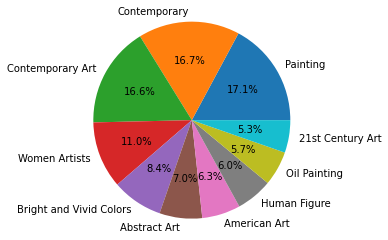

In [224]:
filtered_dict_aw = {k: v for k, v in artworks_dict.items() if v['updating_date'] == datetime.now().date().strftime('%Y-%m-%d')}
print('Count of new artworks', len(filtered_dict_aw))

filtered_dict_g = {k: v for k, v in genes_dict.items() if v['updating_date'] == datetime.now().date().strftime('%Y-%m-%d')}
print('Count of updated genes', len(filtered_dict_g))

updated_genes_count_dict = {}

#import collections
#c = collections.Counter()
#for category in categories:
#    c[category] += 1
#print (c)
#Out: Counter({'page': 74, 'datepicker': 15, 'table': 10, 'report': 8})

for artwork in filtered_dict_aw.values():
  for gen in artwork['gene_id']:
    if gen in updated_genes_count_dict.keys():
      gen_count = updated_genes_count_dict[gen] + 1
      updated_genes_count_dict.update({gen: gen_count})
    else:
      updated_genes_count_dict.update({gen: 1})

print('Count of updated genes check', len(updated_genes_count_dict))

genes_ids = [v['id'] for v in filtered_dict_g.values()]
genes_names = [v['name'] for v in filtered_dict_g.values()]

def by_value(item):
  return item[1]

counts = []
genes = []
for k, v in sorted(updated_genes_count_dict.items(), key=by_value, reverse=True)[:10]:
  counts.append(v)
  genes.append(genes_names[genes_ids.index(k)])

fig, ax = plt.subplots()
ax.pie(counts[:10], labels=genes[:10], autopct='%1.1f%%')
ax.axis("equal")
plt.show()

## Categories & Genes

In [ ]:
# categories_dict = {'name_': {'genes_id': [], 'id': '', 'link': '', 'name': '', 
#                              'parsing_date': '', 'updating_date': ''}}

categories_dict = open_dict(cat_dict, 'live') # 2. Open json dict
print("Categories dictionary's length is - {}".format(len(categories_dict)))
print('')

def by_value(item):
  return len(item[1]['genes_id'])

for k, v in sorted(categories_dict.items(), key=by_value, reverse=True):
  print(k, '->', 'id', v['id'], '->', 'genes count' , len(v['genes_id']))

Categories dictionary's length is - 16

styles_and_movements -> id 03 -> genes count 252
subject_matter -> id 02 -> genes count 213
medium_and_techniques -> id 06 -> genes count 176
visual_qualities -> id 05 -> genes count 75
cultural_and_religious_styles -> id 11 -> genes count 69
geographic_regions -> id 08 -> genes count 68
materials -> id 09 -> genes count 39
furniture_and_lighting -> id 12 -> genes count 27
design_movements -> id 04 -> genes count 26
design_concepts_and_techniques -> id 10 -> genes count 22
time_periods -> id 07 -> genes count 20
tableware_vessels_and_objects -> id 15 -> genes count 19
artistic_disciplines -> id 01 -> genes count 7
jewelry_and_fashion_object_types -> id 14 -> genes count 7
antiquities_artifacts_and_religious_objects -> id 16 -> genes count 7
textiles -> id 13 -> genes count 6


What I'm interested in:
- styles_and_movements -> id 03 -> genes count 252
- subject_matter -> id 02 -> genes count 213
- medium_and_techniques -> id 06 -> genes count 176
- visual_qualities -> id 05 -> genes count 75
- cultural_and_religious_styles -> id 11 -> genes count 69
- geographic_regions -> id 08 -> genes count 68
- materials -> id 09 -> genes count 39
- time_periods -> id 07 -> genes count 20

Filtered by:
- time_periods -> id 07 -> genes count 20
- styles_and_movements -> id 03 -> genes count 252
- medium_and_techniques -> id 06 -> genes count 176

In [ ]:
# genes_dict = {'name_': {'artist_id': [], 'artsy_id': [], 'category_id': '', 'id': '', 'link': '', 
#                         'name': '', 'parsing_date': '', 'updating_date': ''}}

genes_dict = open_dict(gen_dict, 'live') # 2. Open json dict
print("Genes dictionary's length is", len(genes_dict))

Genes dictionary's length is 1033


### commonality of artworks
Let's check our selected categories on commonality of artworks_id.

In [ ]:
# Creait all pairs of categories to find the better one by artworks corresponding as a start

cat_id_list = ['06', '03', '08', '02', '05', '09', '07', '11']
pairs = list(it.combinations(cat_id_list,2))

In [ ]:
# Get common list of artworks in list of categories
def get_common_list(items, output):
  artworks_lists = []
  for v in categories_dict.values():
    if v['id'] in items:
      cat_artwork_list = []
      for gene in v['genes_id']:
        for value in genes_dict.values():
          if value['id']==gene:
            cat_artwork_list = list(set(cat_artwork_list + value['artsy_id']))
      artworks_lists.append(cat_artwork_list)
      if output=='y':
        print('Category', v['id'], v['name'], '; Artworks count', len(cat_artwork_list))

  common_artworks_list = artworks_lists[0]
  for artwork_list in artworks_lists[1:]:
    common_artworks_list = list(set(common_artworks_list) & set(artwork_list))
    
  return common_artworks_list

In [ ]:
# Find the better pair of categories by artworks corresponding

list_len = 0
for pair in pairs:
  list_len_new = len(get_common_list(pair, 'n')) # Get common list of artworks in list of categories
  if list_len_new > list_len:
    best_pair = pair
    best_len = list_len_new
    list_len = list_len_new

print('The best pair with common artworks list length', best_len, 'is:')
for v in categories_dict.values():
  if v['id'] in best_pair:
    print('Category', v['id'], v['name'])

# reduce the previous list
cat_id_list = list(set(cat_id_list) - set(list(best_pair)))

The best pair with common artworks list length 72163 is:
Category 03 Styles and Movements
Category 06 Medium and Techniques


In [ ]:
common_list = get_common_list(best_pair, 'y') # Get common list of artworks in list of categories
len(common_list)

Category 03 Styles and Movements ; Artworks count 170068
Category 06 Medium and Techniques ; Artworks count 182501


72163

Well, both of the categories are in my supposed filter.

In [ ]:
# Get new ordered list of categories by artworks corresponding
def get_next_cat(id_list, items):
  list_len = 0
  for cat in id_list:
    items_list = items.copy()
    items_list.append(cat)
    list_len_new = len(get_common_list(items_list, 'n')) # Get common list of artworks in list of categories
    if list_len_new > list_len:
      best_ord = items_list.copy()
      best_len = list_len_new
      list_len = list_len_new

  print('The best order by common artworks list length', best_len, 'is:')
  for v in categories_dict.values():
    if v['id'] in best_ord:
      print('Category', v['id'], v['name'])
  print('')

  # reduce the previous list
  items_list_new = best_ord.copy()
  id_list_new = list(set(id_list) - set(items_list_new))
  
  if len(id_list_new) > 0:
    return get_next_cat(id_list_new, items_list_new) # repit to find next better category
  else:
    return items_list_new

In [ ]:
cat_id_list_ord = get_next_cat(cat_id_list, list(best_pair)) # Get new ordered list of categories by artworks corresponding
cat_id_list_ord

The best order by common artworks list length 44747 is:
Category 02 Subject Matter
Category 03 Styles and Movements
Category 06 Medium and Techniques

The best order by common artworks list length 18974 is:
Category 02 Subject Matter
Category 03 Styles and Movements
Category 05 Visual Qualities
Category 06 Medium and Techniques

The best order by common artworks list length 5458 is:
Category 02 Subject Matter
Category 03 Styles and Movements
Category 05 Visual Qualities
Category 06 Medium and Techniques
Category 08 Geographic Regions

The best order by common artworks list length 1467 is:
Category 02 Subject Matter
Category 03 Styles and Movements
Category 05 Visual Qualities
Category 06 Medium and Techniques
Category 07 Time Periods
Category 08 Geographic Regions

The best order by common artworks list length 155 is:
Category 02 Subject Matter
Category 03 Styles and Movements
Category 05 Visual Qualities
Category 06 Medium and Techniques
Category 07 Time Periods
Category 08 Geographic

['06', '03', '02', '05', '08', '07', '09', '11']

In [ ]:
# All categories with artworks counts
common_list = get_common_list(cat_id_list_ord, 'y') # Get common list of artworks in list of categories
len(common_list)
# '06' > '03' > '08' > '02' > '05' > '09' > '07' > '11' by artworks count

Category 02 Subject Matter ; Artworks count 116159
Category 03 Styles and Movements ; Artworks count 170068
Category 05 Visual Qualities ; Artworks count 77262
Category 06 Medium and Techniques ; Artworks count 182501
Category 07 Time Periods ; Artworks count 44028
Category 08 Geographic Regions ; Artworks count 140035
Category 09 Materials ; Artworks count 53400
Category 11 Cultural and Religious Styles ; Artworks count 8098


18

Categories by artworks count:
1. Category 06 Medium and Techniques ; Artworks count - 182.501
2. Category 03 Styles and Movements ; Artworks count - 170.068
3. Category 08 Geographic Regions ; Artworks count - 140.035
4. Category 02 Subject Matter ; Artworks count - 116.159
5. Category 05 Visual Qualities ; Artworks count - 77.262
6. Category 09 Materials ; Artworks count - 53.400
7. Category 07 Time Periods ; Artworks count - 44.028
8. Category 11 Cultural and Religious Styles ; Artworks count - 8.098

Categories by common artworks list:
1. Category 06 Medium and Techniques; List length - 182.501
2. Category 03 Styles and Movements; List length - 72.163
3. Category 02 Subject Matter; List length - 44.747
4. Category 05 Visual Qualities; List length - 18.974
5. Category 08 Geographic Regions; List length - 5.458
6. Category 07 Time Periods; List length - 1.467
7. Category 09 Materials; List length - 155
8. Category 11 Cultural and Religious Styles; List length - 18

In [ ]:
# My supposed filters
items = ['07', '03', '06']
common_list = get_common_list(items, 'y') # Get common list of artworks in list of categories
len(common_list)

Category 03 Styles and Movements ; Artworks count 170068
Category 06 Medium and Techniques ; Artworks count 182501
Category 07 Time Periods ; Artworks count 44028


10902

Summing up, categories don't correspond with each other by artworks quite well. Why?
- as it is
- maximum pages for a gene were 100, maybe there're more artworks in fact

I can easely rid of:
- Category 08 Geographic Regions
- Category 09 Materials
- Category 11 Cultural and Religious Styles

And this one can be considered as bonus: 
- Category 02 Subject Matter


In [ ]:
items = ['06', '03', '05', '07']
common_list = get_common_list(items, 'y') # Get common list of artworks in list of categories
len(common_list)

Category 03 Styles and Movements ; Artworks count 170068
Category 05 Visual Qualities ; Artworks count 77262
Category 06 Medium and Techniques ; Artworks count 182501
Category 07 Time Periods ; Artworks count 44028


4092

Category 05 Visual Qualities is a big-big bonus in my case.

In [ ]:
items = ['06', '03', '05']
common_list = get_common_list(items, 'y') # Get common list of artworks in list of categories
len(common_list)

Category 03 Styles and Movements ; Artworks count 170068
Category 05 Visual Qualities ; Artworks count 77262
Category 06 Medium and Techniques ; Artworks count 182501


27042

I want to limit the whole data of artworks by certain:
- Time Periods (07: 44.028 a/w) ->
- Styles and Movements (03: 170.068 a/w) ->
- Medium and Techniques (06: 182.501 a/w)

And study their:
- Visual Qualities (05: 77.262 a/w) ->
- Subject Matter (02: 44.747 a/w)

So, what I can do to enlarge my limited database is:
1. Get artworks list of certain Time periods genes.
2. Get Styles and Movements genes of these artwoks.
3. Look at the rest artworks of these Styles and Movements genes - what Time periods genes they belong to - and limit the database with whole Styles and Movements genes.



### database limitation
Start with time periods

In [ ]:
time_periods_genes_dict = {k: v for k, v in genes_dict.items() if v['category_id']=='07'}
print('Time periods genes count', len(time_periods_genes_dict))

Time periods genes count 20


In [ ]:
for k in time_periods_genes_dict.keys():
  print(time_periods_genes_dict[k]['name'], '-> gene id', time_periods_genes_dict[k]['id'], '-> artwork count', len(time_periods_genes_dict[k]['artsy_id']))

1000 - 1400 CE Art -> gene id 07001 -> artwork count 947
15th Century Art -> gene id 07002 -> artwork count 2063
16th Century Art -> gene id 07003 -> artwork count 2990
17th Century Art -> gene id 07004 -> artwork count 3004
18th Century Art -> gene id 07005 -> artwork count 3007
1900 - 1917 Art -> gene id 07006 -> artwork count 3019
1918 - 1939 (Interwar) Art -> gene id 07007 -> artwork count 3040
1940s-1950s Art -> gene id 07008 -> artwork count 3287
19th Century Art -> gene id 07009 -> artwork count 3040
21st Century Art -> gene id 07010 -> artwork count 3035
500 - 1000 CE  Art -> gene id 07011 -> artwork count 121
Ancient Art -> gene id 07012 -> artwork count 1097
Art of the 1960s -> gene id 07013 -> artwork count 3031
Art of the 1970s -> gene id 07014 -> artwork count 3039
Art of the 1980s -> gene id 07015 -> artwork count 3037
Art of the 1990s -> gene id 07016 -> artwork count 3030
Contemporary -> gene id 07017 -> artwork count 3168
Late 19th Century Art -> gene id 07018 -> artwo

For now I'm interested in:
- 15th Century Art -> gene id 07002 -> artwork count 2063
- 16th Century Art -> gene id 07003 -> artwork count 2990
- 17th Century Art -> gene id 07004 -> artwork count 3004
- 18th Century Art -> gene id 07005 -> artwork count 3007
- 19th Century Art -> gene id 07009 -> artwork count 3040
- Late 19th Century Art -> gene id 07018 -> artwork count 3024

And:
- 1900 - 1917 Art -> gene id 07006 -> artwork count 3019
- 1918 - 1939 (Interwar) Art -> gene id 07007 -> artwork count 3040
- Modern -> gene id 07019 -> artwork count 3026

So, let's take the artworks of these genes and find them in Styles and Movements category.

In [ ]:
# 1. Get artworks list of certain Time periods genes.
time_periods_genes_list = ['07002', '07003', '07004', '07005', '07009', '07018', '07006', '07007', '07019']
time_periods_artworks_list = []
artwork_count = 0
for v in time_periods_genes_dict.values():
  if v['id'] in time_periods_genes_list:
    time_periods_artworks_list = list(set(time_periods_artworks_list + v['artsy_id']))
    artwork_count += len(v['artsy_id'])

print('Selected time periods genes count:', len(time_periods_genes_list))
print('artwork count:', artwork_count)
print('Unique artworks count:', len(time_periods_artworks_list))

Selected time periods genes count: 9
artwork count: 26213
Unique artworks count: 23402


In [ ]:
# 2. Get Styles and Movements genes of these artwoks
styles_movements_genes_dict = {k: v for k, v in genes_dict.items() if v['category_id']=='03'}
common_periods_movements_artworks_list = []
periods_movements_genes_list = []
for v in styles_movements_genes_dict.values():
  id_list = list(set(v['artsy_id']) & set(time_periods_artworks_list))
  if len(id_list) != 0:
    common_periods_movements_artworks_list = list(set(common_periods_movements_artworks_list + id_list))
    periods_movements_genes_list.append(v['id'])

print('Styles and movements genes count', len(styles_movements_genes_dict))
print('Styles and movements genes by selected artworks count', len(periods_movements_genes_list))
print('Common artworks for Styles and movements and Time periods:', len(common_periods_movements_artworks_list))
print('Common ids check:', len(list(set(common_periods_movements_artworks_list) & set(time_periods_artworks_list))))

Styles and movements genes count 252
Styles and movements genes by selected artworks count 148
Common artworks for Styles and movements and Time periods: 8663
Common ids check: 8663


Just 1/3 of artworks of selected Time period genes are defined in Styles and movements category...

In [ ]:
# 3. Look at the rest artworks of these Styles and Movements genes (148) - 
#    what Time periods genes they belong to - 
#    and limit the database with whole Styles and Movements genes.

print('Styles and movemens genes by selected artworks count', len(periods_movements_genes_list))

# rest artworks of these Styles and Movements genes (148)
rest_periods_movements_artworks_list = []
for v in styles_movements_genes_dict.values():
  if v['id'] in periods_movements_genes_list: # 148 genes with common artworks
    id_list = list(set(v['artsy_id']) - set(time_periods_artworks_list)) # artworks selected by time periods
    rest_periods_movements_artworks_list = list(set(rest_periods_movements_artworks_list + id_list))

print('Rest artworks for Styles and movements:', len(rest_periods_movements_artworks_list))
print('Rest ids check:', len(list(set(time_periods_artworks_list) - set(common_periods_movements_artworks_list))))

Styles and movemens genes by selected artworks count 148
Rest artworks for Styles and movements: 131845
Rest ids check: 14739


In [ ]:
# Check the correctness
rest_time_periods_artworks_list = list(set(time_periods_artworks_list) - set(common_periods_movements_artworks_list))
print('Rest artworks for Time periods:', len(rest_time_periods_artworks_list))
print('')
for v in styles_movements_genes_dict.values():
  if len(list(set(v['artsy_id']) & set(rest_time_periods_artworks_list))) > 0:
    print(v['name'], '-> gene id', v['id'])
# correct

Rest artworks for Time periods: 14739



In [ ]:
# what Time periods genes they belong to
rest_periods_movements_genes_list = []
rest_periods_artworks_lists = []

for v in time_periods_genes_dict.values(): # with all time periods genes
  if v['id'] not in time_periods_genes_list: # not in filtered time_period genes (but if it is, the artworks mustn't be in the list)
    id_list = list(set(v['artsy_id']) & set(rest_periods_movements_artworks_list)) # rest artworks of these Styles and Movements genes (148)
    if len(id_list) > 0: 
      rest_periods_movements_genes_list.append(v['id'])
      rest_periods_artworks_lists.append(id_list)

for v in time_periods_genes_dict.values():
  if v['id'] in rest_periods_movements_genes_list:
    print(v['name'], '-> gene id', v['id'], '-> cross artworks count', len(rest_periods_artworks_lists[rest_periods_movements_genes_list.index(v['id'])]))

1000 - 1400 CE Art -> gene id 07001 -> cross artworks count 204
1940s-1950s Art -> gene id 07008 -> cross artworks count 1841
21st Century Art -> gene id 07010 -> cross artworks count 1373
500 - 1000 CE  Art -> gene id 07011 -> cross artworks count 59
Ancient Art -> gene id 07012 -> cross artworks count 303
Art of the 1960s -> gene id 07013 -> cross artworks count 2059
Art of the 1970s -> gene id 07014 -> cross artworks count 1141
Art of the 1980s -> gene id 07015 -> cross artworks count 1067
Art of the 1990s -> gene id 07016 -> cross artworks count 1272
Contemporary -> gene id 07017 -> cross artworks count 1092
Prehistoric Art -> gene id 07020 -> cross artworks count 16


All the others... That's super strange. Let's check some.

#### cross artworks checking

In [ ]:
def check_cross_artworks(gene, inx):
  print('Check {} gene'.format(gene))
  artworks_check_list = rest_periods_artworks_lists[rest_periods_movements_genes_list.index(inx)]
  print('length of the artworks_check_list', len(artworks_check_list))
  genes_check_list = []
  artworks_lists = []
  for v in styles_movements_genes_dict.values():
    if v['id'] in periods_movements_genes_list: # 148 genes with common artworks
      id_list = list(set(v['artsy_id']) & set(artworks_check_list))
      if len(id_list) != 0:
        genes_check_list.append(v['id'])
        artworks_lists.append(id_list)
  print('length of the genes_check_list', len(genes_check_list))
  print('')

  for k, v in styles_movements_genes_dict.items():
    if v['id'] in genes_check_list:
      print(k, '->', v['name'], '-> gene id', v['id'], '-> cross artworks count', len(artworks_lists[genes_check_list.index(v['id'])]))


In [ ]:
gene = 'Prehistoric Art'
inx = '07020'

check_cross_artworks(gene, inx)
# OK

Check Prehistoric Art gene
length of the artworks_check_list 16
length of the genes_check_list 3

abstract_sculpture -> Abstract Sculpture -> gene id 03012 -> cross artworks count 1
figurative_sculpture -> Figurative Sculpture -> gene id 03122 -> cross artworks count 13
iconic_works_of_art_history -> Iconic Works of Art History -> gene id 03143 -> cross artworks count 3


In [ ]:
gene = 'Ancient Art'
inx = '07012'

check_cross_artworks(gene, inx)
# gothic_art-??
# medieval_art-??
# northern_renaissance-??
# old_masters-??

# land_art-?
# pattern_and_decoration_movement-?

Check Ancient Art gene
length of the artworks_check_list 303
length of the genes_check_list 10

abstract_sculpture -> Abstract Sculpture -> gene id 03012 -> cross artworks count 2
figurative_sculpture -> Figurative Sculpture -> gene id 03122 -> cross artworks count 187
gothic_art -> Gothic Art -> gene id 03130 -> cross artworks count 1
iconic_works_of_art_history -> Iconic Works of Art History -> gene id 03143 -> cross artworks count 61
land_art -> Land Art -> gene id 03151 -> cross artworks count 1
medieval_art -> Medieval Art -> gene id 03156 -> cross artworks count 5
northern_renaissance -> Northern Renaissance -> gene id 03183 -> cross artworks count 1
old_masters -> Old Masters -> gene id 03188 -> cross artworks count 1
pattern_and_decoration_movement -> Pattern and Decoration Movement -> gene id 03192 -> cross artworks count 6
traditional_arts_of_africa_oceania_and_the_americas -> Traditional Arts of Africa, Oceania, and the Americas -> gene id 03241 -> cross artworks count 73


In [ ]:
gene = '500 - 1000 CE  Art'
inx = '07011'

check_cross_artworks(gene, inx)
# abstract_sculpture-?
# traditional_arts_of_africa_oceania_and_the_americas... geographic_regions -> id 08 !!!

# land_art-?

Check 500 - 1000 CE  Art gene
length of the artworks_check_list 59
length of the genes_check_list 8

abstract_sculpture -> Abstract Sculpture -> gene id 03012 -> cross artworks count 1
figurative_sculpture -> Figurative Sculpture -> gene id 03122 -> cross artworks count 23
gothic_art -> Gothic Art -> gene id 03130 -> cross artworks count 1
iconic_works_of_art_history -> Iconic Works of Art History -> gene id 03143 -> cross artworks count 28
land_art -> Land Art -> gene id 03151 -> cross artworks count 1
medieval_art -> Medieval Art -> gene id 03156 -> cross artworks count 3
symbolism -> Symbolism -> gene id 03233 -> cross artworks count 3
traditional_arts_of_africa_oceania_and_the_americas -> Traditional Arts of Africa, Oceania, and the Americas -> gene id 03241 -> cross artworks count 15


In [ ]:
gene = '1000 - 1400 CE Art'
inx = '07001'

check_cross_artworks(gene, inx)
# art_deco-??
# hyperrealism_and_photorealism-??
# impressionism_and_contemporary_impressionist-??
# op_art-??

# old_masters, old_master_drawings_and_prints-?

Check 1000 - 1400 CE Art gene
length of the artworks_check_list 204
length of the genes_check_list 17

abstract_versus_figurative_art -> Abstract versus Figurative Art -> gene id 03013 -> cross artworks count 1
art_deco -> Art Deco -> gene id 03026 -> cross artworks count 1
dutch_and_flemish -> Dutch and Flemish -> gene id 03109 -> cross artworks count 1
early_renaissance -> Early Renaissance -> gene id 03111 -> cross artworks count 11
figurative_sculpture -> Figurative Sculpture -> gene id 03122 -> cross artworks count 46
gothic_art -> Gothic Art -> gene id 03130 -> cross artworks count 42
hyperrealism_and_photorealism -> Hyperrealism and Photorealism -> gene id 03142 -> cross artworks count 1
iconic_works_of_art_history -> Iconic Works of Art History -> gene id 03143 -> cross artworks count 63
impressionism_and_contemporary_impressionist -> Impressionism and Contemporary Impressionist -> gene id 03146 -> cross artworks count 1
medieval_art -> Medieval Art -> gene id 03156 -> cross ar

In [ ]:
gene = 'Contemporary'
inx = '07017'

check_cross_artworks(gene, inx)
# contemporary... shouldn't be before 1940s

Check Contemporary gene
length of the artworks_check_list 1092
length of the genes_check_list 40

20th_century_art -> 20th Century Art -> gene id 03007 -> cross artworks count 1
abstract_art -> Abstract Art -> gene id 03008 -> cross artworks count 219
abstract_painting -> Abstract Painting -> gene id 03010 -> cross artworks count 5
abstract_versus_figurative_art -> Abstract versus Figurative Art -> gene id 03013 -> cross artworks count 66
art_deco -> Art Deco -> gene id 03026 -> cross artworks count 1
art_nouveau -> Art Nouveau -> gene id 03028 -> cross artworks count 1
collaborations_and_collectives -> Collaborations and Collectives -> gene id 03047 -> cross artworks count 1
contemporary_academic_realism -> Contemporary Academic Realism -> gene id 03053 -> cross artworks count 40
contemporary_african_art -> Contemporary African Art -> gene id 03054 -> cross artworks count 52
contemporary_art -> Contemporary Art -> gene id 03056 -> cross artworks count 823
contemporary_asian_art -> Con

In [ ]:
gene = '21st Century Art'
inx = '07010'

check_cross_artworks(gene, inx)
# contemporary... shouldn't be before 1940s

Check 21st Century Art gene
length of the artworks_check_list 1373
length of the genes_check_list 55

abstract_art -> Abstract Art -> gene id 03008 -> cross artworks count 255
abstract_painting -> Abstract Painting -> gene id 03010 -> cross artworks count 58
abstract_photography -> Abstract Photography -> gene id 03011 -> cross artworks count 19
abstract_sculpture -> Abstract Sculpture -> gene id 03012 -> cross artworks count 13
abstract_versus_figurative_art -> Abstract versus Figurative Art -> gene id 03013 -> cross artworks count 97
conceptual_art -> Conceptual Art -> gene id 03049 -> cross artworks count 3
conceptual_art_and_contemporary_conceptualism -> Conceptual Art and Contemporary Conceptualism -> gene id 03050 -> cross artworks count 15
contemporary_academic_realism -> Contemporary Academic Realism -> gene id 03053 -> cross artworks count 42
contemporary_african_art -> Contemporary African Art -> gene id 03054 -> cross artworks count 43
contemporary_art -> Contemporary Art ->

In [ ]:
#1940s-1950s Art -> gene id 07008 -> cross artworks count 1841
#Art of the 1960s -> gene id 07013 -> cross artworks count 2059
#Art of the 1970s -> gene id 07014 -> cross artworks count 1141
#Art of the 1980s -> gene id 07015 -> cross artworks count 1067
#Art of the 1990s -> gene id 07016 -> cross artworks count 1272

### iconic_works_of_art_history

Unfortunatelly, I can't limit the database with whole Styles and Movements genes that have any common artworks with selected Time periods genes.

Interesting Styles and Movements gene - iconic_works_of_art_history. Let's explore it.

In [ ]:
styles_movements_genes_dict = {k: v for k, v in genes_dict.items() if v['category_id']=='03'}

In [ ]:
iconic_works_list = styles_movements_genes_dict['iconic_works_of_art_history']['artsy_id']
len(iconic_works_list)

536

In [ ]:
# let's create two dataframes for further analysis and visualisation
category_id_list = []
cat_count_list = []

gene_name_list = []
gene_id_list = []
gene_cat_id_list = []
gene_count_list = []

In [ ]:
# what other Styles & Movements genes they belong to
iconic_movements_genes_list = []
iconic_movements_artworks_lists = []
category_id_list.append('03')

for v in styles_movements_genes_dict.values(): # with all time periods genes
  if v['id'] is not styles_movements_genes_dict['iconic_works_of_art_history']['id']: # not in filtered time_period genes
    id_list = list(set(v['artsy_id']) & set(iconic_works_list))
    if len(id_list) > 0: 
      iconic_movements_genes_list.append(v['id'])
      iconic_movements_artworks_lists.append(id_list)

for v in styles_movements_genes_dict.values():
  if v['id'] in iconic_movements_genes_list:
    print(v['name'], '-> gene id', v['id'], '-> iconic artworks count', len(iconic_movements_artworks_lists[iconic_movements_genes_list.index(v['id'])]))
    gene_id_list.append(v['id'])
    gene_name_list.append(v['name'])
    gene_cat_id_list.append(v['category_id'])
    gene_count_list.append(len(iconic_movements_artworks_lists[iconic_movements_genes_list.index(v['id'])]))

iconic_movements_artworks_unique = []
for id_list in iconic_movements_artworks_lists:
  iconic_movements_artworks_unique = list(set(iconic_movements_artworks_unique + id_list))
print('')
print('Total count of iconic artworks', len(iconic_movements_artworks_unique))
cat_count_list.append(len(iconic_movements_artworks_unique))

19th Century American Art -> gene id 03003 -> iconic artworks count 15
19th Century American Paintings and Works on Paper -> gene id 03004 -> iconic artworks count 12
19th Century French Academy -> gene id 03005 -> iconic artworks count 5
20th Century Art -> gene id 03007 -> iconic artworks count 1
Abstract Expressionism -> gene id 03009 -> iconic artworks count 4
American Impressionism -> gene id 03017 -> iconic artworks count 5
American Modernism -> gene id 03018 -> iconic artworks count 1
American Regionalism -> gene id 03021 -> iconic artworks count 1
American Sculpture 1830–1950 -> gene id 03022 -> iconic artworks count 1
American Tonalism -> gene id 03023 -> iconic artworks count 1
American Works on Paper 1880–1950 -> gene id 03024 -> iconic artworks count 1
Art Deco -> gene id 03026 -> iconic artworks count 1
Art Nouveau -> gene id 03028 -> iconic artworks count 6
Arte Povera -> gene id 03029 -> iconic artworks count 1
Barbizon School -> gene id 03031 -> iconic artworks count 1


In [ ]:
print("{} works aren't belong to Style or Movement, just to Iconic works".format(len(iconic_works_list) - len(iconic_periods_artworks_unique)))

117 works aren't belong to Style or Movement, just to Iconic works


Will be interesting to look at them.

In [ ]:
#sample(list(set(iconic_works_list) - set(iconic_periods_artworks_unique)), 10)

In [ ]:
# what other category genes they belong to
def get_stat_by_cat(cat):
  filtered_genes_dict = {k: v for k, v in genes_dict.items() if v['category_id']==cat}

  iconic_periods_genes_list = []
  iconic_periods_artworks_lists = []

  for v in filtered_genes_dict.values():
    id_list = list(set(v['artsy_id']) & set(iconic_works_list))
    if len(id_list) > 0: 
      iconic_periods_genes_list.append(v['id'])
      iconic_periods_artworks_lists.append(id_list)

  for v in filtered_genes_dict.values():
    if v['id'] in iconic_periods_genes_list:
      print(v['name'], '-> gene id', v['id'], '-> iconic artworks count', len(iconic_periods_artworks_lists[iconic_periods_genes_list.index(v['id'])]))
      gene_id_list.append(v['id'])
      gene_name_list.append(v['name'])
      gene_cat_id_list.append(v['category_id'])
      gene_count_list.append(len(iconic_periods_artworks_lists[iconic_periods_genes_list.index(v['id'])]))
    
  iconic_periods_artworks_unique = []
  for id_list in iconic_periods_artworks_lists:
    iconic_periods_artworks_unique = list(set(iconic_periods_artworks_unique + id_list))
  print('')
  print('Total count of iconic artworks', len(iconic_periods_artworks_unique))
  cat_count_list.append(len(iconic_periods_artworks_unique))

In [ ]:
cat_id_list = ['06', '08', '02', '05', '09', '07', '11']
for cat in cat_id_list:
  for v in categories_dict.values():
    if v['id']==cat:
      category_id_list.append(v['id'])
      print('Iconic artworks belong to further genes in category', v['name'])
      print('')
      get_stat_by_cat(cat)
      print('')

Iconic artworks belong to further genes in category Medium and Techniques

Album, Folio and Fan Formats -> gene id 06002 -> iconic artworks count 2
Altarpiece -> gene id 06003 -> iconic artworks count 8
Appropriation -> gene id 06007 -> iconic artworks count 5
Arabic/Farsi Calligraphy -> gene id 06008 -> iconic artworks count 7
Archaeological Object -> gene id 06009 -> iconic artworks count 3
Art That Plays With Scale -> gene id 06010 -> iconic artworks count 3
Automatism -> gene id 06013 -> iconic artworks count 4
Caravaggesque -> gene id 06020 -> iconic artworks count 4
Chiaroscuro -> gene id 06023 -> iconic artworks count 42
Cinematic -> gene id 06024 -> iconic artworks count 1
Color Theory -> gene id 06029 -> iconic artworks count 8
Comic/Cartoon -> gene id 06030 -> iconic artworks count 1
Copies and Emulations -> gene id 06032 -> iconic artworks count 4
Densely Textured or Haptic Surface -> gene id 06036 -> iconic artworks count 3
Divinatory Objects, Talismans, and Amulets -> gene

In [ ]:
def get_cat_name(cell):
  for v in categories_dict.values():
    if v['id']==cell:
      cell = v['name']
  return cell

In [ ]:
cat_count_df = pd.DataFrame({'category_id': category_id_list, 
                             'count':cat_count_list
                             }) # + category_name

gene_count_df = pd.DataFrame({'gene_name': gene_name_list, 'gene_id': gene_id_list, 
                           'category_id': gene_cat_id_list, 'count': gene_count_list
                           }) # + category_name

#cat_count_df = cat_count_df.set_axis(['category_id', 'count'], axis=1, inplace=False)
#gene_count_df = gene_count_df.set_axis(['gene_name', 'gene_id', 'category_id', 'count'], axis=1, inplace=False)

cat_count_df['category_name'] = cat_count_df['category_id'].dropna().apply(get_cat_name)
gene_count_df['category_name'] = gene_count_df['category_id'].dropna().apply(get_cat_name)

In [ ]:
cat_count_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8 entries, 0 to 7
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   category_id    8 non-null      object
 1   count          8 non-null      int64 
 2   category_name  8 non-null      object
dtypes: int64(1), object(2)
memory usage: 320.0+ bytes


In [ ]:
gene_count_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 388 entries, 0 to 387
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   gene_name      388 non-null    object
 1   gene_id        388 non-null    object
 2   category_id    388 non-null    object
 3   count          388 non-null    int64 
 4   category_name  388 non-null    object
dtypes: int64(1), object(4)
memory usage: 15.3+ KB


In [ ]:
cat_count_df

,category_id,count,category_name
0,03,419,Styles and Movements
1,06,272,Medium and Techniques
2,08,31,Geographic Regions
3,02,471,Subject Matter
4,05,219,Visual Qualities
5,09,58,Materials
6,07,353,Time Periods
7,11,233,Cultural and Religious Styles


In [ ]:
gene_count_df.sample(10)

,gene_name,gene_id,category_id,count,category_name
184,Face,02062,02,15,Subject Matter
304,Hard-Edged,05035,05,2,Visual Qualities
94,En plein air,06049,06,8,Medium and Techniques
201,Hybrids and Imaginary Creatures,02085,02,17,Subject Matter
212,Madonna and Child,02106,02,17,Subject Matter
84,Chiaroscuro,06023,06,42,Medium and Techniques
338,Mosaics,09021,09,7,Materials
138,Central Asian Art,08019,08,1,Geographic Regions
264,The City,02188,02,3,Subject Matter
343,Use of Ephemeral Materials,09035,09,1,Materials


In [ ]:
for cat in gene_count_df['category_name'].unique():
  print(cat)
  print('Sum by category', gene_count_df.loc[gene_count_df['category_name']==cat]['count'].sum())
  print('Unique by category', cat_count_df.loc[cat_count_df['category_name']==cat]['count'].values[0])
  print('')
  print(gene_count_df.loc[gene_count_df['category_name']==cat].describe())
  print('')

Styles and Movements
Sum by category 891
Unique by category 419

            count
count   76.000000
mean    11.723684
std     22.077197
min      1.000000
25%      1.000000
50%      3.000000
75%     12.000000
max    127.000000

Medium and Techniques
Sum by category 395
Unique by category 272

          count
count  61.00000
mean    6.47541
std     8.44513
min     1.00000
25%     1.00000
50%     3.00000
75%     8.00000
max    44.00000

Geographic Regions
Sum by category 31
Unique by category 31

           count
count   7.000000
mean    4.428571
std     4.613644
min     1.000000
25%     1.000000
50%     2.000000
75%     7.500000
max    11.000000

Subject Matter
Sum by category 1819
Unique by category 471

            count
count  140.000000
mean    12.992857
std     16.920252
min      1.000000
25%      3.000000
50%      7.000000
75%     16.250000
max     96.000000

Visual Qualities
Sum by category 308
Unique by category 219

           count
count  44.000000
mean    7.000000
std     9.8

Most of the categories has a lot of genes what makes visualization confusing. Let's merge genes with less then third quartile artworks into an 'Others' in every category except ones with less then 10 genes.

In [ ]:
for cat in gene_count_df['category_name'].unique():
  print(cat)
  cat_df = gene_count_df.loc[gene_count_df['category_name']==cat]
  print('Count of genes before renaming:', cat_df['gene_name'].nunique())
  if cat_df['gene_name'].nunique() > 10:
    quartile_3 = np.percentile(cat_df['count'], 75)
    big_counts_df = cat_df.loc[cat_df['count'] >= quartile_3]
    small_counts_df = cat_df.loc[cat_df['count'] < quartile_3]
    small_counts_df['gene_name'] = 'Others'
    cat_df_new = pd.concat([big_counts_df, small_counts_df])
  else:
    cat_df_new = cat_df.copy()
  print('Count of genes after renaming:', cat_df_new['gene_name'].nunique())
  print('')

Styles and Movements
Count of genes before renaming: 76
Count of genes after renaming: 23

Medium and Techniques
Count of genes before renaming: 61
Count of genes after renaming: 19

Geographic Regions
Count of genes before renaming: 7
Count of genes after renaming: 7

Subject Matter
Count of genes before renaming: 140
Count of genes after renaming: 36

Visual Qualities
Count of genes before renaming: 44
Count of genes after renaming: 13

Materials
Count of genes before renaming: 17
Count of genes after renaming: 7

Time Periods
Count of genes before renaming: 9
Count of genes after renaming: 9

Cultural and Religious Styles
Count of genes before renaming: 34
Count of genes after renaming: 10



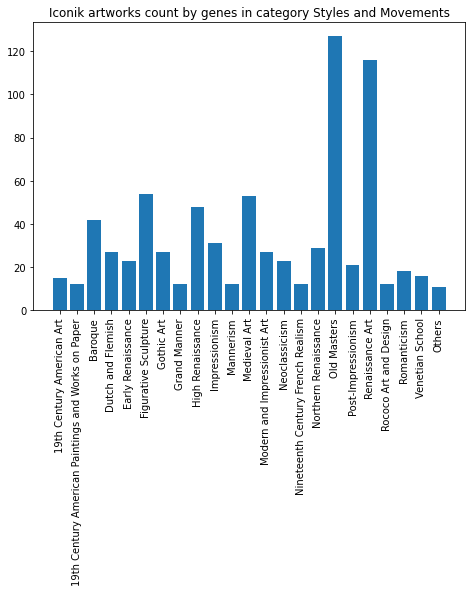

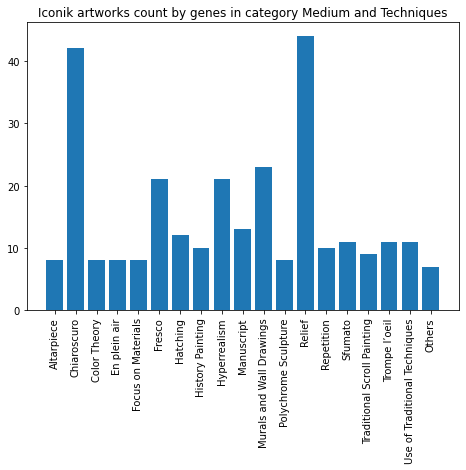

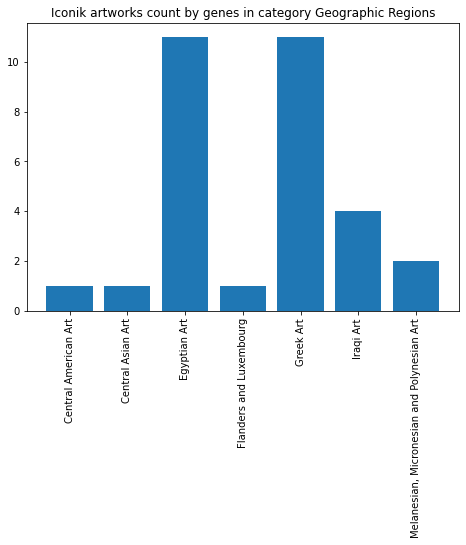

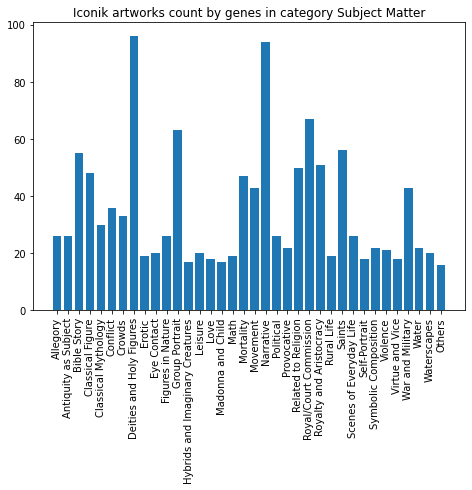

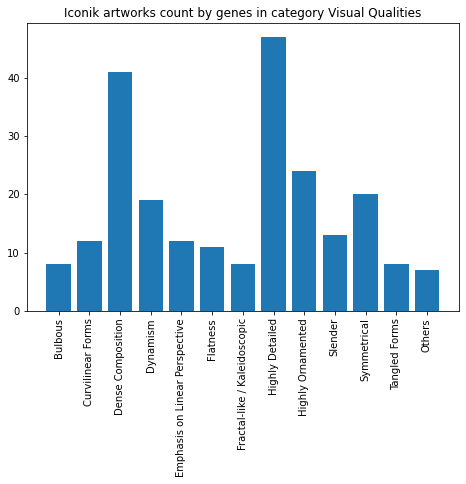

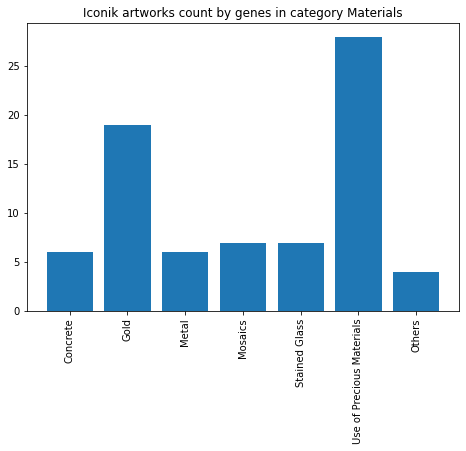

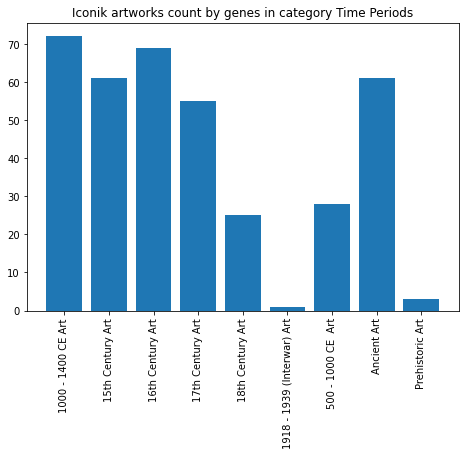

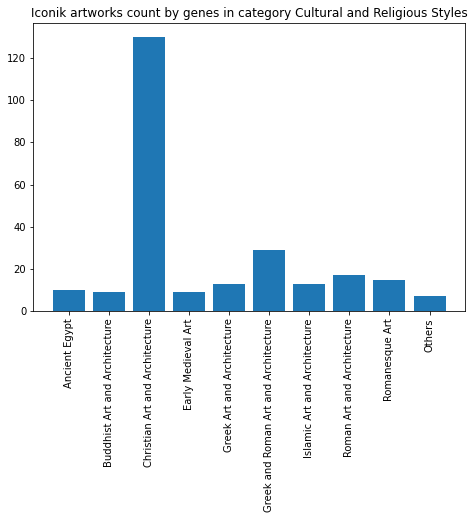

In [ ]:
for cat in gene_count_df['category_name'].unique():
  cat_df = gene_count_df.loc[gene_count_df['category_name']==cat]
  if cat_df['gene_name'].nunique() > 10:
    quartile_3 = np.percentile(cat_df['count'], 75)
    big_counts_df = cat_df.loc[cat_df['count'] >= quartile_3]
    small_counts_df = cat_df.loc[cat_df['count'] < quartile_3]
    small_counts_df['gene_name'] = 'Others'
    cat_df_new = pd.concat([big_counts_df, small_counts_df])
  else:
    cat_df_new = cat_df.copy()
  
  fig = plt.figure()
  axes = fig.add_axes([0, 0, 1, 1])
  axes.bar(x = cat_df_new['gene_name'], height = cat_df_new['count'])
  axes.set_xticklabels(cat_df_new['gene_name'], rotation = 90)
  axes.set_title('Iconik artworks count by genes in category {}'.format(cat))
  
  plt.show()

  print('')

In [ ]:
# artists_dict = {'id': {'artsy_id': [], 'category_id': [], 'gene_id': [], 'name': ''}}

#artists_dict = open_dict(artist_dict, 'live') # 2. Open json dict
#len(artists_dict)

# artworks_dict = {'artsy_id': {'artist': '', 'artist_id': '', 'category_id': [], 'gallery': '', 'gene_id': [],
#                               'link': '', 'name': '', 'parsing_date': '', 'price': '', 'updating_date': ', 'year': ''}}

#artworks_dict = open_dict(artwork_dict, 'live') # 2. Open json dict
#len(artworks_dict)

# Images

In [ ]:
# Sample from API tables

# 'image': {'href': 'https://d32dm0rphc51dk.cloudfront.net/NOpIAwQa-3r51Cg9qXKbfA/{image_version}.jpg',
#                      'templated': True}
#i = 'https://d32dm0rphc51dk.cloudfront.net/NOpIAwQa-3r51Cg9qXKbfA/normalized.jpg'
#for p in i.split('.jpg')[0].split('/'):
#  print(len(p), p)

6 https:
0 
29 d32dm0rphc51dk.cloudfront.net
22 NOpIAwQa-3r51Cg9qXKbfA
10 normalized


In [ ]:
#! pip install pillow --user

import PIL
from PIL import Image
import os
import cv2

%pylab inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

Populating the interactive namespace from numpy and matplotlib


In [ ]:
image = requests.get(img, headers={'User-Agent': 'Chrome/97.0.4692.71'})
name = art_project_path + '/' + 'portrait_of_a_man_in_armour' + '.jpg'

img = open(name, 'wb')
img.write(image.content)
img.close()

img = Image.open(name)
plt.imshow(img)
plt.axis('off')
plt.show()

img.close()